CS, d = 11, with early stoppping.

In [1]:
import sys
sys.path.append('../')

from NG.generate_ng import *
from computesk import *
import numpy as np
import torch

import copy
import torch.optim as optim
import os

from models.UMNN import MonotonicNN
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:

num_features = 156
hidden_layers = [64, 128, 128]
nb_steps = 50

lr = 0.001 # The learning rate was decreased to avoid getting NaNs during map learning (note this is because of regularizer vs loss.)
num_epochs = 100

In [3]:
testing_samples_path = 'OC/samples/test.txt'
validation_samples_path = 'OC/samples/validation.txt'
training_samples_path = 'OC/samples/train.txt'
save_path = 'OC/OC-saved_models/OC-156d-64_128_128_lr' # Change this!""

In [4]:
test_samples = torch.tensor(np.loadtxt(testing_samples_path)).to(torch.float32)
validation_samples = torch.tensor(np.loadtxt(validation_samples_path)).to(torch.float32)
train_samples = torch.tensor(np.loadtxt(training_samples_path)).to(torch.float32)
print(test_samples.shape, validation_samples.shape, train_samples.shape)


torch.Size([117, 156]) torch.Size([115, 156]) torch.Size([346, 156])


In [5]:
test_samples

tensor([[ 0.4821,  0.4558, -0.5949,  ...,  0.4678,  0.5901,  0.6874],
        [ 2.3441,  0.2051, -0.8867,  ...,  0.1197,  3.4944,  0.7929],
        [-0.4075,  0.3622, -0.1156,  ...,  0.5719,  0.6927,  0.1269],
        ...,
        [-0.1698, -1.3222,  0.3279,  ...,  0.8689,  1.0163,  1.0282],
        [ 0.2314, -0.8070,  1.4503,  ..., -0.2047, -1.1577,  0.4693],
        [ 1.8247,  0.4565, -1.2466,  ...,  0.1009, -1.0593, -0.7562]])

In [6]:
training_sizes = [len(train_samples)]
random_regs = [1, 0.1, 0.01, 0.001, 0]

In [7]:
kths = list(range(num_features))
fixed_map = generate_non_linear_maps(num_features, hidden_layers, nb_steps, 'cpu')

In [8]:
opt_regs = {}
all_test_losses = {}
all_learnt_maps = {}
all_opt_maps = {}
test_no_reg_losses = {}

# Learning Sk map

In [9]:
num_train = training_sizes[0]
X_tr = train_samples

for i in kths:
    kth = i
    print('kth =', kth)
    best_val_overall = float('inf')
    opt_reg = 0
    opt_Sk = None # should this be moved in?
    each_learnt_map = {}
    non_kth = [idx for idx in range(X_tr.shape[1]) if idx != kth]

    for j in tqdm(range(len(random_regs)), desc='Random Regs', leave=False):
        regLambda = random_regs[j]
        Sk = copy.deepcopy(fixed_map)[kth]
        optimizer = optim.Adam(Sk.parameters(), lr=lr)
        n = X_tr.shape[0]
        early_stop_counter = 0
        best_epoch = 0
        best_valL = float('inf')
        for epoch in range(num_epochs):
            zk = X_tr.detach().requires_grad_(True)
            h = zk[:, non_kth]
            x = zk[:, [kth]]

            sk_zi = Sk(x, h)
            jacobian = torch.autograd.grad(sk_zi, x, torch.ones_like(sk_zi), create_graph=True)[0]
            loss = (0.5 * sk_zi**2 - torch.log(jacobian)).sum(axis=0) / n 
            regulariser = torch.sqrt((jacobian**2).sum(axis=0) / n)
            loss += regLambda * regulariser
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Validation
            Sk_zi_val, jacobian_val = test_map(validation_samples, non_kth, kth, Sk)
            val_loss = test_losses(Sk_zi_val, jacobian_val)
            print(f'Val {num_train}st λ = {regLambda}, Epoch {epoch}: {val_loss}')

            # Save the smallest validation loss at each loop.
            if val_loss[1] < best_valL:
                best_valL = val_loss[1]
                if val_loss[1] < best_val_overall: # overall for all λ and epoch
                    best_val_overall = val_loss[1]
                    opt_reg = regLambda
                    opt_Sk = Sk
                    
                best_epoch = epoch
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            # Check for early stopping
            if early_stop_counter >= 15:
                print(f'Early stopping at Epoch {epoch} for best epoch {best_epoch}.')
                break

        each_learnt_map.setdefault(regLambda, []).append(Sk)

    # Test the best model
    Sk_zi_test, jacobian_test = test_map(test_samples, non_kth, kth, opt_Sk)

    all_test_losses.setdefault(num_train, []).append(test_losses(Sk_zi_test, jacobian_test))###, kth))
    print(f'Test {num_train}, λ = {opt_reg}: {all_test_losses[num_train]}')

    all_learnt_maps.setdefault(num_train, []).append(each_learnt_map)
    all_opt_maps.setdefault(num_train, []).append(opt_Sk)
    opt_regs.setdefault(num_train, []).append(opt_reg)
    
print('Optimal λ ∀ =', opt_regs)


kth = 0


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.0204025506973267, 1.50834059715271)
Val 346st λ = 1, Epoch 1: (0.7251561880111694, 1.5025513172149658)
Val 346st λ = 1, Epoch 2: (0.5602477192878723, 1.535476565361023)
Val 346st λ = 1, Epoch 3: (0.46204328536987305, 1.5877751111984253)
Val 346st λ = 1, Epoch 4: (0.40705549716949463, 1.6417323350906372)
Val 346st λ = 1, Epoch 5: (0.37934398651123047, 1.680914282798767)
Val 346st λ = 1, Epoch 6: (0.365913987159729, 1.697901725769043)
Val 346st λ = 1, Epoch 7: (0.35951533913612366, 1.6946618556976318)
Val 346st λ = 1, Epoch 8: (0.3580637574195862, 1.676888346672058)
Val 346st λ = 1, Epoch 9: (0.36165544390678406, 1.650846242904663)
Val 346st λ = 1, Epoch 10: (0.37067875266075134, 1.6217236518859863)
Val 346st λ = 1, Epoch 11: (0.3846043348312378, 1.5930652618408203)
Val 346st λ = 1, Epoch 12: (0.4024238586425781, 1.5670819282531738)
Val 346st λ = 1, Epoch 13: (0.4223540425300598, 1.544736385345459)
Val 346st λ = 1, Epoch 14: (0.4426127076148987, 1.52641928195

Random Regs:  20%|██        | 1/5 [00:12<00:51, 12.92s/it]

Val 346st λ = 1, Epoch 63: (0.9465759992599487, 1.307108759880066)
Early stopping at Epoch 63 for best epoch 48.
Val 346st λ = 0.1, Epoch 0: (1.1131021976470947, 1.5069425106048584)
Val 346st λ = 0.1, Epoch 1: (0.944868803024292, 1.4750564098358154)
Val 346st λ = 0.1, Epoch 2: (0.9011696577072144, 1.4562602043151855)
Val 346st λ = 0.1, Epoch 3: (0.9129348397254944, 1.4427815675735474)
Val 346st λ = 0.1, Epoch 4: (0.956306517124176, 1.433932900428772)
Val 346st λ = 0.1, Epoch 5: (1.0214554071426392, 1.430612564086914)
Val 346st λ = 0.1, Epoch 6: (1.0981711149215698, 1.4328066110610962)
Val 346st λ = 0.1, Epoch 7: (1.1739193201065063, 1.4381357431411743)
Val 346st λ = 0.1, Epoch 8: (1.234379529953003, 1.4425562620162964)
Val 346st λ = 0.1, Epoch 9: (1.2769654989242554, 1.444415807723999)
Val 346st λ = 0.1, Epoch 10: (1.308850646018982, 1.4447259902954102)
Val 346st λ = 0.1, Epoch 11: (1.3481074571609497, 1.4468003511428833)
Val 346st λ = 0.1, Epoch 12: (1.4138216972351074, 1.454805731773

Random Regs:  40%|████      | 2/5 [00:16<00:23,  7.69s/it]

Val 346st λ = 0.1, Epoch 20: (3.541224956512451, 1.9256106615066528)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0.01, Epoch 0: (1.161534309387207, 1.509096384048462)
Val 346st λ = 0.01, Epoch 1: (1.030055284500122, 1.4765914678573608)
Val 346st λ = 0.01, Epoch 2: (1.011588215827942, 1.458654761314392)
Val 346st λ = 0.01, Epoch 3: (1.0414340496063232, 1.4486372470855713)
Val 346st λ = 0.01, Epoch 4: (1.0973756313323975, 1.4449080228805542)
Val 346st λ = 0.01, Epoch 5: (1.1697778701782227, 1.4473137855529785)
Val 346st λ = 0.01, Epoch 6: (1.2474385499954224, 1.4540544748306274)
Val 346st λ = 0.01, Epoch 7: (1.3184597492218018, 1.4617143869400024)
Val 346st λ = 0.01, Epoch 8: (1.3768702745437622, 1.4682523012161255)
Val 346st λ = 0.01, Epoch 9: (1.4271072149276733, 1.4737910032272339)
Val 346st λ = 0.01, Epoch 10: (1.4838744401931763, 1.481645941734314)
Val 346st λ = 0.01, Epoch 11: (1.5659724473953247, 1.496435284614563)
Val 346st λ = 0.01, Epoch 12: (1.6884300708770752, 

Random Regs:  60%|██████    | 3/5 [00:20<00:11,  5.94s/it]

Val 346st λ = 0.01, Epoch 18: (3.410062313079834, 1.9662604331970215)
Val 346st λ = 0.01, Epoch 19: (4.007787704467773, 2.1252810955047607)
Early stopping at Epoch 19 for best epoch 4.
Val 346st λ = 0.001, Epoch 0: (1.1676568984985352, 1.509484052658081)
Val 346st λ = 0.001, Epoch 1: (1.0396294593811035, 1.477081537246704)
Val 346st λ = 0.001, Epoch 2: (1.0224332809448242, 1.4591643810272217)
Val 346st λ = 0.001, Epoch 3: (1.0538251399993896, 1.4496291875839233)
Val 346st λ = 0.001, Epoch 4: (1.1112087965011597, 1.4465563297271729)
Val 346st λ = 0.001, Epoch 5: (1.1848843097686768, 1.4496577978134155)
Val 346st λ = 0.001, Epoch 6: (1.2629138231277466, 1.4569076299667358)
Val 346st λ = 0.001, Epoch 7: (1.3339074850082397, 1.4648487567901611)
Val 346st λ = 0.001, Epoch 8: (1.3927056789398193, 1.47162663936615)
Val 346st λ = 0.001, Epoch 9: (1.4429254531860352, 1.4773921966552734)
Val 346st λ = 0.001, Epoch 10: (1.5006972551345825, 1.4858182668685913)
Val 346st λ = 0.001, Epoch 11: (1.584

Random Regs:  80%|████████  | 4/5 [00:24<00:05,  5.04s/it]

Val 346st λ = 0.001, Epoch 18: (3.449462890625, 1.986432671546936)
Val 346st λ = 0.001, Epoch 19: (4.049103260040283, 2.1499624252319336)
Early stopping at Epoch 19 for best epoch 4.
Val 346st λ = 0, Epoch 0: (1.1681082248687744, 1.5095107555389404)
Val 346st λ = 0, Epoch 1: (1.0407330989837646, 1.4771572351455688)
Val 346st λ = 0, Epoch 2: (1.0238978862762451, 1.459268569946289)
Val 346st λ = 0, Epoch 3: (1.055434226989746, 1.4498016834259033)
Val 346st λ = 0, Epoch 4: (1.1129649877548218, 1.446818470954895)
Val 346st λ = 0, Epoch 5: (1.1865593194961548, 1.449915885925293)
Val 346st λ = 0, Epoch 6: (1.2645570039749146, 1.4571789503097534)
Val 346st λ = 0, Epoch 7: (1.335687279701233, 1.4651402235031128)
Val 346st λ = 0, Epoch 8: (1.3949353694915771, 1.472028136253357)
Val 346st λ = 0, Epoch 9: (1.4460954666137695, 1.4780172109603882)
Val 346st λ = 0, Epoch 10: (1.5053938627243042, 1.486819863319397)
Val 346st λ = 0, Epoch 11: (1.5908699035644531, 1.5028908252716064)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 18: (3.452174663543701, 1.987729787826538)
Val 346st λ = 0, Epoch 19: (4.049267768859863, 2.151271343231201)
Early stopping at Epoch 19 for best epoch 4.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086)]
kth = 1


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8043839335441589, 1.4686996936798096)
Val 346st λ = 1, Epoch 1: (0.49538636207580566, 1.4862072467803955)
Val 346st λ = 1, Epoch 2: (0.384382039308548, 1.5389972925186157)
Val 346st λ = 1, Epoch 3: (0.3375124931335449, 1.5988168716430664)
Val 346st λ = 1, Epoch 4: (0.32158806920051575, 1.6430948972702026)
Val 346st λ = 1, Epoch 5: (0.3191230297088623, 1.6623883247375488)
Val 346st λ = 1, Epoch 6: (0.31993088126182556, 1.6593817472457886)
Val 346st λ = 1, Epoch 7: (0.32093748450279236, 1.6409997940063477)
Val 346st λ = 1, Epoch 8: (0.32207027077674866, 1.614030361175537)
Val 346st λ = 1, Epoch 9: (0.3244841694831848, 1.5839424133300781)
Val 346st λ = 1, Epoch 10: (0.32864928245544434, 1.5543380975723267)
Val 346st λ = 1, Epoch 11: (0.3343258798122406, 1.527348279953003)
Val 346st λ = 1, Epoch 12: (0.34048423171043396, 1.504012942314148)
Val 346st λ = 1, Epoch 13: (0.34607070684432983, 1.4845231771469116)
Val 346st λ = 1, Epoch 14: (0.3502452075481415, 1.4686

Random Regs:  20%|██        | 1/5 [00:12<00:49, 12.41s/it]

Val 346st λ = 1, Epoch 73: (0.5326366424560547, 1.1913219690322876)
Early stopping at Epoch 73 for best epoch 58.
Val 346st λ = 0.1, Epoch 0: (1.0351141691207886, 1.4498881101608276)
Val 346st λ = 0.1, Epoch 1: (0.8216089010238647, 1.4096781015396118)
Val 346st λ = 0.1, Epoch 2: (0.7902445793151855, 1.389208197593689)
Val 346st λ = 0.1, Epoch 3: (0.8073868155479431, 1.3774700164794922)
Val 346st λ = 0.1, Epoch 4: (0.8274226188659668, 1.3686800003051758)
Val 346st λ = 0.1, Epoch 5: (0.8389757871627808, 1.360764503479004)
Val 346st λ = 0.1, Epoch 6: (0.8414132595062256, 1.3527419567108154)
Val 346st λ = 0.1, Epoch 7: (0.8403099179267883, 1.3444843292236328)
Val 346st λ = 0.1, Epoch 8: (0.8420748710632324, 1.3355432748794556)
Val 346st λ = 0.1, Epoch 9: (0.8529465198516846, 1.325880765914917)
Val 346st λ = 0.1, Epoch 10: (0.8764429092407227, 1.315051555633545)
Val 346st λ = 0.1, Epoch 11: (0.9145740270614624, 1.303797721862793)
Val 346st λ = 0.1, Epoch 12: (0.9665464758872986, 1.292903542

Random Regs:  40%|████      | 2/5 [00:18<00:25,  8.53s/it]

Val 346st λ = 0.1, Epoch 32: (4.123808860778809, 1.9409229755401611)
Val 346st λ = 0.1, Epoch 33: (4.964755058288574, 2.354818820953369)
Early stopping at Epoch 33 for best epoch 18.
Val 346st λ = 0.01, Epoch 0: (1.1003459692001343, 1.4538320302963257)
Val 346st λ = 0.01, Epoch 1: (0.8961657285690308, 1.4140896797180176)
Val 346st λ = 0.01, Epoch 2: (0.8721391558647156, 1.394997477531433)
Val 346st λ = 0.01, Epoch 3: (0.8997054100036621, 1.3858332633972168)
Val 346st λ = 0.01, Epoch 4: (0.9261449575424194, 1.3790971040725708)
Val 346st λ = 0.01, Epoch 5: (0.9374756813049316, 1.3717353343963623)
Val 346st λ = 0.01, Epoch 6: (0.9346765279769897, 1.3631929159164429)
Val 346st λ = 0.01, Epoch 7: (0.9270046949386597, 1.3541299104690552)
Val 346st λ = 0.01, Epoch 8: (0.9241490960121155, 1.345069408416748)
Val 346st λ = 0.01, Epoch 9: (0.932925820350647, 1.3363726139068604)
Val 346st λ = 0.01, Epoch 10: (0.9581243991851807, 1.328084111213684)
Val 346st λ = 0.01, Epoch 11: (1.0012203454971313,

Random Regs:  60%|██████    | 3/5 [00:23<00:14,  7.15s/it]

Val 346st λ = 0.01, Epoch 30: (8.390275001525879, 3.0495152473449707)
Val 346st λ = 0.01, Epoch 31: (5.681631088256836, 2.4584224224090576)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.001, Epoch 0: (1.1045328378677368, 1.4540272951126099)
Val 346st λ = 0.001, Epoch 1: (0.9027687907218933, 1.414589762687683)
Val 346st λ = 0.001, Epoch 2: (0.8802000880241394, 1.3957853317260742)
Val 346st λ = 0.001, Epoch 3: (0.909745454788208, 1.387075662612915)
Val 346st λ = 0.001, Epoch 4: (0.9376394748687744, 1.3807082176208496)
Val 346st λ = 0.001, Epoch 5: (0.9490896463394165, 1.3734121322631836)
Val 346st λ = 0.001, Epoch 6: (0.9459254145622253, 1.3648301362991333)
Val 346st λ = 0.001, Epoch 7: (0.9376294612884521, 1.3557467460632324)
Val 346st λ = 0.001, Epoch 8: (0.933664858341217, 1.3466362953186035)
Val 346st λ = 0.001, Epoch 9: (0.9417072534561157, 1.3379422426223755)
Val 346st λ = 0.001, Epoch 10: (0.9664928317070007, 1.329754114151001)
Val 346st λ = 0.001, Epoch 11: (1.009

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.45s/it]

Val 346st λ = 0.001, Epoch 30: (6.929446697235107, 2.8343312740325928)
Val 346st λ = 0.001, Epoch 31: (7.821568012237549, 3.233799695968628)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0, Epoch 0: (1.1064436435699463, 1.4542245864868164)
Val 346st λ = 0, Epoch 1: (0.9039686322212219, 1.414727807044983)
Val 346st λ = 0, Epoch 2: (0.8811964988708496, 1.395921230316162)
Val 346st λ = 0, Epoch 3: (0.9108448624610901, 1.3872655630111694)
Val 346st λ = 0, Epoch 4: (0.9388400316238403, 1.3809748888015747)
Val 346st λ = 0, Epoch 5: (0.9504167437553406, 1.3737069368362427)
Val 346st λ = 0, Epoch 6: (0.9472683072090149, 1.3651336431503296)
Val 346st λ = 0, Epoch 7: (0.9389439225196838, 1.3560107946395874)
Val 346st λ = 0, Epoch 8: (0.9350660443305969, 1.3468605279922485)
Val 346st λ = 0, Epoch 9: (0.9429813027381897, 1.3380807638168335)
Val 346st λ = 0, Epoch 10: (0.9674190282821655, 1.3298062086105347)
Val 346st λ = 0, Epoch 11: (1.0104840993881226, 1.322344422340393)
Val 346st 

Val 346st λ = 0, Epoch 30: (8.364336967468262, 3.069239854812622)
Val 346st λ = 0, Epoch 31: (6.330325126647949, 2.7806286811828613)
Early stopping at Epoch 31 for best epoch 16.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744)]
kth = 2


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.912415623664856, 1.4919155836105347)
Val 346st λ = 1, Epoch 1: (0.5904195308685303, 1.4881702661514282)
Val 346st λ = 1, Epoch 2: (0.4227451682090759, 1.5217363834381104)
Val 346st λ = 1, Epoch 3: (0.3303719758987427, 1.5753810405731201)
Val 346st λ = 1, Epoch 4: (0.28465452790260315, 1.6331894397735596)
Val 346st λ = 1, Epoch 5: (0.2639135420322418, 1.67587411403656)
Val 346st λ = 1, Epoch 6: (0.25403890013694763, 1.6939799785614014)
Val 346st λ = 1, Epoch 7: (0.24866408109664917, 1.6890754699707031)
Val 346st λ = 1, Epoch 8: (0.24621623754501343, 1.667695164680481)
Val 346st λ = 1, Epoch 9: (0.2466842532157898, 1.6367254257202148)
Val 346st λ = 1, Epoch 10: (0.25001174211502075, 1.6015375852584839)
Val 346st λ = 1, Epoch 11: (0.2558569312095642, 1.5659642219543457)
Val 346st λ = 1, Epoch 12: (0.2636444568634033, 1.5323179960250854)
Val 346st λ = 1, Epoch 13: (0.27213454246520996, 1.501946210861206)
Val 346st λ = 1, Epoch 14: (0.28030624985694885, 1.475146

Random Regs:  20%|██        | 1/5 [00:14<00:56, 14.23s/it]

Val 346st λ = 1, Epoch 88: (0.5330871939659119, 1.1725858449935913)
Early stopping at Epoch 88 for best epoch 73.
Val 346st λ = 0.1, Epoch 0: (0.9637722373008728, 1.4851876497268677)
Val 346st λ = 0.1, Epoch 1: (0.7494867444038391, 1.4521456956863403)
Val 346st λ = 0.1, Epoch 2: (0.6789838075637817, 1.4304654598236084)
Val 346st λ = 0.1, Epoch 3: (0.6645698547363281, 1.4127981662750244)
Val 346st λ = 0.1, Epoch 4: (0.6745998859405518, 1.3975872993469238)
Val 346st λ = 0.1, Epoch 5: (0.692895233631134, 1.3837553262710571)
Val 346st λ = 0.1, Epoch 6: (0.7096577286720276, 1.3697675466537476)
Val 346st λ = 0.1, Epoch 7: (0.7200483679771423, 1.354244351387024)
Val 346st λ = 0.1, Epoch 8: (0.7248693704605103, 1.3368451595306396)
Val 346st λ = 0.1, Epoch 9: (0.7319265604019165, 1.3182293176651)
Val 346st λ = 0.1, Epoch 10: (0.7508646845817566, 1.2995189428329468)
Val 346st λ = 0.1, Epoch 11: (0.7939319014549255, 1.2824708223342896)
Val 346st λ = 0.1, Epoch 12: (0.8780263662338257, 1.270856022

Random Regs:  40%|████      | 2/5 [00:19<00:26,  8.78s/it]

Val 346st λ = 0.1, Epoch 28: (18.858299255371094, 3.963456153869629)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (1.0184556245803833, 1.4869685173034668)
Val 346st λ = 0.01, Epoch 1: (0.8388746380805969, 1.4540687799453735)
Val 346st λ = 0.01, Epoch 2: (0.7793766856193542, 1.433575987815857)
Val 346st λ = 0.01, Epoch 3: (0.7612454891204834, 1.417348027229309)
Val 346st λ = 0.01, Epoch 4: (0.7606409788131714, 1.4026172161102295)
Val 346st λ = 0.01, Epoch 5: (0.7675230503082275, 1.3884203433990479)
Val 346st λ = 0.01, Epoch 6: (0.7778739333152771, 1.3742122650146484)
Val 346st λ = 0.01, Epoch 7: (0.7905816435813904, 1.359328269958496)
Val 346st λ = 0.01, Epoch 8: (0.8127155303955078, 1.345040202140808)
Val 346st λ = 0.01, Epoch 9: (0.8521499037742615, 1.3326671123504639)
Val 346st λ = 0.01, Epoch 10: (0.920403003692627, 1.3245272636413574)
Val 346st λ = 0.01, Epoch 11: (1.030737280845642, 1.323633074760437)
Val 346st λ = 0.01, Epoch 12: (1.2024658918380737,

Random Regs:  60%|██████    | 3/5 [00:23<00:13,  6.84s/it]

Val 346st λ = 0.01, Epoch 26: (74.27082824707031, 10.259980201721191)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (1.0243427753448486, 1.4875032901763916)
Val 346st λ = 0.001, Epoch 1: (0.8489213585853577, 1.454980492591858)
Val 346st λ = 0.001, Epoch 2: (0.7900518178939819, 1.4346749782562256)
Val 346st λ = 0.001, Epoch 3: (0.7709081768989563, 1.4184402227401733)
Val 346st λ = 0.001, Epoch 4: (0.7687246203422546, 1.403554081916809)
Val 346st λ = 0.001, Epoch 5: (0.774324357509613, 1.3892256021499634)
Val 346st λ = 0.001, Epoch 6: (0.7838551998138428, 1.3749295473098755)
Val 346st λ = 0.001, Epoch 7: (0.7973849177360535, 1.3603242635726929)
Val 346st λ = 0.001, Epoch 8: (0.8213990926742554, 1.3465502262115479)
Val 346st λ = 0.001, Epoch 9: (0.8635716438293457, 1.3348857164382935)
Val 346st λ = 0.001, Epoch 10: (0.935107409954071, 1.3278263807296753)
Val 346st λ = 0.001, Epoch 11: (1.0482569932937622, 1.3282188177108765)
Val 346st λ = 0.001, Epoch 12: (1.

Random Regs:  80%|████████  | 4/5 [00:28<00:05,  5.90s/it]

Val 346st λ = 0.001, Epoch 24: (50.79451370239258, 7.490506649017334)
Val 346st λ = 0.001, Epoch 25: (57.23535919189453, 8.114654541015625)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0, Epoch 0: (1.0252317190170288, 1.4875907897949219)
Val 346st λ = 0, Epoch 1: (0.8502488732337952, 1.4551090002059937)
Val 346st λ = 0, Epoch 2: (0.7913872599601746, 1.4348158836364746)
Val 346st λ = 0, Epoch 3: (0.7720903158187866, 1.4185551404953003)
Val 346st λ = 0, Epoch 4: (0.7695462703704834, 1.4035935401916504)
Val 346st λ = 0, Epoch 5: (0.7748845219612122, 1.389180064201355)
Val 346st λ = 0, Epoch 6: (0.7842381596565247, 1.374839186668396)
Val 346st λ = 0, Epoch 7: (0.7976109385490417, 1.3601863384246826)
Val 346st λ = 0, Epoch 8: (0.8218560814857483, 1.346464991569519)
Val 346st λ = 0, Epoch 9: (0.8644152283668518, 1.334963083267212)
Val 346st λ = 0, Epoch 10: (0.9361602663993835, 1.3279662132263184)
Val 346st λ = 0, Epoch 11: (1.049405574798584, 1.3284224271774292)
Val 346st λ =

Val 346st λ = 0, Epoch 24: (52.840240478515625, 7.7264628410339355)
Val 346st λ = 0, Epoch 25: (58.89177322387695, 8.278078079223633)
Early stopping at Epoch 25 for best epoch 10.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042)]
kth = 3


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6176866888999939, 1.406272053718567)
Val 346st λ = 1, Epoch 1: (0.4854339063167572, 1.4402045011520386)
Val 346st λ = 1, Epoch 2: (0.39196255803108215, 1.4940664768218994)
Val 346st λ = 1, Epoch 3: (0.33150672912597656, 1.5602519512176514)
Val 346st λ = 1, Epoch 4: (0.29799386858940125, 1.6284120082855225)
Val 346st λ = 1, Epoch 5: (0.2813293933868408, 1.684638261795044)
Val 346st λ = 1, Epoch 6: (0.2714844346046448, 1.7179299592971802)
Val 346st λ = 1, Epoch 7: (0.2635064721107483, 1.727023959159851)
Val 346st λ = 1, Epoch 8: (0.2570951282978058, 1.7169544696807861)
Val 346st λ = 1, Epoch 9: (0.2539452314376831, 1.6943882703781128)
Val 346st λ = 1, Epoch 10: (0.2554793357849121, 1.6653413772583008)
Val 346st λ = 1, Epoch 11: (0.2617802619934082, 1.6342494487762451)
Val 346st λ = 1, Epoch 12: (0.27195483446121216, 1.6042289733886719)
Val 346st λ = 1, Epoch 13: (0.2843538522720337, 1.5770208835601807)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.86s/it]

Val 346st λ = 1, Epoch 14: (0.2971940338611603, 1.5534155368804932)
Val 346st λ = 1, Epoch 15: (0.308932363986969, 1.5337227582931519)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6330544948577881, 1.4028984308242798)
Val 346st λ = 0.1, Epoch 1: (0.5474960803985596, 1.4160319566726685)
Val 346st λ = 0.1, Epoch 2: (0.5194141268730164, 1.4207379817962646)
Val 346st λ = 0.1, Epoch 3: (0.5262230038642883, 1.415094017982483)
Val 346st λ = 0.1, Epoch 4: (0.5547844171524048, 1.4034337997436523)
Val 346st λ = 0.1, Epoch 5: (0.5983399152755737, 1.3906499147415161)
Val 346st λ = 0.1, Epoch 6: (0.6513202786445618, 1.3796911239624023)
Val 346st λ = 0.1, Epoch 7: (0.7064200639724731, 1.3720558881759644)
Val 346st λ = 0.1, Epoch 8: (0.7560119032859802, 1.3676776885986328)
Val 346st λ = 0.1, Epoch 9: (0.7927305698394775, 1.3646296262741089)
Val 346st λ = 0.1, Epoch 10: (0.8146213293075562, 1.3615241050720215)
Val 346st λ = 0.1, Epoch 11: (0.8258090019226074, 1.358191370

Random Regs:  40%|████      | 2/5 [00:08<00:12,  4.20s/it]

Val 346st λ = 0.1, Epoch 28: (3.7695059776306152, 2.4615237712860107)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.6438577771186829, 1.4013845920562744)
Val 346st λ = 0.01, Epoch 1: (0.5849288105964661, 1.4070082902908325)
Val 346st λ = 0.01, Epoch 2: (0.5807946920394897, 1.404313564300537)
Val 346st λ = 0.01, Epoch 3: (0.6074181795120239, 1.395728349685669)
Val 346st λ = 0.01, Epoch 4: (0.6538963913917542, 1.3862353563308716)
Val 346st λ = 0.01, Epoch 5: (0.7122498154640198, 1.3792332410812378)
Val 346st λ = 0.01, Epoch 6: (0.77261883020401, 1.375752568244934)
Val 346st λ = 0.01, Epoch 7: (0.8266428709030151, 1.3751314878463745)
Val 346st λ = 0.01, Epoch 8: (0.8672150373458862, 1.37526535987854)
Val 346st λ = 0.01, Epoch 9: (0.894517183303833, 1.3749468326568604)
Val 346st λ = 0.01, Epoch 10: (0.9151925444602966, 1.374206304550171)
Val 346st λ = 0.01, Epoch 11: (0.9416998624801636, 1.374603509902954)
Val 346st λ = 0.01, Epoch 12: (0.9880969524383545, 1

Random Regs:  60%|██████    | 3/5 [00:12<00:08,  4.35s/it]

Val 346st λ = 0.01, Epoch 24: (3.626694917678833, 2.3151564598083496)
Val 346st λ = 0.01, Epoch 25: (3.930865526199341, 2.4514966011047363)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.6454576849937439, 1.4012055397033691)
Val 346st λ = 0.001, Epoch 1: (0.5897605419158936, 1.4060888290405273)
Val 346st λ = 0.001, Epoch 2: (0.5881756544113159, 1.4028135538101196)
Val 346st λ = 0.001, Epoch 3: (0.6168214082717896, 1.3941601514816284)
Val 346st λ = 0.001, Epoch 4: (0.664993166923523, 1.3851170539855957)
Val 346st λ = 0.001, Epoch 5: (0.7241765856742859, 1.3788447380065918)
Val 346st λ = 0.001, Epoch 6: (0.7843841314315796, 1.3760794401168823)
Val 346st λ = 0.001, Epoch 7: (0.8371900916099548, 1.375823974609375)
Val 346st λ = 0.001, Epoch 8: (0.8764392733573914, 1.3761686086654663)
Val 346st λ = 0.001, Epoch 9: (0.9030819535255432, 1.3759658336639404)
Val 346st λ = 0.001, Epoch 10: (0.9249265789985657, 1.3756247758865356)
Val 346st λ = 0.001, Epoch 11: (0.

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.41s/it]

Val 346st λ = 0.001, Epoch 24: (3.763129472732544, 2.3743536472320557)
Val 346st λ = 0.001, Epoch 25: (4.08571720123291, 2.518609046936035)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.6455945372581482, 1.401183009147644)
Val 346st λ = 0, Epoch 1: (0.5902737379074097, 1.4059897661209106)
Val 346st λ = 0, Epoch 2: (0.5889865756034851, 1.402653694152832)
Val 346st λ = 0, Epoch 3: (0.6179177165031433, 1.3939776420593262)
Val 346st λ = 0, Epoch 4: (0.666353702545166, 1.3849902153015137)
Val 346st λ = 0, Epoch 5: (0.7257281541824341, 1.3787990808486938)
Val 346st λ = 0, Epoch 6: (0.7860845327377319, 1.376114845275879)
Val 346st λ = 0, Epoch 7: (0.8387976288795471, 1.3759099245071411)
Val 346st λ = 0, Epoch 8: (0.8777235150337219, 1.3762603998184204)
Val 346st λ = 0, Epoch 9: (0.9040720462799072, 1.3760156631469727)
Val 346st λ = 0, Epoch 10: (0.9258353114128113, 1.3756316900253296)
Val 346st λ = 0, Epoch 11: (0.9567155241966248, 1.3769402503967285)
Val 346st λ 

Val 346st λ = 0, Epoch 24: (3.7500245571136475, 2.3742525577545166)
Val 346st λ = 0, Epoch 25: (4.073986053466797, 2.5182290077209473)
Early stopping at Epoch 25 for best epoch 10.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247)]
kth = 4


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7137112021446228, 1.5670804977416992)
Val 346st λ = 1, Epoch 1: (0.5184320211410522, 1.5739914178848267)
Val 346st λ = 1, Epoch 2: (0.4034586548805237, 1.6073634624481201)
Val 346st λ = 1, Epoch 3: (0.3388417661190033, 1.6489132642745972)
Val 346st λ = 1, Epoch 4: (0.30633866786956787, 1.6798193454742432)
Val 346st λ = 1, Epoch 5: (0.2912329137325287, 1.690779447555542)
Val 346st λ = 1, Epoch 6: (0.28579387068748474, 1.683617353439331)
Val 346st λ = 1, Epoch 7: (0.2873322367668152, 1.6644587516784668)
Val 346st λ = 1, Epoch 8: (0.29517093300819397, 1.6391695737838745)
Val 346st λ = 1, Epoch 9: (0.3086407780647278, 1.612273097038269)
Val 346st λ = 1, Epoch 10: (0.3264257609844208, 1.586552619934082)
Val 346st λ = 1, Epoch 11: (0.3464142680168152, 1.56313955783844)
Val 346st λ = 1, Epoch 12: (0.3665953576564789, 1.54238760471344)
Val 346st λ = 1, Epoch 13: (0.38496115803718567, 1.5240185260772705)
Val 346st λ = 1, Epoch 14: (0.4000890254974365, 1.507766008377

Random Regs:  20%|██        | 1/5 [00:09<00:39,  9.78s/it]

Val 346st λ = 1, Epoch 58: (0.8349667191505432, 1.3266746997833252)
Early stopping at Epoch 58 for best epoch 43.
Val 346st λ = 0.1, Epoch 0: (1.1946470737457275, 1.6157810688018799)
Val 346st λ = 0.1, Epoch 1: (1.2503687143325806, 1.6132577657699585)
Val 346st λ = 0.1, Epoch 2: (1.2485123872756958, 1.600837230682373)
Val 346st λ = 0.1, Epoch 3: (1.2169129848480225, 1.5821964740753174)
Val 346st λ = 0.1, Epoch 4: (1.1792926788330078, 1.5613527297973633)
Val 346st λ = 0.1, Epoch 5: (1.1473002433776855, 1.5402339696884155)
Val 346st λ = 0.1, Epoch 6: (1.1305229663848877, 1.522110939025879)
Val 346st λ = 0.1, Epoch 7: (1.1374932527542114, 1.5101162195205688)
Val 346st λ = 0.1, Epoch 8: (1.1640536785125732, 1.5034312009811401)
Val 346st λ = 0.1, Epoch 9: (1.2005600929260254, 1.4998834133148193)
Val 346st λ = 0.1, Epoch 10: (1.2390187978744507, 1.497151494026184)
Val 346st λ = 0.1, Epoch 11: (1.2739171981811523, 1.492622971534729)
Val 346st λ = 0.1, Epoch 12: (1.320942759513855, 1.489680647

Random Regs:  40%|████      | 2/5 [00:14<00:20,  6.98s/it]

Val 346st λ = 0.1, Epoch 26: (7.797977447509766, 3.358930826187134)
Val 346st λ = 0.1, Epoch 27: (6.784188270568848, 2.9785103797912598)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (1.3268827199935913, 1.6417673826217651)
Val 346st λ = 0.01, Epoch 1: (1.5014665126800537, 1.665819525718689)
Val 346st λ = 0.01, Epoch 2: (1.5484743118286133, 1.666617751121521)
Val 346st λ = 0.01, Epoch 3: (1.5049521923065186, 1.648029088973999)
Val 346st λ = 0.01, Epoch 4: (1.423071265220642, 1.619872808456421)
Val 346st λ = 0.01, Epoch 5: (1.3425006866455078, 1.5902296304702759)
Val 346st λ = 0.01, Epoch 6: (1.2791658639907837, 1.563896894454956)
Val 346st λ = 0.01, Epoch 7: (1.2592427730560303, 1.547987461090088)
Val 346st λ = 0.01, Epoch 8: (1.2804099321365356, 1.5437215566635132)
Val 346st λ = 0.01, Epoch 9: (1.336333155632019, 1.5510344505310059)
Val 346st λ = 0.01, Epoch 10: (1.4162366390228271, 1.5668307542800903)
Val 346st λ = 0.01, Epoch 11: (1.4861390590667725, 1.5

Random Regs:  60%|██████    | 3/5 [00:19<00:11,  5.73s/it]

Val 346st λ = 0.01, Epoch 22: (6.119457721710205, 2.940606117248535)
Val 346st λ = 0.01, Epoch 23: (7.502721309661865, 3.361959218978882)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0.001, Epoch 0: (1.3364953994750977, 1.643807291984558)
Val 346st λ = 0.001, Epoch 1: (1.5230709314346313, 1.6706504821777344)
Val 346st λ = 0.001, Epoch 2: (1.580787181854248, 1.6740449666976929)
Val 346st λ = 0.001, Epoch 3: (1.5401266813278198, 1.656464695930481)
Val 346st λ = 0.001, Epoch 4: (1.454707145690918, 1.627786636352539)
Val 346st λ = 0.001, Epoch 5: (1.36850106716156, 1.597032904624939)
Val 346st λ = 0.001, Epoch 6: (1.3000587224960327, 1.5696943998336792)
Val 346st λ = 0.001, Epoch 7: (1.2761064767837524, 1.5530997514724731)
Val 346st λ = 0.001, Epoch 8: (1.2932761907577515, 1.5481557846069336)
Val 346st λ = 0.001, Epoch 9: (1.350596308708191, 1.5563281774520874)
Val 346st λ = 0.001, Epoch 10: (1.4333246946334839, 1.573644757270813)
Val 346st λ = 0.001, Epoch 11: (1.50871002674

Random Regs:  80%|████████  | 4/5 [00:23<00:05,  5.17s/it]

Val 346st λ = 0.001, Epoch 22: (6.370790004730225, 3.0244953632354736)
Val 346st λ = 0.001, Epoch 23: (7.869024753570557, 3.4646987915039062)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0, Epoch 0: (1.3385629653930664, 1.6442347764968872)
Val 346st λ = 0, Epoch 1: (1.5263913869857788, 1.6713446378707886)
Val 346st λ = 0, Epoch 2: (1.5846052169799805, 1.674894094467163)
Val 346st λ = 0, Epoch 3: (1.5446643829345703, 1.657470941543579)
Val 346st λ = 0, Epoch 4: (1.4596601724624634, 1.6289265155792236)
Val 346st λ = 0, Epoch 5: (1.3728147745132446, 1.5980867147445679)
Val 346st λ = 0, Epoch 6: (1.303073763847351, 1.570509910583496)
Val 346st λ = 0, Epoch 7: (1.2768012285232544, 1.5533859729766846)
Val 346st λ = 0, Epoch 8: (1.2927740812301636, 1.548150658607483)
Val 346st λ = 0, Epoch 9: (1.3482468128204346, 1.5559192895889282)
Val 346st λ = 0, Epoch 10: (1.4319427013397217, 1.573620319366455)
Val 346st λ = 0, Epoch 11: (1.5098837614059448, 1.5894341468811035)
Val 346st λ =

Val 346st λ = 0, Epoch 22: (6.3965630531311035, 3.0223851203918457)
Val 346st λ = 0, Epoch 23: (8.033882141113281, 3.4897842407226562)
Early stopping at Epoch 23 for best epoch 8.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395)]
kth = 5


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5411568880081177, 1.4081186056137085)
Val 346st λ = 1, Epoch 1: (0.4339638650417328, 1.4355683326721191)
Val 346st λ = 1, Epoch 2: (0.3570500612258911, 1.482075572013855)
Val 346st λ = 1, Epoch 3: (0.3044891953468323, 1.5405467748641968)
Val 346st λ = 1, Epoch 4: (0.2739951014518738, 1.603906273841858)
Val 346st λ = 1, Epoch 5: (0.2600577175617218, 1.6616398096084595)
Val 346st λ = 1, Epoch 6: (0.2534942626953125, 1.702672004699707)
Val 346st λ = 1, Epoch 7: (0.24839133024215698, 1.7224105596542358)
Val 346st λ = 1, Epoch 8: (0.2428278923034668, 1.7226382493972778)
Val 346st λ = 1, Epoch 9: (0.2372625768184662, 1.7083635330200195)
Val 346st λ = 1, Epoch 10: (0.2332669496536255, 1.6847950220108032)
Val 346st λ = 1, Epoch 11: (0.23166058957576752, 1.6563410758972168)
Val 346st λ = 1, Epoch 12: (0.23235872387886047, 1.6263823509216309)
Val 346st λ = 1, Epoch 13: (0.23543009161949158, 1.59727942943573)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

Val 346st λ = 1, Epoch 14: (0.24018734693527222, 1.5703953504562378)
Val 346st λ = 1, Epoch 15: (0.24564284086227417, 1.5465871095657349)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.553367555141449, 1.4041798114776611)
Val 346st λ = 0.1, Epoch 1: (0.47883662581443787, 1.4143439531326294)
Val 346st λ = 0.1, Epoch 2: (0.44910117983818054, 1.4214309453964233)
Val 346st λ = 0.1, Epoch 3: (0.44582879543304443, 1.419148325920105)
Val 346st λ = 0.1, Epoch 4: (0.4586477279663086, 1.4092921018600464)
Val 346st λ = 0.1, Epoch 5: (0.48203784227371216, 1.3953101634979248)
Val 346st λ = 0.1, Epoch 6: (0.5120024681091309, 1.3801814317703247)
Val 346st λ = 0.1, Epoch 7: (0.5443915724754333, 1.3654944896697998)
Val 346st λ = 0.1, Epoch 8: (0.5757222771644592, 1.352055549621582)
Val 346st λ = 0.1, Epoch 9: (0.6027426719665527, 1.3398699760437012)
Val 346st λ = 0.1, Epoch 10: (0.622846245765686, 1.3289904594421387)
Val 346st λ = 0.1, Epoch 11: (0.6364776492118835, 1.31888

Random Regs:  40%|████      | 2/5 [00:08<00:13,  4.66s/it]

Val 346st λ = 0.1, Epoch 32: (6.135458469390869, 2.9799599647521973)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0.01, Epoch 0: (0.5620259642601013, 1.4022318124771118)
Val 346st λ = 0.01, Epoch 1: (0.5044059157371521, 1.4056340456008911)
Val 346st λ = 0.01, Epoch 2: (0.490861177444458, 1.4047678709030151)
Val 346st λ = 0.01, Epoch 3: (0.5008366703987122, 1.397306203842163)
Val 346st λ = 0.01, Epoch 4: (0.5255139470100403, 1.3859459161758423)
Val 346st λ = 0.01, Epoch 5: (0.558827817440033, 1.3735278844833374)
Val 346st λ = 0.01, Epoch 6: (0.5955145955085754, 1.3617197275161743)
Val 346st λ = 0.01, Epoch 7: (0.6315549612045288, 1.3514654636383057)
Val 346st λ = 0.01, Epoch 8: (0.6618747115135193, 1.3422926664352417)
Val 346st λ = 0.01, Epoch 9: (0.6833867430686951, 1.3338292837142944)
Val 346st λ = 0.01, Epoch 10: (0.6962493062019348, 1.3254886865615845)
Val 346st λ = 0.01, Epoch 11: (0.7044154405593872, 1.317231297492981)
Val 346st λ = 0.01, Epoch 12: (0.71443694829940

Random Regs:  60%|██████    | 3/5 [00:14<00:09,  4.98s/it]

Val 346st λ = 0.01, Epoch 30: (6.145968437194824, 3.0595157146453857)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (0.5633625984191895, 1.401936411857605)
Val 346st λ = 0.001, Epoch 1: (0.5076605081558228, 1.4046368598937988)
Val 346st λ = 0.001, Epoch 2: (0.49574777483940125, 1.4031270742416382)
Val 346st λ = 0.001, Epoch 3: (0.5071014761924744, 1.395366907119751)
Val 346st λ = 0.001, Epoch 4: (0.5331409573554993, 1.3840621709823608)
Val 346st λ = 0.001, Epoch 5: (0.5672391653060913, 1.3719027042388916)
Val 346st λ = 0.001, Epoch 6: (0.6043831706047058, 1.3604964017868042)
Val 346st λ = 0.001, Epoch 7: (0.6403809785842896, 1.350640058517456)
Val 346st λ = 0.001, Epoch 8: (0.6702065467834473, 1.3418413400650024)
Val 346st λ = 0.001, Epoch 9: (0.6909694671630859, 1.333619475364685)
Val 346st λ = 0.001, Epoch 10: (0.7031953930854797, 1.3253917694091797)
Val 346st λ = 0.001, Epoch 11: (0.7114288806915283, 1.317354679107666)
Val 346st λ = 0.001, Epoch 12: (0.

Random Regs:  80%|████████  | 4/5 [00:19<00:05,  5.14s/it]

Val 346st λ = 0.001, Epoch 28: (5.751547336578369, 2.9557602405548096)
Val 346st λ = 0.001, Epoch 29: (6.0330119132995605, 3.0414681434631348)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.5634671449661255, 1.4019109010696411)
Val 346st λ = 0, Epoch 1: (0.5080031752586365, 1.4045343399047852)
Val 346st λ = 0, Epoch 2: (0.4962815046310425, 1.4029508829116821)
Val 346st λ = 0, Epoch 3: (0.5078292489051819, 1.3951491117477417)
Val 346st λ = 0, Epoch 4: (0.5340185761451721, 1.3838502168655396)
Val 346st λ = 0, Epoch 5: (0.5681619048118591, 1.3717366456985474)
Val 346st λ = 0, Epoch 6: (0.6053610444068909, 1.3603779077529907)
Val 346st λ = 0, Epoch 7: (0.6413924694061279, 1.350579023361206)
Val 346st λ = 0, Epoch 8: (0.6711310148239136, 1.3418217897415161)
Val 346st λ = 0, Epoch 9: (0.691706120967865, 1.333657145500183)
Val 346st λ = 0, Epoch 10: (0.7038304805755615, 1.3254474401474)
Val 346st λ = 0, Epoch 11: (0.712090015411377, 1.317417025566101)
Val 346st λ =

Val 346st λ = 0, Epoch 28: (5.76170539855957, 2.968113660812378)
Val 346st λ = 0, Epoch 29: (5.981367588043213, 3.0283780097961426)
Early stopping at Epoch 29 for best epoch 14.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743)]
kth = 6


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7460339069366455, 1.4897048473358154)
Val 346st λ = 1, Epoch 1: (0.5841357707977295, 1.524662971496582)
Val 346st λ = 1, Epoch 2: (0.47153764963150024, 1.5794620513916016)
Val 346st λ = 1, Epoch 3: (0.39665985107421875, 1.6370311975479126)
Val 346st λ = 1, Epoch 4: (0.35335472226142883, 1.6780129671096802)
Val 346st λ = 1, Epoch 5: (0.33052051067352295, 1.693294882774353)
Val 346st λ = 1, Epoch 6: (0.3207542598247528, 1.686087727546692)
Val 346st λ = 1, Epoch 7: (0.32042673230171204, 1.663694143295288)
Val 346st λ = 1, Epoch 8: (0.3281375765800476, 1.6334948539733887)
Val 346st λ = 1, Epoch 9: (0.3429790437221527, 1.6012217998504639)
Val 346st λ = 1, Epoch 10: (0.36271464824676514, 1.5705547332763672)
Val 346st λ = 1, Epoch 11: (0.38415923714637756, 1.5433604717254639)
Val 346st λ = 1, Epoch 12: (0.4048939049243927, 1.520287275314331)
Val 346st λ = 1, Epoch 13: (0.4230310618877411, 1.5011829137802124)
Val 346st λ = 1, Epoch 14: (0.43629270792007446, 1.48530

Random Regs:  20%|██        | 1/5 [00:09<00:39,  9.99s/it]

Val 346st λ = 1, Epoch 58: (0.6572470664978027, 1.2712125778198242)
Val 346st λ = 1, Epoch 59: (0.6548599004745483, 1.270818829536438)
Early stopping at Epoch 59 for best epoch 44.
Val 346st λ = 0.1, Epoch 0: (0.9353340268135071, 1.4638299942016602)
Val 346st λ = 0.1, Epoch 1: (0.9387756586074829, 1.4449173212051392)
Val 346st λ = 0.1, Epoch 2: (0.9596124291419983, 1.4296486377716064)
Val 346st λ = 0.1, Epoch 3: (0.9841164946556091, 1.416321873664856)
Val 346st λ = 0.1, Epoch 4: (1.0105026960372925, 1.4041337966918945)
Val 346st λ = 0.1, Epoch 5: (1.0381108522415161, 1.392264723777771)
Val 346st λ = 0.1, Epoch 6: (1.0702341794967651, 1.381058692932129)
Val 346st λ = 0.1, Epoch 7: (1.1074739694595337, 1.3698370456695557)
Val 346st λ = 0.1, Epoch 8: (1.156242847442627, 1.3601146936416626)
Val 346st λ = 0.1, Epoch 9: (1.2167999744415283, 1.3527430295944214)
Val 346st λ = 0.1, Epoch 10: (1.287880301475525, 1.3477964401245117)
Val 346st λ = 0.1, Epoch 11: (1.36013925075531, 1.34254300594329

Random Regs:  40%|████      | 2/5 [00:15<00:21,  7.09s/it]

Val 346st λ = 0.1, Epoch 28: (6.11397123336792, 2.191502809524536)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (1.0369813442230225, 1.4706225395202637)
Val 346st λ = 0.01, Epoch 1: (1.063347578048706, 1.455377459526062)
Val 346st λ = 0.01, Epoch 2: (1.0750070810317993, 1.4403741359710693)
Val 346st λ = 0.01, Epoch 3: (1.084436058998108, 1.4261313676834106)
Val 346st λ = 0.01, Epoch 4: (1.1024420261383057, 1.4137824773788452)
Val 346st λ = 0.01, Epoch 5: (1.133421778678894, 1.4033194780349731)
Val 346st λ = 0.01, Epoch 6: (1.1801044940948486, 1.3948509693145752)
Val 346st λ = 0.01, Epoch 7: (1.2406175136566162, 1.387975811958313)
Val 346st λ = 0.01, Epoch 8: (1.313437581062317, 1.383354663848877)
Val 346st λ = 0.01, Epoch 9: (1.3964476585388184, 1.3810368776321411)
Val 346st λ = 0.01, Epoch 10: (1.4849759340286255, 1.380932331085205)
Val 346st λ = 0.01, Epoch 11: (1.5729737281799316, 1.3811362981796265)
Val 346st λ = 0.01, Epoch 12: (1.6663010120391846, 1.

Random Regs:  60%|██████    | 3/5 [00:19<00:11,  5.99s/it]

Val 346st λ = 0.01, Epoch 24: (6.117769718170166, 2.327319860458374)
Val 346st λ = 0.01, Epoch 25: (10.349382400512695, 3.0775606632232666)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (1.0446327924728394, 1.4713482856750488)
Val 346st λ = 0.001, Epoch 1: (1.0751334428787231, 1.4567581415176392)
Val 346st λ = 0.001, Epoch 2: (1.0876671075820923, 1.4420104026794434)
Val 346st λ = 0.001, Epoch 3: (1.0968576669692993, 1.427791714668274)
Val 346st λ = 0.001, Epoch 4: (1.1141941547393799, 1.4154331684112549)
Val 346st λ = 0.001, Epoch 5: (1.1436876058578491, 1.4048501253128052)
Val 346st λ = 0.001, Epoch 6: (1.1898303031921387, 1.3964953422546387)
Val 346st λ = 0.001, Epoch 7: (1.250138521194458, 1.3897705078125)
Val 346st λ = 0.001, Epoch 8: (1.323500394821167, 1.385377049446106)
Val 346st λ = 0.001, Epoch 9: (1.4080837965011597, 1.383551836013794)
Val 346st λ = 0.001, Epoch 10: (1.5006942749023438, 1.3844307661056519)
Val 346st λ = 0.001, Epoch 11: (1.595284

Random Regs:  80%|████████  | 4/5 [00:24<00:05,  5.37s/it]

Val 346st λ = 0.001, Epoch 24: (6.426712989807129, 2.3993422985076904)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0, Epoch 0: (1.045450210571289, 1.4714069366455078)
Val 346st λ = 0, Epoch 1: (1.0761349201202393, 1.4568456411361694)
Val 346st λ = 0, Epoch 2: (1.0887212753295898, 1.442101001739502)
Val 346st λ = 0, Epoch 3: (1.0977325439453125, 1.4278830289840698)
Val 346st λ = 0, Epoch 4: (1.114720106124878, 1.415496826171875)
Val 346st λ = 0, Epoch 5: (1.1442368030548096, 1.4049659967422485)
Val 346st λ = 0, Epoch 6: (1.190110445022583, 1.3965948820114136)
Val 346st λ = 0, Epoch 7: (1.2501609325408936, 1.3898954391479492)
Val 346st λ = 0, Epoch 8: (1.32261323928833, 1.38539719581604)
Val 346st λ = 0, Epoch 9: (1.4072030782699585, 1.3836095333099365)
Val 346st λ = 0, Epoch 10: (1.5000730752944946, 1.384636402130127)
Val 346st λ = 0, Epoch 11: (1.5955712795257568, 1.3868128061294556)
Val 346st λ = 0, Epoch 12: (1.6958069801330566, 1.3892395496368408)
Val 346st λ = 0, Epo

Val 346st λ = 0, Epoch 24: (6.503290176391602, 2.3981094360351562)
Early stopping at Epoch 24 for best epoch 9.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414)]
kth = 7


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7435082197189331, 1.511735200881958)
Val 346st λ = 1, Epoch 1: (0.5809066891670227, 1.511759877204895)
Val 346st λ = 1, Epoch 2: (0.477546751499176, 1.543857216835022)
Val 346st λ = 1, Epoch 3: (0.41144877672195435, 1.5925453901290894)
Val 346st λ = 1, Epoch 4: (0.37411537766456604, 1.6449459791183472)
Val 346st λ = 1, Epoch 5: (0.35515138506889343, 1.68721342086792)
Val 346st λ = 1, Epoch 6: (0.3438468873500824, 1.7101887464523315)
Val 346st λ = 1, Epoch 7: (0.335031121969223, 1.7130873203277588)
Val 346st λ = 1, Epoch 8: (0.3281419277191162, 1.7003482580184937)
Val 346st λ = 1, Epoch 9: (0.32424500584602356, 1.6775314807891846)
Val 346st λ = 1, Epoch 10: (0.3251311779022217, 1.6499619483947754)
Val 346st λ = 1, Epoch 11: (0.3310520350933075, 1.6215792894363403)
Val 346st λ = 1, Epoch 12: (0.3410385549068451, 1.594995379447937)
Val 346st λ = 1, Epoch 13: (0.35374775528907776, 1.571636438369751)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

Val 346st λ = 1, Epoch 14: (0.367023229598999, 1.5519541501998901)
Val 346st λ = 1, Epoch 15: (0.3791451156139374, 1.535752296447754)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.8018285036087036, 1.5070475339889526)
Val 346st λ = 0.1, Epoch 1: (0.7408196926116943, 1.4839767217636108)
Val 346st λ = 0.1, Epoch 2: (0.7477350831031799, 1.4718506336212158)
Val 346st λ = 0.1, Epoch 3: (0.7823361754417419, 1.4633781909942627)
Val 346st λ = 0.1, Epoch 4: (0.8293688297271729, 1.4573357105255127)
Val 346st λ = 0.1, Epoch 5: (0.8778781294822693, 1.4530611038208008)
Val 346st λ = 0.1, Epoch 6: (0.9158656001091003, 1.4483673572540283)
Val 346st λ = 0.1, Epoch 7: (0.9348126649856567, 1.4410310983657837)
Val 346st λ = 0.1, Epoch 8: (0.9326690435409546, 1.4297975301742554)
Val 346st λ = 0.1, Epoch 9: (0.9149090647697449, 1.41535484790802)
Val 346st λ = 0.1, Epoch 10: (0.8913994431495667, 1.3993018865585327)
Val 346st λ = 0.1, Epoch 11: (0.8714807033538818, 1.38247299194

Random Regs:  40%|████      | 2/5 [00:08<00:14,  4.75s/it]

Val 346st λ = 0.1, Epoch 34: (3.894378185272217, 2.5268688201904297)
Val 346st λ = 0.1, Epoch 35: (4.930017948150635, 3.2496516704559326)
Early stopping at Epoch 35 for best epoch 20.
Val 346st λ = 0.01, Epoch 0: (0.856285035610199, 1.510521411895752)
Val 346st λ = 0.01, Epoch 1: (0.8262271285057068, 1.4871968030929565)
Val 346st λ = 0.01, Epoch 2: (0.8533594012260437, 1.4770376682281494)
Val 346st λ = 0.01, Epoch 3: (0.9017560482025146, 1.4729077816009521)
Val 346st λ = 0.01, Epoch 4: (0.9520541429519653, 1.4707367420196533)
Val 346st λ = 0.01, Epoch 5: (0.9920019507408142, 1.4679142236709595)
Val 346st λ = 0.01, Epoch 6: (1.0125010013580322, 1.4617865085601807)
Val 346st λ = 0.01, Epoch 7: (1.0139826536178589, 1.451784610748291)
Val 346st λ = 0.01, Epoch 8: (1.0025115013122559, 1.4390106201171875)
Val 346st λ = 0.01, Epoch 9: (0.9859901070594788, 1.4247785806655884)
Val 346st λ = 0.01, Epoch 10: (0.9749752879142761, 1.4107979536056519)
Val 346st λ = 0.01, Epoch 11: (0.975807487964630

Random Regs:  60%|██████    | 3/5 [00:14<00:10,  5.22s/it]

Val 346st λ = 0.01, Epoch 32: (3.954211473464966, 2.585198163986206)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0.001, Epoch 0: (0.8620826005935669, 1.5111867189407349)
Val 346st λ = 0.001, Epoch 1: (0.8353455066680908, 1.4880882501602173)
Val 346st λ = 0.001, Epoch 2: (0.8645186424255371, 1.4783140420913696)
Val 346st λ = 0.001, Epoch 3: (0.9137861132621765, 1.4745292663574219)
Val 346st λ = 0.001, Epoch 4: (0.9640190601348877, 1.4726179838180542)
Val 346st λ = 0.001, Epoch 5: (1.0029433965682983, 1.4697332382202148)
Val 346st λ = 0.001, Epoch 6: (1.0219658613204956, 1.4633101224899292)
Val 346st λ = 0.001, Epoch 7: (1.0222702026367188, 1.452983021736145)
Val 346st λ = 0.001, Epoch 8: (1.0103974342346191, 1.4400169849395752)
Val 346st λ = 0.001, Epoch 9: (0.9952350854873657, 1.4260106086730957)
Val 346st λ = 0.001, Epoch 10: (0.986320436000824, 1.412431240081787)
Val 346st λ = 0.001, Epoch 11: (0.9884804487228394, 1.400026798248291)
Val 346st λ = 0.001, Epoch 12: (1.0

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.43s/it]

Val 346st λ = 0.001, Epoch 32: (5.554788112640381, 3.5693836212158203)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0, Epoch 0: (0.8626248240470886, 1.5112406015396118)
Val 346st λ = 0, Epoch 1: (0.8363651633262634, 1.488197684288025)
Val 346st λ = 0, Epoch 2: (0.8660207390785217, 1.4785137176513672)
Val 346st λ = 0, Epoch 3: (0.9155736565589905, 1.4748231172561646)
Val 346st λ = 0, Epoch 4: (0.9657307863235474, 1.4729260206222534)
Val 346st λ = 0, Epoch 5: (1.0043810606002808, 1.4700192213058472)
Val 346st λ = 0, Epoch 6: (1.0229769945144653, 1.4635175466537476)
Val 346st λ = 0, Epoch 7: (1.023126244544983, 1.4531762599945068)
Val 346st λ = 0, Epoch 8: (1.0114448070526123, 1.4402357339859009)
Val 346st λ = 0, Epoch 9: (0.9964872002601624, 1.4262596368789673)
Val 346st λ = 0, Epoch 10: (0.987506628036499, 1.4126877784729004)
Val 346st λ = 0, Epoch 11: (0.9899230003356934, 1.400376796722412)
Val 346st λ = 0, Epoch 12: (1.003494381904602, 1.3900715112686157)
Val 346st λ = 

Val 346st λ = 0, Epoch 32: (4.136909484863281, 2.6650047302246094)
Early stopping at Epoch 32 for best epoch 17.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121)]
kth = 8


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5080174207687378, 1.5021252632141113)
Val 346st λ = 1, Epoch 1: (0.40564706921577454, 1.5345715284347534)
Val 346st λ = 1, Epoch 2: (0.3347987234592438, 1.58223557472229)
Val 346st λ = 1, Epoch 3: (0.2917729914188385, 1.632175087928772)
Val 346st λ = 1, Epoch 4: (0.2702418863773346, 1.6688786745071411)
Val 346st λ = 1, Epoch 5: (0.2611665725708008, 1.6843669414520264)
Val 346st λ = 1, Epoch 6: (0.2587922513484955, 1.6809226274490356)
Val 346st λ = 1, Epoch 7: (0.2610684633255005, 1.6645610332489014)
Val 346st λ = 1, Epoch 8: (0.2676374316215515, 1.6411710977554321)
Val 346st λ = 1, Epoch 9: (0.277561753988266, 1.6152116060256958)
Val 346st λ = 1, Epoch 10: (0.28930115699768066, 1.5893690586090088)
Val 346st λ = 1, Epoch 11: (0.30136969685554504, 1.5653800964355469)
Val 346st λ = 1, Epoch 12: (0.3119499385356903, 1.543845772743225)
Val 346st λ = 1, Epoch 13: (0.31986722350120544, 1.524882197380066)
Val 346st λ = 1, Epoch 14: (0.32409828901290894, 1.508167982

Random Regs:  20%|██        | 1/5 [00:13<00:53, 13.37s/it]

Val 346st λ = 1, Epoch 78: (0.5291464328765869, 1.257724642753601)
Val 346st λ = 1, Epoch 79: (0.5292796492576599, 1.2575546503067017)
Early stopping at Epoch 79 for best epoch 64.
Val 346st λ = 0.1, Epoch 0: (0.7077223658561707, 1.4919898509979248)
Val 346st λ = 0.1, Epoch 1: (0.7708675265312195, 1.4947075843811035)
Val 346st λ = 0.1, Epoch 2: (0.8245373964309692, 1.498787760734558)
Val 346st λ = 0.1, Epoch 3: (0.8660904169082642, 1.5016816854476929)
Val 346st λ = 0.1, Epoch 4: (0.8974213004112244, 1.502439022064209)
Val 346st λ = 0.1, Epoch 5: (0.9291709661483765, 1.5026267766952515)
Val 346st λ = 0.1, Epoch 6: (0.9683833718299866, 1.5034613609313965)
Val 346st λ = 0.1, Epoch 7: (1.0206133127212524, 1.5056341886520386)
Val 346st λ = 0.1, Epoch 8: (1.0929635763168335, 1.51088285446167)
Val 346st λ = 0.1, Epoch 9: (1.1863163709640503, 1.519436001777649)
Val 346st λ = 0.1, Epoch 10: (1.298143982887268, 1.5306895971298218)
Val 346st λ = 0.1, Epoch 11: (1.4239511489868164, 1.5437448024749

Random Regs:  40%|████      | 2/5 [00:16<00:21,  7.17s/it]

Val 346st λ = 0.1, Epoch 14: (1.84658682346344, 1.5843623876571655)
Val 346st λ = 0.1, Epoch 15: (2.0073251724243164, 1.6052589416503906)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.01, Epoch 0: (0.74170982837677, 1.4959111213684082)
Val 346st λ = 0.01, Epoch 1: (0.8410470485687256, 1.506595253944397)
Val 346st λ = 0.01, Epoch 2: (0.9247269630432129, 1.519498586654663)
Val 346st λ = 0.01, Epoch 3: (0.9834674000740051, 1.5286548137664795)
Val 346st λ = 0.01, Epoch 4: (1.0189176797866821, 1.5320148468017578)
Val 346st λ = 0.01, Epoch 5: (1.0450408458709717, 1.5323948860168457)
Val 346st λ = 0.01, Epoch 6: (1.0761646032333374, 1.533052921295166)
Val 346st λ = 0.01, Epoch 7: (1.1228257417678833, 1.53611159324646)
Val 346st λ = 0.01, Epoch 8: (1.194252848625183, 1.5438593626022339)
Val 346st λ = 0.01, Epoch 9: (1.2984708547592163, 1.5587807893753052)
Val 346st λ = 0.01, Epoch 10: (1.4377604722976685, 1.5816988945007324)
Val 346st λ = 0.01, Epoch 11: (1.6088156700134277, 1.6

Random Regs:  60%|██████    | 3/5 [00:19<00:10,  5.22s/it]

Val 346st λ = 0.01, Epoch 14: (2.2199015617370605, 1.7154297828674316)
Val 346st λ = 0.01, Epoch 15: (2.4346842765808105, 1.7527568340301514)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.001, Epoch 0: (0.7442947626113892, 1.4962599277496338)
Val 346st λ = 0.001, Epoch 1: (0.8469145894050598, 1.5077718496322632)
Val 346st λ = 0.001, Epoch 2: (0.9341855049133301, 1.521687626838684)
Val 346st λ = 0.001, Epoch 3: (0.9962122440338135, 1.5318658351898193)
Val 346st λ = 0.001, Epoch 4: (1.033067226409912, 1.5357972383499146)
Val 346st λ = 0.001, Epoch 5: (1.0588135719299316, 1.536234974861145)
Val 346st λ = 0.001, Epoch 6: (1.088521122932434, 1.5366625785827637)
Val 346st λ = 0.001, Epoch 7: (1.1336798667907715, 1.539556622505188)
Val 346st λ = 0.001, Epoch 8: (1.2039556503295898, 1.5474156141281128)
Val 346st λ = 0.001, Epoch 9: (1.308423399925232, 1.5627213716506958)
Val 346st λ = 0.001, Epoch 10: (1.4490807056427002, 1.5865041017532349)
Val 346st λ = 0.001, Epoch 11: (1.624

Random Regs:  80%|████████  | 4/5 [00:22<00:04,  4.31s/it]

Val 346st λ = 0.001, Epoch 14: (2.2602715492248535, 1.7295643091201782)
Val 346st λ = 0.001, Epoch 15: (2.4859848022460938, 1.7694852352142334)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0, Epoch 0: (0.7445515990257263, 1.4963035583496094)
Val 346st λ = 0, Epoch 1: (0.847598671913147, 1.507920503616333)
Val 346st λ = 0, Epoch 2: (0.9353758096694946, 1.522006869316101)
Val 346st λ = 0, Epoch 3: (0.9975225329399109, 1.5322473049163818)
Val 346st λ = 0, Epoch 4: (1.0344687700271606, 1.5362005233764648)
Val 346st λ = 0, Epoch 5: (1.0602184534072876, 1.5366073846817017)
Val 346st λ = 0, Epoch 6: (1.0897630453109741, 1.5369964838027954)
Val 346st λ = 0, Epoch 7: (1.1346443891525269, 1.5398246049880981)
Val 346st λ = 0, Epoch 8: (1.205011010169983, 1.5477561950683594)
Val 346st λ = 0, Epoch 9: (1.3094464540481567, 1.5631321668624878)
Val 346st λ = 0, Epoch 10: (1.4493802785873413, 1.5868847370147705)
Val 346st λ = 0, Epoch 11: (1.6233913898468018, 1.6186076402664185)
Val 346st

Val 346st λ = 0, Epoch 14: (2.2577598094940186, 1.7295228242874146)
Val 346st λ = 0, Epoch 15: (2.481661558151245, 1.7686015367507935)
Early stopping at Epoch 15 for best epoch 0.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864)]
kth = 9


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4923224151134491, 1.4632247686386108)
Val 346st λ = 1, Epoch 1: (0.38010358810424805, 1.5221904516220093)
Val 346st λ = 1, Epoch 2: (0.31788966059684753, 1.5929783582687378)
Val 346st λ = 1, Epoch 3: (0.28327566385269165, 1.6521695852279663)
Val 346st λ = 1, Epoch 4: (0.2629002630710602, 1.6822561025619507)
Val 346st λ = 1, Epoch 5: (0.24992182850837708, 1.6833951473236084)
Val 346st λ = 1, Epoch 6: (0.24264280498027802, 1.664292335510254)
Val 346st λ = 1, Epoch 7: (0.24193772673606873, 1.6343704462051392)
Val 346st λ = 1, Epoch 8: (0.24820560216903687, 1.601065993309021)
Val 346st λ = 1, Epoch 9: (0.25946664810180664, 1.568778157234192)
Val 346st λ = 1, Epoch 10: (0.27277815341949463, 1.5399599075317383)
Val 346st λ = 1, Epoch 11: (0.2853022515773773, 1.5153659582138062)
Val 346st λ = 1, Epoch 12: (0.29372817277908325, 1.494952917098999)
Val 346st λ = 1, Epoch 13: (0.29538121819496155, 1.4781239032745361)
Val 346st λ = 1, Epoch 14: (0.2896902561187744, 1.4

Random Regs:  20%|██        | 1/5 [00:10<00:41, 10.38s/it]

Val 346st λ = 1, Epoch 62: (0.3943418264389038, 1.22044038772583)
Early stopping at Epoch 62 for best epoch 47.
Val 346st λ = 0.1, Epoch 0: (0.7473454475402832, 1.4103689193725586)
Val 346st λ = 0.1, Epoch 1: (0.7326133847236633, 1.3907346725463867)
Val 346st λ = 0.1, Epoch 2: (0.7094027996063232, 1.3759369850158691)
Val 346st λ = 0.1, Epoch 3: (0.6836065649986267, 1.3631420135498047)
Val 346st λ = 0.1, Epoch 4: (0.6624751091003418, 1.3508994579315186)
Val 346st λ = 0.1, Epoch 5: (0.6518806219100952, 1.338711142539978)
Val 346st λ = 0.1, Epoch 6: (0.6544661521911621, 1.3268101215362549)
Val 346st λ = 0.1, Epoch 7: (0.6688986420631409, 1.31539785861969)
Val 346st λ = 0.1, Epoch 8: (0.6927817463874817, 1.3053627014160156)
Val 346st λ = 0.1, Epoch 9: (0.7210924029350281, 1.2968367338180542)
Val 346st λ = 0.1, Epoch 10: (0.750122606754303, 1.289547085762024)
Val 346st λ = 0.1, Epoch 11: (0.7805471420288086, 1.2840557098388672)
Val 346st λ = 0.1, Epoch 12: (0.8196167349815369, 1.28190052509

Random Regs:  40%|████      | 2/5 [00:15<00:21,  7.13s/it]

Val 346st λ = 0.1, Epoch 26: (3.009478807449341, 2.014840841293335)
Val 346st λ = 0.1, Epoch 27: (2.712080717086792, 1.901188850402832)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.8230401873588562, 1.4136500358581543)
Val 346st λ = 0.01, Epoch 1: (0.8463605642318726, 1.397359848022461)
Val 346st λ = 0.01, Epoch 2: (0.8243762254714966, 1.3829076290130615)
Val 346st λ = 0.01, Epoch 3: (0.7773181796073914, 1.3675107955932617)
Val 346st λ = 0.01, Epoch 4: (0.733653724193573, 1.3528748750686646)
Val 346st λ = 0.01, Epoch 5: (0.7050615549087524, 1.340009331703186)
Val 346st λ = 0.01, Epoch 6: (0.6952193379402161, 1.328768014907837)
Val 346st λ = 0.01, Epoch 7: (0.7040319442749023, 1.318938136100769)
Val 346st λ = 0.01, Epoch 8: (0.7306932210922241, 1.3115472793579102)
Val 346st λ = 0.01, Epoch 9: (0.7730367183685303, 1.3081433773040771)
Val 346st λ = 0.01, Epoch 10: (0.8250689506530762, 1.309287428855896)
Val 346st λ = 0.01, Epoch 11: (0.8785158395767212, 1.

Random Regs:  60%|██████    | 3/5 [00:19<00:11,  5.91s/it]

Val 346st λ = 0.01, Epoch 24: (4.769196510314941, 2.61828351020813)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.8314700126647949, 1.4143421649932861)
Val 346st λ = 0.001, Epoch 1: (0.8591557145118713, 1.3984867334365845)
Val 346st λ = 0.001, Epoch 2: (0.8382909893989563, 1.3842320442199707)
Val 346st λ = 0.001, Epoch 3: (0.7893989086151123, 1.3686319589614868)
Val 346st λ = 0.001, Epoch 4: (0.7431577444076538, 1.3535676002502441)
Val 346st λ = 0.001, Epoch 5: (0.7125579118728638, 1.3404244184494019)
Val 346st λ = 0.001, Epoch 6: (0.7004943490028381, 1.329038143157959)
Val 346st λ = 0.001, Epoch 7: (0.7078292965888977, 1.3192846775054932)
Val 346st λ = 0.001, Epoch 8: (0.7334838509559631, 1.311993956565857)
Val 346st λ = 0.001, Epoch 9: (0.7758574485778809, 1.308780312538147)
Val 346st λ = 0.001, Epoch 10: (0.8297467827796936, 1.3106269836425781)
Val 346st λ = 0.001, Epoch 11: (0.8873810768127441, 1.3164598941802979)
Val 346st λ = 0.001, Epoch 12: (0.93

Random Regs:  80%|████████  | 4/5 [00:24<00:05,  5.38s/it]

Val 346st λ = 0.001, Epoch 24: (4.901305675506592, 2.627331018447876)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.8321956992149353, 1.4144134521484375)
Val 346st λ = 0, Epoch 1: (0.8606089353561401, 1.3986259698867798)
Val 346st λ = 0, Epoch 2: (0.8398391008377075, 1.3843814134597778)
Val 346st λ = 0, Epoch 3: (0.7907436490058899, 1.368751049041748)
Val 346st λ = 0, Epoch 4: (0.7441720366477966, 1.353661298751831)
Val 346st λ = 0, Epoch 5: (0.7133979797363281, 1.3405317068099976)
Val 346st λ = 0, Epoch 6: (0.7010860443115234, 1.3291335105895996)
Val 346st λ = 0, Epoch 7: (0.7082439064979553, 1.3193808794021606)
Val 346st λ = 0, Epoch 8: (0.7338333129882812, 1.3121206760406494)
Val 346st λ = 0, Epoch 9: (0.7763007879257202, 1.3089882135391235)
Val 346st λ = 0, Epoch 10: (0.8305044770240784, 1.3109886646270752)
Val 346st λ = 0, Epoch 11: (0.8885530829429626, 1.3169747591018677)
Val 346st λ = 0, Epoch 12: (0.9363369345664978, 1.3218296766281128)
Val 346st λ =

Val 346st λ = 0, Epoch 24: (5.055959224700928, 2.693495988845825)
Early stopping at Epoch 24 for best epoch 9.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598)]
kth = 10


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7201840281486511, 1.47533118724823)
Val 346st λ = 1, Epoch 1: (0.5655429363250732, 1.4871656894683838)
Val 346st λ = 1, Epoch 2: (0.4547128975391388, 1.5260469913482666)
Val 346st λ = 1, Epoch 3: (0.3808561861515045, 1.5826908349990845)
Val 346st λ = 1, Epoch 4: (0.33883020281791687, 1.6441212892532349)
Val 346st λ = 1, Epoch 5: (0.3178248703479767, 1.6930450201034546)
Val 346st λ = 1, Epoch 6: (0.30536195635795593, 1.7175886631011963)
Val 346st λ = 1, Epoch 7: (0.29586711525917053, 1.7179460525512695)
Val 346st λ = 1, Epoch 8: (0.2895512878894806, 1.7005507946014404)
Val 346st λ = 1, Epoch 9: (0.2880711853504181, 1.67244291305542)
Val 346st λ = 1, Epoch 10: (0.2918299436569214, 1.6395763158798218)
Val 346st λ = 1, Epoch 11: (0.30071577429771423, 1.6063861846923828)
Val 346st λ = 1, Epoch 12: (0.31299829483032227, 1.575378179550171)
Val 346st λ = 1, Epoch 13: (0.32640525698661804, 1.5477893352508545)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

Val 346st λ = 1, Epoch 14: (0.33871468901634216, 1.5238893032073975)
Val 346st λ = 1, Epoch 15: (0.34848552942276, 1.503387689590454)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.7667418122291565, 1.4740146398544312)
Val 346st λ = 0.1, Epoch 1: (0.7018088102340698, 1.4671214818954468)
Val 346st λ = 0.1, Epoch 2: (0.6971950531005859, 1.4614801406860352)
Val 346st λ = 0.1, Epoch 3: (0.7306918501853943, 1.4546130895614624)
Val 346st λ = 0.1, Epoch 4: (0.7910798192024231, 1.4493248462677002)
Val 346st λ = 0.1, Epoch 5: (0.8682068586349487, 1.4477412700653076)
Val 346st λ = 0.1, Epoch 6: (0.9513375163078308, 1.4497789144515991)
Val 346st λ = 0.1, Epoch 7: (1.0280345678329468, 1.452864170074463)
Val 346st λ = 0.1, Epoch 8: (1.0894397497177124, 1.4542499780654907)
Val 346st λ = 0.1, Epoch 9: (1.133913278579712, 1.4526633024215698)
Val 346st λ = 0.1, Epoch 10: (1.1699557304382324, 1.449889898300171)
Val 346st λ = 0.1, Epoch 11: (1.2139432430267334, 1.449374556541

Random Regs:  40%|████      | 2/5 [00:06<00:10,  3.40s/it]

Val 346st λ = 0.1, Epoch 20: (2.4055750370025635, 1.7327882051467896)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0.01, Epoch 0: (0.7988943457603455, 1.4753689765930176)
Val 346st λ = 0.01, Epoch 1: (0.7771168947219849, 1.46757173538208)
Val 346st λ = 0.01, Epoch 2: (0.8071635961532593, 1.463366985321045)
Val 346st λ = 0.01, Epoch 3: (0.8675422072410583, 1.4620232582092285)
Val 346st λ = 0.01, Epoch 4: (0.9465047121047974, 1.4648829698562622)
Val 346st λ = 0.01, Epoch 5: (1.0327438116073608, 1.47124183177948)
Val 346st λ = 0.01, Epoch 6: (1.1149390935897827, 1.478603720664978)
Val 346st λ = 0.01, Epoch 7: (1.1865785121917725, 1.4846583604812622)
Val 346st λ = 0.01, Epoch 8: (1.246836543083191, 1.488572120666504)
Val 346st λ = 0.01, Epoch 9: (1.3070064783096313, 1.4929951429367065)
Val 346st λ = 0.01, Epoch 10: (1.384607195854187, 1.503610372543335)
Val 346st λ = 0.01, Epoch 11: (1.4952538013458252, 1.5246113538742065)
Val 346st λ = 0.01, Epoch 12: (1.646536946296692, 1.5

Random Regs:  60%|██████    | 3/5 [00:10<00:06,  3.38s/it]

Val 346st λ = 0.01, Epoch 18: (2.852093458175659, 1.9300063848495483)
Early stopping at Epoch 18 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (0.8046604990959167, 1.4757933616638184)
Val 346st λ = 0.001, Epoch 1: (0.7871649861335754, 1.46812903881073)
Val 346st λ = 0.001, Epoch 2: (0.8200185298919678, 1.4642969369888306)
Val 346st λ = 0.001, Epoch 3: (0.8822453618049622, 1.463584065437317)
Val 346st λ = 0.001, Epoch 4: (0.9623388051986694, 1.467267394065857)
Val 346st λ = 0.001, Epoch 5: (1.0484628677368164, 1.4741538763046265)
Val 346st λ = 0.001, Epoch 6: (1.1302920579910278, 1.4818189144134521)
Val 346st λ = 0.001, Epoch 7: (1.2015962600708008, 1.4880800247192383)
Val 346st λ = 0.001, Epoch 8: (1.2637073993682861, 1.4926443099975586)
Val 346st λ = 0.001, Epoch 9: (1.3293057680130005, 1.4988802671432495)
Val 346st λ = 0.001, Epoch 10: (1.4148931503295898, 1.5121798515319824)
Val 346st λ = 0.001, Epoch 11: (1.5341465473175049, 1.5363829135894775)
Val 346st λ = 0.001, Epoch 12: (1.6

Random Regs:  80%|████████  | 4/5 [00:13<00:03,  3.42s/it]

Val 346st λ = 0.001, Epoch 18: (2.9825892448425293, 1.9798475503921509)
Early stopping at Epoch 18 for best epoch 3.
Val 346st λ = 0, Epoch 0: (0.8051605820655823, 1.4758352041244507)
Val 346st λ = 0, Epoch 1: (0.7879864573478699, 1.468165636062622)
Val 346st λ = 0, Epoch 2: (0.8212026953697205, 1.4643831253051758)
Val 346st λ = 0, Epoch 3: (0.8834869861602783, 1.4637125730514526)
Val 346st λ = 0, Epoch 4: (0.9635283946990967, 1.4674196243286133)
Val 346st λ = 0, Epoch 5: (1.0498934984207153, 1.474372386932373)
Val 346st λ = 0, Epoch 6: (1.1316264867782593, 1.4820243120193481)
Val 346st λ = 0, Epoch 7: (1.2028642892837524, 1.488318681716919)
Val 346st λ = 0, Epoch 8: (1.2652376890182495, 1.492939829826355)
Val 346st λ = 0, Epoch 9: (1.3316057920455933, 1.499380111694336)
Val 346st λ = 0, Epoch 10: (1.4179457426071167, 1.5129210948944092)
Val 346st λ = 0, Epoch 11: (1.537943959236145, 1.537438988685608)
Val 346st λ = 0, Epoch 12: (1.6961725950241089, 1.576014518737793)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 18: (2.9939098358154297, 1.984325885772705)
Early stopping at Epoch 18 for best epoch 3.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538)]
kth = 11


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6645248532295227, 1.5805985927581787)
Val 346st λ = 1, Epoch 1: (0.4853040874004364, 1.605583906173706)
Val 346st λ = 1, Epoch 2: (0.3930148482322693, 1.6462156772613525)
Val 346st λ = 1, Epoch 3: (0.3523407280445099, 1.675656795501709)
Val 346st λ = 1, Epoch 4: (0.3408985733985901, 1.682652235031128)
Val 346st λ = 1, Epoch 5: (0.34625449776649475, 1.6711288690567017)
Val 346st λ = 1, Epoch 6: (0.36371493339538574, 1.6493914127349854)
Val 346st λ = 1, Epoch 7: (0.3913838565349579, 1.625064492225647)
Val 346st λ = 1, Epoch 8: (0.426128089427948, 1.6027363538742065)
Val 346st λ = 1, Epoch 9: (0.4622100591659546, 1.5839879512786865)
Val 346st λ = 1, Epoch 10: (0.4931475520133972, 1.5689891576766968)
Val 346st λ = 1, Epoch 11: (0.5153191685676575, 1.557424783706665)
Val 346st λ = 1, Epoch 12: (0.5245466232299805, 1.5482678413391113)
Val 346st λ = 1, Epoch 13: (0.5208854079246521, 1.5410339832305908)
Val 346st λ = 1, Epoch 14: (0.5052748322486877, 1.535243272781

Random Regs:  20%|██        | 1/5 [00:08<00:32,  8.05s/it]

Val 346st λ = 1, Epoch 46: (1.4401240348815918, 1.4692261219024658)
Early stopping at Epoch 46 for best epoch 31.
Val 346st λ = 0.1, Epoch 0: (1.1832644939422607, 1.6046372652053833)
Val 346st λ = 0.1, Epoch 1: (1.2633991241455078, 1.6023825407028198)
Val 346st λ = 0.1, Epoch 2: (1.267738699913025, 1.5896145105361938)
Val 346st λ = 0.1, Epoch 3: (1.247758388519287, 1.5712981224060059)
Val 346st λ = 0.1, Epoch 4: (1.2495924234390259, 1.5563684701919556)
Val 346st λ = 0.1, Epoch 5: (1.29416823387146, 1.549342155456543)
Val 346st λ = 0.1, Epoch 6: (1.3960009813308716, 1.5541640520095825)
Val 346st λ = 0.1, Epoch 7: (1.5635135173797607, 1.573054552078247)
Val 346st λ = 0.1, Epoch 8: (1.803069829940796, 1.6086794137954712)
Val 346st λ = 0.1, Epoch 9: (2.1134684085845947, 1.6627264022827148)
Val 346st λ = 0.1, Epoch 10: (2.4557619094848633, 1.726576566696167)
Val 346st λ = 0.1, Epoch 11: (2.7178471088409424, 1.7745171785354614)
Val 346st λ = 0.1, Epoch 12: (2.8200652599334717, 1.787070751190

Random Regs:  40%|████      | 2/5 [00:11<00:16,  5.54s/it]

Val 346st λ = 0.1, Epoch 20: (5.678956985473633, 2.2747488021850586)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0.01, Epoch 0: (1.2526538372039795, 1.617427945137024)
Val 346st λ = 0.01, Epoch 1: (1.4181804656982422, 1.6339808702468872)
Val 346st λ = 0.01, Epoch 2: (1.4758139848709106, 1.6354670524597168)
Val 346st λ = 0.01, Epoch 3: (1.4623934030532837, 1.6211638450622559)
Val 346st λ = 0.01, Epoch 4: (1.4473613500595093, 1.6034373044967651)
Val 346st λ = 0.01, Epoch 5: (1.4609026908874512, 1.5892540216445923)
Val 346st λ = 0.01, Epoch 6: (1.528491735458374, 1.5851056575775146)
Val 346st λ = 0.01, Epoch 7: (1.6687183380126953, 1.5955137014389038)
Val 346st λ = 0.01, Epoch 8: (1.8980815410614014, 1.62527596950531)
Val 346st λ = 0.01, Epoch 9: (2.230767250061035, 1.678885579109192)
Val 346st λ = 0.01, Epoch 10: (2.6853508949279785, 1.7619202136993408)
Val 346st λ = 0.01, Epoch 11: (3.2124533653259277, 1.8665043115615845)
Val 346st λ = 0.01, Epoch 12: (3.6618316173553467,

Random Regs:  60%|██████    | 3/5 [00:15<00:09,  4.78s/it]

Val 346st λ = 0.01, Epoch 20: (6.725348949432373, 2.5804810523986816)
Val 346st λ = 0.01, Epoch 21: (7.980573654174805, 2.787118673324585)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0.001, Epoch 0: (1.258622646331787, 1.6184853315353394)
Val 346st λ = 0.001, Epoch 1: (1.432734489440918, 1.636926293373108)
Val 346st λ = 0.001, Epoch 2: (1.4969409704208374, 1.6401604413986206)
Val 346st λ = 0.001, Epoch 3: (1.4859776496887207, 1.6268086433410645)
Val 346st λ = 0.001, Epoch 4: (1.4703909158706665, 1.6091362237930298)
Val 346st λ = 0.001, Epoch 5: (1.4817204475402832, 1.5944678783416748)
Val 346st λ = 0.001, Epoch 6: (1.5464441776275635, 1.589294672012329)
Val 346st λ = 0.001, Epoch 7: (1.6844425201416016, 1.598712682723999)
Val 346st λ = 0.001, Epoch 8: (1.911329984664917, 1.6272895336151123)
Val 346st λ = 0.001, Epoch 9: (2.242579698562622, 1.67969810962677)
Val 346st λ = 0.001, Epoch 10: (2.700697660446167, 1.7625079154968262)
Val 346st λ = 0.001, Epoch 11: (3.2470154762

Random Regs:  80%|████████  | 4/5 [00:19<00:04,  4.45s/it]

Val 346st λ = 0.001, Epoch 20: (6.997973442077637, 2.640312910079956)
Val 346st λ = 0.001, Epoch 21: (8.189364433288574, 2.83695912361145)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0, Epoch 0: (1.2603583335876465, 1.618734359741211)
Val 346st λ = 0, Epoch 1: (1.435267686843872, 1.6373544931411743)
Val 346st λ = 0, Epoch 2: (1.5002601146697998, 1.640805959701538)
Val 346st λ = 0, Epoch 3: (1.4893732070922852, 1.6275283098220825)
Val 346st λ = 0, Epoch 4: (1.4735981225967407, 1.609826683998108)
Val 346st λ = 0, Epoch 5: (1.4841315746307373, 1.5949652194976807)
Val 346st λ = 0, Epoch 6: (1.548038125038147, 1.5896095037460327)
Val 346st λ = 0, Epoch 7: (1.6852507591247559, 1.5988914966583252)
Val 346st λ = 0, Epoch 8: (1.9112681150436401, 1.6273006200790405)
Val 346st λ = 0, Epoch 9: (2.243557929992676, 1.6800217628479004)
Val 346st λ = 0, Epoch 10: (2.7038698196411133, 1.7633659839630127)
Val 346st λ = 0, Epoch 11: (3.2553112506866455, 1.8727494478225708)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 20: (7.253193378448486, 2.6820132732391357)
Val 346st λ = 0, Epoch 21: (8.367029190063477, 2.862982988357544)
Early stopping at Epoch 21 for best epoch 6.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713)]
kth = 12


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4877201318740845, 1.472361445426941)
Val 346st λ = 1, Epoch 1: (0.3822530210018158, 1.514182448387146)
Val 346st λ = 1, Epoch 2: (0.31052592396736145, 1.5717672109603882)
Val 346st λ = 1, Epoch 3: (0.26698946952819824, 1.627457618713379)
Val 346st λ = 1, Epoch 4: (0.2439509928226471, 1.6614220142364502)
Val 346st λ = 1, Epoch 5: (0.23364244401454926, 1.6676474809646606)
Val 346st λ = 1, Epoch 6: (0.23205223679542542, 1.6522014141082764)
Val 346st λ = 1, Epoch 7: (0.2373543381690979, 1.6240612268447876)
Val 346st λ = 1, Epoch 8: (0.24813899397850037, 1.590424656867981)
Val 346st λ = 1, Epoch 9: (0.2625085711479187, 1.5559958219528198)
Val 346st λ = 1, Epoch 10: (0.27818891406059265, 1.52364182472229)
Val 346st λ = 1, Epoch 11: (0.2932226359844208, 1.4945398569107056)
Val 346st λ = 1, Epoch 12: (0.30571845173835754, 1.4688873291015625)
Val 346st λ = 1, Epoch 13: (0.3147989809513092, 1.446485161781311)
Val 346st λ = 1, Epoch 14: (0.3199472725391388, 1.42701506

Random Regs:  20%|██        | 1/5 [00:10<00:42, 10.64s/it]

Val 346st λ = 1, Epoch 62: (0.4519222676753998, 1.2099226713180542)
Val 346st λ = 1, Epoch 63: (0.45531708002090454, 1.2106086015701294)
Early stopping at Epoch 63 for best epoch 48.
Val 346st λ = 0.1, Epoch 0: (0.7409881353378296, 1.4555357694625854)
Val 346st λ = 0.1, Epoch 1: (0.7626405358314514, 1.4474306106567383)
Val 346st λ = 0.1, Epoch 2: (0.7498932480812073, 1.4341648817062378)
Val 346st λ = 0.1, Epoch 3: (0.736140251159668, 1.4198006391525269)
Val 346st λ = 0.1, Epoch 4: (0.7363834381103516, 1.4056541919708252)
Val 346st λ = 0.1, Epoch 5: (0.7522992491722107, 1.3921785354614258)
Val 346st λ = 0.1, Epoch 6: (0.7797131538391113, 1.379056692123413)
Val 346st λ = 0.1, Epoch 7: (0.8133864402770996, 1.3658270835876465)
Val 346st λ = 0.1, Epoch 8: (0.8456919193267822, 1.351136565208435)
Val 346st λ = 0.1, Epoch 9: (0.8709583878517151, 1.3319557905197144)
Val 346st λ = 0.1, Epoch 10: (0.8936708569526672, 1.3093066215515137)
Val 346st λ = 0.1, Epoch 11: (0.9293991327285767, 1.28763520

Random Regs:  40%|████      | 2/5 [00:15<00:21,  7.23s/it]

Val 346st λ = 0.1, Epoch 26: (2.973745346069336, 1.6424540281295776)
Val 346st λ = 0.1, Epoch 27: (3.4290273189544678, 1.8590476512908936)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.7899508476257324, 1.4642890691757202)
Val 346st λ = 0.01, Epoch 1: (0.8715969324111938, 1.4687553644180298)
Val 346st λ = 0.01, Epoch 2: (0.8821216821670532, 1.4601514339447021)
Val 346st λ = 0.01, Epoch 3: (0.8588485717773438, 1.4433181285858154)
Val 346st λ = 0.01, Epoch 4: (0.8316202759742737, 1.4241653680801392)
Val 346st λ = 0.01, Epoch 5: (0.8185477256774902, 1.4063324928283691)
Val 346st λ = 0.01, Epoch 6: (0.8247492909431458, 1.3904176950454712)
Val 346st λ = 0.01, Epoch 7: (0.8507233262062073, 1.3769488334655762)
Val 346st λ = 0.01, Epoch 8: (0.893889844417572, 1.3668169975280762)
Val 346st λ = 0.01, Epoch 9: (0.9485176205635071, 1.35917067527771)
Val 346st λ = 0.01, Epoch 10: (1.0078985691070557, 1.3510849475860596)
Val 346st λ = 0.01, Epoch 11: (1.06223917007446

Random Regs:  60%|██████    | 3/5 [00:20<00:12,  6.18s/it]

Val 346st λ = 0.01, Epoch 28: (5.45436429977417, 2.587963342666626)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (0.7934437394142151, 1.4649665355682373)
Val 346st λ = 0.001, Epoch 1: (0.8812249898910522, 1.4708462953567505)
Val 346st λ = 0.001, Epoch 2: (0.8961032629013062, 1.4633663892745972)
Val 346st λ = 0.001, Epoch 3: (0.8732340335845947, 1.4465928077697754)
Val 346st λ = 0.001, Epoch 4: (0.8444684147834778, 1.4270492792129517)
Val 346st λ = 0.001, Epoch 5: (0.8287089467048645, 1.4087992906570435)
Val 346st λ = 0.001, Epoch 6: (0.8318989276885986, 1.3924373388290405)
Val 346st λ = 0.001, Epoch 7: (0.8553872108459473, 1.3786303997039795)
Val 346st λ = 0.001, Epoch 8: (0.8968760371208191, 1.368290662765503)
Val 346st λ = 0.001, Epoch 9: (0.9523264169692993, 1.361194133758545)
Val 346st λ = 0.001, Epoch 10: (1.0166387557983398, 1.355318546295166)
Val 346st λ = 0.001, Epoch 11: (1.0790356397628784, 1.3442622423171997)
Val 346st λ = 0.001, Epoch 12: (1.1

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.73s/it]

Val 346st λ = 0.001, Epoch 28: (8.610841751098633, 3.5435855388641357)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0, Epoch 0: (0.7937638759613037, 1.4650144577026367)
Val 346st λ = 0, Epoch 1: (0.8821210265159607, 1.4710131883621216)
Val 346st λ = 0, Epoch 2: (0.8975808620452881, 1.4636690616607666)
Val 346st λ = 0, Epoch 3: (0.8751139640808105, 1.44700026512146)
Val 346st λ = 0, Epoch 4: (0.8461510539054871, 1.4273903369903564)
Val 346st λ = 0, Epoch 5: (0.8299936056137085, 1.4090105295181274)
Val 346st λ = 0, Epoch 6: (0.832923173904419, 1.392667531967163)
Val 346st λ = 0, Epoch 7: (0.856332540512085, 1.3788686990737915)
Val 346st λ = 0, Epoch 8: (0.8980826139450073, 1.3686590194702148)
Val 346st λ = 0, Epoch 9: (0.9535650610923767, 1.3616710901260376)
Val 346st λ = 0, Epoch 10: (1.0170209407806396, 1.3555881977081299)
Val 346st λ = 0, Epoch 11: (1.077684998512268, 1.3441760540008545)
Val 346st λ = 0, Epoch 12: (1.1177347898483276, 1.322495460510254)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 28: (8.607337951660156, 3.482651710510254)
Early stopping at Epoch 28 for best epoch 13.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337)]
kth = 13


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4541453719139099, 1.383846640586853)
Val 346st λ = 1, Epoch 1: (0.36436307430267334, 1.424937129020691)
Val 346st λ = 1, Epoch 2: (0.3046894073486328, 1.483331561088562)
Val 346st λ = 1, Epoch 3: (0.2721808850765228, 1.5531127452850342)
Val 346st λ = 1, Epoch 4: (0.2600301504135132, 1.6217758655548096)
Val 346st λ = 1, Epoch 5: (0.2555506229400635, 1.672327995300293)
Val 346st λ = 1, Epoch 6: (0.2501024305820465, 1.6954699754714966)
Val 346st λ = 1, Epoch 7: (0.24145379662513733, 1.6934453248977661)
Val 346st λ = 1, Epoch 8: (0.23223751783370972, 1.673592209815979)
Val 346st λ = 1, Epoch 9: (0.22551123797893524, 1.6435812711715698)
Val 346st λ = 1, Epoch 10: (0.22331994771957397, 1.6097837686538696)
Val 346st λ = 1, Epoch 11: (0.22601309418678284, 1.5764358043670654)
Val 346st λ = 1, Epoch 12: (0.23211577534675598, 1.5460549592971802)
Val 346st λ = 1, Epoch 13: (0.2398270219564438, 1.5199060440063477)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

Val 346st λ = 1, Epoch 14: (0.24739491939544678, 1.498321294784546)
Val 346st λ = 1, Epoch 15: (0.2534589469432831, 1.481232762336731)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.49053168296813965, 1.3739745616912842)
Val 346st λ = 0.1, Epoch 1: (0.46150198578834534, 1.379777431488037)
Val 346st λ = 0.1, Epoch 2: (0.4658132791519165, 1.3780806064605713)
Val 346st λ = 0.1, Epoch 3: (0.49043115973472595, 1.3712347745895386)
Val 346st λ = 0.1, Epoch 4: (0.5287490487098694, 1.3624842166900635)
Val 346st λ = 0.1, Epoch 5: (0.5755864977836609, 1.3549948930740356)
Val 346st λ = 0.1, Epoch 6: (0.6227734088897705, 1.349729299545288)
Val 346st λ = 0.1, Epoch 7: (0.6621620059013367, 1.3461400270462036)
Val 346st λ = 0.1, Epoch 8: (0.6870182752609253, 1.3426309823989868)
Val 346st λ = 0.1, Epoch 9: (0.6983035206794739, 1.3384793996810913)
Val 346st λ = 0.1, Epoch 10: (0.7025784254074097, 1.3331791162490845)
Val 346st λ = 0.1, Epoch 11: (0.7109182476997375, 1.3272231

Random Regs:  40%|████      | 2/5 [00:08<00:13,  4.42s/it]

Val 346st λ = 0.1, Epoch 30: (2.8972017765045166, 2.069809675216675)
Val 346st λ = 0.1, Epoch 31: (3.4518327713012695, 2.318333864212036)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.5204858779907227, 1.3688488006591797)
Val 346st λ = 0.01, Epoch 1: (0.5153917670249939, 1.3680152893066406)
Val 346st λ = 0.01, Epoch 2: (0.5372759699821472, 1.3640533685684204)
Val 346st λ = 0.01, Epoch 3: (0.5752533078193665, 1.3594375848770142)
Val 346st λ = 0.01, Epoch 4: (0.6223855018615723, 1.3559569120407104)
Val 346st λ = 0.01, Epoch 5: (0.6718592643737793, 1.354675054550171)
Val 346st λ = 0.01, Epoch 6: (0.7145183086395264, 1.3544371128082275)
Val 346st λ = 0.01, Epoch 7: (0.747372031211853, 1.3544142246246338)
Val 346st λ = 0.01, Epoch 8: (0.772149920463562, 1.353952407836914)
Val 346st λ = 0.01, Epoch 9: (0.7946271896362305, 1.3530405759811401)
Val 346st λ = 0.01, Epoch 10: (0.8217267990112305, 1.3516327142715454)
Val 346st λ = 0.01, Epoch 11: (0.8647754192352295

Random Regs:  60%|██████    | 3/5 [00:12<00:08,  4.40s/it]

Val 346st λ = 0.01, Epoch 24: (2.3984808921813965, 1.831518292427063)
Val 346st λ = 0.01, Epoch 25: (2.5494368076324463, 1.8993408679962158)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.5243626236915588, 1.3683748245239258)
Val 346st λ = 0.001, Epoch 1: (0.5218576192855835, 1.367067575454712)
Val 346st λ = 0.001, Epoch 2: (0.5456615686416626, 1.3631669282913208)
Val 346st λ = 0.001, Epoch 3: (0.5851455926895142, 1.358951210975647)
Val 346st λ = 0.001, Epoch 4: (0.6333593726158142, 1.3561204671859741)
Val 346st λ = 0.001, Epoch 5: (0.6831951141357422, 1.3554532527923584)
Val 346st λ = 0.001, Epoch 6: (0.7259683012962341, 1.3557231426239014)
Val 346st λ = 0.001, Epoch 7: (0.75929856300354, 1.3561421632766724)
Val 346st λ = 0.001, Epoch 8: (0.7847575545310974, 1.3560901880264282)
Val 346st λ = 0.001, Epoch 9: (0.8090375065803528, 1.3557045459747314)
Val 346st λ = 0.001, Epoch 10: (0.8398733735084534, 1.3552464246749878)
Val 346st λ = 0.001, Epoch 11: (0.8

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.43s/it]

Val 346st λ = 0.001, Epoch 24: (2.486492156982422, 1.8737934827804565)
Val 346st λ = 0.001, Epoch 25: (2.619926929473877, 1.930076241493225)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.5248824954032898, 1.3683215379714966)
Val 346st λ = 0, Epoch 1: (0.5225219130516052, 1.3669549226760864)
Val 346st λ = 0, Epoch 2: (0.5465794801712036, 1.3630571365356445)
Val 346st λ = 0, Epoch 3: (0.5862748026847839, 1.358873724937439)
Val 346st λ = 0, Epoch 4: (0.6346697807312012, 1.356129765510559)
Val 346st λ = 0, Epoch 5: (0.684478759765625, 1.355504035949707)
Val 346st λ = 0, Epoch 6: (0.7269877791404724, 1.3558001518249512)
Val 346st λ = 0, Epoch 7: (0.7601948380470276, 1.35625422000885)
Val 346st λ = 0, Epoch 8: (0.7859740853309631, 1.3562713861465454)
Val 346st λ = 0, Epoch 9: (0.8106591701507568, 1.3559988737106323)
Val 346st λ = 0, Epoch 10: (0.8420796990394592, 1.355571985244751)
Val 346st λ = 0, Epoch 11: (0.8897141814231873, 1.3571685552597046)
Val 346st λ = 

Val 346st λ = 0, Epoch 20: (1.5814350843429565, 1.501647710800171)
Early stopping at Epoch 20 for best epoch 5.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747)]
kth = 14


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4765799939632416, 1.395696759223938)
Val 346st λ = 1, Epoch 1: (0.3623178005218506, 1.4252077341079712)
Val 346st λ = 1, Epoch 2: (0.30837565660476685, 1.4820564985275269)
Val 346st λ = 1, Epoch 3: (0.2865027189254761, 1.551979899406433)
Val 346st λ = 1, Epoch 4: (0.28478923439979553, 1.6202263832092285)
Val 346st λ = 1, Epoch 5: (0.287724107503891, 1.6700294017791748)
Val 346st λ = 1, Epoch 6: (0.28662800788879395, 1.6931638717651367)
Val 346st λ = 1, Epoch 7: (0.27995631098747253, 1.6920346021652222)
Val 346st λ = 1, Epoch 8: (0.2700861692428589, 1.6735010147094727)
Val 346st λ = 1, Epoch 9: (0.2600853741168976, 1.6446336507797241)
Val 346st λ = 1, Epoch 10: (0.25225961208343506, 1.6112226247787476)
Val 346st λ = 1, Epoch 11: (0.24857905507087708, 1.5775545835494995)
Val 346st λ = 1, Epoch 12: (0.24864478409290314, 1.5462830066680908)
Val 346st λ = 1, Epoch 13: (0.25141993165016174, 1.518802285194397)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.87s/it]

Val 346st λ = 1, Epoch 14: (0.2561219036579132, 1.495431661605835)
Val 346st λ = 1, Epoch 15: (0.26160863041877747, 1.476081371307373)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5291379690170288, 1.3853689432144165)
Val 346st λ = 0.1, Epoch 1: (0.47138792276382446, 1.3760706186294556)
Val 346st λ = 0.1, Epoch 2: (0.4698490798473358, 1.3686769008636475)
Val 346st λ = 0.1, Epoch 3: (0.4884776771068573, 1.359492540359497)
Val 346st λ = 0.1, Epoch 4: (0.5184532999992371, 1.3499811887741089)
Val 346st λ = 0.1, Epoch 5: (0.5552313923835754, 1.3418482542037964)
Val 346st λ = 0.1, Epoch 6: (0.5943641066551208, 1.3359379768371582)
Val 346st λ = 0.1, Epoch 7: (0.6288197636604309, 1.3311935663223267)
Val 346st λ = 0.1, Epoch 8: (0.6522548794746399, 1.3254284858703613)
Val 346st λ = 0.1, Epoch 9: (0.6627817153930664, 1.317602276802063)
Val 346st λ = 0.1, Epoch 10: (0.6657688617706299, 1.3081656694412231)
Val 346st λ = 0.1, Epoch 11: (0.6690599322319031, 1.298157095

Random Regs:  40%|████      | 2/5 [00:07<00:12,  4.16s/it]

Val 346st λ = 0.1, Epoch 28: (7.724623680114746, 2.8098032474517822)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.5583337545394897, 1.3834149837493896)
Val 346st λ = 0.01, Epoch 1: (0.5192603468894958, 1.36933434009552)
Val 346st λ = 0.01, Epoch 2: (0.5329163670539856, 1.359984278678894)
Val 346st λ = 0.01, Epoch 3: (0.5645968317985535, 1.3527265787124634)
Val 346st λ = 0.01, Epoch 4: (0.6049344539642334, 1.347938060760498)
Val 346st λ = 0.01, Epoch 5: (0.6478379368782043, 1.345422387123108)
Val 346st λ = 0.01, Epoch 6: (0.6862543821334839, 1.3436709642410278)
Val 346st λ = 0.01, Epoch 7: (0.7136702537536621, 1.3403207063674927)
Val 346st λ = 0.01, Epoch 8: (0.7289525270462036, 1.3344733715057373)
Val 346st λ = 0.01, Epoch 9: (0.7377055287361145, 1.3270841836929321)
Val 346st λ = 0.01, Epoch 10: (0.7495207190513611, 1.3200124502182007)
Val 346st λ = 0.01, Epoch 11: (0.7739574313163757, 1.3153268098831177)
Val 346st λ = 0.01, Epoch 12: (0.819771230220794

Random Regs:  60%|██████    | 3/5 [00:12<00:08,  4.38s/it]

Val 346st λ = 0.01, Epoch 26: (4.882774829864502, 2.6692588329315186)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.5618122220039368, 1.383272409439087)
Val 346st λ = 0.001, Epoch 1: (0.5246325135231018, 1.3688788414001465)
Val 346st λ = 0.001, Epoch 2: (0.5398014783859253, 1.3596111536026)
Val 346st λ = 0.001, Epoch 3: (0.5725963115692139, 1.352715015411377)
Val 346st λ = 0.001, Epoch 4: (0.6135426163673401, 1.3483936786651611)
Val 346st λ = 0.001, Epoch 5: (0.656216025352478, 1.3462451696395874)
Val 346st λ = 0.001, Epoch 6: (0.6934898495674133, 1.3445713520050049)
Val 346st λ = 0.001, Epoch 7: (0.7199703454971313, 1.3412039279937744)
Val 346st λ = 0.001, Epoch 8: (0.7352178692817688, 1.3354520797729492)
Val 346st λ = 0.001, Epoch 9: (0.7456839084625244, 1.3285239934921265)
Val 346st λ = 0.001, Epoch 10: (0.7601908445358276, 1.3222522735595703)
Val 346st λ = 0.001, Epoch 11: (0.7878828644752502, 1.3187838792800903)
Val 346st λ = 0.001, Epoch 12: (0.83

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.51s/it]

Val 346st λ = 0.001, Epoch 26: (5.055237293243408, 2.7693567276000977)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.5623897910118103, 1.3832402229309082)
Val 346st λ = 0, Epoch 1: (0.5252176523208618, 1.3688322305679321)
Val 346st λ = 0, Epoch 2: (0.5403904914855957, 1.3595561981201172)
Val 346st λ = 0, Epoch 3: (0.5732681751251221, 1.352715253829956)
Val 346st λ = 0, Epoch 4: (0.6143319010734558, 1.3484493494033813)
Val 346st λ = 0, Epoch 5: (0.6572790741920471, 1.3463724851608276)
Val 346st λ = 0, Epoch 6: (0.6950865983963013, 1.344824194908142)
Val 346st λ = 0, Epoch 7: (0.7217115759849548, 1.3414843082427979)
Val 346st λ = 0, Epoch 8: (0.7369962930679321, 1.3357093334197998)
Val 346st λ = 0, Epoch 9: (0.7470791339874268, 1.3286970853805542)
Val 346st λ = 0, Epoch 10: (0.7612382173538208, 1.322290062904358)
Val 346st λ = 0, Epoch 11: (0.7890500426292419, 1.31876802444458)
Val 346st λ = 0, Epoch 12: (0.8385065197944641, 1.321386456489563)
Val 346st λ = 0

Val 346st λ = 0, Epoch 26: (5.171610355377197, 2.8063840866088867)
Early stopping at Epoch 26 for best epoch 11.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914)]
kth = 15


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5303255915641785, 1.4156306982040405)
Val 346st λ = 1, Epoch 1: (0.3965538740158081, 1.4441392421722412)
Val 346st λ = 1, Epoch 2: (0.31750184297561646, 1.495038628578186)
Val 346st λ = 1, Epoch 3: (0.2742575407028198, 1.5549834966659546)
Val 346st λ = 1, Epoch 4: (0.25916334986686707, 1.6083645820617676)
Val 346st λ = 1, Epoch 5: (0.2580646276473999, 1.641273021697998)
Val 346st λ = 1, Epoch 6: (0.2595415711402893, 1.6497068405151367)
Val 346st λ = 1, Epoch 7: (0.2594602108001709, 1.6379444599151611)
Val 346st λ = 1, Epoch 8: (0.2583608627319336, 1.6127543449401855)
Val 346st λ = 1, Epoch 9: (0.2578218877315521, 1.5802252292633057)
Val 346st λ = 1, Epoch 10: (0.25901931524276733, 1.5451210737228394)
Val 346st λ = 1, Epoch 11: (0.26249003410339355, 1.5107144117355347)
Val 346st λ = 1, Epoch 12: (0.26810476183891296, 1.4786633253097534)
Val 346st λ = 1, Epoch 13: (0.27447232604026794, 1.4496099948883057)
Val 346st λ = 1, Epoch 14: (0.2807733416557312, 1.4237

Random Regs:  20%|██        | 1/5 [00:10<00:41, 10.31s/it]

Val 346st λ = 1, Epoch 60: (0.653545618057251, 1.2097923755645752)
Val 346st λ = 1, Epoch 61: (0.6626599431037903, 1.211732268333435)
Early stopping at Epoch 61 for best epoch 46.
Val 346st λ = 0.1, Epoch 0: (0.5943576097488403, 1.39736008644104)
Val 346st λ = 0.1, Epoch 1: (0.5358381867408752, 1.3793768882751465)
Val 346st λ = 0.1, Epoch 2: (0.5227622985839844, 1.360272765159607)
Val 346st λ = 0.1, Epoch 3: (0.5288419127464294, 1.3382573127746582)
Val 346st λ = 0.1, Epoch 4: (0.5453179478645325, 1.3152294158935547)
Val 346st λ = 0.1, Epoch 5: (0.5685632228851318, 1.2936934232711792)
Val 346st λ = 0.1, Epoch 6: (0.5961446762084961, 1.274668574333191)
Val 346st λ = 0.1, Epoch 7: (0.6269600987434387, 1.2585264444351196)
Val 346st λ = 0.1, Epoch 8: (0.6608290076255798, 1.2450474500656128)
Val 346st λ = 0.1, Epoch 9: (0.697039783000946, 1.2326868772506714)
Val 346st λ = 0.1, Epoch 10: (0.7318785786628723, 1.219291090965271)
Val 346st λ = 0.1, Epoch 11: (0.7686893343925476, 1.20462596416473

Random Regs:  40%|████      | 2/5 [00:15<00:22,  7.34s/it]

Val 346st λ = 0.1, Epoch 30: (11.223184585571289, 2.7154040336608887)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (0.6341328024864197, 1.3943939208984375)
Val 346st λ = 0.01, Epoch 1: (0.5927367806434631, 1.3725870847702026)
Val 346st λ = 0.01, Epoch 2: (0.5888627767562866, 1.352282166481018)
Val 346st λ = 0.01, Epoch 3: (0.5992697477340698, 1.3317328691482544)
Val 346st λ = 0.01, Epoch 4: (0.6156038641929626, 1.3119263648986816)
Val 346st λ = 0.01, Epoch 5: (0.6359996795654297, 1.294319987297058)
Val 346st λ = 0.01, Epoch 6: (0.6597740650177002, 1.279205560684204)
Val 346st λ = 0.01, Epoch 7: (0.6892634034156799, 1.267246127128601)
Val 346st λ = 0.01, Epoch 8: (0.7284256815910339, 1.2588016986846924)
Val 346st λ = 0.01, Epoch 9: (0.7772808074951172, 1.2526311874389648)
Val 346st λ = 0.01, Epoch 10: (0.8362126350402832, 1.2470592260360718)
Val 346st λ = 0.01, Epoch 11: (0.9066388010978699, 1.241485834121704)
Val 346st λ = 0.01, Epoch 12: (0.98779439926147

Random Regs:  60%|██████    | 3/5 [00:20<00:12,  6.35s/it]

Val 346st λ = 0.01, Epoch 28: (6.488860130310059, 2.445786952972412)
Val 346st λ = 0.01, Epoch 29: (6.4287238121032715, 2.4742860794067383)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.6374537348747253, 1.394281029701233)
Val 346st λ = 0.001, Epoch 1: (0.5983417630195618, 1.3723289966583252)
Val 346st λ = 0.001, Epoch 2: (0.5956541895866394, 1.3520759344100952)
Val 346st λ = 0.001, Epoch 3: (0.6065486073493958, 1.3317370414733887)
Val 346st λ = 0.001, Epoch 4: (0.6228781938552856, 1.3123164176940918)
Val 346st λ = 0.001, Epoch 5: (0.6428423523902893, 1.2950302362442017)
Val 346st λ = 0.001, Epoch 6: (0.6659709215164185, 1.2801846265792847)
Val 346st λ = 0.001, Epoch 7: (0.6954908967018127, 1.2686352729797363)
Val 346st λ = 0.001, Epoch 8: (0.7350013256072998, 1.2606885433197021)
Val 346st λ = 0.001, Epoch 9: (0.7851865887641907, 1.255287528038025)
Val 346st λ = 0.001, Epoch 10: (0.8461134433746338, 1.250678539276123)
Val 346st λ = 0.001, Epoch 11: (0.9

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.90s/it]

Val 346st λ = 0.001, Epoch 28: (7.902676582336426, 2.7364704608917236)
Val 346st λ = 0.001, Epoch 29: (20.387920379638672, 4.418667793273926)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.6376765966415405, 1.3942750692367554)
Val 346st λ = 0, Epoch 1: (0.5988742113113403, 1.372304916381836)
Val 346st λ = 0, Epoch 2: (0.5963056683540344, 1.3520350456237793)
Val 346st λ = 0, Epoch 3: (0.6072291135787964, 1.3317127227783203)
Val 346st λ = 0, Epoch 4: (0.6235256791114807, 1.3123120069503784)
Val 346st λ = 0, Epoch 5: (0.6434945464134216, 1.2950743436813354)
Val 346st λ = 0, Epoch 6: (0.6665796637535095, 1.2802637815475464)
Val 346st λ = 0, Epoch 7: (0.6961223483085632, 1.2687844038009644)
Val 346st λ = 0, Epoch 8: (0.7355026006698608, 1.2608305215835571)
Val 346st λ = 0, Epoch 9: (0.7854835391044617, 1.255446434020996)
Val 346st λ = 0, Epoch 10: (0.8466141223907471, 1.2509814500808716)
Val 346st λ = 0, Epoch 11: (0.9192718863487244, 1.2462899684906006)
Val 346s

Val 346st λ = 0, Epoch 28: (6.317130088806152, 2.438671112060547)
Val 346st λ = 0, Epoch 29: (6.057623863220215, 2.4938111305236816)
Early stopping at Epoch 29 for best epoch 14.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232)]
kth = 16


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.777902603149414, 1.5164439678192139)
Val 346st λ = 1, Epoch 1: (1.2658576965332031, 1.507473349571228)
Val 346st λ = 1, Epoch 2: (0.9137674570083618, 1.5307843685150146)
Val 346st λ = 1, Epoch 3: (0.6712071895599365, 1.5723341703414917)
Val 346st λ = 1, Epoch 4: (0.5212096571922302, 1.6174813508987427)
Val 346st λ = 1, Epoch 5: (0.44297757744789124, 1.651513695716858)
Val 346st λ = 1, Epoch 6: (0.4097626507282257, 1.6665524244308472)
Val 346st λ = 1, Epoch 7: (0.402188777923584, 1.6634870767593384)
Val 346st λ = 1, Epoch 8: (0.41152632236480713, 1.6473126411437988)
Val 346st λ = 1, Epoch 9: (0.4333176612854004, 1.6236339807510376)
Val 346st λ = 1, Epoch 10: (0.46570414304733276, 1.5970268249511719)
Val 346st λ = 1, Epoch 11: (0.5075784921646118, 1.5708949565887451)
Val 346st λ = 1, Epoch 12: (0.5557003021240234, 1.5472807884216309)
Val 346st λ = 1, Epoch 13: (0.6076655983924866, 1.5271655321121216)
Val 346st λ = 1, Epoch 14: (0.659067690372467, 1.5105861425

Random Regs:  20%|██        | 1/5 [00:08<00:35,  8.76s/it]

Val 346st λ = 1, Epoch 50: (2.062405586242676, 1.41764235496521)
Val 346st λ = 1, Epoch 51: (2.0267245769500732, 1.4163978099822998)
Early stopping at Epoch 51 for best epoch 36.
Val 346st λ = 0.1, Epoch 0: (2.129537343978882, 1.5117673873901367)
Val 346st λ = 0.1, Epoch 1: (1.9717376232147217, 1.4746135473251343)
Val 346st λ = 0.1, Epoch 2: (1.9029698371887207, 1.4470515251159668)
Val 346st λ = 0.1, Epoch 3: (1.8715832233428955, 1.4247684478759766)
Val 346st λ = 0.1, Epoch 4: (1.8369637727737427, 1.403788447380066)
Val 346st λ = 0.1, Epoch 5: (1.7997695207595825, 1.3847750425338745)
Val 346st λ = 0.1, Epoch 6: (1.7603205442428589, 1.3674849271774292)
Val 346st λ = 0.1, Epoch 7: (1.7164188623428345, 1.3522512912750244)
Val 346st λ = 0.1, Epoch 8: (1.6794521808624268, 1.339974284172058)
Val 346st λ = 0.1, Epoch 9: (1.6507728099822998, 1.3302167654037476)
Val 346st λ = 0.1, Epoch 10: (1.6458868980407715, 1.3237894773483276)
Val 346st λ = 0.1, Epoch 11: (1.6772911548614502, 1.321359753608

Random Regs:  40%|████      | 2/5 [00:13<00:19,  6.38s/it]

Val 346st λ = 0.1, Epoch 26: (10.78805160522461, 2.434781551361084)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (2.2956624031066895, 1.5209589004516602)
Val 346st λ = 0.01, Epoch 1: (2.2275733947753906, 1.4884990453720093)
Val 346st λ = 0.01, Epoch 2: (2.19338321685791, 1.4632097482681274)
Val 346st λ = 0.01, Epoch 3: (2.162907838821411, 1.441501259803772)
Val 346st λ = 0.01, Epoch 4: (2.1009862422943115, 1.4188321828842163)
Val 346st λ = 0.01, Epoch 5: (2.0259652137756348, 1.3969550132751465)
Val 346st λ = 0.01, Epoch 6: (1.9459478855133057, 1.376814365386963)
Val 346st λ = 0.01, Epoch 7: (1.8726600408554077, 1.359910011291504)
Val 346st λ = 0.01, Epoch 8: (1.8223633766174316, 1.348021149635315)
Val 346st λ = 0.01, Epoch 9: (1.7976295948028564, 1.3412365913391113)
Val 346st λ = 0.01, Epoch 10: (1.8019222021102905, 1.3391767740249634)
Val 346st λ = 0.01, Epoch 11: (1.83482027053833, 1.3410594463348389)
Val 346st λ = 0.01, Epoch 12: (1.8866851329803467, 1.

Random Regs:  60%|██████    | 3/5 [00:17<00:11,  5.50s/it]

Val 346st λ = 0.01, Epoch 24: (8.8947172164917, 2.252462387084961)
Val 346st λ = 0.01, Epoch 25: (10.457956314086914, 2.5141513347625732)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (2.315429925918579, 1.5223768949508667)
Val 346st λ = 0.001, Epoch 1: (2.2564148902893066, 1.4907100200653076)
Val 346st λ = 0.001, Epoch 2: (2.226294994354248, 1.4657820463180542)
Val 346st λ = 0.001, Epoch 3: (2.198582887649536, 1.444287896156311)
Val 346st λ = 0.001, Epoch 4: (2.1342639923095703, 1.421413779258728)
Val 346st λ = 0.001, Epoch 5: (2.0554637908935547, 1.399163007736206)
Val 346st λ = 0.001, Epoch 6: (1.9695980548858643, 1.3785326480865479)
Val 346st λ = 0.001, Epoch 7: (1.8917200565338135, 1.361401081085205)
Val 346st λ = 0.001, Epoch 8: (1.8368215560913086, 1.3493010997772217)
Val 346st λ = 0.001, Epoch 9: (1.808998465538025, 1.342515230178833)
Val 346st λ = 0.001, Epoch 10: (1.8138633966445923, 1.3410162925720215)
Val 346st λ = 0.001, Epoch 11: (1.848994970

Random Regs:  80%|████████  | 4/5 [00:22<00:05,  5.15s/it]

Val 346st λ = 0.001, Epoch 24: (8.78223705291748, 2.261636972427368)
Val 346st λ = 0.001, Epoch 25: (10.363351821899414, 2.5296709537506104)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0, Epoch 0: (2.31819748878479, 1.522603154182434)
Val 346st λ = 0, Epoch 1: (2.260469675064087, 1.4910598993301392)
Val 346st λ = 0, Epoch 2: (2.230776071548462, 1.466210126876831)
Val 346st λ = 0, Epoch 3: (2.203087091445923, 1.4447413682937622)
Val 346st λ = 0, Epoch 4: (2.1380088329315186, 1.4218719005584717)
Val 346st λ = 0, Epoch 5: (2.058523178100586, 1.399566888809204)
Val 346st λ = 0, Epoch 6: (1.9716800451278687, 1.3788350820541382)
Val 346st λ = 0, Epoch 7: (1.8948830366134644, 1.3618731498718262)
Val 346st λ = 0, Epoch 8: (1.8398678302764893, 1.349743366241455)
Val 346st λ = 0, Epoch 9: (1.8113025426864624, 1.342909574508667)
Val 346st λ = 0, Epoch 10: (1.8127714395523071, 1.340991735458374)
Val 346st λ = 0, Epoch 11: (1.843410611152649, 1.343267798423767)
Val 346st λ = 0, Epoc

Val 346st λ = 0, Epoch 24: (8.62556266784668, 2.2507858276367188)
Val 346st λ = 0, Epoch 25: (10.140715599060059, 2.5120155811309814)
Early stopping at Epoch 25 for best epoch 10.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898)]
kth = 17


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4039421081542969, 1.407767415046692)
Val 346st λ = 1, Epoch 1: (0.25686365365982056, 1.470993995666504)
Val 346st λ = 1, Epoch 2: (0.21027541160583496, 1.5431925058364868)
Val 346st λ = 1, Epoch 3: (0.19883206486701965, 1.6022568941116333)
Val 346st λ = 1, Epoch 4: (0.19593937695026398, 1.6326186656951904)
Val 346st λ = 1, Epoch 5: (0.1929580420255661, 1.6352840662002563)
Val 346st λ = 1, Epoch 6: (0.19031444191932678, 1.6190569400787354)
Val 346st λ = 1, Epoch 7: (0.19041433930397034, 1.5925811529159546)
Val 346st λ = 1, Epoch 8: (0.19579742848873138, 1.5625518560409546)
Val 346st λ = 1, Epoch 9: (0.20745964348316193, 1.5333775281906128)
Val 346st λ = 1, Epoch 10: (0.22549045085906982, 1.5078226327896118)
Val 346st λ = 1, Epoch 11: (0.24625921249389648, 1.4867373704910278)
Val 346st λ = 1, Epoch 12: (0.26638656854629517, 1.470358967781067)
Val 346st λ = 1, Epoch 13: (0.28065013885498047, 1.4581196308135986)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

Val 346st λ = 1, Epoch 14: (0.28463128209114075, 1.4492841958999634)
Val 346st λ = 1, Epoch 15: (0.27849143743515015, 1.443468451499939)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.7015470862388611, 1.3275173902511597)
Val 346st λ = 0.1, Epoch 1: (0.6105550527572632, 1.2887123823165894)
Val 346st λ = 0.1, Epoch 2: (0.5413200259208679, 1.260311245918274)
Val 346st λ = 0.1, Epoch 3: (0.488016277551651, 1.2403919696807861)
Val 346st λ = 0.1, Epoch 4: (0.4526299834251404, 1.2267920970916748)
Val 346st λ = 0.1, Epoch 5: (0.4349536597728729, 1.216992974281311)
Val 346st λ = 0.1, Epoch 6: (0.4341852068901062, 1.2090505361557007)
Val 346st λ = 0.1, Epoch 7: (0.44778573513031006, 1.201859474182129)
Val 346st λ = 0.1, Epoch 8: (0.4734944999217987, 1.195813775062561)
Val 346st λ = 0.1, Epoch 9: (0.5078035593032837, 1.1926054954528809)
Val 346st λ = 0.1, Epoch 10: (0.5462605357170105, 1.1937611103057861)
Val 346st λ = 0.1, Epoch 11: (0.5862427353858948, 1.1997382640

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.72s/it]

Val 346st λ = 0.1, Epoch 24: (2.3604156970977783, 1.6999940872192383)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (0.7934937477111816, 1.327000379562378)
Val 346st λ = 0.01, Epoch 1: (0.7284842729568481, 1.2848247289657593)
Val 346st λ = 0.01, Epoch 2: (0.656281054019928, 1.253141164779663)
Val 346st λ = 0.01, Epoch 3: (0.5742776393890381, 1.229169487953186)
Val 346st λ = 0.01, Epoch 4: (0.5136454105377197, 1.212936520576477)
Val 346st λ = 0.01, Epoch 5: (0.47911596298217773, 1.2023667097091675)
Val 346st λ = 0.01, Epoch 6: (0.46875107288360596, 1.1955881118774414)
Val 346st λ = 0.01, Epoch 7: (0.4771287739276886, 1.1907844543457031)
Val 346st λ = 0.01, Epoch 8: (0.5012521147727966, 1.187625765800476)
Val 346st λ = 0.01, Epoch 9: (0.5390326976776123, 1.18707275390625)
Val 346st λ = 0.01, Epoch 10: (0.5879445672035217, 1.190657377243042)
Val 346st λ = 0.01, Epoch 11: (0.6432366371154785, 1.2000951766967773)
Val 346st λ = 0.01, Epoch 12: (0.6980373859405518,

Random Regs:  60%|██████    | 3/5 [00:11<00:08,  4.03s/it]

Val 346st λ = 0.01, Epoch 24: (2.559993267059326, 1.8871667385101318)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.802958071231842, 1.3270831108093262)
Val 346st λ = 0.001, Epoch 1: (0.7402724623680115, 1.284696340560913)
Val 346st λ = 0.001, Epoch 2: (0.6691036820411682, 1.2528706789016724)
Val 346st λ = 0.001, Epoch 3: (0.5847610831260681, 1.2285923957824707)
Val 346st λ = 0.001, Epoch 4: (0.5211095809936523, 1.212081789970398)
Val 346st λ = 0.001, Epoch 5: (0.48466959595680237, 1.2014167308807373)
Val 346st λ = 0.001, Epoch 6: (0.4733541011810303, 1.1946227550506592)
Val 346st λ = 0.001, Epoch 7: (0.4810725152492523, 1.1898975372314453)
Val 346st λ = 0.001, Epoch 8: (0.5051068067550659, 1.1869169473648071)
Val 346st λ = 0.001, Epoch 9: (0.5429090261459351, 1.1866153478622437)
Val 346st λ = 0.001, Epoch 10: (0.5922335386276245, 1.1905299425125122)
Val 346st λ = 0.001, Epoch 11: (0.6489382982254028, 1.2003974914550781)
Val 346st λ = 0.001, Epoch 12: (0

Random Regs:  80%|████████  | 4/5 [00:15<00:04,  4.16s/it]

Val 346st λ = 0.001, Epoch 24: (2.6214919090270996, 1.9177387952804565)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.8043953776359558, 1.32718026638031)
Val 346st λ = 0, Epoch 1: (0.7418954968452454, 1.2847591638565063)
Val 346st λ = 0, Epoch 2: (0.6706432700157166, 1.252884030342102)
Val 346st λ = 0, Epoch 3: (0.586155354976654, 1.228590965270996)
Val 346st λ = 0, Epoch 4: (0.5222715139389038, 1.2120170593261719)
Val 346st λ = 0, Epoch 5: (0.4854939877986908, 1.201332449913025)
Val 346st λ = 0, Epoch 6: (0.4739243984222412, 1.1946415901184082)
Val 346st λ = 0, Epoch 7: (0.4814265966415405, 1.1899778842926025)
Val 346st λ = 0, Epoch 8: (0.5054987072944641, 1.1870728731155396)
Val 346st λ = 0, Epoch 9: (0.5436481833457947, 1.1868106126785278)
Val 346st λ = 0, Epoch 10: (0.5934910774230957, 1.1908308267593384)
Val 346st λ = 0, Epoch 11: (0.650664210319519, 1.200882077217102)
Val 346st λ = 0, Epoch 12: (0.708284318447113, 1.2161942720413208)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 24: (2.5804271697998047, 1.907243251800537)
Early stopping at Epoch 24 for best epoch 9.
Test 346, λ = 0.001: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393)]
kth = 18


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8022967576980591, 1.5180472135543823)
Val 346st λ = 1, Epoch 1: (0.612162172794342, 1.5251802206039429)
Val 346st λ = 1, Epoch 2: (0.4774318039417267, 1.5585886240005493)
Val 346st λ = 1, Epoch 3: (0.38901638984680176, 1.6081618070602417)
Val 346st λ = 1, Epoch 4: (0.33591827750205994, 1.660767912864685)
Val 346st λ = 1, Epoch 5: (0.3064398169517517, 1.7018606662750244)
Val 346st λ = 1, Epoch 6: (0.28965088725090027, 1.72273850440979)
Val 346st λ = 1, Epoch 7: (0.2796878516674042, 1.7235078811645508)
Val 346st λ = 1, Epoch 8: (0.27525821328163147, 1.708713412284851)
Val 346st λ = 1, Epoch 9: (0.27667251229286194, 1.684286117553711)
Val 346st λ = 1, Epoch 10: (0.28338223695755005, 1.6551998853683472)
Val 346st λ = 1, Epoch 11: (0.2941383719444275, 1.6248109340667725)
Val 346st λ = 1, Epoch 12: (0.30742016434669495, 1.595572590827942)
Val 346st λ = 1, Epoch 13: (0.3220210075378418, 1.5688657760620117)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.90s/it]

Val 346st λ = 1, Epoch 14: (0.3361995816230774, 1.5450016260147095)
Val 346st λ = 1, Epoch 15: (0.3486799895763397, 1.5239793062210083)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.8737536668777466, 1.515451431274414)
Val 346st λ = 0.1, Epoch 1: (0.8255094289779663, 1.5012332201004028)
Val 346st λ = 0.1, Epoch 2: (0.845619261264801, 1.4920920133590698)
Val 346st λ = 0.1, Epoch 3: (0.9042646884918213, 1.4879176616668701)
Val 346st λ = 0.1, Epoch 4: (0.9806861281394958, 1.4890152215957642)
Val 346st λ = 0.1, Epoch 5: (1.054240107536316, 1.4926515817642212)
Val 346st λ = 0.1, Epoch 6: (1.111741304397583, 1.4944500923156738)
Val 346st λ = 0.1, Epoch 7: (1.1442532539367676, 1.490748405456543)
Val 346st λ = 0.1, Epoch 8: (1.1619899272918701, 1.4835890531539917)
Val 346st λ = 0.1, Epoch 9: (1.1867897510528564, 1.477979302406311)
Val 346st λ = 0.1, Epoch 10: (1.2422881126403809, 1.4789302349090576)
Val 346st λ = 0.1, Epoch 11: (1.3528451919555664, 1.4921479225158

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.80s/it]

Val 346st λ = 0.1, Epoch 24: (9.320277214050293, 3.197000026702881)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (0.9447310566902161, 1.5220274925231934)
Val 346st λ = 0.01, Epoch 1: (0.9530864953994751, 1.5128521919250488)
Val 346st λ = 0.01, Epoch 2: (1.0085115432739258, 1.5116853713989258)
Val 346st λ = 0.01, Epoch 3: (1.078350305557251, 1.5155987739562988)
Val 346st λ = 0.01, Epoch 4: (1.144360065460205, 1.520882487297058)
Val 346st λ = 0.01, Epoch 5: (1.1946032047271729, 1.5231271982192993)
Val 346st λ = 0.01, Epoch 6: (1.2311429977416992, 1.5221973657608032)
Val 346st λ = 0.01, Epoch 7: (1.266170620918274, 1.5210098028182983)
Val 346st λ = 0.01, Epoch 8: (1.317322850227356, 1.524384617805481)
Val 346st λ = 0.01, Epoch 9: (1.408872127532959, 1.538204312324524)
Val 346st λ = 0.01, Epoch 10: (1.5602624416351318, 1.5674481391906738)
Val 346st λ = 0.01, Epoch 11: (1.7778254747390747, 1.6148724555969238)
Val 346st λ = 0.01, Epoch 12: (2.0484514236450195, 1.

Random Regs:  60%|██████    | 3/5 [00:10<00:06,  3.48s/it]

Val 346st λ = 0.01, Epoch 16: (3.708900213241577, 2.074972152709961)
Val 346st λ = 0.01, Epoch 17: (4.481116771697998, 2.2723941802978516)
Early stopping at Epoch 17 for best epoch 2.
Val 346st λ = 0.001, Epoch 0: (0.9554439783096313, 1.5233922004699707)
Val 346st λ = 0.001, Epoch 1: (0.9683642983436584, 1.515041470527649)
Val 346st λ = 0.001, Epoch 2: (1.0249463319778442, 1.5145937204360962)
Val 346st λ = 0.001, Epoch 3: (1.093660593032837, 1.5187643766403198)
Val 346st λ = 0.001, Epoch 4: (1.1575731039047241, 1.5238758325576782)
Val 346st λ = 0.001, Epoch 5: (1.2066174745559692, 1.5259186029434204)
Val 346st λ = 0.001, Epoch 6: (1.2443630695343018, 1.525354027748108)
Val 346st λ = 0.001, Epoch 7: (1.2829070091247559, 1.5252827405929565)
Val 346st λ = 0.001, Epoch 8: (1.3406922817230225, 1.5307304859161377)
Val 346st λ = 0.001, Epoch 9: (1.4418208599090576, 1.547590970993042)
Val 346st λ = 0.001, Epoch 10: (1.602852463722229, 1.5800045728683472)
Val 346st λ = 0.001, Epoch 11: (1.82806

Random Regs:  80%|████████  | 4/5 [00:13<00:03,  3.38s/it]

Val 346st λ = 0.001, Epoch 16: (3.8597311973571777, 2.1192972660064697)
Val 346st λ = 0.001, Epoch 17: (4.669417858123779, 2.325758457183838)
Early stopping at Epoch 17 for best epoch 2.
Val 346st λ = 0, Epoch 0: (0.9569618701934814, 1.5235872268676758)
Val 346st λ = 0, Epoch 1: (0.9702348113059998, 1.5153008699417114)
Val 346st λ = 0, Epoch 2: (1.0264195203781128, 1.5148605108261108)
Val 346st λ = 0, Epoch 3: (1.0942717790603638, 1.5189616680145264)
Val 346st λ = 0, Epoch 4: (1.1577738523483276, 1.5240188837051392)
Val 346st λ = 0, Epoch 5: (1.2069392204284668, 1.5260909795761108)
Val 346st λ = 0, Epoch 6: (1.2452162504196167, 1.5256761312484741)
Val 346st λ = 0, Epoch 7: (1.2844196557998657, 1.525762677192688)
Val 346st λ = 0, Epoch 8: (1.3436518907546997, 1.531587839126587)
Val 346st λ = 0, Epoch 9: (1.4463729858398438, 1.5489071607589722)
Val 346st λ = 0, Epoch 10: (1.6100257635116577, 1.5819796323776245)
Val 346st λ = 0, Epoch 11: (1.8369430303573608, 1.6326189041137695)
Val 346st

Val 346st λ = 0, Epoch 16: (3.894335985183716, 2.129307270050049)
Val 346st λ = 0, Epoch 17: (4.710360527038574, 2.3376376628875732)
Early stopping at Epoch 17 for best epoch 2.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333)]
kth = 19


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6147884726524353, 1.4810765981674194)
Val 346st λ = 1, Epoch 1: (0.49178338050842285, 1.534281849861145)
Val 346st λ = 1, Epoch 2: (0.4089718163013458, 1.593493103981018)
Val 346st λ = 1, Epoch 3: (0.36012980341911316, 1.6455947160720825)
Val 346st λ = 1, Epoch 4: (0.3365826904773712, 1.6785458326339722)
Val 346st λ = 1, Epoch 5: (0.32768014073371887, 1.6888331174850464)
Val 346st λ = 1, Epoch 6: (0.32818692922592163, 1.6810964345932007)
Val 346st λ = 1, Epoch 7: (0.33664634823799133, 1.6620798110961914)
Val 346st λ = 1, Epoch 8: (0.35147625207901, 1.6373463869094849)
Val 346st λ = 1, Epoch 9: (0.370728999376297, 1.6107720136642456)
Val 346st λ = 1, Epoch 10: (0.3928755819797516, 1.585321068763733)
Val 346st λ = 1, Epoch 11: (0.4160729646682739, 1.5624209642410278)
Val 346st λ = 1, Epoch 12: (0.43856948614120483, 1.5428849458694458)
Val 346st λ = 1, Epoch 13: (0.45883041620254517, 1.5266680717468262)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

Val 346st λ = 1, Epoch 14: (0.4758093059062958, 1.5135728120803833)
Val 346st λ = 1, Epoch 15: (0.48888063430786133, 1.5033214092254639)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.9147826433181763, 1.4334614276885986)
Val 346st λ = 0.1, Epoch 1: (1.00173819065094, 1.4284828901290894)
Val 346st λ = 0.1, Epoch 2: (1.059528112411499, 1.4270879030227661)
Val 346st λ = 0.1, Epoch 3: (1.1065462827682495, 1.4276577234268188)
Val 346st λ = 0.1, Epoch 4: (1.1617780923843384, 1.430002212524414)
Val 346st λ = 0.1, Epoch 5: (1.241208791732788, 1.4347261190414429)
Val 346st λ = 0.1, Epoch 6: (1.3525642156600952, 1.442881464958191)
Val 346st λ = 0.1, Epoch 7: (1.4948567152023315, 1.4549287557601929)
Val 346st λ = 0.1, Epoch 8: (1.6568641662597656, 1.4700021743774414)
Val 346st λ = 0.1, Epoch 9: (1.825880765914917, 1.4859702587127686)
Val 346st λ = 0.1, Epoch 10: (1.9929025173187256, 1.5005879402160645)
Val 346st λ = 0.1, Epoch 11: (2.167264461517334, 1.51468586921691

Random Regs:  40%|████      | 2/5 [00:06<00:09,  3.09s/it]

Val 346st λ = 0.1, Epoch 16: (3.5356388092041016, 1.6517491340637207)
Val 346st λ = 0.1, Epoch 17: (3.868551015853882, 1.692692518234253)
Early stopping at Epoch 17 for best epoch 2.
Val 346st λ = 0.01, Epoch 0: (0.9591755270957947, 1.434407114982605)
Val 346st λ = 0.01, Epoch 1: (1.0993858575820923, 1.43480384349823)
Val 346st λ = 0.01, Epoch 2: (1.1901252269744873, 1.4373219013214111)
Val 346st λ = 0.01, Epoch 3: (1.24411141872406, 1.438425064086914)
Val 346st λ = 0.01, Epoch 4: (1.2848682403564453, 1.4394744634628296)
Val 346st λ = 0.01, Epoch 5: (1.3413265943527222, 1.4434493780136108)
Val 346st λ = 0.01, Epoch 6: (1.4346445798873901, 1.4521191120147705)
Val 346st λ = 0.01, Epoch 7: (1.5716935396194458, 1.4661906957626343)
Val 346st λ = 0.01, Epoch 8: (1.7568719387054443, 1.487260103225708)
Val 346st λ = 0.01, Epoch 9: (1.9753302335739136, 1.513897180557251)
Val 346st λ = 0.01, Epoch 10: (2.204519271850586, 1.5421444177627563)
Val 346st λ = 0.01, Epoch 11: (2.425617218017578, 1.567

Random Regs:  60%|██████    | 3/5 [00:08<00:05,  2.98s/it]

Val 346st λ = 0.01, Epoch 14: (3.234636068344116, 1.6537046432495117)
Val 346st λ = 0.01, Epoch 15: (3.6888468265533447, 1.713606357574463)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.001, Epoch 0: (0.9629915356636047, 1.434631109237671)
Val 346st λ = 0.001, Epoch 1: (1.1081089973449707, 1.435747504234314)
Val 346st λ = 0.001, Epoch 2: (1.203158974647522, 1.4388989210128784)
Val 346st λ = 0.001, Epoch 3: (1.2595328092575073, 1.4402246475219727)
Val 346st λ = 0.001, Epoch 4: (1.3007440567016602, 1.4412423372268677)
Val 346st λ = 0.001, Epoch 5: (1.3550896644592285, 1.4449459314346313)
Val 346st λ = 0.001, Epoch 6: (1.4452292919158936, 1.453426718711853)
Val 346st λ = 0.001, Epoch 7: (1.5794475078582764, 1.4674919843673706)
Val 346st λ = 0.001, Epoch 8: (1.7621731758117676, 1.4885694980621338)
Val 346st λ = 0.001, Epoch 9: (1.9825432300567627, 1.5159639120101929)
Val 346st λ = 0.001, Epoch 10: (2.2186670303344727, 1.5459322929382324)
Val 346st λ = 0.001, Epoch 11: (2.446

Random Regs:  80%|████████  | 4/5 [00:11<00:02,  2.95s/it]

Val 346st λ = 0.001, Epoch 14: (3.2448761463165283, 1.6594674587249756)
Val 346st λ = 0.001, Epoch 15: (3.6961796283721924, 1.7196729183197021)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0, Epoch 0: (0.9633783102035522, 1.434639811515808)
Val 346st λ = 0, Epoch 1: (1.1087650060653687, 1.4357894659042358)
Val 346st λ = 0, Epoch 2: (1.2040094137191772, 1.438950777053833)
Val 346st λ = 0, Epoch 3: (1.2606791257858276, 1.4403102397918701)
Val 346st λ = 0, Epoch 4: (1.3016852140426636, 1.4412952661514282)
Val 346st λ = 0, Epoch 5: (1.3557106256484985, 1.444986343383789)
Val 346st λ = 0, Epoch 6: (1.4458377361297607, 1.4535181522369385)
Val 346st λ = 0, Epoch 7: (1.5800561904907227, 1.4675935506820679)
Val 346st λ = 0, Epoch 8: (1.7628647089004517, 1.488730788230896)
Val 346st λ = 0, Epoch 9: (1.983977198600769, 1.5162849426269531)
Val 346st λ = 0, Epoch 10: (2.2215073108673096, 1.5466183423995972)
Val 346st λ = 0, Epoch 11: (2.451476812362671, 1.5743712186813354)
Val 346st λ

Val 346st λ = 0, Epoch 14: (3.2380776405334473, 1.6590675115585327)
Val 346st λ = 0, Epoch 15: (3.681370973587036, 1.7182230949401855)
Early stopping at Epoch 15 for best epoch 0.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7507039904594421, 1.4079862833023071)
Val 346st λ = 1, Epoch 1: (0.5629573464393616, 1.4206985235214233)
Val 346st λ = 1, Epoch 2: (0.43718045949935913, 1.461032509803772)
Val 346st λ = 1, Epoch 3: (0.35215017199516296, 1.519417405128479)
Val 346st λ = 1, Epoch 4: (0.30047115683555603, 1.5870236158370972)
Val 346st λ = 1, Epoch 5: (0.27377447485923767, 1.6493669748306274)
Val 346st λ = 1, Epoch 6: (0.2596653997898102, 1.691454529762268)
Val 346st λ = 1, Epoch 7: (0.24929161369800568, 1.7077277898788452)
Val 346st λ = 1, Epoch 8: (0.23946186900138855, 1.7014826536178589)
Val 346st λ = 1, Epoch 9: (0.2306516170501709, 1.6792408227920532)
Val 346st λ = 1, Epoch 10: (0.2243817001581192, 1.6474913358688354)
Val 346st λ = 1, Epoch 11: (0.2218390703201294, 1.6115072965621948)
Val 346st λ = 1, Epoch 12: (0.22336167097091675, 1.5750681161880493)
Val 346st λ = 1, Epoch 13: (0.22780226171016693, 1.540364146232605)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.97s/it]

Val 346st λ = 1, Epoch 14: (0.2339717149734497, 1.5083787441253662)
Val 346st λ = 1, Epoch 15: (0.24063660204410553, 1.4796109199523926)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.7754964828491211, 1.4038550853729248)
Val 346st λ = 0.1, Epoch 1: (0.6320780515670776, 1.3973489999771118)
Val 346st λ = 0.1, Epoch 2: (0.5659435391426086, 1.393408179283142)
Val 346st λ = 0.1, Epoch 3: (0.5440729856491089, 1.382663607597351)
Val 346st λ = 0.1, Epoch 4: (0.5476536154747009, 1.3651407957077026)
Val 346st λ = 0.1, Epoch 5: (0.5677996873855591, 1.3439503908157349)
Val 346st λ = 0.1, Epoch 6: (0.5989002585411072, 1.321892261505127)
Val 346st λ = 0.1, Epoch 7: (0.6351820826530457, 1.300735592842102)
Val 346st λ = 0.1, Epoch 8: (0.6708983182907104, 1.2805112600326538)
Val 346st λ = 0.1, Epoch 9: (0.6997813582420349, 1.2602777481079102)
Val 346st λ = 0.1, Epoch 10: (0.7164042592048645, 1.2389365434646606)
Val 346st λ = 0.1, Epoch 11: (0.7196781039237976, 1.2162102460

Random Regs:  40%|████      | 2/5 [00:08<00:13,  4.57s/it]

Val 346st λ = 0.1, Epoch 30: (4.2927021980285645, 2.214247941970825)
Val 346st λ = 0.1, Epoch 31: (3.729259729385376, 2.117879867553711)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.7909635305404663, 1.402539849281311)
Val 346st λ = 0.01, Epoch 1: (0.6713528633117676, 1.3900197744369507)
Val 346st λ = 0.01, Epoch 2: (0.6276354789733887, 1.3783003091812134)
Val 346st λ = 0.01, Epoch 3: (0.6243018507957458, 1.3625282049179077)
Val 346st λ = 0.01, Epoch 4: (0.643712043762207, 1.3438994884490967)
Val 346st λ = 0.01, Epoch 5: (0.6773595213890076, 1.3251129388809204)
Val 346st λ = 0.01, Epoch 6: (0.7164122462272644, 1.3075745105743408)
Val 346st λ = 0.01, Epoch 7: (0.7523572444915771, 1.2904835939407349)
Val 346st λ = 0.01, Epoch 8: (0.7772665619850159, 1.2725173234939575)
Val 346st λ = 0.01, Epoch 9: (0.7859198451042175, 1.2523568868637085)
Val 346st λ = 0.01, Epoch 10: (0.782677948474884, 1.2303636074066162)
Val 346st λ = 0.01, Epoch 11: (0.7755863070487976

Random Regs:  60%|██████    | 3/5 [00:13<00:09,  4.86s/it]

Val 346st λ = 0.01, Epoch 28: (5.440057277679443, 2.731175184249878)
Val 346st λ = 0.01, Epoch 29: (6.4503374099731445, 3.137770175933838)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.7928582429885864, 1.4024477005004883)
Val 346st λ = 0.001, Epoch 1: (0.6764789819717407, 1.3893505334854126)
Val 346st λ = 0.001, Epoch 2: (0.6352920532226562, 1.3769869804382324)
Val 346st λ = 0.001, Epoch 3: (0.6340667605400085, 1.3609338998794556)
Val 346st λ = 0.001, Epoch 4: (0.6551052331924438, 1.3424781560897827)
Val 346st λ = 0.001, Epoch 5: (0.6897169351577759, 1.324140191078186)
Val 346st λ = 0.001, Epoch 6: (0.728708028793335, 1.3070961236953735)
Val 346st λ = 0.001, Epoch 7: (0.7634192705154419, 1.2902864217758179)
Val 346st λ = 0.001, Epoch 8: (0.7859824895858765, 1.2723360061645508)
Val 346st λ = 0.001, Epoch 9: (0.7918694019317627, 1.2519820928573608)
Val 346st λ = 0.001, Epoch 10: (0.7866753935813904, 1.2298141717910767)
Val 346st λ = 0.001, Epoch 11: (0.7

Random Regs:  80%|████████  | 4/5 [00:19<00:05,  5.08s/it]

Val 346st λ = 0.001, Epoch 29: (6.7743635177612305, 3.3778371810913086)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.7930571436882019, 1.4024090766906738)
Val 346st λ = 0, Epoch 1: (0.6771220564842224, 1.3892682790756226)
Val 346st λ = 0, Epoch 2: (0.6362187266349792, 1.376837968826294)
Val 346st λ = 0, Epoch 3: (0.6351523399353027, 1.3607566356658936)
Val 346st λ = 0, Epoch 4: (0.6563107967376709, 1.3423118591308594)
Val 346st λ = 0, Epoch 5: (0.6910446882247925, 1.324018955230713)
Val 346st λ = 0, Epoch 6: (0.7301388382911682, 1.307069182395935)
Val 346st λ = 0, Epoch 7: (0.7650675773620605, 1.2903658151626587)
Val 346st λ = 0, Epoch 8: (0.7877473831176758, 1.2724794149398804)
Val 346st λ = 0, Epoch 9: (0.7939338088035583, 1.2522331476211548)
Val 346st λ = 0, Epoch 10: (0.7888738512992859, 1.2301812171936035)
Val 346st λ = 0, Epoch 11: (0.7816076278686523, 1.2077823877334595)
Val 346st λ = 0, Epoch 12: (0.7860966920852661, 1.187186598777771)
Val 346st λ 

Val 346st λ = 0, Epoch 28: (5.291153430938721, 2.749760150909424)
Val 346st λ = 0, Epoch 29: (6.983999729156494, 3.409853935241699)
Early stopping at Epoch 29 for best epoch 14.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.943232536315918, 1.4656546115875244)
Val 346st λ = 1, Epoch 1: (0.48211947083473206, 1.4808952808380127)
Val 346st λ = 1, Epoch 2: (0.3122759461402893, 1.5240122079849243)
Val 346st λ = 1, Epoch 3: (0.2600874602794647, 1.566426157951355)
Val 346st λ = 1, Epoch 4: (0.24792379140853882, 1.5900613069534302)
Val 346st λ = 1, Epoch 5: (0.2467394471168518, 1.5924705266952515)
Val 346st λ = 1, Epoch 6: (0.24773240089416504, 1.5791698694229126)
Val 346st λ = 1, Epoch 7: (0.24901536107063293, 1.5563865900039673)
Val 346st λ = 1, Epoch 8: (0.2512568235397339, 1.5291533470153809)
Val 346st λ = 1, Epoch 9: (0.25535061955451965, 1.5010764598846436)
Val 346st λ = 1, Epoch 10: (0.2627299726009369, 1.4745514392852783)
Val 346st λ = 1, Epoch 11: (0.2745912969112396, 1.451136589050293)
Val 346st λ = 1, Epoch 12: (0.29066765308380127, 1.4313509464263916)
Val 346st λ = 1, Epoch 13: (0.3098568618297577, 1.4154646396636963)
Val 346st λ = 1, Epoch 14: (0.330027312040329, 1.403320

Random Regs:  20%|██        | 1/5 [00:12<00:51, 12.85s/it]

Val 346st λ = 1, Epoch 74: (0.7446316480636597, 1.2263327836990356)
Val 346st λ = 1, Epoch 75: (0.735278308391571, 1.2254157066345215)
Early stopping at Epoch 75 for best epoch 60.
Val 346st λ = 0.1, Epoch 0: (1.3233832120895386, 1.4299590587615967)
Val 346st λ = 0.1, Epoch 1: (0.961992621421814, 1.3714966773986816)
Val 346st λ = 0.1, Epoch 2: (0.7923805713653564, 1.332009196281433)
Val 346st λ = 0.1, Epoch 3: (0.710050106048584, 1.3036688566207886)
Val 346st λ = 0.1, Epoch 4: (0.6752623915672302, 1.283088207244873)
Val 346st λ = 0.1, Epoch 5: (0.6691535711288452, 1.2689558267593384)
Val 346st λ = 0.1, Epoch 6: (0.6720230579376221, 1.2589420080184937)
Val 346st λ = 0.1, Epoch 7: (0.6736800670623779, 1.2514504194259644)
Val 346st λ = 0.1, Epoch 8: (0.6718609929084778, 1.2456122636795044)
Val 346st λ = 0.1, Epoch 9: (0.6694883704185486, 1.240793228149414)
Val 346st λ = 0.1, Epoch 10: (0.6724120378494263, 1.23624587059021)
Val 346st λ = 0.1, Epoch 11: (0.6845022439956665, 1.23116278648376

Random Regs:  40%|████      | 2/5 [00:18<00:25,  8.37s/it]

Val 346st λ = 0.1, Epoch 28: (9.965909957885742, 2.786358118057251)
Val 346st λ = 0.1, Epoch 29: (21.33170509338379, 4.208108425140381)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (1.3987891674041748, 1.4335970878601074)
Val 346st λ = 0.01, Epoch 1: (1.066491723060608, 1.3763413429260254)
Val 346st λ = 0.01, Epoch 2: (0.9117597937583923, 1.3385908603668213)
Val 346st λ = 0.01, Epoch 3: (0.8244708180427551, 1.3116093873977661)
Val 346st λ = 0.01, Epoch 4: (0.7757035493850708, 1.2921936511993408)
Val 346st λ = 0.01, Epoch 5: (0.7591214776039124, 1.2792778015136719)
Val 346st λ = 0.01, Epoch 6: (0.759915292263031, 1.2702722549438477)
Val 346st λ = 0.01, Epoch 7: (0.7643494009971619, 1.2634108066558838)
Val 346st λ = 0.01, Epoch 8: (0.7640873193740845, 1.2576028108596802)
Val 346st λ = 0.01, Epoch 9: (0.7606320977210999, 1.2528451681137085)
Val 346st λ = 0.01, Epoch 10: (0.7587980628013611, 1.2486218214035034)
Val 346st λ = 0.01, Epoch 11: (0.7649391889572144

Random Regs:  60%|██████    | 3/5 [00:23<00:14,  7.02s/it]

Val 346st λ = 0.01, Epoch 28: (9.223889350891113, 2.785247802734375)
Val 346st λ = 0.01, Epoch 29: (12.494041442871094, 3.5054290294647217)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (1.4031219482421875, 1.4338048696517944)
Val 346st λ = 0.001, Epoch 1: (1.0754135847091675, 1.3768086433410645)
Val 346st λ = 0.001, Epoch 2: (0.9243870377540588, 1.339451789855957)
Val 346st λ = 0.001, Epoch 3: (0.8379513025283813, 1.3127936124801636)
Val 346st λ = 0.001, Epoch 4: (0.7885257601737976, 1.2937530279159546)
Val 346st λ = 0.001, Epoch 5: (0.7707436680793762, 1.2811375856399536)
Val 346st λ = 0.001, Epoch 6: (0.7705474495887756, 1.2723472118377686)
Val 346st λ = 0.001, Epoch 7: (0.7750099897384644, 1.2656733989715576)
Val 346st λ = 0.001, Epoch 8: (0.77503502368927, 1.2598744630813599)
Val 346st λ = 0.001, Epoch 9: (0.7715484499931335, 1.2550662755966187)
Val 346st λ = 0.001, Epoch 10: (0.7695011496543884, 1.2509186267852783)
Val 346st λ = 0.001, Epoch 11: (0.7

Random Regs:  80%|████████  | 4/5 [00:28<00:06,  6.32s/it]

Val 346st λ = 0.001, Epoch 28: (9.492815017700195, 2.8405988216400146)
Val 346st λ = 0.001, Epoch 29: (13.923019409179688, 3.713754653930664)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0, Epoch 0: (1.4036821126937866, 1.4338438510894775)
Val 346st λ = 0, Epoch 1: (1.0764979124069214, 1.3768776655197144)
Val 346st λ = 0, Epoch 2: (0.925745964050293, 1.3395459651947021)
Val 346st λ = 0, Epoch 3: (0.8397525548934937, 1.3129587173461914)
Val 346st λ = 0, Epoch 4: (0.7900608777999878, 1.2939307689666748)
Val 346st λ = 0, Epoch 5: (0.7721442580223083, 1.2813494205474854)
Val 346st λ = 0, Epoch 6: (0.7718228101730347, 1.272569179534912)
Val 346st λ = 0, Epoch 7: (0.7765000462532043, 1.2659558057785034)
Val 346st λ = 0, Epoch 8: (0.7766400575637817, 1.2602027654647827)
Val 346st λ = 0, Epoch 9: (0.7732436656951904, 1.2554166316986084)
Val 346st λ = 0, Epoch 10: (0.7712307572364807, 1.2512726783752441)
Val 346st λ = 0, Epoch 11: (0.7767415642738342, 1.2477750778198242)
Val 346s

Val 346st λ = 0, Epoch 28: (10.072288513183594, 2.9087581634521484)
Val 346st λ = 0, Epoch 29: (14.906553268432617, 3.8196475505828857)
Early stopping at Epoch 29 for best epoch 14.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.2669361829

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.3841998875141144, 1.532730221748352)
Val 346st λ = 1, Epoch 1: (0.31284254789352417, 1.6005117893218994)
Val 346st λ = 1, Epoch 2: (0.2732451260089874, 1.6555676460266113)
Val 346st λ = 1, Epoch 3: (0.2567077875137329, 1.6782200336456299)
Val 346st λ = 1, Epoch 4: (0.25447380542755127, 1.6715525388717651)
Val 346st λ = 1, Epoch 5: (0.26232537627220154, 1.64682936668396)
Val 346st λ = 1, Epoch 6: (0.2776370644569397, 1.6140413284301758)
Val 346st λ = 1, Epoch 7: (0.29697707295417786, 1.5799592733383179)
Val 346st λ = 1, Epoch 8: (0.3161616921424866, 1.5486005544662476)
Val 346st λ = 1, Epoch 9: (0.33219119906425476, 1.5224703550338745)
Val 346st λ = 1, Epoch 10: (0.3422491252422333, 1.5021388530731201)
Val 346st λ = 1, Epoch 11: (0.3450061082839966, 1.487542986869812)
Val 346st λ = 1, Epoch 12: (0.3410014808177948, 1.4781665802001953)
Val 346st λ = 1, Epoch 13: (0.33174747228622437, 1.473215937614441)
Val 346st λ = 1, Epoch 14: (0.3198016285896301, 1.4716054

Random Regs:  20%|██        | 1/5 [00:09<00:39,  9.93s/it]

Val 346st λ = 1, Epoch 56: (0.6162401437759399, 1.3363114595413208)
Val 346st λ = 1, Epoch 57: (0.6167712211608887, 1.338159203529358)
Early stopping at Epoch 57 for best epoch 42.
Val 346st λ = 0.1, Epoch 0: (0.5889405608177185, 1.4303703308105469)
Val 346st λ = 0.1, Epoch 1: (0.6749314069747925, 1.4076342582702637)
Val 346st λ = 0.1, Epoch 2: (0.7254210114479065, 1.396309494972229)
Val 346st λ = 0.1, Epoch 3: (0.743535578250885, 1.389448642730713)
Val 346st λ = 0.1, Epoch 4: (0.7425906658172607, 1.3839399814605713)
Val 346st λ = 0.1, Epoch 5: (0.7359491586685181, 1.3785319328308105)
Val 346st λ = 0.1, Epoch 6: (0.7337194681167603, 1.3717951774597168)
Val 346st λ = 0.1, Epoch 7: (0.7430774569511414, 1.3626073598861694)
Val 346st λ = 0.1, Epoch 8: (0.7680893540382385, 1.3511900901794434)
Val 346st λ = 0.1, Epoch 9: (0.808752179145813, 1.3387036323547363)
Val 346st λ = 0.1, Epoch 10: (0.861426591873169, 1.3269442319869995)
Val 346st λ = 0.1, Epoch 11: (0.9179731011390686, 1.317141890525

Random Regs:  40%|████      | 2/5 [00:15<00:21,  7.20s/it]

Val 346st λ = 0.1, Epoch 28: (4.526173114776611, 2.4728057384490967)
Val 346st λ = 0.1, Epoch 29: (5.482955455780029, 2.843120574951172)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.5953443050384521, 1.4292881488800049)
Val 346st λ = 0.01, Epoch 1: (0.7000046968460083, 1.405356526374817)
Val 346st λ = 0.01, Epoch 2: (0.7758961319923401, 1.3942428827285767)
Val 346st λ = 0.01, Epoch 3: (0.8149028420448303, 1.3878159523010254)
Val 346st λ = 0.01, Epoch 4: (0.8252146244049072, 1.3824437856674194)
Val 346st λ = 0.01, Epoch 5: (0.8190308809280396, 1.3767719268798828)
Val 346st λ = 0.01, Epoch 6: (0.8092689514160156, 1.3706998825073242)
Val 346st λ = 0.01, Epoch 7: (0.8060853481292725, 1.3635879755020142)
Val 346st λ = 0.01, Epoch 8: (0.8173296451568604, 1.3552336692810059)
Val 346st λ = 0.01, Epoch 9: (0.8476054668426514, 1.3462316989898682)
Val 346st λ = 0.01, Epoch 10: (0.8964454531669617, 1.3375458717346191)
Val 346st λ = 0.01, Epoch 11: (0.96223431825637

Random Regs:  60%|██████    | 3/5 [00:20<00:12,  6.19s/it]

Val 346st λ = 0.01, Epoch 26: (4.486277103424072, 2.51566481590271)
Val 346st λ = 0.01, Epoch 27: (4.818760395050049, 2.628201723098755)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (0.5958659052848816, 1.4292268753051758)
Val 346st λ = 0.001, Epoch 1: (0.7020739316940308, 1.405238151550293)
Val 346st λ = 0.001, Epoch 2: (0.7801769375801086, 1.3942350149154663)
Val 346st λ = 0.001, Epoch 3: (0.8215599060058594, 1.387993335723877)
Val 346st λ = 0.001, Epoch 4: (0.8334969878196716, 1.3827370405197144)
Val 346st λ = 0.001, Epoch 5: (0.827854335308075, 1.3770216703414917)
Val 346st λ = 0.001, Epoch 6: (0.8179933428764343, 1.3709287643432617)
Val 346st λ = 0.001, Epoch 7: (0.8140100836753845, 1.3639001846313477)
Val 346st λ = 0.001, Epoch 8: (0.8238763809204102, 1.3556358814239502)
Val 346st λ = 0.001, Epoch 9: (0.8531923294067383, 1.3469345569610596)
Val 346st λ = 0.001, Epoch 10: (0.9016874432563782, 1.338651418685913)
Val 346st λ = 0.001, Epoch 11: (0.96762

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.68s/it]

Val 346st λ = 0.001, Epoch 26: (4.611993312835693, 2.57011342048645)
Val 346st λ = 0.001, Epoch 27: (4.864224433898926, 2.652074098587036)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0, Epoch 0: (0.595897376537323, 1.4292175769805908)
Val 346st λ = 0, Epoch 1: (0.7022489309310913, 1.4052202701568604)
Val 346st λ = 0, Epoch 2: (0.7805919051170349, 1.3942104578018188)
Val 346st λ = 0, Epoch 3: (0.8222480416297913, 1.3879917860031128)
Val 346st λ = 0, Epoch 4: (0.8344313502311707, 1.3827530145645142)
Val 346st λ = 0, Epoch 5: (0.8289667367935181, 1.3770719766616821)
Val 346st λ = 0, Epoch 6: (0.8190407156944275, 1.371021032333374)
Val 346st λ = 0, Epoch 7: (0.8150316476821899, 1.364060640335083)
Val 346st λ = 0, Epoch 8: (0.8248109221458435, 1.355852484703064)
Val 346st λ = 0, Epoch 9: (0.853836178779602, 1.3472081422805786)
Val 346st λ = 0, Epoch 10: (0.9022915363311768, 1.3389941453933716)
Val 346st λ = 0, Epoch 11: (0.9684205651283264, 1.332964301109314)
Val 346st λ = 0

Val 346st λ = 0, Epoch 26: (4.639309406280518, 2.5786490440368652)
Val 346st λ = 0, Epoch 27: (4.896162509918213, 2.661769151687622)
Early stopping at Epoch 27 for best epoch 12.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.2669361829757

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8036746978759766, 1.441161036491394)
Val 346st λ = 1, Epoch 1: (0.620037853717804, 1.4167832136154175)
Val 346st λ = 1, Epoch 2: (0.4916587769985199, 1.4237838983535767)
Val 346st λ = 1, Epoch 3: (0.4013518691062927, 1.452906608581543)
Val 346st λ = 1, Epoch 4: (0.34023937582969666, 1.4984760284423828)
Val 346st λ = 1, Epoch 5: (0.3019435405731201, 1.5531442165374756)
Val 346st λ = 1, Epoch 6: (0.27991628646850586, 1.606544852256775)
Val 346st λ = 1, Epoch 7: (0.26624003052711487, 1.6464191675186157)
Val 346st λ = 1, Epoch 8: (0.2558578550815582, 1.6662108898162842)
Val 346st λ = 1, Epoch 9: (0.24735434353351593, 1.666704535484314)
Val 346st λ = 1, Epoch 10: (0.24151799082756042, 1.6525707244873047)
Val 346st λ = 1, Epoch 11: (0.23957876861095428, 1.629201889038086)
Val 346st λ = 1, Epoch 12: (0.24190017580986023, 1.6010246276855469)
Val 346st λ = 1, Epoch 13: (0.2482239007949829, 1.5714629888534546)
Val 346st λ = 1, Epoch 14: (0.25783178210258484, 1.542871

Random Regs:  20%|██        | 1/5 [00:03<00:12,  3.15s/it]

Val 346st λ = 1, Epoch 16: (0.2812950611114502, 1.492863416671753)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (0.8187857866287231, 1.4423701763153076)
Val 346st λ = 0.1, Epoch 1: (0.6633552312850952, 1.4149166345596313)
Val 346st λ = 0.1, Epoch 2: (0.5762542486190796, 1.4070059061050415)
Val 346st λ = 0.1, Epoch 3: (0.5355942249298096, 1.403027892112732)
Val 346st λ = 0.1, Epoch 4: (0.5271291136741638, 1.3965598344802856)
Val 346st λ = 0.1, Epoch 5: (0.5418789982795715, 1.3870075941085815)
Val 346st λ = 0.1, Epoch 6: (0.575904130935669, 1.3766535520553589)
Val 346st λ = 0.1, Epoch 7: (0.6262536644935608, 1.3679558038711548)
Val 346st λ = 0.1, Epoch 8: (0.69175785779953, 1.3632158041000366)
Val 346st λ = 0.1, Epoch 9: (0.7713519930839539, 1.363713264465332)
Val 346st λ = 0.1, Epoch 10: (0.8654692769050598, 1.3700839281082153)
Val 346st λ = 0.1, Epoch 11: (0.9717461466789246, 1.3810042142868042)
Val 346st λ = 0.1, Epoch 12: (1.086177945137024, 1.393725395202

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.78s/it]

Val 346st λ = 0.1, Epoch 22: (5.7924604415893555, 2.322382688522339)
Val 346st λ = 0.1, Epoch 23: (6.87412166595459, 2.5731310844421387)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0.01, Epoch 0: (0.8269804120063782, 1.4433833360671997)
Val 346st λ = 0.01, Epoch 1: (0.6872245669364929, 1.4156302213668823)
Val 346st λ = 0.01, Epoch 2: (0.619575023651123, 1.4045360088348389)
Val 346st λ = 0.01, Epoch 3: (0.5995650887489319, 1.3969385623931885)
Val 346st λ = 0.01, Epoch 4: (0.6125494241714478, 1.3890098333358765)
Val 346st λ = 0.01, Epoch 5: (0.6514859795570374, 1.3816354274749756)
Val 346st λ = 0.01, Epoch 6: (0.7129709124565125, 1.3774036169052124)
Val 346st λ = 0.01, Epoch 7: (0.7969456315040588, 1.3791166543960571)
Val 346st λ = 0.01, Epoch 8: (0.9004396796226501, 1.3877439498901367)
Val 346st λ = 0.01, Epoch 9: (1.0237183570861816, 1.403970718383789)
Val 346st λ = 0.01, Epoch 10: (1.160412073135376, 1.4244318008422852)
Val 346st λ = 0.01, Epoch 11: (1.3037272691726685,

Random Regs:  60%|██████    | 3/5 [00:11<00:07,  3.90s/it]

Val 346st λ = 0.01, Epoch 20: (7.838352203369141, 2.7057626247406006)
Val 346st λ = 0.01, Epoch 21: (9.520785331726074, 3.0590298175811768)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0.001, Epoch 0: (0.8281566500663757, 1.4435194730758667)
Val 346st λ = 0.001, Epoch 1: (0.6905283331871033, 1.4157942533493042)
Val 346st λ = 0.001, Epoch 2: (0.6252908706665039, 1.4044708013534546)
Val 346st λ = 0.001, Epoch 3: (0.6076366901397705, 1.3966929912567139)
Val 346st λ = 0.001, Epoch 4: (0.6233214139938354, 1.388905644416809)
Val 346st λ = 0.001, Epoch 5: (0.6652289628982544, 1.382105827331543)
Val 346st λ = 0.001, Epoch 6: (0.730383038520813, 1.3788964748382568)
Val 346st λ = 0.001, Epoch 7: (0.8186413645744324, 1.3820406198501587)
Val 346st λ = 0.001, Epoch 8: (0.9266029596328735, 1.3923088312149048)
Val 346st λ = 0.001, Epoch 9: (1.0540590286254883, 1.4100044965744019)
Val 346st λ = 0.001, Epoch 10: (1.1943936347961426, 1.4313926696777344)
Val 346st λ = 0.001, Epoch 11: (1.34

Random Regs:  80%|████████  | 4/5 [00:15<00:03,  3.88s/it]

Val 346st λ = 0.001, Epoch 20: (8.3153657913208, 2.810887575149536)
Val 346st λ = 0.001, Epoch 21: (10.37381362915039, 3.2409822940826416)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0, Epoch 0: (0.8282399773597717, 1.4435310363769531)
Val 346st λ = 0, Epoch 1: (0.690874457359314, 1.415820598602295)
Val 346st λ = 0, Epoch 2: (0.625850260257721, 1.404466986656189)
Val 346st λ = 0, Epoch 3: (0.6084377765655518, 1.3966917991638184)
Val 346st λ = 0, Epoch 4: (0.6243579387664795, 1.388929843902588)
Val 346st λ = 0, Epoch 5: (0.6666336059570312, 1.3822040557861328)
Val 346st λ = 0, Epoch 6: (0.7322469353675842, 1.3791311979293823)
Val 346st λ = 0, Epoch 7: (0.8210081458091736, 1.382436752319336)
Val 346st λ = 0, Epoch 8: (0.9295350909233093, 1.3929334878921509)
Val 346st λ = 0, Epoch 9: (1.0578266382217407, 1.410901427268982)
Val 346st λ = 0, Epoch 10: (1.1989878416061401, 1.432525396347046)
Val 346st λ = 0, Epoch 11: (1.3462836742401123, 1.4541234970092773)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 20: (8.353079795837402, 2.8178884983062744)
Val 346st λ = 0, Epoch 21: (10.405097961425781, 3.2473714351654053)
Early stopping at Epoch 21 for best epoch 6.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8025599718093872, 1.4360462427139282)
Val 346st λ = 1, Epoch 1: (0.5296809077262878, 1.454571008682251)
Val 346st λ = 1, Epoch 2: (0.3915044665336609, 1.5000735521316528)
Val 346st λ = 1, Epoch 3: (0.3138934373855591, 1.5543546676635742)
Val 346st λ = 1, Epoch 4: (0.2734990119934082, 1.6039183139801025)
Val 346st λ = 1, Epoch 5: (0.256075382232666, 1.6376832723617554)
Val 346st λ = 1, Epoch 6: (0.2499038130044937, 1.651894211769104)
Val 346st λ = 1, Epoch 7: (0.2490372508764267, 1.6491068601608276)
Val 346st λ = 1, Epoch 8: (0.25146159529685974, 1.634313702583313)
Val 346st λ = 1, Epoch 9: (0.2564220130443573, 1.6122390031814575)
Val 346st λ = 1, Epoch 10: (0.2640264928340912, 1.5868791341781616)
Val 346st λ = 1, Epoch 11: (0.2738427221775055, 1.5610606670379639)
Val 346st λ = 1, Epoch 12: (0.28496164083480835, 1.536650538444519)
Val 346st λ = 1, Epoch 13: (0.2965392768383026, 1.5144857168197632)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.91s/it]

Val 346st λ = 1, Epoch 14: (0.307397723197937, 1.494986653327942)
Val 346st λ = 1, Epoch 15: (0.3163270056247711, 1.478044033050537)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.9341288208961487, 1.4097528457641602)
Val 346st λ = 0.1, Epoch 1: (0.7984855771064758, 1.375640630722046)
Val 346st λ = 0.1, Epoch 2: (0.776135265827179, 1.3508745431900024)
Val 346st λ = 0.1, Epoch 3: (0.7993183135986328, 1.331358790397644)
Val 346st λ = 0.1, Epoch 4: (0.8333714008331299, 1.315049409866333)
Val 346st λ = 0.1, Epoch 5: (0.8685101270675659, 1.30195951461792)
Val 346st λ = 0.1, Epoch 6: (0.9000906348228455, 1.2919303178787231)
Val 346st λ = 0.1, Epoch 7: (0.9297037720680237, 1.2846308946609497)
Val 346st λ = 0.1, Epoch 8: (0.9674380421638489, 1.2802590131759644)
Val 346st λ = 0.1, Epoch 9: (1.0197944641113281, 1.2776775360107422)
Val 346st λ = 0.1, Epoch 10: (1.094172716140747, 1.2765529155731201)
Val 346st λ = 0.1, Epoch 11: (1.1898198127746582, 1.2766258716583252)

Random Regs:  40%|████      | 2/5 [00:08<00:13,  4.50s/it]

Val 346st λ = 0.1, Epoch 30: (4.966440200805664, 2.041930913925171)
Val 346st λ = 0.1, Epoch 31: (5.629267692565918, 2.2806954383850098)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (1.0157808065414429, 1.4096795320510864)
Val 346st λ = 0.01, Epoch 1: (0.9125655889511108, 1.374279260635376)
Val 346st λ = 0.01, Epoch 2: (0.8979973196983337, 1.3499034643173218)
Val 346st λ = 0.01, Epoch 3: (0.9138219356536865, 1.331494688987732)
Val 346st λ = 0.01, Epoch 4: (0.9346263408660889, 1.3157294988632202)
Val 346st λ = 0.01, Epoch 5: (0.9611645936965942, 1.303260087966919)
Val 346st λ = 0.01, Epoch 6: (0.9952894449234009, 1.294384241104126)
Val 346st λ = 0.01, Epoch 7: (1.041507363319397, 1.289136528968811)
Val 346st λ = 0.01, Epoch 8: (1.105941653251648, 1.2883683443069458)
Val 346st λ = 0.01, Epoch 9: (1.1886435747146606, 1.2907898426055908)
Val 346st λ = 0.01, Epoch 10: (1.2904902696609497, 1.2961262464523315)
Val 346st λ = 0.01, Epoch 11: (1.4078397750854492, 1.

Random Regs:  60%|██████    | 3/5 [00:12<00:08,  4.39s/it]

Val 346st λ = 0.01, Epoch 22: (3.5146608352661133, 1.6822834014892578)
Val 346st λ = 0.01, Epoch 23: (4.171263217926025, 1.8837740421295166)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0.001, Epoch 0: (1.0232713222503662, 1.4098641872406006)
Val 346st λ = 0.001, Epoch 1: (0.9239150881767273, 1.374657392501831)
Val 346st λ = 0.001, Epoch 2: (0.9098681211471558, 1.3503022193908691)
Val 346st λ = 0.001, Epoch 3: (0.9253914952278137, 1.3318257331848145)
Val 346st λ = 0.001, Epoch 4: (0.9461665749549866, 1.316144347190857)
Val 346st λ = 0.001, Epoch 5: (0.972218930721283, 1.303702712059021)
Val 346st λ = 0.001, Epoch 6: (1.0062838792800903, 1.295018196105957)
Val 346st λ = 0.001, Epoch 7: (1.0520802736282349, 1.2898423671722412)
Val 346st λ = 0.001, Epoch 8: (1.1173787117004395, 1.2893394231796265)
Val 346st λ = 0.001, Epoch 9: (1.201673984527588, 1.292063593864441)
Val 346st λ = 0.001, Epoch 10: (1.3072103261947632, 1.298075556755066)
Val 346st λ = 0.001, Epoch 11: (1.428466

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.34s/it]

Val 346st λ = 0.001, Epoch 22: (3.6009416580200195, 1.7134901285171509)
Val 346st λ = 0.001, Epoch 23: (4.344476699829102, 1.9444878101348877)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0, Epoch 0: (1.0244733095169067, 1.4099459648132324)
Val 346st λ = 0, Epoch 1: (0.9253702163696289, 1.3747053146362305)
Val 346st λ = 0, Epoch 2: (0.9114651679992676, 1.3503338098526)
Val 346st λ = 0, Epoch 3: (0.9269589185714722, 1.3318486213684082)
Val 346st λ = 0, Epoch 4: (0.9475798606872559, 1.3161488771438599)
Val 346st λ = 0, Epoch 5: (0.9732419848442078, 1.30367910861969)
Val 346st λ = 0, Epoch 6: (1.0070322751998901, 1.2949323654174805)
Val 346st λ = 0, Epoch 7: (1.0532727241516113, 1.28976309299469)
Val 346st λ = 0, Epoch 8: (1.119309902191162, 1.289319396018982)
Val 346st λ = 0, Epoch 9: (1.2038311958312988, 1.29206120967865)
Val 346st λ = 0, Epoch 10: (1.3095133304595947, 1.298054575920105)
Val 346st λ = 0, Epoch 11: (1.4303343296051025, 1.3071675300598145)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 22: (3.597022533416748, 1.7114148139953613)
Val 346st λ = 0, Epoch 23: (4.2824225425720215, 1.9223264455795288)
Early stopping at Epoch 23 for best epoch 8.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5887649059295654, 1.4817553758621216)
Val 346st λ = 1, Epoch 1: (0.4616236090660095, 1.4917234182357788)
Val 346st λ = 1, Epoch 2: (0.3769986629486084, 1.5236459970474243)
Val 346st λ = 1, Epoch 3: (0.31805384159088135, 1.5679352283477783)
Val 346st λ = 1, Epoch 4: (0.2793208062648773, 1.615824580192566)
Val 346st λ = 1, Epoch 5: (0.2567088305950165, 1.6572637557983398)
Val 346st λ = 1, Epoch 6: (0.24535509943962097, 1.6837071180343628)
Val 346st λ = 1, Epoch 7: (0.2407470941543579, 1.693068265914917)
Val 346st λ = 1, Epoch 8: (0.24096570909023285, 1.6883736848831177)
Val 346st λ = 1, Epoch 9: (0.24486467242240906, 1.674071192741394)
Val 346st λ = 1, Epoch 10: (0.2518289387226105, 1.65422523021698)
Val 346st λ = 1, Epoch 11: (0.26129698753356934, 1.6321409940719604)
Val 346st λ = 1, Epoch 12: (0.2720295190811157, 1.6100374460220337)
Val 346st λ = 1, Epoch 13: (0.28314024209976196, 1.5892114639282227)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

Val 346st λ = 1, Epoch 14: (0.2936602830886841, 1.5703843832015991)
Val 346st λ = 1, Epoch 15: (0.3024456799030304, 1.5538194179534912)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6777291893959045, 1.4861969947814941)
Val 346st λ = 0.1, Epoch 1: (0.673076331615448, 1.4807696342468262)
Val 346st λ = 0.1, Epoch 2: (0.727848470211029, 1.480346918106079)
Val 346st λ = 0.1, Epoch 3: (0.825223982334137, 1.4853565692901611)
Val 346st λ = 0.1, Epoch 4: (0.9463098645210266, 1.4941561222076416)
Val 346st λ = 0.1, Epoch 5: (1.0504791736602783, 1.5010079145431519)
Val 346st λ = 0.1, Epoch 6: (1.095609188079834, 1.499991774559021)
Val 346st λ = 0.1, Epoch 7: (1.083556890487671, 1.491206407546997)
Val 346st λ = 0.1, Epoch 8: (1.0390228033065796, 1.47822105884552)
Val 346st λ = 0.1, Epoch 9: (1.0026606321334839, 1.4667152166366577)
Val 346st λ = 0.1, Epoch 10: (1.0018683671951294, 1.4611396789550781)
Val 346st λ = 0.1, Epoch 11: (1.0587939023971558, 1.4662929773330688)

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.92s/it]

Val 346st λ = 0.1, Epoch 24: (7.388624668121338, 2.812289237976074)
Val 346st λ = 0.1, Epoch 25: (8.02706527709961, 2.9907329082489014)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.01, Epoch 0: (0.7913920283317566, 1.4974384307861328)
Val 346st λ = 0.01, Epoch 1: (0.8399551510810852, 1.4966038465499878)
Val 346st λ = 0.01, Epoch 2: (0.9257797002792358, 1.5015106201171875)
Val 346st λ = 0.01, Epoch 3: (1.0293587446212769, 1.5093611478805542)
Val 346st λ = 0.01, Epoch 4: (1.129176378250122, 1.5167193412780762)
Val 346st λ = 0.01, Epoch 5: (1.1960549354553223, 1.5194456577301025)
Val 346st λ = 0.01, Epoch 6: (1.2241815328598022, 1.5173945426940918)
Val 346st λ = 0.01, Epoch 7: (1.239625334739685, 1.5147708654403687)
Val 346st λ = 0.01, Epoch 8: (1.2558932304382324, 1.5143088102340698)
Val 346st λ = 0.01, Epoch 9: (1.3019922971725464, 1.520898461341858)
Val 346st λ = 0.01, Epoch 10: (1.3824865818023682, 1.5362792015075684)
Val 346st λ = 0.01, Epoch 11: (1.5119588375091553,

Random Regs:  60%|██████    | 3/5 [00:10<00:06,  3.50s/it]

Val 346st λ = 0.01, Epoch 16: (3.180511236190796, 1.934597373008728)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.001, Epoch 0: (0.806191086769104, 1.4995810985565186)
Val 346st λ = 0.001, Epoch 1: (0.861260712146759, 1.4995906352996826)
Val 346st λ = 0.001, Epoch 2: (0.9497004151344299, 1.5049176216125488)
Val 346st λ = 0.001, Epoch 3: (1.0507386922836304, 1.512346863746643)
Val 346st λ = 0.001, Epoch 4: (1.1486490964889526, 1.5193918943405151)
Val 346st λ = 0.001, Epoch 5: (1.2148737907409668, 1.5221357345581055)
Val 346st λ = 0.001, Epoch 6: (1.2393593788146973, 1.5198698043823242)
Val 346st λ = 0.001, Epoch 7: (1.2566280364990234, 1.517881155014038)
Val 346st λ = 0.001, Epoch 8: (1.279670000076294, 1.518994927406311)
Val 346st λ = 0.001, Epoch 9: (1.3313249349594116, 1.5272341966629028)
Val 346st λ = 0.001, Epoch 10: (1.415581226348877, 1.5441668033599854)
Val 346st λ = 0.001, Epoch 11: (1.5419039726257324, 1.5716115236282349)
Val 346st λ = 0.001, Epoch 12: (1.70695

Random Regs:  80%|████████  | 4/5 [00:13<00:03,  3.29s/it]

Val 346st λ = 0.001, Epoch 14: (2.219522714614868, 1.726986289024353)
Val 346st λ = 0.001, Epoch 15: (2.646054267883301, 1.822573184967041)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0, Epoch 0: (0.8094760179519653, 1.5000234842300415)
Val 346st λ = 0, Epoch 1: (0.8647873401641846, 1.5000700950622559)
Val 346st λ = 0, Epoch 2: (0.9531883597373962, 1.50538170337677)
Val 346st λ = 0, Epoch 3: (1.0536917448043823, 1.5127229690551758)
Val 346st λ = 0, Epoch 4: (1.1501885652542114, 1.5195826292037964)
Val 346st λ = 0, Epoch 5: (1.2185747623443604, 1.5226653814315796)
Val 346st λ = 0, Epoch 6: (1.2461954355239868, 1.5208532810211182)
Val 346st λ = 0, Epoch 7: (1.2667237520217896, 1.519342303276062)
Val 346st λ = 0, Epoch 8: (1.2892444133758545, 1.5204318761825562)
Val 346st λ = 0, Epoch 9: (1.3415669202804565, 1.5287967920303345)
Val 346st λ = 0, Epoch 10: (1.4256027936935425, 1.5456175804138184)
Val 346st λ = 0, Epoch 11: (1.5540541410446167, 1.5731631517410278)
Val 346st λ 

Val 346st λ = 0, Epoch 14: (2.255547523498535, 1.732826828956604)
Val 346st λ = 0, Epoch 15: (2.6986212730407715, 1.831565022468567)
Early stopping at Epoch 15 for best epoch 0.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5747321248054504, 1.5290014743804932)
Val 346st λ = 1, Epoch 1: (0.42183077335357666, 1.5632632970809937)
Val 346st λ = 1, Epoch 2: (0.35844436287879944, 1.5989090204238892)
Val 346st λ = 1, Epoch 3: (0.3362174928188324, 1.6163721084594727)
Val 346st λ = 1, Epoch 4: (0.3338239789009094, 1.614747405052185)
Val 346st λ = 1, Epoch 5: (0.34150221943855286, 1.600209355354309)
Val 346st λ = 1, Epoch 6: (0.3558203876018524, 1.5791062116622925)
Val 346st λ = 1, Epoch 7: (0.374750554561615, 1.556113839149475)
Val 346st λ = 1, Epoch 8: (0.3960627317428589, 1.5343421697616577)
Val 346st λ = 1, Epoch 9: (0.41779765486717224, 1.515709638595581)
Val 346st λ = 1, Epoch 10: (0.43735936284065247, 1.501091480255127)
Val 346st λ = 1, Epoch 11: (0.4519347846508026, 1.490478515625)
Val 346st λ = 1, Epoch 12: (0.4594869315624237, 1.483646035194397)
Val 346st λ = 1, Epoch 13: (0.45956915616989136, 1.4801099300384521)
Val 346st λ = 1, Epoch 14: (0.4528479278087616, 1.4793239831924

Random Regs:  20%|██        | 1/5 [00:07<00:29,  7.37s/it]

Val 346st λ = 1, Epoch 40: (0.858266294002533, 1.4788357019424438)
Val 346st λ = 1, Epoch 41: (0.8711444735527039, 1.4815025329589844)
Early stopping at Epoch 41 for best epoch 26.
Val 346st λ = 0.1, Epoch 0: (0.8920518755912781, 1.489759087562561)
Val 346st λ = 0.1, Epoch 1: (0.9292281270027161, 1.4692308902740479)
Val 346st λ = 0.1, Epoch 2: (1.0093753337860107, 1.462579369544983)
Val 346st λ = 0.1, Epoch 3: (1.100210428237915, 1.4652228355407715)
Val 346st λ = 0.1, Epoch 4: (1.1795705556869507, 1.4703142642974854)
Val 346st λ = 0.1, Epoch 5: (1.2332385778427124, 1.4729795455932617)
Val 346st λ = 0.1, Epoch 6: (1.2539793252944946, 1.4707839488983154)
Val 346st λ = 0.1, Epoch 7: (1.248457431793213, 1.4649616479873657)
Val 346st λ = 0.1, Epoch 8: (1.2333383560180664, 1.4585610628128052)
Val 346st λ = 0.1, Epoch 9: (1.2240642309188843, 1.4542391300201416)
Val 346st λ = 0.1, Epoch 10: (1.2325302362442017, 1.4538593292236328)
Val 346st λ = 0.1, Epoch 11: (1.2636100053787231, 1.45862531661

Random Regs:  40%|████      | 2/5 [00:11<00:17,  5.73s/it]

Val 346st λ = 0.1, Epoch 24: (3.314382791519165, 2.221543312072754)
Val 346st λ = 0.1, Epoch 25: (3.8609116077423096, 2.4303793907165527)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.01, Epoch 0: (0.9192808866500854, 1.4916746616363525)
Val 346st λ = 0.01, Epoch 1: (0.9739763736724854, 1.4736802577972412)
Val 346st λ = 0.01, Epoch 2: (1.0778872966766357, 1.472888469696045)
Val 346st λ = 0.01, Epoch 3: (1.194434642791748, 1.4837788343429565)
Val 346st λ = 0.01, Epoch 4: (1.2996069192886353, 1.498370885848999)
Val 346st λ = 0.01, Epoch 5: (1.3806933164596558, 1.5102570056915283)
Val 346st λ = 0.01, Epoch 6: (1.4237664937973022, 1.514306902885437)
Val 346st λ = 0.01, Epoch 7: (1.4292993545532227, 1.5109938383102417)
Val 346st λ = 0.01, Epoch 8: (1.4128913879394531, 1.5036815404891968)
Val 346st λ = 0.01, Epoch 9: (1.393925666809082, 1.4967128038406372)
Val 346st λ = 0.01, Epoch 10: (1.3888657093048096, 1.4935842752456665)
Val 346st λ = 0.01, Epoch 11: (1.406403660774231, 

Random Regs:  60%|██████    | 3/5 [00:15<00:09,  4.63s/it]

Val 346st λ = 0.01, Epoch 16: (1.948848009109497, 1.6878911256790161)
Val 346st λ = 0.01, Epoch 17: (2.097229480743408, 1.757007122039795)
Early stopping at Epoch 17 for best epoch 2.
Val 346st λ = 0.001, Epoch 0: (0.9225080609321594, 1.4919253587722778)
Val 346st λ = 0.001, Epoch 1: (0.9789053797721863, 1.4742053747177124)
Val 346st λ = 0.001, Epoch 2: (1.0849649906158447, 1.4739830493927002)
Val 346st λ = 0.001, Epoch 3: (1.203874111175537, 1.4856877326965332)
Val 346st λ = 0.001, Epoch 4: (1.3120625019073486, 1.501458764076233)
Val 346st λ = 0.001, Epoch 5: (1.396386981010437, 1.51461660861969)
Val 346st λ = 0.001, Epoch 6: (1.4426257610321045, 1.519738793373108)
Val 346st λ = 0.001, Epoch 7: (1.4501763582229614, 1.5170080661773682)
Val 346st λ = 0.001, Epoch 8: (1.434173583984375, 1.509813666343689)
Val 346st λ = 0.001, Epoch 9: (1.4144572019577026, 1.5026639699935913)
Val 346st λ = 0.001, Epoch 10: (1.4080630540847778, 1.4992215633392334)
Val 346st λ = 0.001, Epoch 11: (1.42489790

Random Regs:  80%|████████  | 4/5 [00:18<00:04,  4.15s/it]

Val 346st λ = 0.001, Epoch 16: (1.9729417562484741, 1.6959974765777588)
Val 346st λ = 0.001, Epoch 17: (2.1318132877349854, 1.7692819833755493)
Early stopping at Epoch 17 for best epoch 2.
Val 346st λ = 0, Epoch 0: (0.9228358864784241, 1.4919469356536865)
Val 346st λ = 0, Epoch 1: (0.9794996976852417, 1.4742767810821533)
Val 346st λ = 0, Epoch 2: (1.0859016180038452, 1.4741394519805908)
Val 346st λ = 0, Epoch 3: (1.2051677703857422, 1.485961675643921)
Val 346st λ = 0, Epoch 4: (1.3134993314743042, 1.501813292503357)
Val 346st λ = 0, Epoch 5: (1.3979580402374268, 1.5150737762451172)
Val 346st λ = 0, Epoch 6: (1.4443848133087158, 1.5202827453613281)
Val 346st λ = 0, Epoch 7: (1.452105164527893, 1.5176349878311157)
Val 346st λ = 0, Epoch 8: (1.43617582321167, 1.5104765892028809)
Val 346st λ = 0, Epoch 9: (1.4160836935043335, 1.5032442808151245)
Val 346st λ = 0, Epoch 10: (1.4092793464660645, 1.4997721910476685)
Val 346st λ = 0, Epoch 11: (1.4256891012191772, 1.5025871992111206)
Val 346st 

Val 346st λ = 0, Epoch 16: (1.9757542610168457, 1.698246955871582)
Val 346st λ = 0, Epoch 17: (2.1323587894439697, 1.7707234621047974)
Early stopping at Epoch 17 for best epoch 2.


Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.976824760437012, 2.104785919189453), (5.381609916687012, 2.4493236541748047), (1.933600902557373, 1.54032361507

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.41535720229148865, 1.4361674785614014)
Val 346st λ = 1, Epoch 1: (0.3352935016155243, 1.486120581626892)
Val 346st λ = 1, Epoch 2: (0.30231061577796936, 1.554879903793335)
Val 346st λ = 1, Epoch 3: (0.2979140877723694, 1.6237863302230835)
Val 346st λ = 1, Epoch 4: (0.30251678824424744, 1.6728068590164185)
Val 346st λ = 1, Epoch 5: (0.30400532484054565, 1.6927090883255005)
Val 346st λ = 1, Epoch 6: (0.2999495565891266, 1.687206745147705)
Val 346st λ = 1, Epoch 7: (0.29269498586654663, 1.6645060777664185)
Val 346st λ = 1, Epoch 8: (0.28490161895751953, 1.6326042413711548)
Val 346st λ = 1, Epoch 9: (0.27921679615974426, 1.5977470874786377)
Val 346st λ = 1, Epoch 10: (0.2775721251964569, 1.5640500783920288)
Val 346st λ = 1, Epoch 11: (0.2805943489074707, 1.534010410308838)
Val 346st λ = 1, Epoch 12: (0.2871169447898865, 1.5086843967437744)
Val 346st λ = 1, Epoch 13: (0.29576191306114197, 1.4882968664169312)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

Val 346st λ = 1, Epoch 14: (0.30495592951774597, 1.47249174118042)
Val 346st λ = 1, Epoch 15: (0.3134530782699585, 1.4606009721755981)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.4940330386161804, 1.4097670316696167)
Val 346st λ = 0.1, Epoch 1: (0.4956721365451813, 1.401043176651001)
Val 346st λ = 0.1, Epoch 2: (0.5265083312988281, 1.3920756578445435)
Val 346st λ = 0.1, Epoch 3: (0.5690947771072388, 1.383603811264038)
Val 346st λ = 0.1, Epoch 4: (0.6147363185882568, 1.3766734600067139)
Val 346st λ = 0.1, Epoch 5: (0.6577573418617249, 1.371367335319519)
Val 346st λ = 0.1, Epoch 6: (0.6944344639778137, 1.3667070865631104)
Val 346st λ = 0.1, Epoch 7: (0.7248857021331787, 1.3618106842041016)
Val 346st λ = 0.1, Epoch 8: (0.7533257007598877, 1.3568423986434937)
Val 346st λ = 0.1, Epoch 9: (0.7854876518249512, 1.3525930643081665)
Val 346st λ = 0.1, Epoch 10: (0.8289597034454346, 1.3501439094543457)
Val 346st λ = 0.1, Epoch 11: (0.8909001350402832, 1.35158145427

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.98s/it]

Val 346st λ = 0.1, Epoch 24: (7.338701248168945, 2.8187732696533203)
Val 346st λ = 0.1, Epoch 25: (10.385824203491211, 3.375919818878174)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.01, Epoch 0: (0.5248121619224548, 1.4053887128829956)
Val 346st λ = 0.01, Epoch 1: (0.5464085936546326, 1.3939851522445679)
Val 346st λ = 0.01, Epoch 2: (0.5925044417381287, 1.3864927291870117)
Val 346st λ = 0.01, Epoch 3: (0.6448279619216919, 1.3820874691009521)
Val 346st λ = 0.01, Epoch 4: (0.6947132349014282, 1.3797149658203125)
Val 346st λ = 0.01, Epoch 5: (0.7362011671066284, 1.377798080444336)
Val 346st λ = 0.01, Epoch 6: (0.7699671387672424, 1.3754627704620361)
Val 346st λ = 0.01, Epoch 7: (0.8008896708488464, 1.3726983070373535)
Val 346st λ = 0.01, Epoch 8: (0.8352484703063965, 1.3703645467758179)
Val 346st λ = 0.01, Epoch 9: (0.8814936280250549, 1.370219111442566)
Val 346st λ = 0.01, Epoch 10: (0.9466099739074707, 1.3742562532424927)
Val 346st λ = 0.01, Epoch 11: (1.03869068622589

Random Regs:  60%|██████    | 3/5 [00:12<00:08,  4.21s/it]

Val 346st λ = 0.01, Epoch 24: (18.227312088012695, 4.414886474609375)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.5286178588867188, 1.4049748182296753)
Val 346st λ = 0.001, Epoch 1: (0.5518633127212524, 1.393489122390747)
Val 346st λ = 0.001, Epoch 2: (0.599183201789856, 1.3863060474395752)
Val 346st λ = 0.001, Epoch 3: (0.6523869037628174, 1.3823566436767578)
Val 346st λ = 0.001, Epoch 4: (0.7025460004806519, 1.3803462982177734)
Val 346st λ = 0.001, Epoch 5: (0.7441084384918213, 1.378730058670044)
Val 346st λ = 0.001, Epoch 6: (0.7777294516563416, 1.3766169548034668)
Val 346st λ = 0.001, Epoch 7: (0.8084853887557983, 1.374010443687439)
Val 346st λ = 0.001, Epoch 8: (0.8435487151145935, 1.371966004371643)
Val 346st λ = 0.001, Epoch 9: (0.8913835287094116, 1.3723170757293701)
Val 346st λ = 0.001, Epoch 10: (0.958979070186615, 1.3771305084228516)
Val 346st λ = 0.001, Epoch 11: (1.055019497871399, 1.389890432357788)
Val 346st λ = 0.001, Epoch 12: (1.17897

Random Regs:  80%|████████  | 4/5 [00:16<00:04,  4.26s/it]

Val 346st λ = 0.001, Epoch 22: (12.723124504089355, 3.6773080825805664)
Val 346st λ = 0.001, Epoch 23: (16.246009826660156, 4.17841100692749)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0, Epoch 0: (0.5288180112838745, 1.4049619436264038)
Val 346st λ = 0, Epoch 1: (0.5523584485054016, 1.3934615850448608)
Val 346st λ = 0, Epoch 2: (0.5998833775520325, 1.3862996101379395)
Val 346st λ = 0, Epoch 3: (0.6532241106033325, 1.3823943138122559)
Val 346st λ = 0, Epoch 4: (0.7034123539924622, 1.380416989326477)
Val 346st λ = 0, Epoch 5: (0.7449191212654114, 1.3788059949874878)
Val 346st λ = 0, Epoch 6: (0.7784015536308289, 1.3766833543777466)
Val 346st λ = 0, Epoch 7: (0.8094038367271423, 1.3741605281829834)
Val 346st λ = 0, Epoch 8: (0.8448309898376465, 1.372180700302124)
Val 346st λ = 0, Epoch 9: (0.8930699825286865, 1.372616171836853)
Val 346st λ = 0, Epoch 10: (0.96098393201828, 1.377545714378357)
Val 346st λ = 0, Epoch 11: (1.0568912029266357, 1.3903305530548096)
Val 346st λ =

Val 346st λ = 0, Epoch 22: (12.567667007446289, 3.653618097305298)
Val 346st λ = 0, Epoch 23: (17.6229190826416, 4.366604804992676)
Early stopping at Epoch 23 for best epoch 8.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6178929805755615, 1.3781486749649048)
Val 346st λ = 1, Epoch 1: (0.48402145504951477, 1.3955554962158203)
Val 346st λ = 1, Epoch 2: (0.39155319333076477, 1.4343880414962769)
Val 346st λ = 1, Epoch 3: (0.3339080810546875, 1.4872947931289673)
Val 346st λ = 1, Epoch 4: (0.3056454658508301, 1.5466433763504028)
Val 346st λ = 1, Epoch 5: (0.2995894253253937, 1.6028062105178833)
Val 346st λ = 1, Epoch 6: (0.3047523498535156, 1.6447254419326782)
Val 346st λ = 1, Epoch 7: (0.31282174587249756, 1.6673334836959839)
Val 346st λ = 1, Epoch 8: (0.319319486618042, 1.671606183052063)
Val 346st λ = 1, Epoch 9: (0.3230130672454834, 1.6614727973937988)
Val 346st λ = 1, Epoch 10: (0.3242105543613434, 1.6414293050765991)
Val 346st λ = 1, Epoch 11: (0.32362455129623413, 1.6155568361282349)
Val 346st λ = 1, Epoch 12: (0.32245588302612305, 1.5871511697769165)
Val 346st λ = 1, Epoch 13: (0.32117968797683716, 1.558525800704956)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

Val 346st λ = 1, Epoch 14: (0.32004833221435547, 1.5311083793640137)
Val 346st λ = 1, Epoch 15: (0.3190668523311615, 1.5058753490447998)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6561591029167175, 1.3731062412261963)
Val 346st λ = 0.1, Epoch 1: (0.5826144218444824, 1.3690558671951294)
Val 346st λ = 0.1, Epoch 2: (0.5503084659576416, 1.366973638534546)
Val 346st λ = 0.1, Epoch 3: (0.543978750705719, 1.3622424602508545)
Val 346st λ = 0.1, Epoch 4: (0.5558248162269592, 1.354587435722351)
Val 346st λ = 0.1, Epoch 5: (0.579851508140564, 1.3447082042694092)
Val 346st λ = 0.1, Epoch 6: (0.6138027310371399, 1.3342292308807373)
Val 346st λ = 0.1, Epoch 7: (0.6554241180419922, 1.3240876197814941)
Val 346st λ = 0.1, Epoch 8: (0.7014632821083069, 1.314801812171936)
Val 346st λ = 0.1, Epoch 9: (0.7473819255828857, 1.3061935901641846)
Val 346st λ = 0.1, Epoch 10: (0.7851495146751404, 1.2964674234390259)
Val 346st λ = 0.1, Epoch 11: (0.8111730813980103, 1.28409016132

Random Regs:  40%|████      | 2/5 [00:08<00:14,  4.71s/it]

Val 346st λ = 0.1, Epoch 32: (3.6000146865844727, 1.7797009944915771)
Val 346st λ = 0.1, Epoch 33: (4.097416877746582, 1.9111453294754028)
Early stopping at Epoch 33 for best epoch 18.
Val 346st λ = 0.01, Epoch 0: (0.6905259490013123, 1.3732420206069946)
Val 346st λ = 0.01, Epoch 1: (0.6348100900650024, 1.365398645401001)
Val 346st λ = 0.01, Epoch 2: (0.6145234704017639, 1.3601619005203247)
Val 346st λ = 0.01, Epoch 3: (0.6180016994476318, 1.3542742729187012)
Val 346st λ = 0.01, Epoch 4: (0.6392394304275513, 1.3474231958389282)
Val 346st λ = 0.01, Epoch 5: (0.6740548014640808, 1.3402986526489258)
Val 346st λ = 0.01, Epoch 6: (0.7192519903182983, 1.3340539932250977)
Val 346st λ = 0.01, Epoch 7: (0.7710280418395996, 1.3291586637496948)
Val 346st λ = 0.01, Epoch 8: (0.8245509266853333, 1.3251692056655884)
Val 346st λ = 0.01, Epoch 9: (0.8741616010665894, 1.3204987049102783)
Val 346st λ = 0.01, Epoch 10: (0.9124947190284729, 1.3129327297210693)
Val 346st λ = 0.01, Epoch 11: (0.939070463180

Random Regs:  60%|██████    | 3/5 [00:14<00:10,  5.12s/it]

Val 346st λ = 0.01, Epoch 30: (5.858208656311035, 2.4735701084136963)
Val 346st λ = 0.01, Epoch 31: (8.061657905578613, 3.0689680576324463)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.001, Epoch 0: (0.6944006681442261, 1.373350739479065)
Val 346st λ = 0.001, Epoch 1: (0.6404630541801453, 1.3652372360229492)
Val 346st λ = 0.001, Epoch 2: (0.621376633644104, 1.3597888946533203)
Val 346st λ = 0.001, Epoch 3: (0.6258358955383301, 1.353890061378479)
Val 346st λ = 0.001, Epoch 4: (0.6482863426208496, 1.3472228050231934)
Val 346st λ = 0.001, Epoch 5: (0.6843158602714539, 1.3404767513275146)
Val 346st λ = 0.001, Epoch 6: (0.7307429909706116, 1.334734320640564)
Val 346st λ = 0.001, Epoch 7: (0.7834458947181702, 1.3303965330123901)
Val 346st λ = 0.001, Epoch 8: (0.8375781774520874, 1.3268970251083374)
Val 346st λ = 0.001, Epoch 9: (0.8869970440864563, 1.322497844696045)
Val 346st λ = 0.001, Epoch 10: (0.9253120422363281, 1.3151627779006958)
Val 346st λ = 0.001, Epoch 11: (0.952

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.27s/it]

Val 346st λ = 0.001, Epoch 30: (6.5380940437316895, 2.637164831161499)
Val 346st λ = 0.001, Epoch 31: (9.12061882019043, 3.3127803802490234)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0, Epoch 0: (0.6947653293609619, 1.3733525276184082)
Val 346st λ = 0, Epoch 1: (0.6411007046699524, 1.3652222156524658)
Val 346st λ = 0, Epoch 2: (0.62265545129776, 1.3597201108932495)
Val 346st λ = 0, Epoch 3: (0.6275004148483276, 1.3538144826889038)
Val 346st λ = 0, Epoch 4: (0.6501083374023438, 1.3471689224243164)
Val 346st λ = 0, Epoch 5: (0.6858035922050476, 1.34043288230896)
Val 346st λ = 0, Epoch 6: (0.7320429086685181, 1.3347406387329102)
Val 346st λ = 0, Epoch 7: (0.7846394777297974, 1.3304914236068726)
Val 346st λ = 0, Epoch 8: (0.8386031985282898, 1.3270342350006104)
Val 346st λ = 0, Epoch 9: (0.8879187107086182, 1.3226557970046997)
Val 346st λ = 0, Epoch 10: (0.926260232925415, 1.3153177499771118)
Val 346st λ = 0, Epoch 11: (0.9528324604034424, 1.3041523694992065)
Val 346st λ 

Val 346st λ = 0, Epoch 30: (6.719120502471924, 2.6793720722198486)
Val 346st λ = 0, Epoch 31: (9.795379638671875, 3.4622275829315186)
Early stopping at Epoch 31 for best epoch 16.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6571823358535767, 1.4861527681350708)
Val 346st λ = 1, Epoch 1: (0.5051857829093933, 1.507759690284729)
Val 346st λ = 1, Epoch 2: (0.4079456925392151, 1.5523028373718262)
Val 346st λ = 1, Epoch 3: (0.34507909417152405, 1.605063796043396)
Val 346st λ = 1, Epoch 4: (0.3094705045223236, 1.650802731513977)
Val 346st λ = 1, Epoch 5: (0.29136374592781067, 1.6772733926773071)
Val 346st λ = 1, Epoch 6: (0.28183016180992126, 1.6823766231536865)
Val 346st λ = 1, Epoch 7: (0.2764120399951935, 1.6708024740219116)
Val 346st λ = 1, Epoch 8: (0.27415066957473755, 1.6486893892288208)
Val 346st λ = 1, Epoch 9: (0.2751666009426117, 1.62122642993927)
Val 346st λ = 1, Epoch 10: (0.27950721979141235, 1.5924830436706543)
Val 346st λ = 1, Epoch 11: (0.28681883215904236, 1.5649985074996948)
Val 346st λ = 1, Epoch 12: (0.2960094213485718, 1.5401214361190796)
Val 346st λ = 1, Epoch 13: (0.30561766028404236, 1.5186164379119873)
Val 346st λ = 1, Epoch 14: (0.31418392062187195, 1.50030

Random Regs:  20%|██        | 1/5 [00:11<00:46, 11.63s/it]

Val 346st λ = 1, Epoch 68: (0.7036861777305603, 1.2290632724761963)
Val 346st λ = 1, Epoch 69: (0.7019379138946533, 1.2282230854034424)
Early stopping at Epoch 69 for best epoch 54.
Val 346st λ = 0.1, Epoch 0: (0.838337242603302, 1.472888469696045)
Val 346st λ = 0.1, Epoch 1: (0.8302420973777771, 1.452657699584961)
Val 346st λ = 0.1, Epoch 2: (0.850241482257843, 1.4386751651763916)
Val 346st λ = 0.1, Epoch 3: (0.8742442727088928, 1.4273099899291992)
Val 346st λ = 0.1, Epoch 4: (0.8914793133735657, 1.4164303541183472)
Val 346st λ = 0.1, Epoch 5: (0.8980306386947632, 1.4045660495758057)
Val 346st λ = 0.1, Epoch 6: (0.8936359882354736, 1.3913484811782837)
Val 346st λ = 0.1, Epoch 7: (0.8865829706192017, 1.3780280351638794)
Val 346st λ = 0.1, Epoch 8: (0.8850396871566772, 1.3657934665679932)
Val 346st λ = 0.1, Epoch 9: (0.8963848948478699, 1.3564850091934204)
Val 346st λ = 0.1, Epoch 10: (0.9250203967094421, 1.3512886762619019)
Val 346st λ = 0.1, Epoch 11: (0.969528079032898, 1.35037517547

Random Regs:  40%|████      | 2/5 [00:16<00:22,  7.59s/it]

Val 346st λ = 0.1, Epoch 26: (4.4711594581604, 2.1772773265838623)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.9102382063865662, 1.4799914360046387)
Val 346st λ = 0.01, Epoch 1: (0.9344353079795837, 1.4647958278656006)
Val 346st λ = 0.01, Epoch 2: (0.9661526679992676, 1.4545148611068726)
Val 346st λ = 0.01, Epoch 3: (0.9866287708282471, 1.4446274042129517)
Val 346st λ = 0.01, Epoch 4: (0.9950973391532898, 1.4337254762649536)
Val 346st λ = 0.01, Epoch 5: (0.9944398999214172, 1.421629548072815)
Val 346st λ = 0.01, Epoch 6: (0.9885756969451904, 1.409089207649231)
Val 346st λ = 0.01, Epoch 7: (0.9866534471511841, 1.3981413841247559)
Val 346st λ = 0.01, Epoch 8: (0.9945686459541321, 1.390157699584961)
Val 346st λ = 0.01, Epoch 9: (1.0156232118606567, 1.3865357637405396)
Val 346st λ = 0.01, Epoch 10: (1.0500822067260742, 1.3873255252838135)
Val 346st λ = 0.01, Epoch 11: (1.0965017080307007, 1.392027497291565)
Val 346st λ = 0.01, Epoch 12: (1.1532641649246216

Random Regs:  60%|██████    | 3/5 [00:20<00:12,  6.19s/it]

Val 346st λ = 0.01, Epoch 24: (4.985642910003662, 2.362663745880127)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.9172683954238892, 1.480939507484436)
Val 346st λ = 0.001, Epoch 1: (0.9448901414871216, 1.4665191173553467)
Val 346st λ = 0.001, Epoch 2: (0.9783307909965515, 1.456773281097412)
Val 346st λ = 0.001, Epoch 3: (0.9991165995597839, 1.4471521377563477)
Val 346st λ = 0.001, Epoch 4: (1.0068920850753784, 1.4362742900848389)
Val 346st λ = 0.001, Epoch 5: (1.0057014226913452, 1.4242304563522339)
Val 346st λ = 0.001, Epoch 6: (0.9994322657585144, 1.4117971658706665)
Val 346st λ = 0.001, Epoch 7: (0.9971984028816223, 1.4010419845581055)
Val 346st λ = 0.001, Epoch 8: (1.005476713180542, 1.393452525138855)
Val 346st λ = 0.001, Epoch 9: (1.027340054512024, 1.3903394937515259)
Val 346st λ = 0.001, Epoch 10: (1.0631580352783203, 1.3921149969100952)
Val 346st λ = 0.001, Epoch 11: (1.1096274852752686, 1.397361397743225)
Val 346st λ = 0.001, Epoch 12: (1.1664

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.52s/it]

Val 346st λ = 0.001, Epoch 24: (5.314876079559326, 2.4560532569885254)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.9179877042770386, 1.4810336828231812)
Val 346st λ = 0, Epoch 1: (0.9460290670394897, 1.466704249382019)
Val 346st λ = 0, Epoch 2: (0.9795023798942566, 1.4569987058639526)
Val 346st λ = 0, Epoch 3: (1.00029456615448, 1.4473934173583984)
Val 346st λ = 0, Epoch 4: (1.008255124092102, 1.4365659952163696)
Val 346st λ = 0, Epoch 5: (1.007096290588379, 1.424534559249878)
Val 346st λ = 0, Epoch 6: (1.0008784532546997, 1.4121030569076538)
Val 346st λ = 0, Epoch 7: (0.9986108541488647, 1.4013566970825195)
Val 346st λ = 0, Epoch 8: (1.00664222240448, 1.393729567527771)
Val 346st λ = 0, Epoch 9: (1.0286444425582886, 1.3906946182250977)
Val 346st λ = 0, Epoch 10: (1.0646096467971802, 1.3925410509109497)
Val 346st λ = 0, Epoch 11: (1.1112349033355713, 1.3978636264801025)
Val 346st λ = 0, Epoch 12: (1.1685092449188232, 1.4055171012878418)
Val 346st λ = 0, Ep

Val 346st λ = 0, Epoch 24: (5.326049327850342, 2.4517886638641357)
Early stopping at Epoch 24 for best epoch 9.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6475946307182312, 1.4081770181655884)
Val 346st λ = 1, Epoch 1: (0.5191901326179504, 1.422533631324768)
Val 346st λ = 1, Epoch 2: (0.4193257987499237, 1.4588849544525146)
Val 346st λ = 1, Epoch 3: (0.3438664972782135, 1.512197732925415)
Val 346st λ = 1, Epoch 4: (0.2909277677536011, 1.5762139558792114)
Val 346st λ = 1, Epoch 5: (0.2584303319454193, 1.6389063596725464)
Val 346st λ = 1, Epoch 6: (0.23999512195587158, 1.6848688125610352)
Val 346st λ = 1, Epoch 7: (0.22872693836688995, 1.7063153982162476)
Val 346st λ = 1, Epoch 8: (0.22137585282325745, 1.7050144672393799)
Val 346st λ = 1, Epoch 9: (0.21765217185020447, 1.6873149871826172)
Val 346st λ = 1, Epoch 10: (0.21763768792152405, 1.659686803817749)
Val 346st λ = 1, Epoch 11: (0.22120805084705353, 1.627622127532959)
Val 346st λ = 1, Epoch 12: (0.22772753238677979, 1.595155954360962)
Val 346st λ = 1, Epoch 13: (0.23600541055202484, 1.5647821426391602)


Random Regs:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

Val 346st λ = 1, Epoch 14: (0.24458421766757965, 1.5377922058105469)
Val 346st λ = 1, Epoch 15: (0.25215503573417664, 1.5146816968917847)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6653047204017639, 1.405048131942749)
Val 346st λ = 0.1, Epoch 1: (0.5851298570632935, 1.4030816555023193)
Val 346st λ = 0.1, Epoch 2: (0.5558890700340271, 1.4001315832138062)
Val 346st λ = 0.1, Epoch 3: (0.5581635236740112, 1.3921616077423096)
Val 346st λ = 0.1, Epoch 4: (0.5793207883834839, 1.3810652494430542)
Val 346st λ = 0.1, Epoch 5: (0.6122796535491943, 1.369648814201355)
Val 346st λ = 0.1, Epoch 6: (0.6506717801094055, 1.3597561120986938)
Val 346st λ = 0.1, Epoch 7: (0.6872475743293762, 1.3515684604644775)
Val 346st λ = 0.1, Epoch 8: (0.7152417898178101, 1.3439098596572876)
Val 346st λ = 0.1, Epoch 9: (0.729682445526123, 1.3353569507598877)
Val 346st λ = 0.1, Epoch 10: (0.7305229902267456, 1.3256069421768188)
Val 346st λ = 0.1, Epoch 11: (0.7223814129829407, 1.31467473

Random Regs:  40%|████      | 2/5 [00:08<00:13,  4.39s/it]

Val 346st λ = 0.1, Epoch 30: (4.967004776000977, 2.7261440753936768)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (0.6837279200553894, 1.4036939144134521)
Val 346st λ = 0.01, Epoch 1: (0.6331695318222046, 1.39631986618042)
Val 346st λ = 0.01, Epoch 2: (0.627734899520874, 1.3885091543197632)
Val 346st λ = 0.01, Epoch 3: (0.6481158137321472, 1.3797917366027832)
Val 346st λ = 0.01, Epoch 4: (0.6828026175498962, 1.3715605735778809)
Val 346st λ = 0.01, Epoch 5: (0.7236863374710083, 1.3650367259979248)
Val 346st λ = 0.01, Epoch 6: (0.762931764125824, 1.3600513935089111)
Val 346st λ = 0.01, Epoch 7: (0.793016254901886, 1.3551303148269653)
Val 346st λ = 0.01, Epoch 8: (0.8108237385749817, 1.3492133617401123)
Val 346st λ = 0.01, Epoch 9: (0.8178676962852478, 1.3417503833770752)
Val 346st λ = 0.01, Epoch 10: (0.8214167952537537, 1.333734393119812)
Val 346st λ = 0.01, Epoch 11: (0.8323567509651184, 1.327064037322998)
Val 346st λ = 0.01, Epoch 12: (0.8640556931495667,

Random Regs:  60%|██████    | 3/5 [00:13<00:09,  4.68s/it]

Val 346st λ = 0.01, Epoch 26: (6.240541458129883, 2.972505807876587)
Val 346st λ = 0.01, Epoch 27: (6.30563497543335, 2.998157024383545)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (0.6869661211967468, 1.4035887718200684)
Val 346st λ = 0.001, Epoch 1: (0.6393142938613892, 1.395728588104248)
Val 346st λ = 0.001, Epoch 2: (0.6359838247299194, 1.387656569480896)
Val 346st λ = 0.001, Epoch 3: (0.6580246686935425, 1.3790720701217651)
Val 346st λ = 0.001, Epoch 4: (0.6935368180274963, 1.3711899518966675)
Val 346st λ = 0.001, Epoch 5: (0.7344666719436646, 1.3650798797607422)
Val 346st λ = 0.001, Epoch 6: (0.773117184638977, 1.3604986667633057)
Val 346st λ = 0.001, Epoch 7: (0.802416980266571, 1.355782151222229)
Val 346st λ = 0.001, Epoch 8: (0.8203497529029846, 1.3500913381576538)
Val 346st λ = 0.001, Epoch 9: (0.8284294009208679, 1.3429021835327148)
Val 346st λ = 0.001, Epoch 10: (0.834166407585144, 1.3353955745697021)
Val 346st λ = 0.001, Epoch 11: (0.8489469

Random Regs:  80%|████████  | 4/5 [00:18<00:04,  4.79s/it]

Val 346st λ = 0.001, Epoch 26: (7.019592761993408, 3.1454272270202637)
Val 346st λ = 0.001, Epoch 27: (7.882241249084473, 3.418975353240967)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0, Epoch 0: (0.6873384714126587, 1.4035992622375488)
Val 346st λ = 0, Epoch 1: (0.640036404132843, 1.3956935405731201)
Val 346st λ = 0, Epoch 2: (0.6368998885154724, 1.3876018524169922)
Val 346st λ = 0, Epoch 3: (0.6591184735298157, 1.3790528774261475)
Val 346st λ = 0, Epoch 4: (0.6947097182273865, 1.371219277381897)
Val 346st λ = 0, Epoch 5: (0.7357922792434692, 1.3651906251907349)
Val 346st λ = 0, Epoch 6: (0.7744826078414917, 1.3606648445129395)
Val 346st λ = 0, Epoch 7: (0.8038326501846313, 1.3560142517089844)
Val 346st λ = 0, Epoch 8: (0.82175213098526, 1.3503293991088867)
Val 346st λ = 0, Epoch 9: (0.83012455701828, 1.3432308435440063)
Val 346st λ = 0, Epoch 10: (0.836409866809845, 1.3358728885650635)
Val 346st λ = 0, Epoch 11: (0.8518868088722229, 1.3303253650665283)
Val 346st λ = 

Val 346st λ = 0, Epoch 26: (6.9761152267456055, 3.1172502040863037)
Val 346st λ = 0, Epoch 27: (8.168495178222656, 3.492079496383667)
Early stopping at Epoch 27 for best epoch 12.


Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.976824760437012, 2.104785919189453), (5.381609916687012, 2.4493236541748047), (1.933600902557373, 1.540323615

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.5588593482971191, 1.433964729309082)
Val 346st λ = 1, Epoch 1: (1.2707611322402954, 1.451166033744812)
Val 346st λ = 1, Epoch 2: (1.0434664487838745, 1.484706997871399)
Val 346st λ = 1, Epoch 3: (0.862093448638916, 1.5277385711669922)
Val 346st λ = 1, Epoch 4: (0.7296509146690369, 1.5735217332839966)
Val 346st λ = 1, Epoch 5: (0.648682177066803, 1.612894058227539)
Val 346st λ = 1, Epoch 6: (0.609307050704956, 1.638783574104309)
Val 346st λ = 1, Epoch 7: (0.596534252166748, 1.6492528915405273)
Val 346st λ = 1, Epoch 8: (0.6020225882530212, 1.64650559425354)
Val 346st λ = 1, Epoch 9: (0.6209045648574829, 1.634230375289917)
Val 346st λ = 1, Epoch 10: (0.6499127149581909, 1.6158896684646606)
Val 346st λ = 1, Epoch 11: (0.6868802309036255, 1.594354271888733)
Val 346st λ = 1, Epoch 12: (0.7289829254150391, 1.571783423423767)
Val 346st λ = 1, Epoch 13: (0.7735373377799988, 1.549581527709961)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

Val 346st λ = 1, Epoch 14: (0.8198282718658447, 1.528933048248291)
Val 346st λ = 1, Epoch 15: (0.8647251129150391, 1.5103479623794556)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (1.7437357902526855, 1.4218610525131226)
Val 346st λ = 0.1, Epoch 1: (1.6449085474014282, 1.4088777303695679)
Val 346st λ = 0.1, Epoch 2: (1.5999807119369507, 1.3973853588104248)
Val 346st λ = 0.1, Epoch 3: (1.5937827825546265, 1.3855986595153809)
Val 346st λ = 0.1, Epoch 4: (1.6144500970840454, 1.3732678890228271)
Val 346st λ = 0.1, Epoch 5: (1.6540393829345703, 1.361130952835083)
Val 346st λ = 0.1, Epoch 6: (1.7067221403121948, 1.34988272190094)
Val 346st λ = 0.1, Epoch 7: (1.7622820138931274, 1.339646577835083)
Val 346st λ = 0.1, Epoch 8: (1.8204350471496582, 1.330946922302246)
Val 346st λ = 0.1, Epoch 9: (1.8683868646621704, 1.3228931427001953)
Val 346st λ = 0.1, Epoch 10: (1.8956401348114014, 1.3145251274108887)
Val 346st λ = 0.1, Epoch 11: (1.9003256559371948, 1.3049912452697

Random Regs:  40%|████      | 2/5 [00:08<00:13,  4.40s/it]

Val 346st λ = 0.1, Epoch 30: (7.783144950866699, 2.126783847808838)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (1.7867438793182373, 1.4217907190322876)
Val 346st λ = 0.01, Epoch 1: (1.7224810123443604, 1.4071393013000488)
Val 346st λ = 0.01, Epoch 2: (1.7031950950622559, 1.3943204879760742)
Val 346st λ = 0.01, Epoch 3: (1.717999815940857, 1.3819587230682373)
Val 346st λ = 0.01, Epoch 4: (1.7578229904174805, 1.370577096939087)
Val 346st λ = 0.01, Epoch 5: (1.811822533607483, 1.3602478504180908)
Val 346st λ = 0.01, Epoch 6: (1.8764303922653198, 1.3519893884658813)
Val 346st λ = 0.01, Epoch 7: (1.9459854364395142, 1.3457438945770264)
Val 346st λ = 0.01, Epoch 8: (2.0097503662109375, 1.3406035900115967)
Val 346st λ = 0.01, Epoch 9: (2.056074380874634, 1.3351906538009644)
Val 346st λ = 0.01, Epoch 10: (2.0780744552612305, 1.328352451324463)
Val 346st λ = 0.01, Epoch 11: (2.0770263671875, 1.3197965621948242)
Val 346st λ = 0.01, Epoch 12: (2.062666893005371, 1.

Random Regs:  60%|██████    | 3/5 [00:13<00:09,  4.82s/it]

Val 346st λ = 0.01, Epoch 28: (8.888823509216309, 2.3792035579681396)
Val 346st λ = 0.01, Epoch 29: (10.05007266998291, 2.5373122692108154)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (1.79216468334198, 1.421995997428894)
Val 346st λ = 0.001, Epoch 1: (1.7313779592514038, 1.4073134660720825)
Val 346st λ = 0.001, Epoch 2: (1.7145888805389404, 1.3944122791290283)
Val 346st λ = 0.001, Epoch 3: (1.7323248386383057, 1.3821520805358887)
Val 346st λ = 0.001, Epoch 4: (1.7736696004867554, 1.3708475828170776)
Val 346st λ = 0.001, Epoch 5: (1.8302041292190552, 1.3608355522155762)
Val 346st λ = 0.001, Epoch 6: (1.896315574645996, 1.352900505065918)
Val 346st λ = 0.001, Epoch 7: (1.9670460224151611, 1.3470134735107422)
Val 346st λ = 0.001, Epoch 8: (2.0312986373901367, 1.3421931266784668)
Val 346st λ = 0.001, Epoch 9: (2.0771560668945312, 1.3369132280349731)
Val 346st λ = 0.001, Epoch 10: (2.0964694023132324, 1.329910159111023)
Val 346st λ = 0.001, Epoch 11: (2.0921

Random Regs:  80%|████████  | 4/5 [00:19<00:05,  5.07s/it]

Val 346st λ = 0.001, Epoch 30: (12.656323432922363, 2.898681879043579)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0, Epoch 0: (1.7930505275726318, 1.422065019607544)
Val 346st λ = 0, Epoch 1: (1.7325174808502197, 1.4073593616485596)
Val 346st λ = 0, Epoch 2: (1.7158758640289307, 1.3944483995437622)
Val 346st λ = 0, Epoch 3: (1.733817458152771, 1.382185459136963)
Val 346st λ = 0, Epoch 4: (1.7751719951629639, 1.3708815574645996)
Val 346st λ = 0, Epoch 5: (1.831717848777771, 1.360887050628662)
Val 346st λ = 0, Epoch 6: (1.8977043628692627, 1.3529655933380127)
Val 346st λ = 0, Epoch 7: (1.9682457447052002, 1.3470656871795654)
Val 346st λ = 0, Epoch 8: (2.03255558013916, 1.3422551155090332)
Val 346st λ = 0, Epoch 9: (2.078489065170288, 1.3369765281677246)
Val 346st λ = 0, Epoch 10: (2.098132610321045, 1.3300098180770874)
Val 346st λ = 0, Epoch 11: (2.0938119888305664, 1.3212090730667114)
Val 346st λ = 0, Epoch 12: (2.077075958251953, 1.3115185499191284)
Val 346st λ = 0, Ep

Val 346st λ = 0, Epoch 30: (12.620615005493164, 2.8946549892425537)
Early stopping at Epoch 30 for best epoch 15.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244)

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.0669960975646973, 1.5013563632965088)
Val 346st λ = 1, Epoch 1: (0.6389293670654297, 1.4823213815689087)
Val 346st λ = 1, Epoch 2: (0.4515039622783661, 1.5055890083312988)
Val 346st λ = 1, Epoch 3: (0.3629978895187378, 1.5482139587402344)
Val 346st λ = 1, Epoch 4: (0.3230701982975006, 1.5909779071807861)
Val 346st λ = 1, Epoch 5: (0.30889570713043213, 1.6195733547210693)
Val 346st λ = 1, Epoch 6: (0.3068245053291321, 1.629754662513733)
Val 346st λ = 1, Epoch 7: (0.30984655022621155, 1.6242456436157227)
Val 346st λ = 1, Epoch 8: (0.31556278467178345, 1.6077617406845093)
Val 346st λ = 1, Epoch 9: (0.3235241174697876, 1.5850788354873657)
Val 346st λ = 1, Epoch 10: (0.3333786129951477, 1.5598582029342651)
Val 346st λ = 1, Epoch 11: (0.3446318805217743, 1.534696102142334)
Val 346st λ = 1, Epoch 12: (0.3567095398902893, 1.5109831094741821)
Val 346st λ = 1, Epoch 13: (0.36803320050239563, 1.489332675933838)
Val 346st λ = 1, Epoch 14: (0.3769814968109131, 1.4697419

Random Regs:  20%|██        | 1/5 [00:16<01:06, 16.66s/it]

Val 346st λ = 1, Epoch 98: (0.4242734909057617, 1.1574965715408325)
Val 346st λ = 1, Epoch 99: (0.42467057704925537, 1.1573278903961182)
Val 346st λ = 0.1, Epoch 0: (1.415655493736267, 1.5218877792358398)
Val 346st λ = 0.1, Epoch 1: (1.1658145189285278, 1.478630781173706)
Val 346st λ = 0.1, Epoch 2: (1.1126396656036377, 1.4565025568008423)
Val 346st λ = 0.1, Epoch 3: (1.1367688179016113, 1.445929765701294)
Val 346st λ = 0.1, Epoch 4: (1.1838326454162598, 1.4412733316421509)
Val 346st λ = 0.1, Epoch 5: (1.2231171131134033, 1.437363862991333)
Val 346st λ = 0.1, Epoch 6: (1.2459478378295898, 1.4314258098602295)
Val 346st λ = 0.1, Epoch 7: (1.2541266679763794, 1.42274010181427)
Val 346st λ = 0.1, Epoch 8: (1.2554490566253662, 1.4118698835372925)
Val 346st λ = 0.1, Epoch 9: (1.258622646331787, 1.4001773595809937)
Val 346st λ = 0.1, Epoch 10: (1.277679204940796, 1.3905024528503418)
Val 346st λ = 0.1, Epoch 11: (1.3243790864944458, 1.3860081434249878)
Val 346st λ = 0.1, Epoch 12: (1.408173441

Random Regs:  40%|████      | 2/5 [00:21<00:29,  9.81s/it]

Val 346st λ = 0.1, Epoch 26: (10.642326354980469, 3.057659149169922)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (1.479777216911316, 1.530717134475708)
Val 346st λ = 0.01, Epoch 1: (1.2698510885238647, 1.49473237991333)
Val 346st λ = 0.01, Epoch 2: (1.2532360553741455, 1.4806326627731323)
Val 346st λ = 0.01, Epoch 3: (1.3140937089920044, 1.478844404220581)
Val 346st λ = 0.01, Epoch 4: (1.3879506587982178, 1.4820075035095215)
Val 346st λ = 0.01, Epoch 5: (1.4459202289581299, 1.484475016593933)
Val 346st λ = 0.01, Epoch 6: (1.472597599029541, 1.482255220413208)
Val 346st λ = 0.01, Epoch 7: (1.4767018556594849, 1.47518789768219)
Val 346st λ = 0.01, Epoch 8: (1.4696308374404907, 1.4649044275283813)
Val 346st λ = 0.01, Epoch 9: (1.4669946432113647, 1.4543640613555908)
Val 346st λ = 0.01, Epoch 10: (1.4866385459899902, 1.4476765394210815)
Val 346st λ = 0.01, Epoch 11: (1.5479789972305298, 1.449536919593811)
Val 346st λ = 0.01, Epoch 12: (1.6576035022735596, 1.4

Random Regs:  60%|██████    | 3/5 [00:26<00:14,  7.46s/it]

Val 346st λ = 0.01, Epoch 24: (8.748068809509277, 2.937368392944336)
Val 346st λ = 0.01, Epoch 25: (11.292426109313965, 3.409729480743408)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (1.4860832691192627, 1.531615972518921)
Val 346st λ = 0.001, Epoch 1: (1.279768943786621, 1.496382713317871)
Val 346st λ = 0.001, Epoch 2: (1.267162561416626, 1.4832932949066162)
Val 346st λ = 0.001, Epoch 3: (1.3316758871078491, 1.4825189113616943)
Val 346st λ = 0.001, Epoch 4: (1.4082918167114258, 1.4865875244140625)
Val 346st λ = 0.001, Epoch 5: (1.4689422845840454, 1.4898549318313599)
Val 346st λ = 0.001, Epoch 6: (1.4979993104934692, 1.4883549213409424)
Val 346st λ = 0.001, Epoch 7: (1.5035148859024048, 1.4817613363265991)
Val 346st λ = 0.001, Epoch 8: (1.49590003490448, 1.4715757369995117)
Val 346st λ = 0.001, Epoch 9: (1.4922815561294556, 1.4610298871994019)
Val 346st λ = 0.001, Epoch 10: (1.5127227306365967, 1.4547202587127686)
Val 346st λ = 0.001, Epoch 11: (1.57768

Random Regs:  80%|████████  | 4/5 [00:30<00:06,  6.32s/it]

Val 346st λ = 0.001, Epoch 24: (9.162175178527832, 3.0348987579345703)
Val 346st λ = 0.001, Epoch 25: (11.662117958068848, 3.5015811920166016)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0, Epoch 0: (1.4875072240829468, 1.5318496227264404)
Val 346st λ = 0, Epoch 1: (1.281221866607666, 1.496662974357605)
Val 346st λ = 0, Epoch 2: (1.2687278985977173, 1.4836206436157227)
Val 346st λ = 0, Epoch 3: (1.3336082696914673, 1.4829602241516113)
Val 346st λ = 0, Epoch 4: (1.410153865814209, 1.4870600700378418)
Val 346st λ = 0, Epoch 5: (1.471014142036438, 1.4904117584228516)
Val 346st λ = 0, Epoch 6: (1.5009764432907104, 1.4890971183776855)
Val 346st λ = 0, Epoch 7: (1.5065335035324097, 1.4825094938278198)
Val 346st λ = 0, Epoch 8: (1.4984019994735718, 1.4722179174423218)
Val 346st λ = 0, Epoch 9: (1.4946964979171753, 1.4616496562957764)
Val 346st λ = 0, Epoch 10: (1.5151526927947998, 1.4553591012954712)
Val 346st λ = 0, Epoch 11: (1.5804437398910522, 1.4583680629730225)
Val 346st

Val 346st λ = 0, Epoch 24: (9.140680313110352, 3.0348713397979736)
Val 346st λ = 0, Epoch 25: (11.54773235321045, 3.488128662109375)
Early stopping at Epoch 25 for best epoch 10.


Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.976824760437012, 2.104785919189453), (5.381609916687012, 2.4493236541748047), (1.933600902557373, 1.54032361507

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.2100542783737183, 1.4659931659698486)
Val 346st λ = 1, Epoch 1: (0.9477990865707397, 1.4707326889038086)
Val 346st λ = 1, Epoch 2: (0.7666613459587097, 1.4986432790756226)
Val 346st λ = 1, Epoch 3: (0.6340944766998291, 1.5411527156829834)
Val 346st λ = 1, Epoch 4: (0.5376192331314087, 1.590883731842041)
Val 346st λ = 1, Epoch 5: (0.4716359078884125, 1.6394939422607422)
Val 346st λ = 1, Epoch 6: (0.43178024888038635, 1.6775391101837158)
Val 346st λ = 1, Epoch 7: (0.41032615303993225, 1.698661208152771)
Val 346st λ = 1, Epoch 8: (0.4007425010204315, 1.7020983695983887)
Val 346st λ = 1, Epoch 9: (0.39960071444511414, 1.6909277439117432)
Val 346st λ = 1, Epoch 10: (0.4048753082752228, 1.669525146484375)
Val 346st λ = 1, Epoch 11: (0.41586753726005554, 1.6422494649887085)
Val 346st λ = 1, Epoch 12: (0.4315777122974396, 1.6127673387527466)
Val 346st λ = 1, Epoch 13: (0.4506267309188843, 1.583612084388733)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

Val 346st λ = 1, Epoch 14: (0.47185224294662476, 1.5565052032470703)
Val 346st λ = 1, Epoch 15: (0.49332475662231445, 1.5321052074432373)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (1.2929977178573608, 1.4551652669906616)
Val 346st λ = 0.1, Epoch 1: (1.1418031454086304, 1.4317399263381958)
Val 346st λ = 0.1, Epoch 2: (1.0809065103530884, 1.4128001928329468)
Val 346st λ = 0.1, Epoch 3: (1.068050503730774, 1.3916248083114624)
Val 346st λ = 0.1, Epoch 4: (1.0859191417694092, 1.3673574924468994)
Val 346st λ = 0.1, Epoch 5: (1.12394118309021, 1.3407231569290161)
Val 346st λ = 0.1, Epoch 6: (1.1736191511154175, 1.312255859375)
Val 346st λ = 0.1, Epoch 7: (1.226931095123291, 1.2818357944488525)
Val 346st λ = 0.1, Epoch 8: (1.274317741394043, 1.2490923404693604)
Val 346st λ = 0.1, Epoch 9: (1.3053215742111206, 1.2126113176345825)
Val 346st λ = 0.1, Epoch 10: (1.3155025243759155, 1.1718612909317017)
Val 346st λ = 0.1, Epoch 11: (1.300246238708496, 1.126309990882873

Random Regs:  40%|████      | 2/5 [00:08<00:13,  4.64s/it]

Val 346st λ = 0.1, Epoch 32: (6.154567718505859, 1.9184441566467285)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0.01, Epoch 0: (1.329237699508667, 1.4538792371749878)
Val 346st λ = 0.01, Epoch 1: (1.2146546840667725, 1.4265543222427368)
Val 346st λ = 0.01, Epoch 2: (1.1858134269714355, 1.403361439704895)
Val 346st λ = 0.01, Epoch 3: (1.1985299587249756, 1.3792846202850342)
Val 346st λ = 0.01, Epoch 4: (1.235047459602356, 1.354063630104065)
Val 346st λ = 0.01, Epoch 5: (1.2841620445251465, 1.3276886940002441)
Val 346st λ = 0.01, Epoch 6: (1.3359216451644897, 1.2991786003112793)
Val 346st λ = 0.01, Epoch 7: (1.3827025890350342, 1.2680476903915405)
Val 346st λ = 0.01, Epoch 8: (1.4150446653366089, 1.233095407485962)
Val 346st λ = 0.01, Epoch 9: (1.42661714553833, 1.193213701248169)
Val 346st λ = 0.01, Epoch 10: (1.4175242185592651, 1.148969292640686)
Val 346st λ = 0.01, Epoch 11: (1.3900665044784546, 1.1011967658996582)
Val 346st λ = 0.01, Epoch 12: (1.3545808792114258, 1

Random Regs:  60%|██████    | 3/5 [00:14<00:10,  5.11s/it]

Val 346st λ = 0.01, Epoch 30: (5.545437335968018, 1.902961254119873)
Val 346st λ = 0.01, Epoch 31: (5.843482971191406, 2.0953145027160645)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.001, Epoch 0: (1.3334530591964722, 1.453811764717102)
Val 346st λ = 0.001, Epoch 1: (1.223618745803833, 1.426208257675171)
Val 346st λ = 0.001, Epoch 2: (1.1984500885009766, 1.4027644395828247)
Val 346st λ = 0.001, Epoch 3: (1.2132906913757324, 1.3785196542739868)
Val 346st λ = 0.001, Epoch 4: (1.25104820728302, 1.353329062461853)
Val 346st λ = 0.001, Epoch 5: (1.300588846206665, 1.3269327878952026)
Val 346st λ = 0.001, Epoch 6: (1.3522169589996338, 1.2984663248062134)
Val 346st λ = 0.001, Epoch 7: (1.3979909420013428, 1.2672001123428345)
Val 346st λ = 0.001, Epoch 8: (1.4284968376159668, 1.2319403886795044)
Val 346st λ = 0.001, Epoch 9: (1.4376314878463745, 1.1915526390075684)
Val 346st λ = 0.001, Epoch 10: (1.427468180656433, 1.1470783948898315)
Val 346st λ = 0.001, Epoch 11: (1.3997932

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.38s/it]

Val 346st λ = 0.001, Epoch 31: (5.465857028961182, 2.1081128120422363)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0, Epoch 0: (1.3339232206344604, 1.4538127183914185)
Val 346st λ = 0, Epoch 1: (1.2246426343917847, 1.4261589050292969)
Val 346st λ = 0, Epoch 2: (1.199947476387024, 1.4026758670806885)
Val 346st λ = 0, Epoch 3: (1.2145090103149414, 1.3783624172210693)
Val 346st λ = 0, Epoch 4: (1.2521792650222778, 1.3531368970870972)
Val 346st λ = 0, Epoch 5: (1.3016633987426758, 1.3267484903335571)
Val 346st λ = 0, Epoch 6: (1.3531763553619385, 1.2982944250106812)
Val 346st λ = 0, Epoch 7: (1.3992295265197754, 1.2670917510986328)
Val 346st λ = 0, Epoch 8: (1.4301209449768066, 1.2317808866500854)
Val 346st λ = 0, Epoch 9: (1.4396781921386719, 1.1914082765579224)
Val 346st λ = 0, Epoch 10: (1.4302434921264648, 1.1470295190811157)
Val 346st λ = 0, Epoch 11: (1.402392029762268, 1.0992611646652222)
Val 346st λ = 0, Epoch 12: (1.3646804094314575, 1.050972819328308)
Val 346st λ 

Val 346st λ = 0, Epoch 30: (5.771684646606445, 1.9780906438827515)
Val 346st λ = 0, Epoch 31: (6.170522689819336, 2.20348858833313)
Early stopping at Epoch 31 for best epoch 16.
Test 346, λ = 0: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769,

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.34871524572372437, 1.448535680770874)
Val 346st λ = 1, Epoch 1: (0.27627938985824585, 1.503275752067566)
Val 346st λ = 1, Epoch 2: (0.23730333149433136, 1.564090371131897)
Val 346st λ = 1, Epoch 3: (0.22099508345127106, 1.613896131515503)
Val 346st λ = 1, Epoch 4: (0.2140253335237503, 1.6387598514556885)
Val 346st λ = 1, Epoch 5: (0.20801179111003876, 1.6381834745407104)
Val 346st λ = 1, Epoch 6: (0.20160144567489624, 1.6187725067138672)
Val 346st λ = 1, Epoch 7: (0.196367084980011, 1.5878753662109375)
Val 346st λ = 1, Epoch 8: (0.19408637285232544, 1.5514541864395142)
Val 346st λ = 1, Epoch 9: (0.1951388567686081, 1.513330340385437)
Val 346st λ = 1, Epoch 10: (0.1987338662147522, 1.4760081768035889)
Val 346st λ = 1, Epoch 11: (0.20427305996418, 1.4405978918075562)
Val 346st λ = 1, Epoch 12: (0.21059982478618622, 1.4077281951904297)
Val 346st λ = 1, Epoch 13: (0.21675008535385132, 1.377360224723816)
Val 346st λ = 1, Epoch 14: (0.22281908988952637, 1.3496985

Random Regs:  20%|██        | 1/5 [00:07<00:28,  7.07s/it]

Val 346st λ = 1, Epoch 38: (0.3518345057964325, 1.1842066049575806)
Val 346st λ = 1, Epoch 39: (0.36242344975471497, 1.1812412738800049)
Early stopping at Epoch 39 for best epoch 24.
Val 346st λ = 0.1, Epoch 0: (0.4923480451107025, 1.3880788087844849)
Val 346st λ = 0.1, Epoch 1: (0.513474702835083, 1.364522933959961)
Val 346st λ = 0.1, Epoch 2: (0.5303875803947449, 1.3421083688735962)
Val 346st λ = 0.1, Epoch 3: (0.5427994132041931, 1.3199611902236938)
Val 346st λ = 0.1, Epoch 4: (0.5528119206428528, 1.2968993186950684)
Val 346st λ = 0.1, Epoch 5: (0.5650884509086609, 1.2733455896377563)
Val 346st λ = 0.1, Epoch 6: (0.587257444858551, 1.2498220205307007)
Val 346st λ = 0.1, Epoch 7: (0.624657392501831, 1.2276151180267334)
Val 346st λ = 0.1, Epoch 8: (0.6794986724853516, 1.207898736000061)
Val 346st λ = 0.1, Epoch 9: (0.7517679929733276, 1.1921347379684448)
Val 346st λ = 0.1, Epoch 10: (0.836566686630249, 1.1808507442474365)
Val 346st λ = 0.1, Epoch 11: (0.9241670966148376, 1.17260944843

Random Regs:  40%|████      | 2/5 [00:12<00:17,  5.87s/it]

Val 346st λ = 0.1, Epoch 26: (4.551191329956055, 2.134263515472412)
Val 346st λ = 0.1, Epoch 27: (6.342155933380127, 2.7926833629608154)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.5339896082878113, 1.3859771490097046)
Val 346st λ = 0.01, Epoch 1: (0.5799027681350708, 1.3642432689666748)
Val 346st λ = 0.01, Epoch 2: (0.6070118546485901, 1.3444805145263672)
Val 346st λ = 0.01, Epoch 3: (0.6180190443992615, 1.3237707614898682)
Val 346st λ = 0.01, Epoch 4: (0.6204432845115662, 1.3018105030059814)
Val 346st λ = 0.01, Epoch 5: (0.6237006187438965, 1.2788501977920532)
Val 346st λ = 0.01, Epoch 6: (0.63924241065979, 1.2562060356140137)
Val 346st λ = 0.01, Epoch 7: (0.6734457612037659, 1.2351933717727661)
Val 346st λ = 0.01, Epoch 8: (0.7328460812568665, 1.2183973789215088)
Val 346st λ = 0.01, Epoch 9: (0.817962646484375, 1.2076984643936157)
Val 346st λ = 0.01, Epoch 10: (0.9238649010658264, 1.2042236328125)
Val 346st λ = 0.01, Epoch 11: (1.0394752025604248, 1

Random Regs:  60%|██████    | 3/5 [00:16<00:10,  5.29s/it]

Val 346st λ = 0.01, Epoch 24: (5.874974250793457, 2.733081102371216)
Val 346st λ = 0.01, Epoch 25: (9.761831283569336, 4.016160488128662)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.5381919741630554, 1.386083722114563)
Val 346st λ = 0.001, Epoch 1: (0.5866672396659851, 1.3646413087844849)
Val 346st λ = 0.001, Epoch 2: (0.6150293350219727, 1.3452035188674927)
Val 346st λ = 0.001, Epoch 3: (0.6264800429344177, 1.3247319459915161)
Val 346st λ = 0.001, Epoch 4: (0.6282520294189453, 1.3028337955474854)
Val 346st λ = 0.001, Epoch 5: (0.6305628418922424, 1.279953956604004)
Val 346st λ = 0.001, Epoch 6: (0.6453106999397278, 1.2574622631072998)
Val 346st λ = 0.001, Epoch 7: (0.6788211464881897, 1.2366279363632202)
Val 346st λ = 0.001, Epoch 8: (0.7378087043762207, 1.2200672626495361)
Val 346st λ = 0.001, Epoch 9: (0.8241420984268188, 1.2100447416305542)
Val 346st λ = 0.001, Epoch 10: (0.9326295852661133, 1.2076078653335571)
Val 346st λ = 0.001, Epoch 11: (1.05

Random Regs:  80%|████████  | 4/5 [00:21<00:05,  5.07s/it]

Val 346st λ = 0.001, Epoch 24: (6.649165630340576, 3.060957193374634)
Val 346st λ = 0.001, Epoch 25: (7.140902519226074, 3.222740888595581)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.5385387539863586, 1.3860785961151123)
Val 346st λ = 0, Epoch 1: (0.5872985124588013, 1.364655613899231)
Val 346st λ = 0, Epoch 2: (0.6159853935241699, 1.345268726348877)
Val 346st λ = 0, Epoch 3: (0.6273765563964844, 1.3247814178466797)
Val 346st λ = 0, Epoch 4: (0.6290196180343628, 1.3028771877288818)
Val 346st λ = 0, Epoch 5: (0.631212055683136, 1.2800157070159912)
Val 346st λ = 0, Epoch 6: (0.6460962891578674, 1.2576014995574951)
Val 346st λ = 0, Epoch 7: (0.6796457171440125, 1.2368371486663818)
Val 346st λ = 0, Epoch 8: (0.7389280200004578, 1.2204033136367798)
Val 346st λ = 0, Epoch 9: (0.8252626657485962, 1.2104285955429077)
Val 346st λ = 0, Epoch 10: (0.9339175820350647, 1.2080594301223755)
Val 346st λ = 0, Epoch 11: (1.0546952486038208, 1.2121328115463257)
Val 346st λ

Val 346st λ = 0, Epoch 24: (6.694787979125977, 3.0761873722076416)
Val 346st λ = 0, Epoch 25: (7.2052764892578125, 3.2377102375030518)
Early stopping at Epoch 25 for best epoch 10.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.511158287525177, 1.3923386335372925)
Val 346st λ = 1, Epoch 1: (0.37038153409957886, 1.4314814805984497)
Val 346st λ = 1, Epoch 2: (0.3090674579143524, 1.495683193206787)
Val 346st λ = 1, Epoch 3: (0.2855989634990692, 1.5651298761367798)
Val 346st λ = 1, Epoch 4: (0.28167951107025146, 1.62235426902771)
Val 346st λ = 1, Epoch 5: (0.2807961404323578, 1.6548888683319092)
Val 346st λ = 1, Epoch 6: (0.27628961205482483, 1.6617860794067383)
Val 346st λ = 1, Epoch 7: (0.26902681589126587, 1.6490166187286377)
Val 346st λ = 1, Epoch 8: (0.26264339685440063, 1.6239714622497559)
Val 346st λ = 1, Epoch 9: (0.2592964470386505, 1.592732310295105)
Val 346st λ = 1, Epoch 10: (0.2610408067703247, 1.5599901676177979)
Val 346st λ = 1, Epoch 11: (0.26816463470458984, 1.5289428234100342)
Val 346st λ = 1, Epoch 12: (0.2795239984989166, 1.5013970136642456)
Val 346st λ = 1, Epoch 13: (0.2934769093990326, 1.4779289960861206)


Random Regs:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

Val 346st λ = 1, Epoch 14: (0.3079023063182831, 1.458413004875183)
Val 346st λ = 1, Epoch 15: (0.32098838686943054, 1.4424093961715698)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6003485321998596, 1.373462200164795)
Val 346st λ = 0.1, Epoch 1: (0.5608847141265869, 1.3591970205307007)
Val 346st λ = 0.1, Epoch 2: (0.5901575684547424, 1.3474268913269043)
Val 346st λ = 0.1, Epoch 3: (0.6478792428970337, 1.3364959955215454)
Val 346st λ = 0.1, Epoch 4: (0.7237987518310547, 1.3283811807632446)
Val 346st λ = 0.1, Epoch 5: (0.8087186813354492, 1.3241026401519775)
Val 346st λ = 0.1, Epoch 6: (0.8956709504127502, 1.32352614402771)
Val 346st λ = 0.1, Epoch 7: (0.9735909700393677, 1.3240944147109985)
Val 346st λ = 0.1, Epoch 8: (1.0393089056015015, 1.323862910270691)
Val 346st λ = 0.1, Epoch 9: (1.0982786417007446, 1.3227508068084717)
Val 346st λ = 0.1, Epoch 10: (1.159308671951294, 1.3211582899093628)
Val 346st λ = 0.1, Epoch 11: (1.2388417720794678, 1.320566058158

Random Regs:  40%|████      | 2/5 [00:07<00:12,  4.11s/it]

Val 346st λ = 0.1, Epoch 26: (5.571225166320801, 1.8819959163665771)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.6443569660186768, 1.3679097890853882)
Val 346st λ = 0.01, Epoch 1: (0.6265395879745483, 1.3494595289230347)
Val 346st λ = 0.01, Epoch 2: (0.6720882654190063, 1.337658405303955)
Val 346st λ = 0.01, Epoch 3: (0.7438393831253052, 1.330153226852417)
Val 346st λ = 0.01, Epoch 4: (0.8295894265174866, 1.3270047903060913)
Val 346st λ = 0.01, Epoch 5: (0.9220372438430786, 1.3279556035995483)
Val 346st λ = 0.01, Epoch 6: (1.0149664878845215, 1.3316621780395508)
Val 346st λ = 0.01, Epoch 7: (1.1016489267349243, 1.3358595371246338)
Val 346st λ = 0.01, Epoch 8: (1.1846966743469238, 1.3399633169174194)
Val 346st λ = 0.01, Epoch 9: (1.2717491388320923, 1.3441873788833618)
Val 346st λ = 0.01, Epoch 10: (1.3779007196426392, 1.3501845598220825)
Val 346st λ = 0.01, Epoch 11: (1.5142590999603271, 1.359481692314148)
Val 346st λ = 0.01, Epoch 12: (1.6859765052795

Random Regs:  60%|██████    | 3/5 [00:11<00:07,  3.96s/it]

Val 346st λ = 0.01, Epoch 18: (2.882506847381592, 1.4692187309265137)
Val 346st λ = 0.01, Epoch 19: (3.1650071144104004, 1.5180048942565918)
Early stopping at Epoch 19 for best epoch 4.
Val 346st λ = 0.001, Epoch 0: (0.6473575234413147, 1.367600917816162)
Val 346st λ = 0.001, Epoch 1: (0.6326717138290405, 1.3489724397659302)
Val 346st λ = 0.001, Epoch 2: (0.6805261373519897, 1.3372665643692017)
Val 346st λ = 0.001, Epoch 3: (0.7541631460189819, 1.330153226852417)
Val 346st λ = 0.001, Epoch 4: (0.8411088585853577, 1.3275715112686157)
Val 346st λ = 0.001, Epoch 5: (0.9340054988861084, 1.328946828842163)
Val 346st λ = 0.001, Epoch 6: (1.0271272659301758, 1.3330326080322266)
Val 346st λ = 0.001, Epoch 7: (1.1140527725219727, 1.337578296661377)
Val 346st λ = 0.001, Epoch 8: (1.1987594366073608, 1.3421083688735962)
Val 346st λ = 0.001, Epoch 9: (1.2891085147857666, 1.347048282623291)
Val 346st λ = 0.001, Epoch 10: (1.3999834060668945, 1.3540245294570923)
Val 346st λ = 0.001, Epoch 11: (1.542

Random Regs:  80%|████████  | 4/5 [00:15<00:03,  3.80s/it]

Val 346st λ = 0.001, Epoch 18: (2.982805013656616, 1.491699457168579)
Val 346st λ = 0.001, Epoch 19: (3.279561996459961, 1.5428338050842285)
Early stopping at Epoch 19 for best epoch 4.
Val 346st λ = 0, Epoch 0: (0.6477898359298706, 1.3675426244735718)
Val 346st λ = 0, Epoch 1: (0.6333022713661194, 1.348874807357788)
Val 346st λ = 0, Epoch 2: (0.6814937591552734, 1.337203860282898)
Val 346st λ = 0, Epoch 3: (0.7551807761192322, 1.3301090002059937)
Val 346st λ = 0, Epoch 4: (0.8420548439025879, 1.3275549411773682)
Val 346st λ = 0, Epoch 5: (0.9349877834320068, 1.328950047492981)
Val 346st λ = 0, Epoch 6: (1.0279273986816406, 1.3330131769180298)
Val 346st λ = 0, Epoch 7: (1.114816665649414, 1.3375251293182373)
Val 346st λ = 0, Epoch 8: (1.1997346878051758, 1.342101812362671)
Val 346st λ = 0, Epoch 9: (1.2904449701309204, 1.347098469734192)
Val 346st λ = 0, Epoch 10: (1.401843786239624, 1.354124665260315)
Val 346st λ = 0, Epoch 11: (1.54511296749115, 1.3649437427520752)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 18: (2.9853227138519287, 1.4921070337295532)
Val 346st λ = 0, Epoch 19: (3.274664878845215, 1.5422070026397705)
Early stopping at Epoch 19 for best epoch 4.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.2851396799087524, 1.4241156578063965)
Val 346st λ = 1, Epoch 1: (0.7258166074752808, 1.4066628217697144)
Val 346st λ = 1, Epoch 2: (0.4787682294845581, 1.4329670667648315)
Val 346st λ = 1, Epoch 3: (0.3633466064929962, 1.4778727293014526)
Val 346st λ = 1, Epoch 4: (0.314103901386261, 1.5243505239486694)
Val 346st λ = 1, Epoch 5: (0.29697704315185547, 1.5587897300720215)
Val 346st λ = 1, Epoch 6: (0.29466286301612854, 1.5762938261032104)
Val 346st λ = 1, Epoch 7: (0.2986440658569336, 1.5783253908157349)
Val 346st λ = 1, Epoch 8: (0.30497875809669495, 1.5687772035598755)
Val 346st λ = 1, Epoch 9: (0.31202784180641174, 1.5514781475067139)
Val 346st λ = 1, Epoch 10: (0.31904521584510803, 1.5296316146850586)
Val 346st λ = 1, Epoch 11: (0.3259546160697937, 1.5054893493652344)
Val 346st λ = 1, Epoch 12: (0.3327745199203491, 1.4809068441390991)
Val 346st λ = 1, Epoch 13: (0.3392246961593628, 1.4569835662841797)
Val 346st λ = 1, Epoch 14: (0.3451201021671295, 1.4342

Random Regs:  20%|██        | 1/5 [00:14<00:56, 14.01s/it]

Val 346st λ = 1, Epoch 82: (0.36672037839889526, 1.1293134689331055)
Early stopping at Epoch 82 for best epoch 67.
Val 346st λ = 0.1, Epoch 0: (1.7392241954803467, 1.4434428215026855)
Val 346st λ = 0.1, Epoch 1: (1.2857874631881714, 1.388209342956543)
Val 346st λ = 0.1, Epoch 2: (1.0889698266983032, 1.3565000295639038)
Val 346st λ = 0.1, Epoch 3: (1.0233784914016724, 1.337145447731018)
Val 346st λ = 0.1, Epoch 4: (1.031057596206665, 1.3264124393463135)
Val 346st λ = 0.1, Epoch 5: (1.0792417526245117, 1.3230592012405396)
Val 346st λ = 0.1, Epoch 6: (1.142255187034607, 1.3241729736328125)
Val 346st λ = 0.1, Epoch 7: (1.199364185333252, 1.325502872467041)
Val 346st λ = 0.1, Epoch 8: (1.2381044626235962, 1.323408842086792)
Val 346st λ = 0.1, Epoch 9: (1.2529726028442383, 1.3160154819488525)
Val 346st λ = 0.1, Epoch 10: (1.2511942386627197, 1.3041517734527588)
Val 346st λ = 0.1, Epoch 11: (1.2483166456222534, 1.2910226583480835)
Val 346st λ = 0.1, Epoch 12: (1.259230136871338, 1.27957010269

Random Regs:  40%|████      | 2/5 [00:19<00:26,  8.86s/it]

Val 346st λ = 0.1, Epoch 28: (4.21975564956665, 1.923742413520813)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (1.7683913707733154, 1.4466520547866821)
Val 346st λ = 0.01, Epoch 1: (1.3231507539749146, 1.3928683996200562)
Val 346st λ = 0.01, Epoch 2: (1.157173752784729, 1.3665825128555298)
Val 346st λ = 0.01, Epoch 3: (1.1078388690948486, 1.3521833419799805)
Val 346st λ = 0.01, Epoch 4: (1.1388747692108154, 1.3487528562545776)
Val 346st λ = 0.01, Epoch 5: (1.2200013399124146, 1.3555208444595337)
Val 346st λ = 0.01, Epoch 6: (1.321487545967102, 1.3689814805984497)
Val 346st λ = 0.01, Epoch 7: (1.4136933088302612, 1.3826905488967896)
Val 346st λ = 0.01, Epoch 8: (1.4730560779571533, 1.389269232749939)
Val 346st λ = 0.01, Epoch 9: (1.487253189086914, 1.3840728998184204)
Val 346st λ = 0.01, Epoch 10: (1.4693347215652466, 1.3695751428604126)
Val 346st λ = 0.01, Epoch 11: (1.4435142278671265, 1.351712942123413)
Val 346st λ = 0.01, Epoch 12: (1.43045175075531, 1

Random Regs:  60%|██████    | 3/5 [00:24<00:14,  7.18s/it]

Val 346st λ = 0.01, Epoch 28: (7.125334739685059, 2.802269458770752)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (1.7698822021484375, 1.4468010663986206)
Val 346st λ = 0.001, Epoch 1: (1.326503872871399, 1.393302321434021)
Val 346st λ = 0.001, Epoch 2: (1.162398338317871, 1.3674243688583374)
Val 346st λ = 0.001, Epoch 3: (1.1168571710586548, 1.3538661003112793)
Val 346st λ = 0.001, Epoch 4: (1.1507841348648071, 1.3513668775558472)
Val 346st λ = 0.001, Epoch 5: (1.2351458072662354, 1.3592848777770996)
Val 346st λ = 0.001, Epoch 6: (1.340844988822937, 1.3742058277130127)
Val 346st λ = 0.001, Epoch 7: (1.437593698501587, 1.3895219564437866)
Val 346st λ = 0.001, Epoch 8: (1.500274658203125, 1.3974025249481201)
Val 346st λ = 0.001, Epoch 9: (1.5146479606628418, 1.3925156593322754)
Val 346st λ = 0.001, Epoch 10: (1.4948604106903076, 1.3776872158050537)
Val 346st λ = 0.001, Epoch 11: (1.4663004875183105, 1.3591084480285645)
Val 346st λ = 0.001, Epoch 12: (1.451

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.47s/it]

Val 346st λ = 0.001, Epoch 28: (7.6046929359436035, 2.9432425498962402)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0, Epoch 0: (1.770188570022583, 1.4468311071395874)
Val 346st λ = 0, Epoch 1: (1.3272252082824707, 1.3933799266815186)
Val 346st λ = 0, Epoch 2: (1.1634635925292969, 1.367575764656067)
Val 346st λ = 0, Epoch 3: (1.117447853088379, 1.353952407836914)
Val 346st λ = 0, Epoch 4: (1.1514333486557007, 1.3514835834503174)
Val 346st λ = 0, Epoch 5: (1.236170768737793, 1.3595057725906372)
Val 346st λ = 0, Epoch 6: (1.3424657583236694, 1.37460458278656)
Val 346st λ = 0, Epoch 7: (1.440151333808899, 1.3901721239089966)
Val 346st λ = 0, Epoch 8: (1.5036741495132446, 1.3982871770858765)
Val 346st λ = 0, Epoch 9: (1.5182119607925415, 1.3934892416000366)
Val 346st λ = 0, Epoch 10: (1.4974664449691772, 1.3784451484680176)
Val 346st λ = 0, Epoch 11: (1.4682475328445435, 1.3596620559692383)
Val 346st λ = 0, Epoch 12: (1.4532464742660522, 1.3436009883880615)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 28: (7.886651515960693, 2.993898868560791)
Early stopping at Epoch 28 for best epoch 13.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.59184730052948, 1.4680732488632202)
Val 346st λ = 1, Epoch 1: (0.4591609537601471, 1.5032981634140015)
Val 346st λ = 1, Epoch 2: (0.37272024154663086, 1.5561045408248901)
Val 346st λ = 1, Epoch 3: (0.31893864274024963, 1.6132575273513794)
Val 346st λ = 1, Epoch 4: (0.2900233566761017, 1.6591196060180664)
Val 346st λ = 1, Epoch 5: (0.27660539746284485, 1.6833511590957642)
Val 346st λ = 1, Epoch 6: (0.27238622307777405, 1.6860047578811646)
Val 346st λ = 1, Epoch 7: (0.2748125195503235, 1.6727538108825684)
Val 346st λ = 1, Epoch 8: (0.28269994258880615, 1.65012526512146)
Val 346st λ = 1, Epoch 9: (0.295152485370636, 1.6232181787490845)
Val 346st λ = 1, Epoch 10: (0.3109225928783417, 1.5956419706344604)
Val 346st λ = 1, Epoch 11: (0.32857730984687805, 1.5694713592529297)
Val 346st λ = 1, Epoch 12: (0.3460056483745575, 1.5456374883651733)
Val 346st λ = 1, Epoch 13: (0.3618535101413727, 1.5244446992874146)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

Val 346st λ = 1, Epoch 14: (0.37481173872947693, 1.5057563781738281)
Val 346st λ = 1, Epoch 15: (0.38393011689186096, 1.4892289638519287)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.8237094283103943, 1.456449270248413)
Val 346st λ = 0.1, Epoch 1: (0.8598121404647827, 1.4502371549606323)
Val 346st λ = 0.1, Epoch 2: (0.9031203985214233, 1.4463298320770264)
Val 346st λ = 0.1, Epoch 3: (0.9443694353103638, 1.4428272247314453)
Val 346st λ = 0.1, Epoch 4: (0.9808399677276611, 1.4386279582977295)
Val 346st λ = 0.1, Epoch 5: (1.0090597867965698, 1.4322993755340576)
Val 346st λ = 0.1, Epoch 6: (1.0368187427520752, 1.4251388311386108)
Val 346st λ = 0.1, Epoch 7: (1.0667433738708496, 1.417676329612732)
Val 346st λ = 0.1, Epoch 8: (1.0984193086624146, 1.409996747970581)
Val 346st λ = 0.1, Epoch 9: (1.1343377828598022, 1.4032056331634521)
Val 346st λ = 0.1, Epoch 10: (1.1752935647964478, 1.3978898525238037)
Val 346st λ = 0.1, Epoch 11: (1.2213722467422485, 1.39345383

Random Regs:  40%|████      | 2/5 [00:08<00:12,  4.30s/it]

Val 346st λ = 0.1, Epoch 28: (4.395907878875732, 2.3269941806793213)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.9498317241668701, 1.4694651365280151)
Val 346st λ = 0.01, Epoch 1: (1.0183993577957153, 1.4693306684494019)
Val 346st λ = 0.01, Epoch 2: (1.0437607765197754, 1.4645076990127563)
Val 346st λ = 0.01, Epoch 3: (1.0571105480194092, 1.4578635692596436)
Val 346st λ = 0.01, Epoch 4: (1.0762306451797485, 1.4515180587768555)
Val 346st λ = 0.01, Epoch 5: (1.1045138835906982, 1.445816993713379)
Val 346st λ = 0.01, Epoch 6: (1.1481142044067383, 1.4425768852233887)
Val 346st λ = 0.01, Epoch 7: (1.2044731378555298, 1.4423677921295166)
Val 346st λ = 0.01, Epoch 8: (1.2642312049865723, 1.443873643875122)
Val 346st λ = 0.01, Epoch 9: (1.3237498998641968, 1.4469112157821655)
Val 346st λ = 0.01, Epoch 10: (1.376541256904602, 1.449460506439209)
Val 346st λ = 0.01, Epoch 11: (1.426222801208496, 1.4510353803634644)
Val 346st λ = 0.01, Epoch 12: (1.481516242027282

Random Regs:  60%|██████    | 3/5 [00:12<00:08,  4.24s/it]

Val 346st λ = 0.01, Epoch 22: (4.152230262756348, 2.266707420349121)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0.001, Epoch 0: (0.9617820978164673, 1.4711506366729736)
Val 346st λ = 0.001, Epoch 1: (1.0351247787475586, 1.4719430208206177)
Val 346st λ = 0.001, Epoch 2: (1.060364007949829, 1.467263102531433)
Val 346st λ = 0.001, Epoch 3: (1.0708762407302856, 1.460313320159912)
Val 346st λ = 0.001, Epoch 4: (1.0856760740280151, 1.4532541036605835)
Val 346st λ = 0.001, Epoch 5: (1.1117722988128662, 1.4471827745437622)
Val 346st λ = 0.001, Epoch 6: (1.1557446718215942, 1.444077491760254)
Val 346st λ = 0.001, Epoch 7: (1.214577078819275, 1.444462776184082)
Val 346st λ = 0.001, Epoch 8: (1.2788280248641968, 1.4474091529846191)
Val 346st λ = 0.001, Epoch 9: (1.343072533607483, 1.4519113302230835)
Val 346st λ = 0.001, Epoch 10: (1.3985384702682495, 1.455544114112854)
Val 346st λ = 0.001, Epoch 11: (1.4479576349258423, 1.4575999975204468)
Val 346st λ = 0.001, Epoch 12: (1.501691

Random Regs:  80%|████████  | 4/5 [00:16<00:04,  4.15s/it]

Val 346st λ = 0.001, Epoch 20: (3.4166834354400635, 1.9869847297668457)
Val 346st λ = 0.001, Epoch 21: (4.007591724395752, 2.2134244441986084)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0, Epoch 0: (0.9626803398132324, 1.4712738990783691)
Val 346st λ = 0, Epoch 1: (1.0370515584945679, 1.4722363948822021)
Val 346st λ = 0, Epoch 2: (1.0622304677963257, 1.4675339460372925)
Val 346st λ = 0, Epoch 3: (1.072270393371582, 1.4605076313018799)
Val 346st λ = 0, Epoch 4: (1.0864237546920776, 1.453330397605896)
Val 346st λ = 0, Epoch 5: (1.1117322444915771, 1.4471412897109985)
Val 346st λ = 0, Epoch 6: (1.1548774242401123, 1.4438656568527222)
Val 346st λ = 0, Epoch 7: (1.213404893875122, 1.4442394971847534)
Val 346st λ = 0, Epoch 8: (1.2777621746063232, 1.447230577468872)
Val 346st λ = 0, Epoch 9: (1.343011498451233, 1.4519634246826172)
Val 346st λ = 0, Epoch 10: (1.3986352682113647, 1.4557182788848877)
Val 346st λ = 0, Epoch 11: (1.4482958316802979, 1.4579261541366577)
Val 346st λ

Val 346st λ = 0, Epoch 20: (3.4410831928253174, 1.9867777824401855)
Val 346st λ = 0, Epoch 21: (4.0029988288879395, 2.2020907402038574)
Early stopping at Epoch 21 for best epoch 6.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7362089157104492, 1.495814323425293)
Val 346st λ = 1, Epoch 1: (0.5640892386436462, 1.5230942964553833)
Val 346st λ = 1, Epoch 2: (0.4491735100746155, 1.5709810256958008)
Val 346st λ = 1, Epoch 3: (0.3777502179145813, 1.626739263534546)
Val 346st λ = 1, Epoch 4: (0.33822202682495117, 1.6733676195144653)
Val 346st λ = 1, Epoch 5: (0.3171142339706421, 1.6980164051055908)
Val 346st λ = 1, Epoch 6: (0.30616387724876404, 1.6999671459197998)
Val 346st λ = 1, Epoch 7: (0.30338767170906067, 1.685445785522461)
Val 346st λ = 1, Epoch 8: (0.3081865608692169, 1.6612857580184937)
Val 346st λ = 1, Epoch 9: (0.3198423683643341, 1.6332478523254395)
Val 346st λ = 1, Epoch 10: (0.3367929756641388, 1.6053454875946045)
Val 346st λ = 1, Epoch 11: (0.35696303844451904, 1.579868197441101)
Val 346st λ = 1, Epoch 12: (0.3780689537525177, 1.557849407196045)
Val 346st λ = 1, Epoch 13: (0.39768198132514954, 1.539615511894226)


Random Regs:  20%|██        | 1/5 [00:03<00:12,  3.09s/it]

Val 346st λ = 1, Epoch 14: (0.41412803530693054, 1.5248701572418213)
Val 346st λ = 1, Epoch 15: (0.42555466294288635, 1.5128477811813354)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.994456946849823, 1.4925007820129395)
Val 346st λ = 0.1, Epoch 1: (1.0255242586135864, 1.4861071109771729)
Val 346st λ = 0.1, Epoch 2: (1.0604064464569092, 1.481250286102295)
Val 346st λ = 0.1, Epoch 3: (1.0856894254684448, 1.4756327867507935)
Val 346st λ = 0.1, Epoch 4: (1.1046905517578125, 1.4696439504623413)
Val 346st λ = 0.1, Epoch 5: (1.1218029260635376, 1.4636558294296265)
Val 346st λ = 0.1, Epoch 6: (1.14473557472229, 1.4587427377700806)
Val 346st λ = 0.1, Epoch 7: (1.1806801557540894, 1.4559341669082642)
Val 346st λ = 0.1, Epoch 8: (1.2344744205474854, 1.456290602684021)
Val 346st λ = 0.1, Epoch 9: (1.3102316856384277, 1.4599823951721191)
Val 346st λ = 0.1, Epoch 10: (1.4162778854370117, 1.4677239656448364)
Val 346st λ = 0.1, Epoch 11: (1.5628552436828613, 1.4809864759

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.70s/it]

Val 346st λ = 0.1, Epoch 22: (9.916027069091797, 2.802375555038452)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0.01, Epoch 0: (1.1134283542633057, 1.5059571266174316)
Val 346st λ = 0.01, Epoch 1: (1.1835613250732422, 1.5062363147735596)
Val 346st λ = 0.01, Epoch 2: (1.2150590419769287, 1.5028272867202759)
Val 346st λ = 0.01, Epoch 3: (1.2238868474960327, 1.4959841966629028)
Val 346st λ = 0.01, Epoch 4: (1.2318873405456543, 1.489322543144226)
Val 346st λ = 0.01, Epoch 5: (1.2520620822906494, 1.485075831413269)
Val 346st λ = 0.01, Epoch 6: (1.2898294925689697, 1.4843511581420898)
Val 346st λ = 0.01, Epoch 7: (1.346656322479248, 1.4874238967895508)
Val 346st λ = 0.01, Epoch 8: (1.4199581146240234, 1.4940001964569092)
Val 346st λ = 0.01, Epoch 9: (1.507154107093811, 1.502573013305664)
Val 346st λ = 0.01, Epoch 10: (1.6065468788146973, 1.5123311281204224)
Val 346st λ = 0.01, Epoch 11: (1.732782006263733, 1.525396704673767)
Val 346st λ = 0.01, Epoch 12: (1.9368362426757812, 1

Random Regs:  60%|██████    | 3/5 [00:11<00:07,  3.87s/it]

Val 346st λ = 0.01, Epoch 20: (11.069671630859375, 2.9141087532043457)
Val 346st λ = 0.01, Epoch 21: (13.017230987548828, 3.2976737022399902)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0.001, Epoch 0: (1.1240519285202026, 1.5075812339782715)
Val 346st λ = 0.001, Epoch 1: (1.2001575231552124, 1.5090116262435913)
Val 346st λ = 0.001, Epoch 2: (1.2337504625320435, 1.5060780048370361)
Val 346st λ = 0.001, Epoch 3: (1.2414685487747192, 1.4991787672042847)
Val 346st λ = 0.001, Epoch 4: (1.2480251789093018, 1.4923831224441528)
Val 346st λ = 0.001, Epoch 5: (1.2678906917572021, 1.488342523574829)
Val 346st λ = 0.001, Epoch 6: (1.305013656616211, 1.4877216815948486)
Val 346st λ = 0.001, Epoch 7: (1.3607969284057617, 1.4909050464630127)
Val 346st λ = 0.001, Epoch 8: (1.4327428340911865, 1.497651219367981)
Val 346st λ = 0.001, Epoch 9: (1.5160926580429077, 1.506463885307312)
Val 346st λ = 0.001, Epoch 10: (1.6098874807357788, 1.5160402059555054)
Val 346st λ = 0.001, Epoch 11: (1.7

Random Regs:  80%|████████  | 4/5 [00:15<00:03,  3.87s/it]

Val 346st λ = 0.001, Epoch 20: (11.246213912963867, 2.9583585262298584)
Val 346st λ = 0.001, Epoch 21: (13.248133659362793, 3.3564696311950684)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0, Epoch 0: (1.124775767326355, 1.5076981782913208)
Val 346st λ = 0, Epoch 1: (1.201685905456543, 1.5092722177505493)
Val 346st λ = 0, Epoch 2: (1.2355690002441406, 1.5064196586608887)
Val 346st λ = 0, Epoch 3: (1.243221640586853, 1.4994813203811646)
Val 346st λ = 0, Epoch 4: (1.2495462894439697, 1.492631196975708)
Val 346st λ = 0, Epoch 5: (1.268083930015564, 1.4883458614349365)
Val 346st λ = 0, Epoch 6: (1.3037018775939941, 1.4874480962753296)
Val 346st λ = 0, Epoch 7: (1.3576291799545288, 1.490319848060608)
Val 346st λ = 0, Epoch 8: (1.4279210567474365, 1.4968845844268799)
Val 346st λ = 0, Epoch 9: (1.5102163553237915, 1.5055623054504395)
Val 346st λ = 0, Epoch 10: (1.6009457111358643, 1.5147501230239868)
Val 346st λ = 0, Epoch 11: (1.7154251337051392, 1.5267630815505981)
Val 346st λ

Val 346st λ = 0, Epoch 20: (11.157257080078125, 2.940861463546753)
Val 346st λ = 0, Epoch 21: (13.204813957214355, 3.348378896713257)
Early stopping at Epoch 21 for best epoch 6.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.2669361829757

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4085323214530945, 1.3709322214126587)
Val 346st λ = 1, Epoch 1: (0.3225954473018646, 1.4175599813461304)
Val 346st λ = 1, Epoch 2: (0.2667641341686249, 1.4792455434799194)
Val 346st λ = 1, Epoch 3: (0.23700030148029327, 1.548719882965088)
Val 346st λ = 1, Epoch 4: (0.22467118501663208, 1.6122597455978394)
Val 346st λ = 1, Epoch 5: (0.2192429006099701, 1.6542577743530273)
Val 346st λ = 1, Epoch 6: (0.2126779705286026, 1.668501615524292)
Val 346st λ = 1, Epoch 7: (0.2037668079137802, 1.6590436697006226)
Val 346st λ = 1, Epoch 8: (0.1938900202512741, 1.6332980394363403)
Val 346st λ = 1, Epoch 9: (0.18515071272850037, 1.5982013940811157)
Val 346st λ = 1, Epoch 10: (0.17851229012012482, 1.5590163469314575)
Val 346st λ = 1, Epoch 11: (0.17413431406021118, 1.519117832183838)
Val 346st λ = 1, Epoch 12: (0.17156104743480682, 1.4808145761489868)
Val 346st λ = 1, Epoch 13: (0.1696714460849762, 1.4451243877410889)


Random Regs:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

Val 346st λ = 1, Epoch 14: (0.1678772270679474, 1.412532091140747)
Val 346st λ = 1, Epoch 15: (0.1654367744922638, 1.3830640316009521)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.4385088086128235, 1.3509162664413452)
Val 346st λ = 0.1, Epoch 1: (0.40729811787605286, 1.3453996181488037)
Val 346st λ = 0.1, Epoch 2: (0.4045674502849579, 1.3283331394195557)
Val 346st λ = 0.1, Epoch 3: (0.41667240858078003, 1.3039661645889282)
Val 346st λ = 0.1, Epoch 4: (0.43519124388694763, 1.2764644622802734)
Val 346st λ = 0.1, Epoch 5: (0.4555872976779938, 1.248235821723938)
Val 346st λ = 0.1, Epoch 6: (0.4729890823364258, 1.220274806022644)
Val 346st λ = 0.1, Epoch 7: (0.4849323630332947, 1.1925312280654907)
Val 346st λ = 0.1, Epoch 8: (0.4905785024166107, 1.164676308631897)
Val 346st λ = 0.1, Epoch 9: (0.4912930130958557, 1.135421633720398)
Val 346st λ = 0.1, Epoch 10: (0.4910343885421753, 1.1040388345718384)
Val 346st λ = 0.1, Epoch 11: (0.4942905604839325, 1.070261597

Random Regs:  40%|████      | 2/5 [00:09<00:14,  4.99s/it]

Val 346st λ = 0.1, Epoch 34: (2.537522792816162, 1.3979789018630981)
Early stopping at Epoch 34 for best epoch 19.
Val 346st λ = 0.01, Epoch 0: (0.4696381092071533, 1.338831901550293)
Val 346st λ = 0.01, Epoch 1: (0.45882707834243774, 1.323002576828003)
Val 346st λ = 0.01, Epoch 2: (0.46719858050346375, 1.3017077445983887)
Val 346st λ = 0.01, Epoch 3: (0.482970267534256, 1.2779730558395386)
Val 346st λ = 0.01, Epoch 4: (0.5000372529029846, 1.253358006477356)
Val 346st λ = 0.01, Epoch 5: (0.515131413936615, 1.2286545038223267)
Val 346st λ = 0.01, Epoch 6: (0.5271207690238953, 1.203871250152588)
Val 346st λ = 0.01, Epoch 7: (0.5370880961418152, 1.1783679723739624)
Val 346st λ = 0.01, Epoch 8: (0.5469245910644531, 1.1512564420700073)
Val 346st λ = 0.01, Epoch 9: (0.5566698312759399, 1.121628761291504)
Val 346st λ = 0.01, Epoch 10: (0.5676705241203308, 1.0896975994110107)
Val 346st λ = 0.01, Epoch 11: (0.5849923491477966, 1.0570932626724243)
Val 346st λ = 0.01, Epoch 12: (0.614211082458496

Random Regs:  60%|██████    | 3/5 [00:15<00:10,  5.33s/it]

Val 346st λ = 0.01, Epoch 30: (2.2736873626708984, 1.3016507625579834)
Val 346st λ = 0.01, Epoch 31: (2.8074123859405518, 1.5457050800323486)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.001, Epoch 0: (0.4734310209751129, 1.3375505208969116)
Val 346st λ = 0.001, Epoch 1: (0.4646854102611542, 1.3209426403045654)
Val 346st λ = 0.001, Epoch 2: (0.47369185090065, 1.2995730638504028)
Val 346st λ = 0.001, Epoch 3: (0.489322304725647, 1.276078701019287)
Val 346st λ = 0.001, Epoch 4: (0.5057520866394043, 1.2517672777175903)
Val 346st λ = 0.001, Epoch 5: (0.5203510522842407, 1.227301001548767)
Val 346st λ = 0.001, Epoch 6: (0.5321298837661743, 1.202691674232483)
Val 346st λ = 0.001, Epoch 7: (0.5421181917190552, 1.177264928817749)
Val 346st λ = 0.001, Epoch 8: (0.5524563193321228, 1.1501436233520508)
Val 346st λ = 0.001, Epoch 9: (0.563234806060791, 1.1206306219100952)
Val 346st λ = 0.001, Epoch 10: (0.5753718614578247, 1.0888597965240479)
Val 346st λ = 0.001, Epoch 11: (0.5938

Random Regs:  80%|████████  | 4/5 [00:21<00:05,  5.55s/it]

Val 346st λ = 0.001, Epoch 30: (2.8196957111358643, 1.5176891088485718)
Val 346st λ = 0.001, Epoch 31: (4.13859748840332, 1.9632728099822998)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0, Epoch 0: (0.4739074409008026, 1.3374179601669312)
Val 346st λ = 0, Epoch 1: (0.46544623374938965, 1.3207064867019653)
Val 346st λ = 0, Epoch 2: (0.47452205419540405, 1.299325942993164)
Val 346st λ = 0, Epoch 3: (0.49017640948295593, 1.2758657932281494)
Val 346st λ = 0, Epoch 4: (0.5065173506736755, 1.2516518831253052)
Val 346st λ = 0, Epoch 5: (0.5211502313613892, 1.2272968292236328)
Val 346st λ = 0, Epoch 6: (0.5330415964126587, 1.2027338743209839)
Val 346st λ = 0, Epoch 7: (0.5432397723197937, 1.177329182624817)
Val 346st λ = 0, Epoch 8: (0.5537759065628052, 1.1502012014389038)
Val 346st λ = 0, Epoch 9: (0.5647597908973694, 1.120646357536316)
Val 346st λ = 0, Epoch 10: (0.5771093368530273, 1.0888553857803345)
Val 346st λ = 0, Epoch 11: (0.5959002375602722, 1.0566574335098267)
Val 34

Val 346st λ = 0, Epoch 30: (2.921427011489868, 1.5514284372329712)
Val 346st λ = 0, Epoch 31: (4.052711486816406, 1.94114351272583)
Early stopping at Epoch 31 for best epoch 16.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6218279004096985, 1.5388984680175781)
Val 346st λ = 1, Epoch 1: (0.4882287085056305, 1.5555392503738403)
Val 346st λ = 1, Epoch 2: (0.3944091200828552, 1.5971429347991943)
Val 346st λ = 1, Epoch 3: (0.33360373973846436, 1.6494325399398804)
Val 346st λ = 1, Epoch 4: (0.29967769980430603, 1.695286512374878)
Val 346st λ = 1, Epoch 5: (0.28237712383270264, 1.7205318212509155)
Val 346st λ = 1, Epoch 6: (0.274141401052475, 1.7236031293869019)
Val 346st λ = 1, Epoch 7: (0.2729567587375641, 1.7099963426589966)
Val 346st λ = 1, Epoch 8: (0.2785344421863556, 1.6864004135131836)
Val 346st λ = 1, Epoch 9: (0.29020097851753235, 1.6583963632583618)
Val 346st λ = 1, Epoch 10: (0.3064139783382416, 1.630128026008606)
Val 346st λ = 1, Epoch 11: (0.32514017820358276, 1.604003667831421)
Val 346st λ = 1, Epoch 12: (0.34415674209594727, 1.580918312072754)
Val 346st λ = 1, Epoch 13: (0.3618578612804413, 1.5610154867172241)
Val 346st λ = 1, Epoch 14: (0.3771091401576996, 1.5442048

Random Regs:  20%|██        | 1/5 [00:10<00:41, 10.42s/it]

Val 346st λ = 1, Epoch 58: (0.7156760096549988, 1.3158090114593506)
Val 346st λ = 1, Epoch 59: (0.7176276445388794, 1.3155440092086792)
Early stopping at Epoch 59 for best epoch 44.
Val 346st λ = 0.1, Epoch 0: (0.7558273673057556, 1.5369592905044556)
Val 346st λ = 0.1, Epoch 1: (0.7729502320289612, 1.5266740322113037)
Val 346st λ = 0.1, Epoch 2: (0.8122956156730652, 1.521794319152832)
Val 346st λ = 0.1, Epoch 3: (0.8501112461090088, 1.5176457166671753)
Val 346st λ = 0.1, Epoch 4: (0.874697208404541, 1.5110094547271729)
Val 346st λ = 0.1, Epoch 5: (0.8867817521095276, 1.5009640455245972)
Val 346st λ = 0.1, Epoch 6: (0.8936936259269714, 1.488964557647705)
Val 346st λ = 0.1, Epoch 7: (0.9071398377418518, 1.4774322509765625)
Val 346st λ = 0.1, Epoch 8: (0.934501051902771, 1.4677413702011108)
Val 346st λ = 0.1, Epoch 9: (0.9785094857215881, 1.461216926574707)
Val 346st λ = 0.1, Epoch 10: (1.0368270874023438, 1.4583009481430054)
Val 346st λ = 0.1, Epoch 11: (1.1020249128341675, 1.45708322525

Random Regs:  40%|████      | 2/5 [00:15<00:21,  7.24s/it]

Val 346st λ = 0.1, Epoch 26: (3.1856679916381836, 2.1857147216796875)
Val 346st λ = 0.1, Epoch 27: (3.3985018730163574, 2.2913362979888916)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.8639478087425232, 1.5567890405654907)
Val 346st λ = 0.01, Epoch 1: (0.891848087310791, 1.5493348836898804)
Val 346st λ = 0.01, Epoch 2: (0.9092000722885132, 1.5408837795257568)
Val 346st λ = 0.01, Epoch 3: (0.9239262342453003, 1.5320783853530884)
Val 346st λ = 0.01, Epoch 4: (0.9417815208435059, 1.5240674018859863)
Val 346st λ = 0.01, Epoch 5: (0.9649540185928345, 1.516840934753418)
Val 346st λ = 0.01, Epoch 6: (0.9945034384727478, 1.5106086730957031)
Val 346st λ = 0.01, Epoch 7: (1.031705617904663, 1.5057274103164673)
Val 346st λ = 0.01, Epoch 8: (1.0743523836135864, 1.5015685558319092)
Val 346st λ = 0.01, Epoch 9: (1.12307608127594, 1.498292326927185)
Val 346st λ = 0.01, Epoch 10: (1.1767160892486572, 1.4959520101547241)
Val 346st λ = 0.01, Epoch 11: (1.2387210130691528

Random Regs:  60%|██████    | 3/5 [00:20<00:12,  6.21s/it]

Val 346st λ = 0.01, Epoch 26: (5.128072261810303, 3.041076183319092)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.8740358352661133, 1.559308648109436)
Val 346st λ = 0.001, Epoch 1: (0.9039979577064514, 1.5525720119476318)
Val 346st λ = 0.001, Epoch 2: (0.9199156165122986, 1.5438135862350464)
Val 346st λ = 0.001, Epoch 3: (0.9326039552688599, 1.534561038017273)
Val 346st λ = 0.001, Epoch 4: (0.9492653012275696, 1.5263210535049438)
Val 346st λ = 0.001, Epoch 5: (0.9728182554244995, 1.5193227529525757)
Val 346st λ = 0.001, Epoch 6: (1.0044633150100708, 1.5138291120529175)
Val 346st λ = 0.001, Epoch 7: (1.0441150665283203, 1.5097767114639282)
Val 346st λ = 0.001, Epoch 8: (1.088320255279541, 1.506257176399231)
Val 346st λ = 0.001, Epoch 9: (1.1360299587249756, 1.5029535293579102)
Val 346st λ = 0.001, Epoch 10: (1.1874217987060547, 1.5001167058944702)
Val 346st λ = 0.001, Epoch 11: (1.2479933500289917, 1.4992692470550537)
Val 346st λ = 0.001, Epoch 12: (1.3

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.70s/it]

Val 346st λ = 0.001, Epoch 26: (5.248138427734375, 3.0953056812286377)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.8759807348251343, 1.5597867965698242)
Val 346st λ = 0, Epoch 1: (0.9050830006599426, 1.5528572797775269)
Val 346st λ = 0, Epoch 2: (0.9200571775436401, 1.5438737869262695)
Val 346st λ = 0, Epoch 3: (0.9325681924819946, 1.534632921218872)
Val 346st λ = 0, Epoch 4: (0.9499217867851257, 1.5266315937042236)
Val 346st λ = 0, Epoch 5: (0.9744892716407776, 1.5199240446090698)
Val 346st λ = 0, Epoch 6: (1.0063328742980957, 1.5144720077514648)
Val 346st λ = 0, Epoch 7: (1.0454485416412354, 1.5102888345718384)
Val 346st λ = 0, Epoch 8: (1.08921480178833, 1.506678819656372)
Val 346st λ = 0, Epoch 9: (1.1366188526153564, 1.503379464149475)
Val 346st λ = 0, Epoch 10: (1.1879279613494873, 1.5007368326187134)
Val 346st λ = 0, Epoch 11: (1.2489125728607178, 1.5001513957977295)
Val 346st λ = 0, Epoch 12: (1.3299281597137451, 1.5052170753479004)
Val 346st λ = 

Val 346st λ = 0, Epoch 26: (5.23385763168335, 3.0845940113067627)
Early stopping at Epoch 26 for best epoch 11.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.3683498203754425, 1.4668728113174438)
Val 346st λ = 1, Epoch 1: (0.28421157598495483, 1.5216892957687378)
Val 346st λ = 1, Epoch 2: (0.23999658226966858, 1.586925745010376)
Val 346st λ = 1, Epoch 3: (0.22096584737300873, 1.6407023668289185)
Val 346st λ = 1, Epoch 4: (0.21348248422145844, 1.6672804355621338)
Val 346st λ = 1, Epoch 5: (0.21001191437244415, 1.666311264038086)
Val 346st λ = 1, Epoch 6: (0.20834288001060486, 1.6454631090164185)
Val 346st λ = 1, Epoch 7: (0.20868518948554993, 1.612986445426941)
Val 346st λ = 1, Epoch 8: (0.2116275578737259, 1.575626015663147)
Val 346st λ = 1, Epoch 9: (0.21675190329551697, 1.5378605127334595)
Val 346st λ = 1, Epoch 10: (0.22305260598659515, 1.5023350715637207)
Val 346st λ = 1, Epoch 11: (0.2288665771484375, 1.4701416492462158)
Val 346st λ = 1, Epoch 12: (0.23250871896743774, 1.441380262374878)
Val 346st λ = 1, Epoch 13: (0.23184311389923096, 1.415635108947754)
Val 346st λ = 1, Epoch 14: (0.225754976272583, 1.3926

Random Regs:  20%|██        | 1/5 [00:12<00:48, 12.03s/it]

Val 346st λ = 1, Epoch 70: (0.26068100333213806, 1.0773000717163086)
Val 346st λ = 1, Epoch 71: (0.2621000111103058, 1.0780911445617676)
Early stopping at Epoch 71 for best epoch 56.
Val 346st λ = 0.1, Epoch 0: (0.5531302690505981, 1.4252053499221802)
Val 346st λ = 0.1, Epoch 1: (0.590020477771759, 1.4107283353805542)
Val 346st λ = 0.1, Epoch 2: (0.6338146924972534, 1.3984806537628174)
Val 346st λ = 0.1, Epoch 3: (0.6753332614898682, 1.3876439332962036)
Val 346st λ = 0.1, Epoch 4: (0.6941357254981995, 1.3751252889633179)
Val 346st λ = 0.1, Epoch 5: (0.6953017115592957, 1.3609495162963867)
Val 346st λ = 0.1, Epoch 6: (0.6864608526229858, 1.3443613052368164)
Val 346st λ = 0.1, Epoch 7: (0.6841767430305481, 1.3270037174224854)
Val 346st λ = 0.1, Epoch 8: (0.692632794380188, 1.3095006942749023)
Val 346st λ = 0.1, Epoch 9: (0.7133130431175232, 1.2925236225128174)
Val 346st λ = 0.1, Epoch 10: (0.744537889957428, 1.2753733396530151)
Val 346st λ = 0.1, Epoch 11: (0.7903691530227661, 1.25863277

Random Regs:  40%|████      | 2/5 [00:17<00:24,  8.12s/it]

Val 346st λ = 0.1, Epoch 30: (11.112397193908691, 3.033285140991211)
Val 346st λ = 0.1, Epoch 31: (8.71861743927002, 2.4733803272247314)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.6091111898422241, 1.427882432937622)
Val 346st λ = 0.01, Epoch 1: (0.6969982385635376, 1.42001211643219)
Val 346st λ = 0.01, Epoch 2: (0.7757635116577148, 1.4140616655349731)
Val 346st λ = 0.01, Epoch 3: (0.8201112151145935, 1.4059345722198486)
Val 346st λ = 0.01, Epoch 4: (0.8177261352539062, 1.3931394815444946)
Val 346st λ = 0.01, Epoch 5: (0.7891029715538025, 1.3772485256195068)
Val 346st λ = 0.01, Epoch 6: (0.7667678594589233, 1.3611571788787842)
Val 346st λ = 0.01, Epoch 7: (0.7648946642875671, 1.346337080001831)
Val 346st λ = 0.01, Epoch 8: (0.7856200337409973, 1.3340438604354858)
Val 346st λ = 0.01, Epoch 9: (0.8244286179542542, 1.3238937854766846)
Val 346st λ = 0.01, Epoch 10: (0.8755345344543457, 1.3141173124313354)
Val 346st λ = 0.01, Epoch 11: (0.935732364654541, 

Random Regs:  60%|██████    | 3/5 [00:22<00:13,  6.81s/it]

Val 346st λ = 0.01, Epoch 28: (30.506650924682617, 6.0896711349487305)
Val 346st λ = 0.01, Epoch 29: (27.080018997192383, 5.598577499389648)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.6152311563491821, 1.4283047914505005)
Val 346st λ = 0.001, Epoch 1: (0.7099241018295288, 1.421520709991455)
Val 346st λ = 0.001, Epoch 2: (0.7939760684967041, 1.416529893875122)
Val 346st λ = 0.001, Epoch 3: (0.8395571112632751, 1.408861517906189)
Val 346st λ = 0.001, Epoch 4: (0.8344560861587524, 1.3960297107696533)
Val 346st λ = 0.001, Epoch 5: (0.8023940324783325, 1.3799880743026733)
Val 346st λ = 0.001, Epoch 6: (0.7781127691268921, 1.36397385597229)
Val 346st λ = 0.001, Epoch 7: (0.7764485478401184, 1.3497498035430908)
Val 346st λ = 0.001, Epoch 8: (0.7977115511894226, 1.3380404710769653)
Val 346st λ = 0.001, Epoch 9: (0.8381434679031372, 1.32871675491333)
Val 346st λ = 0.001, Epoch 10: (0.8917956948280334, 1.3199628591537476)
Val 346st λ = 0.001, Epoch 11: (0.9553

Random Regs:  80%|████████  | 4/5 [00:27<00:06,  6.10s/it]

Val 346st λ = 0.001, Epoch 28: (36.9022216796875, 6.881147861480713)
Val 346st λ = 0.001, Epoch 29: (34.66456604003906, 6.950678825378418)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.6156505346298218, 1.4283326864242554)
Val 346st λ = 0, Epoch 1: (0.7114230394363403, 1.421663761138916)
Val 346st λ = 0, Epoch 2: (0.7961812019348145, 1.4167810678482056)
Val 346st λ = 0, Epoch 3: (0.8419959545135498, 1.4091612100601196)
Val 346st λ = 0, Epoch 4: (0.836795449256897, 1.3963403701782227)
Val 346st λ = 0, Epoch 5: (0.8038835525512695, 1.3802483081817627)
Val 346st λ = 0, Epoch 6: (0.7793819308280945, 1.364274263381958)
Val 346st λ = 0, Epoch 7: (0.7776204347610474, 1.3501038551330566)
Val 346st λ = 0, Epoch 8: (0.7992660403251648, 1.3386073112487793)
Val 346st λ = 0, Epoch 9: (0.8399720788002014, 1.329474687576294)
Val 346st λ = 0, Epoch 10: (0.8934623599052429, 1.3207910060882568)
Val 346st λ = 0, Epoch 11: (0.9567121267318726, 1.3106474876403809)
Val 346st λ =

Val 346st λ = 0, Epoch 28: (31.685510635375977, 5.784903049468994)
Val 346st λ = 0, Epoch 29: (39.91063690185547, 7.328180313110352)
Early stopping at Epoch 29 for best epoch 14.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4383465051651001, 1.3814915418624878)
Val 346st λ = 1, Epoch 1: (0.3421216309070587, 1.4288814067840576)
Val 346st λ = 1, Epoch 2: (0.28032150864601135, 1.4927208423614502)
Val 346st λ = 1, Epoch 3: (0.24498340487480164, 1.563904047012329)
Val 346st λ = 1, Epoch 4: (0.22794367372989655, 1.626268982887268)
Val 346st λ = 1, Epoch 5: (0.21888452768325806, 1.6631202697753906)
Val 346st λ = 1, Epoch 6: (0.21188180148601532, 1.6714171171188354)
Val 346st λ = 1, Epoch 7: (0.20689450204372406, 1.6582386493682861)
Val 346st λ = 1, Epoch 8: (0.2055104523897171, 1.632200002670288)
Val 346st λ = 1, Epoch 9: (0.20871993899345398, 1.600547194480896)
Val 346st λ = 1, Epoch 10: (0.21619419753551483, 1.568194031715393)
Val 346st λ = 1, Epoch 11: (0.22671100497245789, 1.5381861925125122)
Val 346st λ = 1, Epoch 12: (0.23867471516132355, 1.5120301246643066)
Val 346st λ = 1, Epoch 13: (0.2503308653831482, 1.4902228116989136)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.81s/it]

Val 346st λ = 1, Epoch 14: (0.26055100560188293, 1.472842812538147)
Val 346st λ = 1, Epoch 15: (0.2685108482837677, 1.4595458507537842)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5459877848625183, 1.3571261167526245)
Val 346st λ = 0.1, Epoch 1: (0.565141499042511, 1.3523927927017212)
Val 346st λ = 0.1, Epoch 2: (0.6015301942825317, 1.3472663164138794)
Val 346st λ = 0.1, Epoch 3: (0.6415563821792603, 1.3434361219406128)
Val 346st λ = 0.1, Epoch 4: (0.676190972328186, 1.340646505355835)
Val 346st λ = 0.1, Epoch 5: (0.7002807259559631, 1.3378857374191284)
Val 346st λ = 0.1, Epoch 6: (0.7176968455314636, 1.3349074125289917)
Val 346st λ = 0.1, Epoch 7: (0.7378342747688293, 1.3323403596878052)
Val 346st λ = 0.1, Epoch 8: (0.7705905437469482, 1.3319849967956543)
Val 346st λ = 0.1, Epoch 9: (0.8312153220176697, 1.3371684551239014)
Val 346st λ = 0.1, Epoch 10: (0.9287121295928955, 1.3503972291946411)
Val 346st λ = 0.1, Epoch 11: (1.063186764717102, 1.37270700931

Random Regs:  40%|████      | 2/5 [00:06<00:10,  3.59s/it]

Val 346st λ = 0.1, Epoch 22: (6.852616310119629, 2.606760025024414)
Val 346st λ = 0.1, Epoch 23: (9.363377571105957, 3.1382148265838623)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0.01, Epoch 0: (0.6395156979560852, 1.351807951927185)
Val 346st λ = 0.01, Epoch 1: (0.6756060123443604, 1.3494929075241089)
Val 346st λ = 0.01, Epoch 2: (0.7002022862434387, 1.3476600646972656)
Val 346st λ = 0.01, Epoch 3: (0.7194967269897461, 1.345622181892395)
Val 346st λ = 0.01, Epoch 4: (0.7412212491035461, 1.34381902217865)
Val 346st λ = 0.01, Epoch 5: (0.7674882411956787, 1.342498540878296)
Val 346st λ = 0.01, Epoch 6: (0.8018065690994263, 1.3428025245666504)
Val 346st λ = 0.01, Epoch 7: (0.8463362455368042, 1.3459416627883911)
Val 346st λ = 0.01, Epoch 8: (0.9047648310661316, 1.3536702394485474)
Val 346st λ = 0.01, Epoch 9: (0.9831844568252563, 1.3676398992538452)
Val 346st λ = 0.01, Epoch 10: (1.083667516708374, 1.388184666633606)
Val 346st λ = 0.01, Epoch 11: (1.2133214473724365, 1.4

Random Regs:  60%|██████    | 3/5 [00:10<00:07,  3.57s/it]

Val 346st λ = 0.01, Epoch 20: (6.8714799880981445, 2.8104500770568848)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (0.6475825905799866, 1.3518396615982056)
Val 346st λ = 0.001, Epoch 1: (0.6863945722579956, 1.3498457670211792)
Val 346st λ = 0.001, Epoch 2: (0.7112212181091309, 1.348254919052124)
Val 346st λ = 0.001, Epoch 3: (0.7301788330078125, 1.3464787006378174)
Val 346st λ = 0.001, Epoch 4: (0.75069260597229, 1.3448177576065063)
Val 346st λ = 0.001, Epoch 5: (0.7762354016304016, 1.343733787536621)
Val 346st λ = 0.001, Epoch 6: (0.8100962042808533, 1.3442538976669312)
Val 346st λ = 0.001, Epoch 7: (0.855509340763092, 1.3479444980621338)
Val 346st λ = 0.001, Epoch 8: (0.9167254567146301, 1.356557011604309)
Val 346st λ = 0.001, Epoch 9: (0.9958198666572571, 1.3711527585983276)
Val 346st λ = 0.001, Epoch 10: (1.0977736711502075, 1.392676830291748)
Val 346st λ = 0.001, Epoch 11: (1.2265180349349976, 1.421779990196228)
Val 346st λ = 0.001, Epoch 12: (1.4133

Random Regs:  80%|████████  | 4/5 [00:14<00:03,  3.61s/it]

Val 346st λ = 0.001, Epoch 20: (5.611069679260254, 2.53788423538208)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0, Epoch 0: (0.6487685441970825, 1.3518842458724976)
Val 346st λ = 0, Epoch 1: (0.6879390478134155, 1.349926233291626)
Val 346st λ = 0, Epoch 2: (0.7129714488983154, 1.348384141921997)
Val 346st λ = 0, Epoch 3: (0.7317832112312317, 1.3466225862503052)
Val 346st λ = 0, Epoch 4: (0.7520009279251099, 1.3449333906173706)
Val 346st λ = 0, Epoch 5: (0.7770194411277771, 1.3437668085098267)
Val 346st λ = 0, Epoch 6: (0.8107194304466248, 1.3442797660827637)
Val 346st λ = 0, Epoch 7: (0.8560083508491516, 1.347949743270874)
Val 346st λ = 0, Epoch 8: (0.9172224402427673, 1.3565952777862549)
Val 346st λ = 0, Epoch 9: (0.9969180822372437, 1.3713393211364746)
Val 346st λ = 0, Epoch 10: (1.1001778841018677, 1.393054485321045)
Val 346st λ = 0, Epoch 11: (1.2312674522399902, 1.4225937128067017)
Val 346st λ = 0, Epoch 12: (1.4193484783172607, 1.4669690132141113)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 20: (5.605082988739014, 2.5423834323883057)
Early stopping at Epoch 20 for best epoch 5.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7379378080368042, 1.4734117984771729)
Val 346st λ = 1, Epoch 1: (0.5733457803726196, 1.4950981140136719)
Val 346st λ = 1, Epoch 2: (0.45184412598609924, 1.5389153957366943)
Val 346st λ = 1, Epoch 3: (0.3699093461036682, 1.5971230268478394)
Val 346st λ = 1, Epoch 4: (0.32366058230400085, 1.6552155017852783)
Val 346st λ = 1, Epoch 5: (0.30114951729774475, 1.6948219537734985)
Val 346st λ = 1, Epoch 6: (0.29074153304100037, 1.7086818218231201)
Val 346st λ = 1, Epoch 7: (0.2879221737384796, 1.701117753982544)
Val 346st λ = 1, Epoch 8: (0.29141515493392944, 1.6795763969421387)
Val 346st λ = 1, Epoch 9: (0.3007102608680725, 1.650977373123169)
Val 346st λ = 1, Epoch 10: (0.31473883986473083, 1.6205471754074097)
Val 346st λ = 1, Epoch 11: (0.33097270131111145, 1.5913752317428589)
Val 346st λ = 1, Epoch 12: (0.34694668650627136, 1.5651566982269287)
Val 346st λ = 1, Epoch 13: (0.36109745502471924, 1.5426768064498901)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.86s/it]

Val 346st λ = 1, Epoch 14: (0.372057169675827, 1.5236091613769531)
Val 346st λ = 1, Epoch 15: (0.3786032497882843, 1.5075432062149048)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.8407010436058044, 1.467734932899475)
Val 346st λ = 0.1, Epoch 1: (0.8502487540245056, 1.461620569229126)
Val 346st λ = 0.1, Epoch 2: (0.8988249897956848, 1.4572455883026123)
Val 346st λ = 0.1, Epoch 3: (0.9528564214706421, 1.4538607597351074)
Val 346st λ = 0.1, Epoch 4: (0.98903489112854, 1.4486699104309082)
Val 346st λ = 0.1, Epoch 5: (0.9937505125999451, 1.4392337799072266)
Val 346st λ = 0.1, Epoch 6: (0.9730805158615112, 1.4257229566574097)
Val 346st λ = 0.1, Epoch 7: (0.9428267478942871, 1.4096754789352417)
Val 346st λ = 0.1, Epoch 8: (0.9186115264892578, 1.3925844430923462)
Val 346st λ = 0.1, Epoch 9: (0.9134916663169861, 1.376261591911316)
Val 346st λ = 0.1, Epoch 10: (0.9321109652519226, 1.361655592918396)
Val 346st λ = 0.1, Epoch 11: (0.9723123908042908, 1.35007989406585

Random Regs:  40%|████      | 2/5 [00:07<00:12,  4.20s/it]

Val 346st λ = 0.1, Epoch 28: (5.166262626647949, 2.5582027435302734)
Val 346st λ = 0.1, Epoch 29: (6.576354026794434, 3.0238101482391357)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.990644097328186, 1.4766114950180054)
Val 346st λ = 0.01, Epoch 1: (1.020799994468689, 1.472287654876709)
Val 346st λ = 0.01, Epoch 2: (1.0416203737258911, 1.467077374458313)
Val 346st λ = 0.01, Epoch 3: (1.0535448789596558, 1.460261344909668)
Val 346st λ = 0.01, Epoch 4: (1.0596582889556885, 1.4518311023712158)
Val 346st λ = 0.01, Epoch 5: (1.0576083660125732, 1.4413055181503296)
Val 346st λ = 0.01, Epoch 6: (1.0549980401992798, 1.4297531843185425)
Val 346st λ = 0.01, Epoch 7: (1.051788568496704, 1.4168362617492676)
Val 346st λ = 0.01, Epoch 8: (1.0497685670852661, 1.4029427766799927)
Val 346st λ = 0.01, Epoch 9: (1.052391529083252, 1.3891456127166748)
Val 346st λ = 0.01, Epoch 10: (1.066312313079834, 1.3769530057907104)
Val 346st λ = 0.01, Epoch 11: (1.0982725620269775, 1.

Random Regs:  60%|██████    | 3/5 [00:12<00:09,  4.52s/it]

Val 346st λ = 0.01, Epoch 26: (6.067108154296875, 2.886186122894287)
Val 346st λ = 0.01, Epoch 27: (8.057456970214844, 3.5671417713165283)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (1.0047956705093384, 1.478095293045044)
Val 346st λ = 0.001, Epoch 1: (1.0361846685409546, 1.4740592241287231)
Val 346st λ = 0.001, Epoch 2: (1.0529624223709106, 1.4684185981750488)
Val 346st λ = 0.001, Epoch 3: (1.0613206624984741, 1.461285948753357)
Val 346st λ = 0.001, Epoch 4: (1.0661872625350952, 1.4527415037155151)
Val 346st λ = 0.001, Epoch 5: (1.0667030811309814, 1.4426147937774658)
Val 346st λ = 0.001, Epoch 6: (1.0671942234039307, 1.4315922260284424)
Val 346st λ = 0.001, Epoch 7: (1.066957712173462, 1.4193834066390991)
Val 346st λ = 0.001, Epoch 8: (1.065359354019165, 1.4057530164718628)
Val 346st λ = 0.001, Epoch 9: (1.0661046504974365, 1.391792893409729)
Val 346st λ = 0.001, Epoch 10: (1.0777332782745361, 1.3793132305145264)
Val 346st λ = 0.001, Epoch 11: (1.1080

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.59s/it]

Val 346st λ = 0.001, Epoch 26: (6.192032814025879, 2.918792247772217)
Val 346st λ = 0.001, Epoch 27: (7.149768829345703, 3.2468831539154053)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0, Epoch 0: (1.007225751876831, 1.478336215019226)
Val 346st λ = 0, Epoch 1: (1.0372812747955322, 1.4741429090499878)
Val 346st λ = 0, Epoch 2: (1.0528942346572876, 1.4683499336242676)
Val 346st λ = 0, Epoch 3: (1.0611518621444702, 1.461186408996582)
Val 346st λ = 0, Epoch 4: (1.0661959648132324, 1.4526348114013672)
Val 346st λ = 0, Epoch 5: (1.0672104358673096, 1.442533254623413)
Val 346st λ = 0, Epoch 6: (1.0675660371780396, 1.431437373161316)
Val 346st λ = 0, Epoch 7: (1.0674262046813965, 1.419255018234253)
Val 346st λ = 0, Epoch 8: (1.0653012990951538, 1.4055262804031372)
Val 346st λ = 0, Epoch 9: (1.0654926300048828, 1.3914445638656616)
Val 346st λ = 0, Epoch 10: (1.0764623880386353, 1.3789405822753906)
Val 346st λ = 0, Epoch 11: (1.1060765981674194, 1.3703304529190063)
Val 346st λ =

Val 346st λ = 0, Epoch 26: (6.377420425415039, 2.995248317718506)
Val 346st λ = 0, Epoch 27: (8.23270320892334, 3.6358182430267334)
Early stopping at Epoch 27 for best epoch 12.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.1109408140182495, 1.4912830591201782)
Val 346st λ = 1, Epoch 1: (0.7893040180206299, 1.4729821681976318)
Val 346st λ = 1, Epoch 2: (0.5782204866409302, 1.492774248123169)
Val 346st λ = 1, Epoch 3: (0.4352773427963257, 1.53518807888031)
Val 346st λ = 1, Epoch 4: (0.3517843782901764, 1.5876309871673584)
Val 346st λ = 1, Epoch 5: (0.31180518865585327, 1.6330592632293701)
Val 346st λ = 1, Epoch 6: (0.2964792549610138, 1.659120798110962)
Val 346st λ = 1, Epoch 7: (0.29247981309890747, 1.663743019104004)
Val 346st λ = 1, Epoch 8: (0.2937234938144684, 1.6511527299880981)
Val 346st λ = 1, Epoch 9: (0.2989146411418915, 1.6274546384811401)
Val 346st λ = 1, Epoch 10: (0.3085521459579468, 1.598292589187622)
Val 346st λ = 1, Epoch 11: (0.3226303160190582, 1.568023920059204)
Val 346st λ = 1, Epoch 12: (0.34089699387550354, 1.5393940210342407)
Val 346st λ = 1, Epoch 13: (0.3614513874053955, 1.5138899087905884)
Val 346st λ = 1, Epoch 14: (0.38215869665145874, 1.49222874641

Random Regs:  20%|██        | 1/5 [00:14<00:57, 14.39s/it]

Val 346st λ = 1, Epoch 84: (0.5915032625198364, 1.191863775253296)
Val 346st λ = 1, Epoch 85: (0.5929800271987915, 1.192306637763977)
Early stopping at Epoch 85 for best epoch 70.
Val 346st λ = 0.1, Epoch 0: (1.1999566555023193, 1.487475037574768)
Val 346st λ = 0.1, Epoch 1: (1.0076370239257812, 1.4469256401062012)
Val 346st λ = 0.1, Epoch 2: (0.9251676201820374, 1.4203890562057495)
Val 346st λ = 0.1, Epoch 3: (0.8988973498344421, 1.3996273279190063)
Val 346st λ = 0.1, Epoch 4: (0.9022342562675476, 1.3826340436935425)
Val 346st λ = 0.1, Epoch 5: (0.9202514886856079, 1.3688280582427979)
Val 346st λ = 0.1, Epoch 6: (0.9431623220443726, 1.3575106859207153)
Val 346st λ = 0.1, Epoch 7: (0.9668391346931458, 1.3481690883636475)
Val 346st λ = 0.1, Epoch 8: (0.9856079816818237, 1.3393932580947876)
Val 346st λ = 0.1, Epoch 9: (1.0005937814712524, 1.3303030729293823)
Val 346st λ = 0.1, Epoch 10: (1.0202537775039673, 1.321428656578064)
Val 346st λ = 0.1, Epoch 11: (1.0453050136566162, 1.3131431341

Random Regs:  40%|████      | 2/5 [00:19<00:26,  8.79s/it]

Val 346st λ = 0.1, Epoch 26: (8.806886672973633, 2.7599918842315674)
Val 346st λ = 0.1, Epoch 27: (9.76491928100586, 2.924832344055176)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (1.2620564699172974, 1.4921355247497559)
Val 346st λ = 0.01, Epoch 1: (1.1150267124176025, 1.452271819114685)
Val 346st λ = 0.01, Epoch 2: (1.057865023612976, 1.425538182258606)
Val 346st λ = 0.01, Epoch 3: (1.0447553396224976, 1.4061580896377563)
Val 346st λ = 0.01, Epoch 4: (1.0517578125, 1.391871452331543)
Val 346st λ = 0.01, Epoch 5: (1.0634256601333618, 1.3811421394348145)
Val 346st λ = 0.01, Epoch 6: (1.07435142993927, 1.3726462125778198)
Val 346st λ = 0.01, Epoch 7: (1.0849229097366333, 1.3655339479446411)
Val 346st λ = 0.01, Epoch 8: (1.0946763753890991, 1.3587526082992554)
Val 346st λ = 0.01, Epoch 9: (1.1113187074661255, 1.3528469800949097)
Val 346st λ = 0.01, Epoch 10: (1.1459814310073853, 1.3498591184616089)
Val 346st λ = 0.01, Epoch 11: (1.1972254514694214, 1.349863

Random Regs:  60%|██████    | 3/5 [00:23<00:13,  6.80s/it]

Val 346st λ = 0.01, Epoch 24: (9.304665565490723, 2.842268466949463)
Val 346st λ = 0.01, Epoch 25: (12.042064666748047, 3.4068222045898438)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (1.2684472799301147, 1.4926453828811646)
Val 346st λ = 0.001, Epoch 1: (1.1264625787734985, 1.4530755281448364)
Val 346st λ = 0.001, Epoch 2: (1.0719188451766968, 1.4265342950820923)
Val 346st λ = 0.001, Epoch 3: (1.0595194101333618, 1.4073752164840698)
Val 346st λ = 0.001, Epoch 4: (1.0661380290985107, 1.3933407068252563)
Val 346st λ = 0.001, Epoch 5: (1.0770082473754883, 1.3829032182693481)
Val 346st λ = 0.001, Epoch 6: (1.0869988203048706, 1.37467622756958)
Val 346st λ = 0.001, Epoch 7: (1.0973188877105713, 1.367977261543274)
Val 346st λ = 0.001, Epoch 8: (1.1066583395004272, 1.3614753484725952)
Val 346st λ = 0.001, Epoch 9: (1.1247457265853882, 1.3562606573104858)
Val 346st λ = 0.001, Epoch 10: (1.1619913578033447, 1.354420781135559)
Val 346st λ = 0.001, Epoch 11: (1.21

Random Regs:  80%|████████  | 4/5 [00:28<00:05,  5.90s/it]

Val 346st λ = 0.001, Epoch 24: (9.663654327392578, 2.935361623764038)
Val 346st λ = 0.001, Epoch 25: (12.491308212280273, 3.5224578380584717)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0, Epoch 0: (1.2693450450897217, 1.4927430152893066)
Val 346st λ = 0, Epoch 1: (1.12785005569458, 1.4531950950622559)
Val 346st λ = 0, Epoch 2: (1.0735445022583008, 1.4266834259033203)
Val 346st λ = 0, Epoch 3: (1.0612529516220093, 1.4075560569763184)
Val 346st λ = 0, Epoch 4: (1.0672376155853271, 1.3934911489486694)
Val 346st λ = 0, Epoch 5: (1.0778146982192993, 1.383083462715149)
Val 346st λ = 0, Epoch 6: (1.0875366926193237, 1.3748643398284912)
Val 346st λ = 0, Epoch 7: (1.0978267192840576, 1.368174433708191)
Val 346st λ = 0, Epoch 8: (1.1075127124786377, 1.3617596626281738)
Val 346st λ = 0, Epoch 9: (1.1264820098876953, 1.3567469120025635)
Val 346st λ = 0, Epoch 10: (1.16402006149292, 1.3550388813018799)
Val 346st λ = 0, Epoch 11: (1.219567060470581, 1.356655478477478)
Val 346st λ = 

Val 346st λ = 0, Epoch 24: (9.603397369384766, 2.9333059787750244)
Val 346st λ = 0, Epoch 25: (12.408198356628418, 3.5183041095733643)
Early stopping at Epoch 25 for best epoch 10.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.2669361829757

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5873503684997559, 1.3435215950012207)
Val 346st λ = 1, Epoch 1: (0.4402422308921814, 1.373587965965271)
Val 346st λ = 1, Epoch 2: (0.34548336267471313, 1.4285216331481934)
Val 346st λ = 1, Epoch 3: (0.28772056102752686, 1.4990606307983398)
Val 346st λ = 1, Epoch 4: (0.25850993394851685, 1.5720628499984741)
Val 346st λ = 1, Epoch 5: (0.24617575109004974, 1.6294689178466797)
Val 346st λ = 1, Epoch 6: (0.2407078742980957, 1.6604453325271606)
Val 346st λ = 1, Epoch 7: (0.2374504804611206, 1.6657257080078125)
Val 346st λ = 1, Epoch 8: (0.23559662699699402, 1.651770830154419)
Val 346st λ = 1, Epoch 9: (0.23621448874473572, 1.6260069608688354)
Val 346st λ = 1, Epoch 10: (0.24014659225940704, 1.5947500467300415)
Val 346st λ = 1, Epoch 11: (0.24761618673801422, 1.5627747774124146)
Val 346st λ = 1, Epoch 12: (0.25815725326538086, 1.5329471826553345)
Val 346st λ = 1, Epoch 13: (0.2704285681247711, 1.5067838430404663)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.96s/it]

Val 346st λ = 1, Epoch 14: (0.28342366218566895, 1.484865427017212)
Val 346st λ = 1, Epoch 15: (0.29613566398620605, 1.467323899269104)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6223288178443909, 1.3399251699447632)
Val 346st λ = 0.1, Epoch 1: (0.5378623604774475, 1.344306468963623)
Val 346st λ = 0.1, Epoch 2: (0.523228108882904, 1.3438243865966797)
Val 346st λ = 0.1, Epoch 3: (0.5483709573745728, 1.3377372026443481)
Val 346st λ = 0.1, Epoch 4: (0.6008118391036987, 1.330851674079895)
Val 346st λ = 0.1, Epoch 5: (0.6788963675498962, 1.328426480293274)
Val 346st λ = 0.1, Epoch 6: (0.777018129825592, 1.332567811012268)
Val 346st λ = 0.1, Epoch 7: (0.8879814147949219, 1.3424348831176758)
Val 346st λ = 0.1, Epoch 8: (0.9995341300964355, 1.3545136451721191)
Val 346st λ = 0.1, Epoch 9: (1.0941675901412964, 1.364836573600769)
Val 346st λ = 0.1, Epoch 10: (1.1831644773483276, 1.3744194507598877)
Val 346st λ = 0.1, Epoch 11: (1.2945679426193237, 1.38734710216522

Random Regs:  40%|████      | 2/5 [00:06<00:10,  3.43s/it]

Val 346st λ = 0.1, Epoch 20: (3.5352799892425537, 1.98078453540802)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0.01, Epoch 0: (0.6451248526573181, 1.338086485862732)
Val 346st λ = 0.01, Epoch 1: (0.5965707898139954, 1.3360201120376587)
Val 346st λ = 0.01, Epoch 2: (0.61269611120224, 1.3317992687225342)
Val 346st λ = 0.01, Epoch 3: (0.6677399277687073, 1.3284744024276733)
Val 346st λ = 0.01, Epoch 4: (0.7533255815505981, 1.3304612636566162)
Val 346st λ = 0.01, Epoch 5: (0.861384928226471, 1.339009404182434)
Val 346st λ = 0.01, Epoch 6: (0.9809755682945251, 1.352649211883545)
Val 346st λ = 0.01, Epoch 7: (1.098347544670105, 1.3674287796020508)
Val 346st λ = 0.01, Epoch 8: (1.215645670890808, 1.3824443817138672)
Val 346st λ = 0.01, Epoch 9: (1.362805724143982, 1.4009348154067993)
Val 346st λ = 0.01, Epoch 10: (1.5927164554595947, 1.430456280708313)
Val 346st λ = 0.01, Epoch 11: (2.0016565322875977, 1.4837416410446167)
Val 346st λ = 0.01, Epoch 12: (2.811387538909912, 1.587

Random Regs:  60%|██████    | 3/5 [00:10<00:06,  3.38s/it]

Val 346st λ = 0.01, Epoch 18: (8.735401153564453, 2.618225574493408)
Early stopping at Epoch 18 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (0.6491203308105469, 1.3379297256469727)
Val 346st λ = 0.001, Epoch 1: (0.6043792366981506, 1.3352469205856323)
Val 346st λ = 0.001, Epoch 2: (0.6235324740409851, 1.330970048904419)
Val 346st λ = 0.001, Epoch 3: (0.6813308000564575, 1.3281971216201782)
Val 346st λ = 0.001, Epoch 4: (0.7694709897041321, 1.331104040145874)
Val 346st λ = 0.001, Epoch 5: (0.8791328072547913, 1.3405400514602661)
Val 346st λ = 0.001, Epoch 6: (0.9980272650718689, 1.354523777961731)
Val 346st λ = 0.001, Epoch 7: (1.112075686454773, 1.3690601587295532)
Val 346st λ = 0.001, Epoch 8: (1.2284927368164062, 1.3841012716293335)
Val 346st λ = 0.001, Epoch 9: (1.375855803489685, 1.402933120727539)
Val 346st λ = 0.001, Epoch 10: (1.6166108846664429, 1.4345024824142456)
Val 346st λ = 0.001, Epoch 11: (2.0654187202453613, 1.4935718774795532)
Val 346st λ = 0.001, Epoch 12: (2.9565

Random Regs:  80%|████████  | 4/5 [00:13<00:03,  3.40s/it]

Val 346st λ = 0.001, Epoch 18: (10.427059173583984, 2.818631410598755)
Early stopping at Epoch 18 for best epoch 3.
Val 346st λ = 0, Epoch 0: (0.6496620774269104, 1.3379462957382202)
Val 346st λ = 0, Epoch 1: (0.6054366230964661, 1.3352082967758179)
Val 346st λ = 0, Epoch 2: (0.6249465942382812, 1.3309370279312134)
Val 346st λ = 0, Epoch 3: (0.6829608678817749, 1.328209400177002)
Val 346st λ = 0, Epoch 4: (0.7713105082511902, 1.3312256336212158)
Val 346st λ = 0, Epoch 5: (0.8816339373588562, 1.3408403396606445)
Val 346st λ = 0, Epoch 6: (1.0007718801498413, 1.3548588752746582)
Val 346st λ = 0, Epoch 7: (1.1151869297027588, 1.3694350719451904)
Val 346st λ = 0, Epoch 8: (1.2307777404785156, 1.3843268156051636)
Val 346st λ = 0, Epoch 9: (1.3797255754470825, 1.4033787250518799)
Val 346st λ = 0, Epoch 10: (1.621222972869873, 1.435147762298584)
Val 346st λ = 0, Epoch 11: (2.068976640701294, 1.494277834892273)
Val 346st λ = 0, Epoch 12: (2.957528591156006, 1.608786940574646)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 18: (10.333419799804688, 2.8129398822784424)
Early stopping at Epoch 18 for best epoch 3.
Test 346, λ = 0.001: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (3.40805983543396, 1.5362024307250977)
Val 346st λ = 1, Epoch 1: (1.7941749095916748, 1.3964245319366455)
Val 346st λ = 1, Epoch 2: (1.023383378982544, 1.3757246732711792)
Val 346st λ = 1, Epoch 3: (0.6328475475311279, 1.4014242887496948)
Val 346st λ = 1, Epoch 4: (0.44247591495513916, 1.4376013278961182)
Val 346st λ = 1, Epoch 5: (0.3598165810108185, 1.4654470682144165)
Val 346st λ = 1, Epoch 6: (0.33122435212135315, 1.47848641872406)
Val 346st λ = 1, Epoch 7: (0.3242857754230499, 1.4761959314346313)
Val 346st λ = 1, Epoch 8: (0.32436296343803406, 1.4610793590545654)
Val 346st λ = 1, Epoch 9: (0.3257695138454437, 1.436444640159607)
Val 346st λ = 1, Epoch 10: (0.32714179158210754, 1.4055896997451782)
Val 346st λ = 1, Epoch 11: (0.3284010589122772, 1.371342658996582)
Val 346st λ = 1, Epoch 12: (0.3308647871017456, 1.3360670804977417)
Val 346st λ = 1, Epoch 13: (0.3349798917770386, 1.3014652729034424)
Val 346st λ = 1, Epoch 14: (0.3414919972419739, 1.26879262924

Random Regs:  20%|██        | 1/5 [00:13<00:52, 13.15s/it]

Val 346st λ = 1, Epoch 76: (0.3327615559101105, 1.0526407957077026)
Val 346st λ = 1, Epoch 77: (0.3388019800186157, 1.0532575845718384)
Early stopping at Epoch 77 for best epoch 62.
Val 346st λ = 0.1, Epoch 0: (3.9838335514068604, 1.5589628219604492)
Val 346st λ = 0.1, Epoch 1: (2.637944459915161, 1.38116455078125)
Val 346st λ = 0.1, Epoch 2: (1.93174147605896, 1.2796893119812012)
Val 346st λ = 0.1, Epoch 3: (1.5028300285339355, 1.2064599990844727)
Val 346st λ = 0.1, Epoch 4: (1.2215983867645264, 1.144583821296692)
Val 346st λ = 0.1, Epoch 5: (1.0434776544570923, 1.087918758392334)
Val 346st λ = 0.1, Epoch 6: (0.9395676851272583, 1.0348587036132812)
Val 346st λ = 0.1, Epoch 7: (0.8899162411689758, 0.9847880601882935)
Val 346st λ = 0.1, Epoch 8: (0.8828315734863281, 0.9393978714942932)
Val 346st λ = 0.1, Epoch 9: (0.9058220386505127, 0.900206983089447)
Val 346st λ = 0.1, Epoch 10: (0.9380486607551575, 0.8674747347831726)
Val 346st λ = 0.1, Epoch 11: (0.952520489692688, 0.838516950607299

Random Regs:  40%|████      | 2/5 [00:20<00:29,  9.71s/it]

Val 346st λ = 0.1, Epoch 42: (2.890432596206665, 1.0909358263015747)
Early stopping at Epoch 42 for best epoch 27.
Val 346st λ = 0.01, Epoch 0: (4.048619270324707, 1.5633193254470825)
Val 346st λ = 0.01, Epoch 1: (2.766038656234741, 1.3871768712997437)
Val 346st λ = 0.01, Epoch 2: (2.095050096511841, 1.283728003501892)
Val 346st λ = 0.01, Epoch 3: (1.6784427165985107, 1.2067017555236816)
Val 346st λ = 0.01, Epoch 4: (1.3964331150054932, 1.1409939527511597)
Val 346st λ = 0.01, Epoch 5: (1.2143280506134033, 1.0821304321289062)
Val 346st λ = 0.01, Epoch 6: (1.1012356281280518, 1.0278853178024292)
Val 346st λ = 0.01, Epoch 7: (1.0418822765350342, 0.9781056046485901)
Val 346st λ = 0.01, Epoch 8: (1.0276317596435547, 0.93497633934021)
Val 346st λ = 0.01, Epoch 9: (1.0467435121536255, 0.9002736806869507)
Val 346st λ = 0.01, Epoch 10: (1.0793124437332153, 0.87361741065979)
Val 346st λ = 0.01, Epoch 11: (1.0946732759475708, 0.8509998321533203)
Val 346st λ = 0.01, Epoch 12: (1.067541241645813, 0

Random Regs:  60%|██████    | 3/5 [00:26<00:16,  8.12s/it]

Val 346st λ = 0.01, Epoch 34: (3.3515799045562744, 1.357043981552124)
Val 346st λ = 0.01, Epoch 35: (3.306438684463501, 1.3252514600753784)
Early stopping at Epoch 35 for best epoch 20.
Val 346st λ = 0.001, Epoch 0: (4.058075428009033, 1.5640536546707153)
Val 346st λ = 0.001, Epoch 1: (2.7831947803497314, 1.3883267641067505)
Val 346st λ = 0.001, Epoch 2: (2.1142826080322266, 1.2845768928527832)
Val 346st λ = 0.001, Epoch 3: (1.6990498304367065, 1.2072380781173706)
Val 346st λ = 0.001, Epoch 4: (1.4165620803833008, 1.1411668062210083)
Val 346st λ = 0.001, Epoch 5: (1.234433889389038, 1.0821449756622314)
Val 346st λ = 0.001, Epoch 6: (1.1209990978240967, 1.0278385877609253)
Val 346st λ = 0.001, Epoch 7: (1.060931921005249, 0.9781272411346436)
Val 346st λ = 0.001, Epoch 8: (1.0465312004089355, 0.9353904128074646)
Val 346st λ = 0.001, Epoch 9: (1.0653935670852661, 0.9012499451637268)
Val 346st λ = 0.001, Epoch 10: (1.0988374948501587, 0.8754963278770447)
Val 346st λ = 0.001, Epoch 11: (1.1

Random Regs:  80%|████████  | 4/5 [00:32<00:07,  7.35s/it]

Val 346st λ = 0.001, Epoch 34: (3.6249778270721436, 1.452544927597046)
Val 346st λ = 0.001, Epoch 35: (3.576266288757324, 1.4190542697906494)
Early stopping at Epoch 35 for best epoch 20.
Val 346st λ = 0, Epoch 0: (4.060151100158691, 1.5642688274383545)
Val 346st λ = 0, Epoch 1: (2.7853801250457764, 1.388479232788086)
Val 346st λ = 0, Epoch 2: (2.116928815841675, 1.2847388982772827)
Val 346st λ = 0, Epoch 3: (1.7018342018127441, 1.207373023033142)
Val 346st λ = 0, Epoch 4: (1.4192838668823242, 1.141251564025879)
Val 346st λ = 0, Epoch 5: (1.236863374710083, 1.0821622610092163)
Val 346st λ = 0, Epoch 6: (1.12319815158844, 1.027822494506836)
Val 346st λ = 0, Epoch 7: (1.0630111694335938, 0.9781019687652588)
Val 346st λ = 0, Epoch 8: (1.0485879182815552, 0.9354087710380554)
Val 346st λ = 0, Epoch 9: (1.0675944089889526, 0.9013502597808838)
Val 346st λ = 0, Epoch 10: (1.1003689765930176, 0.8755671381950378)
Val 346st λ = 0, Epoch 11: (1.1151388883590698, 0.8537774085998535)
Val 346st λ = 0

Val 346st λ = 0, Epoch 34: (3.6547136306762695, 1.4612908363342285)
Val 346st λ = 0, Epoch 35: (3.6050875186920166, 1.4283068180084229)
Early stopping at Epoch 35 for best epoch 20.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.2669361829

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6860310435295105, 1.4379020929336548)
Val 346st λ = 1, Epoch 1: (0.5360142588615417, 1.4401304721832275)
Val 346st λ = 1, Epoch 2: (0.4200216829776764, 1.4682070016860962)
Val 346st λ = 1, Epoch 3: (0.3347476124763489, 1.5166794061660767)
Val 346st λ = 1, Epoch 4: (0.277362585067749, 1.5775552988052368)
Val 346st λ = 1, Epoch 5: (0.24164728820323944, 1.6374543905258179)
Val 346st λ = 1, Epoch 6: (0.21948806941509247, 1.6806105375289917)
Val 346st λ = 1, Epoch 7: (0.20586565136909485, 1.6995004415512085)
Val 346st λ = 1, Epoch 8: (0.19834981858730316, 1.69625723361969)
Val 346st λ = 1, Epoch 9: (0.1972193419933319, 1.677153468132019)
Val 346st λ = 1, Epoch 10: (0.20178987085819244, 1.648680329322815)
Val 346st λ = 1, Epoch 11: (0.2107601910829544, 1.6160869598388672)
Val 346st λ = 1, Epoch 12: (0.22281238436698914, 1.5833051204681396)
Val 346st λ = 1, Epoch 13: (0.23650676012039185, 1.552738904953003)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

Val 346st λ = 1, Epoch 14: (0.2502944767475128, 1.5256679058074951)
Val 346st λ = 1, Epoch 15: (0.2627115845680237, 1.5023634433746338)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.701996386051178, 1.4355186223983765)
Val 346st λ = 0.1, Epoch 1: (0.5943654179573059, 1.4265697002410889)
Val 346st λ = 0.1, Epoch 2: (0.5455409288406372, 1.4229649305343628)
Val 346st λ = 0.1, Epoch 3: (0.5383006930351257, 1.41584050655365)
Val 346st λ = 0.1, Epoch 4: (0.5593506693840027, 1.4055595397949219)
Val 346st λ = 0.1, Epoch 5: (0.6010271310806274, 1.395413875579834)
Val 346st λ = 0.1, Epoch 6: (0.6570831537246704, 1.3886746168136597)
Val 346st λ = 0.1, Epoch 7: (0.7210736274719238, 1.386910080909729)
Val 346st λ = 0.1, Epoch 8: (0.785185694694519, 1.3896318674087524)
Val 346st λ = 0.1, Epoch 9: (0.8385863900184631, 1.3938665390014648)
Val 346st λ = 0.1, Epoch 10: (0.8730983138084412, 1.396433711051941)
Val 346st λ = 0.1, Epoch 11: (0.8883286118507385, 1.39539813995361

Random Regs:  40%|████      | 2/5 [00:07<00:10,  3.62s/it]

Val 346st λ = 0.1, Epoch 22: (3.8045597076416016, 2.243988037109375)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0.01, Epoch 0: (0.7132541537284851, 1.4354690313339233)
Val 346st λ = 0.01, Epoch 1: (0.6338129639625549, 1.4239935874938965)
Val 346st λ = 0.01, Epoch 2: (0.6145319938659668, 1.4161980152130127)
Val 346st λ = 0.01, Epoch 3: (0.6330766677856445, 1.4081566333770752)
Val 346st λ = 0.01, Epoch 4: (0.6776617765426636, 1.4020384550094604)
Val 346st λ = 0.01, Epoch 5: (0.739793598651886, 1.4006452560424805)
Val 346st λ = 0.01, Epoch 6: (0.8111351728439331, 1.40508234500885)
Val 346st λ = 0.01, Epoch 7: (0.8792397975921631, 1.4130885601043701)
Val 346st λ = 0.01, Epoch 8: (0.9326264262199402, 1.420763373374939)
Val 346st λ = 0.01, Epoch 9: (0.9671481251716614, 1.42562997341156)
Val 346st λ = 0.01, Epoch 10: (0.9889636635780334, 1.428340196609497)
Val 346st λ = 0.01, Epoch 11: (1.0156229734420776, 1.4335722923278809)
Val 346st λ = 0.01, Epoch 12: (1.0731350183486938, 

Random Regs:  60%|██████    | 3/5 [00:10<00:07,  3.63s/it]

Val 346st λ = 0.01, Epoch 20: (4.435680389404297, 2.555262565612793)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (0.7151448130607605, 1.4354945421218872)
Val 346st λ = 0.001, Epoch 1: (0.6388936042785645, 1.4237326383590698)
Val 346st λ = 0.001, Epoch 2: (0.6227385997772217, 1.4157545566558838)
Val 346st λ = 0.001, Epoch 3: (0.6439647078514099, 1.4079474210739136)
Val 346st λ = 0.001, Epoch 4: (0.6908055543899536, 1.4025492668151855)
Val 346st λ = 0.001, Epoch 5: (0.7549949884414673, 1.4022283554077148)
Val 346st λ = 0.001, Epoch 6: (0.827370285987854, 1.4077733755111694)
Val 346st λ = 0.001, Epoch 7: (0.89471435546875, 1.4163787364959717)
Val 346st λ = 0.001, Epoch 8: (0.9461565613746643, 1.4240895509719849)
Val 346st λ = 0.001, Epoch 9: (0.9790187478065491, 1.428871750831604)
Val 346st λ = 0.001, Epoch 10: (1.0006343126296997, 1.4317991733551025)
Val 346st λ = 0.001, Epoch 11: (1.029830813407898, 1.4380258321762085)
Val 346st λ = 0.001, Epoch 12: (1.094

Random Regs:  80%|████████  | 4/5 [00:14<00:03,  3.67s/it]

Val 346st λ = 0.001, Epoch 20: (4.609259128570557, 2.6154727935791016)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0, Epoch 0: (0.7152841091156006, 1.4355058670043945)
Val 346st λ = 0, Epoch 1: (0.6394972801208496, 1.423738718032837)
Val 346st λ = 0, Epoch 2: (0.6237033605575562, 1.4157425165176392)
Val 346st λ = 0, Epoch 3: (0.6452762484550476, 1.4079927206039429)
Val 346st λ = 0, Epoch 4: (0.6925132870674133, 1.402721881866455)
Val 346st λ = 0, Epoch 5: (0.7571120858192444, 1.402586817741394)
Val 346st λ = 0, Epoch 6: (0.8298412561416626, 1.4083431959152222)
Val 346st λ = 0, Epoch 7: (0.8974782228469849, 1.4171419143676758)
Val 346st λ = 0, Epoch 8: (0.9486782550811768, 1.4248758554458618)
Val 346st λ = 0, Epoch 9: (0.9813371896743774, 1.4296425580978394)
Val 346st λ = 0, Epoch 10: (1.003364086151123, 1.4327001571655273)
Val 346st λ = 0, Epoch 11: (1.033111810684204, 1.4391876459121704)
Val 346st λ = 0, Epoch 12: (1.0986659526824951, 1.4586471319198608)
Val 346st λ = 0

Val 346st λ = 0, Epoch 20: (4.681532382965088, 2.6377508640289307)
Early stopping at Epoch 20 for best epoch 5.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.0005632638931274, 1.4544025659561157)
Val 346st λ = 1, Epoch 1: (0.6556603312492371, 1.4427785873413086)
Val 346st λ = 1, Epoch 2: (0.4592820405960083, 1.4729704856872559)
Val 346st λ = 1, Epoch 3: (0.3462370038032532, 1.5272817611694336)
Val 346st λ = 1, Epoch 4: (0.2853392958641052, 1.589869499206543)
Val 346st λ = 1, Epoch 5: (0.25650671124458313, 1.643322467803955)
Val 346st λ = 1, Epoch 6: (0.24369260668754578, 1.6758273839950562)
Val 346st λ = 1, Epoch 7: (0.23700638115406036, 1.6851332187652588)
Val 346st λ = 1, Epoch 8: (0.233160600066185, 1.6752985715866089)
Val 346st λ = 1, Epoch 9: (0.23216350376605988, 1.6525142192840576)
Val 346st λ = 1, Epoch 10: (0.23454847931861877, 1.622594952583313)
Val 346st λ = 1, Epoch 11: (0.24038948118686676, 1.589809536933899)
Val 346st λ = 1, Epoch 12: (0.24929843842983246, 1.5574071407318115)
Val 346st λ = 1, Epoch 13: (0.260309100151062, 1.5272552967071533)
Val 346st λ = 1, Epoch 14: (0.2722003161907196, 1.5004582

Random Regs:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

Val 346st λ = 1, Epoch 16: (0.29253214597702026, 1.456920862197876)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (1.0478847026824951, 1.4531742334365845)
Val 346st λ = 0.1, Epoch 1: (0.7876914143562317, 1.4215885400772095)
Val 346st λ = 0.1, Epoch 2: (0.6781592965126038, 1.4044169187545776)
Val 346st λ = 0.1, Epoch 3: (0.6410491466522217, 1.3887720108032227)
Val 346st λ = 0.1, Epoch 4: (0.6448895931243896, 1.3733627796173096)
Val 346st λ = 0.1, Epoch 5: (0.6764479279518127, 1.3607308864593506)
Val 346st λ = 0.1, Epoch 6: (0.7289695143699646, 1.3536564111709595)
Val 346st λ = 0.1, Epoch 7: (0.7964611649513245, 1.35355544090271)
Val 346st λ = 0.1, Epoch 8: (0.869646430015564, 1.3580669164657593)
Val 346st λ = 0.1, Epoch 9: (0.9270395636558533, 1.3601473569869995)
Val 346st λ = 0.1, Epoch 10: (0.9518914818763733, 1.3541885614395142)
Val 346st λ = 0.1, Epoch 11: (0.9462327361106873, 1.3398542404174805)
Val 346st λ = 0.1, Epoch 12: (0.9268772602081299, 1.32079267

Random Regs:  40%|████      | 2/5 [00:08<00:12,  4.32s/it]

Val 346st λ = 0.1, Epoch 28: (3.4010183811187744, 2.0317537784576416)
Val 346st λ = 0.1, Epoch 29: (3.858254909515381, 2.2343273162841797)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (1.0865446329116821, 1.4551715850830078)
Val 346st λ = 0.01, Epoch 1: (0.857903242111206, 1.4204355478286743)
Val 346st λ = 0.01, Epoch 2: (0.7704675793647766, 1.4002962112426758)
Val 346st λ = 0.01, Epoch 3: (0.7517185211181641, 1.385377049446106)
Val 346st λ = 0.01, Epoch 4: (0.7736196517944336, 1.3753036260604858)
Val 346st λ = 0.01, Epoch 5: (0.825578510761261, 1.3725842237472534)
Val 346st λ = 0.01, Epoch 6: (0.8945683836936951, 1.3770537376403809)
Val 346st λ = 0.01, Epoch 7: (0.9699833393096924, 1.3859727382659912)
Val 346st λ = 0.01, Epoch 8: (1.032071590423584, 1.3930518627166748)
Val 346st λ = 0.01, Epoch 9: (1.0639570951461792, 1.3926500082015991)
Val 346st λ = 0.01, Epoch 10: (1.0709315538406372, 1.3846445083618164)
Val 346st λ = 0.01, Epoch 11: (1.076321840286254

Random Regs:  60%|██████    | 3/5 [00:13<00:09,  4.59s/it]

Val 346st λ = 0.01, Epoch 26: (4.07445764541626, 2.348231554031372)
Val 346st λ = 0.01, Epoch 27: (6.092893600463867, 3.017011880874634)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (1.0918896198272705, 1.4555332660675049)
Val 346st λ = 0.001, Epoch 1: (0.8668391108512878, 1.4206880331039429)
Val 346st λ = 0.001, Epoch 2: (0.7811698317527771, 1.4004462957382202)
Val 346st λ = 0.001, Epoch 3: (0.7639731764793396, 1.3858287334442139)
Val 346st λ = 0.001, Epoch 4: (0.7877508997917175, 1.3765132427215576)
Val 346st λ = 0.001, Epoch 5: (0.8418044447898865, 1.3749206066131592)
Val 346st λ = 0.001, Epoch 6: (0.9115961790084839, 1.3802696466445923)
Val 346st λ = 0.001, Epoch 7: (0.9864098429679871, 1.3895734548568726)
Val 346st λ = 0.001, Epoch 8: (1.0473979711532593, 1.3968168497085571)
Val 346st λ = 0.001, Epoch 9: (1.0781663656234741, 1.3963850736618042)
Val 346st λ = 0.001, Epoch 10: (1.0867031812667847, 1.3888689279556274)
Val 346st λ = 0.001, Epoch 11: (1.0

Random Regs:  80%|████████  | 4/5 [00:16<00:04,  4.22s/it]

Val 346st λ = 0.001, Epoch 20: (2.2468361854553223, 1.584450125694275)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0, Epoch 0: (1.0925742387771606, 1.4555957317352295)
Val 346st λ = 0, Epoch 1: (0.8677254319190979, 1.420682668685913)
Val 346st λ = 0, Epoch 2: (0.7823500037193298, 1.4004201889038086)
Val 346st λ = 0, Epoch 3: (0.7652953863143921, 1.3858301639556885)
Val 346st λ = 0, Epoch 4: (0.7892451882362366, 1.376606822013855)
Val 346st λ = 0, Epoch 5: (0.843428909778595, 1.375115156173706)
Val 346st λ = 0, Epoch 6: (0.9132186770439148, 1.3805358409881592)
Val 346st λ = 0, Epoch 7: (0.9881097674369812, 1.3899245262145996)
Val 346st λ = 0, Epoch 8: (1.0490646362304688, 1.3972740173339844)
Val 346st λ = 0, Epoch 9: (1.0798630714416504, 1.3968967199325562)
Val 346st λ = 0, Epoch 10: (1.0880260467529297, 1.3893641233444214)
Val 346st λ = 0, Epoch 11: (1.0963584184646606, 1.3798469305038452)
Val 346st λ = 0, Epoch 12: (1.1391453742980957, 1.3767434358596802)
Val 346st λ = 

Val 346st λ = 0, Epoch 20: (2.2641491889953613, 1.588242530822754)
Early stopping at Epoch 20 for best epoch 5.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9895880818367004, 1.3833627700805664)
Val 346st λ = 1, Epoch 1: (0.6183891296386719, 1.4011549949645996)
Val 346st λ = 1, Epoch 2: (0.41344451904296875, 1.4486569166183472)
Val 346st λ = 1, Epoch 3: (0.31437259912490845, 1.5116965770721436)
Val 346st λ = 1, Epoch 4: (0.27735447883605957, 1.574719786643982)
Val 346st λ = 1, Epoch 5: (0.26762911677360535, 1.6216496229171753)
Val 346st λ = 1, Epoch 6: (0.26531973481178284, 1.6448020935058594)
Val 346st λ = 1, Epoch 7: (0.2629600167274475, 1.645400881767273)
Val 346st λ = 1, Epoch 8: (0.2596803307533264, 1.6288632154464722)
Val 346st λ = 1, Epoch 9: (0.2565350830554962, 1.6010949611663818)
Val 346st λ = 1, Epoch 10: (0.2547697126865387, 1.567515254020691)
Val 346st λ = 1, Epoch 11: (0.25579509139060974, 1.5323305130004883)
Val 346st λ = 1, Epoch 12: (0.2601393759250641, 1.4983527660369873)
Val 346st λ = 1, Epoch 13: (0.2672675848007202, 1.4672515392303467)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.87s/it]

Val 346st λ = 1, Epoch 14: (0.2762155532836914, 1.4400218725204468)
Val 346st λ = 1, Epoch 15: (0.28505438566207886, 1.416729211807251)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (1.1205790042877197, 1.3688286542892456)
Val 346st λ = 0.1, Epoch 1: (0.8480378985404968, 1.34597909450531)
Val 346st λ = 0.1, Epoch 2: (0.6954061388969421, 1.327509880065918)
Val 346st λ = 0.1, Epoch 3: (0.6121800541877747, 1.3075177669525146)
Val 346st λ = 0.1, Epoch 4: (0.57489013671875, 1.2851296663284302)
Val 346st λ = 0.1, Epoch 5: (0.5697029232978821, 1.2622603178024292)
Val 346st λ = 0.1, Epoch 6: (0.5847971439361572, 1.24062979221344)
Val 346st λ = 0.1, Epoch 7: (0.611997663974762, 1.2221698760986328)
Val 346st λ = 0.1, Epoch 8: (0.6467891335487366, 1.2085798978805542)
Val 346st λ = 0.1, Epoch 9: (0.6817185282707214, 1.1995307207107544)
Val 346st λ = 0.1, Epoch 10: (0.7097167372703552, 1.1925115585327148)
Val 346st λ = 0.1, Epoch 11: (0.7283533215522766, 1.185896158218383

Random Regs:  40%|████      | 2/5 [00:09<00:15,  5.11s/it]

Val 346st λ = 0.1, Epoch 38: (6.522250652313232, 2.909599542617798)
Early stopping at Epoch 38 for best epoch 23.
Val 346st λ = 0.01, Epoch 0: (1.167242407798767, 1.3676609992980957)
Val 346st λ = 0.01, Epoch 1: (0.9230217337608337, 1.3402771949768066)
Val 346st λ = 0.01, Epoch 2: (0.7795668840408325, 1.3163425922393799)
Val 346st λ = 0.01, Epoch 3: (0.7032590508460999, 1.293042540550232)
Val 346st λ = 0.01, Epoch 4: (0.6675959229469299, 1.269852876663208)
Val 346st λ = 0.01, Epoch 5: (0.6596640348434448, 1.2481400966644287)
Val 346st λ = 0.01, Epoch 6: (0.6723698973655701, 1.2298980951309204)
Val 346st λ = 0.01, Epoch 7: (0.6979024410247803, 1.216516137123108)
Val 346st λ = 0.01, Epoch 8: (0.7323266863822937, 1.2087045907974243)
Val 346st λ = 0.01, Epoch 9: (0.770305871963501, 1.2050198316574097)
Val 346st λ = 0.01, Epoch 10: (0.8037503361701965, 1.2026218175888062)
Val 346st λ = 0.01, Epoch 11: (0.8298160433769226, 1.199748158454895)
Val 346st λ = 0.01, Epoch 12: (0.8510216474533081,

Random Regs:  60%|██████    | 3/5 [00:14<00:10,  5.18s/it]

Val 346st λ = 0.01, Epoch 30: (4.9362664222717285, 2.1459271907806396)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (1.1733014583587646, 1.3677036762237549)
Val 346st λ = 0.001, Epoch 1: (0.9322836995124817, 1.3398804664611816)
Val 346st λ = 0.001, Epoch 2: (0.7896924018859863, 1.315460443496704)
Val 346st λ = 0.001, Epoch 3: (0.7133414149284363, 1.2918992042541504)
Val 346st λ = 0.001, Epoch 4: (0.6778455376625061, 1.2687721252441406)
Val 346st λ = 0.001, Epoch 5: (0.6696334481239319, 1.2472681999206543)
Val 346st λ = 0.001, Epoch 6: (0.6820030808448792, 1.2294187545776367)
Val 346st λ = 0.001, Epoch 7: (0.7075207233428955, 1.2166569232940674)
Val 346st λ = 0.001, Epoch 8: (0.742247462272644, 1.2095087766647339)
Val 346st λ = 0.001, Epoch 9: (0.7808825373649597, 1.2064177989959717)
Val 346st λ = 0.001, Epoch 10: (0.8150057196617126, 1.2044899463653564)
Val 346st λ = 0.001, Epoch 11: (0.8423783779144287, 1.2021156549453735)
Val 346st λ = 0.001, Epoch 12: 

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.28s/it]

Val 346st λ = 0.001, Epoch 30: (5.20034122467041, 2.2274587154388428)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0, Epoch 0: (1.1737375259399414, 1.3677016496658325)
Val 346st λ = 0, Epoch 1: (0.933102011680603, 1.3398332595825195)
Val 346st λ = 0, Epoch 2: (0.7906559109687805, 1.315382957458496)
Val 346st λ = 0, Epoch 3: (0.7144401669502258, 1.291820764541626)
Val 346st λ = 0, Epoch 4: (0.6789536476135254, 1.2687108516693115)
Val 346st λ = 0, Epoch 5: (0.6707892417907715, 1.2472290992736816)
Val 346st λ = 0, Epoch 6: (0.6830025315284729, 1.2293955087661743)
Val 346st λ = 0, Epoch 7: (0.7084363102912903, 1.216668963432312)
Val 346st λ = 0, Epoch 8: (0.7430910468101501, 1.2095597982406616)
Val 346st λ = 0, Epoch 9: (0.7818979024887085, 1.2065057754516602)
Val 346st λ = 0, Epoch 10: (0.8163400888442993, 1.2046558856964111)
Val 346st λ = 0, Epoch 11: (0.8439942002296448, 1.202336311340332)
Val 346st λ = 0, Epoch 12: (0.8670516014099121, 1.199023723602295)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 30: (5.249926567077637, 2.2340526580810547)
Early stopping at Epoch 30 for best epoch 15.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6539155840873718, 1.4487241506576538)
Val 346st λ = 1, Epoch 1: (0.5123513340950012, 1.4606579542160034)
Val 346st λ = 1, Epoch 2: (0.41263216733932495, 1.4929847717285156)
Val 346st λ = 1, Epoch 3: (0.34446200728416443, 1.5391854047775269)
Val 346st λ = 1, Epoch 4: (0.30184510350227356, 1.5933014154434204)
Val 346st λ = 1, Epoch 5: (0.27896711230278015, 1.6457221508026123)
Val 346st λ = 1, Epoch 6: (0.26785480976104736, 1.685038447380066)
Val 346st λ = 1, Epoch 7: (0.26191964745521545, 1.7053638696670532)
Val 346st λ = 1, Epoch 8: (0.25789061188697815, 1.707348346710205)
Val 346st λ = 1, Epoch 9: (0.2552463114261627, 1.6950263977050781)
Val 346st λ = 1, Epoch 10: (0.25460150837898254, 1.6734355688095093)
Val 346st λ = 1, Epoch 11: (0.25667622685432434, 1.646949052810669)
Val 346st λ = 1, Epoch 12: (0.26162540912628174, 1.6189805269241333)
Val 346st λ = 1, Epoch 13: (0.26917555928230286, 1.5918340682983398)


Random Regs:  20%|██        | 1/5 [00:03<00:13,  3.32s/it]

Val 346st λ = 1, Epoch 14: (0.2784680426120758, 1.5668607950210571)
Val 346st λ = 1, Epoch 15: (0.2883855104446411, 1.5445517301559448)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6871777176856995, 1.4465599060058594)
Val 346st λ = 0.1, Epoch 1: (0.6141350865364075, 1.4417104721069336)
Val 346st λ = 0.1, Epoch 2: (0.598157525062561, 1.4367996454238892)
Val 346st λ = 0.1, Epoch 3: (0.6149694323539734, 1.4293146133422852)
Val 346st λ = 0.1, Epoch 4: (0.6523712277412415, 1.421280860900879)
Val 346st λ = 0.1, Epoch 5: (0.7016421556472778, 1.4148591756820679)
Val 346st λ = 0.1, Epoch 6: (0.7528696060180664, 1.4101417064666748)
Val 346st λ = 0.1, Epoch 7: (0.795589804649353, 1.4056729078292847)
Val 346st λ = 0.1, Epoch 8: (0.8219565749168396, 1.3993819952011108)
Val 346st λ = 0.1, Epoch 9: (0.8312961459159851, 1.390034794807434)
Val 346st λ = 0.1, Epoch 10: (0.8256377577781677, 1.3772534132003784)
Val 346st λ = 0.1, Epoch 11: (0.8149155378341675, 1.36287474632

Random Regs:  40%|████      | 2/5 [00:09<00:14,  4.96s/it]

Val 346st λ = 0.1, Epoch 29: (6.7347259521484375, 2.662749767303467)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.7193049788475037, 1.446797490119934)
Val 346st λ = 0.01, Epoch 1: (0.6803444623947144, 1.4386889934539795)
Val 346st λ = 0.01, Epoch 2: (0.6899727582931519, 1.4319791793823242)
Val 346st λ = 0.01, Epoch 3: (0.7255606055259705, 1.426375150680542)
Val 346st λ = 0.01, Epoch 4: (0.7749691009521484, 1.4229322671890259)
Val 346st λ = 0.01, Epoch 5: (0.8253923058509827, 1.420915961265564)
Val 346st λ = 0.01, Epoch 6: (0.8647893071174622, 1.4181501865386963)
Val 346st λ = 0.01, Epoch 7: (0.8867754936218262, 1.4125014543533325)
Val 346st λ = 0.01, Epoch 8: (0.8937016725540161, 1.4035159349441528)
Val 346st λ = 0.01, Epoch 9: (0.8917369842529297, 1.3919624090194702)
Val 346st λ = 0.01, Epoch 10: (0.8901852369308472, 1.379888653755188)
Val 346st λ = 0.01, Epoch 11: (0.902094841003418, 1.3705312013626099)
Val 346st λ = 0.01, Epoch 12: (0.938236474990844

Random Regs:  60%|██████    | 3/5 [00:14<00:10,  5.01s/it]

Val 346st λ = 0.01, Epoch 26: (8.612685203552246, 3.390937089920044)
Val 346st λ = 0.01, Epoch 27: (9.656655311584473, 3.657660722732544)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (0.7231376767158508, 1.4469135999679565)
Val 346st λ = 0.001, Epoch 1: (0.6877459287643433, 1.4386073350906372)
Val 346st λ = 0.001, Epoch 2: (0.7001187205314636, 1.4319977760314941)
Val 346st λ = 0.001, Epoch 3: (0.7379592657089233, 1.4269012212753296)
Val 346st λ = 0.001, Epoch 4: (0.7881670594215393, 1.4240436553955078)
Val 346st λ = 0.001, Epoch 5: (0.8379327058792114, 1.422415018081665)
Val 346st λ = 0.001, Epoch 6: (0.875042200088501, 1.4195917844772339)
Val 346st λ = 0.001, Epoch 7: (0.8947399258613586, 1.4137005805969238)
Val 346st λ = 0.001, Epoch 8: (0.8999345302581787, 1.4043400287628174)
Val 346st λ = 0.001, Epoch 9: (0.8979778289794922, 1.3926928043365479)
Val 346st λ = 0.001, Epoch 10: (0.8976886868476868, 1.3808701038360596)
Val 346st λ = 0.001, Epoch 11: (0.91

Random Regs:  80%|████████  | 4/5 [00:19<00:05,  5.08s/it]

Val 346st λ = 0.001, Epoch 27: (10.135846138000488, 3.777087450027466)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0, Epoch 0: (0.7234795093536377, 1.4469212293624878)
Val 346st λ = 0, Epoch 1: (0.6886515021324158, 1.4386080503463745)
Val 346st λ = 0, Epoch 2: (0.7013437747955322, 1.4320158958435059)
Val 346st λ = 0, Epoch 3: (0.7393847107887268, 1.4269633293151855)
Val 346st λ = 0, Epoch 4: (0.7898600101470947, 1.424178123474121)
Val 346st λ = 0, Epoch 5: (0.8397406339645386, 1.4226137399673462)
Val 346st λ = 0, Epoch 6: (0.8768920302391052, 1.419833779335022)
Val 346st λ = 0, Epoch 7: (0.8968119621276855, 1.4140245914459229)
Val 346st λ = 0, Epoch 8: (0.9018793106079102, 1.404663324356079)
Val 346st λ = 0, Epoch 9: (0.8994331359863281, 1.3929297924041748)
Val 346st λ = 0, Epoch 10: (0.8991220593452454, 1.3811126947402954)
Val 346st λ = 0, Epoch 11: (0.9144551753997803, 1.3727102279663086)
Val 346st λ = 0, Epoch 12: (0.9547634720802307, 1.3709750175476074)
Val 346st λ 

Val 346st λ = 0, Epoch 26: (9.428620338439941, 3.63448429107666)
Val 346st λ = 0, Epoch 27: (10.106738090515137, 3.781297445297241)
Early stopping at Epoch 27 for best epoch 12.


Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.976824760437012, 2.104785919189453), (5.381609916687012, 2.4493236541748047), (1.933600902557373, 1.540323615

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8817235231399536, 1.4764395952224731)
Val 346st λ = 1, Epoch 1: (0.7009539008140564, 1.4998202323913574)
Val 346st λ = 1, Epoch 2: (0.5643270015716553, 1.5442101955413818)
Val 346st λ = 1, Epoch 3: (0.4636637270450592, 1.6012686491012573)
Val 346st λ = 1, Epoch 4: (0.39699119329452515, 1.658866047859192)
Val 346st λ = 1, Epoch 5: (0.3611100912094116, 1.700687050819397)
Val 346st λ = 1, Epoch 6: (0.34610283374786377, 1.718316674232483)
Val 346st λ = 1, Epoch 7: (0.3440883159637451, 1.7140148878097534)
Val 346st λ = 1, Epoch 8: (0.351602703332901, 1.694409966468811)
Val 346st λ = 1, Epoch 9: (0.367064893245697, 1.6660234928131104)
Val 346st λ = 1, Epoch 10: (0.38864606618881226, 1.6342847347259521)
Val 346st λ = 1, Epoch 11: (0.4137861728668213, 1.6027463674545288)
Val 346st λ = 1, Epoch 12: (0.4403052031993866, 1.5735357999801636)
Val 346st λ = 1, Epoch 13: (0.46613365411758423, 1.5476722717285156)


Random Regs:  20%|██        | 1/5 [00:03<00:12,  3.12s/it]

Val 346st λ = 1, Epoch 14: (0.48911023139953613, 1.5252536535263062)
Val 346st λ = 1, Epoch 15: (0.5089645981788635, 1.5063544511795044)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.9608055949211121, 1.4658401012420654)
Val 346st λ = 0.1, Epoch 1: (0.9238826632499695, 1.455658197402954)
Val 346st λ = 0.1, Epoch 2: (0.9481013417243958, 1.444449782371521)
Val 346st λ = 0.1, Epoch 3: (0.9988990426063538, 1.4328749179840088)
Val 346st λ = 0.1, Epoch 4: (1.0555164813995361, 1.4218815565109253)
Val 346st λ = 0.1, Epoch 5: (1.097591757774353, 1.4102280139923096)
Val 346st λ = 0.1, Epoch 6: (1.1118401288986206, 1.3956395387649536)
Val 346st λ = 0.1, Epoch 7: (1.1002715826034546, 1.3780971765518188)
Val 346st λ = 0.1, Epoch 8: (1.074042558670044, 1.3588794469833374)
Val 346st λ = 0.1, Epoch 9: (1.0516844987869263, 1.340427041053772)
Val 346st λ = 0.1, Epoch 10: (1.0483332872390747, 1.324175238609314)
Val 346st λ = 0.1, Epoch 11: (1.0736840963363647, 1.312083244323

Random Regs:  40%|████      | 2/5 [00:08<00:12,  4.28s/it]

Val 346st λ = 0.1, Epoch 28: (4.096268177032471, 2.266554355621338)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (1.0363069772720337, 1.4653880596160889)
Val 346st λ = 0.01, Epoch 1: (1.0571397542953491, 1.4546078443527222)
Val 346st λ = 0.01, Epoch 2: (1.105872392654419, 1.446099042892456)
Val 346st λ = 0.01, Epoch 3: (1.1486190557479858, 1.4371229410171509)
Val 346st λ = 0.01, Epoch 4: (1.1714260578155518, 1.4257851839065552)
Val 346st λ = 0.01, Epoch 5: (1.172171950340271, 1.4111889600753784)
Val 346st λ = 0.01, Epoch 6: (1.1593687534332275, 1.3940657377243042)
Val 346st λ = 0.01, Epoch 7: (1.1443887948989868, 1.3762863874435425)
Val 346st λ = 0.01, Epoch 8: (1.138845682144165, 1.3596218824386597)
Val 346st λ = 0.01, Epoch 9: (1.1489999294281006, 1.3463259935379028)
Val 346st λ = 0.01, Epoch 10: (1.1779295206069946, 1.3377959728240967)
Val 346st λ = 0.01, Epoch 11: (1.2149940729141235, 1.334175705909729)
Val 346st λ = 0.01, Epoch 12: (1.2451611757278442

Random Regs:  60%|██████    | 3/5 [00:13<00:09,  4.66s/it]

Val 346st λ = 0.01, Epoch 28: (5.709351539611816, 3.188640832901001)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (1.0446771383285522, 1.4656156301498413)
Val 346st λ = 0.001, Epoch 1: (1.0714682340621948, 1.4552198648452759)
Val 346st λ = 0.001, Epoch 2: (1.1215680837631226, 1.447088360786438)
Val 346st λ = 0.001, Epoch 3: (1.1629301309585571, 1.4383288621902466)
Val 346st λ = 0.001, Epoch 4: (1.181769609451294, 1.4267878532409668)
Val 346st λ = 0.001, Epoch 5: (1.1798189878463745, 1.4120525121688843)
Val 346st λ = 0.001, Epoch 6: (1.1668058633804321, 1.395022988319397)
Val 346st λ = 0.001, Epoch 7: (1.1538459062576294, 1.377534031867981)
Val 346st λ = 0.001, Epoch 8: (1.1511213779449463, 1.361563801765442)
Val 346st λ = 0.001, Epoch 9: (1.1647210121154785, 1.349204659461975)
Val 346st λ = 0.001, Epoch 10: (1.194650411605835, 1.3414117097854614)
Val 346st λ = 0.001, Epoch 11: (1.2290699481964111, 1.337947964668274)
Val 346st λ = 0.001, Epoch 12: (1.25391

Random Regs:  80%|████████  | 4/5 [00:18<00:04,  4.95s/it]

Val 346st λ = 0.001, Epoch 28: (5.461756706237793, 3.041890859603882)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0, Epoch 0: (1.045969843864441, 1.465617060661316)
Val 346st λ = 0, Epoch 1: (1.073151707649231, 1.4552274942398071)
Val 346st λ = 0, Epoch 2: (1.123087763786316, 1.4470899105072021)
Val 346st λ = 0, Epoch 3: (1.164041519165039, 1.438330054283142)
Val 346st λ = 0, Epoch 4: (1.1825337409973145, 1.4267679452896118)
Val 346st λ = 0, Epoch 5: (1.1801035404205322, 1.4119631052017212)
Val 346st λ = 0, Epoch 6: (1.1668449640274048, 1.3949048519134521)
Val 346st λ = 0, Epoch 7: (1.1539663076400757, 1.3774120807647705)
Val 346st λ = 0, Epoch 8: (1.1519557237625122, 1.3615045547485352)
Val 346st λ = 0, Epoch 9: (1.166139006614685, 1.3492059707641602)
Val 346st λ = 0, Epoch 10: (1.1962182521820068, 1.3415852785110474)
Val 346st λ = 0, Epoch 11: (1.230336308479309, 1.3382017612457275)
Val 346st λ = 0, Epoch 12: (1.2552968263626099, 1.3362785577774048)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 28: (5.043026447296143, 2.9077227115631104)
Early stopping at Epoch 28 for best epoch 13.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.463931679725647, 1.392342209815979)
Val 346st λ = 1, Epoch 1: (0.33733516931533813, 1.4278044700622559)
Val 346st λ = 1, Epoch 2: (0.2682892978191376, 1.4858020544052124)
Val 346st λ = 1, Epoch 3: (0.23400242626667023, 1.5544893741607666)
Val 346st λ = 1, Epoch 4: (0.22468684613704681, 1.618809700012207)
Val 346st λ = 1, Epoch 5: (0.227600559592247, 1.6632041931152344)
Val 346st λ = 1, Epoch 6: (0.2321193367242813, 1.6821538209915161)
Val 346st λ = 1, Epoch 7: (0.23332853615283966, 1.6789039373397827)
Val 346st λ = 1, Epoch 8: (0.2307642102241516, 1.6596851348876953)
Val 346st λ = 1, Epoch 9: (0.2261584848165512, 1.6308538913726807)
Val 346st λ = 1, Epoch 10: (0.22085446119308472, 1.5975221395492554)
Val 346st λ = 1, Epoch 11: (0.21570968627929688, 1.5632914304733276)
Val 346st λ = 1, Epoch 12: (0.21196697652339935, 1.530633568763733)
Val 346st λ = 1, Epoch 13: (0.20968562364578247, 1.5008517503738403)


Random Regs:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

Val 346st λ = 1, Epoch 14: (0.20842036604881287, 1.4745899438858032)
Val 346st λ = 1, Epoch 15: (0.20755226910114288, 1.4519445896148682)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5082665085792542, 1.3731602430343628)
Val 346st λ = 0.1, Epoch 1: (0.4449487030506134, 1.3584058284759521)
Val 346st λ = 0.1, Epoch 2: (0.43413108587265015, 1.34139883518219)
Val 346st λ = 0.1, Epoch 3: (0.4467553496360779, 1.3217847347259521)
Val 346st λ = 0.1, Epoch 4: (0.4714127480983734, 1.3020403385162354)
Val 346st λ = 0.1, Epoch 5: (0.5012618899345398, 1.284291386604309)
Val 346st λ = 0.1, Epoch 6: (0.529660701751709, 1.269335150718689)
Val 346st λ = 0.1, Epoch 7: (0.5525292754173279, 1.2572581768035889)
Val 346st λ = 0.1, Epoch 8: (0.5681432485580444, 1.2472926378250122)
Val 346st λ = 0.1, Epoch 9: (0.5785072445869446, 1.2387198209762573)
Val 346st λ = 0.1, Epoch 10: (0.5885705351829529, 1.2308224439620972)
Val 346st λ = 0.1, Epoch 11: (0.6029766798019409, 1.222272753

Random Regs:  40%|████      | 2/5 [00:08<00:13,  4.55s/it]

Val 346st λ = 0.1, Epoch 30: (3.6064579486846924, 2.107388734817505)
Val 346st λ = 0.1, Epoch 31: (3.3865671157836914, 2.0197761058807373)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.5393170118331909, 1.3643414974212646)
Val 346st λ = 0.01, Epoch 1: (0.4930519759654999, 1.3425307273864746)
Val 346st λ = 0.01, Epoch 2: (0.491913378238678, 1.3224999904632568)
Val 346st λ = 0.01, Epoch 3: (0.5103625655174255, 1.3039265871047974)
Val 346st λ = 0.01, Epoch 4: (0.5379835367202759, 1.2878913879394531)
Val 346st λ = 0.01, Epoch 5: (0.5675796270370483, 1.2748693227767944)
Val 346st λ = 0.01, Epoch 6: (0.593971312046051, 1.264574646949768)
Val 346st λ = 0.01, Epoch 7: (0.6152603626251221, 1.256207823753357)
Val 346st λ = 0.01, Epoch 8: (0.6335018277168274, 1.2492777109146118)
Val 346st λ = 0.01, Epoch 9: (0.6533426642417908, 1.2435142993927002)
Val 346st λ = 0.01, Epoch 10: (0.6799520254135132, 1.2384952306747437)
Val 346st λ = 0.01, Epoch 11: (0.718543827533721

Random Regs:  60%|██████    | 3/5 [00:14<00:10,  5.11s/it]

Val 346st λ = 0.01, Epoch 27: (3.419968366622925, 2.0341107845306396)
Val 346st λ = 0.01, Epoch 28: (4.764777183532715, 2.5318984985351562)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (0.5424838066101074, 1.3637858629226685)
Val 346st λ = 0.001, Epoch 1: (0.4981563091278076, 1.3414512872695923)
Val 346st λ = 0.001, Epoch 2: (0.49804824590682983, 1.321259617805481)
Val 346st λ = 0.001, Epoch 3: (0.5172060132026672, 1.3028539419174194)
Val 346st λ = 0.001, Epoch 4: (0.5453451871871948, 1.28718101978302)
Val 346st λ = 0.001, Epoch 5: (0.5749191641807556, 1.2745939493179321)
Val 346st λ = 0.001, Epoch 6: (0.6010853052139282, 1.2646427154541016)
Val 346st λ = 0.001, Epoch 7: (0.6222496032714844, 1.256593108177185)
Val 346st λ = 0.001, Epoch 8: (0.6407323479652405, 1.249929666519165)
Val 346st λ = 0.001, Epoch 9: (0.6614016890525818, 1.2444316148757935)
Val 346st λ = 0.001, Epoch 10: (0.6895588040351868, 1.2397586107254028)
Val 346st λ = 0.001, Epoch 11: (0.73

Random Regs:  80%|████████  | 4/5 [00:19<00:05,  5.17s/it]

Val 346st λ = 0.001, Epoch 26: (3.2377114295959473, 1.896539568901062)
Val 346st λ = 0.001, Epoch 27: (3.649329900741577, 2.1005301475524902)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0, Epoch 0: (0.5430365204811096, 1.363692283630371)
Val 346st λ = 0, Epoch 1: (0.4988194704055786, 1.3413031101226807)
Val 346st λ = 0, Epoch 2: (0.49880680441856384, 1.3210954666137695)
Val 346st λ = 0, Epoch 3: (0.5178900957107544, 1.3027199506759644)
Val 346st λ = 0, Epoch 4: (0.5458943843841553, 1.287070870399475)
Val 346st λ = 0, Epoch 5: (0.5752958655357361, 1.2744929790496826)
Val 346st λ = 0, Epoch 6: (0.6013792157173157, 1.264555811882019)
Val 346st λ = 0, Epoch 7: (0.6225380301475525, 1.2565128803253174)
Val 346st λ = 0, Epoch 8: (0.6410977244377136, 1.2498700618743896)
Val 346st λ = 0, Epoch 9: (0.6619935035705566, 1.244422197341919)
Val 346st λ = 0, Epoch 10: (0.6905081272125244, 1.239821195602417)
Val 346st λ = 0, Epoch 11: (0.7323620915412903, 1.2361938953399658)
Val 346st 

Val 346st λ = 0, Epoch 26: (3.3017969131469727, 1.9221227169036865)
Val 346st λ = 0, Epoch 27: (3.6069834232330322, 2.1024022102355957)
Early stopping at Epoch 27 for best epoch 12.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.2669361829

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.437929630279541, 1.593469262123108)
Val 346st λ = 1, Epoch 1: (1.158971905708313, 1.5878616571426392)
Val 346st λ = 1, Epoch 2: (0.9537259340286255, 1.6154083013534546)
Val 346st λ = 1, Epoch 3: (0.8040798306465149, 1.657992959022522)
Val 346st λ = 1, Epoch 4: (0.7084561586380005, 1.699654459953308)
Val 346st λ = 1, Epoch 5: (0.6586225032806396, 1.7274783849716187)
Val 346st λ = 1, Epoch 6: (0.6412301063537598, 1.73701810836792)
Val 346st λ = 1, Epoch 7: (0.6460431814193726, 1.7310513257980347)
Val 346st λ = 1, Epoch 8: (0.667389988899231, 1.7148303985595703)
Val 346st λ = 1, Epoch 9: (0.7010285258293152, 1.6932697296142578)
Val 346st λ = 1, Epoch 10: (0.7436910271644592, 1.670293927192688)
Val 346st λ = 1, Epoch 11: (0.7909045219421387, 1.648329496383667)
Val 346st λ = 1, Epoch 12: (0.8387295603752136, 1.6288182735443115)
Val 346st λ = 1, Epoch 13: (0.885094940662384, 1.6124541759490967)
Val 346st λ = 1, Epoch 14: (0.9275831580162048, 1.599123477935791)
Va

Random Regs:  20%|██        | 1/5 [00:11<00:45, 11.45s/it]

Val 346st λ = 1, Epoch 64: (1.8400533199310303, 1.448714017868042)
Val 346st λ = 1, Epoch 65: (1.8389917612075806, 1.449471116065979)
Early stopping at Epoch 65 for best epoch 50.
Val 346st λ = 0.1, Epoch 0: (1.7163814306259155, 1.6075916290283203)
Val 346st λ = 0.1, Epoch 1: (1.7340835332870483, 1.590623140335083)
Val 346st λ = 0.1, Epoch 2: (1.8236548900604248, 1.5882567167282104)
Val 346st λ = 0.1, Epoch 3: (1.9437663555145264, 1.593462347984314)
Val 346st λ = 0.1, Epoch 4: (2.0652925968170166, 1.602128267288208)
Val 346st λ = 0.1, Epoch 5: (2.1646478176116943, 1.6090079545974731)
Val 346st λ = 0.1, Epoch 6: (2.229846477508545, 1.61089026927948)
Val 346st λ = 0.1, Epoch 7: (2.2596609592437744, 1.606816053390503)
Val 346st λ = 0.1, Epoch 8: (2.26711106300354, 1.5989031791687012)
Val 346st λ = 0.1, Epoch 9: (2.2736401557922363, 1.5901159048080444)
Val 346st λ = 0.1, Epoch 10: (2.2970736026763916, 1.5829254388809204)
Val 346st λ = 0.1, Epoch 11: (2.358466625213623, 1.5807545185089111)


Random Regs:  40%|████      | 2/5 [00:16<00:22,  7.65s/it]

Val 346st λ = 0.1, Epoch 26: (7.19325590133667, 2.898331880569458)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (1.8229106664657593, 1.6201176643371582)
Val 346st λ = 0.01, Epoch 1: (1.90549898147583, 1.6110340356826782)
Val 346st λ = 0.01, Epoch 2: (2.033726930618286, 1.6157546043395996)
Val 346st λ = 0.01, Epoch 3: (2.1674435138702393, 1.6259820461273193)
Val 346st λ = 0.01, Epoch 4: (2.280475616455078, 1.6360269784927368)
Val 346st λ = 0.01, Epoch 5: (2.3591980934143066, 1.6411104202270508)
Val 346st λ = 0.01, Epoch 6: (2.3989968299865723, 1.6395758390426636)
Val 346st λ = 0.01, Epoch 7: (2.4139511585235596, 1.633656620979309)
Val 346st λ = 0.01, Epoch 8: (2.4216861724853516, 1.6259188652038574)
Val 346st λ = 0.01, Epoch 9: (2.4439315795898438, 1.6205816268920898)
Val 346st λ = 0.01, Epoch 10: (2.4946014881134033, 1.619583249092102)
Val 346st λ = 0.01, Epoch 11: (2.5747945308685303, 1.624260663986206)
Val 346st λ = 0.01, Epoch 12: (2.6736109256744385, 1

Random Regs:  60%|██████    | 3/5 [00:19<00:11,  5.71s/it]

Val 346st λ = 0.01, Epoch 16: (2.9722788333892822, 1.6853286027908325)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.001, Epoch 0: (1.8311033248901367, 1.621174931526184)
Val 346st λ = 0.001, Epoch 1: (1.9203847646713257, 1.6132618188858032)
Val 346st λ = 0.001, Epoch 2: (2.0528485774993896, 1.6189038753509521)
Val 346st λ = 0.001, Epoch 3: (2.1899638175964355, 1.6300104856491089)
Val 346st λ = 0.001, Epoch 4: (2.3039660453796387, 1.640445351600647)
Val 346st λ = 0.001, Epoch 5: (2.381195068359375, 1.6453078985214233)
Val 346st λ = 0.001, Epoch 6: (2.4207499027252197, 1.643771767616272)
Val 346st λ = 0.001, Epoch 7: (2.436628580093384, 1.6379096508026123)
Val 346st λ = 0.001, Epoch 8: (2.4448440074920654, 1.630315899848938)
Val 346st λ = 0.001, Epoch 9: (2.4679696559906006, 1.6252657175064087)
Val 346st λ = 0.001, Epoch 10: (2.5197768211364746, 1.6249152421951294)
Val 346st λ = 0.001, Epoch 11: (2.599483013153076, 1.6303120851516724)
Val 346st λ = 0.001, Epoch 12: (2.696

Random Regs:  80%|████████  | 4/5 [00:23<00:04,  4.78s/it]

Val 346st λ = 0.001, Epoch 15: (2.947193145751953, 1.6819195747375488)
Val 346st λ = 0.001, Epoch 16: (2.992924928665161, 1.6942110061645508)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0, Epoch 0: (1.8314646482467651, 1.6212096214294434)
Val 346st λ = 0, Epoch 1: (1.921652913093567, 1.613430380821228)
Val 346st λ = 0, Epoch 2: (2.054877519607544, 1.6192001104354858)
Val 346st λ = 0, Epoch 3: (2.1923272609710693, 1.6303682327270508)
Val 346st λ = 0, Epoch 4: (2.306281328201294, 1.6408225297927856)
Val 346st λ = 0, Epoch 5: (2.383296251296997, 1.6456745862960815)
Val 346st λ = 0, Epoch 6: (2.4224166870117188, 1.644101858139038)
Val 346st λ = 0, Epoch 7: (2.438072681427002, 1.6382237672805786)
Val 346st λ = 0, Epoch 8: (2.446526288986206, 1.630773663520813)
Val 346st λ = 0, Epoch 9: (2.4699413776397705, 1.625915288925171)
Val 346st λ = 0, Epoch 10: (2.521757125854492, 1.6256154775619507)
Val 346st λ = 0, Epoch 11: (2.602045774459839, 1.6310780048370361)
Val 346st λ = 0, Ep

Val 346st λ = 0, Epoch 16: (2.998800277709961, 1.695955753326416)
Early stopping at Epoch 16 for best epoch 1.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.31379568576812744, 1.4339573383331299)
Val 346st λ = 1, Epoch 1: (0.25511276721954346, 1.4860519170761108)
Val 346st λ = 1, Epoch 2: (0.22015447914600372, 1.543747901916504)
Val 346st λ = 1, Epoch 3: (0.20354315638542175, 1.5949145555496216)
Val 346st λ = 1, Epoch 4: (0.19730328023433685, 1.6259092092514038)
Val 346st λ = 1, Epoch 5: (0.19436633586883545, 1.632632851600647)
Val 346st λ = 1, Epoch 6: (0.19274400174617767, 1.6198844909667969)
Val 346st λ = 1, Epoch 7: (0.19287514686584473, 1.5946452617645264)
Val 346st λ = 1, Epoch 8: (0.1958763152360916, 1.5629318952560425)
Val 346st λ = 1, Epoch 9: (0.20219074189662933, 1.5290313959121704)
Val 346st λ = 1, Epoch 10: (0.21183903515338898, 1.4960315227508545)
Val 346st λ = 1, Epoch 11: (0.22416472434997559, 1.4654918909072876)
Val 346st λ = 1, Epoch 12: (0.23846876621246338, 1.437934160232544)
Val 346st λ = 1, Epoch 13: (0.2541283667087555, 1.4137794971466064)
Val 346st λ = 1, Epoch 14: (0.2706940174102783, 1

Random Regs:  20%|██        | 1/5 [00:16<01:05, 16.32s/it]

Val 346st λ = 1, Epoch 86: (0.5971789360046387, 1.2181367874145508)
Early stopping at Epoch 86 for best epoch 71.
Val 346st λ = 0.1, Epoch 0: (0.4592018127441406, 1.371363878250122)
Val 346st λ = 0.1, Epoch 1: (0.5060548186302185, 1.3508687019348145)
Val 346st λ = 0.1, Epoch 2: (0.5469376444816589, 1.3334531784057617)
Val 346st λ = 0.1, Epoch 3: (0.5814723968505859, 1.317413091659546)
Val 346st λ = 0.1, Epoch 4: (0.6100572347640991, 1.301945686340332)
Val 346st λ = 0.1, Epoch 5: (0.6385735273361206, 1.2870569229125977)
Val 346st λ = 0.1, Epoch 6: (0.6726358532905579, 1.2735875844955444)
Val 346st λ = 0.1, Epoch 7: (0.7184248566627502, 1.2626581192016602)
Val 346st λ = 0.1, Epoch 8: (0.7812291383743286, 1.255383849143982)
Val 346st λ = 0.1, Epoch 9: (0.863791286945343, 1.2520010471343994)
Val 346st λ = 0.1, Epoch 10: (0.9659854173660278, 1.2535372972488403)
Val 346st λ = 0.1, Epoch 11: (1.087249994277954, 1.2608017921447754)
Val 346st λ = 0.1, Epoch 12: (1.230769157409668, 1.27497196197

Random Regs:  40%|████      | 2/5 [00:20<00:27,  9.26s/it]

Val 346st λ = 0.1, Epoch 23: (4.663375377655029, 2.1973648071289062)
Val 346st λ = 0.1, Epoch 24: (5.326434135437012, 2.4468462467193604)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (0.48857659101486206, 1.3707001209259033)
Val 346st λ = 0.01, Epoch 1: (0.5656764507293701, 1.3534679412841797)
Val 346st λ = 0.01, Epoch 2: (0.6286056637763977, 1.3403090238571167)
Val 346st λ = 0.01, Epoch 3: (0.6732356548309326, 1.32793390750885)
Val 346st λ = 0.01, Epoch 4: (0.699735701084137, 1.3140069246292114)
Val 346st λ = 0.01, Epoch 5: (0.71925950050354, 1.299143671989441)
Val 346st λ = 0.01, Epoch 6: (0.7443565726280212, 1.2857223749160767)
Val 346st λ = 0.01, Epoch 7: (0.7847828269004822, 1.2753629684448242)
Val 346st λ = 0.01, Epoch 8: (0.8489725589752197, 1.2701627016067505)
Val 346st λ = 0.01, Epoch 9: (0.9413042664527893, 1.2713085412979126)
Val 346st λ = 0.01, Epoch 10: (1.063336968421936, 1.2799373865127563)
Val 346st λ = 0.01, Epoch 11: (1.211181402206421, 1.

Random Regs:  60%|██████    | 3/5 [00:25<00:14,  7.10s/it]

Val 346st λ = 0.01, Epoch 22: (5.687663555145264, 2.5810139179229736)
Val 346st λ = 0.01, Epoch 23: (6.515963554382324, 2.9098587036132812)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0.001, Epoch 0: (0.49067679047584534, 1.3707267045974731)
Val 346st λ = 0.001, Epoch 1: (0.5709215998649597, 1.3539080619812012)
Val 346st λ = 0.001, Epoch 2: (0.6374497413635254, 1.3414961099624634)
Val 346st λ = 0.001, Epoch 3: (0.6845380067825317, 1.3297652006149292)
Val 346st λ = 0.001, Epoch 4: (0.7114424109458923, 1.3161174058914185)
Val 346st λ = 0.001, Epoch 5: (0.7298320531845093, 1.3011767864227295)
Val 346st λ = 0.001, Epoch 6: (0.7531390190124512, 1.2874935865402222)
Val 346st λ = 0.001, Epoch 7: (0.7918103933334351, 1.2768417596817017)
Val 346st λ = 0.001, Epoch 8: (0.8552504777908325, 1.2716975212097168)
Val 346st λ = 0.001, Epoch 9: (0.9480128288269043, 1.2731512784957886)
Val 346st λ = 0.001, Epoch 10: (1.0728659629821777, 1.2827292680740356)
Val 346st λ = 0.001, Epoch 11: (

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.05s/it]

Val 346st λ = 0.001, Epoch 23: (6.780973434448242, 3.0021462440490723)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0, Epoch 0: (0.491222083568573, 1.3707139492034912)
Val 346st λ = 0, Epoch 1: (0.571578323841095, 1.3539373874664307)
Val 346st λ = 0, Epoch 2: (0.6381427645683289, 1.3415542840957642)
Val 346st λ = 0, Epoch 3: (0.6852493286132812, 1.3298622369766235)
Val 346st λ = 0, Epoch 4: (0.7121269702911377, 1.316241979598999)
Val 346st λ = 0, Epoch 5: (0.7307537794113159, 1.3013564348220825)
Val 346st λ = 0, Epoch 6: (0.7543328404426575, 1.2877410650253296)
Val 346st λ = 0, Epoch 7: (0.7932373285293579, 1.277179479598999)
Val 346st λ = 0, Epoch 8: (0.8566693067550659, 1.27205491065979)
Val 346st λ = 0, Epoch 9: (0.9497005343437195, 1.2736108303070068)
Val 346st λ = 0, Epoch 10: (1.0748283863067627, 1.2832679748535156)
Val 346st λ = 0, Epoch 11: (1.2288284301757812, 1.301433801651001)
Val 346st λ = 0, Epoch 12: (1.4045166969299316, 1.3268415927886963)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 22: (5.924825668334961, 2.663707971572876)
Val 346st λ = 0, Epoch 23: (6.826325416564941, 3.021697998046875)
Early stopping at Epoch 23 for best epoch 8.


Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.976824760437012, 2.104785919189453), (5.381609916687012, 2.4493236541748047), (1.933600902557373, 1.54032361507

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.724397599697113, 1.4517943859100342)
Val 346st λ = 1, Epoch 1: (0.5456657409667969, 1.4818507432937622)
Val 346st λ = 1, Epoch 2: (0.4251972734928131, 1.5292432308197021)
Val 346st λ = 1, Epoch 3: (0.34688082337379456, 1.585216999053955)
Val 346st λ = 1, Epoch 4: (0.30031996965408325, 1.6375325918197632)
Val 346st λ = 1, Epoch 5: (0.275863379240036, 1.6735670566558838)
Val 346st λ = 1, Epoch 6: (0.26460349559783936, 1.6877665519714355)
Val 346st λ = 1, Epoch 7: (0.26177647709846497, 1.6823333501815796)
Val 346st λ = 1, Epoch 8: (0.26546943187713623, 1.6628742218017578)
Val 346st λ = 1, Epoch 9: (0.27494651079177856, 1.635154128074646)
Val 346st λ = 1, Epoch 10: (0.28971952199935913, 1.6037297248840332)
Val 346st λ = 1, Epoch 11: (0.30909842252731323, 1.5718896389007568)
Val 346st λ = 1, Epoch 12: (0.33197715878486633, 1.5419044494628906)
Val 346st λ = 1, Epoch 13: (0.357100248336792, 1.514910340309143)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.86s/it]

Val 346st λ = 1, Epoch 14: (0.3828986585140228, 1.4911959171295166)
Val 346st λ = 1, Epoch 15: (0.40806618332862854, 1.4708667993545532)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.9247592687606812, 1.4406839609146118)
Val 346st λ = 0.1, Epoch 1: (0.9215871691703796, 1.4342771768569946)
Val 346st λ = 0.1, Epoch 2: (0.9564378261566162, 1.4291576147079468)
Val 346st λ = 0.1, Epoch 3: (1.0260814428329468, 1.4284019470214844)
Val 346st λ = 0.1, Epoch 4: (1.1373807191848755, 1.435768961906433)
Val 346st λ = 0.1, Epoch 5: (1.3100625276565552, 1.454483151435852)
Val 346st λ = 0.1, Epoch 6: (1.546697735786438, 1.4828979969024658)
Val 346st λ = 0.1, Epoch 7: (1.775022268295288, 1.5089370012283325)
Val 346st λ = 0.1, Epoch 8: (1.9287974834442139, 1.5242985486984253)
Val 346st λ = 0.1, Epoch 9: (2.0315892696380615, 1.5329978466033936)
Val 346st λ = 0.1, Epoch 10: (2.148625373840332, 1.5453108549118042)
Val 346st λ = 0.1, Epoch 11: (2.350635290145874, 1.571869134902

Random Regs:  40%|████      | 2/5 [00:06<00:09,  3.30s/it]

Val 346st λ = 0.1, Epoch 18: (8.129907608032227, 2.493049383163452)
Early stopping at Epoch 18 for best epoch 3.
Val 346st λ = 0.01, Epoch 0: (1.02351713180542, 1.4427436590194702)
Val 346st λ = 0.01, Epoch 1: (1.0722585916519165, 1.4397763013839722)
Val 346st λ = 0.01, Epoch 2: (1.1359302997589111, 1.4403424263000488)
Val 346st λ = 0.01, Epoch 3: (1.221256971359253, 1.4466577768325806)
Val 346st λ = 0.01, Epoch 4: (1.343990683555603, 1.4616056680679321)
Val 346st λ = 0.01, Epoch 5: (1.5449334383010864, 1.4896432161331177)
Val 346st λ = 0.01, Epoch 6: (1.8499993085861206, 1.5315629243850708)
Val 346st λ = 0.01, Epoch 7: (2.194059133529663, 1.5771743059158325)
Val 346st λ = 0.01, Epoch 8: (2.4758188724517822, 1.6155599355697632)
Val 346st λ = 0.01, Epoch 9: (2.658076763153076, 1.643996238708496)
Val 346st λ = 0.01, Epoch 10: (2.797999858856201, 1.6698637008666992)
Val 346st λ = 0.01, Epoch 11: (3.0084924697875977, 1.7090892791748047)
Val 346st λ = 0.01, Epoch 12: (3.362830638885498, 1.7

Random Regs:  60%|██████    | 3/5 [00:09<00:06,  3.17s/it]

Val 346st λ = 0.01, Epoch 16: (8.492023468017578, 2.633528470993042)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.001, Epoch 0: (1.030334711074829, 1.4429569244384766)
Val 346st λ = 0.001, Epoch 1: (1.0839236974716187, 1.440502643585205)
Val 346st λ = 0.001, Epoch 2: (1.1514266729354858, 1.4418158531188965)
Val 346st λ = 0.001, Epoch 3: (1.2388311624526978, 1.448866844177246)
Val 346st λ = 0.001, Epoch 4: (1.364013671875, 1.46463143825531)
Val 346st λ = 0.001, Epoch 5: (1.569366693496704, 1.493695616722107)
Val 346st λ = 0.001, Epoch 6: (1.8829830884933472, 1.5369762182235718)
Val 346st λ = 0.001, Epoch 7: (2.2412848472595215, 1.5847424268722534)
Val 346st λ = 0.001, Epoch 8: (2.5319716930389404, 1.6247889995574951)
Val 346st λ = 0.001, Epoch 9: (2.7100613117218018, 1.653340458869934)
Val 346st λ = 0.001, Epoch 10: (2.8393545150756836, 1.6784803867340088)
Val 346st λ = 0.001, Epoch 11: (3.045452117919922, 1.718093991279602)
Val 346st λ = 0.001, Epoch 12: (3.398235559463

Random Regs:  80%|████████  | 4/5 [00:12<00:03,  3.17s/it]

Val 346st λ = 0.001, Epoch 16: (8.699079513549805, 2.6745548248291016)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0, Epoch 0: (1.03105628490448, 1.4429693222045898)
Val 346st λ = 0, Epoch 1: (1.0851668119430542, 1.440576195716858)
Val 346st λ = 0, Epoch 2: (1.1534600257873535, 1.4420499801635742)
Val 346st λ = 0, Epoch 3: (1.2415353059768677, 1.4492782354354858)
Val 346st λ = 0, Epoch 4: (1.3676352500915527, 1.4652800559997559)
Val 346st λ = 0, Epoch 5: (1.5733532905578613, 1.4944308996200562)
Val 346st λ = 0, Epoch 6: (1.887012004852295, 1.537706971168518)
Val 346st λ = 0, Epoch 7: (2.247046947479248, 1.585626244544983)
Val 346st λ = 0, Epoch 8: (2.544311285018921, 1.626518726348877)
Val 346st λ = 0, Epoch 9: (2.728513717651367, 1.6559733152389526)
Val 346st λ = 0, Epoch 10: (2.8638508319854736, 1.682268738746643)
Val 346st λ = 0, Epoch 11: (3.0683164596557617, 1.7217934131622314)
Val 346st λ = 0, Epoch 12: (3.4146482944488525, 1.786799669265747)
Val 346st λ = 0, Epoch

Val 346st λ = 0, Epoch 16: (8.753837585449219, 2.682570457458496)
Early stopping at Epoch 16 for best epoch 1.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7279719710350037, 1.4954009056091309)
Val 346st λ = 1, Epoch 1: (0.5384573340415955, 1.5024367570877075)
Val 346st λ = 1, Epoch 2: (0.4201265573501587, 1.53380286693573)
Val 346st λ = 1, Epoch 3: (0.34997856616973877, 1.578304409980774)
Val 346st λ = 1, Epoch 4: (0.3145971894264221, 1.6239968538284302)
Val 346st λ = 1, Epoch 5: (0.29917699098587036, 1.657598614692688)
Val 346st λ = 1, Epoch 6: (0.29116126894950867, 1.6717602014541626)
Val 346st λ = 1, Epoch 7: (0.28425663709640503, 1.6672966480255127)
Val 346st λ = 1, Epoch 8: (0.27726486325263977, 1.6488398313522339)
Val 346st λ = 1, Epoch 9: (0.2716819643974304, 1.6219381093978882)
Val 346st λ = 1, Epoch 10: (0.2689173221588135, 1.590962290763855)
Val 346st λ = 1, Epoch 11: (0.2697148323059082, 1.5592377185821533)
Val 346st λ = 1, Epoch 12: (0.2738674581050873, 1.528878092765808)
Val 346st λ = 1, Epoch 13: (0.27982771396636963, 1.5008395910263062)
Val 346st λ = 1, Epoch 14: (0.2857557535171509, 1.47528207

Random Regs:  20%|██        | 1/5 [00:12<00:50, 12.68s/it]

Val 346st λ = 1, Epoch 67: (0.4684865176677704, 1.2028117179870605)
Val 346st λ = 1, Epoch 68: (0.46573278307914734, 1.2014585733413696)
Early stopping at Epoch 68 for best epoch 53.
Val 346st λ = 0.1, Epoch 0: (0.8468886017799377, 1.4854339361190796)
Val 346st λ = 0.1, Epoch 1: (0.7945651412010193, 1.4578169584274292)
Val 346st λ = 0.1, Epoch 2: (0.7868616580963135, 1.433892011642456)
Val 346st λ = 0.1, Epoch 3: (0.794506847858429, 1.411623239517212)
Val 346st λ = 0.1, Epoch 4: (0.8000974059104919, 1.389013409614563)
Val 346st λ = 0.1, Epoch 5: (0.7927603721618652, 1.3640280961990356)
Val 346st λ = 0.1, Epoch 6: (0.775449812412262, 1.3370298147201538)
Val 346st λ = 0.1, Epoch 7: (0.755864679813385, 1.3088703155517578)
Val 346st λ = 0.1, Epoch 8: (0.7430012226104736, 1.2813637256622314)
Val 346st λ = 0.1, Epoch 9: (0.7447662949562073, 1.2555129528045654)
Val 346st λ = 0.1, Epoch 10: (0.7638702392578125, 1.2311480045318604)
Val 346st λ = 0.1, Epoch 11: (0.799681544303894, 1.208691954612

Random Regs:  40%|████      | 2/5 [00:18<00:25,  8.57s/it]

Val 346st λ = 0.1, Epoch 31: (7.542392730712891, 2.695951461791992)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.9456337690353394, 1.492331624031067)
Val 346st λ = 0.01, Epoch 1: (0.9216693043708801, 1.465812087059021)
Val 346st λ = 0.01, Epoch 2: (0.9174195528030396, 1.4432427883148193)
Val 346st λ = 0.01, Epoch 3: (0.9102641344070435, 1.4206092357635498)
Val 346st λ = 0.01, Epoch 4: (0.8895934820175171, 1.395432472229004)
Val 346st λ = 0.01, Epoch 5: (0.8599454760551453, 1.3674057722091675)
Val 346st λ = 0.01, Epoch 6: (0.8326095342636108, 1.3386561870574951)
Val 346st λ = 0.01, Epoch 7: (0.8163139224052429, 1.3107860088348389)
Val 346st λ = 0.01, Epoch 8: (0.8166788816452026, 1.2854547500610352)
Val 346st λ = 0.01, Epoch 9: (0.8340964317321777, 1.2625411748886108)
Val 346st λ = 0.01, Epoch 10: (0.8663334846496582, 1.241821050643921)
Val 346st λ = 0.01, Epoch 11: (0.9094875454902649, 1.2230548858642578)
Val 346st λ = 0.01, Epoch 12: (0.957664608955383

Random Regs:  60%|██████    | 3/5 [00:24<00:14,  7.24s/it]

Val 346st λ = 0.01, Epoch 30: (8.11602783203125, 2.960209369659424)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (0.9557912945747375, 1.4935146570205688)
Val 346st λ = 0.001, Epoch 1: (0.9348070025444031, 1.467349886894226)
Val 346st λ = 0.001, Epoch 2: (0.9311329126358032, 1.4450178146362305)
Val 346st λ = 0.001, Epoch 3: (0.9221025109291077, 1.422156572341919)
Val 346st λ = 0.001, Epoch 4: (0.8997288346290588, 1.3967764377593994)
Val 346st λ = 0.001, Epoch 5: (0.8690876364707947, 1.368714690208435)
Val 346st λ = 0.001, Epoch 6: (0.841541051864624, 1.3400084972381592)
Val 346st λ = 0.001, Epoch 7: (0.8255100250244141, 1.3122062683105469)
Val 346st λ = 0.001, Epoch 8: (0.8266254663467407, 1.2869997024536133)
Val 346st λ = 0.001, Epoch 9: (0.8444880843162537, 1.2642290592193604)
Val 346st λ = 0.001, Epoch 10: (0.877319872379303, 1.2437978982925415)
Val 346st λ = 0.001, Epoch 11: (0.921366274356842, 1.2253503799438477)
Val 346st λ = 0.001, Epoch 12: (0.9691

Random Regs:  80%|████████  | 4/5 [00:29<00:06,  6.54s/it]

Val 346st λ = 0.001, Epoch 30: (7.536484718322754, 2.967320203781128)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0, Epoch 0: (0.9568937420845032, 1.4936739206314087)
Val 346st λ = 0, Epoch 1: (0.9364414215087891, 1.467578649520874)
Val 346st λ = 0, Epoch 2: (0.9328510761260986, 1.4452781677246094)
Val 346st λ = 0, Epoch 3: (0.9238265156745911, 1.4224385023117065)
Val 346st λ = 0, Epoch 4: (0.9012061953544617, 1.3970273733139038)
Val 346st λ = 0, Epoch 5: (0.8703305721282959, 1.3689302206039429)
Val 346st λ = 0, Epoch 6: (0.8424720168113708, 1.3401566743850708)
Val 346st λ = 0, Epoch 7: (0.8261703848838806, 1.3122962713241577)
Val 346st λ = 0, Epoch 8: (0.8273159861564636, 1.2870979309082031)
Val 346st λ = 0, Epoch 9: (0.8454214930534363, 1.2643808126449585)
Val 346st λ = 0, Epoch 10: (0.8784711956977844, 1.2440383434295654)
Val 346st λ = 0, Epoch 11: (0.9224931001663208, 1.225583553314209)
Val 346st λ = 0, Epoch 12: (0.9699623584747314, 1.2086838483810425)
Val 346st λ 

Val 346st λ = 0, Epoch 30: (7.6036295890808105, 2.970081090927124)
Early stopping at Epoch 30 for best epoch 15.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.3851349651813507, 1.3878780603408813)
Val 346st λ = 1, Epoch 1: (0.3115829825401306, 1.4363459348678589)
Val 346st λ = 1, Epoch 2: (0.25989773869514465, 1.4983081817626953)
Val 346st λ = 1, Epoch 3: (0.22768796980381012, 1.5667277574539185)
Val 346st λ = 1, Epoch 4: (0.21155564486980438, 1.6307328939437866)
Val 346st λ = 1, Epoch 5: (0.20309661328792572, 1.6761282682418823)
Val 346st λ = 1, Epoch 6: (0.1958886831998825, 1.6964454650878906)
Val 346st λ = 1, Epoch 7: (0.18870937824249268, 1.6944143772125244)
Val 346st λ = 1, Epoch 8: (0.18264304101467133, 1.6764824390411377)
Val 346st λ = 1, Epoch 9: (0.17911458015441895, 1.6489235162734985)
Val 346st λ = 1, Epoch 10: (0.17885468900203705, 1.6169008016586304)
Val 346st λ = 1, Epoch 11: (0.18143081665039062, 1.5840818881988525)
Val 346st λ = 1, Epoch 12: (0.18584181368350983, 1.5527489185333252)
Val 346st λ = 1, Epoch 13: (0.19121916592121124, 1.5243138074874878)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

Val 346st λ = 1, Epoch 14: (0.19660697877407074, 1.4992060661315918)
Val 346st λ = 1, Epoch 15: (0.20142728090286255, 1.4773143529891968)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.41884127259254456, 1.3710949420928955)
Val 346st λ = 0.1, Epoch 1: (0.40988048911094666, 1.3701300621032715)
Val 346st λ = 0.1, Epoch 2: (0.4288264811038971, 1.3611005544662476)
Val 346st λ = 0.1, Epoch 3: (0.4681718051433563, 1.3505789041519165)
Val 346st λ = 0.1, Epoch 4: (0.5257342457771301, 1.3421947956085205)
Val 346st λ = 0.1, Epoch 5: (0.5904335975646973, 1.3360562324523926)
Val 346st λ = 0.1, Epoch 6: (0.638020932674408, 1.329172968864441)
Val 346st λ = 0.1, Epoch 7: (0.6565578579902649, 1.3193687200546265)
Val 346st λ = 0.1, Epoch 8: (0.6520723700523376, 1.306104063987732)
Val 346st λ = 0.1, Epoch 9: (0.6407938599586487, 1.290071725845337)
Val 346st λ = 0.1, Epoch 10: (0.6524100303649902, 1.2741796970367432)
Val 346st λ = 0.1, Epoch 11: (0.7078616619110107, 1.2610211

Random Regs:  40%|████      | 2/5 [00:08<00:12,  4.31s/it]

Val 346st λ = 0.1, Epoch 27: (20.727811813354492, 3.8906497955322266)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.46613308787345886, 1.3595428466796875)
Val 346st λ = 0.01, Epoch 1: (0.4857209026813507, 1.353407382965088)
Val 346st λ = 0.01, Epoch 2: (0.5246767997741699, 1.3468899726867676)
Val 346st λ = 0.01, Epoch 3: (0.5758121609687805, 1.3422435522079468)
Val 346st λ = 0.01, Epoch 4: (0.6317696571350098, 1.338929533958435)
Val 346st λ = 0.01, Epoch 5: (0.6864346861839294, 1.3356021642684937)
Val 346st λ = 0.01, Epoch 6: (0.7314536571502686, 1.3300002813339233)
Val 346st λ = 0.01, Epoch 7: (0.7817209959030151, 1.3235845565795898)
Val 346st λ = 0.01, Epoch 8: (0.8405259847640991, 1.3159013986587524)
Val 346st λ = 0.01, Epoch 9: (0.9318923354148865, 1.3099554777145386)
Val 346st λ = 0.01, Epoch 10: (1.0709189176559448, 1.3085081577301025)
Val 346st λ = 0.01, Epoch 11: (1.2863882780075073, 1.316231369972229)
Val 346st λ = 0.01, Epoch 12: (1.55601978302

Random Regs:  60%|██████    | 3/5 [00:13<00:09,  4.53s/it]

Val 346st λ = 0.01, Epoch 25: (20.33031463623047, 3.8642444610595703)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.47344517707824707, 1.358340859413147)
Val 346st λ = 0.001, Epoch 1: (0.49534767866134644, 1.35227370262146)
Val 346st λ = 0.001, Epoch 2: (0.5346664786338806, 1.3462170362472534)
Val 346st λ = 0.001, Epoch 3: (0.5843117237091064, 1.3419278860092163)
Val 346st λ = 0.001, Epoch 4: (0.637205958366394, 1.3385869264602661)
Val 346st λ = 0.001, Epoch 5: (0.6913949251174927, 1.3353075981140137)
Val 346st λ = 0.001, Epoch 6: (0.7383934259414673, 1.3298797607421875)
Val 346st λ = 0.001, Epoch 7: (0.7923696041107178, 1.3236945867538452)
Val 346st λ = 0.001, Epoch 8: (0.8587527275085449, 1.316815972328186)
Val 346st λ = 0.001, Epoch 9: (0.9590426683425903, 1.3120864629745483)
Val 346st λ = 0.001, Epoch 10: (1.1086100339889526, 1.3122351169586182)
Val 346st λ = 0.001, Epoch 11: (1.3282407522201538, 1.3208986520767212)
Val 346st λ = 0.001, Epoch 12: (1

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.66s/it]

Val 346st λ = 0.001, Epoch 23: (6.893420696258545, 2.3470218181610107)
Val 346st λ = 0.001, Epoch 24: (20.17928695678711, 4.0614542961120605)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.4744129478931427, 1.358224630355835)
Val 346st λ = 0, Epoch 1: (0.4969991445541382, 1.35221529006958)
Val 346st λ = 0, Epoch 2: (0.536347508430481, 1.346243143081665)
Val 346st λ = 0, Epoch 3: (0.5859813094139099, 1.3420753479003906)
Val 346st λ = 0, Epoch 4: (0.6395937204360962, 1.3388751745224)
Val 346st λ = 0, Epoch 5: (0.6941857933998108, 1.335669755935669)
Val 346st λ = 0, Epoch 6: (0.7425763010978699, 1.3303707838058472)
Val 346st λ = 0, Epoch 7: (0.7998065948486328, 1.3245205879211426)
Val 346st λ = 0, Epoch 8: (0.8696677088737488, 1.318007469177246)
Val 346st λ = 0, Epoch 9: (0.9739752411842346, 1.313720941543579)
Val 346st λ = 0, Epoch 10: (1.1204599142074585, 1.3134859800338745)
Val 346st λ = 0, Epoch 11: (1.33283531665802, 1.321402668952942)
Val 346st λ = 0, Epoc

Val 346st λ = 0, Epoch 25: (26.59734535217285, 4.6126298904418945)
Early stopping at Epoch 25 for best epoch 10.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.956536054611206, 1.4717707633972168)
Val 346st λ = 1, Epoch 1: (1.255730390548706, 1.4096897840499878)
Val 346st λ = 1, Epoch 2: (0.8557989001274109, 1.4075794219970703)
Val 346st λ = 1, Epoch 3: (0.6032543778419495, 1.4386425018310547)
Val 346st λ = 1, Epoch 4: (0.44256868958473206, 1.4897280931472778)
Val 346st λ = 1, Epoch 5: (0.35027074813842773, 1.5487574338912964)
Val 346st λ = 1, Epoch 6: (0.3063252568244934, 1.602218508720398)
Val 346st λ = 1, Epoch 7: (0.28971487283706665, 1.6394085884094238)
Val 346st λ = 1, Epoch 8: (0.28451764583587646, 1.6565500497817993)
Val 346st λ = 1, Epoch 9: (0.28299444913864136, 1.655421495437622)
Val 346st λ = 1, Epoch 10: (0.28284430503845215, 1.64033842086792)
Val 346st λ = 1, Epoch 11: (0.28314536809921265, 1.6158170700073242)
Val 346st λ = 1, Epoch 12: (0.284383088350296, 1.5860337018966675)
Val 346st λ = 1, Epoch 13: (0.2872578203678131, 1.5543837547302246)
Val 346st λ = 1, Epoch 14: (0.29186445474624634, 1.5231020

Random Regs:  20%|██        | 1/5 [00:03<00:14,  3.60s/it]

Val 346st λ = 1, Epoch 16: (0.3046187162399292, 1.467376470565796)
Val 346st λ = 1, Epoch 17: (0.3111984133720398, 1.4439058303833008)
Early stopping at Epoch 17 for best epoch 2.
Val 346st λ = 0.1, Epoch 0: (2.0073721408843994, 1.4729362726211548)
Val 346st λ = 0.1, Epoch 1: (1.3662649393081665, 1.4002944231033325)
Val 346st λ = 0.1, Epoch 2: (1.0209968090057373, 1.3693645000457764)
Val 346st λ = 0.1, Epoch 3: (0.835544764995575, 1.3528361320495605)
Val 346st λ = 0.1, Epoch 4: (0.7332344055175781, 1.3379448652267456)
Val 346st λ = 0.1, Epoch 5: (0.6828122735023499, 1.3209106922149658)
Val 346st λ = 0.1, Epoch 6: (0.6649687886238098, 1.301112174987793)
Val 346st λ = 0.1, Epoch 7: (0.6711928248405457, 1.2799309492111206)
Val 346st λ = 0.1, Epoch 8: (0.6935263276100159, 1.2589315176010132)
Val 346st λ = 0.1, Epoch 9: (0.728312075138092, 1.2397867441177368)
Val 346st λ = 0.1, Epoch 10: (0.7703822255134583, 1.223488688468933)
Val 346st λ = 0.1, Epoch 11: (0.8102548122406006, 1.209177136421

Random Regs:  40%|████      | 2/5 [00:11<00:18,  6.06s/it]

Val 346st λ = 0.1, Epoch 36: (4.055915355682373, 2.3269426822662354)
Val 346st λ = 0.1, Epoch 37: (3.9412662982940674, 2.3263673782348633)
Early stopping at Epoch 37 for best epoch 22.
Val 346st λ = 0.01, Epoch 0: (2.0384085178375244, 1.4743213653564453)
Val 346st λ = 0.01, Epoch 1: (1.4173061847686768, 1.3981221914291382)
Val 346st λ = 0.01, Epoch 2: (1.0816065073013306, 1.361175775527954)
Val 346st λ = 0.01, Epoch 3: (0.9060982465744019, 1.3388217687606812)
Val 346st λ = 0.01, Epoch 4: (0.8128339648246765, 1.31950044631958)
Val 346st λ = 0.01, Epoch 5: (0.7712842226028442, 1.3000669479370117)
Val 346st λ = 0.01, Epoch 6: (0.7622197270393372, 1.2797783613204956)
Val 346st λ = 0.01, Epoch 7: (0.7787697911262512, 1.260416030883789)
Val 346st λ = 0.01, Epoch 8: (0.8157167434692383, 1.2438985109329224)
Val 346st λ = 0.01, Epoch 9: (0.8632069230079651, 1.2306126356124878)
Val 346st λ = 0.01, Epoch 10: (0.9121475219726562, 1.220352292060852)
Val 346st λ = 0.01, Epoch 11: (0.9513267874717712

Random Regs:  60%|██████    | 3/5 [00:18<00:13,  6.58s/it]

Val 346st λ = 0.01, Epoch 35: (7.184226036071777, 3.482332706451416)
Early stopping at Epoch 35 for best epoch 20.
Val 346st λ = 0.001, Epoch 0: (2.041592836380005, 1.4744534492492676)
Val 346st λ = 0.001, Epoch 1: (1.4237792491912842, 1.3980761766433716)
Val 346st λ = 0.001, Epoch 2: (1.0898118019104004, 1.3606904745101929)
Val 346st λ = 0.001, Epoch 3: (0.9146455526351929, 1.3378105163574219)
Val 346st λ = 0.001, Epoch 4: (0.8218932151794434, 1.3181179761886597)
Val 346st λ = 0.001, Epoch 5: (0.7810252904891968, 1.2984795570373535)
Val 346st λ = 0.001, Epoch 6: (0.7727000117301941, 1.2782044410705566)
Val 346st λ = 0.001, Epoch 7: (0.7900861501693726, 1.2591451406478882)
Val 346st λ = 0.001, Epoch 8: (0.827973484992981, 1.243057131767273)
Val 346st λ = 0.001, Epoch 9: (0.8763149380683899, 1.230400800704956)
Val 346st λ = 0.001, Epoch 10: (0.9256200194358826, 1.2207266092300415)
Val 346st λ = 0.001, Epoch 11: (0.9645370244979858, 1.2117488384246826)
Val 346st λ = 0.001, Epoch 12: (0.9

Random Regs:  80%|████████  | 4/5 [00:25<00:06,  6.70s/it]

Val 346st λ = 0.001, Epoch 35: (7.129806041717529, 3.4795987606048584)
Early stopping at Epoch 35 for best epoch 20.
Val 346st λ = 0, Epoch 0: (2.0420916080474854, 1.4745069742202759)
Val 346st λ = 0, Epoch 1: (1.424382209777832, 1.3980697393417358)
Val 346st λ = 0, Epoch 2: (1.0906212329864502, 1.3606257438659668)
Val 346st λ = 0, Epoch 3: (0.9157142639160156, 1.3377084732055664)
Val 346st λ = 0, Epoch 4: (0.8233779072761536, 1.3180153369903564)
Val 346st λ = 0, Epoch 5: (0.7826432585716248, 1.29836905002594)
Val 346st λ = 0, Epoch 6: (0.7743750214576721, 1.2781000137329102)
Val 346st λ = 0, Epoch 7: (0.7919805645942688, 1.259087324142456)
Val 346st λ = 0, Epoch 8: (0.830361545085907, 1.2431392669677734)
Val 346st λ = 0, Epoch 9: (0.8789277076721191, 1.2306033372879028)
Val 346st λ = 0, Epoch 10: (0.9286771416664124, 1.2211155891418457)
Val 346st λ = 0, Epoch 11: (0.9676402807235718, 1.212188482284546)
Val 346st λ = 0, Epoch 12: (0.9878168106079102, 1.2013306617736816)
Val 346st λ = 0

Val 346st λ = 0, Epoch 35: (7.28692626953125, 3.540464162826538)
Early stopping at Epoch 35 for best epoch 20.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5344027876853943, 1.4280833005905151)
Val 346st λ = 1, Epoch 1: (0.4226263761520386, 1.4543026685714722)
Val 346st λ = 1, Epoch 2: (0.3425696790218353, 1.4964773654937744)
Val 346st λ = 1, Epoch 3: (0.28689682483673096, 1.548387885093689)
Val 346st λ = 1, Epoch 4: (0.2522859573364258, 1.601836085319519)
Val 346st λ = 1, Epoch 5: (0.23431901633739471, 1.645652174949646)
Val 346st λ = 1, Epoch 6: (0.2264101505279541, 1.6722214221954346)
Val 346st λ = 1, Epoch 7: (0.22321711480617523, 1.680213451385498)
Val 346st λ = 1, Epoch 8: (0.22258256375789642, 1.67302405834198)
Val 346st λ = 1, Epoch 9: (0.22410203516483307, 1.6553137302398682)
Val 346st λ = 1, Epoch 10: (0.22809259593486786, 1.6316266059875488)
Val 346st λ = 1, Epoch 11: (0.2349855750799179, 1.6056296825408936)
Val 346st λ = 1, Epoch 12: (0.2443404495716095, 1.579837679862976)
Val 346st λ = 1, Epoch 13: (0.2552962005138397, 1.5558565855026245)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

Val 346st λ = 1, Epoch 14: (0.26697608828544617, 1.5345531702041626)
Val 346st λ = 1, Epoch 15: (0.2780654728412628, 1.516282320022583)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5920075178146362, 1.417138934135437)
Val 346st λ = 0.1, Epoch 1: (0.5527443885803223, 1.4117599725723267)
Val 346st λ = 0.1, Epoch 2: (0.5493135452270508, 1.4061031341552734)
Val 346st λ = 0.1, Epoch 3: (0.569479763507843, 1.4002928733825684)
Val 346st λ = 0.1, Epoch 4: (0.6057054400444031, 1.3959312438964844)
Val 346st λ = 0.1, Epoch 5: (0.6512172222137451, 1.393594741821289)
Val 346st λ = 0.1, Epoch 6: (0.699275016784668, 1.393061637878418)
Val 346st λ = 0.1, Epoch 7: (0.7427253723144531, 1.3929929733276367)
Val 346st λ = 0.1, Epoch 8: (0.7770233154296875, 1.3914227485656738)
Val 346st λ = 0.1, Epoch 9: (0.8031913638114929, 1.388209342956543)
Val 346st λ = 0.1, Epoch 10: (0.8267107605934143, 1.384162425994873)
Val 346st λ = 0.1, Epoch 11: (0.8560790419578552, 1.38072216510772

Random Regs:  40%|████      | 2/5 [00:07<00:12,  4.11s/it]

Val 346st λ = 0.1, Epoch 26: (3.4998273849487305, 2.109517812728882)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.6240242719650269, 1.4157068729400635)
Val 346st λ = 0.01, Epoch 1: (0.6097844839096069, 1.4084235429763794)
Val 346st λ = 0.01, Epoch 2: (0.625424325466156, 1.4032412767410278)
Val 346st λ = 0.01, Epoch 3: (0.6599869728088379, 1.4006321430206299)
Val 346st λ = 0.01, Epoch 4: (0.7060521245002747, 1.4012634754180908)
Val 346st λ = 0.01, Epoch 5: (0.7544538378715515, 1.4038151502609253)
Val 346st λ = 0.01, Epoch 6: (0.7984541058540344, 1.4063688516616821)
Val 346st λ = 0.01, Epoch 7: (0.8362250924110413, 1.4076402187347412)
Val 346st λ = 0.01, Epoch 8: (0.8693102598190308, 1.4072784185409546)
Val 346st λ = 0.01, Epoch 9: (0.903755247592926, 1.4068199396133423)
Val 346st λ = 0.01, Epoch 10: (0.9474959373474121, 1.4088555574417114)
Val 346st λ = 0.01, Epoch 11: (1.0075550079345703, 1.41531503200531)
Val 346st λ = 0.01, Epoch 12: (1.08928000926971

Random Regs:  60%|██████    | 3/5 [00:11<00:07,  3.90s/it]

Val 346st λ = 0.01, Epoch 18: (1.8821579217910767, 1.5990216732025146)
Early stopping at Epoch 18 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (0.6274873614311218, 1.4156997203826904)
Val 346st λ = 0.001, Epoch 1: (0.6160795092582703, 1.4083843231201172)
Val 346st λ = 0.001, Epoch 2: (0.6335268020629883, 1.4034419059753418)
Val 346st λ = 0.001, Epoch 3: (0.6691176295280457, 1.4012624025344849)
Val 346st λ = 0.001, Epoch 4: (0.7152901291847229, 1.4022372961044312)
Val 346st λ = 0.001, Epoch 5: (0.7638757228851318, 1.4051481485366821)
Val 346st λ = 0.001, Epoch 6: (0.8079483509063721, 1.4079318046569824)
Val 346st λ = 0.001, Epoch 7: (0.8461162447929382, 1.4094823598861694)
Val 346st λ = 0.001, Epoch 8: (0.8803563714027405, 1.4094527959823608)
Val 346st λ = 0.001, Epoch 9: (0.916822612285614, 1.4095827341079712)
Val 346st λ = 0.001, Epoch 10: (0.9631640315055847, 1.412550926208496)
Val 346st λ = 0.001, Epoch 11: (1.0270215272903442, 1.420459270477295)
Val 346st λ = 0.001, Epoch 12: (1

Random Regs:  80%|████████  | 4/5 [00:15<00:03,  3.87s/it]

Val 346st λ = 0.001, Epoch 18: (1.9416289329528809, 1.623337984085083)
Early stopping at Epoch 18 for best epoch 3.
Val 346st λ = 0, Epoch 0: (0.6279454827308655, 1.4156768321990967)
Val 346st λ = 0, Epoch 1: (0.6168569922447205, 1.4083646535873413)
Val 346st λ = 0, Epoch 2: (0.6345432996749878, 1.4034571647644043)
Val 346st λ = 0, Epoch 3: (0.670329213142395, 1.401319146156311)
Val 346st λ = 0, Epoch 4: (0.7166030406951904, 1.402337670326233)
Val 346st λ = 0, Epoch 5: (0.7651875019073486, 1.405289888381958)
Val 346st λ = 0, Epoch 6: (0.8091902136802673, 1.4080883264541626)
Val 346st λ = 0, Epoch 7: (0.8470344543457031, 1.4095678329467773)
Val 346st λ = 0, Epoch 8: (0.8810672760009766, 1.40949285030365)
Val 346st λ = 0, Epoch 9: (0.9175788760185242, 1.409649133682251)
Val 346st λ = 0, Epoch 10: (0.9639673829078674, 1.4126216173171997)
Val 346st λ = 0, Epoch 11: (1.0278266668319702, 1.4205312728881836)
Val 346st λ = 0, Epoch 12: (1.1142653226852417, 1.435318946838379)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 18: (1.9438048601150513, 1.6235318183898926)
Early stopping at Epoch 18 for best epoch 3.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7312902808189392, 1.4444466829299927)
Val 346st λ = 1, Epoch 1: (0.5124450325965881, 1.4710588455200195)
Val 346st λ = 1, Epoch 2: (0.39706650376319885, 1.5263861417770386)
Val 346st λ = 1, Epoch 3: (0.3407759368419647, 1.589836835861206)
Val 346st λ = 1, Epoch 4: (0.3152001202106476, 1.6385794878005981)
Val 346st λ = 1, Epoch 5: (0.30167093873023987, 1.6605452299118042)
Val 346st λ = 1, Epoch 6: (0.2916371822357178, 1.6571316719055176)
Val 346st λ = 1, Epoch 7: (0.28380686044692993, 1.6358197927474976)
Val 346st λ = 1, Epoch 8: (0.2795713543891907, 1.6045001745224)
Val 346st λ = 1, Epoch 9: (0.2796506881713867, 1.5695922374725342)
Val 346st λ = 1, Epoch 10: (0.28468507528305054, 1.5355890989303589)
Val 346st λ = 1, Epoch 11: (0.2938145399093628, 1.504978895187378)
Val 346st λ = 1, Epoch 12: (0.3050873577594757, 1.4789562225341797)
Val 346st λ = 1, Epoch 13: (0.31633666157722473, 1.4575859308242798)
Val 346st λ = 1, Epoch 14: (0.32575666904449463, 1.4403804

Random Regs:  20%|██        | 1/5 [00:09<00:38,  9.53s/it]

Val 346st λ = 1, Epoch 48: (0.7874892354011536, 1.325184941291809)
Early stopping at Epoch 48 for best epoch 33.
Val 346st λ = 0.1, Epoch 0: (0.8883320689201355, 1.414530873298645)
Val 346st λ = 0.1, Epoch 1: (0.7859833836555481, 1.3787994384765625)
Val 346st λ = 0.1, Epoch 2: (0.7400139570236206, 1.3503737449645996)
Val 346st λ = 0.1, Epoch 3: (0.7196784019470215, 1.3255765438079834)
Val 346st λ = 0.1, Epoch 4: (0.7113047242164612, 1.3032457828521729)
Val 346st λ = 0.1, Epoch 5: (0.708289623260498, 1.2829281091690063)
Val 346st λ = 0.1, Epoch 6: (0.7087085843086243, 1.2646421194076538)
Val 346st λ = 0.1, Epoch 7: (0.7149310111999512, 1.2487285137176514)
Val 346st λ = 0.1, Epoch 8: (0.7295331358909607, 1.23483145236969)
Val 346st λ = 0.1, Epoch 9: (0.7592918276786804, 1.223516821861267)
Val 346st λ = 0.1, Epoch 10: (0.8074432611465454, 1.215512990951538)
Val 346st λ = 0.1, Epoch 11: (0.8722057342529297, 1.211336374282837)
Val 346st λ = 0.1, Epoch 12: (0.949773371219635, 1.2121466398239

Random Regs:  40%|████      | 2/5 [00:14<00:20,  6.83s/it]

Val 346st λ = 0.1, Epoch 26: (6.410141944885254, 2.2528953552246094)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.9829022288322449, 1.4181650876998901)
Val 346st λ = 0.01, Epoch 1: (0.9054895639419556, 1.381296992301941)
Val 346st λ = 0.01, Epoch 2: (0.8528277277946472, 1.350701928138733)
Val 346st λ = 0.01, Epoch 3: (0.8127404451370239, 1.3234407901763916)
Val 346st λ = 0.01, Epoch 4: (0.7825381755828857, 1.2988672256469727)
Val 346st λ = 0.01, Epoch 5: (0.7657562494277954, 1.2775382995605469)
Val 346st λ = 0.01, Epoch 6: (0.7636724710464478, 1.2598600387573242)
Val 346st λ = 0.01, Epoch 7: (0.776858389377594, 1.2459797859191895)
Val 346st λ = 0.01, Epoch 8: (0.8053498268127441, 1.2359651327133179)
Val 346st λ = 0.01, Epoch 9: (0.852166473865509, 1.2305889129638672)
Val 346st λ = 0.01, Epoch 10: (0.9155294299125671, 1.229567050933838)
Val 346st λ = 0.01, Epoch 11: (0.9935005307197571, 1.2333824634552002)
Val 346st λ = 0.01, Epoch 12: (1.084388375282287

Random Regs:  60%|██████    | 3/5 [00:18<00:11,  5.73s/it]

Val 346st λ = 0.01, Epoch 24: (6.224757194519043, 2.326458692550659)
Val 346st λ = 0.01, Epoch 25: (7.294368267059326, 2.6017839908599854)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.9936621785163879, 1.4191889762878418)
Val 346st λ = 0.001, Epoch 1: (0.9178422093391418, 1.3823238611221313)
Val 346st λ = 0.001, Epoch 2: (0.8641347289085388, 1.3514388799667358)
Val 346st λ = 0.001, Epoch 3: (0.8218680620193481, 1.3238393068313599)
Val 346st λ = 0.001, Epoch 4: (0.7898354530334473, 1.2989778518676758)
Val 346st λ = 0.001, Epoch 5: (0.7721124887466431, 1.2774999141693115)
Val 346st λ = 0.001, Epoch 6: (0.7694027423858643, 1.2598116397857666)
Val 346st λ = 0.001, Epoch 7: (0.782948911190033, 1.2460951805114746)
Val 346st λ = 0.001, Epoch 8: (0.8122058510780334, 1.2364102602005005)
Val 346st λ = 0.001, Epoch 9: (0.8591295480728149, 1.2314174175262451)
Val 346st λ = 0.001, Epoch 10: (0.9226962327957153, 1.2309621572494507)
Val 346st λ = 0.001, Epoch 11: (1.

Random Regs:  80%|████████  | 4/5 [00:23<00:05,  5.16s/it]

Val 346st λ = 0.001, Epoch 24: (7.61249303817749, 2.649496555328369)
Val 346st λ = 0.001, Epoch 25: (14.380985260009766, 3.8272831439971924)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.9945533871650696, 1.419288158416748)
Val 346st λ = 0, Epoch 1: (0.9193143248558044, 1.3824740648269653)
Val 346st λ = 0, Epoch 2: (0.866149365901947, 1.3516238927841187)
Val 346st λ = 0, Epoch 3: (0.8240460753440857, 1.3240493535995483)
Val 346st λ = 0, Epoch 4: (0.7916095852851868, 1.2991743087768555)
Val 346st λ = 0, Epoch 5: (0.7735048532485962, 1.2776751518249512)
Val 346st λ = 0, Epoch 6: (0.7706913352012634, 1.2600233554840088)
Val 346st λ = 0, Epoch 7: (0.7844313383102417, 1.2463712692260742)
Val 346st λ = 0, Epoch 8: (0.8138412833213806, 1.2367967367172241)
Val 346st λ = 0, Epoch 9: (0.8612498044967651, 1.2319425344467163)
Val 346st λ = 0, Epoch 10: (0.925431489944458, 1.231684923171997)
Val 346st λ = 0, Epoch 11: (1.003891110420227, 1.2362943887710571)
Val 346st λ 

Val 346st λ = 0, Epoch 24: (8.498730659484863, 2.8067870140075684)
Val 346st λ = 0, Epoch 25: (16.130231857299805, 4.07521390914917)
Early stopping at Epoch 25 for best epoch 10.


Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.976824760437012, 2.104785919189453), (5.381609916687012, 2.4493236541748047), (1.933600902557373, 1.540323615

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5601962208747864, 1.429738998413086)
Val 346st λ = 1, Epoch 1: (0.4036218225955963, 1.4632377624511719)
Val 346st λ = 1, Epoch 2: (0.3274575471878052, 1.5184001922607422)
Val 346st λ = 1, Epoch 3: (0.2914102077484131, 1.579162836074829)
Val 346st λ = 1, Epoch 4: (0.27922242879867554, 1.6299540996551514)
Val 346st λ = 1, Epoch 5: (0.27617791295051575, 1.659619927406311)
Val 346st λ = 1, Epoch 6: (0.2736551761627197, 1.6668668985366821)
Val 346st λ = 1, Epoch 7: (0.2702387869358063, 1.6565600633621216)
Val 346st λ = 1, Epoch 8: (0.2669154107570648, 1.6347492933273315)
Val 346st λ = 1, Epoch 9: (0.265171617269516, 1.6068164110183716)
Val 346st λ = 1, Epoch 10: (0.2656295597553253, 1.5768617391586304)
Val 346st λ = 1, Epoch 11: (0.2689475417137146, 1.5477244853973389)
Val 346st λ = 1, Epoch 12: (0.2734547555446625, 1.520869493484497)
Val 346st λ = 1, Epoch 13: (0.2779281437397003, 1.4971297979354858)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.83s/it]

Val 346st λ = 1, Epoch 14: (0.2808517813682556, 1.4765621423721313)
Val 346st λ = 1, Epoch 15: (0.28051623702049255, 1.459068775177002)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.735054075717926, 1.4077763557434082)
Val 346st λ = 0.1, Epoch 1: (0.7248707413673401, 1.3912982940673828)
Val 346st λ = 0.1, Epoch 2: (0.7684742212295532, 1.381974697113037)
Val 346st λ = 0.1, Epoch 3: (0.8256080746650696, 1.375638484954834)
Val 346st λ = 0.1, Epoch 4: (0.876915454864502, 1.369902491569519)
Val 346st λ = 0.1, Epoch 5: (0.9101570844650269, 1.3625096082687378)
Val 346st λ = 0.1, Epoch 6: (0.9256923198699951, 1.3527401685714722)
Val 346st λ = 0.1, Epoch 7: (0.9264304637908936, 1.340437889099121)
Val 346st λ = 0.1, Epoch 8: (0.9282196164131165, 1.3270056247711182)
Val 346st λ = 0.1, Epoch 9: (0.9394466280937195, 1.3130046129226685)
Val 346st λ = 0.1, Epoch 10: (0.9657444953918457, 1.2994158267974854)
Val 346st λ = 0.1, Epoch 11: (1.009513020515442, 1.28743445873260

Random Regs:  40%|████      | 2/5 [00:08<00:12,  4.29s/it]

Val 346st λ = 0.1, Epoch 29: (10.299908638000488, 3.067533493041992)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.7948203086853027, 1.4078543186187744)
Val 346st λ = 0.01, Epoch 1: (0.8200343251228333, 1.3924745321273804)
Val 346st λ = 0.01, Epoch 2: (0.8900920152664185, 1.3868855237960815)
Val 346st λ = 0.01, Epoch 3: (0.9621239304542542, 1.384569764137268)
Val 346st λ = 0.01, Epoch 4: (1.0181611776351929, 1.3817576169967651)
Val 346st λ = 0.01, Epoch 5: (1.0517562627792358, 1.376274585723877)
Val 346st λ = 0.01, Epoch 6: (1.068228006362915, 1.3681169748306274)
Val 346st λ = 0.01, Epoch 7: (1.0753059387207031, 1.3578083515167236)
Val 346st λ = 0.01, Epoch 8: (1.0894125699996948, 1.3470951318740845)
Val 346st λ = 0.01, Epoch 9: (1.1191928386688232, 1.337010383605957)
Val 346st λ = 0.01, Epoch 10: (1.1677894592285156, 1.3285748958587646)
Val 346st λ = 0.01, Epoch 11: (1.2279911041259766, 1.321426510810852)
Val 346st λ = 0.01, Epoch 12: (1.297907948493957

Random Regs:  60%|██████    | 3/5 [00:14<00:10,  5.12s/it]

Val 346st λ = 0.01, Epoch 28: (22.519432067871094, 4.87000036239624)
Val 346st λ = 0.01, Epoch 29: (35.59000015258789, 7.076744079589844)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.8013561367988586, 1.408012866973877)
Val 346st λ = 0.001, Epoch 1: (0.829460620880127, 1.3928935527801514)
Val 346st λ = 0.001, Epoch 2: (0.9019965529441833, 1.3877731561660767)
Val 346st λ = 0.001, Epoch 3: (0.976051390171051, 1.3859708309173584)
Val 346st λ = 0.001, Epoch 4: (1.0337440967559814, 1.383546233177185)
Val 346st λ = 0.001, Epoch 5: (1.0692329406738281, 1.3784440755844116)
Val 346st λ = 0.001, Epoch 6: (1.0858476161956787, 1.3704304695129395)
Val 346st λ = 0.001, Epoch 7: (1.0929970741271973, 1.36034095287323)
Val 346st λ = 0.001, Epoch 8: (1.1087126731872559, 1.3501652479171753)
Val 346st λ = 0.001, Epoch 9: (1.1396028995513916, 1.340590476989746)
Val 346st λ = 0.001, Epoch 10: (1.1886701583862305, 1.3326250314712524)
Val 346st λ = 0.001, Epoch 11: (1.2512902

Random Regs:  80%|████████  | 4/5 [00:19<00:05,  5.12s/it]

Val 346st λ = 0.001, Epoch 28: (21.437238693237305, 4.6048994064331055)
Val 346st λ = 0.001, Epoch 29: (31.1193904876709, 6.181774139404297)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.8022243976593018, 1.4080268144607544)
Val 346st λ = 0, Epoch 1: (0.8301868438720703, 1.3928889036178589)
Val 346st λ = 0, Epoch 2: (0.9029770493507385, 1.3878166675567627)
Val 346st λ = 0, Epoch 3: (0.9774221777915955, 1.3860982656478882)
Val 346st λ = 0, Epoch 4: (1.0356119871139526, 1.383752703666687)
Val 346st λ = 0, Epoch 5: (1.0712426900863647, 1.3786656856536865)
Val 346st λ = 0, Epoch 6: (1.0883179903030396, 1.3707218170166016)
Val 346st λ = 0, Epoch 7: (1.0956791639328003, 1.3606609106063843)
Val 346st λ = 0, Epoch 8: (1.1117897033691406, 1.3505061864852905)
Val 346st λ = 0, Epoch 9: (1.1450731754302979, 1.3412649631500244)
Val 346st λ = 0, Epoch 10: (1.196373701095581, 1.333639144897461)
Val 346st λ = 0, Epoch 11: (1.261887788772583, 1.3275425434112549)
Val 346st λ

Val 346st λ = 0, Epoch 28: (22.16423988342285, 4.773203372955322)
Val 346st λ = 0, Epoch 29: (34.43984603881836, 6.808154106140137)
Early stopping at Epoch 29 for best epoch 14.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5858968496322632, 1.4658012390136719)
Val 346st λ = 1, Epoch 1: (0.4489285945892334, 1.5073485374450684)
Val 346st λ = 1, Epoch 2: (0.3594335913658142, 1.5661921501159668)
Val 346st λ = 1, Epoch 3: (0.3066135048866272, 1.6291924715042114)
Val 346st λ = 1, Epoch 4: (0.27947404980659485, 1.6781519651412964)
Val 346st λ = 1, Epoch 5: (0.2644721567630768, 1.701978087425232)
Val 346st λ = 1, Epoch 6: (0.2553860545158386, 1.7016575336456299)
Val 346st λ = 1, Epoch 7: (0.25152748823165894, 1.6840229034423828)
Val 346st λ = 1, Epoch 8: (0.2534983456134796, 1.656659483909607)
Val 346st λ = 1, Epoch 9: (0.2610990107059479, 1.6255749464035034)
Val 346st λ = 1, Epoch 10: (0.2730880379676819, 1.5947459936141968)
Val 346st λ = 1, Epoch 11: (0.286798357963562, 1.5664591789245605)
Val 346st λ = 1, Epoch 12: (0.3000544011592865, 1.54193115234375)
Val 346st λ = 1, Epoch 13: (0.31092143058776855, 1.5213727951049805)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.74s/it]

Val 346st λ = 1, Epoch 14: (0.31824541091918945, 1.504642128944397)
Val 346st λ = 1, Epoch 15: (0.3212360143661499, 1.4912837743759155)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.7371335029602051, 1.445689082145691)
Val 346st λ = 0.1, Epoch 1: (0.756416916847229, 1.4391469955444336)
Val 346st λ = 0.1, Epoch 2: (0.7946972846984863, 1.4333570003509521)
Val 346st λ = 0.1, Epoch 3: (0.831874430179596, 1.429031252861023)
Val 346st λ = 0.1, Epoch 4: (0.8537053465843201, 1.423795461654663)
Val 346st λ = 0.1, Epoch 5: (0.8630431294441223, 1.4177547693252563)
Val 346st λ = 0.1, Epoch 6: (0.86713045835495, 1.4113777875900269)
Val 346st λ = 0.1, Epoch 7: (0.8766156435012817, 1.4058970212936401)
Val 346st λ = 0.1, Epoch 8: (0.9043984413146973, 1.403753399848938)
Val 346st λ = 0.1, Epoch 9: (0.9489824771881104, 1.405906319618225)
Val 346st λ = 0.1, Epoch 10: (1.0006674528121948, 1.4119707345962524)
Val 346st λ = 0.1, Epoch 11: (1.0436134338378906, 1.4196277856826782

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.67s/it]

Val 346st λ = 0.1, Epoch 22: (3.49823260307312, 2.2913742065429688)
Val 346st λ = 0.1, Epoch 23: (4.061939716339111, 2.4338572025299072)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0.01, Epoch 0: (0.8521321415901184, 1.449394702911377)
Val 346st λ = 0.01, Epoch 1: (0.8909868001937866, 1.4463777542114258)
Val 346st λ = 0.01, Epoch 2: (0.9122702479362488, 1.4425572156906128)
Val 346st λ = 0.01, Epoch 3: (0.924911379814148, 1.4382109642028809)
Val 346st λ = 0.01, Epoch 4: (0.9335456490516663, 1.4333544969558716)
Val 346st λ = 0.01, Epoch 5: (0.9511337280273438, 1.430582880973816)
Val 346st λ = 0.01, Epoch 6: (0.9803100824356079, 1.4305168390274048)
Val 346st λ = 0.01, Epoch 7: (1.0222448110580444, 1.4340980052947998)
Val 346st λ = 0.01, Epoch 8: (1.0786192417144775, 1.4422506093978882)
Val 346st λ = 0.01, Epoch 9: (1.1361929178237915, 1.4531166553497314)
Val 346st λ = 0.01, Epoch 10: (1.1863415241241455, 1.4649907350540161)
Val 346st λ = 0.01, Epoch 11: (1.235058069229126, 

Random Regs:  60%|██████    | 3/5 [00:10<00:07,  3.76s/it]

Val 346st λ = 0.01, Epoch 20: (4.490512371063232, 2.627406597137451)
Val 346st λ = 0.01, Epoch 21: (4.403773784637451, 2.513500452041626)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0.001, Epoch 0: (0.8631294965744019, 1.450307011604309)
Val 346st λ = 0.001, Epoch 1: (0.9043490290641785, 1.4477989673614502)
Val 346st λ = 0.001, Epoch 2: (0.924301028251648, 1.4441611766815186)
Val 346st λ = 0.001, Epoch 3: (0.93437659740448, 1.439749836921692)
Val 346st λ = 0.001, Epoch 4: (0.9412829279899597, 1.4348137378692627)
Val 346st λ = 0.001, Epoch 5: (0.959632933139801, 1.4324030876159668)
Val 346st λ = 0.001, Epoch 6: (0.991274356842041, 1.4329334497451782)
Val 346st λ = 0.001, Epoch 7: (1.0365132093429565, 1.437410831451416)
Val 346st λ = 0.001, Epoch 8: (1.0954393148422241, 1.446447491645813)
Val 346st λ = 0.001, Epoch 9: (1.1547455787658691, 1.4579887390136719)
Val 346st λ = 0.001, Epoch 10: (1.2041590213775635, 1.4698402881622314)
Val 346st λ = 0.001, Epoch 11: (1.2531068325

Random Regs:  80%|████████  | 4/5 [00:14<00:03,  3.76s/it]

Val 346st λ = 0.001, Epoch 20: (4.656596660614014, 2.6691856384277344)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0, Epoch 0: (0.8637252449989319, 1.4503202438354492)
Val 346st λ = 0, Epoch 1: (0.905563473701477, 1.4479151964187622)
Val 346st λ = 0, Epoch 2: (0.925774335861206, 1.4443416595458984)
Val 346st λ = 0, Epoch 3: (0.9354812502861023, 1.4399069547653198)
Val 346st λ = 0, Epoch 4: (0.9421452283859253, 1.434931993484497)
Val 346st λ = 0, Epoch 5: (0.960458517074585, 1.4325453042984009)
Val 346st λ = 0, Epoch 6: (0.9916258454322815, 1.4330052137374878)
Val 346st λ = 0, Epoch 7: (1.0368731021881104, 1.4375684261322021)
Val 346st λ = 0, Epoch 8: (1.0962754487991333, 1.4468234777450562)
Val 346st λ = 0, Epoch 9: (1.1564117670059204, 1.4587217569351196)
Val 346st λ = 0, Epoch 10: (1.2062832117080688, 1.4708247184753418)
Val 346st λ = 0, Epoch 11: (1.2553495168685913, 1.486522912979126)
Val 346st λ = 0, Epoch 12: (1.3157025575637817, 1.51125168800354)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 20: (4.724149703979492, 2.6883645057678223)
Early stopping at Epoch 20 for best epoch 5.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9442262649536133, 1.4329895973205566)
Val 346st λ = 1, Epoch 1: (0.5068676471710205, 1.438128113746643)
Val 346st λ = 1, Epoch 2: (0.3484143316745758, 1.483927607536316)
Val 346st λ = 1, Epoch 3: (0.2810179591178894, 1.5452845096588135)
Val 346st λ = 1, Epoch 4: (0.256354957818985, 1.6050471067428589)
Val 346st λ = 1, Epoch 5: (0.25210973620414734, 1.6472034454345703)
Val 346st λ = 1, Epoch 6: (0.2556445300579071, 1.6661772727966309)
Val 346st λ = 1, Epoch 7: (0.26118385791778564, 1.6651402711868286)
Val 346st λ = 1, Epoch 8: (0.2662336528301239, 1.6496915817260742)
Val 346st λ = 1, Epoch 9: (0.2702675759792328, 1.6253634691238403)
Val 346st λ = 1, Epoch 10: (0.2741265594959259, 1.5965968370437622)
Val 346st λ = 1, Epoch 11: (0.27823635935783386, 1.5667784214019775)
Val 346st λ = 1, Epoch 12: (0.2830503284931183, 1.538121223449707)
Val 346st λ = 1, Epoch 13: (0.2884048819541931, 1.5117554664611816)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.79s/it]

Val 346st λ = 1, Epoch 14: (0.2940094769001007, 1.4882493019104004)
Val 346st λ = 1, Epoch 15: (0.29948362708091736, 1.467785358428955)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (1.0900145769119263, 1.416883111000061)
Val 346st λ = 0.1, Epoch 1: (0.7082120776176453, 1.373413324356079)
Val 346st λ = 0.1, Epoch 2: (0.5871894955635071, 1.3497198820114136)
Val 346st λ = 0.1, Epoch 3: (0.5620307922363281, 1.3325117826461792)
Val 346st λ = 0.1, Epoch 4: (0.5755354166030884, 1.3178033828735352)
Val 346st λ = 0.1, Epoch 5: (0.6083680391311646, 1.3052715063095093)
Val 346st λ = 0.1, Epoch 6: (0.6516914963722229, 1.2957912683486938)
Val 346st λ = 0.1, Epoch 7: (0.7001440525054932, 1.2897297143936157)
Val 346st λ = 0.1, Epoch 8: (0.7461857199668884, 1.28610360622406)
Val 346st λ = 0.1, Epoch 9: (0.7851258516311646, 1.2837411165237427)
Val 346st λ = 0.1, Epoch 10: (0.8174955248832703, 1.2817522287368774)
Val 346st λ = 0.1, Epoch 11: (0.847511887550354, 1.279964923858

Random Regs:  40%|████      | 2/5 [00:07<00:12,  4.12s/it]

Val 346st λ = 0.1, Epoch 26: (4.63763427734375, 1.946977138519287)
Val 346st λ = 0.1, Epoch 27: (5.543211460113525, 2.1405584812164307)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (1.1513491868972778, 1.4183287620544434)
Val 346st λ = 0.01, Epoch 1: (0.7705428004264832, 1.3706868886947632)
Val 346st λ = 0.01, Epoch 2: (0.647818922996521, 1.3440042734146118)
Val 346st λ = 0.01, Epoch 3: (0.623094916343689, 1.3257797956466675)
Val 346st λ = 0.01, Epoch 4: (0.6407261490821838, 1.3125044107437134)
Val 346st λ = 0.01, Epoch 5: (0.6782972812652588, 1.3028424978256226)
Val 346st λ = 0.01, Epoch 6: (0.7270107865333557, 1.2970372438430786)
Val 346st λ = 0.01, Epoch 7: (0.7812740206718445, 1.2949004173278809)
Val 346st λ = 0.01, Epoch 8: (0.8353249430656433, 1.295693039894104)
Val 346st λ = 0.01, Epoch 9: (0.8845998644828796, 1.297836184501648)
Val 346st λ = 0.01, Epoch 10: (0.9294521808624268, 1.3004295825958252)
Val 346st λ = 0.01, Epoch 11: (0.9736689925193787, 

Random Regs:  60%|██████    | 3/5 [00:11<00:08,  4.02s/it]

Val 346st λ = 0.01, Epoch 22: (4.015584468841553, 1.8321149349212646)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0.001, Epoch 0: (1.1553446054458618, 1.418421745300293)
Val 346st λ = 0.001, Epoch 1: (0.7754696011543274, 1.370507001876831)
Val 346st λ = 0.001, Epoch 2: (0.6537621021270752, 1.343679666519165)
Val 346st λ = 0.001, Epoch 3: (0.6296272873878479, 1.3254122734069824)
Val 346st λ = 0.001, Epoch 4: (0.6481135487556458, 1.3122738599777222)
Val 346st λ = 0.001, Epoch 5: (0.6866230368614197, 1.3029587268829346)
Val 346st λ = 0.001, Epoch 6: (0.7363700866699219, 1.2976553440093994)
Val 346st λ = 0.001, Epoch 7: (0.7915961146354675, 1.2960747480392456)
Val 346st λ = 0.001, Epoch 8: (0.84610915184021, 1.29727041721344)
Val 346st λ = 0.001, Epoch 9: (0.8955365419387817, 1.2996933460235596)
Val 346st λ = 0.001, Epoch 10: (0.9404588937759399, 1.3025106191635132)
Val 346st λ = 0.001, Epoch 11: (0.9852229952812195, 1.3058022260665894)
Val 346st λ = 0.001, Epoch 12: (1.0409

Random Regs:  80%|████████  | 4/5 [00:15<00:04,  4.07s/it]

Val 346st λ = 0.001, Epoch 22: (4.198165416717529, 1.869588017463684)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0, Epoch 0: (1.1554958820343018, 1.418426275253296)
Val 346st λ = 0, Epoch 1: (0.7759873270988464, 1.3705137968063354)
Val 346st λ = 0, Epoch 2: (0.6544532179832458, 1.3436675071716309)
Val 346st λ = 0, Epoch 3: (0.6304529905319214, 1.3253939151763916)
Val 346st λ = 0, Epoch 4: (0.6490179896354675, 1.312272310256958)
Val 346st λ = 0, Epoch 5: (0.687632143497467, 1.303001880645752)
Val 346st λ = 0, Epoch 6: (0.7375308871269226, 1.2977867126464844)
Val 346st λ = 0, Epoch 7: (0.7928165793418884, 1.296265721321106)
Val 346st λ = 0, Epoch 8: (0.8472517132759094, 1.2975224256515503)
Val 346st λ = 0, Epoch 9: (0.8966522812843323, 1.3000150918960571)
Val 346st λ = 0, Epoch 10: (0.9415168762207031, 1.3028504848480225)
Val 346st λ = 0, Epoch 11: (0.986828625202179, 1.3062633275985718)
Val 346st λ = 0, Epoch 12: (1.0436657667160034, 1.3122920989990234)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 22: (4.247908115386963, 1.8739081621170044)
Early stopping at Epoch 22 for best epoch 7.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8310426473617554, 1.3514102697372437)
Val 346st λ = 1, Epoch 1: (0.6620494723320007, 1.377227544784546)
Val 346st λ = 1, Epoch 2: (0.5366024374961853, 1.425600528717041)
Val 346st λ = 1, Epoch 3: (0.4470682442188263, 1.4894752502441406)
Val 346st λ = 1, Epoch 4: (0.3870709240436554, 1.55842125415802)
Val 346st λ = 1, Epoch 5: (0.3510788679122925, 1.6191468238830566)
Val 346st λ = 1, Epoch 6: (0.330710232257843, 1.659961223602295)
Val 346st λ = 1, Epoch 7: (0.31936115026474, 1.6771459579467773)
Val 346st λ = 1, Epoch 8: (0.3143172562122345, 1.6737902164459229)
Val 346st λ = 1, Epoch 9: (0.31537917256355286, 1.6555700302124023)
Val 346st λ = 1, Epoch 10: (0.3227739632129669, 1.6282840967178345)
Val 346st λ = 1, Epoch 11: (0.3363642692565918, 1.5967892408370972)
Val 346st λ = 1, Epoch 12: (0.3552544116973877, 1.5647544860839844)
Val 346st λ = 1, Epoch 13: (0.37745463848114014, 1.534654974937439)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.81s/it]

Val 346st λ = 1, Epoch 14: (0.40139469504356384, 1.5078407526016235)
Val 346st λ = 1, Epoch 15: (0.4251284599304199, 1.485028862953186)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.8920062780380249, 1.3436551094055176)
Val 346st λ = 0.1, Epoch 1: (0.8092759251594543, 1.3410660028457642)
Val 346st λ = 0.1, Epoch 2: (0.7711129188537598, 1.3393731117248535)
Val 346st λ = 0.1, Epoch 3: (0.7626569867134094, 1.335253357887268)
Val 346st λ = 0.1, Epoch 4: (0.7784178853034973, 1.3285201787948608)
Val 346st λ = 0.1, Epoch 5: (0.8175581097602844, 1.3207465410232544)
Val 346st λ = 0.1, Epoch 6: (0.8802424669265747, 1.3147822618484497)
Val 346st λ = 0.1, Epoch 7: (0.9623280167579651, 1.3126789331436157)
Val 346st λ = 0.1, Epoch 8: (1.0600351095199585, 1.3166002035140991)
Val 346st λ = 0.1, Epoch 9: (1.1614556312561035, 1.3256046772003174)
Val 346st λ = 0.1, Epoch 10: (1.2488890886306763, 1.3354581594467163)
Val 346st λ = 0.1, Epoch 11: (1.3108936548233032, 1.34214925

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.74s/it]

Val 346st λ = 0.1, Epoch 22: (1.6052734851837158, 1.4466291666030884)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0.01, Epoch 0: (0.9377275109291077, 1.3426403999328613)
Val 346st λ = 0.01, Epoch 1: (0.8802061676979065, 1.336252212524414)
Val 346st λ = 0.01, Epoch 2: (0.8596709966659546, 1.3313068151474)
Val 346st λ = 0.01, Epoch 3: (0.8641631007194519, 1.3255594968795776)
Val 346st λ = 0.01, Epoch 4: (0.8948213458061218, 1.320202112197876)
Val 346st λ = 0.01, Epoch 5: (0.9511917233467102, 1.3171647787094116)
Val 346st λ = 0.01, Epoch 6: (1.0324186086654663, 1.3186421394348145)
Val 346st λ = 0.01, Epoch 7: (1.1343085765838623, 1.3267093896865845)
Val 346st λ = 0.01, Epoch 8: (1.2459057569503784, 1.3408554792404175)
Val 346st λ = 0.01, Epoch 9: (1.350561499595642, 1.3574542999267578)
Val 346st λ = 0.01, Epoch 10: (1.4336037635803223, 1.3716795444488525)
Val 346st λ = 0.01, Epoch 11: (1.4880141019821167, 1.3802560567855835)
Val 346st λ = 0.01, Epoch 12: (1.5149626731872559

Random Regs:  60%|██████    | 3/5 [00:11<00:07,  3.81s/it]

Val 346st λ = 0.01, Epoch 20: (1.7880271673202515, 1.517042636871338)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (0.9425851702690125, 1.3427419662475586)
Val 346st λ = 0.001, Epoch 1: (0.8887319564819336, 1.3362711668014526)
Val 346st λ = 0.001, Epoch 2: (0.8704967498779297, 1.3313376903533936)
Val 346st λ = 0.001, Epoch 3: (0.8769883513450623, 1.3259042501449585)
Val 346st λ = 0.001, Epoch 4: (0.9096398949623108, 1.3210397958755493)
Val 346st λ = 0.001, Epoch 5: (0.9684257507324219, 1.3186906576156616)
Val 346st λ = 0.001, Epoch 6: (1.0519094467163086, 1.3210121393203735)
Val 346st λ = 0.001, Epoch 7: (1.154934287071228, 1.3297357559204102)
Val 346st λ = 0.001, Epoch 8: (1.2675092220306396, 1.3445332050323486)
Val 346st λ = 0.001, Epoch 9: (1.372355580329895, 1.3614932298660278)
Val 346st λ = 0.001, Epoch 10: (1.455281376838684, 1.375996470451355)
Val 346st λ = 0.001, Epoch 11: (1.5093637704849243, 1.3846458196640015)
Val 346st λ = 0.001, Epoch 12: (1.5

Random Regs:  80%|████████  | 4/5 [00:14<00:03,  3.73s/it]

Val 346st λ = 0.001, Epoch 20: (1.8185663223266602, 1.532322645187378)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0, Epoch 0: (0.9429278373718262, 1.3427395820617676)
Val 346st λ = 0, Epoch 1: (0.8894495368003845, 1.3362540006637573)
Val 346st λ = 0, Epoch 2: (0.8715276122093201, 1.3313062191009521)
Val 346st λ = 0, Epoch 3: (0.8782522082328796, 1.325873613357544)
Val 346st λ = 0, Epoch 4: (0.9110919833183289, 1.3210450410842896)
Val 346st λ = 0, Epoch 5: (0.9698957800865173, 1.3187389373779297)
Val 346st λ = 0, Epoch 6: (1.0534579753875732, 1.3211158514022827)
Val 346st λ = 0, Epoch 7: (1.1563130617141724, 1.3298797607421875)
Val 346st λ = 0, Epoch 8: (1.2685370445251465, 1.3446311950683594)
Val 346st λ = 0, Epoch 9: (1.3730664253234863, 1.361541748046875)
Val 346st λ = 0, Epoch 10: (1.4554272890090942, 1.3759770393371582)
Val 346st λ = 0, Epoch 11: (1.5093297958374023, 1.3846830129623413)
Val 346st λ = 0, Epoch 12: (1.5357426404953003, 1.3871046304702759)
Val 346st λ 

Val 346st λ = 0, Epoch 20: (1.8201788663864136, 1.5327637195587158)
Early stopping at Epoch 20 for best epoch 5.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4885592758655548, 1.432783603668213)
Val 346st λ = 1, Epoch 1: (0.3858191967010498, 1.4612773656845093)
Val 346st λ = 1, Epoch 2: (0.3110959231853485, 1.508750081062317)
Val 346st λ = 1, Epoch 3: (0.2611473500728607, 1.5699577331542969)
Val 346st λ = 1, Epoch 4: (0.23325228691101074, 1.634778618812561)
Val 346st λ = 1, Epoch 5: (0.22102749347686768, 1.686920404434204)
Val 346st λ = 1, Epoch 6: (0.21596410870552063, 1.7144660949707031)
Val 346st λ = 1, Epoch 7: (0.21373756229877472, 1.7171462774276733)
Val 346st λ = 1, Epoch 8: (0.21386411786079407, 1.7012438774108887)
Val 346st λ = 1, Epoch 9: (0.2172379493713379, 1.674180507659912)
Val 346st λ = 1, Epoch 10: (0.22401003539562225, 1.6419217586517334)
Val 346st λ = 1, Epoch 11: (0.2341390699148178, 1.609063744544983)
Val 346st λ = 1, Epoch 12: (0.24672797322273254, 1.5782655477523804)
Val 346st λ = 1, Epoch 13: (0.26063308119773865, 1.5511152744293213)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.80s/it]

Val 346st λ = 1, Epoch 14: (0.2744677662849426, 1.5282237529754639)
Val 346st λ = 1, Epoch 15: (0.2870864272117615, 1.5093903541564941)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5425496697425842, 1.4205889701843262)
Val 346st λ = 0.1, Epoch 1: (0.5153918862342834, 1.4139659404754639)
Val 346st λ = 0.1, Epoch 2: (0.5230658650398254, 1.4049339294433594)
Val 346st λ = 0.1, Epoch 3: (0.5525614619255066, 1.3954176902770996)
Val 346st λ = 0.1, Epoch 4: (0.594118595123291, 1.3874201774597168)
Val 346st λ = 0.1, Epoch 5: (0.6395702958106995, 1.3822851181030273)
Val 346st λ = 0.1, Epoch 6: (0.6810821294784546, 1.3791582584381104)
Val 346st λ = 0.1, Epoch 7: (0.712165117263794, 1.3763341903686523)
Val 346st λ = 0.1, Epoch 8: (0.7337542772293091, 1.3731563091278076)
Val 346st λ = 0.1, Epoch 9: (0.7533614039421082, 1.370273232460022)
Val 346st λ = 0.1, Epoch 10: (0.7823955416679382, 1.3695567846298218)
Val 346st λ = 0.1, Epoch 11: (0.8313774466514587, 1.3733828067

Random Regs:  40%|████      | 2/5 [00:06<00:10,  3.61s/it]

Val 346st λ = 0.1, Epoch 24: (2.8319993019104004, 2.0262930393218994)
Val 346st λ = 0.1, Epoch 25: (3.3518595695495605, 2.26769757270813)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.01, Epoch 0: (0.584958016872406, 1.4177677631378174)
Val 346st λ = 0.01, Epoch 1: (0.5862835645675659, 1.4082765579223633)
Val 346st λ = 0.01, Epoch 2: (0.6098833680152893, 1.4002413749694824)
Val 346st λ = 0.01, Epoch 3: (0.6456258893013, 1.394625186920166)
Val 346st λ = 0.01, Epoch 4: (0.6853137016296387, 1.3910596370697021)
Val 346st λ = 0.01, Epoch 5: (0.7238435745239258, 1.389090895652771)
Val 346st λ = 0.01, Epoch 6: (0.760073184967041, 1.3883440494537354)
Val 346st λ = 0.01, Epoch 7: (0.7952619791030884, 1.38899564743042)
Val 346st λ = 0.01, Epoch 8: (0.8347629308700562, 1.3916664123535156)
Val 346st λ = 0.01, Epoch 9: (0.8852033019065857, 1.3980543613433838)
Val 346st λ = 0.01, Epoch 10: (0.9529476761817932, 1.4106719493865967)
Val 346st λ = 0.01, Epoch 11: (1.039309024810791, 1.43

Random Regs:  60%|██████    | 3/5 [00:10<00:07,  3.68s/it]

Val 346st λ = 0.01, Epoch 20: (2.8355069160461426, 2.0859248638153076)
Val 346st λ = 0.01, Epoch 21: (3.203648328781128, 2.2327215671539307)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0.001, Epoch 0: (0.5901408195495605, 1.4176503419876099)
Val 346st λ = 0.001, Epoch 1: (0.5942178964614868, 1.4081950187683105)
Val 346st λ = 0.001, Epoch 2: (0.6190524101257324, 1.4004840850830078)
Val 346st λ = 0.001, Epoch 3: (0.6546846628189087, 1.395290732383728)
Val 346st λ = 0.001, Epoch 4: (0.6931962370872498, 1.392015814781189)
Val 346st λ = 0.001, Epoch 5: (0.7307902574539185, 1.3902531862258911)
Val 346st λ = 0.001, Epoch 6: (0.7671995162963867, 1.3897792100906372)
Val 346st λ = 0.001, Epoch 7: (0.8034820556640625, 1.3907802104949951)
Val 346st λ = 0.001, Epoch 8: (0.8456037640571594, 1.3942245244979858)
Val 346st λ = 0.001, Epoch 9: (0.8992137908935547, 1.401761531829834)
Val 346st λ = 0.001, Epoch 10: (0.9704017639160156, 1.4157202243804932)
Val 346st λ = 0.001, Epoch 11: (1.0

Random Regs:  80%|████████  | 4/5 [00:14<00:03,  3.67s/it]

Val 346st λ = 0.001, Epoch 20: (2.903177499771118, 2.1110641956329346)
Val 346st λ = 0.001, Epoch 21: (3.3716747760772705, 2.300905466079712)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0, Epoch 0: (0.5907757878303528, 1.4176188707351685)
Val 346st λ = 0, Epoch 1: (0.5951822400093079, 1.4081765413284302)
Val 346st λ = 0, Epoch 2: (0.62009197473526, 1.400518774986267)
Val 346st λ = 0, Epoch 3: (0.65568608045578, 1.395356297492981)
Val 346st λ = 0, Epoch 4: (0.6938260197639465, 1.3920586109161377)
Val 346st λ = 0, Epoch 5: (0.7310928106307983, 1.3902461528778076)
Val 346st λ = 0, Epoch 6: (0.7675446271896362, 1.3897818326950073)
Val 346st λ = 0, Epoch 7: (0.804032027721405, 1.3908616304397583)
Val 346st λ = 0, Epoch 8: (0.8467720150947571, 1.3945156335830688)
Val 346st λ = 0, Epoch 9: (0.901445746421814, 1.402421474456787)
Val 346st λ = 0, Epoch 10: (0.9731795787811279, 1.4165903329849243)
Val 346st λ = 0, Epoch 11: (1.0620187520980835, 1.4374390840530396)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 20: (2.9238176345825195, 2.122643232345581)
Val 346st λ = 0, Epoch 21: (3.3736767768859863, 2.3051695823669434)
Early stopping at Epoch 21 for best epoch 6.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.41575077176094055, 1.4115415811538696)
Val 346st λ = 1, Epoch 1: (0.33423566818237305, 1.435127854347229)
Val 346st λ = 1, Epoch 2: (0.27555719017982483, 1.4765528440475464)
Val 346st λ = 1, Epoch 3: (0.23633700609207153, 1.5301998853683472)
Val 346st λ = 1, Epoch 4: (0.21460844576358795, 1.58940851688385)
Val 346st λ = 1, Epoch 5: (0.20520955324172974, 1.6421195268630981)
Val 346st λ = 1, Epoch 6: (0.20053061842918396, 1.676313042640686)
Val 346st λ = 1, Epoch 7: (0.19558675587177277, 1.6875014305114746)
Val 346st λ = 1, Epoch 8: (0.19016432762145996, 1.6787004470825195)
Val 346st λ = 1, Epoch 9: (0.18556518852710724, 1.655789852142334)
Val 346st λ = 1, Epoch 10: (0.18338769674301147, 1.624645709991455)
Val 346st λ = 1, Epoch 11: (0.18428853154182434, 1.5898851156234741)
Val 346st λ = 1, Epoch 12: (0.1882094293832779, 1.554795503616333)
Val 346st λ = 1, Epoch 13: (0.19421033561229706, 1.5216193199157715)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.65s/it]

Val 346st λ = 1, Epoch 14: (0.20140820741653442, 1.4915207624435425)
Val 346st λ = 1, Epoch 15: (0.20882710814476013, 1.464687466621399)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.4482016861438751, 1.397731900215149)
Val 346st λ = 0.1, Epoch 1: (0.41414621472358704, 1.3889836072921753)
Val 346st λ = 0.1, Epoch 2: (0.4094768464565277, 1.377187728881836)
Val 346st λ = 0.1, Epoch 3: (0.42273369431495667, 1.361598253250122)
Val 346st λ = 0.1, Epoch 4: (0.4474073052406311, 1.3438856601715088)
Val 346st λ = 0.1, Epoch 5: (0.4798295795917511, 1.3262526988983154)
Val 346st λ = 0.1, Epoch 6: (0.5165501832962036, 1.3105754852294922)
Val 346st λ = 0.1, Epoch 7: (0.5548073649406433, 1.297597050666809)
Val 346st λ = 0.1, Epoch 8: (0.5912747383117676, 1.28633713722229)
Val 346st λ = 0.1, Epoch 9: (0.622402548789978, 1.27497136592865)
Val 346st λ = 0.1, Epoch 10: (0.6485869884490967, 1.262069821357727)
Val 346st λ = 0.1, Epoch 11: (0.6761566400527954, 1.24852848052978

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.91s/it]

Val 346st λ = 0.1, Epoch 28: (3.598553419113159, 2.060873508453369)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.4690449833869934, 1.394492745399475)
Val 346st λ = 0.01, Epoch 1: (0.4563877284526825, 1.3798191547393799)
Val 346st λ = 0.01, Epoch 2: (0.46816927194595337, 1.364389419555664)
Val 346st λ = 0.01, Epoch 3: (0.49424228072166443, 1.3491896390914917)
Val 346st λ = 0.01, Epoch 4: (0.528308629989624, 1.3351081609725952)
Val 346st λ = 0.01, Epoch 5: (0.5663914084434509, 1.3227821588516235)
Val 346st λ = 0.01, Epoch 6: (0.6054728031158447, 1.3124831914901733)
Val 346st λ = 0.01, Epoch 7: (0.6425995230674744, 1.303454875946045)
Val 346st λ = 0.01, Epoch 8: (0.67634516954422, 1.294541835784912)
Val 346st λ = 0.01, Epoch 9: (0.7092580199241638, 1.2853726148605347)
Val 346st λ = 0.01, Epoch 10: (0.748630166053772, 1.2777460813522339)
Val 346st λ = 0.01, Epoch 11: (0.8061124682426453, 1.2748141288757324)
Val 346st λ = 0.01, Epoch 12: (0.8923471570014954,

Random Regs:  60%|██████    | 3/5 [00:11<00:08,  4.15s/it]

Val 346st λ = 0.01, Epoch 26: (7.090425968170166, 3.286151647567749)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.4721091091632843, 1.3941097259521484)
Val 346st λ = 0.001, Epoch 1: (0.4615339934825897, 1.3790432214736938)
Val 346st λ = 0.001, Epoch 2: (0.4748697280883789, 1.3635927438735962)
Val 346st λ = 0.001, Epoch 3: (0.5020927786827087, 1.348685383796692)
Val 346st λ = 0.001, Epoch 4: (0.5370169281959534, 1.335131287574768)
Val 346st λ = 0.001, Epoch 5: (0.5754740834236145, 1.323358416557312)
Val 346st λ = 0.001, Epoch 6: (0.6147286891937256, 1.3135768175125122)
Val 346st λ = 0.001, Epoch 7: (0.6518220901489258, 1.3048548698425293)
Val 346st λ = 0.001, Epoch 8: (0.685455322265625, 1.296060562133789)
Val 346st λ = 0.001, Epoch 9: (0.719004213809967, 1.2871489524841309)
Val 346st λ = 0.001, Epoch 10: (0.7612501978874207, 1.2806116342544556)
Val 346st λ = 0.001, Epoch 11: (0.8238497972488403, 1.27985417842865)
Val 346st λ = 0.001, Epoch 12: (0.91764

Random Regs:  80%|████████  | 4/5 [00:16<00:04,  4.28s/it]

Val 346st λ = 0.001, Epoch 26: (7.307730674743652, 3.3813486099243164)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.4727715849876404, 1.3940702676773071)
Val 346st λ = 0, Epoch 1: (0.46224015951156616, 1.378970980644226)
Val 346st λ = 0, Epoch 2: (0.47558265924453735, 1.3635426759719849)
Val 346st λ = 0, Epoch 3: (0.502821147441864, 1.3486772775650024)
Val 346st λ = 0, Epoch 4: (0.5377361178398132, 1.3351707458496094)
Val 346st λ = 0, Epoch 5: (0.5762333869934082, 1.323434591293335)
Val 346st λ = 0, Epoch 6: (0.6154757142066956, 1.313651442527771)
Val 346st λ = 0, Epoch 7: (0.6526541113853455, 1.3049232959747314)
Val 346st λ = 0, Epoch 8: (0.6864420175552368, 1.2961457967758179)
Val 346st λ = 0, Epoch 9: (0.7201991677284241, 1.2872246503829956)
Val 346st λ = 0, Epoch 10: (0.7628106474876404, 1.2807422876358032)
Val 346st λ = 0, Epoch 11: (0.8257512450218201, 1.2801885604858398)
Val 346st λ = 0, Epoch 12: (0.9194634556770325, 1.2886266708374023)
Val 346st λ

Val 346st λ = 0, Epoch 26: (5.889178276062012, 2.8454699516296387)
Early stopping at Epoch 26 for best epoch 11.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.0816171169281006, 1.4377374649047852)
Val 346st λ = 1, Epoch 1: (0.6248629689216614, 1.4442795515060425)
Val 346st λ = 1, Epoch 2: (0.427338570356369, 1.4835681915283203)
Val 346st λ = 1, Epoch 3: (0.3307481110095978, 1.5326402187347412)
Val 346st λ = 1, Epoch 4: (0.28698432445526123, 1.575748085975647)
Val 346st λ = 1, Epoch 5: (0.26959553360939026, 1.6019377708435059)
Val 346st λ = 1, Epoch 6: (0.26462268829345703, 1.6096951961517334)
Val 346st λ = 1, Epoch 7: (0.2649562358856201, 1.6025773286819458)
Val 346st λ = 1, Epoch 8: (0.26766911149024963, 1.5853439569473267)
Val 346st λ = 1, Epoch 9: (0.2712392210960388, 1.5623363256454468)
Val 346st λ = 1, Epoch 10: (0.27536919713020325, 1.5368266105651855)
Val 346st λ = 1, Epoch 11: (0.27973097562789917, 1.5108733177185059)
Val 346st λ = 1, Epoch 12: (0.28384867310523987, 1.4858225584030151)
Val 346st λ = 1, Epoch 13: (0.28759658336639404, 1.4624497890472412)
Val 346st λ = 1, Epoch 14: (0.29048165678977966, 1.4

Random Regs:  20%|██        | 1/5 [00:15<01:03, 15.98s/it]

Val 346st λ = 1, Epoch 98: (0.3013899624347687, 1.1255247592926025)
Val 346st λ = 1, Epoch 99: (0.30331870913505554, 1.1260212659835815)
Val 346st λ = 0.1, Epoch 0: (1.2926150560379028, 1.4062182903289795)
Val 346st λ = 0.1, Epoch 1: (0.9356570839881897, 1.3492482900619507)
Val 346st λ = 0.1, Epoch 2: (0.8215787410736084, 1.3138033151626587)
Val 346st λ = 0.1, Epoch 3: (0.7978230714797974, 1.2884925603866577)
Val 346st λ = 0.1, Epoch 4: (0.8100530505180359, 1.2701473236083984)
Val 346st λ = 0.1, Epoch 5: (0.8328253626823425, 1.257132887840271)
Val 346st λ = 0.1, Epoch 6: (0.8508232235908508, 1.2468187808990479)
Val 346st λ = 0.1, Epoch 7: (0.8607405424118042, 1.2374773025512695)
Val 346st λ = 0.1, Epoch 8: (0.8689563870429993, 1.2284475564956665)
Val 346st λ = 0.1, Epoch 9: (0.8832435607910156, 1.2192720174789429)
Val 346st λ = 0.1, Epoch 10: (0.9152317047119141, 1.210731029510498)
Val 346st λ = 0.1, Epoch 11: (0.9714378118515015, 1.2033672332763672)
Val 346st λ = 0.1, Epoch 12: (1.057

Random Regs:  40%|████      | 2/5 [00:21<00:29,  9.74s/it]

Val 346st λ = 0.1, Epoch 32: (12.378445625305176, 3.514488935470581)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0.01, Epoch 0: (1.3476756811141968, 1.406631350517273)
Val 346st λ = 0.01, Epoch 1: (0.9995824098587036, 1.3484869003295898)
Val 346st λ = 0.01, Epoch 2: (0.8980438113212585, 1.3141419887542725)
Val 346st λ = 0.01, Epoch 3: (0.8894723653793335, 1.2918946743011475)
Val 346st λ = 0.01, Epoch 4: (0.9169787168502808, 1.2775561809539795)
Val 346st λ = 0.01, Epoch 5: (0.9509021043777466, 1.267688512802124)
Val 346st λ = 0.01, Epoch 6: (0.9729985594749451, 1.2585159540176392)
Val 346st λ = 0.01, Epoch 7: (0.9825975298881531, 1.2488547563552856)
Val 346st λ = 0.01, Epoch 8: (0.9887682199478149, 1.239094614982605)
Val 346st λ = 0.01, Epoch 9: (1.0047314167022705, 1.2304389476776123)
Val 346st λ = 0.01, Epoch 10: (1.0466102361679077, 1.2242209911346436)
Val 346st λ = 0.01, Epoch 11: (1.1222528219223022, 1.2213853597640991)
Val 346st λ = 0.01, Epoch 12: (1.2382698059082

Random Regs:  60%|██████    | 3/5 [00:25<00:14,  7.35s/it]

Val 346st λ = 0.01, Epoch 26: (4.961413860321045, 2.109442710876465)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (1.3497239351272583, 1.4066685438156128)
Val 346st λ = 0.001, Epoch 1: (1.0035524368286133, 1.3485616445541382)
Val 346st λ = 0.001, Epoch 2: (0.9047496318817139, 1.3145005702972412)
Val 346st λ = 0.001, Epoch 3: (0.8987494707107544, 1.292715311050415)
Val 346st λ = 0.001, Epoch 4: (0.9290235042572021, 1.2790391445159912)
Val 346st λ = 0.001, Epoch 5: (0.964349627494812, 1.2696226835250854)
Val 346st λ = 0.001, Epoch 6: (0.9869981408119202, 1.2606055736541748)
Val 346st λ = 0.001, Epoch 7: (0.9961774945259094, 1.2508506774902344)
Val 346st λ = 0.001, Epoch 8: (1.0015379190444946, 1.240860939025879)
Val 346st λ = 0.001, Epoch 9: (1.0167014598846436, 1.2320364713668823)
Val 346st λ = 0.001, Epoch 10: (1.0576714277267456, 1.2258050441741943)
Val 346st λ = 0.001, Epoch 11: (1.1345072984695435, 1.2233179807662964)
Val 346st λ = 0.001, Epoch 12: (1.

Random Regs:  80%|████████  | 4/5 [00:30<00:06,  6.20s/it]

Val 346st λ = 0.001, Epoch 26: (5.244794845581055, 2.1708176136016846)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0, Epoch 0: (1.3500456809997559, 1.4066017866134644)
Val 346st λ = 0, Epoch 1: (1.0039721727371216, 1.3485158681869507)
Val 346st λ = 0, Epoch 2: (0.9053295850753784, 1.3144932985305786)
Val 346st λ = 0, Epoch 3: (0.8995038270950317, 1.2927446365356445)
Val 346st λ = 0, Epoch 4: (0.9301785826683044, 1.279159665107727)
Val 346st λ = 0, Epoch 5: (0.965850830078125, 1.269819736480713)
Val 346st λ = 0, Epoch 6: (0.9885073900222778, 1.2608051300048828)
Val 346st λ = 0, Epoch 7: (0.9976708292961121, 1.251067876815796)
Val 346st λ = 0, Epoch 8: (1.0028917789459229, 1.241025686264038)
Val 346st λ = 0, Epoch 9: (1.0174472332000732, 1.2321230173110962)
Val 346st λ = 0, Epoch 10: (1.058551549911499, 1.2259254455566406)
Val 346st λ = 0, Epoch 11: (1.1361826658248901, 1.2235240936279297)
Val 346st λ = 0, Epoch 12: (1.2566819190979004, 1.2264065742492676)
Val 346st λ = 0

Val 346st λ = 0, Epoch 26: (5.295817852020264, 2.1837658882141113)
Early stopping at Epoch 26 for best epoch 11.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7138760685920715, 1.4516284465789795)
Val 346st λ = 1, Epoch 1: (0.5480741858482361, 1.4627047777175903)
Val 346st λ = 1, Epoch 2: (0.43376806378364563, 1.4935661554336548)
Val 346st λ = 1, Epoch 3: (0.35731562972068787, 1.5381965637207031)
Val 346st λ = 1, Epoch 4: (0.31202223896980286, 1.5875821113586426)
Val 346st λ = 1, Epoch 5: (0.2896144986152649, 1.6287001371383667)
Val 346st λ = 1, Epoch 6: (0.28055405616760254, 1.6506980657577515)
Val 346st λ = 1, Epoch 7: (0.2784246504306793, 1.6525774002075195)
Val 346st λ = 1, Epoch 8: (0.2816697955131531, 1.6389274597167969)
Val 346st λ = 1, Epoch 9: (0.29067736864089966, 1.6155880689620972)
Val 346st λ = 1, Epoch 10: (0.3056185841560364, 1.5875910520553589)
Val 346st λ = 1, Epoch 11: (0.32621535658836365, 1.5587629079818726)
Val 346st λ = 1, Epoch 12: (0.3495638966560364, 1.5311992168426514)
Val 346st λ = 1, Epoch 13: (0.37334251403808594, 1.5059735774993896)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

Val 346st λ = 1, Epoch 14: (0.3957100510597229, 1.4833444356918335)
Val 346st λ = 1, Epoch 15: (0.4149855077266693, 1.4632412195205688)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.8785231709480286, 1.4485982656478882)
Val 346st λ = 0.1, Epoch 1: (0.872387170791626, 1.4360466003417969)
Val 346st λ = 0.1, Epoch 2: (0.9000208377838135, 1.4262397289276123)
Val 346st λ = 0.1, Epoch 3: (0.9495992064476013, 1.4187443256378174)
Val 346st λ = 0.1, Epoch 4: (1.0064265727996826, 1.4120405912399292)
Val 346st λ = 0.1, Epoch 5: (1.0567947626113892, 1.4040833711624146)
Val 346st λ = 0.1, Epoch 6: (1.0969293117523193, 1.3944053649902344)
Val 346st λ = 0.1, Epoch 7: (1.1225674152374268, 1.3821444511413574)
Val 346st λ = 0.1, Epoch 8: (1.137221336364746, 1.367627501487732)
Val 346st λ = 0.1, Epoch 9: (1.15255606174469, 1.3526474237442017)
Val 346st λ = 0.1, Epoch 10: (1.1826963424682617, 1.340066909790039)
Val 346st λ = 0.1, Epoch 11: (1.253768801689148, 1.33502662181854

Random Regs:  40%|████      | 2/5 [00:07<00:12,  4.18s/it]

Val 346st λ = 0.1, Epoch 25: (7.605888366699219, 2.9276626110076904)
Val 346st λ = 0.1, Epoch 26: (7.848978519439697, 3.0001978874206543)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.9712188243865967, 1.4549899101257324)
Val 346st λ = 0.01, Epoch 1: (1.0113645792007446, 1.4465526342391968)
Val 346st λ = 0.01, Epoch 2: (1.0673049688339233, 1.4411370754241943)
Val 346st λ = 0.01, Epoch 3: (1.126564383506775, 1.4367080926895142)
Val 346st λ = 0.01, Epoch 4: (1.1775014400482178, 1.4313300848007202)
Val 346st λ = 0.01, Epoch 5: (1.2183340787887573, 1.4243812561035156)
Val 346st λ = 0.01, Epoch 6: (1.2496598958969116, 1.4156404733657837)
Val 346st λ = 0.01, Epoch 7: (1.272845983505249, 1.4053798913955688)
Val 346st λ = 0.01, Epoch 8: (1.2998961210250854, 1.3959614038467407)
Val 346st λ = 0.01, Epoch 9: (1.3428558111190796, 1.3894603252410889)
Val 346st λ = 0.01, Epoch 10: (1.4188432693481445, 1.390244722366333)
Val 346st λ = 0.01, Epoch 11: (1.547689437866211

Random Regs:  60%|██████    | 3/5 [00:13<00:09,  4.64s/it]

Val 346st λ = 0.01, Epoch 24: (12.00947380065918, 4.19105339050293)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.9784703254699707, 1.4556211233139038)
Val 346st λ = 0.001, Epoch 1: (1.0229456424713135, 1.4477260112762451)
Val 346st λ = 0.001, Epoch 2: (1.0828826427459717, 1.442955493927002)
Val 346st λ = 0.001, Epoch 3: (1.1427332162857056, 1.4388008117675781)
Val 346st λ = 0.001, Epoch 4: (1.1952072381973267, 1.4339350461959839)
Val 346st λ = 0.001, Epoch 5: (1.2367583513259888, 1.4272843599319458)
Val 346st λ = 0.001, Epoch 6: (1.267290472984314, 1.4186701774597168)
Val 346st λ = 0.001, Epoch 7: (1.2909471988677979, 1.4087282419204712)
Val 346st λ = 0.001, Epoch 8: (1.3194502592086792, 1.3999770879745483)
Val 346st λ = 0.001, Epoch 9: (1.367026925086975, 1.3948333263397217)
Val 346st λ = 0.001, Epoch 10: (1.4476969242095947, 1.3970959186553955)
Val 346st λ = 0.001, Epoch 11: (1.5819929838180542, 1.4114912748336792)
Val 346st λ = 0.001, Epoch 12: (1.79

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.60s/it]

Val 346st λ = 0.001, Epoch 24: (12.866786003112793, 4.416116714477539)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.9794769883155823, 1.4557169675827026)
Val 346st λ = 0, Epoch 1: (1.024417757987976, 1.447867512702942)
Val 346st λ = 0, Epoch 2: (1.0847223997116089, 1.4431822299957275)
Val 346st λ = 0, Epoch 3: (1.145343542098999, 1.4391300678253174)
Val 346st λ = 0, Epoch 4: (1.1973834037780762, 1.434184193611145)
Val 346st λ = 0, Epoch 5: (1.2394263744354248, 1.4276224374771118)
Val 346st λ = 0, Epoch 6: (1.2704156637191772, 1.4191018342971802)
Val 346st λ = 0, Epoch 7: (1.2943432331085205, 1.4092860221862793)
Val 346st λ = 0, Epoch 8: (1.3228504657745361, 1.4006611108779907)
Val 346st λ = 0, Epoch 9: (1.3711373805999756, 1.395737648010254)
Val 346st λ = 0, Epoch 10: (1.4516066312789917, 1.3981661796569824)
Val 346st λ = 0, Epoch 11: (1.5864967107772827, 1.412973165512085)
Val 346st λ = 0, Epoch 12: (1.8027399778366089, 1.4463847875595093)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 23: (11.63087272644043, 3.955949068069458)
Val 346st λ = 0, Epoch 24: (12.897796630859375, 4.421699523925781)
Early stopping at Epoch 24 for best epoch 9.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.113850712776184, 1.6088467836380005)
Val 346st λ = 1, Epoch 1: (0.81617671251297, 1.5755205154418945)
Val 346st λ = 1, Epoch 2: (0.6388266086578369, 1.583019733428955)
Val 346st λ = 1, Epoch 3: (0.5253499746322632, 1.6114673614501953)
Val 346st λ = 1, Epoch 4: (0.45921140909194946, 1.6449236869812012)
Val 346st λ = 1, Epoch 5: (0.42614707350730896, 1.6685006618499756)
Val 346st λ = 1, Epoch 6: (0.41069114208221436, 1.6754871606826782)
Val 346st λ = 1, Epoch 7: (0.40409398078918457, 1.6673803329467773)
Val 346st λ = 1, Epoch 8: (0.40307551622390747, 1.6487809419631958)
Val 346st λ = 1, Epoch 9: (0.4069322347640991, 1.624360203742981)
Val 346st λ = 1, Epoch 10: (0.41540536284446716, 1.5979546308517456)
Val 346st λ = 1, Epoch 11: (0.42868655920028687, 1.572242021560669)
Val 346st λ = 1, Epoch 12: (0.4459301233291626, 1.5485666990280151)
Val 346st λ = 1, Epoch 13: (0.4642489552497864, 1.527342438697815)
Val 346st λ = 1, Epoch 14: (0.48116186261177063, 1.5084030

Random Regs:  20%|██        | 1/5 [00:09<00:39,  9.94s/it]

Val 346st λ = 1, Epoch 60: (0.8378793597221375, 1.2869768142700195)
Early stopping at Epoch 60 for best epoch 45.
Val 346st λ = 0.1, Epoch 0: (1.407143235206604, 1.6429083347320557)
Val 346st λ = 0.1, Epoch 1: (1.3167892694473267, 1.6057161092758179)
Val 346st λ = 0.1, Epoch 2: (1.3109248876571655, 1.5872677564620972)
Val 346st λ = 0.1, Epoch 3: (1.332627296447754, 1.5756746530532837)
Val 346st λ = 0.1, Epoch 4: (1.3617230653762817, 1.5670212507247925)
Val 346st λ = 0.1, Epoch 5: (1.387595295906067, 1.5585216283798218)
Val 346st λ = 0.1, Epoch 6: (1.39532470703125, 1.546500563621521)
Val 346st λ = 0.1, Epoch 7: (1.3849985599517822, 1.5300372838974)
Val 346st λ = 0.1, Epoch 8: (1.3562932014465332, 1.508082389831543)
Val 346st λ = 0.1, Epoch 9: (1.3202990293502808, 1.4831453561782837)
Val 346st λ = 0.1, Epoch 10: (1.2941135168075562, 1.4594045877456665)
Val 346st λ = 0.1, Epoch 11: (1.293890357017517, 1.440634846687317)
Val 346st λ = 0.1, Epoch 12: (1.3322885036468506, 1.4299155473709106

Random Regs:  40%|████      | 2/5 [00:14<00:20,  6.92s/it]

Val 346st λ = 0.1, Epoch 26: (7.748663902282715, 2.8167879581451416)
Val 346st λ = 0.1, Epoch 27: (6.0028252601623535, 2.3647713661193848)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (1.4691896438598633, 1.655350923538208)
Val 346st λ = 0.01, Epoch 1: (1.4215749502182007, 1.6277023553848267)
Val 346st λ = 0.01, Epoch 2: (1.454283595085144, 1.6190309524536133)
Val 346st λ = 0.01, Epoch 3: (1.5072482824325562, 1.617105484008789)
Val 346st λ = 0.01, Epoch 4: (1.5619254112243652, 1.61749267578125)
Val 346st λ = 0.01, Epoch 5: (1.6030397415161133, 1.6157488822937012)
Val 346st λ = 0.01, Epoch 6: (1.6163685321807861, 1.608062505722046)
Val 346st λ = 0.01, Epoch 7: (1.5996432304382324, 1.592617154121399)
Val 346st λ = 0.01, Epoch 8: (1.5582276582717896, 1.5697718858718872)
Val 346st λ = 0.01, Epoch 9: (1.5042587518692017, 1.5424675941467285)
Val 346st λ = 0.01, Epoch 10: (1.4641298055648804, 1.5169192552566528)
Val 346st λ = 0.01, Epoch 11: (1.4531766176223755, 

Random Regs:  60%|██████    | 3/5 [00:20<00:12,  6.19s/it]

Val 346st λ = 0.01, Epoch 27: (9.312201499938965, 3.216710329055786)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (1.4752861261367798, 1.6566475629806519)
Val 346st λ = 0.001, Epoch 1: (1.4318171739578247, 1.6300320625305176)
Val 346st λ = 0.001, Epoch 2: (1.4689867496490479, 1.6225825548171997)
Val 346st λ = 0.001, Epoch 3: (1.5263378620147705, 1.6219801902770996)
Val 346st λ = 0.001, Epoch 4: (1.5842174291610718, 1.6234632730484009)
Val 346st λ = 0.001, Epoch 5: (1.627366304397583, 1.6224443912506104)
Val 346st λ = 0.001, Epoch 6: (1.6420046091079712, 1.6153497695922852)
Val 346st λ = 0.001, Epoch 7: (1.6254881620407104, 1.6001986265182495)
Val 346st λ = 0.001, Epoch 8: (1.5835011005401611, 1.5774211883544922)
Val 346st λ = 0.001, Epoch 9: (1.5279256105422974, 1.5499703884124756)
Val 346st λ = 0.001, Epoch 10: (1.484744668006897, 1.523890495300293)
Val 346st λ = 0.001, Epoch 11: (1.472617506980896, 1.5039845705032349)
Val 346st λ = 0.001, Epoch 12: (1.5

Random Regs:  80%|████████  | 4/5 [00:24<00:05,  5.66s/it]

Val 346st λ = 0.001, Epoch 26: (12.46985149383545, 3.981801986694336)
Val 346st λ = 0.001, Epoch 27: (9.274213790893555, 3.2358758449554443)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0, Epoch 0: (1.4756675958633423, 1.6567269563674927)
Val 346st λ = 0, Epoch 1: (1.432837724685669, 1.6302821636199951)
Val 346st λ = 0, Epoch 2: (1.4704378843307495, 1.6229429244995117)
Val 346st λ = 0, Epoch 3: (1.528258204460144, 1.622454047203064)
Val 346st λ = 0, Epoch 4: (1.5867799520492554, 1.6241075992584229)
Val 346st λ = 0, Epoch 5: (1.629992961883545, 1.6231409311294556)
Val 346st λ = 0, Epoch 6: (1.6443641185760498, 1.6159746646881104)
Val 346st λ = 0, Epoch 7: (1.627379059791565, 1.6007118225097656)
Val 346st λ = 0, Epoch 8: (1.5848833322525024, 1.5778542757034302)
Val 346st λ = 0, Epoch 9: (1.5286754369735718, 1.5503257513046265)
Val 346st λ = 0, Epoch 10: (1.4848957061767578, 1.524101734161377)
Val 346st λ = 0, Epoch 11: (1.4726686477661133, 1.5042170286178589)
Val 346st λ =

Val 346st λ = 0, Epoch 26: (12.305166244506836, 3.9424870014190674)
Val 346st λ = 0, Epoch 27: (9.492040634155273, 3.284517765045166)
Early stopping at Epoch 27 for best epoch 12.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6371167898178101, 1.4829111099243164)
Val 346st λ = 1, Epoch 1: (0.46315720677375793, 1.4984288215637207)
Val 346st λ = 1, Epoch 2: (0.3612832725048065, 1.540532112121582)
Val 346st λ = 1, Epoch 3: (0.3024348020553589, 1.5923454761505127)
Val 346st λ = 1, Epoch 4: (0.2734021544456482, 1.636401891708374)
Val 346st λ = 1, Epoch 5: (0.2609875798225403, 1.6604746580123901)
Val 346st λ = 1, Epoch 6: (0.25606590509414673, 1.6638532876968384)
Val 346st λ = 1, Epoch 7: (0.2557610273361206, 1.6517667770385742)
Val 346st λ = 1, Epoch 8: (0.2599615454673767, 1.6303720474243164)
Val 346st λ = 1, Epoch 9: (0.26886308193206787, 1.6045929193496704)
Val 346st λ = 1, Epoch 10: (0.2815586030483246, 1.5778520107269287)
Val 346st λ = 1, Epoch 11: (0.29666897654533386, 1.5521507263183594)
Val 346st λ = 1, Epoch 12: (0.31299126148223877, 1.528633713722229)
Val 346st λ = 1, Epoch 13: (0.32821857929229736, 1.5071762800216675)
Val 346st λ = 1, Epoch 14: (0.3404240608215332, 1.48757

Random Regs:  20%|██        | 1/5 [00:11<00:46, 11.54s/it]

Val 346st λ = 1, Epoch 68: (0.5034857392311096, 1.2036540508270264)
Early stopping at Epoch 68 for best epoch 53.
Val 346st λ = 0.1, Epoch 0: (0.9109917283058167, 1.4877276420593262)
Val 346st λ = 0.1, Epoch 1: (0.8905209302902222, 1.4664392471313477)
Val 346st λ = 0.1, Epoch 2: (0.8829359412193298, 1.4489387273788452)
Val 346st λ = 0.1, Epoch 3: (0.879337728023529, 1.4325480461120605)
Val 346st λ = 0.1, Epoch 4: (0.8755014538764954, 1.416238784790039)
Val 346st λ = 0.1, Epoch 5: (0.8784359693527222, 1.4006125926971436)
Val 346st λ = 0.1, Epoch 6: (0.8931519389152527, 1.3865923881530762)
Val 346st λ = 0.1, Epoch 7: (0.925107479095459, 1.3752965927124023)
Val 346st λ = 0.1, Epoch 8: (0.981083333492279, 1.3679986000061035)
Val 346st λ = 0.1, Epoch 9: (1.0617483854293823, 1.365232229232788)
Val 346st λ = 0.1, Epoch 10: (1.1794679164886475, 1.369868278503418)
Val 346st λ = 0.1, Epoch 11: (1.342682123184204, 1.3842895030975342)
Val 346st λ = 0.1, Epoch 12: (1.5590122938156128, 1.41061902046

Random Regs:  40%|████      | 2/5 [00:16<00:22,  7.47s/it]

Val 346st λ = 0.1, Epoch 24: (17.310543060302734, 4.388655185699463)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (1.0564988851547241, 1.5115195512771606)
Val 346st λ = 0.01, Epoch 1: (1.0686384439468384, 1.4977866411209106)
Val 346st λ = 0.01, Epoch 2: (1.0495480298995972, 1.4789659976959229)
Val 346st λ = 0.01, Epoch 3: (1.0207947492599487, 1.4578038454055786)
Val 346st λ = 0.01, Epoch 4: (0.9962723851203918, 1.4372291564941406)
Val 346st λ = 0.01, Epoch 5: (0.9854350686073303, 1.418818473815918)
Val 346st λ = 0.01, Epoch 6: (0.9973516464233398, 1.404414176940918)
Val 346st λ = 0.01, Epoch 7: (1.0371589660644531, 1.395290732383728)
Val 346st λ = 0.01, Epoch 8: (1.1040301322937012, 1.3914141654968262)
Val 346st λ = 0.01, Epoch 9: (1.2002936601638794, 1.3935356140136719)
Val 346st λ = 0.01, Epoch 10: (1.3300130367279053, 1.402453899383545)
Val 346st λ = 0.01, Epoch 11: (1.4975197315216064, 1.420051097869873)
Val 346st λ = 0.01, Epoch 12: (1.7261251211166382

Random Regs:  60%|██████    | 3/5 [00:20<00:11,  5.85s/it]

Val 346st λ = 0.01, Epoch 22: (12.129622459411621, 3.6569089889526367)
Val 346st λ = 0.01, Epoch 23: (13.429274559020996, 4.009005546569824)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0.001, Epoch 0: (1.070478081703186, 1.514150619506836)
Val 346st λ = 0.001, Epoch 1: (1.087175726890564, 1.5017203092575073)
Val 346st λ = 0.001, Epoch 2: (1.0677038431167603, 1.4829503297805786)
Val 346st λ = 0.001, Epoch 3: (1.0365091562271118, 1.461211919784546)
Val 346st λ = 0.001, Epoch 4: (1.0093497037887573, 1.4398936033248901)
Val 346st λ = 0.001, Epoch 5: (0.9960671663284302, 1.4208946228027344)
Val 346st λ = 0.001, Epoch 6: (1.0057262182235718, 1.4062331914901733)
Val 346st λ = 0.001, Epoch 7: (1.0442578792572021, 1.397036075592041)
Val 346st λ = 0.001, Epoch 8: (1.1115236282348633, 1.3934581279754639)
Val 346st λ = 0.001, Epoch 9: (1.206943392753601, 1.3958851099014282)
Val 346st λ = 0.001, Epoch 10: (1.3360278606414795, 1.4052534103393555)
Val 346st λ = 0.001, Epoch 11: (1.5019

Random Regs:  80%|████████  | 4/5 [00:24<00:05,  5.10s/it]

Val 346st λ = 0.001, Epoch 22: (12.375901222229004, 3.744941473007202)
Val 346st λ = 0.001, Epoch 23: (13.481078147888184, 4.040117263793945)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0, Epoch 0: (1.0718324184417725, 1.5143766403198242)
Val 346st λ = 0, Epoch 1: (1.0890918970108032, 1.502083659172058)
Val 346st λ = 0, Epoch 2: (1.0695909261703491, 1.4832717180252075)
Val 346st λ = 0, Epoch 3: (1.0379810333251953, 1.461432933807373)
Val 346st λ = 0, Epoch 4: (1.0109044313430786, 1.4401354789733887)
Val 346st λ = 0, Epoch 5: (0.9970683455467224, 1.4210479259490967)
Val 346st λ = 0, Epoch 6: (1.0061609745025635, 1.4062961339950562)
Val 346st λ = 0, Epoch 7: (1.0441478490829468, 1.3969793319702148)
Val 346st λ = 0, Epoch 8: (1.1102949380874634, 1.3931795358657837)
Val 346st λ = 0, Epoch 9: (1.2053992748260498, 1.3954578638076782)
Val 346st λ = 0, Epoch 10: (1.3342067003250122, 1.4046157598495483)
Val 346st λ = 0, Epoch 11: (1.4995017051696777, 1.4218082427978516)
Val 346st

Val 346st λ = 0, Epoch 22: (12.475886344909668, 3.7715680599212646)
Val 346st λ = 0, Epoch 23: (13.671521186828613, 4.084651470184326)
Early stopping at Epoch 23 for best epoch 8.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8933212757110596, 1.5004246234893799)
Val 346st λ = 1, Epoch 1: (0.6395121812820435, 1.5130467414855957)
Val 346st λ = 1, Epoch 2: (0.4844023883342743, 1.5515305995941162)
Val 346st λ = 1, Epoch 3: (0.40120843052864075, 1.600428581237793)
Val 346st λ = 1, Epoch 4: (0.3669062554836273, 1.640320897102356)
Val 346st λ = 1, Epoch 5: (0.3614790141582489, 1.6586600542068481)
Val 346st λ = 1, Epoch 6: (0.3728121817111969, 1.6555501222610474)
Val 346st λ = 1, Epoch 7: (0.39622434973716736, 1.6371852159500122)
Val 346st λ = 1, Epoch 8: (0.4314362406730652, 1.610733985900879)
Val 346st λ = 1, Epoch 9: (0.4758996367454529, 1.5814014673233032)
Val 346st λ = 1, Epoch 10: (0.5281846523284912, 1.5529166460037231)
Val 346st λ = 1, Epoch 11: (0.5840573906898499, 1.527260661125183)
Val 346st λ = 1, Epoch 12: (0.638911247253418, 1.505158543586731)
Val 346st λ = 1, Epoch 13: (0.6890231966972351, 1.486543893814087)
Val 346st λ = 1, Epoch 14: (0.7303556203842163, 1.4708259105682

Random Regs:  20%|██        | 1/5 [00:09<00:39,  9.91s/it]

Val 346st λ = 1, Epoch 54: (1.4464432001113892, 1.356322169303894)
Val 346st λ = 1, Epoch 55: (1.4433023929595947, 1.355958342552185)
Early stopping at Epoch 55 for best epoch 40.
Val 346st λ = 0.1, Epoch 0: (1.3456339836120605, 1.514143705368042)
Val 346st λ = 0.1, Epoch 1: (1.4614927768707275, 1.5088739395141602)
Val 346st λ = 0.1, Epoch 2: (1.600757360458374, 1.5086861848831177)
Val 346st λ = 0.1, Epoch 3: (1.7614680528640747, 1.5138798952102661)
Val 346st λ = 0.1, Epoch 4: (1.9298794269561768, 1.5228015184402466)
Val 346st λ = 0.1, Epoch 5: (2.081134796142578, 1.5314521789550781)
Val 346st λ = 0.1, Epoch 6: (2.188457489013672, 1.5355974435806274)
Val 346st λ = 0.1, Epoch 7: (2.2567431926727295, 1.5346524715423584)
Val 346st λ = 0.1, Epoch 8: (2.3130619525909424, 1.5310496091842651)
Val 346st λ = 0.1, Epoch 9: (2.3738961219787598, 1.5278679132461548)
Val 346st λ = 0.1, Epoch 10: (2.464489459991455, 1.5298527479171753)
Val 346st λ = 0.1, Epoch 11: (2.6097424030303955, 1.5423949956893

Random Regs:  40%|████      | 2/5 [00:13<00:18,  6.17s/it]

Val 346st λ = 0.1, Epoch 16: (3.3734941482543945, 1.668954849243164)
Val 346st λ = 0.1, Epoch 17: (3.2876393795013428, 1.6600186824798584)
Early stopping at Epoch 17 for best epoch 2.
Val 346st λ = 0.01, Epoch 0: (1.4689013957977295, 1.5277167558670044)
Val 346st λ = 0.01, Epoch 1: (1.6721562147140503, 1.535043716430664)
Val 346st λ = 0.01, Epoch 2: (1.8713171482086182, 1.5461331605911255)
Val 346st λ = 0.01, Epoch 3: (2.069448232650757, 1.560084342956543)
Val 346st λ = 0.01, Epoch 4: (2.2526156902313232, 1.5745985507965088)
Val 346st λ = 0.01, Epoch 5: (2.403937816619873, 1.5864078998565674)
Val 346st λ = 0.01, Epoch 6: (2.510483503341675, 1.593416452407837)
Val 346st λ = 0.01, Epoch 7: (2.584286689758301, 1.5968043804168701)
Val 346st λ = 0.01, Epoch 8: (2.6533732414245605, 1.599500060081482)
Val 346st λ = 0.01, Epoch 9: (2.728975534439087, 1.6037530899047852)
Val 346st λ = 0.01, Epoch 10: (2.84594464302063, 1.6152890920639038)
Val 346st λ = 0.01, Epoch 11: (3.0228240489959717, 1.638

Random Regs:  60%|██████    | 3/5 [00:16<00:09,  4.68s/it]

Val 346st λ = 0.01, Epoch 14: (3.725358724594116, 1.7637256383895874)
Val 346st λ = 0.01, Epoch 15: (4.031321048736572, 1.8336542844772339)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.001, Epoch 0: (1.4766128063201904, 1.528704285621643)
Val 346st λ = 0.001, Epoch 1: (1.687965750694275, 1.537388563156128)
Val 346st λ = 0.001, Epoch 2: (1.8941783905029297, 1.5498379468917847)
Val 346st λ = 0.001, Epoch 3: (2.096740961074829, 1.564761757850647)
Val 346st λ = 0.001, Epoch 4: (2.2830488681793213, 1.580018401145935)
Val 346st λ = 0.001, Epoch 5: (2.4353175163269043, 1.5922755002975464)
Val 346st λ = 0.001, Epoch 6: (2.545999526977539, 1.6002075672149658)
Val 346st λ = 0.001, Epoch 7: (2.6242802143096924, 1.6045292615890503)
Val 346st λ = 0.001, Epoch 8: (2.6990160942077637, 1.6085842847824097)
Val 346st λ = 0.001, Epoch 9: (2.78073787689209, 1.6143566370010376)
Val 346st λ = 0.001, Epoch 10: (2.9042694568634033, 1.6273170709609985)
Val 346st λ = 0.001, Epoch 11: (3.08537864

Random Regs:  80%|████████  | 4/5 [00:19<00:03,  3.98s/it]

Val 346st λ = 0.001, Epoch 14: (3.8311288356781006, 1.7838501930236816)
Val 346st λ = 0.001, Epoch 15: (4.1630659103393555, 1.8582442998886108)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0, Epoch 0: (1.4774211645126343, 1.5288265943527222)
Val 346st λ = 0, Epoch 1: (1.690319299697876, 1.5377334356307983)
Val 346st λ = 0, Epoch 2: (1.8979769945144653, 1.5504248142242432)
Val 346st λ = 0, Epoch 3: (2.1010894775390625, 1.5654855966567993)
Val 346st λ = 0, Epoch 4: (2.2877197265625, 1.5808550119400024)
Val 346st λ = 0, Epoch 5: (2.4408161640167236, 1.5933029651641846)
Val 346st λ = 0, Epoch 6: (2.5517542362213135, 1.6013028621673584)
Val 346st λ = 0, Epoch 7: (2.6295955181121826, 1.6055821180343628)
Val 346st λ = 0, Epoch 8: (2.7021353244781494, 1.6093511581420898)
Val 346st λ = 0, Epoch 9: (2.7835116386413574, 1.6151154041290283)
Val 346st λ = 0, Epoch 10: (2.90978741645813, 1.6285103559494019)
Val 346st λ = 0, Epoch 11: (3.0903749465942383, 1.6524784564971924)
Val 346st λ

Val 346st λ = 0, Epoch 14: (3.8215699195861816, 1.7832132577896118)
Val 346st λ = 0, Epoch 15: (4.151437759399414, 1.857625126838684)
Early stopping at Epoch 15 for best epoch 0.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5596312880516052, 1.4359554052352905)
Val 346st λ = 1, Epoch 1: (0.42971208691596985, 1.472194790840149)
Val 346st λ = 1, Epoch 2: (0.34501200914382935, 1.5281617641448975)
Val 346st λ = 1, Epoch 3: (0.29618752002716064, 1.591541051864624)
Val 346st λ = 1, Epoch 4: (0.27427878975868225, 1.646742343902588)
Val 346st λ = 1, Epoch 5: (0.26611560583114624, 1.680021047592163)
Val 346st λ = 1, Epoch 6: (0.2631952166557312, 1.688584566116333)
Val 346st λ = 1, Epoch 7: (0.26361942291259766, 1.67770516872406)
Val 346st λ = 1, Epoch 8: (0.2679217457771301, 1.6544923782348633)
Val 346st λ = 1, Epoch 9: (0.27724528312683105, 1.6251651048660278)
Val 346st λ = 1, Epoch 10: (0.29112008213996887, 1.594456434249878)
Val 346st λ = 1, Epoch 11: (0.307839572429657, 1.5654165744781494)
Val 346st λ = 1, Epoch 12: (0.32541412115097046, 1.5395010709762573)
Val 346st λ = 1, Epoch 13: (0.34181785583496094, 1.5173991918563843)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.92s/it]

Val 346st λ = 1, Epoch 14: (0.35547906160354614, 1.499022364616394)
Val 346st λ = 1, Epoch 15: (0.365340918302536, 1.4839210510253906)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6517665982246399, 1.422034502029419)
Val 346st λ = 0.1, Epoch 1: (0.6605315208435059, 1.414977788925171)
Val 346st λ = 0.1, Epoch 2: (0.7126383185386658, 1.4080028533935547)
Val 346st λ = 0.1, Epoch 3: (0.7841315865516663, 1.403165340423584)
Val 346st λ = 0.1, Epoch 4: (0.8576815128326416, 1.400926947593689)
Val 346st λ = 0.1, Epoch 5: (0.9166793823242188, 1.3990811109542847)
Val 346st λ = 0.1, Epoch 6: (0.9552910327911377, 1.3953371047973633)
Val 346st λ = 0.1, Epoch 7: (0.9780426025390625, 1.3892426490783691)
Val 346st λ = 0.1, Epoch 8: (0.9961013197898865, 1.3820533752441406)
Val 346st λ = 0.1, Epoch 9: (1.0241061449050903, 1.3756729364395142)
Val 346st λ = 0.1, Epoch 10: (1.0739985704421997, 1.3713526725769043)
Val 346st λ = 0.1, Epoch 11: (1.1526777744293213, 1.371031641960

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.88s/it]

Val 346st λ = 0.1, Epoch 26: (5.782962799072266, 2.4569075107574463)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.7421984672546387, 1.4196304082870483)
Val 346st λ = 0.01, Epoch 1: (0.7857507467269897, 1.41310715675354)
Val 346st λ = 0.01, Epoch 2: (0.8485977053642273, 1.4102122783660889)
Val 346st λ = 0.01, Epoch 3: (0.9114565253257751, 1.4092637300491333)
Val 346st λ = 0.01, Epoch 4: (0.9667156338691711, 1.4086337089538574)
Val 346st λ = 0.01, Epoch 5: (1.0134183168411255, 1.4074949026107788)
Val 346st λ = 0.01, Epoch 6: (1.057692527770996, 1.4060198068618774)
Val 346st λ = 0.01, Epoch 7: (1.1070818901062012, 1.4054079055786133)
Val 346st λ = 0.01, Epoch 8: (1.1683393716812134, 1.4069703817367554)
Val 346st λ = 0.01, Epoch 9: (1.2462931871414185, 1.4118913412094116)
Val 346st λ = 0.01, Epoch 10: (1.3416903018951416, 1.4206351041793823)
Val 346st λ = 0.01, Epoch 11: (1.4492719173431396, 1.4324778318405151)
Val 346st λ = 0.01, Epoch 12: (1.5609669685363

Random Regs:  60%|██████    | 3/5 [00:11<00:07,  3.91s/it]

Val 346st λ = 0.01, Epoch 22: (5.348306179046631, 2.4193050861358643)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0.001, Epoch 0: (0.7502081990242004, 1.4198243618011475)
Val 346st λ = 0.001, Epoch 1: (0.7974456548690796, 1.4135901927947998)
Val 346st λ = 0.001, Epoch 2: (0.8599176406860352, 1.4109658002853394)
Val 346st λ = 0.001, Epoch 3: (0.9204230904579163, 1.410020112991333)
Val 346st λ = 0.001, Epoch 4: (0.9731732606887817, 1.409278392791748)
Val 346st λ = 0.001, Epoch 5: (1.0185757875442505, 1.4080750942230225)
Val 346st λ = 0.001, Epoch 6: (1.0643757581710815, 1.4069197177886963)
Val 346st λ = 0.001, Epoch 7: (1.117263913154602, 1.4069691896438599)
Val 346st λ = 0.001, Epoch 8: (1.1829460859298706, 1.4096156358718872)
Val 346st λ = 0.001, Epoch 9: (1.2649685144424438, 1.4157466888427734)
Val 346st λ = 0.001, Epoch 10: (1.362310528755188, 1.4254215955734253)
Val 346st λ = 0.001, Epoch 11: (1.4680522680282593, 1.4375941753387451)
Val 346st λ = 0.001, Epoch 12: (1.5

Random Regs:  80%|████████  | 4/5 [00:15<00:03,  3.85s/it]

Val 346st λ = 0.001, Epoch 20: (3.7114832401275635, 2.0099282264709473)
Val 346st λ = 0.001, Epoch 21: (4.53212833404541, 2.2185094356536865)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0, Epoch 0: (0.751314640045166, 1.4198908805847168)
Val 346st λ = 0, Epoch 1: (0.7985804080963135, 1.413663387298584)
Val 346st λ = 0, Epoch 2: (0.8606448769569397, 1.4110474586486816)
Val 346st λ = 0, Epoch 3: (0.9210537075996399, 1.410124659538269)
Val 346st λ = 0, Epoch 4: (0.973852276802063, 1.4094209671020508)
Val 346st λ = 0, Epoch 5: (1.0196009874343872, 1.4083143472671509)
Val 346st λ = 0, Epoch 6: (1.0657278299331665, 1.4072456359863281)
Val 346st λ = 0, Epoch 7: (1.1189775466918945, 1.4074019193649292)
Val 346st λ = 0, Epoch 8: (1.185153841972351, 1.4102710485458374)
Val 346st λ = 0, Epoch 9: (1.2675527334213257, 1.4166226387023926)
Val 346st λ = 0, Epoch 10: (1.3659839630126953, 1.426693081855774)
Val 346st λ = 0, Epoch 11: (1.4732626676559448, 1.439225196838379)
Val 346st λ = 

Val 346st λ = 0, Epoch 20: (3.742446184158325, 2.0175740718841553)
Val 346st λ = 0, Epoch 21: (4.546140193939209, 2.2217719554901123)
Early stopping at Epoch 21 for best epoch 6.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.2669361829757

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6703567504882812, 1.4099459648132324)
Val 346st λ = 1, Epoch 1: (0.52400141954422, 1.4329544305801392)
Val 346st λ = 1, Epoch 2: (0.4255487024784088, 1.4761028289794922)
Val 346st λ = 1, Epoch 3: (0.36361390352249146, 1.5329735279083252)
Val 346st λ = 1, Epoch 4: (0.33179566264152527, 1.5942604541778564)
Val 346st λ = 1, Epoch 5: (0.31838342547416687, 1.6448160409927368)
Val 346st λ = 1, Epoch 6: (0.312457412481308, 1.6736750602722168)
Val 346st λ = 1, Epoch 7: (0.308822363615036, 1.6793721914291382)
Val 346st λ = 1, Epoch 8: (0.30810803174972534, 1.666770577430725)
Val 346st λ = 1, Epoch 9: (0.3124159276485443, 1.6423776149749756)
Val 346st λ = 1, Epoch 10: (0.32339632511138916, 1.612182855606079)
Val 346st λ = 1, Epoch 11: (0.3410321772098541, 1.580744981765747)
Val 346st λ = 1, Epoch 12: (0.3658027946949005, 1.551237940788269)
Val 346st λ = 1, Epoch 13: (0.3950625956058502, 1.5250812768936157)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.73s/it]

Val 346st λ = 1, Epoch 14: (0.4272255003452301, 1.503135323524475)
Val 346st λ = 1, Epoch 15: (0.46168896555900574, 1.4854729175567627)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.7762988209724426, 1.399990200996399)
Val 346st λ = 0.1, Epoch 1: (0.7611099481582642, 1.3916826248168945)
Val 346st λ = 0.1, Epoch 2: (0.8056140542030334, 1.3843923807144165)
Val 346st λ = 0.1, Epoch 3: (0.8985539078712463, 1.378869891166687)
Val 346st λ = 0.1, Epoch 4: (1.041917085647583, 1.3779535293579102)
Val 346st λ = 0.1, Epoch 5: (1.2418787479400635, 1.3848575353622437)
Val 346st λ = 0.1, Epoch 6: (1.4852511882781982, 1.3991671800613403)
Val 346st λ = 0.1, Epoch 7: (1.741147756576538, 1.4169508218765259)
Val 346st λ = 0.1, Epoch 8: (1.9709844589233398, 1.4325748682022095)
Val 346st λ = 0.1, Epoch 9: (2.1395373344421387, 1.4415186643600464)
Val 346st λ = 0.1, Epoch 10: (2.2589030265808105, 1.445530652999878)
Val 346st λ = 0.1, Epoch 11: (2.3704590797424316, 1.449924468994

Random Regs:  40%|████      | 2/5 [00:06<00:09,  3.26s/it]

Val 346st λ = 0.1, Epoch 19: (3.5364742279052734, 1.604249119758606)
Early stopping at Epoch 19 for best epoch 4.
Val 346st λ = 0.01, Epoch 0: (0.8448740243911743, 1.4008753299713135)
Val 346st λ = 0.01, Epoch 1: (0.8799014091491699, 1.3917495012283325)
Val 346st λ = 0.01, Epoch 2: (0.9703333377838135, 1.3873875141143799)
Val 346st λ = 0.01, Epoch 3: (1.1077073812484741, 1.388420581817627)
Val 346st λ = 0.01, Epoch 4: (1.2920634746551514, 1.3957725763320923)
Val 346st λ = 0.01, Epoch 5: (1.5282214879989624, 1.4108985662460327)
Val 346st λ = 0.01, Epoch 6: (1.7892695665359497, 1.430875539779663)
Val 346st λ = 0.01, Epoch 7: (2.0571134090423584, 1.453330397605896)
Val 346st λ = 0.01, Epoch 8: (2.287706136703491, 1.4717563390731812)
Val 346st λ = 0.01, Epoch 9: (2.450512647628784, 1.481896996498108)
Val 346st λ = 0.01, Epoch 10: (2.582448959350586, 1.4895566701889038)
Val 346st λ = 0.01, Epoch 11: (2.735366106033325, 1.5018048286437988)
Val 346st λ = 0.01, Epoch 12: (2.940380811691284, 1.

Random Regs:  60%|██████    | 3/5 [00:09<00:06,  3.19s/it]

Val 346st λ = 0.01, Epoch 16: (3.828084945678711, 1.6385716199874878)
Val 346st λ = 0.01, Epoch 17: (3.919525146484375, 1.6592144966125488)
Early stopping at Epoch 17 for best epoch 2.
Val 346st λ = 0.001, Epoch 0: (0.8536934852600098, 1.4011814594268799)
Val 346st λ = 0.001, Epoch 1: (0.8935609459877014, 1.3922024965286255)
Val 346st λ = 0.001, Epoch 2: (0.9884688854217529, 1.3883541822433472)
Val 346st λ = 0.001, Epoch 3: (1.129024863243103, 1.3900002241134644)
Val 346st λ = 0.001, Epoch 4: (1.3148444890975952, 1.3978354930877686)
Val 346st λ = 0.001, Epoch 5: (1.551520824432373, 1.4133076667785645)
Val 346st λ = 0.001, Epoch 6: (1.811885118484497, 1.4336333274841309)
Val 346st λ = 0.001, Epoch 7: (2.0829784870147705, 1.4571559429168701)
Val 346st λ = 0.001, Epoch 8: (2.3135721683502197, 1.4761362075805664)
Val 346st λ = 0.001, Epoch 9: (2.476947069168091, 1.4867398738861084)
Val 346st λ = 0.001, Epoch 10: (2.610117197036743, 1.4950225353240967)
Val 346st λ = 0.001, Epoch 11: (2.7676

Random Regs:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

Val 346st λ = 0.001, Epoch 16: (3.8409082889556885, 1.6450202465057373)
Val 346st λ = 0.001, Epoch 17: (3.951228380203247, 1.6691594123840332)
Early stopping at Epoch 17 for best epoch 2.
Val 346st λ = 0, Epoch 0: (0.8548946380615234, 1.4012285470962524)
Val 346st λ = 0, Epoch 1: (0.8950390219688416, 1.3922356367111206)
Val 346st λ = 0, Epoch 2: (0.9904042482376099, 1.3884637355804443)
Val 346st λ = 0, Epoch 3: (1.131877064704895, 1.390278697013855)
Val 346st λ = 0, Epoch 4: (1.3199739456176758, 1.398402214050293)
Val 346st λ = 0, Epoch 5: (1.5579206943511963, 1.414054036140442)
Val 346st λ = 0, Epoch 6: (1.8174011707305908, 1.4342470169067383)
Val 346st λ = 0, Epoch 7: (2.088407278060913, 1.4576970338821411)
Val 346st λ = 0, Epoch 8: (2.320232629776001, 1.47686767578125)
Val 346st λ = 0, Epoch 9: (2.4878251552581787, 1.48806631565094)
Val 346st λ = 0, Epoch 10: (2.6242823600769043, 1.496683955192566)
Val 346st λ = 0, Epoch 11: (2.7822465896606445, 1.5099091529846191)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 16: (3.870253801345825, 1.649472951889038)
Val 346st λ = 0, Epoch 17: (3.9846198558807373, 1.674426555633545)
Early stopping at Epoch 17 for best epoch 2.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7981186509132385, 1.4656134843826294)
Val 346st λ = 1, Epoch 1: (0.5886427760124207, 1.466182827949524)
Val 346st λ = 1, Epoch 2: (0.4597465395927429, 1.4964450597763062)
Val 346st λ = 1, Epoch 3: (0.37494879961013794, 1.5438021421432495)
Val 346st λ = 1, Epoch 4: (0.32425662875175476, 1.5961856842041016)
Val 346st λ = 1, Epoch 5: (0.2983577847480774, 1.6385247707366943)
Val 346st λ = 1, Epoch 6: (0.28676408529281616, 1.6607348918914795)
Val 346st λ = 1, Epoch 7: (0.2826666235923767, 1.6623966693878174)
Val 346st λ = 1, Epoch 8: (0.2835206389427185, 1.648572564125061)
Val 346st λ = 1, Epoch 9: (0.28920066356658936, 1.6254632472991943)
Val 346st λ = 1, Epoch 10: (0.29984259605407715, 1.5984770059585571)
Val 346st λ = 1, Epoch 11: (0.315240740776062, 1.571433186531067)
Val 346st λ = 1, Epoch 12: (0.33396703004837036, 1.5466939210891724)
Val 346st λ = 1, Epoch 13: (0.3541203439235687, 1.5253057479858398)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

Val 346st λ = 1, Epoch 14: (0.37388670444488525, 1.5073871612548828)
Val 346st λ = 1, Epoch 15: (0.3914315104484558, 1.4925884008407593)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.9254717230796814, 1.471827507019043)
Val 346st λ = 0.1, Epoch 1: (0.8536474108695984, 1.4557596445083618)
Val 346st λ = 0.1, Epoch 2: (0.8721534609794617, 1.4495333433151245)
Val 346st λ = 0.1, Epoch 3: (0.9490631818771362, 1.4500619173049927)
Val 346st λ = 0.1, Epoch 4: (1.0861765146255493, 1.4604191780090332)
Val 346st λ = 0.1, Epoch 5: (1.3020918369293213, 1.485283374786377)
Val 346st λ = 0.1, Epoch 6: (1.615905523300171, 1.5279921293258667)
Val 346st λ = 0.1, Epoch 7: (2.0437264442443848, 1.5893571376800537)
Val 346st λ = 0.1, Epoch 8: (2.502084493637085, 1.655174732208252)
Val 346st λ = 0.1, Epoch 9: (2.884676456451416, 1.708571195602417)
Val 346st λ = 0.1, Epoch 10: (3.1170148849487305, 1.738932490348816)
Val 346st λ = 0.1, Epoch 11: (3.201974868774414, 1.749052762985229

Random Regs:  40%|████      | 2/5 [00:06<00:09,  3.04s/it]

Val 346st λ = 0.1, Epoch 16: (4.08575439453125, 1.999404788017273)
Val 346st λ = 0.1, Epoch 17: (4.19120979309082, 2.059965133666992)
Early stopping at Epoch 17 for best epoch 2.
Val 346st λ = 0.01, Epoch 0: (0.9983715415000916, 1.479177713394165)
Val 346st λ = 0.01, Epoch 1: (0.9790582060813904, 1.4669311046600342)
Val 346st λ = 0.01, Epoch 2: (1.0457699298858643, 1.4674838781356812)
Val 346st λ = 0.01, Epoch 3: (1.1773028373718262, 1.4788033962249756)
Val 346st λ = 0.01, Epoch 4: (1.388885498046875, 1.5049382448196411)
Val 346st λ = 0.01, Epoch 5: (1.6960368156433105, 1.548028826713562)
Val 346st λ = 0.01, Epoch 6: (2.1148734092712402, 1.609212040901184)
Val 346st λ = 0.01, Epoch 7: (2.6590282917022705, 1.6887743473052979)
Val 346st λ = 0.01, Epoch 8: (3.245872735977173, 1.7733755111694336)
Val 346st λ = 0.01, Epoch 9: (3.7754266262054443, 1.85057532787323)
Val 346st λ = 0.01, Epoch 10: (4.147597789764404, 1.908150315284729)
Val 346st λ = 0.01, Epoch 11: (4.340869426727295, 1.9456908

Random Regs:  60%|██████    | 3/5 [00:09<00:06,  3.05s/it]

Val 346st λ = 0.01, Epoch 16: (5.849511623382568, 2.3734169006347656)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.001, Epoch 0: (1.014864206314087, 1.4806709289550781)
Val 346st λ = 0.001, Epoch 1: (0.9962957501411438, 1.468477487564087)
Val 346st λ = 0.001, Epoch 2: (1.0639694929122925, 1.4694201946258545)
Val 346st λ = 0.001, Epoch 3: (1.196693778038025, 1.481308102607727)
Val 346st λ = 0.001, Epoch 4: (1.4102685451507568, 1.5081866979599)
Val 346st λ = 0.001, Epoch 5: (1.7200379371643066, 1.5520780086517334)
Val 346st λ = 0.001, Epoch 6: (2.1443042755126953, 1.61455500125885)
Val 346st λ = 0.001, Epoch 7: (2.7010250091552734, 1.696455955505371)
Val 346st λ = 0.001, Epoch 8: (3.311707019805908, 1.7849671840667725)
Val 346st λ = 0.001, Epoch 9: (3.8812026977539062, 1.8682477474212646)
Val 346st λ = 0.001, Epoch 10: (4.308643341064453, 1.9340256452560425)
Val 346st λ = 0.001, Epoch 11: (4.553938865661621, 1.979457974433899)
Val 346st λ = 0.001, Epoch 12: (4.65160751342

Random Regs:  80%|████████  | 4/5 [00:12<00:03,  3.02s/it]

Val 346st λ = 0.001, Epoch 16: (6.189330577850342, 2.4371988773345947)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0, Epoch 0: (1.0154796838760376, 1.4807380437850952)
Val 346st λ = 0, Epoch 1: (0.9976719617843628, 1.46864914894104)
Val 346st λ = 0, Epoch 2: (1.0657826662063599, 1.4696751832962036)
Val 346st λ = 0, Epoch 3: (1.1986351013183594, 1.4816269874572754)
Val 346st λ = 0, Epoch 4: (1.4124138355255127, 1.5085817575454712)
Val 346st λ = 0, Epoch 5: (1.7225102186203003, 1.55262291431427)
Val 346st λ = 0, Epoch 6: (2.147953987121582, 1.6154611110687256)
Val 346st λ = 0, Epoch 7: (2.704367160797119, 1.697630763053894)
Val 346st λ = 0, Epoch 8: (3.310990571975708, 1.7859748601913452)
Val 346st λ = 0, Epoch 9: (3.8716750144958496, 1.8683695793151855)
Val 346st λ = 0, Epoch 10: (4.287076473236084, 1.9327908754348755)
Val 346st λ = 0, Epoch 11: (4.522520542144775, 1.9771177768707275)
Val 346st λ = 0, Epoch 12: (4.618781566619873, 2.0098938941955566)
Val 346st λ = 0, Epoc

Val 346st λ = 0, Epoch 16: (6.102757930755615, 2.4307196140289307)
Early stopping at Epoch 16 for best epoch 1.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.0095242261886597, 1.5186426639556885)
Val 346st λ = 1, Epoch 1: (0.7607085704803467, 1.5017744302749634)
Val 346st λ = 1, Epoch 2: (0.601765513420105, 1.5181419849395752)
Val 346st λ = 1, Epoch 3: (0.49463561177253723, 1.5536350011825562)
Val 346st λ = 1, Epoch 4: (0.4255386292934418, 1.5979037284851074)
Val 346st λ = 1, Epoch 5: (0.38537243008613586, 1.6399476528167725)
Val 346st λ = 1, Epoch 6: (0.3651414215564728, 1.6707448959350586)
Val 346st λ = 1, Epoch 7: (0.3567752242088318, 1.686242938041687)
Val 346st λ = 1, Epoch 8: (0.3558475971221924, 1.6872485876083374)
Val 346st λ = 1, Epoch 9: (0.36053577065467834, 1.6770614385604858)
Val 346st λ = 1, Epoch 10: (0.370302677154541, 1.6596921682357788)
Val 346st λ = 1, Epoch 11: (0.3851126730442047, 1.6389009952545166)
Val 346st λ = 1, Epoch 12: (0.4038565456867218, 1.6172370910644531)
Val 346st λ = 1, Epoch 13: (0.4248370826244354, 1.59665846824646)
Val 346st λ = 1, Epoch 14: (0.4461445212364197, 1.5780000686

Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.98s/it]

Val 346st λ = 1, Epoch 16: (0.4828651547431946, 1.5479140281677246)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (1.1286611557006836, 1.5222848653793335)
Val 346st λ = 0.1, Epoch 1: (1.0086766481399536, 1.490655541419983)
Val 346st λ = 0.1, Epoch 2: (0.9810965061187744, 1.47342050075531)
Val 346st λ = 0.1, Epoch 3: (1.0024527311325073, 1.4615864753723145)
Val 346st λ = 0.1, Epoch 4: (1.0545474290847778, 1.4531526565551758)
Val 346st λ = 0.1, Epoch 5: (1.1294467449188232, 1.4484819173812866)
Val 346st λ = 0.1, Epoch 6: (1.2188647985458374, 1.4473429918289185)
Val 346st λ = 0.1, Epoch 7: (1.3080381155014038, 1.4478768110275269)
Val 346st λ = 0.1, Epoch 8: (1.3817452192306519, 1.4471203088760376)
Val 346st λ = 0.1, Epoch 9: (1.4228616952896118, 1.440804123878479)
Val 346st λ = 0.1, Epoch 10: (1.4327003955841064, 1.4283554553985596)
Val 346st λ = 0.1, Epoch 11: (1.4244767427444458, 1.411433219909668)
Val 346st λ = 0.1, Epoch 12: (1.4180699586868286, 1.3932727575

Random Regs:  40%|████      | 2/5 [00:08<00:12,  4.26s/it]

Val 346st λ = 0.1, Epoch 30: (12.215858459472656, 4.197021961212158)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (1.1788409948349, 1.5266896486282349)
Val 346st λ = 0.01, Epoch 1: (1.1049935817718506, 1.4966939687728882)
Val 346st λ = 0.01, Epoch 2: (1.113124132156372, 1.481067180633545)
Val 346st λ = 0.01, Epoch 3: (1.1642606258392334, 1.4729089736938477)
Val 346st λ = 0.01, Epoch 4: (1.2400070428848267, 1.4697234630584717)
Val 346st λ = 0.01, Epoch 5: (1.33038330078125, 1.4703991413116455)
Val 346st λ = 0.01, Epoch 6: (1.4231460094451904, 1.4732369184494019)
Val 346st λ = 0.01, Epoch 7: (1.5009844303131104, 1.4748555421829224)
Val 346st λ = 0.01, Epoch 8: (1.5533071756362915, 1.472301959991455)
Val 346st λ = 0.01, Epoch 9: (1.5753929615020752, 1.4635839462280273)
Val 346st λ = 0.01, Epoch 10: (1.5798317193984985, 1.450584053993225)
Val 346st λ = 0.01, Epoch 11: (1.5919673442840576, 1.4380905628204346)
Val 346st λ = 0.01, Epoch 12: (1.632301926612854, 1.

Random Regs:  60%|██████    | 3/5 [00:13<00:09,  4.54s/it]

Val 346st λ = 0.01, Epoch 28: (14.939598083496094, 5.28225564956665)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (1.184296727180481, 1.5272796154022217)
Val 346st λ = 0.001, Epoch 1: (1.1154948472976685, 1.4976261854171753)
Val 346st λ = 0.001, Epoch 2: (1.1274617910385132, 1.4823774099349976)
Val 346st λ = 0.001, Epoch 3: (1.1819912195205688, 1.4748518466949463)
Val 346st λ = 0.001, Epoch 4: (1.2605211734771729, 1.4723765850067139)
Val 346st λ = 0.001, Epoch 5: (1.35202157497406, 1.4736011028289795)
Val 346st λ = 0.001, Epoch 6: (1.4442545175552368, 1.476689338684082)
Val 346st λ = 0.001, Epoch 7: (1.5208244323730469, 1.4783672094345093)
Val 346st λ = 0.001, Epoch 8: (1.5709267854690552, 1.4756488800048828)
Val 346st λ = 0.001, Epoch 9: (1.5924351215362549, 1.4670476913452148)
Val 346st λ = 0.001, Epoch 10: (1.5979872941970825, 1.4545313119888306)
Val 346st λ = 0.001, Epoch 11: (1.6135690212249756, 1.4430408477783203)
Val 346st λ = 0.001, Epoch 12: (1.6

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.58s/it]

Val 346st λ = 0.001, Epoch 26: (11.088570594787598, 4.029479026794434)
Val 346st λ = 0.001, Epoch 27: (12.748512268066406, 4.566665172576904)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0, Epoch 0: (1.18511962890625, 1.527409553527832)
Val 346st λ = 0, Epoch 1: (1.116756558418274, 1.497772455215454)
Val 346st λ = 0, Epoch 2: (1.129266381263733, 1.482608675956726)
Val 346st λ = 0, Epoch 3: (1.1841936111450195, 1.4751524925231934)
Val 346st λ = 0, Epoch 4: (1.263029932975769, 1.4727461338043213)
Val 346st λ = 0, Epoch 5: (1.3549782037734985, 1.474050760269165)
Val 346st λ = 0, Epoch 6: (1.4481106996536255, 1.4773434400558472)
Val 346st λ = 0, Epoch 7: (1.5250886678695679, 1.4791083335876465)
Val 346st λ = 0, Epoch 8: (1.5751686096191406, 1.476415991783142)
Val 346st λ = 0, Epoch 9: (1.596100091934204, 1.4677654504776)
Val 346st λ = 0, Epoch 10: (1.6005357503890991, 1.4550474882125854)
Val 346st λ = 0, Epoch 11: (1.6163607835769653, 1.443624496459961)
Val 346st λ = 0, Epoc

Val 346st λ = 0, Epoch 26: (11.226685523986816, 4.081309795379639)
Val 346st λ = 0, Epoch 27: (12.741408348083496, 4.571256637573242)
Early stopping at Epoch 27 for best epoch 12.


Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.976824760437012, 2.104785919189453), (5.381609916687012, 2.4493236541748047), (1.933600902557373, 1.540323615

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.0015950202941895, 1.4317682981491089)
Val 346st λ = 1, Epoch 1: (0.6126201152801514, 1.416175127029419)
Val 346st λ = 1, Epoch 2: (0.46258437633514404, 1.4463690519332886)
Val 346st λ = 1, Epoch 3: (0.3795051574707031, 1.4992742538452148)
Val 346st λ = 1, Epoch 4: (0.3351573944091797, 1.563849687576294)
Val 346st λ = 1, Epoch 5: (0.31938493251800537, 1.62704598903656)
Val 346st λ = 1, Epoch 6: (0.31821706891059875, 1.6749340295791626)
Val 346st λ = 1, Epoch 7: (0.31993186473846436, 1.6999530792236328)
Val 346st λ = 1, Epoch 8: (0.3185061514377594, 1.7028528451919556)
Val 346st λ = 1, Epoch 9: (0.31337252259254456, 1.6885672807693481)
Val 346st λ = 1, Epoch 10: (0.3065291941165924, 1.663103461265564)
Val 346st λ = 1, Epoch 11: (0.3001990020275116, 1.6318837404251099)
Val 346st λ = 1, Epoch 12: (0.2960698902606964, 1.599025011062622)
Val 346st λ = 1, Epoch 13: (0.29467326402664185, 1.5673695802688599)
Val 346st λ = 1, Epoch 14: (0.2963293790817261, 1.53873848

Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.93s/it]

Val 346st λ = 1, Epoch 16: (0.30395248532295227, 1.492433786392212)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (1.0445293188095093, 1.4289965629577637)
Val 346st λ = 0.1, Epoch 1: (0.7068122029304504, 1.3947142362594604)
Val 346st λ = 0.1, Epoch 2: (0.615672767162323, 1.3829556703567505)
Val 346st λ = 0.1, Epoch 3: (0.5983095765113831, 1.3742971420288086)
Val 346st λ = 0.1, Epoch 4: (0.6100175976753235, 1.364031195640564)
Val 346st λ = 0.1, Epoch 5: (0.6376701593399048, 1.352643609046936)
Val 346st λ = 0.1, Epoch 6: (0.674652636051178, 1.3417779207229614)
Val 346st λ = 0.1, Epoch 7: (0.7153485417366028, 1.3325331211090088)
Val 346st λ = 0.1, Epoch 8: (0.751937210559845, 1.324637770652771)
Val 346st λ = 0.1, Epoch 9: (0.7776968479156494, 1.317094087600708)
Val 346st λ = 0.1, Epoch 10: (0.7891791462898254, 1.308698296546936)
Val 346st λ = 0.1, Epoch 11: (0.7864003777503967, 1.2986692190170288)
Val 346st λ = 0.1, Epoch 12: (0.7740806937217712, 1.2872174978256

Random Regs:  40%|████      | 2/5 [00:09<00:15,  5.02s/it]

Val 346st λ = 0.1, Epoch 38: (4.405820846557617, 1.8943923711776733)
Early stopping at Epoch 38 for best epoch 23.
Val 346st λ = 0.01, Epoch 0: (1.084410309791565, 1.4286624193191528)
Val 346st λ = 0.01, Epoch 1: (0.7658097743988037, 1.388444185256958)
Val 346st λ = 0.01, Epoch 2: (0.6879919767379761, 1.3708624839782715)
Val 346st λ = 0.01, Epoch 3: (0.6838992834091187, 1.35959792137146)
Val 346st λ = 0.01, Epoch 4: (0.7069706320762634, 1.3499629497528076)
Val 346st λ = 0.01, Epoch 5: (0.7437979578971863, 1.3420413732528687)
Val 346st λ = 0.01, Epoch 6: (0.7852294445037842, 1.3358105421066284)
Val 346st λ = 0.01, Epoch 7: (0.8221404552459717, 1.3306241035461426)
Val 346st λ = 0.01, Epoch 8: (0.8473962545394897, 1.3251385688781738)
Val 346st λ = 0.01, Epoch 9: (0.8578928709030151, 1.3180320262908936)
Val 346st λ = 0.01, Epoch 10: (0.8552458882331848, 1.3085289001464844)
Val 346st λ = 0.01, Epoch 11: (0.8455874919891357, 1.2974066734313965)
Val 346st λ = 0.01, Epoch 12: (0.83791553974151

Random Regs:  60%|██████    | 3/5 [00:14<00:10,  5.27s/it]

Val 346st λ = 0.01, Epoch 32: (6.436390399932861, 2.4295568466186523)
Val 346st λ = 0.01, Epoch 33: (13.364110946655273, 3.961786985397339)
Early stopping at Epoch 33 for best epoch 18.
Val 346st λ = 0.001, Epoch 0: (1.090471863746643, 1.4288177490234375)
Val 346st λ = 0.001, Epoch 1: (0.7732609510421753, 1.3880952596664429)
Val 346st λ = 0.001, Epoch 2: (0.6963704228401184, 1.3700883388519287)
Val 346st λ = 0.001, Epoch 3: (0.693333625793457, 1.3587825298309326)
Val 346st λ = 0.001, Epoch 4: (0.7175500988960266, 1.349408745765686)
Val 346st λ = 0.001, Epoch 5: (0.7552822232246399, 1.3419315814971924)
Val 346st λ = 0.001, Epoch 6: (0.7965865135192871, 1.33610999584198)
Val 346st λ = 0.001, Epoch 7: (0.8323683142662048, 1.3311388492584229)
Val 346st λ = 0.001, Epoch 8: (0.856047511100769, 1.3257116079330444)
Val 346st λ = 0.001, Epoch 9: (0.8647593855857849, 1.318459153175354)
Val 346st λ = 0.001, Epoch 10: (0.8610738515853882, 1.3088527917861938)
Val 346st λ = 0.001, Epoch 11: (0.85207

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.43s/it]

Val 346st λ = 0.001, Epoch 32: (5.600246906280518, 2.1946122646331787)
Val 346st λ = 0.001, Epoch 33: (5.765744686126709, 2.206263542175293)
Early stopping at Epoch 33 for best epoch 18.
Val 346st λ = 0, Epoch 0: (1.0908358097076416, 1.428799033164978)
Val 346st λ = 0, Epoch 1: (0.7740298509597778, 1.3880457878112793)
Val 346st λ = 0, Epoch 2: (0.6972991824150085, 1.369986653327942)
Val 346st λ = 0, Epoch 3: (0.6943732500076294, 1.358675479888916)
Val 346st λ = 0, Epoch 4: (0.7186858654022217, 1.3493297100067139)
Val 346st λ = 0, Epoch 5: (0.7565664052963257, 1.341909646987915)
Val 346st λ = 0, Epoch 6: (0.7977794408798218, 1.336138129234314)
Val 346st λ = 0, Epoch 7: (0.8335291743278503, 1.3312132358551025)
Val 346st λ = 0, Epoch 8: (0.8572368621826172, 1.325818419456482)
Val 346st λ = 0, Epoch 9: (0.8661884665489197, 1.3186854124069214)
Val 346st λ = 0, Epoch 10: (0.8627127408981323, 1.3091567754745483)
Val 346st λ = 0, Epoch 11: (0.8538346886634827, 1.2981641292572021)
Val 346st λ =

Val 346st λ = 0, Epoch 32: (5.591994762420654, 2.2116143703460693)
Val 346st λ = 0, Epoch 33: (5.796574115753174, 2.23453426361084)
Early stopping at Epoch 33 for best epoch 18.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.461789608001709, 1.2937930822372437)
Val 346st λ = 1, Epoch 1: (0.3691536784172058, 1.3478163480758667)
Val 346st λ = 1, Epoch 2: (0.3010338842868805, 1.4127411842346191)
Val 346st λ = 1, Epoch 3: (0.256592720746994, 1.4841769933700562)
Val 346st λ = 1, Epoch 4: (0.23096799850463867, 1.5513083934783936)
Val 346st λ = 1, Epoch 5: (0.21836864948272705, 1.6004940271377563)
Val 346st λ = 1, Epoch 6: (0.21224427223205566, 1.6240843534469604)
Val 346st λ = 1, Epoch 7: (0.20914709568023682, 1.6234538555145264)
Val 346st λ = 1, Epoch 8: (0.208428293466568, 1.6049460172653198)
Val 346st λ = 1, Epoch 9: (0.20996688306331635, 1.575468897819519)
Val 346st λ = 1, Epoch 10: (0.21394836902618408, 1.5405011177062988)
Val 346st λ = 1, Epoch 11: (0.22037145495414734, 1.504235863685608)
Val 346st λ = 1, Epoch 12: (0.2288549691438675, 1.4694626331329346)
Val 346st λ = 1, Epoch 13: (0.2384263128042221, 1.437804102897644)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.78s/it]

Val 346st λ = 1, Epoch 14: (0.24816860258579254, 1.410056471824646)
Val 346st λ = 1, Epoch 15: (0.2569994628429413, 1.3863219022750854)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5224278569221497, 1.263092279434204)
Val 346st λ = 0.1, Epoch 1: (0.4947267472743988, 1.2645094394683838)
Val 346st λ = 0.1, Epoch 2: (0.4918883144855499, 1.2576953172683716)
Val 346st λ = 0.1, Epoch 3: (0.5105964541435242, 1.2451550960540771)
Val 346st λ = 0.1, Epoch 4: (0.5474392771720886, 1.2295273542404175)
Val 346st λ = 0.1, Epoch 5: (0.6022852659225464, 1.2137037515640259)
Val 346st λ = 0.1, Epoch 6: (0.672467827796936, 1.2000257968902588)
Val 346st λ = 0.1, Epoch 7: (0.7505518198013306, 1.1892938613891602)
Val 346st λ = 0.1, Epoch 8: (0.826522946357727, 1.18088960647583)
Val 346st λ = 0.1, Epoch 9: (0.890090823173523, 1.1729745864868164)
Val 346st λ = 0.1, Epoch 10: (0.9368035793304443, 1.1635894775390625)
Val 346st λ = 0.1, Epoch 11: (0.9726561903953552, 1.1522974967956

Random Regs:  40%|████      | 2/5 [00:08<00:12,  4.25s/it]

Val 346st λ = 0.1, Epoch 30: (4.713993072509766, 1.8617238998413086)
Val 346st λ = 0.1, Epoch 31: (5.125064849853516, 1.970138669013977)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.5456929802894592, 1.254494071006775)
Val 346st λ = 0.01, Epoch 1: (0.5397323369979858, 1.247949242591858)
Val 346st λ = 0.01, Epoch 2: (0.5553430914878845, 1.237032413482666)
Val 346st λ = 0.01, Epoch 3: (0.5888927578926086, 1.2244523763656616)
Val 346st λ = 0.01, Epoch 4: (0.6392558813095093, 1.2122721672058105)
Val 346st λ = 0.01, Epoch 5: (0.7064632177352905, 1.2023952007293701)
Val 346st λ = 0.01, Epoch 6: (0.787912905216217, 1.1956168413162231)
Val 346st λ = 0.01, Epoch 7: (0.877001166343689, 1.1916782855987549)
Val 346st λ = 0.01, Epoch 8: (0.9666844606399536, 1.189424753189087)
Val 346st λ = 0.01, Epoch 9: (1.0495985746383667, 1.1868313550949097)
Val 346st λ = 0.01, Epoch 10: (1.1209112405776978, 1.1825186014175415)
Val 346st λ = 0.01, Epoch 11: (1.1853121519088745, 1

Random Regs:  60%|██████    | 3/5 [00:12<00:09,  4.52s/it]

Val 346st λ = 0.01, Epoch 28: (6.938287734985352, 2.52028226852417)
Val 346st λ = 0.01, Epoch 29: (7.0320820808410645, 2.5492191314697266)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.5493109822273254, 1.2531678676605225)
Val 346st λ = 0.001, Epoch 1: (0.5455448627471924, 1.24608314037323)
Val 346st λ = 0.001, Epoch 2: (0.5626863837242126, 1.2350255250930786)
Val 346st λ = 0.001, Epoch 3: (0.5972214341163635, 1.2226375341415405)
Val 346st λ = 0.001, Epoch 4: (0.6481218338012695, 1.210921049118042)
Val 346st λ = 0.001, Epoch 5: (0.7159724235534668, 1.2016427516937256)
Val 346st λ = 0.001, Epoch 6: (0.7983310222625732, 1.1954898834228516)
Val 346st λ = 0.001, Epoch 7: (0.8886650800704956, 1.192139744758606)
Val 346st λ = 0.001, Epoch 8: (0.9809077382087708, 1.1906019449234009)
Val 346st λ = 0.001, Epoch 9: (1.065284013748169, 1.1885548830032349)
Val 346st λ = 0.001, Epoch 10: (1.1380937099456787, 1.1848359107971191)
Val 346st λ = 0.001, Epoch 11: (1.2035

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.68s/it]

Val 346st λ = 0.001, Epoch 28: (7.2152485847473145, 2.6108524799346924)
Val 346st λ = 0.001, Epoch 29: (7.163354873657227, 2.6048381328582764)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.5499375462532043, 1.2529802322387695)
Val 346st λ = 0, Epoch 1: (0.5463776588439941, 1.245862364768982)
Val 346st λ = 0, Epoch 2: (0.5636343359947205, 1.2348402738571167)
Val 346st λ = 0, Epoch 3: (0.5981670618057251, 1.22251296043396)
Val 346st λ = 0, Epoch 4: (0.6490598917007446, 1.2108467817306519)
Val 346st λ = 0, Epoch 5: (0.71689772605896, 1.2016150951385498)
Val 346st λ = 0, Epoch 6: (0.7993783354759216, 1.1955006122589111)
Val 346st λ = 0, Epoch 7: (0.8898740410804749, 1.1921993494033813)
Val 346st λ = 0, Epoch 8: (0.9825419187545776, 1.1907163858413696)
Val 346st λ = 0, Epoch 9: (1.067850947380066, 1.1887712478637695)
Val 346st λ = 0, Epoch 10: (1.141511082649231, 1.185106873512268)
Val 346st λ = 0, Epoch 11: (1.2076387405395508, 1.1795402765274048)
Val 346st λ =

Val 346st λ = 0, Epoch 28: (7.31882381439209, 2.638339042663574)
Val 346st λ = 0, Epoch 29: (7.2033820152282715, 2.613717794418335)
Early stopping at Epoch 29 for best epoch 14.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7736138105392456, 1.5056930780410767)
Val 346st λ = 1, Epoch 1: (0.5987893342971802, 1.528274655342102)
Val 346st λ = 1, Epoch 2: (0.47824570536613464, 1.5675914287567139)
Val 346st λ = 1, Epoch 3: (0.4026186168193817, 1.611209511756897)
Val 346st λ = 1, Epoch 4: (0.3646402359008789, 1.6438549757003784)
Val 346st λ = 1, Epoch 5: (0.35132238268852234, 1.6570957899093628)
Val 346st λ = 1, Epoch 6: (0.35172420740127563, 1.6524978876113892)
Val 346st λ = 1, Epoch 7: (0.3601915240287781, 1.6356468200683594)
Val 346st λ = 1, Epoch 8: (0.37423431873321533, 1.612560510635376)
Val 346st λ = 1, Epoch 9: (0.3917023539543152, 1.5874128341674805)
Val 346st λ = 1, Epoch 10: (0.4106923043727875, 1.5630011558532715)
Val 346st λ = 1, Epoch 11: (0.42826366424560547, 1.5408189296722412)
Val 346st λ = 1, Epoch 12: (0.44149109721183777, 1.5212498903274536)
Val 346st λ = 1, Epoch 13: (0.4494165778160095, 1.5042661428451538)
Val 346st λ = 1, Epoch 14: (0.4505431652069092, 1.48964

Random Regs:  20%|██        | 1/5 [00:08<00:34,  8.61s/it]

Val 346st λ = 1, Epoch 50: (0.8801981806755066, 1.3447456359863281)
Val 346st λ = 1, Epoch 51: (0.886985182762146, 1.345306634902954)
Early stopping at Epoch 51 for best epoch 36.
Val 346st λ = 0.1, Epoch 0: (1.0553141832351685, 1.4948015213012695)
Val 346st λ = 0.1, Epoch 1: (1.102805495262146, 1.4832795858383179)
Val 346st λ = 0.1, Epoch 2: (1.1515443325042725, 1.4742392301559448)
Val 346st λ = 0.1, Epoch 3: (1.1884233951568604, 1.4655189514160156)
Val 346st λ = 0.1, Epoch 4: (1.2135781049728394, 1.4566307067871094)
Val 346st λ = 0.1, Epoch 5: (1.2313228845596313, 1.4482154846191406)
Val 346st λ = 0.1, Epoch 6: (1.2504698038101196, 1.4413294792175293)
Val 346st λ = 0.1, Epoch 7: (1.2770581245422363, 1.4363247156143188)
Val 346st λ = 0.1, Epoch 8: (1.3145835399627686, 1.433353304862976)
Val 346st λ = 0.1, Epoch 9: (1.3648778200149536, 1.4325460195541382)
Val 346st λ = 0.1, Epoch 10: (1.4330873489379883, 1.4350230693817139)
Val 346st λ = 0.1, Epoch 11: (1.5169883966445923, 1.4403355121

Random Regs:  40%|████      | 2/5 [00:12<00:18,  6.00s/it]

Val 346st λ = 0.1, Epoch 24: (6.642848014831543, 2.668025255203247)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (1.1265467405319214, 1.501965880393982)
Val 346st λ = 0.01, Epoch 1: (1.22080659866333, 1.497327446937561)
Val 346st λ = 0.01, Epoch 2: (1.2943811416625977, 1.4930521249771118)
Val 346st λ = 0.01, Epoch 3: (1.342703938484192, 1.487048625946045)
Val 346st λ = 0.01, Epoch 4: (1.3690325021743774, 1.479137659072876)
Val 346st λ = 0.01, Epoch 5: (1.383426547050476, 1.4708770513534546)
Val 346st λ = 0.01, Epoch 6: (1.4037398099899292, 1.4649438858032227)
Val 346st λ = 0.01, Epoch 7: (1.4315025806427002, 1.46153724193573)
Val 346st λ = 0.01, Epoch 8: (1.4754829406738281, 1.46208655834198)
Val 346st λ = 0.01, Epoch 9: (1.5359573364257812, 1.466309905052185)
Val 346st λ = 0.01, Epoch 10: (1.6176371574401855, 1.474969744682312)
Val 346st λ = 0.01, Epoch 11: (1.7150598764419556, 1.4869592189788818)
Val 346st λ = 0.01, Epoch 12: (1.8318688869476318, 1.502432

Random Regs:  60%|██████    | 3/5 [00:16<00:10,  5.09s/it]

Val 346st λ = 0.01, Epoch 22: (8.380361557006836, 2.964951276779175)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0.001, Epoch 0: (1.1311854124069214, 1.5024648904800415)
Val 346st λ = 0.001, Epoch 1: (1.2313694953918457, 1.498746395111084)
Val 346st λ = 0.001, Epoch 2: (1.3100675344467163, 1.4954460859298706)
Val 346st λ = 0.001, Epoch 3: (1.361348032951355, 1.490077018737793)
Val 346st λ = 0.001, Epoch 4: (1.3894706964492798, 1.4824978113174438)
Val 346st λ = 0.001, Epoch 5: (1.4049582481384277, 1.4744176864624023)
Val 346st λ = 0.001, Epoch 6: (1.4256747961044312, 1.4686262607574463)
Val 346st λ = 0.001, Epoch 7: (1.4538763761520386, 1.4655094146728516)
Val 346st λ = 0.001, Epoch 8: (1.4980976581573486, 1.4663881063461304)
Val 346st λ = 0.001, Epoch 9: (1.5593817234039307, 1.4711315631866455)
Val 346st λ = 0.001, Epoch 10: (1.6434913873672485, 1.4807138442993164)
Val 346st λ = 0.001, Epoch 11: (1.74498450756073, 1.4940296411514282)
Val 346st λ = 0.001, Epoch 12: (1.866

Random Regs:  80%|████████  | 4/5 [00:20<00:04,  4.62s/it]

Val 346st λ = 0.001, Epoch 22: (8.678752899169922, 3.0289502143859863)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0, Epoch 0: (1.1318258047103882, 1.502531886100769)
Val 346st λ = 0, Epoch 1: (1.2327430248260498, 1.498920202255249)
Val 346st λ = 0, Epoch 2: (1.3120496273040771, 1.495699405670166)
Val 346st λ = 0, Epoch 3: (1.363195776939392, 1.4902898073196411)
Val 346st λ = 0, Epoch 4: (1.3911885023117065, 1.4826750755310059)
Val 346st λ = 0, Epoch 5: (1.406335711479187, 1.4745399951934814)
Val 346st λ = 0, Epoch 6: (1.4266160726547241, 1.4686741828918457)
Val 346st λ = 0, Epoch 7: (1.4543967247009277, 1.4654887914657593)
Val 346st λ = 0, Epoch 8: (1.4996079206466675, 1.4665113687515259)
Val 346st λ = 0, Epoch 9: (1.5616061687469482, 1.4714101552963257)
Val 346st λ = 0, Epoch 10: (1.6458176374435425, 1.4809739589691162)
Val 346st λ = 0, Epoch 11: (1.745644450187683, 1.4940580129623413)
Val 346st λ = 0, Epoch 12: (1.8653234243392944, 1.5105600357055664)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 22: (8.663546562194824, 3.0244321823120117)
Early stopping at Epoch 22 for best epoch 7.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5639262795448303, 1.363866925239563)
Val 346st λ = 1, Epoch 1: (0.44230228662490845, 1.3894383907318115)
Val 346st λ = 1, Epoch 2: (0.35542455315589905, 1.438124418258667)
Val 346st λ = 1, Epoch 3: (0.29932451248168945, 1.5027315616607666)
Val 346st λ = 1, Epoch 4: (0.27188289165496826, 1.5760666131973267)
Val 346st λ = 1, Epoch 5: (0.2644398808479309, 1.645731806755066)
Val 346st λ = 1, Epoch 6: (0.2645203471183777, 1.696220874786377)
Val 346st λ = 1, Epoch 7: (0.26221713423728943, 1.719725251197815)
Val 346st λ = 1, Epoch 8: (0.25503018498420715, 1.7185362577438354)
Val 346st λ = 1, Epoch 9: (0.2440105527639389, 1.698947787284851)
Val 346st λ = 1, Epoch 10: (0.23243030905723572, 1.6679942607879639)
Val 346st λ = 1, Epoch 11: (0.22251977026462555, 1.6314316987991333)
Val 346st λ = 1, Epoch 12: (0.2152990698814392, 1.5936192274093628)
Val 346st λ = 1, Epoch 13: (0.21121902763843536, 1.5573867559432983)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.76s/it]

Val 346st λ = 1, Epoch 14: (0.20950688421726227, 1.5242849588394165)
Val 346st λ = 1, Epoch 15: (0.20923052728176117, 1.4950058460235596)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5810989141464233, 1.3600623607635498)
Val 346st λ = 0.1, Epoch 1: (0.4941282570362091, 1.3689637184143066)
Val 346st λ = 0.1, Epoch 2: (0.4550511837005615, 1.3779783248901367)
Val 346st λ = 0.1, Epoch 3: (0.4461670219898224, 1.378411054611206)
Val 346st λ = 0.1, Epoch 4: (0.4550950527191162, 1.3701621294021606)
Val 346st λ = 0.1, Epoch 5: (0.4743790626525879, 1.35602867603302)
Val 346st λ = 0.1, Epoch 6: (0.49947845935821533, 1.3385785818099976)
Val 346st λ = 0.1, Epoch 7: (0.5265900492668152, 1.319713830947876)
Val 346st λ = 0.1, Epoch 8: (0.5512199401855469, 1.2999701499938965)
Val 346st λ = 0.1, Epoch 9: (0.5693545341491699, 1.2791987657546997)
Val 346st λ = 0.1, Epoch 10: (0.5780046582221985, 1.2568336725234985)
Val 346st λ = 0.1, Epoch 11: (0.5769381523132324, 1.23280465

Random Regs:  40%|████      | 2/5 [00:08<00:13,  4.42s/it]

Val 346st λ = 0.1, Epoch 32: (3.329813241958618, 1.8343868255615234)
Val 346st λ = 0.1, Epoch 33: (3.366534948348999, 1.8513253927230835)
Early stopping at Epoch 33 for best epoch 18.
Val 346st λ = 0.01, Epoch 0: (0.5920926332473755, 1.358687400817871)
Val 346st λ = 0.01, Epoch 1: (0.5232030153274536, 1.3617585897445679)
Val 346st λ = 0.01, Epoch 2: (0.5014296174049377, 1.362871527671814)
Val 346st λ = 0.01, Epoch 3: (0.5069400072097778, 1.3577570915222168)
Val 346st λ = 0.01, Epoch 4: (0.5275063514709473, 1.3473366498947144)
Val 346st λ = 0.01, Epoch 5: (0.5568743944168091, 1.3337963819503784)
Val 346st λ = 0.01, Epoch 6: (0.5897114872932434, 1.3190878629684448)
Val 346st λ = 0.01, Epoch 7: (0.6195570230484009, 1.303331732749939)
Val 346st λ = 0.01, Epoch 8: (0.6409751772880554, 1.2861734628677368)
Val 346st λ = 0.01, Epoch 9: (0.6502485871315002, 1.266627311706543)
Val 346st λ = 0.01, Epoch 10: (0.6474117040634155, 1.2441692352294922)
Val 346st λ = 0.01, Epoch 11: (0.6362486481666565

Random Regs:  60%|██████    | 3/5 [00:13<00:09,  4.89s/it]

Val 346st λ = 0.01, Epoch 30: (4.293826580047607, 2.262885808944702)
Val 346st λ = 0.01, Epoch 31: (4.880280494689941, 2.50370717048645)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.001, Epoch 0: (0.5937985777854919, 1.358534812927246)
Val 346st λ = 0.001, Epoch 1: (0.5268559455871582, 1.3609563112258911)
Val 346st λ = 0.001, Epoch 2: (0.5068067908287048, 1.3613598346710205)
Val 346st λ = 0.001, Epoch 3: (0.513717770576477, 1.3558354377746582)
Val 346st λ = 0.001, Epoch 4: (0.5355873703956604, 1.345471978187561)
Val 346st λ = 0.001, Epoch 5: (0.5657927393913269, 1.3322463035583496)
Val 346st λ = 0.001, Epoch 6: (0.5989933609962463, 1.3178659677505493)
Val 346st λ = 0.001, Epoch 7: (0.6286952495574951, 1.3024630546569824)
Val 346st λ = 0.001, Epoch 8: (0.6495940685272217, 1.28559410572052)
Val 346st λ = 0.001, Epoch 9: (0.6577494740486145, 1.266092300415039)
Val 346st λ = 0.001, Epoch 10: (0.6536453366279602, 1.243477463722229)
Val 346st λ = 0.001, Epoch 11: (0.64216101

Random Regs:  80%|████████  | 4/5 [00:19<00:05,  5.13s/it]

Val 346st λ = 0.001, Epoch 30: (3.4103798866271973, 1.8702627420425415)
Val 346st λ = 0.001, Epoch 31: (4.509537220001221, 2.3048179149627686)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0, Epoch 0: (0.5939567685127258, 1.3585221767425537)
Val 346st λ = 0, Epoch 1: (0.5272642374038696, 1.3608840703964233)
Val 346st λ = 0, Epoch 2: (0.5074284076690674, 1.3612140417099)
Val 346st λ = 0, Epoch 3: (0.5145763158798218, 1.3556344509124756)
Val 346st λ = 0, Epoch 4: (0.5366266965866089, 1.345245122909546)
Val 346st λ = 0, Epoch 5: (0.5670393109321594, 1.3320372104644775)
Val 346st λ = 0, Epoch 6: (0.6003215909004211, 1.3176782131195068)
Val 346st λ = 0, Epoch 7: (0.6299114227294922, 1.3023114204406738)
Val 346st λ = 0, Epoch 8: (0.6506860852241516, 1.2854794263839722)
Val 346st λ = 0, Epoch 9: (0.6585889458656311, 1.2659555673599243)
Val 346st λ = 0, Epoch 10: (0.6542719602584839, 1.24331796169281)
Val 346st λ = 0, Epoch 11: (0.642710268497467, 1.2186394929885864)
Val 346st λ 

Val 346st λ = 0, Epoch 30: (3.3906006813049316, 1.869340419769287)
Val 346st λ = 0, Epoch 31: (4.316638946533203, 2.2369606494903564)
Early stopping at Epoch 31 for best epoch 16.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.563286542892456, 1.418406367301941)
Val 346st λ = 1, Epoch 1: (0.43057331442832947, 1.4419609308242798)
Val 346st λ = 1, Epoch 2: (0.34650278091430664, 1.4900171756744385)
Val 346st λ = 1, Epoch 3: (0.29778286814689636, 1.55289626121521)
Val 346st λ = 1, Epoch 4: (0.2729172706604004, 1.618320345878601)
Val 346st λ = 1, Epoch 5: (0.26087552309036255, 1.670223355293274)
Val 346st λ = 1, Epoch 6: (0.2527429163455963, 1.6982957124710083)
Val 346st λ = 1, Epoch 7: (0.2450738251209259, 1.7026159763336182)
Val 346st λ = 1, Epoch 8: (0.23848161101341248, 1.6891593933105469)
Val 346st λ = 1, Epoch 9: (0.23448488116264343, 1.6646568775177002)
Val 346st λ = 1, Epoch 10: (0.23417937755584717, 1.6347819566726685)
Val 346st λ = 1, Epoch 11: (0.23786194622516632, 1.6037391424179077)
Val 346st λ = 1, Epoch 12: (0.24449166655540466, 1.5742722749710083)
Val 346st λ = 1, Epoch 13: (0.25311726331710815, 1.547810435295105)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.77s/it]

Val 346st λ = 1, Epoch 14: (0.2623767852783203, 1.524778962135315)
Val 346st λ = 1, Epoch 15: (0.27084994316101074, 1.5050824880599976)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6075983643531799, 1.4133206605911255)
Val 346st λ = 0.1, Epoch 1: (0.5535712838172913, 1.4085187911987305)
Val 346st λ = 0.1, Epoch 2: (0.5506154298782349, 1.4009751081466675)
Val 346st λ = 0.1, Epoch 3: (0.5766011476516724, 1.3914051055908203)
Val 346st λ = 0.1, Epoch 4: (0.6204005479812622, 1.3828181028366089)
Val 346st λ = 0.1, Epoch 5: (0.6740344762802124, 1.377021074295044)
Val 346st λ = 0.1, Epoch 6: (0.7270883917808533, 1.3731526136398315)
Val 346st λ = 0.1, Epoch 7: (0.7695891261100769, 1.3691997528076172)
Val 346st λ = 0.1, Epoch 8: (0.7944318056106567, 1.3626160621643066)
Val 346st λ = 0.1, Epoch 9: (0.8030425906181335, 1.3530290126800537)
Val 346st λ = 0.1, Epoch 10: (0.802745521068573, 1.341570496559143)
Val 346st λ = 0.1, Epoch 11: (0.8094604015350342, 1.3312437534

Random Regs:  40%|████      | 2/5 [00:07<00:12,  4.06s/it]

Val 346st λ = 0.1, Epoch 28: (3.6663901805877686, 2.1599085330963135)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.6515653729438782, 1.4126635789871216)
Val 346st λ = 0.01, Epoch 1: (0.6310005784034729, 1.4042112827301025)
Val 346st λ = 0.01, Epoch 2: (0.651097297668457, 1.3967366218566895)
Val 346st λ = 0.01, Epoch 3: (0.6937216520309448, 1.3914210796356201)
Val 346st λ = 0.01, Epoch 4: (0.7472711205482483, 1.388914704322815)
Val 346st λ = 0.01, Epoch 5: (0.8014711141586304, 1.387986660003662)
Val 346st λ = 0.01, Epoch 6: (0.8478140234947205, 1.3863264322280884)
Val 346st λ = 0.01, Epoch 7: (0.8795261383056641, 1.3817609548568726)
Val 346st λ = 0.01, Epoch 8: (0.8996433615684509, 1.374572992324829)
Val 346st λ = 0.01, Epoch 9: (0.9175406694412231, 1.3666248321533203)
Val 346st λ = 0.01, Epoch 10: (0.9468817114830017, 1.3612666130065918)
Val 346st λ = 0.01, Epoch 11: (1.0014314651489258, 1.362182378768921)
Val 346st λ = 0.01, Epoch 12: (1.08713340759277

Random Regs:  60%|██████    | 3/5 [00:12<00:08,  4.18s/it]

Val 346st λ = 0.01, Epoch 24: (3.6603341102600098, 2.160926580429077)
Val 346st λ = 0.01, Epoch 25: (4.557380199432373, 2.448608160018921)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.6578430533409119, 1.4128156900405884)
Val 346st λ = 0.001, Epoch 1: (0.6404475569725037, 1.4042905569076538)
Val 346st λ = 0.001, Epoch 2: (0.662447988986969, 1.3970861434936523)
Val 346st λ = 0.001, Epoch 3: (0.7065168619155884, 1.392372727394104)
Val 346st λ = 0.001, Epoch 4: (0.7610117197036743, 1.3904956579208374)
Val 346st λ = 0.001, Epoch 5: (0.8152977824211121, 1.3900247812271118)
Val 346st λ = 0.001, Epoch 6: (0.8607285022735596, 1.388510823249817)
Val 346st λ = 0.001, Epoch 7: (0.8922653198242188, 1.383980393409729)
Val 346st λ = 0.001, Epoch 8: (0.9141645431518555, 1.3771412372589111)
Val 346st λ = 0.001, Epoch 9: (0.9366346597671509, 1.370160698890686)
Val 346st λ = 0.001, Epoch 10: (0.9717158675193787, 1.366291880607605)
Val 346st λ = 0.001, Epoch 11: (1.03292

Random Regs:  80%|████████  | 4/5 [00:16<00:04,  4.28s/it]

Val 346st λ = 0.001, Epoch 24: (3.757910966873169, 2.2151095867156982)
Val 346st λ = 0.001, Epoch 25: (4.8320631980896, 2.56309175491333)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.658530056476593, 1.4128190279006958)
Val 346st λ = 0, Epoch 1: (0.6414746046066284, 1.4042826890945435)
Val 346st λ = 0, Epoch 2: (0.6637812852859497, 1.3971095085144043)
Val 346st λ = 0, Epoch 3: (0.7079833149909973, 1.3924412727355957)
Val 346st λ = 0, Epoch 4: (0.7624614238739014, 1.3905936479568481)
Val 346st λ = 0, Epoch 5: (0.8166326880455017, 1.3901132345199585)
Val 346st λ = 0, Epoch 6: (0.8622020483016968, 1.3886247873306274)
Val 346st λ = 0, Epoch 7: (0.8942177295684814, 1.384217381477356)
Val 346st λ = 0, Epoch 8: (0.9162155985832214, 1.3773887157440186)
Val 346st λ = 0, Epoch 9: (0.9380159974098206, 1.3702335357666016)
Val 346st λ = 0, Epoch 10: (0.9724342823028564, 1.3662623167037964)
Val 346st λ = 0, Epoch 11: (1.0338529348373413, 1.3691456317901611)
Val 346st λ 

Val 346st λ = 0, Epoch 24: (3.7283880710601807, 2.208080530166626)
Val 346st λ = 0, Epoch 25: (4.746952056884766, 2.542722463607788)
Early stopping at Epoch 25 for best epoch 10.


Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.976824760437012, 2.104785919189453), (5.381609916687012, 2.4493236541748047), (1.933600902557373, 1.540323615

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6211497783660889, 1.448371410369873)
Val 346st λ = 1, Epoch 1: (0.46844661235809326, 1.478249192237854)
Val 346st λ = 1, Epoch 2: (0.37172186374664307, 1.5327986478805542)
Val 346st λ = 1, Epoch 3: (0.31033065915107727, 1.5985136032104492)
Val 346st λ = 1, Epoch 4: (0.2764982581138611, 1.6587945222854614)
Val 346st λ = 1, Epoch 5: (0.25882911682128906, 1.6975374221801758)
Val 346st λ = 1, Epoch 6: (0.24800966680049896, 1.7104136943817139)
Val 346st λ = 1, Epoch 7: (0.24104276299476624, 1.7022651433944702)
Val 346st λ = 1, Epoch 8: (0.2377288043498993, 1.6803964376449585)
Val 346st λ = 1, Epoch 9: (0.23890569806098938, 1.6514843702316284)
Val 346st λ = 1, Epoch 10: (0.244339719414711, 1.6203868389129639)
Val 346st λ = 1, Epoch 11: (0.25330018997192383, 1.5904829502105713)
Val 346st λ = 1, Epoch 12: (0.26420679688453674, 1.5634245872497559)
Val 346st λ = 1, Epoch 13: (0.27533388137817383, 1.539861798286438)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.85s/it]

Val 346st λ = 1, Epoch 14: (0.2853936553001404, 1.5198789834976196)
Val 346st λ = 1, Epoch 15: (0.29325973987579346, 1.5032464265823364)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6619828343391418, 1.4400506019592285)
Val 346st λ = 0.1, Epoch 1: (0.6115535497665405, 1.4323334693908691)
Val 346st λ = 0.1, Epoch 2: (0.6225214600563049, 1.4214012622833252)
Val 346st λ = 0.1, Epoch 3: (0.6607319116592407, 1.4095150232315063)
Val 346st λ = 0.1, Epoch 4: (0.709821879863739, 1.3996342420578003)
Val 346st λ = 0.1, Epoch 5: (0.7545102834701538, 1.391841173171997)
Val 346st λ = 0.1, Epoch 6: (0.7817718982696533, 1.3839603662490845)
Val 346st λ = 0.1, Epoch 7: (0.7889717221260071, 1.3747427463531494)
Val 346st λ = 0.1, Epoch 8: (0.7831181883811951, 1.364785075187683)
Val 346st λ = 0.1, Epoch 9: (0.7750616073608398, 1.3553006649017334)
Val 346st λ = 0.1, Epoch 10: (0.778842031955719, 1.34734046459198)
Val 346st λ = 0.1, Epoch 11: (0.8066955804824829, 1.341622710227

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.91s/it]

Val 346st λ = 0.1, Epoch 26: (5.500448226928711, 2.4061944484710693)
Val 346st λ = 0.1, Epoch 27: (7.845088958740234, 2.9974753856658936)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.706269383430481, 1.4360824823379517)
Val 346st λ = 0.01, Epoch 1: (0.698289155960083, 1.4234884977340698)
Val 346st λ = 0.01, Epoch 2: (0.7349640727043152, 1.4134182929992676)
Val 346st λ = 0.01, Epoch 3: (0.7837960124015808, 1.4065018892288208)
Val 346st λ = 0.01, Epoch 4: (0.8225418329238892, 1.4005286693572998)
Val 346st λ = 0.01, Epoch 5: (0.8405077457427979, 1.393080711364746)
Val 346st λ = 0.01, Epoch 6: (0.8423439860343933, 1.383859634399414)
Val 346st λ = 0.01, Epoch 7: (0.8396674394607544, 1.3744004964828491)
Val 346st λ = 0.01, Epoch 8: (0.8449892997741699, 1.366336464881897)
Val 346st λ = 0.01, Epoch 9: (0.8701013326644897, 1.360863447189331)
Val 346st λ = 0.01, Epoch 10: (0.9217761158943176, 1.3596144914627075)
Val 346st λ = 0.01, Epoch 11: (1.0029209852218628, 

Random Regs:  60%|██████    | 3/5 [00:12<00:08,  4.19s/it]

Val 346st λ = 0.01, Epoch 24: (6.6323652267456055, 2.9118971824645996)
Val 346st λ = 0.01, Epoch 25: (7.921343803405762, 3.3109993934631348)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.7138723134994507, 1.4356752634048462)
Val 346st λ = 0.001, Epoch 1: (0.7087044715881348, 1.4228954315185547)
Val 346st λ = 0.001, Epoch 2: (0.7463722825050354, 1.41317880153656)
Val 346st λ = 0.001, Epoch 3: (0.7945713996887207, 1.406755805015564)
Val 346st λ = 0.001, Epoch 4: (0.8309553861618042, 1.4008188247680664)
Val 346st λ = 0.001, Epoch 5: (0.8464744687080383, 1.3931777477264404)
Val 346st λ = 0.001, Epoch 6: (0.8473269939422607, 1.383866310119629)
Val 346st λ = 0.001, Epoch 7: (0.8453881740570068, 1.37449049949646)
Val 346st λ = 0.001, Epoch 8: (0.8536704778671265, 1.3668293952941895)
Val 346st λ = 0.001, Epoch 9: (0.8828686475753784, 1.3620326519012451)
Val 346st λ = 0.001, Epoch 10: (0.9389036893844604, 1.361872673034668)
Val 346st λ = 0.001, Epoch 11: (1.0231

Random Regs:  80%|████████  | 4/5 [00:16<00:04,  4.27s/it]

Val 346st λ = 0.001, Epoch 24: (6.681980133056641, 2.970431327819824)
Val 346st λ = 0.001, Epoch 25: (7.004188060760498, 2.994781494140625)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.7145645618438721, 1.4356679916381836)
Val 346st λ = 0, Epoch 1: (0.7099175453186035, 1.4228795766830444)
Val 346st λ = 0, Epoch 2: (0.7477796077728271, 1.4131883382797241)
Val 346st λ = 0, Epoch 3: (0.795778214931488, 1.4067661762237549)
Val 346st λ = 0, Epoch 4: (0.8315702676773071, 1.4007606506347656)
Val 346st λ = 0, Epoch 5: (0.8467491865158081, 1.3931050300598145)
Val 346st λ = 0, Epoch 6: (0.8474418520927429, 1.3837984800338745)
Val 346st λ = 0, Epoch 7: (0.8457597494125366, 1.3745037317276)
Val 346st λ = 0, Epoch 8: (0.8547959923744202, 1.366951584815979)
Val 346st λ = 0, Epoch 9: (0.8850600719451904, 1.3622769117355347)
Val 346st λ = 0, Epoch 10: (0.9420809149742126, 1.3623343706130981)
Val 346st λ = 0, Epoch 11: (1.0264649391174316, 1.3693101406097412)
Val 346st λ =

Val 346st λ = 0, Epoch 24: (4.997046947479248, 2.462040901184082)
Early stopping at Epoch 24 for best epoch 9.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5053596496582031, 1.3961387872695923)
Val 346st λ = 1, Epoch 1: (0.3959924876689911, 1.4410046339035034)
Val 346st λ = 1, Epoch 2: (0.33046677708625793, 1.503718614578247)
Val 346st λ = 1, Epoch 3: (0.2967487871646881, 1.5728578567504883)
Val 346st λ = 1, Epoch 4: (0.28229841589927673, 1.6322392225265503)
Val 346st λ = 1, Epoch 5: (0.2757330536842346, 1.667415976524353)
Val 346st λ = 1, Epoch 6: (0.2714645564556122, 1.6757032871246338)
Val 346st λ = 1, Epoch 7: (0.2699076533317566, 1.6632121801376343)
Val 346st λ = 1, Epoch 8: (0.2730327248573303, 1.6376248598098755)
Val 346st λ = 1, Epoch 9: (0.28204748034477234, 1.6056954860687256)
Val 346st λ = 1, Epoch 10: (0.296360582113266, 1.5722469091415405)
Val 346st λ = 1, Epoch 11: (0.3141371011734009, 1.5403306484222412)
Val 346st λ = 1, Epoch 12: (0.33398011326789856, 1.5116627216339111)
Val 346st λ = 1, Epoch 13: (0.3538706600666046, 1.486663579940796)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.89s/it]

Val 346st λ = 1, Epoch 14: (0.37166959047317505, 1.4650832414627075)
Val 346st λ = 1, Epoch 15: (0.3865402936935425, 1.4464983940124512)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6053293943405151, 1.3768221139907837)
Val 346st λ = 0.1, Epoch 1: (0.6355765461921692, 1.3703991174697876)
Val 346st λ = 0.1, Epoch 2: (0.7133884429931641, 1.3642752170562744)
Val 346st λ = 0.1, Epoch 3: (0.8229153752326965, 1.3614404201507568)
Val 346st λ = 0.1, Epoch 4: (0.9502865672111511, 1.361679196357727)
Val 346st λ = 0.1, Epoch 5: (1.0907866954803467, 1.3637099266052246)
Val 346st λ = 0.1, Epoch 6: (1.2465767860412598, 1.366135835647583)
Val 346st λ = 0.1, Epoch 7: (1.4302090406417847, 1.369504451751709)
Val 346st λ = 0.1, Epoch 8: (1.6832365989685059, 1.3779507875442505)
Val 346st λ = 0.1, Epoch 9: (2.0500779151916504, 1.3965712785720825)
Val 346st λ = 0.1, Epoch 10: (2.611074447631836, 1.4358868598937988)
Val 346st λ = 0.1, Epoch 11: (3.4828438758850098, 1.5111837387

Random Regs:  40%|████      | 2/5 [00:06<00:09,  3.06s/it]

Val 346st λ = 0.1, Epoch 18: (14.762581825256348, 2.881960153579712)
Early stopping at Epoch 18 for best epoch 3.
Val 346st λ = 0.01, Epoch 0: (0.7018519043922424, 1.3697619438171387)
Val 346st λ = 0.01, Epoch 1: (0.7692422866821289, 1.3641941547393799)
Val 346st λ = 0.01, Epoch 2: (0.8567556738853455, 1.3619275093078613)
Val 346st λ = 0.01, Epoch 3: (0.9579994678497314, 1.3618834018707275)
Val 346st λ = 0.01, Epoch 4: (1.080035924911499, 1.3637230396270752)
Val 346st λ = 0.01, Epoch 5: (1.2369967699050903, 1.3681052923202515)
Val 346st λ = 0.01, Epoch 6: (1.452393651008606, 1.37662672996521)
Val 346st λ = 0.01, Epoch 7: (1.7689964771270752, 1.3939032554626465)
Val 346st λ = 0.01, Epoch 8: (2.2376866340637207, 1.4267115592956543)
Val 346st λ = 0.01, Epoch 9: (2.9064459800720215, 1.4822970628738403)
Val 346st λ = 0.01, Epoch 10: (3.8671481609344482, 1.5725946426391602)
Val 346st λ = 0.01, Epoch 11: (5.205501556396484, 1.7091495990753174)
Val 346st λ = 0.01, Epoch 12: (6.859515190124512,

Random Regs:  60%|██████    | 3/5 [00:09<00:06,  3.16s/it]

Val 346st λ = 0.01, Epoch 18: (21.43979835510254, 3.7956700325012207)
Early stopping at Epoch 18 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (0.7154018878936768, 1.3698781728744507)
Val 346st λ = 0.001, Epoch 1: (0.7825134992599487, 1.364434838294983)
Val 346st λ = 0.001, Epoch 2: (0.8663226962089539, 1.361960768699646)
Val 346st λ = 0.001, Epoch 3: (0.9647568464279175, 1.3617444038391113)
Val 346st λ = 0.001, Epoch 4: (1.0865778923034668, 1.363626480102539)
Val 346st λ = 0.001, Epoch 5: (1.2478139400482178, 1.3684443235397339)
Val 346st λ = 0.001, Epoch 6: (1.4728668928146362, 1.3780076503753662)
Val 346st λ = 0.001, Epoch 7: (1.803514838218689, 1.3970074653625488)
Val 346st λ = 0.001, Epoch 8: (2.2902824878692627, 1.4321705102920532)
Val 346st λ = 0.001, Epoch 9: (2.9834823608398438, 1.49101984500885)
Val 346st λ = 0.001, Epoch 10: (3.969158172607422, 1.5847336053848267)
Val 346st λ = 0.001, Epoch 11: (5.313150882720947, 1.7225050926208496)
Val 346st λ = 0.001, Epoch 12: (7.01958

Random Regs:  80%|████████  | 4/5 [00:12<00:03,  3.18s/it]

Val 346st λ = 0.001, Epoch 18: (22.105335235595703, 3.884772539138794)
Early stopping at Epoch 18 for best epoch 3.
Val 346st λ = 0, Epoch 0: (0.7170025110244751, 1.3699244260787964)
Val 346st λ = 0, Epoch 1: (0.7841399908065796, 1.364518642425537)
Val 346st λ = 0, Epoch 2: (0.8673727512359619, 1.3619959354400635)
Val 346st λ = 0, Epoch 3: (0.9658507108688354, 1.361807107925415)
Val 346st λ = 0, Epoch 4: (1.0872443914413452, 1.3636194467544556)
Val 346st λ = 0, Epoch 5: (1.2496299743652344, 1.3685678243637085)
Val 346st λ = 0, Epoch 6: (1.4772188663482666, 1.3783923387527466)
Val 346st λ = 0, Epoch 7: (1.8092961311340332, 1.397596836090088)
Val 346st λ = 0, Epoch 8: (2.2989797592163086, 1.43318772315979)
Val 346st λ = 0, Epoch 9: (2.998753547668457, 1.4928257465362549)
Val 346st λ = 0, Epoch 10: (3.984060764312744, 1.5865322351455688)
Val 346st λ = 0, Epoch 11: (5.330567359924316, 1.7249207496643066)
Val 346st λ = 0, Epoch 12: (7.024628162384033, 1.9096448421478271)
Val 346st λ = 0, Ep

Val 346st λ = 0, Epoch 18: (22.517208099365234, 3.928281545639038)
Early stopping at Epoch 18 for best epoch 3.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6958386301994324, 1.4199661016464233)
Val 346st λ = 1, Epoch 1: (0.4527609348297119, 1.4556022882461548)
Val 346st λ = 1, Epoch 2: (0.3236754536628723, 1.5094964504241943)
Val 346st λ = 1, Epoch 3: (0.2649942636489868, 1.5674552917480469)
Val 346st λ = 1, Epoch 4: (0.24305245280265808, 1.61398446559906)
Val 346st λ = 1, Epoch 5: (0.2341720312833786, 1.638877272605896)
Val 346st λ = 1, Epoch 6: (0.22762104868888855, 1.6421394348144531)
Val 346st λ = 1, Epoch 7: (0.22138068079948425, 1.6291135549545288)
Val 346st λ = 1, Epoch 8: (0.21661806106567383, 1.6060123443603516)
Val 346st λ = 1, Epoch 9: (0.21490755677223206, 1.5780463218688965)
Val 346st λ = 1, Epoch 10: (0.2167796641588211, 1.5488903522491455)
Val 346st λ = 1, Epoch 11: (0.22180254757404327, 1.5208008289337158)
Val 346st λ = 1, Epoch 12: (0.22883522510528564, 1.4952393770217896)
Val 346st λ = 1, Epoch 13: (0.23614533245563507, 1.4724246263504028)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.63s/it]

Val 346st λ = 1, Epoch 14: (0.2422865778207779, 1.452406406402588)
Val 346st λ = 1, Epoch 15: (0.24635396897792816, 1.4350647926330566)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.8136197924613953, 1.3868733644485474)
Val 346st λ = 0.1, Epoch 1: (0.6877090930938721, 1.3624908924102783)
Val 346st λ = 0.1, Epoch 2: (0.6347948312759399, 1.338714599609375)
Val 346st λ = 0.1, Epoch 3: (0.6206163763999939, 1.3162797689437866)
Val 346st λ = 0.1, Epoch 4: (0.6153520345687866, 1.2953630685806274)
Val 346st λ = 0.1, Epoch 5: (0.6088867783546448, 1.2764579057693481)
Val 346st λ = 0.1, Epoch 6: (0.5990277528762817, 1.259368896484375)
Val 346st λ = 0.1, Epoch 7: (0.5867483019828796, 1.2438682317733765)
Val 346st λ = 0.1, Epoch 8: (0.5757999420166016, 1.2297468185424805)
Val 346st λ = 0.1, Epoch 9: (0.5703345537185669, 1.2152961492538452)
Val 346st λ = 0.1, Epoch 10: (0.5730017423629761, 1.1995408535003662)
Val 346st λ = 0.1, Epoch 11: (0.5859236121177673, 1.183006763

Random Regs:  40%|████      | 2/5 [00:07<00:12,  4.22s/it]

Val 346st λ = 0.1, Epoch 32: (2.8699729442596436, 1.7010679244995117)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0.01, Epoch 0: (0.8895228505134583, 1.3827176094055176)
Val 346st λ = 0.01, Epoch 1: (0.7964776754379272, 1.3551522493362427)
Val 346st λ = 0.01, Epoch 2: (0.7459158897399902, 1.330904245376587)
Val 346st λ = 0.01, Epoch 3: (0.7151582837104797, 1.3096321821212769)
Val 346st λ = 0.01, Epoch 4: (0.6872378587722778, 1.2902717590332031)
Val 346st λ = 0.01, Epoch 5: (0.6635973453521729, 1.2725708484649658)
Val 346st λ = 0.01, Epoch 6: (0.6468862295150757, 1.256636619567871)
Val 346st λ = 0.01, Epoch 7: (0.6371851563453674, 1.2424211502075195)
Val 346st λ = 0.01, Epoch 8: (0.63465815782547, 1.2292811870574951)
Val 346st λ = 0.01, Epoch 9: (0.640400230884552, 1.216361165046692)
Val 346st λ = 0.01, Epoch 10: (0.6540241837501526, 1.2033472061157227)
Val 346st λ = 0.01, Epoch 11: (0.6728221774101257, 1.191229224205017)
Val 346st λ = 0.01, Epoch 12: (0.6873310804367065

Random Regs:  60%|██████    | 3/5 [00:12<00:09,  4.54s/it]

Val 346st λ = 0.01, Epoch 28: (2.7227895259857178, 1.7265206575393677)
Val 346st λ = 0.01, Epoch 29: (3.3554751873016357, 1.975551724433899)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.9036976099014282, 1.3825517892837524)
Val 346st λ = 0.001, Epoch 1: (0.8110511898994446, 1.354863166809082)
Val 346st λ = 0.001, Epoch 2: (0.7576687932014465, 1.3305186033248901)
Val 346st λ = 0.001, Epoch 3: (0.7237932682037354, 1.309248447418213)
Val 346st λ = 0.001, Epoch 4: (0.6933851838111877, 1.2898880243301392)
Val 346st λ = 0.001, Epoch 5: (0.669015109539032, 1.2722163200378418)
Val 346st λ = 0.001, Epoch 6: (0.6526902914047241, 1.2563589811325073)
Val 346st λ = 0.001, Epoch 7: (0.6439158320426941, 1.2423256635665894)
Val 346st λ = 0.001, Epoch 8: (0.6422142386436462, 1.2293453216552734)
Val 346st λ = 0.001, Epoch 9: (0.6485511660575867, 1.2167080640792847)
Val 346st λ = 0.001, Epoch 10: (0.6626549363136292, 1.2041460275650024)
Val 346st λ = 0.001, Epoch 11: (0.

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.68s/it]

Val 346st λ = 0.001, Epoch 28: (2.8618404865264893, 1.7825658321380615)
Val 346st λ = 0.001, Epoch 29: (3.882606029510498, 2.164124011993408)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.904641330242157, 1.3825260400772095)
Val 346st λ = 0, Epoch 1: (0.811907947063446, 1.3548015356063843)
Val 346st λ = 0, Epoch 2: (0.758571445941925, 1.3304580450057983)
Val 346st λ = 0, Epoch 3: (0.7245829105377197, 1.309174656867981)
Val 346st λ = 0, Epoch 4: (0.6939826607704163, 1.2898274660110474)
Val 346st λ = 0, Epoch 5: (0.6695566773414612, 1.2721803188323975)
Val 346st λ = 0, Epoch 6: (0.653243362903595, 1.2563295364379883)
Val 346st λ = 0, Epoch 7: (0.6446419954299927, 1.242326259613037)
Val 346st λ = 0, Epoch 8: (0.6431131362915039, 1.2293369770050049)
Val 346st λ = 0, Epoch 9: (0.6494913697242737, 1.2167243957519531)
Val 346st λ = 0, Epoch 10: (0.6635973453521729, 1.204215168952942)
Val 346st λ = 0, Epoch 11: (0.6828830242156982, 1.192607045173645)
Val 346st λ = 

Val 346st λ = 0, Epoch 28: (3.0726280212402344, 1.8434298038482666)
Val 346st λ = 0, Epoch 29: (3.117013692855835, 1.8670825958251953)
Early stopping at Epoch 29 for best epoch 14.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.4237420558929443, 1.492430567741394)
Val 346st λ = 1, Epoch 1: (1.0066592693328857, 1.4742016792297363)
Val 346st λ = 1, Epoch 2: (0.7489854693412781, 1.4983304738998413)
Val 346st λ = 1, Epoch 3: (0.5832267999649048, 1.5436999797821045)
Val 346st λ = 1, Epoch 4: (0.48194947838783264, 1.5917115211486816)
Val 346st λ = 1, Epoch 5: (0.42654427886009216, 1.6260497570037842)
Val 346st λ = 1, Epoch 6: (0.3997197449207306, 1.6396169662475586)
Val 346st λ = 1, Epoch 7: (0.3893142342567444, 1.6335780620574951)
Val 346st λ = 1, Epoch 8: (0.3894238770008087, 1.6129748821258545)
Val 346st λ = 1, Epoch 9: (0.3977178931236267, 1.5834261178970337)
Val 346st λ = 1, Epoch 10: (0.41351383924484253, 1.5498472452163696)
Val 346st λ = 1, Epoch 11: (0.4366154968738556, 1.5159432888031006)
Val 346st λ = 1, Epoch 12: (0.4647475779056549, 1.4839211702346802)
Val 346st λ = 1, Epoch 13: (0.49590346217155457, 1.4548537731170654)
Val 346st λ = 1, Epoch 14: (0.526992678642273, 1.429042

Random Regs:  20%|██        | 1/5 [00:08<00:34,  8.56s/it]

Val 346st λ = 1, Epoch 52: (0.9772334098815918, 1.220587134361267)
Early stopping at Epoch 52 for best epoch 37.
Val 346st λ = 0.1, Epoch 0: (1.651986002922058, 1.5032591819763184)
Val 346st λ = 0.1, Epoch 1: (1.4528664350509644, 1.46356999874115)
Val 346st λ = 0.1, Epoch 2: (1.3853747844696045, 1.4355722665786743)
Val 346st λ = 0.1, Epoch 3: (1.384628415107727, 1.41132652759552)
Val 346st λ = 0.1, Epoch 4: (1.4281049966812134, 1.3903632164001465)
Val 346st λ = 0.1, Epoch 5: (1.49802827835083, 1.3725506067276)
Val 346st λ = 0.1, Epoch 6: (1.5693631172180176, 1.355966567993164)
Val 346st λ = 0.1, Epoch 7: (1.6218845844268799, 1.3384860754013062)
Val 346st λ = 0.1, Epoch 8: (1.6489249467849731, 1.3181809186935425)
Val 346st λ = 0.1, Epoch 9: (1.6470119953155518, 1.2937841415405273)
Val 346st λ = 0.1, Epoch 10: (1.6331117153167725, 1.2675656080245972)
Val 346st λ = 0.1, Epoch 11: (1.623170256614685, 1.2420196533203125)
Val 346st λ = 0.1, Epoch 12: (1.6455711126327515, 1.2225401401519775)


Random Regs:  40%|████      | 2/5 [00:13<00:18,  6.27s/it]

Val 346st λ = 0.1, Epoch 28: (22.91379737854004, 4.624474048614502)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (1.7469546794891357, 1.5108000040054321)
Val 346st λ = 0.01, Epoch 1: (1.620576024055481, 1.4742683172225952)
Val 346st λ = 0.01, Epoch 2: (1.5986077785491943, 1.4482274055480957)
Val 346st λ = 0.01, Epoch 3: (1.629601001739502, 1.4276179075241089)
Val 346st λ = 0.01, Epoch 4: (1.6876658201217651, 1.410727620124817)
Val 346st λ = 0.01, Epoch 5: (1.751965880393982, 1.3957065343856812)
Val 346st λ = 0.01, Epoch 6: (1.8019700050354004, 1.3800640106201172)
Val 346st λ = 0.01, Epoch 7: (1.8241899013519287, 1.3616529703140259)
Val 346st λ = 0.01, Epoch 8: (1.8259501457214355, 1.3407882452011108)
Val 346st λ = 0.01, Epoch 9: (1.819681167602539, 1.3192198276519775)
Val 346st λ = 0.01, Epoch 10: (1.8193731307983398, 1.2993431091308594)
Val 346st λ = 0.01, Epoch 11: (1.852390170097351, 1.2862745523452759)
Val 346st λ = 0.01, Epoch 12: (1.94209623336792, 1

Random Regs:  60%|██████    | 3/5 [00:17<00:11,  5.50s/it]

Val 346st λ = 0.01, Epoch 26: (20.668672561645508, 4.3791399002075195)
Val 346st λ = 0.01, Epoch 27: (32.71169662475586, 6.484049320220947)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (1.7583662271499634, 1.511702060699463)
Val 346st λ = 0.001, Epoch 1: (1.6395803689956665, 1.475677251815796)
Val 346st λ = 0.001, Epoch 2: (1.6216524839401245, 1.4499502182006836)
Val 346st λ = 0.001, Epoch 3: (1.6552220582962036, 1.4297345876693726)
Val 346st λ = 0.001, Epoch 4: (1.7146998643875122, 1.413348913192749)
Val 346st λ = 0.001, Epoch 5: (1.7773741483688354, 1.3983910083770752)
Val 346st λ = 0.001, Epoch 6: (1.8251619338989258, 1.3826552629470825)
Val 346st λ = 0.001, Epoch 7: (1.8460111618041992, 1.3642812967300415)
Val 346st λ = 0.001, Epoch 8: (1.8487610816955566, 1.3438955545425415)
Val 346st λ = 0.001, Epoch 9: (1.842653512954712, 1.3226689100265503)
Val 346st λ = 0.001, Epoch 10: (1.8461027145385742, 1.304036021232605)
Val 346st λ = 0.001, Epoch 11: (1.883

Random Regs:  80%|████████  | 4/5 [00:23<00:05,  5.38s/it]

Val 346st λ = 0.001, Epoch 26: (22.02254295349121, 4.637109756469727)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0, Epoch 0: (1.759618878364563, 1.5118005275726318)
Val 346st λ = 0, Epoch 1: (1.64128577709198, 1.4757905006408691)
Val 346st λ = 0, Epoch 2: (1.6242913007736206, 1.450147271156311)
Val 346st λ = 0, Epoch 3: (1.6586556434631348, 1.4300282001495361)
Val 346st λ = 0, Epoch 4: (1.7179608345031738, 1.4136369228363037)
Val 346st λ = 0, Epoch 5: (1.7805161476135254, 1.3986750841140747)
Val 346st λ = 0, Epoch 6: (1.827041745185852, 1.3827639818191528)
Val 346st λ = 0, Epoch 7: (1.8471375703811646, 1.364361047744751)
Val 346st λ = 0, Epoch 8: (1.8483282327651978, 1.3438042402267456)
Val 346st λ = 0, Epoch 9: (1.840381145477295, 1.322312355041504)
Val 346st λ = 0, Epoch 10: (1.8422971963882446, 1.3034391403198242)
Val 346st λ = 0, Epoch 11: (1.8805480003356934, 1.2922173738479614)
Val 346st λ = 0, Epoch 12: (1.978254795074463, 1.294198751449585)
Val 346st λ = 0, Epo

Val 346st λ = 0, Epoch 25: (23.279624938964844, 4.882941246032715)
Val 346st λ = 0, Epoch 26: (21.535188674926758, 4.565454959869385)
Early stopping at Epoch 26 for best epoch 11.


Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.976824760437012, 2.104785919189453), (5.381609916687012, 2.4493236541748047), (1.933600902557373, 1.54032361507

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.2991907298564911, 1.3288270235061646)
Val 346st λ = 1, Epoch 1: (0.2509894371032715, 1.397908091545105)
Val 346st λ = 1, Epoch 2: (0.22260577976703644, 1.4750522375106812)
Val 346st λ = 1, Epoch 3: (0.207200825214386, 1.550607442855835)
Val 346st λ = 1, Epoch 4: (0.1958858072757721, 1.609879970550537)
Val 346st λ = 1, Epoch 5: (0.18291005492210388, 1.6431748867034912)
Val 346st λ = 1, Epoch 6: (0.16875895857810974, 1.6500321626663208)
Val 346st λ = 1, Epoch 7: (0.15674497187137604, 1.6361149549484253)
Val 346st λ = 1, Epoch 8: (0.14840729534626007, 1.6083616018295288)
Val 346st λ = 1, Epoch 9: (0.1446986198425293, 1.5730847120285034)
Val 346st λ = 1, Epoch 10: (0.14488328993320465, 1.5347868204116821)
Val 346st λ = 1, Epoch 11: (0.1476416140794754, 1.4967148303985596)
Val 346st λ = 1, Epoch 12: (0.1517190933227539, 1.4606820344924927)
Val 346st λ = 1, Epoch 13: (0.15583819150924683, 1.4276220798492432)
Val 346st λ = 1, Epoch 14: (0.15929557383060455, 1.3976

Random Regs:  20%|██        | 1/5 [00:03<00:15,  3.75s/it]

Val 346st λ = 1, Epoch 15: (0.16185520589351654, 1.3710408210754395)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.33647972345352173, 1.2856931686401367)
Val 346st λ = 0.1, Epoch 1: (0.33129316568374634, 1.2780060768127441)
Val 346st λ = 0.1, Epoch 2: (0.34195777773857117, 1.2609277963638306)
Val 346st λ = 0.1, Epoch 3: (0.3614446520805359, 1.2409321069717407)
Val 346st λ = 0.1, Epoch 4: (0.3839966058731079, 1.2209630012512207)
Val 346st λ = 0.1, Epoch 5: (0.4051719903945923, 1.2014930248260498)
Val 346st λ = 0.1, Epoch 6: (0.42271673679351807, 1.182314395904541)
Val 346st λ = 0.1, Epoch 7: (0.43817082047462463, 1.162240743637085)
Val 346st λ = 0.1, Epoch 8: (0.4566600024700165, 1.1411614418029785)
Val 346st λ = 0.1, Epoch 9: (0.4866560995578766, 1.1192748546600342)
Val 346st λ = 0.1, Epoch 10: (0.5340288877487183, 1.0981875658035278)
Val 346st λ = 0.1, Epoch 11: (0.6050922870635986, 1.0814073085784912)
Val 346st λ = 0.1, Epoch 12: (0.701880931854248, 1.07

Random Regs:  40%|████      | 2/5 [00:10<00:16,  5.39s/it]

Val 346st λ = 0.1, Epoch 27: (12.22514533996582, 2.5665547847747803)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.36775878071784973, 1.266683578491211)
Val 346st λ = 0.01, Epoch 1: (0.37876564264297485, 1.2526555061340332)
Val 346st λ = 0.01, Epoch 2: (0.39506781101226807, 1.2380446195602417)
Val 346st λ = 0.01, Epoch 3: (0.4127134382724762, 1.2236425876617432)
Val 346st λ = 0.01, Epoch 4: (0.43084287643432617, 1.208604097366333)
Val 346st λ = 0.01, Epoch 5: (0.45018818974494934, 1.1922545433044434)
Val 346st λ = 0.01, Epoch 6: (0.4730604887008667, 1.174681305885315)
Val 346st λ = 0.01, Epoch 7: (0.5021823048591614, 1.1563386917114258)
Val 346st λ = 0.01, Epoch 8: (0.5415046215057373, 1.138564109802246)
Val 346st λ = 0.01, Epoch 9: (0.5956406593322754, 1.123672604560852)
Val 346st λ = 0.01, Epoch 10: (0.6694207787513733, 1.11379873752594)
Val 346st λ = 0.01, Epoch 11: (0.7680689692497253, 1.1119228601455688)
Val 346st λ = 0.01, Epoch 12: (0.898212432861

Random Regs:  60%|██████    | 3/5 [00:16<00:11,  5.82s/it]

Val 346st λ = 0.01, Epoch 25: (15.928662300109863, 3.037353515625)
Val 346st λ = 0.01, Epoch 26: (24.666885375976562, 4.3910298347473145)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.3715432286262512, 1.2647744417190552)
Val 346st λ = 0.001, Epoch 1: (0.3837442994117737, 1.2505762577056885)
Val 346st λ = 0.001, Epoch 2: (0.3995976150035858, 1.236488699913025)
Val 346st λ = 0.001, Epoch 3: (0.41629353165626526, 1.2225780487060547)
Val 346st λ = 0.001, Epoch 4: (0.4340863823890686, 1.207803726196289)
Val 346st λ = 0.001, Epoch 5: (0.4539247155189514, 1.1915698051452637)
Val 346st λ = 0.001, Epoch 6: (0.4781899154186249, 1.1741859912872314)
Val 346st λ = 0.001, Epoch 7: (0.509341299533844, 1.1562138795852661)
Val 346st λ = 0.001, Epoch 8: (0.5506411790847778, 1.1391035318374634)
Val 346st λ = 0.001, Epoch 9: (0.6062507033348083, 1.1250823736190796)
Val 346st λ = 0.001, Epoch 10: (0.682026743888855, 1.1163326501846313)
Val 346st λ = 0.001, Epoch 11: (0.783

Random Regs:  80%|████████  | 4/5 [00:21<00:05,  5.50s/it]

Val 346st λ = 0.001, Epoch 25: (16.680898666381836, 3.162972927093506)
Val 346st λ = 0.001, Epoch 26: (26.062192916870117, 4.632895469665527)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.3721906840801239, 1.2644637823104858)
Val 346st λ = 0, Epoch 1: (0.384407639503479, 1.250301718711853)
Val 346st λ = 0, Epoch 2: (0.4001656472682953, 1.2362948656082153)
Val 346st λ = 0, Epoch 3: (0.4167051911354065, 1.2224400043487549)
Val 346st λ = 0, Epoch 4: (0.4344269335269928, 1.207686185836792)
Val 346st λ = 0, Epoch 5: (0.45435306429862976, 1.1914610862731934)
Val 346st λ = 0, Epoch 6: (0.47887757420539856, 1.174088478088379)
Val 346st λ = 0, Epoch 7: (0.5100582242012024, 1.1561312675476074)
Val 346st λ = 0, Epoch 8: (0.5513864159584045, 1.139064073562622)
Val 346st λ = 0, Epoch 9: (0.6070300340652466, 1.1251181364059448)
Val 346st λ = 0, Epoch 10: (0.6826439499855042, 1.1163779497146606)
Val 346st λ = 0, Epoch 11: (0.7850524187088013, 1.1161015033721924)
Val 346st

Val 346st λ = 0, Epoch 25: (16.837133407592773, 3.1834309101104736)
Val 346st λ = 0, Epoch 26: (25.99273109436035, 4.622310638427734)
Early stopping at Epoch 26 for best epoch 11.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.8815659284591675, 1.4606844186782837)
Val 346st λ = 1, Epoch 1: (0.6209214925765991, 1.477226734161377)
Val 346st λ = 1, Epoch 2: (0.46369469165802, 1.5156906843185425)
Val 346st λ = 1, Epoch 3: (0.37049809098243713, 1.56537663936615)
Val 346st λ = 1, Epoch 4: (0.320876806974411, 1.614753246307373)
Val 346st λ = 1, Epoch 5: (0.3001931607723236, 1.651725172996521)
Val 346st λ = 1, Epoch 6: (0.2949565649032593, 1.670037031173706)
Val 346st λ = 1, Epoch 7: (0.29622212052345276, 1.6702238321304321)
Val 346st λ = 1, Epoch 8: (0.30056142807006836, 1.6563979387283325)
Val 346st λ = 1, Epoch 9: (0.306907057762146, 1.6334329843521118)
Val 346st λ = 1, Epoch 10: (0.3152118921279907, 1.6056015491485596)
Val 346st λ = 1, Epoch 11: (0.3256692886352539, 1.5760658979415894)
Val 346st λ = 1, Epoch 12: (0.33783280849456787, 1.5469094514846802)
Val 346st λ = 1, Epoch 13: (0.3512885868549347, 1.5195002555847168)


Random Regs:  20%|██        | 1/5 [00:03<00:12,  3.06s/it]

Val 346st λ = 1, Epoch 14: (0.36525052785873413, 1.494728684425354)
Val 346st λ = 1, Epoch 15: (0.37826240062713623, 1.472615361213684)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.9742717742919922, 1.4432334899902344)
Val 346st λ = 0.1, Epoch 1: (0.8161492943763733, 1.4208290576934814)
Val 346st λ = 0.1, Epoch 2: (0.7476564645767212, 1.4003589153289795)
Val 346st λ = 0.1, Epoch 3: (0.7287874817848206, 1.3786766529083252)
Val 346st λ = 0.1, Epoch 4: (0.7410339713096619, 1.355940818786621)
Val 346st λ = 0.1, Epoch 5: (0.7717103958129883, 1.3331218957901)
Val 346st λ = 0.1, Epoch 6: (0.8131685256958008, 1.3111552000045776)
Val 346st λ = 0.1, Epoch 7: (0.858737587928772, 1.290712594985962)
Val 346st λ = 0.1, Epoch 8: (0.9024819731712341, 1.2717869281768799)
Val 346st λ = 0.1, Epoch 9: (0.932142436504364, 1.2523913383483887)
Val 346st λ = 0.1, Epoch 10: (0.9419909119606018, 1.2313673496246338)
Val 346st λ = 0.1, Epoch 11: (0.9373703598976135, 1.20884191989898

Random Regs:  40%|████      | 2/5 [00:09<00:14,  4.83s/it]

Val 346st λ = 0.1, Epoch 32: (5.447704315185547, 1.9950584173202515)
Val 346st λ = 0.1, Epoch 33: (6.500401973724365, 2.3015384674072266)
Early stopping at Epoch 33 for best epoch 18.
Val 346st λ = 0.01, Epoch 0: (1.0170094966888428, 1.441292405128479)
Val 346st λ = 0.01, Epoch 1: (0.8854683637619019, 1.4148080348968506)
Val 346st λ = 0.01, Epoch 2: (0.8323206901550293, 1.3911423683166504)
Val 346st λ = 0.01, Epoch 3: (0.8237648010253906, 1.3682347536087036)
Val 346st λ = 0.01, Epoch 4: (0.8450073599815369, 1.346647024154663)
Val 346st λ = 0.01, Epoch 5: (0.8833527565002441, 1.3268413543701172)
Val 346st λ = 0.01, Epoch 6: (0.9278326630592346, 1.3082449436187744)
Val 346st λ = 0.01, Epoch 7: (0.9708542227745056, 1.2906397581100464)
Val 346st λ = 0.01, Epoch 8: (1.003099799156189, 1.2725975513458252)
Val 346st λ = 0.01, Epoch 9: (1.019799828529358, 1.2530109882354736)
Val 346st λ = 0.01, Epoch 10: (1.0213085412979126, 1.2312902212142944)
Val 346st λ = 0.01, Epoch 11: (1.0158237218856812

Random Regs:  60%|██████    | 3/5 [00:14<00:10,  5.11s/it]

Val 346st λ = 0.01, Epoch 30: (5.315659999847412, 2.0272982120513916)
Val 346st λ = 0.01, Epoch 31: (7.122074604034424, 2.6059744358062744)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.001, Epoch 0: (1.020407795906067, 1.441188097000122)
Val 346st λ = 0.001, Epoch 1: (0.891898512840271, 1.414418339729309)
Val 346st λ = 0.001, Epoch 2: (0.8408560752868652, 1.3906010389328003)
Val 346st λ = 0.001, Epoch 3: (0.8335344791412354, 1.3676849603652954)
Val 346st λ = 0.001, Epoch 4: (0.8559806942939758, 1.3463054895401)
Val 346st λ = 0.001, Epoch 5: (0.8949753642082214, 1.326805830001831)
Val 346st λ = 0.001, Epoch 6: (0.9397031664848328, 1.3085447549819946)
Val 346st λ = 0.001, Epoch 7: (0.9819481372833252, 1.2911239862442017)
Val 346st λ = 0.001, Epoch 8: (1.0133726596832275, 1.2732118368148804)
Val 346st λ = 0.001, Epoch 9: (1.0288053750991821, 1.2535635232925415)
Val 346st λ = 0.001, Epoch 10: (1.029368281364441, 1.2317122220993042)
Val 346st λ = 0.001, Epoch 11: (1.0242372

Random Regs:  80%|████████  | 4/5 [00:19<00:05,  5.22s/it]

Val 346st λ = 0.001, Epoch 30: (5.347571849822998, 2.031452178955078)
Val 346st λ = 0.001, Epoch 31: (7.122897148132324, 2.6023385524749756)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0, Epoch 0: (1.0208990573883057, 1.4411777257919312)
Val 346st λ = 0, Epoch 1: (0.8926984071731567, 1.4143812656402588)
Val 346st λ = 0, Epoch 2: (0.8418343663215637, 1.390540599822998)
Val 346st λ = 0, Epoch 3: (0.8346254229545593, 1.367613434791565)
Val 346st λ = 0, Epoch 4: (0.8571187853813171, 1.3462493419647217)
Val 346st λ = 0, Epoch 5: (0.8962507247924805, 1.3267995119094849)
Val 346st λ = 0, Epoch 6: (0.9410257339477539, 1.3085658550262451)
Val 346st λ = 0, Epoch 7: (0.9834995269775391, 1.2912006378173828)
Val 346st λ = 0, Epoch 8: (1.014897346496582, 1.27329683303833)
Val 346st λ = 0, Epoch 9: (1.0301268100738525, 1.2535940408706665)
Val 346st λ = 0, Epoch 10: (1.030617594718933, 1.2317042350769043)
Val 346st λ = 0, Epoch 11: (1.0253688097000122, 1.208977222442627)
Val 346st λ = 

Val 346st λ = 0, Epoch 30: (5.199629783630371, 2.0002942085266113)
Val 346st λ = 0, Epoch 31: (6.869291305541992, 2.541449785232544)
Early stopping at Epoch 31 for best epoch 16.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.2669361829757

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.7369712591171265, 1.5778658390045166)
Val 346st λ = 1, Epoch 1: (1.345988154411316, 1.5262373685836792)
Val 346st λ = 1, Epoch 2: (1.1040682792663574, 1.5168195962905884)
Val 346st λ = 1, Epoch 3: (0.921072244644165, 1.5331000089645386)
Val 346st λ = 1, Epoch 4: (0.7750149369239807, 1.5673348903656006)
Val 346st λ = 1, Epoch 5: (0.6597557067871094, 1.6128246784210205)
Val 346st λ = 1, Epoch 6: (0.5762888193130493, 1.6601179838180542)
Val 346st λ = 1, Epoch 7: (0.5223848819732666, 1.698163390159607)
Val 346st λ = 1, Epoch 8: (0.4911140501499176, 1.719561219215393)
Val 346st λ = 1, Epoch 9: (0.47638604044914246, 1.7233474254608154)
Val 346st λ = 1, Epoch 10: (0.4739861786365509, 1.7125580310821533)
Val 346st λ = 1, Epoch 11: (0.4811089038848877, 1.6917935609817505)
Val 346st λ = 1, Epoch 12: (0.4961765706539154, 1.665533423423767)
Val 346st λ = 1, Epoch 13: (0.5178995132446289, 1.6372555494308472)
Val 346st λ = 1, Epoch 14: (0.5442960262298584, 1.609545111656

Random Regs:  20%|██        | 1/5 [00:03<00:12,  3.14s/it]

Val 346st λ = 1, Epoch 16: (0.6037954092025757, 1.5616236925125122)
Val 346st λ = 1, Epoch 17: (0.6323162317276001, 1.54214608669281)
Early stopping at Epoch 17 for best epoch 2.
Val 346st λ = 0.1, Epoch 0: (1.781693935394287, 1.5815082788467407)
Val 346st λ = 0.1, Epoch 1: (1.4783660173416138, 1.529353141784668)
Val 346st λ = 0.1, Epoch 2: (1.3536040782928467, 1.507391333580017)
Val 346st λ = 0.1, Epoch 3: (1.309497594833374, 1.4957326650619507)
Val 346st λ = 0.1, Epoch 4: (1.3136788606643677, 1.4880571365356445)
Val 346st λ = 0.1, Epoch 5: (1.3516120910644531, 1.4825321435928345)
Val 346st λ = 0.1, Epoch 6: (1.4151016473770142, 1.4793397188186646)
Val 346st λ = 0.1, Epoch 7: (1.499330997467041, 1.4791321754455566)
Val 346st λ = 0.1, Epoch 8: (1.5967113971710205, 1.4820125102996826)
Val 346st λ = 0.1, Epoch 9: (1.6981018781661987, 1.486828327178955)
Val 346st λ = 0.1, Epoch 10: (1.795331358909607, 1.4919477701187134)
Val 346st λ = 0.1, Epoch 11: (1.883486270904541, 1.4958776235580444)

Random Regs:  40%|████      | 2/5 [00:07<00:10,  3.66s/it]

Val 346st λ = 0.1, Epoch 22: (3.6766951084136963, 1.6868339776992798)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0.01, Epoch 0: (1.8195289373397827, 1.585947871208191)
Val 346st λ = 0.01, Epoch 1: (1.5621341466903687, 1.5357799530029297)
Val 346st λ = 0.01, Epoch 2: (1.4766182899475098, 1.5134937763214111)
Val 346st λ = 0.01, Epoch 3: (1.4693456888198853, 1.5027427673339844)
Val 346st λ = 0.01, Epoch 4: (1.5075969696044922, 1.4979079961776733)
Val 346st λ = 0.01, Epoch 5: (1.577466368675232, 1.4981001615524292)
Val 346st λ = 0.01, Epoch 6: (1.6710408926010132, 1.5028806924819946)
Val 346st λ = 0.01, Epoch 7: (1.7796173095703125, 1.5114878416061401)
Val 346st λ = 0.01, Epoch 8: (1.8974220752716064, 1.5229747295379639)
Val 346st λ = 0.01, Epoch 9: (2.013054132461548, 1.535030484199524)
Val 346st λ = 0.01, Epoch 10: (2.1201670169830322, 1.5455799102783203)
Val 346st λ = 0.01, Epoch 11: (2.2218105792999268, 1.554466962814331)
Val 346st λ = 0.01, Epoch 12: (2.324307203292846

Random Regs:  60%|██████    | 3/5 [00:10<00:07,  3.55s/it]

Val 346st λ = 0.01, Epoch 18: (3.9005091190338135, 1.8128582239151)
Val 346st λ = 0.01, Epoch 19: (4.257322788238525, 1.885848879814148)
Early stopping at Epoch 19 for best epoch 4.
Val 346st λ = 0.001, Epoch 0: (1.8258116245269775, 1.5867723226547241)
Val 346st λ = 0.001, Epoch 1: (1.5735132694244385, 1.5368925333023071)
Val 346st λ = 0.001, Epoch 2: (1.4921338558197021, 1.5147783756256104)
Val 346st λ = 0.001, Epoch 3: (1.4886465072631836, 1.5043001174926758)
Val 346st λ = 0.001, Epoch 4: (1.5300596952438354, 1.4999967813491821)
Val 346st λ = 0.001, Epoch 5: (1.6025763750076294, 1.5008848905563354)
Val 346st λ = 0.001, Epoch 6: (1.6988259553909302, 1.5065910816192627)
Val 346st λ = 0.001, Epoch 7: (1.8103299140930176, 1.5162081718444824)
Val 346st λ = 0.001, Epoch 8: (1.9300857782363892, 1.5284879207611084)
Val 346st λ = 0.001, Epoch 9: (2.046144962310791, 1.5410829782485962)
Val 346st λ = 0.001, Epoch 10: (2.15462589263916, 1.55223548412323)
Val 346st λ = 0.001, Epoch 11: (2.2591495

Random Regs:  80%|████████  | 4/5 [00:13<00:03,  3.47s/it]

Val 346st λ = 0.001, Epoch 18: (4.020621299743652, 1.8433886766433716)
Val 346st λ = 0.001, Epoch 19: (4.365687370300293, 1.9145439863204956)
Early stopping at Epoch 19 for best epoch 4.
Val 346st λ = 0, Epoch 0: (1.826468586921692, 1.5868806838989258)
Val 346st λ = 0, Epoch 1: (1.57447350025177, 1.5370103120803833)
Val 346st λ = 0, Epoch 2: (1.4933658838272095, 1.514892339706421)
Val 346st λ = 0, Epoch 3: (1.4901217222213745, 1.504427433013916)
Val 346st λ = 0, Epoch 4: (1.53191077709198, 1.5001909732818604)
Val 346st λ = 0, Epoch 5: (1.6047381162643433, 1.5011557340621948)
Val 346st λ = 0, Epoch 6: (1.7011947631835938, 1.5069403648376465)
Val 346st λ = 0, Epoch 7: (1.8129479885101318, 1.5166751146316528)
Val 346st λ = 0, Epoch 8: (1.933335781097412, 1.5291255712509155)
Val 346st λ = 0, Epoch 9: (2.0498650074005127, 1.5418437719345093)
Val 346st λ = 0, Epoch 10: (2.158747673034668, 1.5530998706817627)
Val 346st λ = 0, Epoch 11: (2.2631149291992188, 1.562883734703064)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 18: (4.036269187927246, 1.8466978073120117)
Val 346st λ = 0, Epoch 19: (4.387247085571289, 1.918637752532959)
Early stopping at Epoch 19 for best epoch 4.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7504518628120422, 1.5009126663208008)
Val 346st λ = 1, Epoch 1: (0.5820401310920715, 1.538542628288269)
Val 346st λ = 1, Epoch 2: (0.4753531813621521, 1.5865309238433838)
Val 346st λ = 1, Epoch 3: (0.41868075728416443, 1.6217354536056519)
Val 346st λ = 1, Epoch 4: (0.39697831869125366, 1.6320240497589111)
Val 346st λ = 1, Epoch 5: (0.3961157202720642, 1.621498703956604)
Val 346st λ = 1, Epoch 6: (0.4087834060192108, 1.5987495183944702)
Val 346st λ = 1, Epoch 7: (0.43117189407348633, 1.571070909500122)
Val 346st λ = 1, Epoch 8: (0.4593508243560791, 1.5433834791183472)
Val 346st λ = 1, Epoch 9: (0.48937806487083435, 1.5183897018432617)
Val 346st λ = 1, Epoch 10: (0.517316997051239, 1.4970262050628662)
Val 346st λ = 1, Epoch 11: (0.5383127331733704, 1.4787551164627075)
Val 346st λ = 1, Epoch 12: (0.5491746664047241, 1.4628465175628662)
Val 346st λ = 1, Epoch 13: (0.549597978591919, 1.4486773014068604)
Val 346st λ = 1, Epoch 14: (0.5401096940040588, 1.435786604

Random Regs:  20%|██        | 1/5 [00:11<00:45, 11.42s/it]

Val 346st λ = 1, Epoch 70: (0.7890334129333496, 1.1990851163864136)
Early stopping at Epoch 70 for best epoch 55.
Val 346st λ = 0.1, Epoch 0: (1.1688908338546753, 1.4769617319107056)
Val 346st λ = 0.1, Epoch 1: (1.30656898021698, 1.4719048738479614)
Val 346st λ = 0.1, Epoch 2: (1.3944817781448364, 1.4653105735778809)
Val 346st λ = 0.1, Epoch 3: (1.4379587173461914, 1.4531985521316528)
Val 346st λ = 0.1, Epoch 4: (1.4600365161895752, 1.437683343887329)
Val 346st λ = 0.1, Epoch 5: (1.4743236303329468, 1.4213029146194458)
Val 346st λ = 0.1, Epoch 6: (1.4869439601898193, 1.4056036472320557)
Val 346st λ = 0.1, Epoch 7: (1.506209135055542, 1.3913044929504395)
Val 346st λ = 0.1, Epoch 8: (1.5371577739715576, 1.378180980682373)
Val 346st λ = 0.1, Epoch 9: (1.5788947343826294, 1.366111397743225)
Val 346st λ = 0.1, Epoch 10: (1.630352258682251, 1.3560943603515625)
Val 346st λ = 0.1, Epoch 11: (1.688531517982483, 1.3493784666061401)
Val 346st λ = 0.1, Epoch 12: (1.7490209341049194, 1.348468780517

Random Regs:  40%|████      | 2/5 [00:16<00:23,  7.78s/it]

Val 346st λ = 0.1, Epoch 30: (5.726494789123535, 1.9690159559249878)
Val 346st λ = 0.1, Epoch 31: (5.294482231140137, 1.8391358852386475)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (1.2124353647232056, 1.4818495512008667)
Val 346st λ = 0.01, Epoch 1: (1.4095532894134521, 1.486627459526062)
Val 346st λ = 0.01, Epoch 2: (1.5513110160827637, 1.4908850193023682)
Val 346st λ = 0.01, Epoch 3: (1.6232030391693115, 1.48629629611969)
Val 346st λ = 0.01, Epoch 4: (1.6534993648529053, 1.4727892875671387)
Val 346st λ = 0.01, Epoch 5: (1.6663134098052979, 1.454270601272583)
Val 346st λ = 0.01, Epoch 6: (1.6784636974334717, 1.435887336730957)
Val 346st λ = 0.01, Epoch 7: (1.6964912414550781, 1.419577956199646)
Val 346st λ = 0.01, Epoch 8: (1.7248761653900146, 1.405826210975647)
Val 346st λ = 0.01, Epoch 9: (1.7666375637054443, 1.394441843032837)
Val 346st λ = 0.01, Epoch 10: (1.8267865180969238, 1.3857606649398804)
Val 346st λ = 0.01, Epoch 11: (1.9032893180847168, 1.

Random Regs:  60%|██████    | 3/5 [00:22<00:13,  6.76s/it]

Val 346st λ = 0.01, Epoch 32: (7.321324825286865, 2.2965290546417236)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0.001, Epoch 0: (1.2175723314285278, 1.4824844598770142)
Val 346st λ = 0.001, Epoch 1: (1.4193705320358276, 1.4880931377410889)
Val 346st λ = 0.001, Epoch 2: (1.5653516054153442, 1.493298888206482)
Val 346st λ = 0.001, Epoch 3: (1.6418386697769165, 1.4898215532302856)
Val 346st λ = 0.001, Epoch 4: (1.6750952005386353, 1.4770739078521729)
Val 346st λ = 0.001, Epoch 5: (1.6884870529174805, 1.458699107170105)
Val 346st λ = 0.001, Epoch 6: (1.6998591423034668, 1.4399200677871704)
Val 346st λ = 0.001, Epoch 7: (1.7167432308197021, 1.423271656036377)
Val 346st λ = 0.001, Epoch 8: (1.7436110973358154, 1.4092895984649658)
Val 346st λ = 0.001, Epoch 9: (1.7829610109329224, 1.3976688385009766)
Val 346st λ = 0.001, Epoch 10: (1.840246319770813, 1.3886840343475342)
Val 346st λ = 0.001, Epoch 11: (1.9144153594970703, 1.383070468902588)
Val 346st λ = 0.001, Epoch 12: (2.0

Random Regs:  80%|████████  | 4/5 [00:26<00:05,  5.92s/it]

Val 346st λ = 0.001, Epoch 26: (16.666038513183594, 3.420659303665161)
Val 346st λ = 0.001, Epoch 27: (5.92679500579834, 1.9904717206954956)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0, Epoch 0: (1.218489170074463, 1.482602596282959)
Val 346st λ = 0, Epoch 1: (1.4209601879119873, 1.488321304321289)
Val 346st λ = 0, Epoch 2: (1.5675495862960815, 1.4936589002609253)
Val 346st λ = 0, Epoch 3: (1.644224762916565, 1.490276575088501)
Val 346st λ = 0, Epoch 4: (1.6770001649856567, 1.477446436882019)
Val 346st λ = 0, Epoch 5: (1.6902446746826172, 1.459019660949707)
Val 346st λ = 0, Epoch 6: (1.7015479803085327, 1.440220594406128)
Val 346st λ = 0, Epoch 7: (1.718782901763916, 1.4236774444580078)
Val 346st λ = 0, Epoch 8: (1.7456045150756836, 1.4096989631652832)
Val 346st λ = 0, Epoch 9: (1.7863205671310425, 1.3982676267623901)
Val 346st λ = 0, Epoch 10: (1.8457568883895874, 1.3896653652191162)
Val 346st λ = 0, Epoch 11: (1.9218333959579468, 1.3844578266143799)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 26: (15.40921688079834, 3.264052152633667)
Early stopping at Epoch 26 for best epoch 11.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.416700541973114, 1.5022132396697998)
Val 346st λ = 1, Epoch 1: (0.3372819423675537, 1.5574791431427002)
Val 346st λ = 1, Epoch 2: (0.2902204394340515, 1.6219515800476074)
Val 346st λ = 1, Epoch 3: (0.26636624336242676, 1.677404522895813)
Val 346st λ = 1, Epoch 4: (0.2547086477279663, 1.7080579996109009)
Val 346st λ = 1, Epoch 5: (0.24695980548858643, 1.712160587310791)
Val 346st λ = 1, Epoch 6: (0.24205639958381653, 1.6973062753677368)
Val 346st λ = 1, Epoch 7: (0.2410172075033188, 1.6718692779541016)
Val 346st λ = 1, Epoch 8: (0.24440217018127441, 1.64231538772583)
Val 346st λ = 1, Epoch 9: (0.2517794668674469, 1.6130632162094116)
Val 346st λ = 1, Epoch 10: (0.2617943584918976, 1.5867525339126587)
Val 346st λ = 1, Epoch 11: (0.2722814679145813, 1.564285397529602)
Val 346st λ = 1, Epoch 12: (0.28160005807876587, 1.545615315437317)
Val 346st λ = 1, Epoch 13: (0.2886916399002075, 1.530726432800293)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.74s/it]

Val 346st λ = 1, Epoch 14: (0.29317930340766907, 1.5190856456756592)
Val 346st λ = 1, Epoch 15: (0.29496920108795166, 1.5101203918457031)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5957663655281067, 1.4611269235610962)
Val 346st λ = 0.1, Epoch 1: (0.6501340866088867, 1.458518147468567)
Val 346st λ = 0.1, Epoch 2: (0.6951693296432495, 1.4593515396118164)
Val 346st λ = 0.1, Epoch 3: (0.7329248189926147, 1.46177339553833)
Val 346st λ = 0.1, Epoch 4: (0.7706310749053955, 1.4652965068817139)
Val 346st λ = 0.1, Epoch 5: (0.8149491548538208, 1.4703751802444458)
Val 346st λ = 0.1, Epoch 6: (0.8709718585014343, 1.4777238368988037)
Val 346st λ = 0.1, Epoch 7: (0.9411495327949524, 1.4882946014404297)
Val 346st λ = 0.1, Epoch 8: (1.0257924795150757, 1.5028754472732544)
Val 346st λ = 0.1, Epoch 9: (1.1186046600341797, 1.5209499597549438)
Val 346st λ = 0.1, Epoch 10: (1.2116646766662598, 1.5413520336151123)
Val 346st λ = 0.1, Epoch 11: (1.305267333984375, 1.563248395

Random Regs:  40%|████      | 2/5 [00:05<00:08,  2.83s/it]

Val 346st λ = 0.1, Epoch 16: (2.077646017074585, 1.7800666093826294)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.01, Epoch 0: (0.6343397498130798, 1.459992527961731)
Val 346st λ = 0.01, Epoch 1: (0.715703547000885, 1.4611715078353882)
Val 346st λ = 0.01, Epoch 2: (0.7738136053085327, 1.465697169303894)
Val 346st λ = 0.01, Epoch 3: (0.8145520687103271, 1.4704715013504028)
Val 346st λ = 0.01, Epoch 4: (0.8499440550804138, 1.4753252267837524)
Val 346st λ = 0.01, Epoch 5: (0.8921604752540588, 1.481938123703003)
Val 346st λ = 0.01, Epoch 6: (0.9508785605430603, 1.492167353630066)
Val 346st λ = 0.01, Epoch 7: (1.030330777168274, 1.5072969198226929)
Val 346st λ = 0.01, Epoch 8: (1.1311907768249512, 1.5283050537109375)
Val 346st λ = 0.01, Epoch 9: (1.2491415739059448, 1.5558083057403564)
Val 346st λ = 0.01, Epoch 10: (1.373679518699646, 1.5879461765289307)
Val 346st λ = 0.01, Epoch 11: (1.4962161779403687, 1.621640682220459)
Val 346st λ = 0.01, Epoch 12: (1.6190263032913208, 1

Random Regs:  60%|██████    | 3/5 [00:08<00:05,  2.86s/it]

Val 346st λ = 0.01, Epoch 14: (1.9398680925369263, 1.754406213760376)
Val 346st λ = 0.01, Epoch 15: (2.187943696975708, 1.8366032838821411)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.001, Epoch 0: (0.6372985243797302, 1.459997296333313)
Val 346st λ = 0.001, Epoch 1: (0.7219616770744324, 1.4616905450820923)
Val 346st λ = 0.001, Epoch 2: (0.7823417782783508, 1.466793417930603)
Val 346st λ = 0.001, Epoch 3: (0.8237711191177368, 1.471930980682373)
Val 346st λ = 0.001, Epoch 4: (0.8591696619987488, 1.477026104927063)
Val 346st λ = 0.001, Epoch 5: (0.9008037447929382, 1.483752965927124)
Val 346st λ = 0.001, Epoch 6: (0.9588953256607056, 1.4940996170043945)
Val 346st λ = 0.001, Epoch 7: (1.0383386611938477, 1.5094671249389648)
Val 346st λ = 0.001, Epoch 8: (1.14056396484375, 1.5311099290847778)
Val 346st λ = 0.001, Epoch 9: (1.261065125465393, 1.5596258640289307)
Val 346st λ = 0.001, Epoch 10: (1.388896107673645, 1.5929731130599976)
Val 346st λ = 0.001, Epoch 11: (1.51431870

Random Regs:  80%|████████  | 4/5 [00:11<00:02,  2.82s/it]

Val 346st λ = 0.001, Epoch 14: (1.9620962142944336, 1.7626969814300537)
Val 346st λ = 0.001, Epoch 15: (2.214304208755493, 1.8471989631652832)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0, Epoch 0: (0.6374760866165161, 1.4599963426589966)
Val 346st λ = 0, Epoch 1: (0.7225195169448853, 1.4617329835891724)
Val 346st λ = 0, Epoch 2: (0.7831467986106873, 1.4668917655944824)
Val 346st λ = 0, Epoch 3: (0.824673593044281, 1.472054123878479)
Val 346st λ = 0, Epoch 4: (0.8599673509597778, 1.4771478176116943)
Val 346st λ = 0, Epoch 5: (0.9014233350753784, 1.483835220336914)
Val 346st λ = 0, Epoch 6: (0.9591823816299438, 1.4941085577011108)
Val 346st λ = 0, Epoch 7: (1.0384528636932373, 1.509430170059204)
Val 346st λ = 0, Epoch 8: (1.1406461000442505, 1.5310600996017456)
Val 346st λ = 0, Epoch 9: (1.2618825435638428, 1.5597819089889526)
Val 346st λ = 0, Epoch 10: (1.3908753395080566, 1.5934479236602783)
Val 346st λ = 0, Epoch 11: (1.517045497894287, 1.6286381483078003)
Val 346st λ

Val 346st λ = 0, Epoch 14: (1.965211272239685, 1.7632075548171997)
Val 346st λ = 0, Epoch 15: (2.2182257175445557, 1.8478282690048218)
Early stopping at Epoch 15 for best epoch 0.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.0794024467468262, 1.4783298969268799)
Val 346st λ = 1, Epoch 1: (0.7544978857040405, 1.4549533128738403)
Val 346st λ = 1, Epoch 2: (0.5754178166389465, 1.4743582010269165)
Val 346st λ = 1, Epoch 3: (0.4556269645690918, 1.518208384513855)
Val 346st λ = 1, Epoch 4: (0.3762459456920624, 1.5747874975204468)
Val 346st λ = 1, Epoch 5: (0.33312928676605225, 1.6313683986663818)
Val 346st λ = 1, Epoch 6: (0.3137800395488739, 1.6739587783813477)
Val 346st λ = 1, Epoch 7: (0.30435553193092346, 1.695233702659607)
Val 346st λ = 1, Epoch 8: (0.2981474995613098, 1.6958281993865967)
Val 346st λ = 1, Epoch 9: (0.2938643991947174, 1.6806871891021729)
Val 346st λ = 1, Epoch 10: (0.2935190200805664, 1.655799388885498)
Val 346st λ = 1, Epoch 11: (0.29830145835876465, 1.6265026330947876)
Val 346st λ = 1, Epoch 12: (0.3084000051021576, 1.596725344657898)
Val 346st λ = 1, Epoch 13: (0.3231743276119232, 1.5690816640853882)
Val 346st λ = 1, Epoch 14: (0.3404081463813782, 1.544690728

Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.83s/it]

Val 346st λ = 1, Epoch 16: (0.3733362555503845, 1.5070143938064575)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (1.1186959743499756, 1.47914719581604)
Val 346st λ = 0.1, Epoch 1: (0.8700681328773499, 1.4438084363937378)
Val 346st λ = 0.1, Epoch 2: (0.7879535555839539, 1.4289219379425049)
Val 346st λ = 0.1, Epoch 3: (0.7719727754592896, 1.4182077646255493)
Val 346st λ = 0.1, Epoch 4: (0.7907640933990479, 1.408743977546692)
Val 346st λ = 0.1, Epoch 5: (0.8291001319885254, 1.4011900424957275)
Val 346st λ = 0.1, Epoch 6: (0.8766545057296753, 1.3960117101669312)
Val 346st λ = 0.1, Epoch 7: (0.9232187271118164, 1.3925701379776)
Val 346st λ = 0.1, Epoch 8: (0.957298994064331, 1.3890889883041382)
Val 346st λ = 0.1, Epoch 9: (0.9708443880081177, 1.383384108543396)
Val 346st λ = 0.1, Epoch 10: (0.962428092956543, 1.3741188049316406)
Val 346st λ = 0.1, Epoch 11: (0.9388099908828735, 1.3618824481964111)
Val 346st λ = 0.1, Epoch 12: (0.9112140536308289, 1.34799277782440

Random Regs:  40%|████      | 2/5 [00:08<00:13,  4.39s/it]

Val 346st λ = 0.1, Epoch 31: (5.674635410308838, 2.8013296127319336)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (1.1535906791687012, 1.481153964996338)
Val 346st λ = 0.01, Epoch 1: (0.9439960718154907, 1.4439338445663452)
Val 346st λ = 0.01, Epoch 2: (0.8917590379714966, 1.4268656969070435)
Val 346st λ = 0.01, Epoch 3: (0.8988841772079468, 1.4169456958770752)
Val 346st λ = 0.01, Epoch 4: (0.9359807968139648, 1.411673903465271)
Val 346st λ = 0.01, Epoch 5: (0.9852497577667236, 1.410082459449768)
Val 346st λ = 0.01, Epoch 6: (1.0331287384033203, 1.410257339477539)
Val 346st λ = 0.01, Epoch 7: (1.0668963193893433, 1.4096349477767944)
Val 346st λ = 0.01, Epoch 8: (1.078979730606079, 1.406048059463501)
Val 346st λ = 0.01, Epoch 9: (1.0686123371124268, 1.398494839668274)
Val 346st λ = 0.01, Epoch 10: (1.0478540658950806, 1.388391375541687)
Val 346st λ = 0.01, Epoch 11: (1.029956340789795, 1.3781925439834595)
Val 346st λ = 0.01, Epoch 12: (1.0259517431259155, 1

Random Regs:  60%|██████    | 3/5 [00:13<00:09,  4.73s/it]

Val 346st λ = 0.01, Epoch 27: (4.907481670379639, 2.586477279663086)
Val 346st λ = 0.01, Epoch 28: (4.992509841918945, 2.61830997467041)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (1.1582850217819214, 1.4814496040344238)
Val 346st λ = 0.001, Epoch 1: (0.953318178653717, 1.4441629648208618)
Val 346st λ = 0.001, Epoch 2: (0.9038530588150024, 1.427101731300354)
Val 346st λ = 0.001, Epoch 3: (0.9134269952774048, 1.4175488948822021)
Val 346st λ = 0.001, Epoch 4: (0.9520578980445862, 1.4128096103668213)
Val 346st λ = 0.001, Epoch 5: (1.0011367797851562, 1.4116026163101196)
Val 346st λ = 0.001, Epoch 6: (1.047827959060669, 1.412079930305481)
Val 346st λ = 0.001, Epoch 7: (1.0793797969818115, 1.4115103483200073)
Val 346st λ = 0.001, Epoch 8: (1.0891283750534058, 1.4078000783920288)
Val 346st λ = 0.001, Epoch 9: (1.0777050256729126, 1.4002392292022705)
Val 346st λ = 0.001, Epoch 10: (1.0577179193496704, 1.3904335498809814)
Val 346st λ = 0.001, Epoch 11: (1.04288

Random Regs:  80%|████████  | 4/5 [00:18<00:04,  4.82s/it]

Val 346st λ = 0.001, Epoch 28: (4.767468452453613, 2.577733278274536)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0, Epoch 0: (1.1587611436843872, 1.4814814329147339)
Val 346st λ = 0, Epoch 1: (0.9544533491134644, 1.4442116022109985)
Val 346st λ = 0, Epoch 2: (0.9054549336433411, 1.4271644353866577)
Val 346st λ = 0, Epoch 3: (0.9154890775680542, 1.4176795482635498)
Val 346st λ = 0, Epoch 4: (0.9541935920715332, 1.413008213043213)
Val 346st λ = 0, Epoch 5: (1.0032716989517212, 1.4118669033050537)
Val 346st λ = 0, Epoch 6: (1.0497058629989624, 1.4123735427856445)
Val 346st λ = 0, Epoch 7: (1.0806688070297241, 1.4118374586105347)
Val 346st λ = 0, Epoch 8: (1.090177059173584, 1.4082139730453491)
Val 346st λ = 0, Epoch 9: (1.078522801399231, 1.400720477104187)
Val 346st λ = 0, Epoch 10: (1.0589457750320435, 1.391126275062561)
Val 346st λ = 0, Epoch 11: (1.0446925163269043, 1.3817903995513916)
Val 346st λ = 0, Epoch 12: (1.0458310842514038, 1.3742954730987549)
Val 346st λ = 0

Val 346st λ = 0, Epoch 28: (5.171470642089844, 2.7099132537841797)
Early stopping at Epoch 28 for best epoch 13.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7201383113861084, 1.4829407930374146)
Val 346st λ = 1, Epoch 1: (0.4931504428386688, 1.4799795150756836)
Val 346st λ = 1, Epoch 2: (0.3754860758781433, 1.511810541152954)
Val 346st λ = 1, Epoch 3: (0.306802898645401, 1.5635203123092651)
Val 346st λ = 1, Epoch 4: (0.2692581117153168, 1.6216026544570923)
Val 346st λ = 1, Epoch 5: (0.25162285566329956, 1.6694215536117554)
Val 346st λ = 1, Epoch 6: (0.24326005578041077, 1.6959054470062256)
Val 346st λ = 1, Epoch 7: (0.23893402516841888, 1.7003298997879028)
Val 346st λ = 1, Epoch 8: (0.23807020485401154, 1.6875593662261963)
Val 346st λ = 1, Epoch 9: (0.24193212389945984, 1.663844347000122)
Val 346st λ = 1, Epoch 10: (0.251472145318985, 1.6346650123596191)
Val 346st λ = 1, Epoch 11: (0.26727280020713806, 1.6039717197418213)
Val 346st λ = 1, Epoch 12: (0.28858378529548645, 1.574249029159546)
Val 346st λ = 1, Epoch 13: (0.31430748105049133, 1.5467129945755005)
Val 346st λ = 1, Epoch 14: (0.34194281697273254, 1.5218

Random Regs:  20%|██        | 1/5 [00:12<00:51, 12.85s/it]

Val 346st λ = 1, Epoch 76: (1.2284802198410034, 1.3094950914382935)
Val 346st λ = 1, Epoch 77: (1.2283958196640015, 1.3094626665115356)
Early stopping at Epoch 77 for best epoch 62.
Val 346st λ = 0.1, Epoch 0: (0.783699631690979, 1.4840569496154785)
Val 346st λ = 0.1, Epoch 1: (0.6648417711257935, 1.464962363243103)
Val 346st λ = 0.1, Epoch 2: (0.6514003872871399, 1.4541957378387451)
Val 346st λ = 0.1, Epoch 3: (0.6828805208206177, 1.4456377029418945)
Val 346st λ = 0.1, Epoch 4: (0.738388180732727, 1.4392614364624023)
Val 346st λ = 0.1, Epoch 5: (0.8096494078636169, 1.4357702732086182)
Val 346st λ = 0.1, Epoch 6: (0.8823729157447815, 1.4332431554794312)
Val 346st λ = 0.1, Epoch 7: (0.9390365481376648, 1.427549958229065)
Val 346st λ = 0.1, Epoch 8: (0.9664297103881836, 1.4151825904846191)
Val 346st λ = 0.1, Epoch 9: (0.964855432510376, 1.395431399345398)
Val 346st λ = 0.1, Epoch 10: (0.953532338142395, 1.371841549873352)
Val 346st λ = 0.1, Epoch 11: (0.9590394496917725, 1.35074961185455

Random Regs:  40%|████      | 2/5 [00:17<00:24,  8.04s/it]

Val 346st λ = 0.1, Epoch 26: (8.31930160522461, 3.008925676345825)
Val 346st λ = 0.1, Epoch 27: (17.23213005065918, 4.328710556030273)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.8498498201370239, 1.4896913766860962)
Val 346st λ = 0.01, Epoch 1: (0.7728824615478516, 1.4713300466537476)
Val 346st λ = 0.01, Epoch 2: (0.7841898202896118, 1.4625883102416992)
Val 346st λ = 0.01, Epoch 3: (0.8318100571632385, 1.4591025114059448)
Val 346st λ = 0.01, Epoch 4: (0.8952601552009583, 1.458707571029663)
Val 346st λ = 0.01, Epoch 5: (0.9527915120124817, 1.457702875137329)
Val 346st λ = 0.01, Epoch 6: (0.9908438324928284, 1.4523003101348877)
Val 346st λ = 0.01, Epoch 7: (1.0038745403289795, 1.439915657043457)
Val 346st λ = 0.01, Epoch 8: (1.0028914213180542, 1.422041893005371)
Val 346st λ = 0.01, Epoch 9: (1.0097891092300415, 1.404213547706604)
Val 346st λ = 0.01, Epoch 10: (1.0445042848587036, 1.3920525312423706)
Val 346st λ = 0.01, Epoch 11: (1.1256511211395264, 1.

Random Regs:  60%|██████    | 3/5 [00:21<00:12,  6.38s/it]

Val 346st λ = 0.01, Epoch 24: (13.546723365783691, 4.0844950675964355)
Val 346st λ = 0.01, Epoch 25: (5.851029872894287, 2.9633028507232666)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.858100950717926, 1.490645170211792)
Val 346st λ = 0.001, Epoch 1: (0.786849319934845, 1.4728277921676636)
Val 346st λ = 0.001, Epoch 2: (0.8018057346343994, 1.464852213859558)
Val 346st λ = 0.001, Epoch 3: (0.8497713804244995, 1.461930751800537)
Val 346st λ = 0.001, Epoch 4: (0.9122418165206909, 1.4619500637054443)
Val 346st λ = 0.001, Epoch 5: (0.9668095111846924, 1.4607226848602295)
Val 346st λ = 0.001, Epoch 6: (1.0008418560028076, 1.4546552896499634)
Val 346st λ = 0.001, Epoch 7: (1.0111583471298218, 1.4417649507522583)
Val 346st λ = 0.001, Epoch 8: (1.0103576183319092, 1.4240378141403198)
Val 346st λ = 0.001, Epoch 9: (1.020535945892334, 1.4071440696716309)
Val 346st λ = 0.001, Epoch 10: (1.061531901359558, 1.3968955278396606)
Val 346st λ = 0.001, Epoch 11: (1.1507

Random Regs:  80%|████████  | 4/5 [00:26<00:05,  5.59s/it]

Val 346st λ = 0.001, Epoch 24: (7.173727989196777, 3.1809303760528564)
Val 346st λ = 0.001, Epoch 25: (21.880643844604492, 5.632555961608887)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.8587573766708374, 1.490710973739624)
Val 346st λ = 0, Epoch 1: (0.7883296608924866, 1.4729816913604736)
Val 346st λ = 0, Epoch 2: (0.8037164211273193, 1.4650743007659912)
Val 346st λ = 0, Epoch 3: (0.8519905805587769, 1.4622482061386108)
Val 346st λ = 0, Epoch 4: (0.9144404530525208, 1.4622981548309326)
Val 346st λ = 0, Epoch 5: (0.9686206579208374, 1.4610480070114136)
Val 346st λ = 0, Epoch 6: (1.0021657943725586, 1.4549309015274048)
Val 346st λ = 0, Epoch 7: (1.0126056671142578, 1.4420932531356812)
Val 346st λ = 0, Epoch 8: (1.0117002725601196, 1.4243155717849731)
Val 346st λ = 0, Epoch 9: (1.0220087766647339, 1.4074280261993408)
Val 346st λ = 0, Epoch 10: (1.0630826950073242, 1.3971720933914185)
Val 346st λ = 0, Epoch 11: (1.1521754264831543, 1.400797963142395)
Val 346s

Val 346st λ = 0, Epoch 24: (7.0389533042907715, 3.182683229446411)
Val 346st λ = 0, Epoch 25: (21.654129028320312, 5.656952857971191)
Early stopping at Epoch 25 for best epoch 10.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.68646240234375, 1.4637315273284912)
Val 346st λ = 1, Epoch 1: (0.507281482219696, 1.50638747215271)
Val 346st λ = 1, Epoch 2: (0.3963429927825928, 1.5673011541366577)
Val 346st λ = 1, Epoch 3: (0.336071640253067, 1.6272852420806885)
Val 346st λ = 1, Epoch 4: (0.3084862232208252, 1.6665018796920776)
Val 346st λ = 1, Epoch 5: (0.29630711674690247, 1.678771734237671)
Val 346st λ = 1, Epoch 6: (0.2900347113609314, 1.668919324874878)
Val 346st λ = 1, Epoch 7: (0.28743642568588257, 1.6447367668151855)
Val 346st λ = 1, Epoch 8: (0.28875476121902466, 1.6131807565689087)
Val 346st λ = 1, Epoch 9: (0.29290837049484253, 1.5792574882507324)
Val 346st λ = 1, Epoch 10: (0.299502432346344, 1.5461381673812866)
Val 346st λ = 1, Epoch 11: (0.30635207891464233, 1.515561819076538)
Val 346st λ = 1, Epoch 12: (0.3116557002067566, 1.488029956817627)
Val 346st λ = 1, Epoch 13: (0.3146357536315918, 1.463539481163025)
Val 346st λ = 1, Epoch 14: (0.3148297667503357, 1.442354202270507

Random Regs:  20%|██        | 1/5 [00:11<00:44, 11.01s/it]

Val 346st λ = 1, Epoch 64: (0.5598741769790649, 1.2028610706329346)
Val 346st λ = 1, Epoch 65: (0.5586373805999756, 1.202805757522583)
Early stopping at Epoch 65 for best epoch 50.
Val 346st λ = 0.1, Epoch 0: (0.8847018480300903, 1.420953392982483)
Val 346st λ = 0.1, Epoch 1: (0.8621543645858765, 1.3908048868179321)
Val 346st λ = 0.1, Epoch 2: (0.8519105911254883, 1.3626558780670166)
Val 346st λ = 0.1, Epoch 3: (0.8323363065719604, 1.33467435836792)
Val 346st λ = 0.1, Epoch 4: (0.7980165481567383, 1.3056161403656006)
Val 346st λ = 0.1, Epoch 5: (0.7579700946807861, 1.276218056678772)
Val 346st λ = 0.1, Epoch 6: (0.7218263149261475, 1.2469819784164429)
Val 346st λ = 0.1, Epoch 7: (0.6975286602973938, 1.218151330947876)
Val 346st λ = 0.1, Epoch 8: (0.6886101365089417, 1.1896578073501587)
Val 346st λ = 0.1, Epoch 9: (0.6958349347114563, 1.1621922254562378)
Val 346st λ = 0.1, Epoch 10: (0.7172627449035645, 1.136872410774231)
Val 346st λ = 0.1, Epoch 11: (0.7501205205917358, 1.1146501302719

Random Regs:  40%|████      | 2/5 [00:15<00:22,  7.42s/it]

Val 346st λ = 0.1, Epoch 28: (6.2671661376953125, 2.1282718181610107)
Val 346st λ = 0.1, Epoch 29: (9.785591125488281, 2.8545289039611816)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.987671971321106, 1.4223268032073975)
Val 346st λ = 0.01, Epoch 1: (0.9822303056716919, 1.39029061794281)
Val 346st λ = 0.01, Epoch 2: (0.9593952894210815, 1.3607021570205688)
Val 346st λ = 0.01, Epoch 3: (0.9179160594940186, 1.331337332725525)
Val 346st λ = 0.01, Epoch 4: (0.8662456274032593, 1.3013420104980469)
Val 346st λ = 0.01, Epoch 5: (0.8187813758850098, 1.271377444267273)
Val 346st λ = 0.01, Epoch 6: (0.7815237641334534, 1.241633415222168)
Val 346st λ = 0.01, Epoch 7: (0.7605190277099609, 1.2123680114746094)
Val 346st λ = 0.01, Epoch 8: (0.7569329738616943, 1.1841449737548828)
Val 346st λ = 0.01, Epoch 9: (0.7690652012825012, 1.158017635345459)
Val 346st λ = 0.01, Epoch 10: (0.7924708724021912, 1.1344472169876099)
Val 346st λ = 0.01, Epoch 11: (0.8263147473335266, 

Random Regs:  60%|██████    | 3/5 [00:21<00:12,  6.39s/it]

Val 346st λ = 0.01, Epoch 28: (8.623536109924316, 2.7167210578918457)
Val 346st λ = 0.01, Epoch 29: (9.294506072998047, 2.8297994136810303)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.9956542253494263, 1.4227427244186401)
Val 346st λ = 0.001, Epoch 1: (0.9938749074935913, 1.3908299207687378)
Val 346st λ = 0.001, Epoch 2: (0.971278190612793, 1.3611576557159424)
Val 346st λ = 0.001, Epoch 3: (0.9298883080482483, 1.3317707777023315)
Val 346st λ = 0.001, Epoch 4: (0.8763914704322815, 1.3016260862350464)
Val 346st λ = 0.001, Epoch 5: (0.8269519209861755, 1.2714627981185913)
Val 346st λ = 0.001, Epoch 6: (0.7877626419067383, 1.2415564060211182)
Val 346st λ = 0.001, Epoch 7: (0.765995442867279, 1.2122410535812378)
Val 346st λ = 0.001, Epoch 8: (0.761802613735199, 1.1838189363479614)
Val 346st λ = 0.001, Epoch 9: (0.7738732099533081, 1.1576036214828491)
Val 346st λ = 0.001, Epoch 10: (0.7980141639709473, 1.1342053413391113)
Val 346st λ = 0.001, Epoch 11: (0.8

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.81s/it]

Val 346st λ = 0.001, Epoch 28: (8.76330852508545, 2.746678352355957)
Val 346st λ = 0.001, Epoch 29: (9.858163833618164, 2.959716558456421)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.9965068101882935, 1.422790288925171)
Val 346st λ = 0, Epoch 1: (0.9953423738479614, 1.3909194469451904)
Val 346st λ = 0, Epoch 2: (0.9727602005004883, 1.361223816871643)
Val 346st λ = 0, Epoch 3: (0.9317860007286072, 1.331865906715393)
Val 346st λ = 0, Epoch 4: (0.8778558969497681, 1.3016592264175415)
Val 346st λ = 0, Epoch 5: (0.827997624874115, 1.2715098857879639)
Val 346st λ = 0, Epoch 6: (0.788493812084198, 1.2416280508041382)
Val 346st λ = 0, Epoch 7: (0.7665369510650635, 1.212309718132019)
Val 346st λ = 0, Epoch 8: (0.7625280022621155, 1.1839336156845093)
Val 346st λ = 0, Epoch 9: (0.7748309373855591, 1.1577798128128052)
Val 346st λ = 0, Epoch 10: (0.7990859746932983, 1.134458065032959)
Val 346st λ = 0, Epoch 11: (0.8330604434013367, 1.1146138906478882)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 28: (8.672858238220215, 2.7358365058898926)
Val 346st λ = 0, Epoch 29: (9.750470161437988, 2.9450182914733887)
Early stopping at Epoch 29 for best epoch 14.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.42256730794906616, 1.475354552268982)
Val 346st λ = 1, Epoch 1: (0.3310265839099884, 1.5091416835784912)
Val 346st λ = 1, Epoch 2: (0.26459160447120667, 1.5568996667861938)
Val 346st λ = 1, Epoch 3: (0.2215632051229477, 1.6080635786056519)
Val 346st λ = 1, Epoch 4: (0.19843913614749908, 1.6475752592086792)
Val 346st λ = 1, Epoch 5: (0.188267320394516, 1.6651033163070679)
Val 346st λ = 1, Epoch 6: (0.1853654831647873, 1.6615394353866577)
Val 346st λ = 1, Epoch 7: (0.18723756074905396, 1.6430119276046753)
Val 346st λ = 1, Epoch 8: (0.19275300204753876, 1.6160008907318115)
Val 346st λ = 1, Epoch 9: (0.20092369616031647, 1.585334062576294)
Val 346st λ = 1, Epoch 10: (0.2109624743461609, 1.5544184446334839)
Val 346st λ = 1, Epoch 11: (0.22158706188201904, 1.5253492593765259)
Val 346st λ = 1, Epoch 12: (0.2317724972963333, 1.49895441532135)
Val 346st λ = 1, Epoch 13: (0.24074803292751312, 1.4754348993301392)
Val 346st λ = 1, Epoch 14: (0.24755865335464478, 1.4546

Random Regs:  20%|██        | 1/5 [00:10<00:42, 10.56s/it]

Val 346st λ = 1, Epoch 63: (0.48259037733078003, 1.233153223991394)
Val 346st λ = 1, Epoch 64: (0.4825701117515564, 1.233498454093933)
Early stopping at Epoch 64 for best epoch 49.
Val 346st λ = 0.1, Epoch 0: (0.5794586539268494, 1.4541693925857544)
Val 346st λ = 0.1, Epoch 1: (0.5961750149726868, 1.447129487991333)
Val 346st λ = 0.1, Epoch 2: (0.6019881963729858, 1.4395571947097778)
Val 346st λ = 0.1, Epoch 3: (0.6045350432395935, 1.4308358430862427)
Val 346st λ = 0.1, Epoch 4: (0.6111563444137573, 1.421443223953247)
Val 346st λ = 0.1, Epoch 5: (0.6270604729652405, 1.4122004508972168)
Val 346st λ = 0.1, Epoch 6: (0.655323326587677, 1.403435468673706)
Val 346st λ = 0.1, Epoch 7: (0.696247398853302, 1.395416259765625)
Val 346st λ = 0.1, Epoch 8: (0.7468696236610413, 1.3872302770614624)
Val 346st λ = 0.1, Epoch 9: (0.799299955368042, 1.377510905265808)
Val 346st λ = 0.1, Epoch 10: (0.8480139374732971, 1.3655833005905151)
Val 346st λ = 0.1, Epoch 11: (0.89890456199646, 1.3538146018981934)

Random Regs:  40%|████      | 2/5 [00:15<00:21,  7.27s/it]

Val 346st λ = 0.1, Epoch 28: (7.5915985107421875, 3.340318202972412)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.6211941838264465, 1.4585016965866089)
Val 346st λ = 0.01, Epoch 1: (0.668987512588501, 1.459157943725586)
Val 346st λ = 0.01, Epoch 2: (0.6886574625968933, 1.4569618701934814)
Val 346st λ = 0.01, Epoch 3: (0.6897836327552795, 1.449927806854248)
Val 346st λ = 0.01, Epoch 4: (0.6863810420036316, 1.440239667892456)
Val 346st λ = 0.01, Epoch 5: (0.6914650797843933, 1.430809497833252)
Val 346st λ = 0.01, Epoch 6: (0.7147781252861023, 1.423738718032837)
Val 346st λ = 0.01, Epoch 7: (0.7649873495101929, 1.4208439588546753)
Val 346st λ = 0.01, Epoch 8: (0.8501237630844116, 1.423612117767334)
Val 346st λ = 0.01, Epoch 9: (0.964280903339386, 1.43081533908844)
Val 346st λ = 0.01, Epoch 10: (1.0819803476333618, 1.4378048181533813)
Val 346st λ = 0.01, Epoch 11: (1.1727498769760132, 1.43894624710083)
Val 346st λ = 0.01, Epoch 12: (1.2327983379364014, 1.43

Random Regs:  60%|██████    | 3/5 [00:19<00:11,  5.75s/it]

Val 346st λ = 0.01, Epoch 22: (5.085845470428467, 2.4387729167938232)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0.001, Epoch 0: (0.6241861581802368, 1.4590117931365967)
Val 346st λ = 0.001, Epoch 1: (0.6756661534309387, 1.460662603378296)
Val 346st λ = 0.001, Epoch 2: (0.6974733471870422, 1.4592463970184326)
Val 346st λ = 0.001, Epoch 3: (0.6994175314903259, 1.45262610912323)
Val 346st λ = 0.001, Epoch 4: (0.695478081703186, 1.442991018295288)
Val 346st λ = 0.001, Epoch 5: (0.7002589106559753, 1.4337714910507202)
Val 346st λ = 0.001, Epoch 6: (0.7232215404510498, 1.4269524812698364)
Val 346st λ = 0.001, Epoch 7: (0.774084210395813, 1.4245222806930542)
Val 346st λ = 0.001, Epoch 8: (0.8619787096977234, 1.4280946254730225)
Val 346st λ = 0.001, Epoch 9: (0.9843895435333252, 1.437261939048767)
Val 346st λ = 0.001, Epoch 10: (1.1165239810943604, 1.4472630023956299)
Val 346st λ = 0.001, Epoch 11: (1.2231295108795166, 1.4518694877624512)
Val 346st λ = 0.001, Epoch 12: (1.2902

Random Regs:  80%|████████  | 4/5 [00:23<00:05,  5.03s/it]

Val 346st λ = 0.001, Epoch 22: (5.310876369476318, 2.497016668319702)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0, Epoch 0: (0.6247807741165161, 1.4590975046157837)
Val 346st λ = 0, Epoch 1: (0.6763237118721008, 1.460796594619751)
Val 346st λ = 0, Epoch 2: (0.6984735131263733, 1.4595130681991577)
Val 346st λ = 0, Epoch 3: (0.7006593346595764, 1.4529966115951538)
Val 346st λ = 0, Epoch 4: (0.6969912052154541, 1.4434230327606201)
Val 346st λ = 0, Epoch 5: (0.7016217708587646, 1.434143304824829)
Val 346st λ = 0, Epoch 6: (0.7244428396224976, 1.42727530002594)
Val 346st λ = 0, Epoch 7: (0.7752745747566223, 1.4248234033584595)
Val 346st λ = 0, Epoch 8: (0.8639935255050659, 1.4286019802093506)
Val 346st λ = 0, Epoch 9: (0.9885984063148499, 1.4381437301635742)
Val 346st λ = 0, Epoch 10: (1.123236060142517, 1.4486452341079712)
Val 346st λ = 0, Epoch 11: (1.2293148040771484, 1.4532859325408936)
Val 346st λ = 0, Epoch 12: (1.2970211505889893, 1.4501253366470337)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 22: (5.391203880310059, 2.515299081802368)
Early stopping at Epoch 22 for best epoch 7.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6112763285636902, 1.3980919122695923)
Val 346st λ = 1, Epoch 1: (0.40690815448760986, 1.4269753694534302)
Val 346st λ = 1, Epoch 2: (0.3145054280757904, 1.483851432800293)
Val 346st λ = 1, Epoch 3: (0.26770293712615967, 1.5519040822982788)
Val 346st λ = 1, Epoch 4: (0.24457482993602753, 1.6130516529083252)
Val 346st λ = 1, Epoch 5: (0.23249784111976624, 1.6519709825515747)
Val 346st λ = 1, Epoch 6: (0.22477619349956512, 1.6644765138626099)
Val 346st λ = 1, Epoch 7: (0.2205740213394165, 1.6557267904281616)
Val 346st λ = 1, Epoch 8: (0.2213461548089981, 1.6333297491073608)
Val 346st λ = 1, Epoch 9: (0.22852681577205658, 1.6042042970657349)
Val 346st λ = 1, Epoch 10: (0.24334855377674103, 1.573606252670288)
Val 346st λ = 1, Epoch 11: (0.2652038633823395, 1.5448927879333496)
Val 346st λ = 1, Epoch 12: (0.2922605574131012, 1.51961350440979)
Val 346st λ = 1, Epoch 13: (0.32130908966064453, 1.4982893466949463)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.68s/it]

Val 346st λ = 1, Epoch 14: (0.3495054841041565, 1.4810395240783691)
Val 346st λ = 1, Epoch 15: (0.3733680844306946, 1.4672445058822632)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.7069886922836304, 1.3824297189712524)
Val 346st λ = 0.1, Epoch 1: (0.6462306380271912, 1.364617109298706)
Val 346st λ = 0.1, Epoch 2: (0.6672094464302063, 1.3510792255401611)
Val 346st λ = 0.1, Epoch 3: (0.7184745669364929, 1.3429275751113892)
Val 346st λ = 0.1, Epoch 4: (0.771679162979126, 1.33916437625885)
Val 346st λ = 0.1, Epoch 5: (0.8071397542953491, 1.3362064361572266)
Val 346st λ = 0.1, Epoch 6: (0.825268030166626, 1.3322809934616089)
Val 346st λ = 0.1, Epoch 7: (0.8386663198471069, 1.3281539678573608)
Val 346st λ = 0.1, Epoch 8: (0.8689179420471191, 1.326683759689331)
Val 346st λ = 0.1, Epoch 9: (0.9382964372634888, 1.3316380977630615)
Val 346st λ = 0.1, Epoch 10: (1.0708626508712769, 1.3485146760940552)
Val 346st λ = 0.1, Epoch 11: (1.2340751886367798, 1.3721843957901

Random Regs:  40%|████      | 2/5 [00:06<00:10,  3.52s/it]

Val 346st λ = 0.1, Epoch 22: (3.090299606323242, 1.77170991897583)
Val 346st λ = 0.1, Epoch 23: (5.026076793670654, 2.254040002822876)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0.01, Epoch 0: (0.8457756042480469, 1.3813260793685913)
Val 346st λ = 0.01, Epoch 1: (0.7919620871543884, 1.3619674444198608)
Val 346st λ = 0.01, Epoch 2: (0.7916518449783325, 1.3500882387161255)
Val 346st λ = 0.01, Epoch 3: (0.8049564957618713, 1.3420898914337158)
Val 346st λ = 0.01, Epoch 4: (0.821856677532196, 1.336397409439087)
Val 346st λ = 0.01, Epoch 5: (0.8462921977043152, 1.332874059677124)
Val 346st λ = 0.01, Epoch 6: (0.8883211612701416, 1.333243489265442)
Val 346st λ = 0.01, Epoch 7: (0.9605457782745361, 1.340802788734436)
Val 346st λ = 0.01, Epoch 8: (1.074215292930603, 1.357795238494873)
Val 346st λ = 0.01, Epoch 9: (1.2344812154769897, 1.3852921724319458)
Val 346st λ = 0.01, Epoch 10: (1.390675663948059, 1.413138747215271)
Val 346st λ = 0.01, Epoch 11: (1.4852315187454224, 1.42900

Random Regs:  60%|██████    | 3/5 [00:10<00:07,  3.54s/it]

Val 346st λ = 0.01, Epoch 20: (6.1205596923828125, 2.437812566757202)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (0.8673014640808105, 1.3825559616088867)
Val 346st λ = 0.001, Epoch 1: (0.8110203742980957, 1.363179326057434)
Val 346st λ = 0.001, Epoch 2: (0.8032388687133789, 1.3508497476577759)
Val 346st λ = 0.001, Epoch 3: (0.8112122416496277, 1.34245765209198)
Val 346st λ = 0.001, Epoch 4: (0.8259535431861877, 1.3364677429199219)
Val 346st λ = 0.001, Epoch 5: (0.852737307548523, 1.33338463306427)
Val 346st λ = 0.001, Epoch 6: (0.8980703949928284, 1.3343737125396729)
Val 346st λ = 0.001, Epoch 7: (0.9751773476600647, 1.3430858850479126)
Val 346st λ = 0.001, Epoch 8: (1.0935089588165283, 1.3614293336868286)
Val 346st λ = 0.001, Epoch 9: (1.253598690032959, 1.3893924951553345)
Val 346st λ = 0.001, Epoch 10: (1.4079211950302124, 1.417292833328247)
Val 346st λ = 0.001, Epoch 11: (1.5067375898361206, 1.4342089891433716)
Val 346st λ = 0.001, Epoch 12: (1.65604

Random Regs:  80%|████████  | 4/5 [00:14<00:03,  3.67s/it]

Val 346st λ = 0.001, Epoch 20: (6.4074249267578125, 2.4926960468292236)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0, Epoch 0: (0.8690058588981628, 1.382644772529602)
Val 346st λ = 0, Epoch 1: (0.8130303025245667, 1.363295555114746)
Val 346st λ = 0, Epoch 2: (0.8050833940505981, 1.3509944677352905)
Val 346st λ = 0, Epoch 3: (0.812104344367981, 1.3424997329711914)
Val 346st λ = 0, Epoch 4: (0.8265324234962463, 1.3364698886871338)
Val 346st λ = 0, Epoch 5: (0.8532596230506897, 1.3333662748336792)
Val 346st λ = 0, Epoch 6: (0.8991140127182007, 1.3344347476959229)
Val 346st λ = 0, Epoch 7: (0.9773201942443848, 1.3433656692504883)
Val 346st λ = 0, Epoch 8: (1.0962176322937012, 1.361822247505188)
Val 346st λ = 0, Epoch 9: (1.256148338317871, 1.3897547721862793)
Val 346st λ = 0, Epoch 10: (1.4105353355407715, 1.4176445007324219)
Val 346st λ = 0, Epoch 11: (1.51506769657135, 1.4357424974441528)
Val 346st λ = 0, Epoch 12: (1.6700869798660278, 1.4655182361602783)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 20: (4.550136089324951, 2.09582781791687)
Early stopping at Epoch 20 for best epoch 5.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4716055393218994, 1.425243616104126)
Val 346st λ = 1, Epoch 1: (0.36884939670562744, 1.4651155471801758)
Val 346st λ = 1, Epoch 2: (0.30186983942985535, 1.5243573188781738)
Val 346st λ = 1, Epoch 3: (0.26297441124916077, 1.590369701385498)
Val 346st λ = 1, Epoch 4: (0.24297557771205902, 1.646227240562439)
Val 346st λ = 1, Epoch 5: (0.23229536414146423, 1.6789518594741821)
Val 346st λ = 1, Epoch 6: (0.2255021184682846, 1.687108039855957)
Val 346st λ = 1, Epoch 7: (0.2216491848230362, 1.6762495040893555)
Val 346st λ = 1, Epoch 8: (0.22161690890789032, 1.6535066366195679)
Val 346st λ = 1, Epoch 9: (0.22576738893985748, 1.624980092048645)
Val 346st λ = 1, Epoch 10: (0.23404286801815033, 1.5950953960418701)
Val 346st λ = 1, Epoch 11: (0.24556542932987213, 1.566702961921692)
Val 346st λ = 1, Epoch 12: (0.2588292360305786, 1.5413633584976196)
Val 346st λ = 1, Epoch 13: (0.27269914746284485, 1.5196152925491333)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.95s/it]

Val 346st λ = 1, Epoch 14: (0.2859906256198883, 1.501346468925476)
Val 346st λ = 1, Epoch 15: (0.2982693016529083, 1.486358404159546)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5803724527359009, 1.4069634675979614)
Val 346st λ = 0.1, Epoch 1: (0.595238447189331, 1.3973225355148315)
Val 346st λ = 0.1, Epoch 2: (0.6227008104324341, 1.3888205289840698)
Val 346st λ = 0.1, Epoch 3: (0.6433398127555847, 1.3803046941757202)
Val 346st λ = 0.1, Epoch 4: (0.652445912361145, 1.3704681396484375)
Val 346st λ = 0.1, Epoch 5: (0.6568959951400757, 1.359869122505188)
Val 346st λ = 0.1, Epoch 6: (0.6643142104148865, 1.3490471839904785)
Val 346st λ = 0.1, Epoch 7: (0.6842761635780334, 1.339253306388855)
Val 346st λ = 0.1, Epoch 8: (0.7217987775802612, 1.3312426805496216)
Val 346st λ = 0.1, Epoch 9: (0.778528094291687, 1.3264700174331665)
Val 346st λ = 0.1, Epoch 10: (0.8486471772193909, 1.325273871421814)
Val 346st λ = 0.1, Epoch 11: (0.9209834933280945, 1.326623320579528

Random Regs:  40%|████      | 2/5 [00:08<00:12,  4.28s/it]

Val 346st λ = 0.1, Epoch 25: (4.655821323394775, 2.6939194202423096)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.01, Epoch 0: (0.7115692496299744, 1.4141281843185425)
Val 346st λ = 0.01, Epoch 1: (0.715132474899292, 1.4042922258377075)
Val 346st λ = 0.01, Epoch 2: (0.6989551782608032, 1.3925076723098755)
Val 346st λ = 0.01, Epoch 3: (0.6885076761245728, 1.3812742233276367)
Val 346st λ = 0.01, Epoch 4: (0.6921707987785339, 1.371037483215332)
Val 346st λ = 0.01, Epoch 5: (0.7103299498558044, 1.362032175064087)
Val 346st λ = 0.01, Epoch 6: (0.7411486506462097, 1.3543592691421509)
Val 346st λ = 0.01, Epoch 7: (0.782606303691864, 1.3485850095748901)
Val 346st λ = 0.01, Epoch 8: (0.8313910365104675, 1.3447730541229248)
Val 346st λ = 0.01, Epoch 9: (0.8867650032043457, 1.3428817987442017)
Val 346st λ = 0.01, Epoch 10: (0.9493503570556641, 1.3429534435272217)
Val 346st λ = 0.01, Epoch 11: (1.0226174592971802, 1.3466289043426514)
Val 346st λ = 0.01, Epoch 12: (1.11371183395385

Random Regs:  60%|██████    | 3/5 [00:13<00:09,  4.76s/it]

Val 346st λ = 0.01, Epoch 24: (6.604394912719727, 3.4324536323547363)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.7232986092567444, 1.4157038927078247)
Val 346st λ = 0.001, Epoch 1: (0.7297205924987793, 1.406339168548584)
Val 346st λ = 0.001, Epoch 2: (0.710853099822998, 1.394140601158142)
Val 346st λ = 0.001, Epoch 3: (0.6971821784973145, 1.3823857307434082)
Val 346st λ = 0.001, Epoch 4: (0.6982153654098511, 1.3719027042388916)
Val 346st λ = 0.001, Epoch 5: (0.7147218585014343, 1.3628231287002563)
Val 346st λ = 0.001, Epoch 6: (0.7450159788131714, 1.3551493883132935)
Val 346st λ = 0.001, Epoch 7: (0.7877974510192871, 1.3497482538223267)
Val 346st λ = 0.001, Epoch 8: (0.8393507599830627, 1.3465818166732788)
Val 346st λ = 0.001, Epoch 9: (0.8962389230728149, 1.344882607460022)
Val 346st λ = 0.001, Epoch 10: (0.959598958492279, 1.3451224565505981)
Val 346st λ = 0.001, Epoch 11: (1.0328115224838257, 1.348686933517456)
Val 346st λ = 0.001, Epoch 12: (1.123

Random Regs:  80%|████████  | 4/5 [00:18<00:04,  4.77s/it]

Val 346st λ = 0.001, Epoch 24: (7.479884147644043, 3.679999589920044)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.724046528339386, 1.4157977104187012)
Val 346st λ = 0, Epoch 1: (0.7313374280929565, 1.4065600633621216)
Val 346st λ = 0, Epoch 2: (0.7123567461967468, 1.3943243026733398)
Val 346st λ = 0, Epoch 3: (0.6983486413955688, 1.3825104236602783)
Val 346st λ = 0, Epoch 4: (0.6990814208984375, 1.3720005750656128)
Val 346st λ = 0, Epoch 5: (0.7153885960578918, 1.3628971576690674)
Val 346st λ = 0, Epoch 6: (0.7458395957946777, 1.355243444442749)
Val 346st λ = 0, Epoch 7: (0.7890150547027588, 1.349919080734253)
Val 346st λ = 0, Epoch 8: (0.8410404324531555, 1.346875548362732)
Val 346st λ = 0, Epoch 9: (0.8978345990180969, 1.3452070951461792)
Val 346st λ = 0, Epoch 10: (0.9610494375228882, 1.3454413414001465)
Val 346st λ = 0, Epoch 11: (1.0338882207870483, 1.348996877670288)
Val 346st λ = 0, Epoch 12: (1.1245652437210083, 1.3594902753829956)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 24: (7.631579875946045, 3.7160422801971436)
Early stopping at Epoch 24 for best epoch 9.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.7268778085708618, 1.6420937776565552)
Val 346st λ = 1, Epoch 1: (1.1909847259521484, 1.5894029140472412)
Val 346st λ = 1, Epoch 2: (0.8433327078819275, 1.580091118812561)
Val 346st λ = 1, Epoch 3: (0.6235940456390381, 1.5997788906097412)
Val 346st λ = 1, Epoch 4: (0.49189701676368713, 1.6343973875045776)
Val 346st λ = 1, Epoch 5: (0.4202098548412323, 1.667927861213684)
Val 346st λ = 1, Epoch 6: (0.38504987955093384, 1.6884394884109497)
Val 346st λ = 1, Epoch 7: (0.3711649477481842, 1.6928404569625854)
Val 346st λ = 1, Epoch 8: (0.3723902106285095, 1.6840271949768066)
Val 346st λ = 1, Epoch 9: (0.3861810863018036, 1.6669893264770508)
Val 346st λ = 1, Epoch 10: (0.4113503098487854, 1.6464847326278687)
Val 346st λ = 1, Epoch 11: (0.44681134819984436, 1.6260957717895508)
Val 346st λ = 1, Epoch 12: (0.4894416928291321, 1.6079500913619995)
Val 346st λ = 1, Epoch 13: (0.5357605218887329, 1.5930461883544922)
Val 346st λ = 1, Epoch 14: (0.5833307504653931, 1.5816202

Random Regs:  20%|██        | 1/5 [00:06<00:27,  6.86s/it]

Val 346st λ = 1, Epoch 36: (1.3608111143112183, 1.568723440170288)
Early stopping at Epoch 36 for best epoch 21.
Val 346st λ = 0.1, Epoch 0: (1.9797496795654297, 1.6680282354354858)
Val 346st λ = 0.1, Epoch 1: (1.8510853052139282, 1.642143726348877)
Val 346st λ = 0.1, Epoch 2: (1.9340459108352661, 1.6442471742630005)
Val 346st λ = 0.1, Epoch 3: (2.1248698234558105, 1.661749243736267)
Val 346st λ = 0.1, Epoch 4: (2.3630528450012207, 1.6869052648544312)
Val 346st λ = 0.1, Epoch 5: (2.5707616806030273, 1.7078523635864258)
Val 346st λ = 0.1, Epoch 6: (2.6738929748535156, 1.7126506567001343)
Val 346st λ = 0.1, Epoch 7: (2.679025888442993, 1.7013925313949585)
Val 346st λ = 0.1, Epoch 8: (2.625659704208374, 1.680829405784607)
Val 346st λ = 0.1, Epoch 9: (2.586421489715576, 1.6628422737121582)
Val 346st λ = 0.1, Epoch 10: (2.614321708679199, 1.6555315256118774)
Val 346st λ = 0.1, Epoch 11: (2.7434780597686768, 1.664821743965149)
Val 346st λ = 0.1, Epoch 12: (2.9431304931640625, 1.6878337860107

Random Regs:  40%|████      | 2/5 [00:10<00:14,  4.86s/it]

Val 346st λ = 0.1, Epoch 16: (3.2681989669799805, 1.7463970184326172)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.01, Epoch 0: (2.273611545562744, 1.7076207399368286)
Val 346st λ = 0.01, Epoch 1: (2.3196592330932617, 1.705230951309204)
Val 346st λ = 0.01, Epoch 2: (2.500763416290283, 1.7235140800476074)
Val 346st λ = 0.01, Epoch 3: (2.716120958328247, 1.7468340396881104)
Val 346st λ = 0.01, Epoch 4: (2.882657051086426, 1.7620047330856323)
Val 346st λ = 0.01, Epoch 5: (2.9680027961730957, 1.7637755870819092)
Val 346st λ = 0.01, Epoch 6: (2.993466854095459, 1.7546648979187012)
Val 346st λ = 0.01, Epoch 7: (3.021378993988037, 1.7451269626617432)
Val 346st λ = 0.01, Epoch 8: (3.100658416748047, 1.7440342903137207)
Val 346st λ = 0.01, Epoch 9: (3.2576334476470947, 1.7571519613265991)
Val 346st λ = 0.01, Epoch 10: (3.464207172393799, 1.7811927795410156)
Val 346st λ = 0.01, Epoch 11: (3.6199915409088135, 1.8018176555633545)
Val 346st λ = 0.01, Epoch 12: (3.6416547298431396, 1

Random Regs:  60%|██████    | 3/5 [00:13<00:08,  4.07s/it]

Val 346st λ = 0.01, Epoch 16: (4.224936008453369, 1.9640834331512451)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.001, Epoch 0: (2.3160831928253174, 1.7137256860733032)
Val 346st λ = 0.001, Epoch 1: (2.371239185333252, 1.712790846824646)
Val 346st λ = 0.001, Epoch 2: (2.5550191402435303, 1.7315881252288818)
Val 346st λ = 0.001, Epoch 3: (2.7627573013305664, 1.7537645101547241)
Val 346st λ = 0.001, Epoch 4: (2.9157702922821045, 1.766852855682373)
Val 346st λ = 0.001, Epoch 5: (2.9973738193511963, 1.767941951751709)
Val 346st λ = 0.001, Epoch 6: (3.0303328037261963, 1.7598600387573242)
Val 346st λ = 0.001, Epoch 7: (3.077324867248535, 1.753052830696106)
Val 346st λ = 0.001, Epoch 8: (3.179579257965088, 1.755279302597046)
Val 346st λ = 0.001, Epoch 9: (3.3594400882720947, 1.771804928779602)
Val 346st λ = 0.001, Epoch 10: (3.581664562225342, 1.798378586769104)
Val 346st λ = 0.001, Epoch 11: (3.7434468269348145, 1.819813847541809)
Val 346st λ = 0.001, Epoch 12: (3.758300542

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.09s/it]

Val 346st λ = 0.001, Epoch 15: (3.9941763877868652, 1.8977867364883423)
Val 346st λ = 0.001, Epoch 16: (4.376296520233154, 1.9927617311477661)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0, Epoch 0: (2.318859577178955, 1.7141613960266113)
Val 346st λ = 0, Epoch 1: (2.3771698474884033, 1.7136915922164917)
Val 346st λ = 0, Epoch 2: (2.5624334812164307, 1.7326775789260864)
Val 346st λ = 0, Epoch 3: (2.7691831588745117, 1.7546453475952148)
Val 346st λ = 0, Epoch 4: (2.9210803508758545, 1.7674623727798462)
Val 346st λ = 0, Epoch 5: (3.0016067028045654, 1.7683179378509521)
Val 346st λ = 0, Epoch 6: (3.033474922180176, 1.7600007057189941)
Val 346st λ = 0, Epoch 7: (3.0809404850006104, 1.753212571144104)
Val 346st λ = 0, Epoch 8: (3.1865310668945312, 1.7559654712677002)
Val 346st λ = 0, Epoch 9: (3.3657948970794678, 1.772506594657898)
Val 346st λ = 0, Epoch 10: (3.586151123046875, 1.7987557649612427)
Val 346st λ = 0, Epoch 11: (3.7479419708251953, 1.820062518119812)
Val 346st λ 

Val 346st λ = 0, Epoch 15: (4.016983509063721, 1.9007748365402222)
Val 346st λ = 0, Epoch 16: (4.401289939880371, 1.996188998222351)
Early stopping at Epoch 16 for best epoch 1.


Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.976824760437012, 2.104785919189453), (5.381609916687012, 2.4493236541748047), (1.933600902557373, 1.54032361507

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.32556334137916565, 1.4926387071609497)
Val 346st λ = 1, Epoch 1: (0.2665313482284546, 1.5495939254760742)
Val 346st λ = 1, Epoch 2: (0.23203988373279572, 1.6039291620254517)
Val 346st λ = 1, Epoch 3: (0.21660186350345612, 1.635217308998108)
Val 346st λ = 1, Epoch 4: (0.2114758938550949, 1.6385602951049805)
Val 346st λ = 1, Epoch 5: (0.21252262592315674, 1.6222361326217651)
Val 346st λ = 1, Epoch 6: (0.2187032848596573, 1.5956008434295654)
Val 346st λ = 1, Epoch 7: (0.22899296879768372, 1.5652228593826294)
Val 346st λ = 1, Epoch 8: (0.24198134243488312, 1.5353662967681885)
Val 346st λ = 1, Epoch 9: (0.25629228353500366, 1.5082157850265503)
Val 346st λ = 1, Epoch 10: (0.27066630125045776, 1.4848982095718384)
Val 346st λ = 1, Epoch 11: (0.28380075097084045, 1.4657478332519531)
Val 346st λ = 1, Epoch 12: (0.29560643434524536, 1.450882077217102)
Val 346st λ = 1, Epoch 13: (0.30656424164772034, 1.4400626420974731)
Val 346st λ = 1, Epoch 14: (0.3180520832538605, 1

Random Regs:  20%|██        | 1/5 [00:11<00:44, 11.14s/it]

Val 346st λ = 1, Epoch 57: (0.7094489336013794, 1.338301420211792)
Val 346st λ = 1, Epoch 58: (0.7045008540153503, 1.3397459983825684)
Early stopping at Epoch 58 for best epoch 43.
Val 346st λ = 0.1, Epoch 0: (0.492117315530777, 1.418607473373413)
Val 346st λ = 0.1, Epoch 1: (0.571501612663269, 1.4041450023651123)
Val 346st λ = 0.1, Epoch 2: (0.6326248645782471, 1.3982934951782227)
Val 346st λ = 0.1, Epoch 3: (0.6631513833999634, 1.392710566520691)
Val 346st λ = 0.1, Epoch 4: (0.6657128930091858, 1.3834894895553589)
Val 346st λ = 0.1, Epoch 5: (0.6524015665054321, 1.3713239431381226)
Val 346st λ = 0.1, Epoch 6: (0.6376357078552246, 1.3584957122802734)
Val 346st λ = 0.1, Epoch 7: (0.6348615884780884, 1.347015619277954)
Val 346st λ = 0.1, Epoch 8: (0.6521270275115967, 1.3377008438110352)
Val 346st λ = 0.1, Epoch 9: (0.694091796875, 1.331405758857727)
Val 346st λ = 0.1, Epoch 10: (0.7637711763381958, 1.3302695751190186)
Val 346st λ = 0.1, Epoch 11: (0.8639916181564331, 1.3379919528961182)

Random Regs:  40%|████      | 2/5 [00:16<00:23,  7.92s/it]

Val 346st λ = 0.1, Epoch 24: (4.149186134338379, 2.3098466396331787)
Val 346st λ = 0.1, Epoch 25: (4.666362762451172, 2.5068392753601074)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.01, Epoch 0: (0.4983614385128021, 1.4184168577194214)
Val 346st λ = 0.01, Epoch 1: (0.5923194289207458, 1.4060347080230713)
Val 346st λ = 0.01, Epoch 2: (0.6781806349754333, 1.405842900276184)
Val 346st λ = 0.01, Epoch 3: (0.7367201447486877, 1.4078800678253174)
Val 346st λ = 0.01, Epoch 4: (0.7598202228546143, 1.4043010473251343)
Val 346st λ = 0.01, Epoch 5: (0.754705011844635, 1.3937269449234009)
Val 346st λ = 0.01, Epoch 6: (0.7356157302856445, 1.379172682762146)
Val 346st λ = 0.01, Epoch 7: (0.7195125222206116, 1.3644963502883911)
Val 346st λ = 0.01, Epoch 8: (0.7186993360519409, 1.3527040481567383)
Val 346st λ = 0.01, Epoch 9: (0.7416905760765076, 1.3452203273773193)
Val 346st λ = 0.01, Epoch 10: (0.7946727871894836, 1.3436670303344727)
Val 346st λ = 0.01, Epoch 11: (0.882872998714447

Random Regs:  60%|██████    | 3/5 [00:22<00:13,  6.69s/it]

Val 346st λ = 0.01, Epoch 25: (5.842646598815918, 2.9786102771759033)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.4988324046134949, 1.418412446975708)
Val 346st λ = 0.001, Epoch 1: (0.5939959287643433, 1.4062117338180542)
Val 346st λ = 0.001, Epoch 2: (0.6821942925453186, 1.4065966606140137)
Val 346st λ = 0.001, Epoch 3: (0.7436299324035645, 1.4095566272735596)
Val 346st λ = 0.001, Epoch 4: (0.769059956073761, 1.4068025350570679)
Val 346st λ = 0.001, Epoch 5: (0.7656559348106384, 1.3967070579528809)
Val 346st λ = 0.001, Epoch 6: (0.7471802830696106, 1.3822822570800781)
Val 346st λ = 0.001, Epoch 7: (0.7304390072822571, 1.367388367652893)
Val 346st λ = 0.001, Epoch 8: (0.7282482981681824, 1.3552696704864502)
Val 346st λ = 0.001, Epoch 9: (0.7496888041496277, 1.3476088047027588)
Val 346st λ = 0.001, Epoch 10: (0.8012455701828003, 1.34605872631073)
Val 346st λ = 0.001, Epoch 11: (0.8887296915054321, 1.3535542488098145)
Val 346st λ = 0.001, Epoch 12: (1.0

Random Regs:  80%|████████  | 4/5 [00:26<00:05,  5.96s/it]

Val 346st λ = 0.001, Epoch 25: (6.3351216316223145, 3.1308400630950928)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.4989333748817444, 1.4184035062789917)
Val 346st λ = 0, Epoch 1: (0.5941728353500366, 1.4062080383300781)
Val 346st λ = 0, Epoch 2: (0.6826490759849548, 1.406674861907959)
Val 346st λ = 0, Epoch 3: (0.7442371249198914, 1.4096730947494507)
Val 346st λ = 0, Epoch 4: (0.7698957920074463, 1.4069948196411133)
Val 346st λ = 0, Epoch 5: (0.7666599154472351, 1.3969440460205078)
Val 346st λ = 0, Epoch 6: (0.7482596039772034, 1.382497787475586)
Val 346st λ = 0, Epoch 7: (0.7314753532409668, 1.3675204515457153)
Val 346st λ = 0, Epoch 8: (0.7290931344032288, 1.3553333282470703)
Val 346st λ = 0, Epoch 9: (0.7504386305809021, 1.3476718664169312)
Val 346st λ = 0, Epoch 10: (0.8019086718559265, 1.3461600542068481)
Val 346st λ = 0, Epoch 11: (0.8891546726226807, 1.3537324666976929)
Val 346st λ = 0, Epoch 12: (1.0182397365570068, 1.374734878540039)
Val 346st λ

Val 346st λ = 0, Epoch 25: (6.338047504425049, 3.127774715423584)
Early stopping at Epoch 25 for best epoch 10.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6301071643829346, 1.5072880983352661)
Val 346st λ = 1, Epoch 1: (0.3900596499443054, 1.5323231220245361)
Val 346st λ = 1, Epoch 2: (0.30990731716156006, 1.5766242742538452)
Val 346st λ = 1, Epoch 3: (0.28249049186706543, 1.6134001016616821)
Val 346st λ = 1, Epoch 4: (0.2752801775932312, 1.6303268671035767)
Val 346st λ = 1, Epoch 5: (0.2743152379989624, 1.6281269788742065)
Val 346st λ = 1, Epoch 6: (0.27499306201934814, 1.612491250038147)
Val 346st λ = 1, Epoch 7: (0.27645716071128845, 1.589324951171875)
Val 346st λ = 1, Epoch 8: (0.2788560390472412, 1.5631977319717407)
Val 346st λ = 1, Epoch 9: (0.2827971577644348, 1.5373327732086182)
Val 346st λ = 1, Epoch 10: (0.2883045971393585, 1.5136072635650635)
Val 346st λ = 1, Epoch 11: (0.2947804033756256, 1.493116021156311)
Val 346st λ = 1, Epoch 12: (0.30123093724250793, 1.4761618375778198)
Val 346st λ = 1, Epoch 13: (0.3070406913757324, 1.4624229669570923)
Val 346st λ = 1, Epoch 14: (0.3113761246204376, 1.451457

Random Regs:  20%|██        | 1/5 [00:09<00:37,  9.46s/it]

Val 346st λ = 1, Epoch 46: (0.48160380125045776, 1.235435128211975)
Val 346st λ = 1, Epoch 47: (0.47556936740875244, 1.2322578430175781)
Early stopping at Epoch 47 for best epoch 32.
Val 346st λ = 0.1, Epoch 0: (0.8556681275367737, 1.4698952436447144)
Val 346st λ = 0.1, Epoch 1: (0.7268826961517334, 1.4324607849121094)
Val 346st λ = 0.1, Epoch 2: (0.7262944579124451, 1.413265347480774)
Val 346st λ = 0.1, Epoch 3: (0.7606148719787598, 1.4041398763656616)
Val 346st λ = 0.1, Epoch 4: (0.7913392186164856, 1.398107647895813)
Val 346st λ = 0.1, Epoch 5: (0.8016660213470459, 1.3904218673706055)
Val 346st λ = 0.1, Epoch 6: (0.7903398871421814, 1.379626750946045)
Val 346st λ = 0.1, Epoch 7: (0.7636193037033081, 1.3664367198944092)
Val 346st λ = 0.1, Epoch 8: (0.7313618659973145, 1.3526771068572998)
Val 346st λ = 0.1, Epoch 9: (0.7025014162063599, 1.3393083810806274)
Val 346st λ = 0.1, Epoch 10: (0.6846508979797363, 1.3266352415084839)
Val 346st λ = 0.1, Epoch 11: (0.6816657185554504, 1.31508219

Random Regs:  40%|████      | 2/5 [00:14<00:20,  6.94s/it]

Val 346st λ = 0.1, Epoch 26: (4.826875686645508, 2.0282649993896484)
Val 346st λ = 0.1, Epoch 27: (5.337833881378174, 2.200462579727173)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.8910192847251892, 1.4718430042266846)
Val 346st λ = 0.01, Epoch 1: (0.7723280787467957, 1.4356805086135864)
Val 346st λ = 0.01, Epoch 2: (0.7836191058158875, 1.420027732849121)
Val 346st λ = 0.01, Epoch 3: (0.8354359865188599, 1.4167910814285278)
Val 346st λ = 0.01, Epoch 4: (0.8846697211265564, 1.417402982711792)
Val 346st λ = 0.01, Epoch 5: (0.9100496172904968, 1.4148004055023193)
Val 346st λ = 0.01, Epoch 6: (0.9075921773910522, 1.40597403049469)
Val 346st λ = 0.01, Epoch 7: (0.8836018443107605, 1.3921327590942383)
Val 346st λ = 0.01, Epoch 8: (0.8472029566764832, 1.3759976625442505)
Val 346st λ = 0.01, Epoch 9: (0.8082191944122314, 1.3597725629806519)
Val 346st λ = 0.01, Epoch 10: (0.7785205841064453, 1.3453683853149414)
Val 346st λ = 0.01, Epoch 11: (0.7642149925231934,

Random Regs:  60%|██████    | 3/5 [00:20<00:12,  6.31s/it]

Val 346st λ = 0.01, Epoch 27: (9.444405555725098, 2.931375026702881)
Val 346st λ = 0.01, Epoch 28: (9.603959083557129, 3.128270387649536)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (0.8937360048294067, 1.4720262289047241)
Val 346st λ = 0.001, Epoch 1: (0.776646077632904, 1.4360742568969727)
Val 346st λ = 0.001, Epoch 2: (0.7892600893974304, 1.420828938484192)
Val 346st λ = 0.001, Epoch 3: (0.8427643179893494, 1.4182101488113403)
Val 346st λ = 0.001, Epoch 4: (0.8936831951141357, 1.4195493459701538)
Val 346st λ = 0.001, Epoch 5: (0.9208759665489197, 1.4176877737045288)
Val 346st λ = 0.001, Epoch 6: (0.9198054075241089, 1.4092919826507568)
Val 346st λ = 0.001, Epoch 7: (0.8964128494262695, 1.395532488822937)
Val 346st λ = 0.001, Epoch 8: (0.8599522709846497, 1.379258394241333)
Val 346st λ = 0.001, Epoch 9: (0.8200954794883728, 1.3627370595932007)
Val 346st λ = 0.001, Epoch 10: (0.7890107035636902, 1.3480069637298584)
Val 346st λ = 0.001, Epoch 11: (0.7734

Random Regs:  80%|████████  | 4/5 [00:25<00:06,  6.04s/it]

Val 346st λ = 0.001, Epoch 27: (10.428672790527344, 3.0835659503936768)
Val 346st λ = 0.001, Epoch 28: (9.935198783874512, 3.2034621238708496)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0, Epoch 0: (0.8940331935882568, 1.4720367193222046)
Val 346st λ = 0, Epoch 1: (0.7772687673568726, 1.43612539768219)
Val 346st λ = 0, Epoch 2: (0.7899318337440491, 1.420919418334961)
Val 346st λ = 0, Epoch 3: (0.8435956239700317, 1.4183757305145264)
Val 346st λ = 0, Epoch 4: (0.8947020769119263, 1.4197797775268555)
Val 346st λ = 0, Epoch 5: (0.9220066070556641, 1.4179439544677734)
Val 346st λ = 0, Epoch 6: (0.9210906028747559, 1.409578561782837)
Val 346st λ = 0, Epoch 7: (0.8977952003479004, 1.3958145380020142)
Val 346st λ = 0, Epoch 8: (0.8614355325698853, 1.3795421123504639)
Val 346st λ = 0, Epoch 9: (0.8216231465339661, 1.3630017042160034)
Val 346st λ = 0, Epoch 10: (0.7905417680740356, 1.3482856750488281)
Val 346st λ = 0, Epoch 11: (0.7748711705207825, 1.3360562324523926)
Val 346st

Val 346st λ = 0, Epoch 28: (10.31227970123291, 3.2547872066497803)
Early stopping at Epoch 28 for best epoch 13.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7406954765319824, 1.4379470348358154)
Val 346st λ = 1, Epoch 1: (0.4764881134033203, 1.450314998626709)
Val 346st λ = 1, Epoch 2: (0.36028414964675903, 1.4965190887451172)
Val 346st λ = 1, Epoch 3: (0.3065255582332611, 1.5584661960601807)
Val 346st λ = 1, Epoch 4: (0.28633683919906616, 1.6172412633895874)
Val 346st λ = 1, Epoch 5: (0.28025543689727783, 1.6553713083267212)
Val 346st λ = 1, Epoch 6: (0.2764013111591339, 1.6675264835357666)
Val 346st λ = 1, Epoch 7: (0.2713988423347473, 1.6581552028656006)
Val 346st λ = 1, Epoch 8: (0.2667373716831207, 1.6346665620803833)
Val 346st λ = 1, Epoch 9: (0.2652859389781952, 1.6040120124816895)
Val 346st λ = 1, Epoch 10: (0.26834434270858765, 1.5715376138687134)
Val 346st λ = 1, Epoch 11: (0.275997132062912, 1.5409069061279297)
Val 346st λ = 1, Epoch 12: (0.28766924142837524, 1.514096736907959)
Val 346st λ = 1, Epoch 13: (0.30133458971977234, 1.4918705224990845)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.80s/it]

Val 346st λ = 1, Epoch 14: (0.31502172350883484, 1.4742560386657715)
Val 346st λ = 1, Epoch 15: (0.32645756006240845, 1.4606901407241821)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.893589198589325, 1.42593514919281)
Val 346st λ = 0.1, Epoch 1: (0.7140307426452637, 1.3927202224731445)
Val 346st λ = 0.1, Epoch 2: (0.6672723293304443, 1.371232509613037)
Val 346st λ = 0.1, Epoch 3: (0.6731426119804382, 1.356399416923523)
Val 346st λ = 0.1, Epoch 4: (0.6960045099258423, 1.3452486991882324)
Val 346st λ = 0.1, Epoch 5: (0.7215721607208252, 1.3365787267684937)
Val 346st λ = 0.1, Epoch 6: (0.7433595657348633, 1.329511046409607)
Val 346st λ = 0.1, Epoch 7: (0.7607130408287048, 1.3230030536651611)
Val 346st λ = 0.1, Epoch 8: (0.7759931683540344, 1.316868782043457)
Val 346st λ = 0.1, Epoch 9: (0.7947331070899963, 1.3113765716552734)
Val 346st λ = 0.1, Epoch 10: (0.8260817527770996, 1.3078526258468628)
Val 346st λ = 0.1, Epoch 11: (0.8767665028572083, 1.308512806892

Random Regs:  40%|████      | 2/5 [00:07<00:10,  3.63s/it]

Val 346st λ = 0.1, Epoch 24: (6.695640563964844, 2.516186475753784)
Val 346st λ = 0.1, Epoch 25: (8.170101165771484, 2.7387423515319824)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.01, Epoch 0: (0.9805283546447754, 1.4282031059265137)
Val 346st λ = 0.01, Epoch 1: (0.806277871131897, 1.3922090530395508)
Val 346st λ = 0.01, Epoch 2: (0.7591245770454407, 1.3703535795211792)
Val 346st λ = 0.01, Epoch 3: (0.7629679441452026, 1.356967806816101)
Val 346st λ = 0.01, Epoch 4: (0.781697690486908, 1.3481049537658691)
Val 346st λ = 0.01, Epoch 5: (0.8019086122512817, 1.3415580987930298)
Val 346st λ = 0.01, Epoch 6: (0.821295976638794, 1.3366167545318604)
Val 346st λ = 0.01, Epoch 7: (0.8416754603385925, 1.3326834440231323)
Val 346st λ = 0.01, Epoch 8: (0.8667423725128174, 1.3299715518951416)
Val 346st λ = 0.01, Epoch 9: (0.9033177495002747, 1.3297337293624878)
Val 346st λ = 0.01, Epoch 10: (0.9564017057418823, 1.3331995010375977)
Val 346st λ = 0.01, Epoch 11: (1.0310331583023071,

Random Regs:  60%|██████    | 3/5 [00:11<00:07,  3.86s/it]

Val 346st λ = 0.01, Epoch 24: (10.63036823272705, 3.3472652435302734)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.9867199063301086, 1.4284805059432983)
Val 346st λ = 0.001, Epoch 1: (0.8155166506767273, 1.3926721811294556)
Val 346st λ = 0.001, Epoch 2: (0.7692049145698547, 1.3709197044372559)
Val 346st λ = 0.001, Epoch 3: (0.7731021046638489, 1.3576799631118774)
Val 346st λ = 0.001, Epoch 4: (0.7915161848068237, 1.3489710092544556)
Val 346st λ = 0.001, Epoch 5: (0.8118335008621216, 1.3426659107208252)
Val 346st λ = 0.001, Epoch 6: (0.831316351890564, 1.3378828763961792)
Val 346st λ = 0.001, Epoch 7: (0.8518778085708618, 1.3341087102890015)
Val 346st λ = 0.001, Epoch 8: (0.8777256011962891, 1.3317471742630005)
Val 346st λ = 0.001, Epoch 9: (0.9155735373497009, 1.3319494724273682)
Val 346st λ = 0.001, Epoch 10: (0.9703283309936523, 1.3360546827316284)
Val 346st λ = 0.001, Epoch 11: (1.0464539527893066, 1.346298098564148)
Val 346st λ = 0.001, Epoch 12: (1

Random Regs:  80%|████████  | 4/5 [00:15<00:04,  4.15s/it]

Val 346st λ = 0.001, Epoch 22: (5.112128257751465, 2.384037971496582)
Val 346st λ = 0.001, Epoch 23: (5.5355048179626465, 2.585979461669922)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0, Epoch 0: (0.9876759648323059, 1.428537368774414)
Val 346st λ = 0, Epoch 1: (0.8164336681365967, 1.392712950706482)
Val 346st λ = 0, Epoch 2: (0.7698195576667786, 1.3709465265274048)
Val 346st λ = 0, Epoch 3: (0.7737538814544678, 1.3577548265457153)
Val 346st λ = 0, Epoch 4: (0.7925061583518982, 1.3491796255111694)
Val 346st λ = 0, Epoch 5: (0.8130302429199219, 1.3429412841796875)
Val 346st λ = 0, Epoch 6: (0.8328696489334106, 1.338221549987793)
Val 346st λ = 0, Epoch 7: (0.8534671068191528, 1.334466576576233)
Val 346st λ = 0, Epoch 8: (0.879023551940918, 1.332069993019104)
Val 346st λ = 0, Epoch 9: (0.916539192199707, 1.3321717977523804)
Val 346st λ = 0, Epoch 10: (0.9711078405380249, 1.336264729499817)
Val 346st λ = 0, Epoch 11: (1.0472995042800903, 1.346511721611023)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 23: (6.123549461364746, 2.6599738597869873)
Early stopping at Epoch 23 for best epoch 8.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6236579418182373, 1.4737471342086792)
Val 346st λ = 1, Epoch 1: (0.386309415102005, 1.5060687065124512)
Val 346st λ = 1, Epoch 2: (0.30440306663513184, 1.561619520187378)
Val 346st λ = 1, Epoch 3: (0.2774067223072052, 1.6157125234603882)
Val 346st λ = 1, Epoch 4: (0.2705852687358856, 1.649424433708191)
Val 346st λ = 1, Epoch 5: (0.26924455165863037, 1.6582390069961548)
Val 346st λ = 1, Epoch 6: (0.2691822350025177, 1.6475226879119873)
Val 346st λ = 1, Epoch 7: (0.271079421043396, 1.6250559091567993)
Val 346st λ = 1, Epoch 8: (0.2757920026779175, 1.597348690032959)
Val 346st λ = 1, Epoch 9: (0.28350138664245605, 1.5690295696258545)
Val 346st λ = 1, Epoch 10: (0.29398292303085327, 1.5428833961486816)
Val 346st λ = 1, Epoch 11: (0.3061031103134155, 1.5201895236968994)
Val 346st λ = 1, Epoch 12: (0.31861868500709534, 1.5014848709106445)
Val 346st λ = 1, Epoch 13: (0.3294351100921631, 1.486449956893921)
Val 346st λ = 1, Epoch 14: (0.33678579330444336, 1.47451663

Random Regs:  20%|██        | 1/5 [00:13<00:53, 13.37s/it]

Val 346st λ = 1, Epoch 72: (0.471870094537735, 1.2659639120101929)
Val 346st λ = 1, Epoch 73: (0.4735797643661499, 1.2657289505004883)
Early stopping at Epoch 73 for best epoch 58.
Val 346st λ = 0.1, Epoch 0: (0.9067510962486267, 1.441001534461975)
Val 346st λ = 0.1, Epoch 1: (0.7749234437942505, 1.4093958139419556)
Val 346st λ = 0.1, Epoch 2: (0.732794463634491, 1.3903007507324219)
Val 346st λ = 0.1, Epoch 3: (0.7187196016311646, 1.3778611421585083)
Val 346st λ = 0.1, Epoch 4: (0.7155886292457581, 1.3696904182434082)
Val 346st λ = 0.1, Epoch 5: (0.7173335552215576, 1.3640598058700562)
Val 346st λ = 0.1, Epoch 6: (0.7245697975158691, 1.3608287572860718)
Val 346st λ = 0.1, Epoch 7: (0.7383610606193542, 1.3592108488082886)
Val 346st λ = 0.1, Epoch 8: (0.7629417777061462, 1.3598144054412842)
Val 346st λ = 0.1, Epoch 9: (0.8033222556114197, 1.3634458780288696)
Val 346st λ = 0.1, Epoch 10: (0.8609262108802795, 1.371099829673767)
Val 346st λ = 0.1, Epoch 11: (0.9356479048728943, 1.3840473890

Random Regs:  40%|████      | 2/5 [00:17<00:24,  8.02s/it]

Val 346st λ = 0.1, Epoch 22: (2.036309003829956, 1.6267404556274414)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0.01, Epoch 0: (0.9856447577476501, 1.4452885389328003)
Val 346st λ = 0.01, Epoch 1: (0.8763431906700134, 1.4161118268966675)
Val 346st λ = 0.01, Epoch 2: (0.8315322399139404, 1.3984553813934326)
Val 346st λ = 0.01, Epoch 3: (0.806771993637085, 1.3866013288497925)
Val 346st λ = 0.01, Epoch 4: (0.7944467663764954, 1.377810001373291)
Val 346st λ = 0.01, Epoch 5: (0.7919626832008362, 1.371561050415039)
Val 346st λ = 0.01, Epoch 6: (0.7967360019683838, 1.3679981231689453)
Val 346st λ = 0.01, Epoch 7: (0.8093132972717285, 1.3671269416809082)
Val 346st λ = 0.01, Epoch 8: (0.8328924775123596, 1.3692680597305298)
Val 346st λ = 0.01, Epoch 9: (0.8734762072563171, 1.3755054473876953)
Val 346st λ = 0.01, Epoch 10: (0.9357231855392456, 1.3876638412475586)
Val 346st λ = 0.01, Epoch 11: (1.0234063863754272, 1.407721757888794)
Val 346st λ = 0.01, Epoch 12: (1.135667562484741

Random Regs:  60%|██████    | 3/5 [00:21<00:12,  6.17s/it]

Val 346st λ = 0.01, Epoch 22: (2.7069108486175537, 1.8885440826416016)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0.001, Epoch 0: (0.9977741241455078, 1.4460481405258179)
Val 346st λ = 0.001, Epoch 1: (0.889167070388794, 1.4171348810195923)
Val 346st λ = 0.001, Epoch 2: (0.843305766582489, 1.3997193574905396)
Val 346st λ = 0.001, Epoch 3: (0.8162333965301514, 1.3878815174102783)
Val 346st λ = 0.001, Epoch 4: (0.8027467131614685, 1.3791019916534424)
Val 346st λ = 0.001, Epoch 5: (0.7999787330627441, 1.372854471206665)
Val 346st λ = 0.001, Epoch 6: (0.8047029972076416, 1.3693209886550903)
Val 346st λ = 0.001, Epoch 7: (0.8171746134757996, 1.3685232400894165)
Val 346st λ = 0.001, Epoch 8: (0.8407471776008606, 1.370749592781067)
Val 346st λ = 0.001, Epoch 9: (0.8815964460372925, 1.3773231506347656)
Val 346st λ = 0.001, Epoch 10: (0.9443268179893494, 1.390026330947876)
Val 346st λ = 0.001, Epoch 11: (1.0326073169708252, 1.4107595682144165)
Val 346st λ = 0.001, Epoch 12: (1.1

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.34s/it]

Val 346st λ = 0.001, Epoch 21: (2.6866209506988525, 1.8844133615493774)
Val 346st λ = 0.001, Epoch 22: (2.8325653076171875, 1.9402046203613281)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0, Epoch 0: (0.9992859959602356, 1.4461551904678345)
Val 346st λ = 0, Epoch 1: (0.8909069895744324, 1.4172745943069458)
Val 346st λ = 0, Epoch 2: (0.8443427085876465, 1.3997852802276611)
Val 346st λ = 0, Epoch 3: (0.8167746663093567, 1.387876033782959)
Val 346st λ = 0, Epoch 4: (0.8031961917877197, 1.3790626525878906)
Val 346st λ = 0, Epoch 5: (0.8005246520042419, 1.3728543519973755)
Val 346st λ = 0, Epoch 6: (0.805409848690033, 1.3693636655807495)
Val 346st λ = 0, Epoch 7: (0.8182125091552734, 1.3686573505401611)
Val 346st λ = 0, Epoch 8: (0.8420194387435913, 1.3709712028503418)
Val 346st λ = 0, Epoch 9: (0.8828638195991516, 1.3775925636291504)
Val 346st λ = 0, Epoch 10: (0.9457162618637085, 1.390377402305603)
Val 346st λ = 0, Epoch 11: (1.034374713897705, 1.4112372398376465)
Val 346st

Val 346st λ = 0, Epoch 21: (2.7057833671569824, 1.8880360126495361)
Val 346st λ = 0, Epoch 22: (2.848388433456421, 1.9416003227233887)
Early stopping at Epoch 22 for best epoch 7.


Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.976824760437012, 2.104785919189453), (5.381609916687012, 2.4493236541748047), (1.933600902557373, 1.54032361507

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.509716272354126, 1.4246019124984741)
Val 346st λ = 1, Epoch 1: (0.40269210934638977, 1.4785045385360718)
Val 346st λ = 1, Epoch 2: (0.33319950103759766, 1.5489823818206787)
Val 346st λ = 1, Epoch 3: (0.295175164937973, 1.6220258474349976)
Val 346st λ = 1, Epoch 4: (0.2776995003223419, 1.6793416738510132)
Val 346st λ = 1, Epoch 5: (0.2697008550167084, 1.7092006206512451)
Val 346st λ = 1, Epoch 6: (0.26472270488739014, 1.7124605178833008)
Val 346st λ = 1, Epoch 7: (0.26198863983154297, 1.6960346698760986)
Val 346st λ = 1, Epoch 8: (0.26249390840530396, 1.6675770282745361)
Val 346st λ = 1, Epoch 9: (0.2675383687019348, 1.633817195892334)
Val 346st λ = 1, Epoch 10: (0.27709320187568665, 1.599565863609314)
Val 346st λ = 1, Epoch 11: (0.28977614641189575, 1.5678187608718872)
Val 346st λ = 1, Epoch 12: (0.30431774258613586, 1.5403285026550293)
Val 346st λ = 1, Epoch 13: (0.318920373916626, 1.51773202419281)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

Val 346st λ = 1, Epoch 14: (0.3325127959251404, 1.499874472618103)
Val 346st λ = 1, Epoch 15: (0.34513628482818604, 1.4867032766342163)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5681678652763367, 1.404517412185669)
Val 346st λ = 0.1, Epoch 1: (0.567004382610321, 1.400711178779602)
Val 346st λ = 0.1, Epoch 2: (0.5984148383140564, 1.3905588388442993)
Val 346st λ = 0.1, Epoch 3: (0.6414583325386047, 1.380021572113037)
Val 346st λ = 0.1, Epoch 4: (0.6804789900779724, 1.3718595504760742)
Val 346st λ = 0.1, Epoch 5: (0.7051678895950317, 1.3653234243392944)
Val 346st λ = 0.1, Epoch 6: (0.7134226560592651, 1.3588842153549194)
Val 346st λ = 0.1, Epoch 7: (0.7135485410690308, 1.3523194789886475)
Val 346st λ = 0.1, Epoch 8: (0.7181149125099182, 1.3461012840270996)
Val 346st λ = 0.1, Epoch 9: (0.7388790249824524, 1.340187668800354)
Val 346st λ = 0.1, Epoch 10: (0.7838035225868225, 1.3355060815811157)
Val 346st λ = 0.1, Epoch 11: (0.8605084419250488, 1.335139632225

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.88s/it]

Val 346st λ = 0.1, Epoch 26: (6.298251628875732, 2.477435350418091)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.6365861296653748, 1.3939909934997559)
Val 346st λ = 0.01, Epoch 1: (0.6593524217605591, 1.3873270750045776)
Val 346st λ = 0.01, Epoch 2: (0.6929895877838135, 1.380627155303955)
Val 346st λ = 0.01, Epoch 3: (0.7204831838607788, 1.37456214427948)
Val 346st λ = 0.01, Epoch 4: (0.7359694242477417, 1.3687701225280762)
Val 346st λ = 0.01, Epoch 5: (0.7422930598258972, 1.3624885082244873)
Val 346st λ = 0.01, Epoch 6: (0.7477813959121704, 1.3558284044265747)
Val 346st λ = 0.01, Epoch 7: (0.7627717852592468, 1.3497151136398315)
Val 346st λ = 0.01, Epoch 8: (0.7935492396354675, 1.3453857898712158)
Val 346st λ = 0.01, Epoch 9: (0.8419283032417297, 1.3437894582748413)
Val 346st λ = 0.01, Epoch 10: (0.9085437655448914, 1.3466925621032715)
Val 346st λ = 0.01, Epoch 11: (0.9912506341934204, 1.3543411493301392)
Val 346st λ = 0.01, Epoch 12: (1.08682548999786

Random Regs:  60%|██████    | 3/5 [00:12<00:08,  4.19s/it]

Val 346st λ = 0.01, Epoch 23: (6.38063383102417, 2.550551652908325)
Val 346st λ = 0.01, Epoch 24: (5.046633243560791, 2.229106903076172)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.6442521810531616, 1.3933624029159546)
Val 346st λ = 0.001, Epoch 1: (0.6697311401367188, 1.3867487907409668)
Val 346st λ = 0.001, Epoch 2: (0.7025532722473145, 1.380447506904602)
Val 346st λ = 0.001, Epoch 3: (0.7275139093399048, 1.37459135055542)
Val 346st λ = 0.001, Epoch 4: (0.7410111427307129, 1.3688379526138306)
Val 346st λ = 0.001, Epoch 5: (0.7467485070228577, 1.3626004457473755)
Val 346st λ = 0.001, Epoch 6: (0.7537228465080261, 1.3560774326324463)
Val 346st λ = 0.001, Epoch 7: (0.7712515592575073, 1.350247859954834)
Val 346st λ = 0.001, Epoch 8: (0.8043821454048157, 1.34638512134552)
Val 346st λ = 0.001, Epoch 9: (0.8540014028549194, 1.3455255031585693)
Val 346st λ = 0.001, Epoch 10: (0.9197384715080261, 1.3489835262298584)
Val 346st λ = 0.001, Epoch 11: (1.00120449

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.69s/it]

Val 346st λ = 0.001, Epoch 24: (5.228890419006348, 2.2821743488311768)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.645489513874054, 1.393243432044983)
Val 346st λ = 0, Epoch 1: (0.6710705757141113, 1.3866586685180664)
Val 346st λ = 0, Epoch 2: (0.7035333514213562, 1.3804161548614502)
Val 346st λ = 0, Epoch 3: (0.7280498147010803, 1.3745876550674438)
Val 346st λ = 0, Epoch 4: (0.741373598575592, 1.36884343624115)
Val 346st λ = 0, Epoch 5: (0.747266411781311, 1.3626275062561035)
Val 346st λ = 0, Epoch 6: (0.7549923062324524, 1.3561553955078125)
Val 346st λ = 0, Epoch 7: (0.773274838924408, 1.3504019975662231)
Val 346st λ = 0, Epoch 8: (0.8066408038139343, 1.3465977907180786)
Val 346st λ = 0, Epoch 9: (0.8560273051261902, 1.345810890197754)
Val 346st λ = 0, Epoch 10: (0.9214467406272888, 1.3492928743362427)
Val 346st λ = 0, Epoch 11: (1.0026603937149048, 1.3574985265731812)
Val 346st λ = 0, Epoch 12: (1.098446011543274, 1.3688609600067139)
Val 346st λ = 0, Ep

Val 346st λ = 0, Epoch 24: (5.400870323181152, 2.3467648029327393)
Early stopping at Epoch 24 for best epoch 9.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6365216374397278, 1.367728590965271)
Val 346st λ = 1, Epoch 1: (0.4711878299713135, 1.376648187637329)
Val 346st λ = 1, Epoch 2: (0.3802475035190582, 1.419610857963562)
Val 346st λ = 1, Epoch 3: (0.33183544874191284, 1.4825897216796875)
Val 346st λ = 1, Epoch 4: (0.3149520456790924, 1.5547034740447998)
Val 346st λ = 1, Epoch 5: (0.31729936599731445, 1.621121883392334)
Val 346st λ = 1, Epoch 6: (0.3238103985786438, 1.6682168245315552)
Val 346st λ = 1, Epoch 7: (0.3253384232521057, 1.6907340288162231)
Val 346st λ = 1, Epoch 8: (0.3202056586742401, 1.6908555030822754)
Val 346st λ = 1, Epoch 9: (0.3102790117263794, 1.674178123474121)
Val 346st λ = 1, Epoch 10: (0.29833224415779114, 1.646842122077942)
Val 346st λ = 1, Epoch 11: (0.2864266037940979, 1.6141448020935059)
Val 346st λ = 1, Epoch 12: (0.2765253186225891, 1.580016016960144)
Val 346st λ = 1, Epoch 13: (0.2697734534740448, 1.5473264455795288)


Random Regs:  20%|██        | 1/5 [00:03<00:13,  3.30s/it]

Val 346st λ = 1, Epoch 14: (0.2668333351612091, 1.5178385972976685)
Val 346st λ = 1, Epoch 15: (0.2667824327945709, 1.4923076629638672)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6517776250839233, 1.3650339841842651)
Val 346st λ = 0.1, Epoch 1: (0.5192160606384277, 1.3588179349899292)
Val 346st λ = 0.1, Epoch 2: (0.46528559923171997, 1.3637498617172241)
Val 346st λ = 0.1, Epoch 3: (0.45154663920402527, 1.3641724586486816)
Val 346st λ = 0.1, Epoch 4: (0.4608262777328491, 1.3564051389694214)
Val 346st λ = 0.1, Epoch 5: (0.48489511013031006, 1.3423656225204468)
Val 346st λ = 0.1, Epoch 6: (0.5203536748886108, 1.3257499933242798)
Val 346st λ = 0.1, Epoch 7: (0.5654035210609436, 1.3102679252624512)
Val 346st λ = 0.1, Epoch 8: (0.61634761095047, 1.2985694408416748)
Val 346st λ = 0.1, Epoch 9: (0.6672417521476746, 1.2914334535598755)
Val 346st λ = 0.1, Epoch 10: (0.708102285861969, 1.2863575220108032)
Val 346st λ = 0.1, Epoch 11: (0.7308083176612854, 1.2797369

Random Regs:  40%|████      | 2/5 [00:11<00:18,  6.25s/it]

Val 346st λ = 0.1, Epoch 38: (5.547469615936279, 2.8571956157684326)
Val 346st λ = 0.1, Epoch 39: (6.896650314331055, 3.442377805709839)
Early stopping at Epoch 39 for best epoch 24.
Val 346st λ = 0.01, Epoch 0: (0.6614474058151245, 1.3642386198043823)
Val 346st λ = 0.01, Epoch 1: (0.5426472425460815, 1.3536834716796875)
Val 346st λ = 0.01, Epoch 2: (0.5019845366477966, 1.3516830205917358)
Val 346st λ = 0.01, Epoch 3: (0.5003594160079956, 1.34612238407135)
Val 346st λ = 0.01, Epoch 4: (0.5219878554344177, 1.3355376720428467)
Val 346st λ = 0.01, Epoch 5: (0.5604164004325867, 1.322588324546814)
Val 346st λ = 0.01, Epoch 6: (0.6129987239837646, 1.3116059303283691)
Val 346st λ = 0.01, Epoch 7: (0.6745500564575195, 1.3051413297653198)
Val 346st λ = 0.01, Epoch 8: (0.7376323342323303, 1.3039363622665405)
Val 346st λ = 0.01, Epoch 9: (0.7899220585823059, 1.3049060106277466)
Val 346st λ = 0.01, Epoch 10: (0.820946991443634, 1.3029015064239502)
Val 346st λ = 0.01, Epoch 11: (0.8290470838546753,

Random Regs:  60%|██████    | 3/5 [00:18<00:12,  6.44s/it]

Val 346st λ = 0.01, Epoch 31: (4.503368377685547, 2.33050799369812)
Val 346st λ = 0.01, Epoch 32: (5.507413387298584, 2.7175042629241943)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0.001, Epoch 0: (0.662606954574585, 1.3642137050628662)
Val 346st λ = 0.001, Epoch 1: (0.5453738570213318, 1.3532230854034424)
Val 346st λ = 0.001, Epoch 2: (0.5061798691749573, 1.350592851638794)
Val 346st λ = 0.001, Epoch 3: (0.5058858394622803, 1.3445861339569092)
Val 346st λ = 0.001, Epoch 4: (0.5287953615188599, 1.3338838815689087)
Val 346st λ = 0.001, Epoch 5: (0.5687006711959839, 1.3213040828704834)
Val 346st λ = 0.001, Epoch 6: (0.6229237914085388, 1.311095952987671)
Val 346st λ = 0.001, Epoch 7: (0.6858552098274231, 1.305620789527893)
Val 346st λ = 0.001, Epoch 8: (0.7496259212493896, 1.3053762912750244)
Val 346st λ = 0.001, Epoch 9: (0.8017227053642273, 1.3069467544555664)
Val 346st λ = 0.001, Epoch 10: (0.8317646384239197, 1.305038571357727)
Val 346st λ = 0.001, Epoch 11: (0.83869

Random Regs:  80%|████████  | 4/5 [00:24<00:06,  6.53s/it]

Val 346st λ = 0.001, Epoch 32: (5.904011249542236, 2.8743233680725098)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0, Epoch 0: (0.6627506017684937, 1.364219307899475)
Val 346st λ = 0, Epoch 1: (0.5457261800765991, 1.3531854152679443)
Val 346st λ = 0, Epoch 2: (0.5066920518875122, 1.3504893779754639)
Val 346st λ = 0, Epoch 3: (0.5065318942070007, 1.344444751739502)
Val 346st λ = 0, Epoch 4: (0.5295681953430176, 1.333734393119812)
Val 346st λ = 0, Epoch 5: (0.5696779489517212, 1.3212025165557861)
Val 346st λ = 0, Epoch 6: (0.6240214109420776, 1.311030626296997)
Val 346st λ = 0, Epoch 7: (0.6870526075363159, 1.305629014968872)
Val 346st λ = 0, Epoch 8: (0.7508769631385803, 1.3054708242416382)
Val 346st λ = 0, Epoch 9: (0.8028925061225891, 1.307072639465332)
Val 346st λ = 0, Epoch 10: (0.8328628540039062, 1.3051843643188477)
Val 346st λ = 0, Epoch 11: (0.8397578001022339, 1.2977020740509033)
Val 346st λ = 0, Epoch 12: (0.8311169743537903, 1.286080002784729)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 32: (5.9843292236328125, 2.9067935943603516)
Early stopping at Epoch 32 for best epoch 17.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244)

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4724125564098358, 1.419524073600769)
Val 346st λ = 1, Epoch 1: (0.380068838596344, 1.4582892656326294)
Val 346st λ = 1, Epoch 2: (0.3128989338874817, 1.5104025602340698)
Val 346st λ = 1, Epoch 3: (0.2687970995903015, 1.5704563856124878)
Val 346st λ = 1, Epoch 4: (0.2435937076807022, 1.628952980041504)
Val 346st λ = 1, Epoch 5: (0.2302832454442978, 1.672987699508667)
Val 346st λ = 1, Epoch 6: (0.22176091372966766, 1.695027232170105)
Val 346st λ = 1, Epoch 7: (0.21567533910274506, 1.695956826210022)
Val 346st λ = 1, Epoch 8: (0.21238361299037933, 1.6808058023452759)
Val 346st λ = 1, Epoch 9: (0.21221916377544403, 1.6553699970245361)
Val 346st λ = 1, Epoch 10: (0.2155407816171646, 1.6248893737792969)
Val 346st λ = 1, Epoch 11: (0.22196851670742035, 1.5932897329330444)
Val 346st λ = 1, Epoch 12: (0.2303091585636139, 1.5631760358810425)
Val 346st λ = 1, Epoch 13: (0.23906822502613068, 1.535935878753662)
Val 346st λ = 1, Epoch 14: (0.24708957970142365, 1.51208031

Random Regs:  20%|██        | 1/5 [00:03<00:14,  3.57s/it]

Val 346st λ = 1, Epoch 15: (0.25372010469436646, 1.4917888641357422)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5102089643478394, 1.40406334400177)
Val 346st λ = 0.1, Epoch 1: (0.4898276627063751, 1.40133535861969)
Val 346st λ = 0.1, Epoch 2: (0.5011506080627441, 1.3904117345809937)
Val 346st λ = 0.1, Epoch 3: (0.5282443761825562, 1.3760806322097778)
Val 346st λ = 0.1, Epoch 4: (0.5602380037307739, 1.3612278699874878)
Val 346st λ = 0.1, Epoch 5: (0.5878894329071045, 1.3471617698669434)
Val 346st λ = 0.1, Epoch 6: (0.6046500205993652, 1.3339195251464844)
Val 346st λ = 0.1, Epoch 7: (0.6083998084068298, 1.3210582733154297)
Val 346st λ = 0.1, Epoch 8: (0.6035308241844177, 1.308278203010559)
Val 346st λ = 0.1, Epoch 9: (0.5970504283905029, 1.2950183153152466)
Val 346st λ = 0.1, Epoch 10: (0.5969420671463013, 1.2804698944091797)
Val 346st λ = 0.1, Epoch 11: (0.6101418733596802, 1.2646663188934326)
Val 346st λ = 0.1, Epoch 12: (0.6405306458473206, 1.248989820

Random Regs:  40%|████      | 2/5 [00:09<00:15,  5.06s/it]

Val 346st λ = 0.1, Epoch 30: (4.614934921264648, 2.7381842136383057)
Val 346st λ = 0.1, Epoch 31: (4.467191219329834, 2.6739861965179443)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.5407847762107849, 1.396072268486023)
Val 346st λ = 0.01, Epoch 1: (0.5508390069007874, 1.3856370449066162)
Val 346st λ = 0.01, Epoch 2: (0.5805714130401611, 1.3730359077453613)
Val 346st λ = 0.01, Epoch 3: (0.6137385368347168, 1.36133873462677)
Val 346st λ = 0.01, Epoch 4: (0.6378068923950195, 1.350217580795288)
Val 346st λ = 0.01, Epoch 5: (0.6481319665908813, 1.3388012647628784)
Val 346st λ = 0.01, Epoch 6: (0.6475609540939331, 1.3265269994735718)
Val 346st λ = 0.01, Epoch 7: (0.6447673439979553, 1.3137476444244385)
Val 346st λ = 0.01, Epoch 8: (0.6476702690124512, 1.3002028465270996)
Val 346st λ = 0.01, Epoch 9: (0.6616284251213074, 1.286275863647461)
Val 346st λ = 0.01, Epoch 10: (0.6893501877784729, 1.2728590965270996)
Val 346st λ = 0.01, Epoch 11: (0.7278749346733093,

Random Regs:  60%|██████    | 3/5 [00:16<00:11,  5.77s/it]

Val 346st λ = 0.01, Epoch 29: (5.224628925323486, 3.2558391094207764)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.5461256504058838, 1.3951358795166016)
Val 346st λ = 0.001, Epoch 1: (0.5586012005805969, 1.3842957019805908)
Val 346st λ = 0.001, Epoch 2: (0.5894802212715149, 1.3718990087509155)
Val 346st λ = 0.001, Epoch 3: (0.6222286820411682, 1.3606476783752441)
Val 346st λ = 0.001, Epoch 4: (0.6446189284324646, 1.3498249053955078)
Val 346st λ = 0.001, Epoch 5: (0.6530254483222961, 1.338523507118225)
Val 346st λ = 0.001, Epoch 6: (0.6517975926399231, 1.3262476921081543)
Val 346st λ = 0.001, Epoch 7: (0.6498353481292725, 1.3134279251098633)
Val 346st λ = 0.001, Epoch 8: (0.6548434495925903, 1.2999727725982666)
Val 346st λ = 0.001, Epoch 9: (0.6716315150260925, 1.286294937133789)
Val 346st λ = 0.001, Epoch 10: (0.7018635272979736, 1.273519515991211)
Val 346st λ = 0.001, Epoch 11: (0.7412791848182678, 1.2623753547668457)
Val 346st λ = 0.001, Epoch 12: (0

Random Regs:  80%|████████  | 4/5 [00:22<00:05,  5.93s/it]

Val 346st λ = 0.001, Epoch 28: (4.711272239685059, 2.9975991249084473)
Val 346st λ = 0.001, Epoch 29: (6.363057613372803, 3.9654181003570557)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.5466073155403137, 1.3950378894805908)
Val 346st λ = 0, Epoch 1: (0.5593776702880859, 1.384150505065918)
Val 346st λ = 0, Epoch 2: (0.5903612375259399, 1.3717851638793945)
Val 346st λ = 0, Epoch 3: (0.6230276823043823, 1.360577940940857)
Val 346st λ = 0, Epoch 4: (0.645232081413269, 1.349757194519043)
Val 346st λ = 0, Epoch 5: (0.6535983085632324, 1.3384705781936646)
Val 346st λ = 0, Epoch 6: (0.652404248714447, 1.3261616230010986)
Val 346st λ = 0, Epoch 7: (0.6506567597389221, 1.313309907913208)
Val 346st λ = 0, Epoch 8: (0.6556177139282227, 1.299800157546997)
Val 346st λ = 0, Epoch 9: (0.6724185943603516, 1.2860267162322998)
Val 346st λ = 0, Epoch 10: (0.7026892900466919, 1.2731492519378662)
Val 346st λ = 0, Epoch 11: (0.7420733571052551, 1.261972427368164)
Val 346st λ = 

Val 346st λ = 0, Epoch 29: (5.906885147094727, 3.666705369949341)
Early stopping at Epoch 29 for best epoch 14.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6962037682533264, 1.4691880941390991)
Val 346st λ = 1, Epoch 1: (0.5459251999855042, 1.491032361984253)
Val 346st λ = 1, Epoch 2: (0.4390689432621002, 1.533743977546692)
Val 346st λ = 1, Epoch 3: (0.3708705008029938, 1.5902918577194214)
Val 346st λ = 1, Epoch 4: (0.33396974205970764, 1.6477327346801758)
Val 346st λ = 1, Epoch 5: (0.3163504898548126, 1.6895256042480469)
Val 346st λ = 1, Epoch 6: (0.30900758504867554, 1.7073993682861328)
Val 346st λ = 1, Epoch 7: (0.30782315135002136, 1.7036446332931519)
Val 346st λ = 1, Epoch 8: (0.31267035007476807, 1.68483304977417)
Val 346st λ = 1, Epoch 9: (0.32425564527511597, 1.65766179561615)
Val 346st λ = 1, Epoch 10: (0.3424718379974365, 1.6277199983596802)
Val 346st λ = 1, Epoch 11: (0.3652334213256836, 1.5986608266830444)
Val 346st λ = 1, Epoch 12: (0.39002564549446106, 1.5724056959152222)
Val 346st λ = 1, Epoch 13: (0.41469353437423706, 1.5498167276382446)
Val 346st λ = 1, Epoch 14: (0.43690571188926697, 1.530757

Random Regs:  20%|██        | 1/5 [00:03<00:13,  3.46s/it]

Val 346st λ = 1, Epoch 15: (0.4553568959236145, 1.5147477388381958)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.8767111897468567, 1.4742934703826904)
Val 346st λ = 0.1, Epoch 1: (0.906089723110199, 1.477066159248352)
Val 346st λ = 0.1, Epoch 2: (0.96800297498703, 1.4824286699295044)
Val 346st λ = 0.1, Epoch 3: (1.0530993938446045, 1.4913861751556396)
Val 346st λ = 0.1, Epoch 4: (1.153874397277832, 1.5036540031433105)
Val 346st λ = 0.1, Epoch 5: (1.2672704458236694, 1.5191736221313477)
Val 346st λ = 0.1, Epoch 6: (1.3919169902801514, 1.5376330614089966)
Val 346st λ = 0.1, Epoch 7: (1.527702808380127, 1.5582815408706665)
Val 346st λ = 0.1, Epoch 8: (1.6788936853408813, 1.5816854238510132)
Val 346st λ = 0.1, Epoch 9: (1.8515592813491821, 1.6089400053024292)
Val 346st λ = 0.1, Epoch 10: (2.060281991958618, 1.643951654434204)
Val 346st λ = 0.1, Epoch 11: (2.3201801776885986, 1.6903949975967407)
Val 346st λ = 0.1, Epoch 12: (2.6390864849090576, 1.7492370605468

Random Regs:  40%|████      | 2/5 [00:06<00:09,  3.30s/it]

Val 346st λ = 0.1, Epoch 14: (3.376627206802368, 1.8875133991241455)
Val 346st λ = 0.1, Epoch 15: (3.7263107299804688, 1.953550100326538)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.01, Epoch 0: (0.9756208658218384, 1.4834874868392944)
Val 346st λ = 0.01, Epoch 1: (1.0532716512680054, 1.493578314781189)
Val 346st λ = 0.01, Epoch 2: (1.136784315109253, 1.5055561065673828)
Val 346st λ = 0.01, Epoch 3: (1.2251691818237305, 1.5189335346221924)
Val 346st λ = 0.01, Epoch 4: (1.3220531940460205, 1.5339816808700562)
Val 346st λ = 0.01, Epoch 5: (1.4375214576721191, 1.5533279180526733)
Val 346st λ = 0.01, Epoch 6: (1.5789631605148315, 1.578333854675293)
Val 346st λ = 0.01, Epoch 7: (1.7549694776535034, 1.611250638961792)
Val 346st λ = 0.01, Epoch 8: (1.9735329151153564, 1.6538506746292114)
Val 346st λ = 0.01, Epoch 9: (2.227726936340332, 1.7048341035842896)
Val 346st λ = 0.01, Epoch 10: (2.5161709785461426, 1.763170838356018)
Val 346st λ = 0.01, Epoch 11: (2.848479986190796, 1.

Random Regs:  60%|██████    | 3/5 [00:09<00:06,  3.29s/it]

Val 346st λ = 0.01, Epoch 14: (4.203507423400879, 2.1227917671203613)
Val 346st λ = 0.01, Epoch 15: (4.772098064422607, 2.254629135131836)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.001, Epoch 0: (0.9842264652252197, 1.4846582412719727)
Val 346st λ = 0.001, Epoch 1: (1.0662890672683716, 1.495528221130371)
Val 346st λ = 0.001, Epoch 2: (1.1519510746002197, 1.5080589056015015)
Val 346st λ = 0.001, Epoch 3: (1.2415648698806763, 1.521793007850647)
Val 346st λ = 0.001, Epoch 4: (1.340402603149414, 1.537471890449524)
Val 346st λ = 0.001, Epoch 5: (1.4564597606658936, 1.5572049617767334)
Val 346st λ = 0.001, Epoch 6: (1.5988266468048096, 1.5827782154083252)
Val 346st λ = 0.001, Epoch 7: (1.7739953994750977, 1.6161330938339233)
Val 346st λ = 0.001, Epoch 8: (1.9942981004714966, 1.6597487926483154)
Val 346st λ = 0.001, Epoch 9: (2.2530744075775146, 1.7125916481018066)
Val 346st λ = 0.001, Epoch 10: (2.5522971153259277, 1.7742115259170532)
Val 346st λ = 0.001, Epoch 11: (2.8928

Random Regs:  80%|████████  | 4/5 [00:13<00:03,  3.40s/it]

Val 346st λ = 0.001, Epoch 14: (4.2734055519104, 2.147245168685913)
Val 346st λ = 0.001, Epoch 15: (4.858029842376709, 2.286026954650879)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0, Epoch 0: (0.9849650263786316, 1.484753131866455)
Val 346st λ = 0, Epoch 1: (1.0675503015518188, 1.495743751525879)
Val 346st λ = 0, Epoch 2: (1.1539032459259033, 1.508483648300171)
Val 346st λ = 0, Epoch 3: (1.243772029876709, 1.522320032119751)
Val 346st λ = 0, Epoch 4: (1.3418447971343994, 1.5378762483596802)
Val 346st λ = 0, Epoch 5: (1.4566506147384644, 1.557374119758606)
Val 346st λ = 0, Epoch 6: (1.5988197326660156, 1.5828806161880493)
Val 346st λ = 0, Epoch 7: (1.77322256565094, 1.6160739660263062)
Val 346st λ = 0, Epoch 8: (1.9940431118011475, 1.6598759889602661)
Val 346st λ = 0, Epoch 9: (2.254883289337158, 1.713315486907959)
Val 346st λ = 0, Epoch 10: (2.5560073852539062, 1.7753798961639404)
Val 346st λ = 0, Epoch 11: (2.8994829654693604, 1.8470056056976318)
Val 346st λ = 0, Epoc

Val 346st λ = 0, Epoch 15: (4.886485576629639, 2.2916908264160156)
Early stopping at Epoch 15 for best epoch 0.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.1302838325500488, 1.4194923639297485)
Val 346st λ = 1, Epoch 1: (0.7682702541351318, 1.4334291219711304)
Val 346st λ = 1, Epoch 2: (0.5552154779434204, 1.4760702848434448)
Val 346st λ = 1, Epoch 3: (0.42916253209114075, 1.532710075378418)
Val 346st λ = 1, Epoch 4: (0.35877707600593567, 1.5897480249404907)
Val 346st λ = 1, Epoch 5: (0.3237289786338806, 1.6348373889923096)
Val 346st λ = 1, Epoch 6: (0.30678078532218933, 1.6609677076339722)
Val 346st λ = 1, Epoch 7: (0.2980128824710846, 1.667292594909668)
Val 346st λ = 1, Epoch 8: (0.2931619882583618, 1.6569998264312744)
Val 346st λ = 1, Epoch 9: (0.2912117838859558, 1.6348004341125488)
Val 346st λ = 1, Epoch 10: (0.29210615158081055, 1.6050578355789185)
Val 346st λ = 1, Epoch 11: (0.29611361026763916, 1.5715785026550293)
Val 346st λ = 1, Epoch 12: (0.3031829595565796, 1.5371965169906616)
Val 346st λ = 1, Epoch 13: (0.3127712607383728, 1.5040690898895264)


Random Regs:  20%|██        | 1/5 [00:03<00:14,  3.55s/it]

Val 346st λ = 1, Epoch 14: (0.3243130147457123, 1.473502278327942)
Val 346st λ = 1, Epoch 15: (0.3372407853603363, 1.4462167024612427)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (1.1874525547027588, 1.3961730003356934)
Val 346st λ = 0.1, Epoch 1: (0.9035859107971191, 1.3658654689788818)
Val 346st λ = 0.1, Epoch 2: (0.7603395581245422, 1.3428552150726318)
Val 346st λ = 0.1, Epoch 3: (0.693831205368042, 1.3193864822387695)
Val 346st λ = 0.1, Epoch 4: (0.6674559712409973, 1.2931934595108032)
Val 346st λ = 0.1, Epoch 5: (0.6670185923576355, 1.2654807567596436)
Val 346st λ = 0.1, Epoch 6: (0.6870757341384888, 1.2386976480484009)
Val 346st λ = 0.1, Epoch 7: (0.7231408357620239, 1.2147494554519653)
Val 346st λ = 0.1, Epoch 8: (0.7670889496803284, 1.1941876411437988)
Val 346st λ = 0.1, Epoch 9: (0.8141303658485413, 1.1767507791519165)
Val 346st λ = 0.1, Epoch 10: (0.8627735376358032, 1.162102222442627)
Val 346st λ = 0.1, Epoch 11: (0.9140175580978394, 1.1498848199

Random Regs:  40%|████      | 2/5 [00:10<00:15,  5.29s/it]

Val 346st λ = 0.1, Epoch 30: (5.139872074127197, 2.038628339767456)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (1.215859293937683, 1.3914518356323242)
Val 346st λ = 0.01, Epoch 1: (0.9533126354217529, 1.354924201965332)
Val 346st λ = 0.01, Epoch 2: (0.8221643567085266, 1.3262639045715332)
Val 346st λ = 0.01, Epoch 3: (0.7626907229423523, 1.2995537519454956)
Val 346st λ = 0.01, Epoch 4: (0.7409019470214844, 1.272641897201538)
Val 346st λ = 0.01, Epoch 5: (0.7443369030952454, 1.2467095851898193)
Val 346st λ = 0.01, Epoch 6: (0.7684289216995239, 1.2236506938934326)
Val 346st λ = 0.01, Epoch 7: (0.8070773482322693, 1.2041189670562744)
Val 346st λ = 0.01, Epoch 8: (0.8539518713951111, 1.1882966756820679)
Val 346st λ = 0.01, Epoch 9: (0.9055452346801758, 1.1754220724105835)
Val 346st λ = 0.01, Epoch 10: (0.9614725112915039, 1.164754867553711)
Val 346st λ = 0.01, Epoch 11: (1.0234229564666748, 1.1558235883712769)
Val 346st λ = 0.01, Epoch 12: (1.100908041000366

Random Regs:  60%|██████    | 3/5 [00:16<00:11,  5.61s/it]

Val 346st λ = 0.01, Epoch 28: (14.227487564086914, 3.4258010387420654)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (1.2190312147140503, 1.3910588026046753)
Val 346st λ = 0.001, Epoch 1: (0.9588347673416138, 1.3539748191833496)
Val 346st λ = 0.001, Epoch 2: (0.8292534947395325, 1.3248076438903809)
Val 346st λ = 0.001, Epoch 3: (0.770773708820343, 1.2978601455688477)
Val 346st λ = 0.001, Epoch 4: (0.7491552829742432, 1.2709306478500366)
Val 346st λ = 0.001, Epoch 5: (0.752907931804657, 1.2453101873397827)
Val 346st λ = 0.001, Epoch 6: (0.7769922018051147, 1.2226718664169312)
Val 346st λ = 0.001, Epoch 7: (0.8157333731651306, 1.2036939859390259)
Val 346st λ = 0.001, Epoch 8: (0.8630794882774353, 1.1884363889694214)
Val 346st λ = 0.001, Epoch 9: (0.9144349694252014, 1.175967812538147)
Val 346st λ = 0.001, Epoch 10: (0.9703301191329956, 1.1656993627548218)
Val 346st λ = 0.001, Epoch 11: (1.0334078073501587, 1.1571820974349976)
Val 346st λ = 0.001, Epoch 12: (

Random Regs:  80%|████████  | 4/5 [00:21<00:05,  5.69s/it]

Val 346st λ = 0.001, Epoch 28: (21.904367446899414, 4.2181620597839355)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0, Epoch 0: (1.2194302082061768, 1.3910260200500488)
Val 346st λ = 0, Epoch 1: (0.959457278251648, 1.3538851737976074)
Val 346st λ = 0, Epoch 2: (0.8300343155860901, 1.3246781826019287)
Val 346st λ = 0, Epoch 3: (0.7716696262359619, 1.2977195978164673)
Val 346st λ = 0, Epoch 4: (0.7501442432403564, 1.2707988023757935)
Val 346st λ = 0, Epoch 5: (0.7539475560188293, 1.245204210281372)
Val 346st λ = 0, Epoch 6: (0.7780042886734009, 1.222591757774353)
Val 346st λ = 0, Epoch 7: (0.816766619682312, 1.2036546468734741)
Val 346st λ = 0, Epoch 8: (0.8641434907913208, 1.1884413957595825)
Val 346st λ = 0, Epoch 9: (0.9156553745269775, 1.1759945154190063)
Val 346st λ = 0, Epoch 10: (0.9717751741409302, 1.1657609939575195)
Val 346st λ = 0, Epoch 11: (1.0350605249404907, 1.1572685241699219)
Val 346st λ = 0, Epoch 12: (1.114510178565979, 1.1516379117965698)
Val 346st λ =

Val 346st λ = 0, Epoch 27: (24.08331871032715, 4.391819000244141)
Val 346st λ = 0, Epoch 28: (23.888673782348633, 4.411787033081055)
Early stopping at Epoch 28 for best epoch 13.


Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.976824760437012, 2.104785919189453), (5.381609916687012, 2.4493236541748047), (1.933600902557373, 1.540323615

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.34197041392326355, 1.4769402742385864)
Val 346st λ = 1, Epoch 1: (0.2830454707145691, 1.548409342765808)
Val 346st λ = 1, Epoch 2: (0.25912120938301086, 1.6181464195251465)
Val 346st λ = 1, Epoch 3: (0.24974335730075836, 1.6606295108795166)
Val 346st λ = 1, Epoch 4: (0.24119266867637634, 1.668937087059021)
Val 346st λ = 1, Epoch 5: (0.23226912319660187, 1.6521357297897339)
Val 346st λ = 1, Epoch 6: (0.22673919796943665, 1.6215726137161255)
Val 346st λ = 1, Epoch 7: (0.2265520691871643, 1.5858564376831055)
Val 346st λ = 1, Epoch 8: (0.23166687786579132, 1.5507218837738037)
Val 346st λ = 1, Epoch 9: (0.24018044769763947, 1.5192970037460327)
Val 346st λ = 1, Epoch 10: (0.24885904788970947, 1.492826223373413)
Val 346st λ = 1, Epoch 11: (0.25539398193359375, 1.471663236618042)
Val 346st λ = 1, Epoch 12: (0.258216917514801, 1.455459475517273)
Val 346st λ = 1, Epoch 13: (0.2570088803768158, 1.4435569047927856)
Val 346st λ = 1, Epoch 14: (0.2530779540538788, 1.4353

Random Regs:  20%|██        | 1/5 [00:10<00:43, 10.80s/it]

Val 346st λ = 1, Epoch 52: (0.5888481736183167, 1.287494421005249)
Early stopping at Epoch 52 for best epoch 37.
Val 346st λ = 0.1, Epoch 0: (0.5196017622947693, 1.3985614776611328)
Val 346st λ = 0.1, Epoch 1: (0.5704002380371094, 1.37966787815094)
Val 346st λ = 0.1, Epoch 2: (0.6047067642211914, 1.3668111562728882)
Val 346st λ = 0.1, Epoch 3: (0.6236385107040405, 1.3566038608551025)
Val 346st λ = 0.1, Epoch 4: (0.636900782585144, 1.3476452827453613)
Val 346st λ = 0.1, Epoch 5: (0.6549961566925049, 1.33971107006073)
Val 346st λ = 0.1, Epoch 6: (0.6877543926239014, 1.332390308380127)
Val 346st λ = 0.1, Epoch 7: (0.7464776635169983, 1.3267115354537964)
Val 346st λ = 0.1, Epoch 8: (0.8433123826980591, 1.3249560594558716)
Val 346st λ = 0.1, Epoch 9: (0.9889935255050659, 1.330119013786316)
Val 346st λ = 0.1, Epoch 10: (1.179641604423523, 1.3428410291671753)
Val 346st λ = 0.1, Epoch 11: (1.374435305595398, 1.3570027351379395)
Val 346st λ = 0.1, Epoch 12: (1.5425571203231812, 1.36851716041564

Random Regs:  40%|████      | 2/5 [00:15<00:21,  7.17s/it]

Val 346st λ = 0.1, Epoch 22: (3.4405879974365234, 1.8328248262405396)
Val 346st λ = 0.1, Epoch 23: (4.21992826461792, 2.012132167816162)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0.01, Epoch 0: (0.5451038479804993, 1.3983548879623413)
Val 346st λ = 0.01, Epoch 1: (0.61675626039505, 1.3809856176376343)
Val 346st λ = 0.01, Epoch 2: (0.6695343852043152, 1.3700507879257202)
Val 346st λ = 0.01, Epoch 3: (0.7006603479385376, 1.360657811164856)
Val 346st λ = 0.01, Epoch 4: (0.7161996364593506, 1.3509441614151)
Val 346st λ = 0.01, Epoch 5: (0.7300615310668945, 1.3423830270767212)
Val 346st λ = 0.01, Epoch 6: (0.7539772987365723, 1.3354910612106323)
Val 346st λ = 0.01, Epoch 7: (0.8008258938789368, 1.3305836915969849)
Val 346st λ = 0.01, Epoch 8: (0.8859813213348389, 1.32933509349823)
Val 346st λ = 0.01, Epoch 9: (1.0290981531143188, 1.335634469985962)
Val 346st λ = 0.01, Epoch 10: (1.251735806465149, 1.3546733856201172)
Val 346st λ = 0.01, Epoch 11: (1.5492924451828003, 1.3861

Random Regs:  60%|██████    | 3/5 [00:20<00:12,  6.04s/it]

Val 346st λ = 0.01, Epoch 22: (5.168943881988525, 2.270447015762329)
Val 346st λ = 0.01, Epoch 23: (4.626108169555664, 2.1929948329925537)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0.001, Epoch 0: (0.5473290681838989, 1.3984384536743164)
Val 346st λ = 0.001, Epoch 1: (0.6209326982498169, 1.3813108205795288)
Val 346st λ = 0.001, Epoch 2: (0.6755747199058533, 1.3706555366516113)
Val 346st λ = 0.001, Epoch 3: (0.7084091305732727, 1.3615281581878662)
Val 346st λ = 0.001, Epoch 4: (0.7248219847679138, 1.351833701133728)
Val 346st λ = 0.001, Epoch 5: (0.7381657361984253, 1.3430472612380981)
Val 346st λ = 0.001, Epoch 6: (0.7607719898223877, 1.335937261581421)
Val 346st λ = 0.001, Epoch 7: (0.8054988384246826, 1.3308717012405396)
Val 346st λ = 0.001, Epoch 8: (0.8880072832107544, 1.3294299840927124)
Val 346st λ = 0.001, Epoch 9: (1.0278257131576538, 1.3353756666183472)
Val 346st λ = 0.001, Epoch 10: (1.2490687370300293, 1.354341983795166)
Val 346st λ = 0.001, Epoch 11: (1.551

Random Regs:  80%|████████  | 4/5 [00:24<00:05,  5.49s/it]

Val 346st λ = 0.001, Epoch 22: (5.282630443572998, 2.3008806705474854)
Val 346st λ = 0.001, Epoch 23: (4.85003137588501, 2.244563579559326)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0, Epoch 0: (0.5475365519523621, 1.398429036140442)
Val 346st λ = 0, Epoch 1: (0.6213387250900269, 1.3813278675079346)
Val 346st λ = 0, Epoch 2: (0.6761860847473145, 1.3707102537155151)
Val 346st λ = 0, Epoch 3: (0.7093044519424438, 1.3616169691085815)
Val 346st λ = 0, Epoch 4: (0.72592693567276, 1.3519450426101685)
Val 346st λ = 0, Epoch 5: (0.7393208742141724, 1.34316086769104)
Val 346st λ = 0, Epoch 6: (0.761773943901062, 1.3360596895217896)
Val 346st λ = 0, Epoch 7: (0.8063680529594421, 1.3310483694076538)
Val 346st λ = 0, Epoch 8: (0.8886016011238098, 1.3296477794647217)
Val 346st λ = 0, Epoch 9: (1.0280096530914307, 1.3356294631958008)
Val 346st λ = 0, Epoch 10: (1.2491708993911743, 1.3546797037124634)
Val 346st λ = 0, Epoch 11: (1.5528653860092163, 1.3873499631881714)
Val 346st λ = 0

Val 346st λ = 0, Epoch 22: (5.2683892250061035, 2.300807237625122)
Val 346st λ = 0, Epoch 23: (5.124426364898682, 2.3072702884674072)
Early stopping at Epoch 23 for best epoch 8.


Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.976824760437012, 2.104785919189453), (5.381609916687012, 2.4493236541748047), (1.933600902557373, 1.54032361507

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4445156455039978, 1.4257495403289795)
Val 346st λ = 1, Epoch 1: (0.34944993257522583, 1.4609782695770264)
Val 346st λ = 1, Epoch 2: (0.28720712661743164, 1.51370370388031)
Val 346st λ = 1, Epoch 3: (0.24927151203155518, 1.5752650499343872)
Val 346st λ = 1, Epoch 4: (0.22957737743854523, 1.6333853006362915)
Val 346st λ = 1, Epoch 5: (0.2202533483505249, 1.6741939783096313)
Val 346st λ = 1, Epoch 6: (0.21416956186294556, 1.6915315389633179)
Val 346st λ = 1, Epoch 7: (0.20889869332313538, 1.6882768869400024)
Val 346st λ = 1, Epoch 8: (0.20505018532276154, 1.6706184148788452)
Val 346st λ = 1, Epoch 9: (0.20359890162944794, 1.6447715759277344)
Val 346st λ = 1, Epoch 10: (0.20496013760566711, 1.6155099868774414)
Val 346st λ = 1, Epoch 11: (0.2087373435497284, 1.5858296155929565)
Val 346st λ = 1, Epoch 12: (0.21348939836025238, 1.557523488998413)
Val 346st λ = 1, Epoch 13: (0.21821080148220062, 1.5316847562789917)
Val 346st λ = 1, Epoch 14: (0.22199873626232147, 1

Random Regs:  20%|██        | 1/5 [00:03<00:15,  3.81s/it]

Val 346st λ = 1, Epoch 15: (0.2240869551897049, 1.4876412153244019)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.49271202087402344, 1.4103766679763794)
Val 346st λ = 0.1, Epoch 1: (0.4799558222293854, 1.402686357498169)
Val 346st λ = 0.1, Epoch 2: (0.49776729941368103, 1.3922433853149414)
Val 346st λ = 0.1, Epoch 3: (0.5271217226982117, 1.3817894458770752)
Val 346st λ = 0.1, Epoch 4: (0.5567648410797119, 1.3720797300338745)
Val 346st λ = 0.1, Epoch 5: (0.5761126279830933, 1.362006425857544)
Val 346st λ = 0.1, Epoch 6: (0.5825121998786926, 1.3505604267120361)
Val 346st λ = 0.1, Epoch 7: (0.5798391103744507, 1.3374807834625244)
Val 346st λ = 0.1, Epoch 8: (0.5761104226112366, 1.3230750560760498)
Val 346st λ = 0.1, Epoch 9: (0.5801681876182556, 1.307502031326294)
Val 346st λ = 0.1, Epoch 10: (0.5984230637550354, 1.2916597127914429)
Val 346st λ = 0.1, Epoch 11: (0.6327698826789856, 1.2765247821807861)
Val 346st λ = 0.1, Epoch 12: (0.6812251806259155, 1.264094

Random Regs:  40%|████      | 2/5 [00:09<00:15,  5.14s/it]

Val 346st λ = 0.1, Epoch 30: (5.616311073303223, 2.4013476371765137)
Val 346st λ = 0.1, Epoch 31: (7.481468200683594, 2.8706138134002686)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.5529602766036987, 1.4046297073364258)
Val 346st λ = 0.01, Epoch 1: (0.5616117715835571, 1.3945120573043823)
Val 346st λ = 0.01, Epoch 2: (0.5862170457839966, 1.386244297027588)
Val 346st λ = 0.01, Epoch 3: (0.610787570476532, 1.3788068294525146)
Val 346st λ = 0.01, Epoch 4: (0.627197265625, 1.37059485912323)
Val 346st λ = 0.01, Epoch 5: (0.6344425082206726, 1.3605512380599976)
Val 346st λ = 0.01, Epoch 6: (0.6379815936088562, 1.3488314151763916)
Val 346st λ = 0.01, Epoch 7: (0.6445293426513672, 1.336143136024475)
Val 346st λ = 0.01, Epoch 8: (0.6605549454689026, 1.3233346939086914)
Val 346st λ = 0.01, Epoch 9: (0.6882310509681702, 1.311407446861267)
Val 346st λ = 0.01, Epoch 10: (0.7258772253990173, 1.301217794418335)
Val 346st λ = 0.01, Epoch 11: (0.7677018642425537, 1.292

Random Regs:  60%|██████    | 3/5 [00:15<00:10,  5.19s/it]

Val 346st λ = 0.01, Epoch 28: (3.7478182315826416, 2.0467934608459473)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (0.5605372786521912, 1.4043123722076416)
Val 346st λ = 0.001, Epoch 1: (0.5708869695663452, 1.3942798376083374)
Val 346st λ = 0.001, Epoch 2: (0.5950548052787781, 1.3862980604171753)
Val 346st λ = 0.001, Epoch 3: (0.6181250214576721, 1.3790041208267212)
Val 346st λ = 0.001, Epoch 4: (0.6336076855659485, 1.3708972930908203)
Val 346st λ = 0.001, Epoch 5: (0.6407702565193176, 1.3608818054199219)
Val 346st λ = 0.001, Epoch 6: (0.6455345749855042, 1.3493465185165405)
Val 346st λ = 0.001, Epoch 7: (0.6537084579467773, 1.3368628025054932)
Val 346st λ = 0.001, Epoch 8: (0.6711499094963074, 1.3244116306304932)
Val 346st λ = 0.001, Epoch 9: (0.6991785764694214, 1.3128162622451782)
Val 346st λ = 0.001, Epoch 10: (0.7366480827331543, 1.3029893636703491)
Val 346st λ = 0.001, Epoch 11: (0.7787134051322937, 1.2950142621994019)
Val 346st λ = 0.001, Epoch 12

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.13s/it]

Val 346st λ = 0.001, Epoch 28: (4.416505813598633, 2.236567258834839)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0, Epoch 0: (0.5616640448570251, 1.404313087463379)
Val 346st λ = 0, Epoch 1: (0.5720455646514893, 1.3943092823028564)
Val 346st λ = 0, Epoch 2: (0.5960227251052856, 1.3863447904586792)
Val 346st λ = 0, Epoch 3: (0.6189241409301758, 1.3790608644485474)
Val 346st λ = 0, Epoch 4: (0.6342051029205322, 1.3708940744400024)
Val 346st λ = 0, Epoch 5: (0.6412630677223206, 1.3608453273773193)
Val 346st λ = 0, Epoch 6: (0.6460977792739868, 1.3492884635925293)
Val 346st λ = 0, Epoch 7: (0.6545814871788025, 1.3368762731552124)
Val 346st λ = 0, Epoch 8: (0.6721363067626953, 1.324468970298767)
Val 346st λ = 0, Epoch 9: (0.700238049030304, 1.3129478693008423)
Val 346st λ = 0, Epoch 10: (0.7381263971328735, 1.3033331632614136)
Val 346st λ = 0, Epoch 11: (0.7800865173339844, 1.295439600944519)
Val 346st λ = 0, Epoch 12: (0.818703830242157, 1.287960171699524)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 28: (4.300911903381348, 2.1976780891418457)
Early stopping at Epoch 28 for best epoch 13.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6444269418716431, 1.3797307014465332)
Val 346st λ = 1, Epoch 1: (0.47227635979652405, 1.3897873163223267)
Val 346st λ = 1, Epoch 2: (0.3735381066799164, 1.426817774772644)
Val 346st λ = 1, Epoch 3: (0.3121379613876343, 1.4807729721069336)
Val 346st λ = 1, Epoch 4: (0.27806150913238525, 1.543743371963501)
Val 346st λ = 1, Epoch 5: (0.26266035437583923, 1.6038230657577515)
Val 346st λ = 1, Epoch 6: (0.25423702597618103, 1.646248698234558)
Val 346st λ = 1, Epoch 7: (0.24542929232120514, 1.6643836498260498)
Val 346st λ = 1, Epoch 8: (0.23519545793533325, 1.6605818271636963)
Val 346st λ = 1, Epoch 9: (0.22496077418327332, 1.640902042388916)
Val 346st λ = 1, Epoch 10: (0.21699385344982147, 1.611900806427002)
Val 346st λ = 1, Epoch 11: (0.21223579347133636, 1.5786610841751099)
Val 346st λ = 1, Epoch 12: (0.21067701280117035, 1.544829249382019)
Val 346st λ = 1, Epoch 13: (0.21167217195034027, 1.512880563735962)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.94s/it]

Val 346st λ = 1, Epoch 14: (0.2138168066740036, 1.4838268756866455)
Val 346st λ = 1, Epoch 15: (0.21582038700580597, 1.4580134153366089)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6617558002471924, 1.374593734741211)
Val 346st λ = 0.1, Epoch 1: (0.5367559194564819, 1.3652483224868774)
Val 346st λ = 0.1, Epoch 2: (0.4960646629333496, 1.358357310295105)
Val 346st λ = 0.1, Epoch 3: (0.4905349314212799, 1.3455830812454224)
Val 346st λ = 0.1, Epoch 4: (0.5030093789100647, 1.3277723789215088)
Val 346st λ = 0.1, Epoch 5: (0.5265291929244995, 1.3075575828552246)
Val 346st λ = 0.1, Epoch 6: (0.5559127330780029, 1.2868233919143677)
Val 346st λ = 0.1, Epoch 7: (0.5849093198776245, 1.2660977840423584)
Val 346st λ = 0.1, Epoch 8: (0.6054041385650635, 1.2448081970214844)
Val 346st λ = 0.1, Epoch 9: (0.6109833121299744, 1.221218228340149)
Val 346st λ = 0.1, Epoch 10: (0.6001304388046265, 1.1941202878952026)
Val 346st λ = 0.1, Epoch 11: (0.5801119804382324, 1.164349794

Random Regs:  40%|████      | 2/5 [00:08<00:14,  4.68s/it]

Val 346st λ = 0.1, Epoch 33: (4.545923709869385, 2.089895009994507)
Early stopping at Epoch 33 for best epoch 18.
Val 346st λ = 0.01, Epoch 0: (0.6767558455467224, 1.3722126483917236)
Val 346st λ = 0.01, Epoch 1: (0.5772855877876282, 1.3557491302490234)
Val 346st λ = 0.01, Epoch 2: (0.5557305216789246, 1.3417091369628906)
Val 346st λ = 0.01, Epoch 3: (0.5656612515449524, 1.3255828619003296)
Val 346st λ = 0.01, Epoch 4: (0.5913126468658447, 1.3081188201904297)
Val 346st λ = 0.01, Epoch 5: (0.6243439316749573, 1.290842890739441)
Val 346st λ = 0.01, Epoch 6: (0.6557976007461548, 1.2734425067901611)
Val 346st λ = 0.01, Epoch 7: (0.675975501537323, 1.2544047832489014)
Val 346st λ = 0.01, Epoch 8: (0.6795828938484192, 1.2322994470596313)
Val 346st λ = 0.01, Epoch 9: (0.6684723496437073, 1.2062885761260986)
Val 346st λ = 0.01, Epoch 10: (0.6510403752326965, 1.1771529912948608)
Val 346st λ = 0.01, Epoch 11: (0.6413424611091614, 1.1468209028244019)
Val 346st λ = 0.01, Epoch 12: (0.6521729826927

Random Regs:  60%|██████    | 3/5 [00:14<00:10,  5.23s/it]

Val 346st λ = 0.01, Epoch 32: (6.753678798675537, 2.9504730701446533)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0.001, Epoch 0: (0.6785487532615662, 1.371933102607727)
Val 346st λ = 0.001, Epoch 1: (0.5824556350708008, 1.3547738790512085)
Val 346st λ = 0.001, Epoch 2: (0.5629212260246277, 1.3402009010314941)
Val 346st λ = 0.001, Epoch 3: (0.5742698311805725, 1.324001431465149)
Val 346st λ = 0.001, Epoch 4: (0.6009155511856079, 1.3068084716796875)
Val 346st λ = 0.001, Epoch 5: (0.6345939636230469, 1.2899898290634155)
Val 346st λ = 0.001, Epoch 6: (0.6653342843055725, 1.2728376388549805)
Val 346st λ = 0.001, Epoch 7: (0.6839189529418945, 1.2538031339645386)
Val 346st λ = 0.001, Epoch 8: (0.6857381463050842, 1.2315237522125244)
Val 346st λ = 0.001, Epoch 9: (0.6737956404685974, 1.2053159475326538)
Val 346st λ = 0.001, Epoch 10: (0.6574323773384094, 1.17624831199646)
Val 346st λ = 0.001, Epoch 11: (0.651126503944397, 1.1461261510849)
Val 346st λ = 0.001, Epoch 12: (0.6672

Random Regs:  80%|████████  | 4/5 [00:20<00:05,  5.58s/it]

Val 346st λ = 0.001, Epoch 31: (9.07783031463623, 3.253483295440674)
Val 346st λ = 0.001, Epoch 32: (8.806163787841797, 3.3306190967559814)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0, Epoch 0: (0.6789039373397827, 1.3719102144241333)
Val 346st λ = 0, Epoch 1: (0.5829402208328247, 1.3547056913375854)
Val 346st λ = 0, Epoch 2: (0.5635767579078674, 1.340097188949585)
Val 346st λ = 0, Epoch 3: (0.5750280022621155, 1.323880910873413)
Val 346st λ = 0, Epoch 4: (0.6018186211585999, 1.3066835403442383)
Val 346st λ = 0, Epoch 5: (0.6356168985366821, 1.2898839712142944)
Val 346st λ = 0, Epoch 6: (0.6662451028823853, 1.2727125883102417)
Val 346st λ = 0, Epoch 7: (0.6846066117286682, 1.2536258697509766)
Val 346st λ = 0, Epoch 8: (0.6862427592277527, 1.2312878370285034)
Val 346st λ = 0, Epoch 9: (0.6742662787437439, 1.2050626277923584)
Val 346st λ = 0, Epoch 10: (0.6578224897384644, 1.1759681701660156)
Val 346st λ = 0, Epoch 11: (0.651699423789978, 1.1459084749221802)
Val 346st λ

Val 346st λ = 0, Epoch 31: (5.717874526977539, 2.5990772247314453)
Val 346st λ = 0, Epoch 32: (8.63484001159668, 3.347855806350708)
Early stopping at Epoch 32 for best epoch 17.


Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.976824760437012, 2.104785919189453), (5.381609916687012, 2.4493236541748047), (1.933600902557373, 1.540323615

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.31425142288208, 1.5327045917510986)
Val 346st λ = 1, Epoch 1: (0.9395148158073425, 1.5062941312789917)
Val 346st λ = 1, Epoch 2: (0.7134994864463806, 1.5187311172485352)
Val 346st λ = 1, Epoch 3: (0.5721302628517151, 1.555583119392395)
Val 346st λ = 1, Epoch 4: (0.48420339822769165, 1.603392481803894)
Val 346st λ = 1, Epoch 5: (0.43425291776657104, 1.6471819877624512)
Val 346st λ = 1, Epoch 6: (0.4094756245613098, 1.6750718355178833)
Val 346st λ = 1, Epoch 7: (0.4001437723636627, 1.6839725971221924)
Val 346st λ = 1, Epoch 8: (0.4015803635120392, 1.677245855331421)
Val 346st λ = 1, Epoch 9: (0.41175398230552673, 1.6600346565246582)
Val 346st λ = 1, Epoch 10: (0.42967167496681213, 1.6372895240783691)
Val 346st λ = 1, Epoch 11: (0.45413562655448914, 1.612905740737915)
Val 346st λ = 1, Epoch 12: (0.4837172031402588, 1.589490294456482)
Val 346st λ = 1, Epoch 13: (0.5161968469619751, 1.5684953927993774)
Val 346st λ = 1, Epoch 14: (0.548315703868866, 1.55030691623

Random Regs:  20%|██        | 1/5 [00:03<00:14,  3.56s/it]

Val 346st λ = 1, Epoch 15: (0.5772504806518555, 1.5347917079925537)
Val 346st λ = 1, Epoch 16: (0.6015213131904602, 1.521558403968811)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (1.5114200115203857, 1.5491535663604736)
Val 346st λ = 0.1, Epoch 1: (1.372332215309143, 1.5226397514343262)
Val 346st λ = 0.1, Epoch 2: (1.3804292678833008, 1.5140924453735352)
Val 346st λ = 0.1, Epoch 3: (1.4711750745773315, 1.5157647132873535)
Val 346st λ = 0.1, Epoch 4: (1.6208301782608032, 1.527085781097412)
Val 346st λ = 0.1, Epoch 5: (1.8128373622894287, 1.5477983951568604)
Val 346st λ = 0.1, Epoch 6: (2.0450966358184814, 1.57895028591156)
Val 346st λ = 0.1, Epoch 7: (2.2956113815307617, 1.6162363290786743)
Val 346st λ = 0.1, Epoch 8: (2.5377755165100098, 1.654158353805542)
Val 346st λ = 0.1, Epoch 9: (2.7462165355682373, 1.6867238283157349)
Val 346st λ = 0.1, Epoch 10: (2.9384679794311523, 1.7156015634536743)
Val 346st λ = 0.1, Epoch 11: (3.1667940616607666, 1.7493865489959

Random Regs:  40%|████      | 2/5 [00:06<00:10,  3.46s/it]

Val 346st λ = 0.1, Epoch 17: (16.270172119140625, 3.281083345413208)
Early stopping at Epoch 17 for best epoch 2.
Val 346st λ = 0.01, Epoch 0: (1.617193579673767, 1.5603671073913574)
Val 346st λ = 0.01, Epoch 1: (1.5527147054672241, 1.5399487018585205)
Val 346st λ = 0.01, Epoch 2: (1.6214016675949097, 1.5390362739562988)
Val 346st λ = 0.01, Epoch 3: (1.7641443014144897, 1.551103115081787)
Val 346st λ = 0.01, Epoch 4: (1.9613584280014038, 1.575201392173767)
Val 346st λ = 0.01, Epoch 5: (2.1971161365509033, 1.6094599962234497)
Val 346st λ = 0.01, Epoch 6: (2.4631824493408203, 1.6521215438842773)
Val 346st λ = 0.01, Epoch 7: (2.7446274757385254, 1.6998639106750488)
Val 346st λ = 0.01, Epoch 8: (3.02592134475708, 1.749356985092163)
Val 346st λ = 0.01, Epoch 9: (3.309769868850708, 1.7997349500656128)
Val 346st λ = 0.01, Epoch 10: (3.656766891479492, 1.8597685098648071)
Val 346st λ = 0.01, Epoch 11: (4.144467830657959, 1.942021131515503)
Val 346st λ = 0.01, Epoch 12: (4.964654445648193, 2.07

Random Regs:  60%|██████    | 3/5 [00:10<00:06,  3.50s/it]

Val 346st λ = 0.01, Epoch 16: (18.6390438079834, 3.7140142917633057)
Val 346st λ = 0.01, Epoch 17: (25.26987648010254, 4.408288955688477)
Early stopping at Epoch 17 for best epoch 2.
Val 346st λ = 0.001, Epoch 0: (1.6307287216186523, 1.561931848526001)
Val 346st λ = 0.001, Epoch 1: (1.5741056203842163, 1.542375087738037)
Val 346st λ = 0.001, Epoch 2: (1.6479175090789795, 1.5423258543014526)
Val 346st λ = 0.001, Epoch 3: (1.7946783304214478, 1.555402159690857)
Val 346st λ = 0.001, Epoch 4: (1.995226502418518, 1.5805772542953491)
Val 346st λ = 0.001, Epoch 5: (2.2313079833984375, 1.6153630018234253)
Val 346st λ = 0.001, Epoch 6: (2.4979586601257324, 1.6586521863937378)
Val 346st λ = 0.001, Epoch 7: (2.7791526317596436, 1.7068709135055542)
Val 346st λ = 0.001, Epoch 8: (3.0632104873657227, 1.757327675819397)
Val 346st λ = 0.001, Epoch 9: (3.359452486038208, 1.8103903532028198)
Val 346st λ = 0.001, Epoch 10: (3.7289745807647705, 1.8749687671661377)
Val 346st λ = 0.001, Epoch 11: (4.2559375

Random Regs:  80%|████████  | 4/5 [00:13<00:03,  3.37s/it]

Val 346st λ = 0.001, Epoch 16: (19.365474700927734, 3.8073630332946777)
Val 346st λ = 0.001, Epoch 17: (26.879430770874023, 4.59002685546875)
Early stopping at Epoch 17 for best epoch 2.
Val 346st λ = 0, Epoch 0: (1.6321020126342773, 1.5620938539505005)
Val 346st λ = 0, Epoch 1: (1.576638102531433, 1.5426844358444214)
Val 346st λ = 0, Epoch 2: (1.651106357574463, 1.5427218675613403)
Val 346st λ = 0, Epoch 3: (1.7981139421463013, 1.5558452606201172)
Val 346st λ = 0, Epoch 4: (1.9978489875793457, 1.5809475183486938)
Val 346st λ = 0, Epoch 5: (2.2331864833831787, 1.6156681776046753)
Val 346st λ = 0, Epoch 6: (2.499009370803833, 1.6588717699050903)
Val 346st λ = 0, Epoch 7: (2.7797935009002686, 1.707118272781372)
Val 346st λ = 0, Epoch 8: (3.063019275665283, 1.7575857639312744)
Val 346st λ = 0, Epoch 9: (3.3575072288513184, 1.8104736804962158)
Val 346st λ = 0, Epoch 10: (3.7232370376586914, 1.8746309280395508)
Val 346st λ = 0, Epoch 11: (4.248878479003906, 1.9644877910614014)
Val 346st λ =

Val 346st λ = 0, Epoch 16: (19.730527877807617, 3.846508026123047)
Early stopping at Epoch 16 for best epoch 1.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5966160297393799, 1.5325520038604736)
Val 346st λ = 1, Epoch 1: (0.42145004868507385, 1.5495189428329468)
Val 346st λ = 1, Epoch 2: (0.34128084778785706, 1.58517324924469)
Val 346st λ = 1, Epoch 3: (0.31096675992012024, 1.6149369478225708)
Val 346st λ = 1, Epoch 4: (0.3054386079311371, 1.6269022226333618)
Val 346st λ = 1, Epoch 5: (0.3107641339302063, 1.6218565702438354)
Val 346st λ = 1, Epoch 6: (0.3215046226978302, 1.605105996131897)
Val 346st λ = 1, Epoch 7: (0.3356867730617523, 1.582139492034912)
Val 346st λ = 1, Epoch 8: (0.3522476255893707, 1.5570971965789795)
Val 346st λ = 1, Epoch 9: (0.36926087737083435, 1.5322861671447754)
Val 346st λ = 1, Epoch 10: (0.38439124822616577, 1.508960485458374)
Val 346st λ = 1, Epoch 11: (0.3945550322532654, 1.4874153137207031)
Val 346st λ = 1, Epoch 12: (0.39778032898902893, 1.4673471450805664)
Val 346st λ = 1, Epoch 13: (0.3931998908519745, 1.4486123323440552)
Val 346st λ = 1, Epoch 14: (0.38230100274086, 1.431455492

Random Regs:  20%|██        | 1/5 [00:18<01:14, 18.57s/it]

Val 346st λ = 1, Epoch 99: (0.5465852618217468, 1.185211181640625)
Val 346st λ = 0.1, Epoch 0: (0.8990809917449951, 1.5226043462753296)
Val 346st λ = 0.1, Epoch 1: (0.903765082359314, 1.492640495300293)
Val 346st λ = 0.1, Epoch 2: (0.9273822903633118, 1.4692262411117554)
Val 346st λ = 0.1, Epoch 3: (0.9466930031776428, 1.4477806091308594)
Val 346st λ = 0.1, Epoch 4: (0.9526868462562561, 1.4254499673843384)
Val 346st λ = 0.1, Epoch 5: (0.9448613524436951, 1.401627779006958)
Val 346st λ = 0.1, Epoch 6: (0.9307982921600342, 1.378279447555542)
Val 346st λ = 0.1, Epoch 7: (0.9189118146896362, 1.3581711053848267)
Val 346st λ = 0.1, Epoch 8: (0.919667661190033, 1.3436006307601929)
Val 346st λ = 0.1, Epoch 9: (0.9387405514717102, 1.3349108695983887)
Val 346st λ = 0.1, Epoch 10: (0.9781848192214966, 1.3321987390518188)
Val 346st λ = 0.1, Epoch 11: (1.0325233936309814, 1.334389567375183)
Val 346st λ = 0.1, Epoch 12: (1.0886971950531006, 1.3391557931900024)
Val 346st λ = 0.1, Epoch 13: (1.1310653

Random Regs:  40%|████      | 2/5 [00:25<00:35, 11.70s/it]

Val 346st λ = 0.1, Epoch 35: (6.952999114990234, 3.624377489089966)
Early stopping at Epoch 35 for best epoch 20.
Val 346st λ = 0.01, Epoch 0: (0.9561076164245605, 1.531244158744812)
Val 346st λ = 0.01, Epoch 1: (0.9930492043495178, 1.507885217666626)
Val 346st λ = 0.01, Epoch 2: (1.0380706787109375, 1.490720272064209)
Val 346st λ = 0.01, Epoch 3: (1.067083477973938, 1.473387360572815)
Val 346st λ = 0.01, Epoch 4: (1.0764285326004028, 1.4534430503845215)
Val 346st λ = 0.01, Epoch 5: (1.0680043697357178, 1.4303468465805054)
Val 346st λ = 0.01, Epoch 6: (1.051361322402954, 1.4067060947418213)
Val 346st λ = 0.01, Epoch 7: (1.0349525213241577, 1.3857054710388184)
Val 346st λ = 0.01, Epoch 8: (1.0312087535858154, 1.370849370956421)
Val 346st λ = 0.01, Epoch 9: (1.0494638681411743, 1.3638008832931519)
Val 346st λ = 0.01, Epoch 10: (1.0925911664962769, 1.3649359941482544)
Val 346st λ = 0.01, Epoch 11: (1.1590421199798584, 1.3744828701019287)
Val 346st λ = 0.01, Epoch 12: (1.2386566400527954, 

Random Regs:  60%|██████    | 3/5 [00:30<00:17,  8.58s/it]

Val 346st λ = 0.01, Epoch 24: (2.484476327896118, 1.814095377922058)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.9620242118835449, 1.5322848558425903)
Val 346st λ = 0.001, Epoch 1: (1.0020904541015625, 1.5096672773361206)
Val 346st λ = 0.001, Epoch 2: (1.0494983196258545, 1.4931703805923462)
Val 346st λ = 0.001, Epoch 3: (1.0806341171264648, 1.4766285419464111)
Val 346st λ = 0.001, Epoch 4: (1.0916087627410889, 1.457377552986145)
Val 346st λ = 0.001, Epoch 5: (1.084088921546936, 1.434678316116333)
Val 346st λ = 0.001, Epoch 6: (1.0674622058868408, 1.4111196994781494)
Val 346st λ = 0.001, Epoch 7: (1.0500421524047852, 1.3899842500686646)
Val 346st λ = 0.001, Epoch 8: (1.0452450513839722, 1.375104308128357)
Val 346st λ = 0.001, Epoch 9: (1.06294584274292, 1.3681691884994507)
Val 346st λ = 0.001, Epoch 10: (1.106153130531311, 1.3698058128356934)
Val 346st λ = 0.001, Epoch 11: (1.1734583377838135, 1.3800634145736694)
Val 346st λ = 0.001, Epoch 12: (1.25502

Random Regs:  80%|████████  | 4/5 [00:35<00:07,  7.08s/it]

Val 346st λ = 0.001, Epoch 24: (2.5839436054229736, 1.862531065940857)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.9625505208969116, 1.5323704481124878)
Val 346st λ = 0, Epoch 1: (1.002908706665039, 1.5098258256912231)
Val 346st λ = 0, Epoch 2: (1.0507564544677734, 1.4934478998184204)
Val 346st λ = 0, Epoch 3: (1.081822156906128, 1.4769080877304077)
Val 346st λ = 0, Epoch 4: (1.0926448106765747, 1.457627773284912)
Val 346st λ = 0, Epoch 5: (1.0847702026367188, 1.4348286390304565)
Val 346st λ = 0, Epoch 6: (1.0681681632995605, 1.4112595319747925)
Val 346st λ = 0, Epoch 7: (1.0511878728866577, 1.390302062034607)
Val 346st λ = 0, Epoch 8: (1.04658842086792, 1.3755069971084595)
Val 346st λ = 0, Epoch 9: (1.0645109415054321, 1.3686480522155762)
Val 346st λ = 0, Epoch 10: (1.1076663732528687, 1.3703281879425049)
Val 346st λ = 0, Epoch 11: (1.1748526096343994, 1.3805725574493408)
Val 346st λ = 0, Epoch 12: (1.256334662437439, 1.3967554569244385)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 24: (2.599472999572754, 1.8688526153564453)
Early stopping at Epoch 24 for best epoch 9.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9738165140151978, 1.5715382099151611)
Val 346st λ = 1, Epoch 1: (0.7303073406219482, 1.5786545276641846)
Val 346st λ = 1, Epoch 2: (0.5599033236503601, 1.610311508178711)
Val 346st λ = 1, Epoch 3: (0.4485511779785156, 1.654157042503357)
Val 346st λ = 1, Epoch 4: (0.3860336244106293, 1.6917423009872437)
Val 346st λ = 1, Epoch 5: (0.35857322812080383, 1.7100439071655273)
Val 346st λ = 1, Epoch 6: (0.3539217710494995, 1.7084165811538696)
Val 346st λ = 1, Epoch 7: (0.3644375205039978, 1.692912220954895)
Val 346st λ = 1, Epoch 8: (0.3853258192539215, 1.6698968410491943)
Val 346st λ = 1, Epoch 9: (0.41379237174987793, 1.6447802782058716)
Val 346st λ = 1, Epoch 10: (0.44673463702201843, 1.6208620071411133)
Val 346st λ = 1, Epoch 11: (0.4812084138393402, 1.5998194217681885)
Val 346st λ = 1, Epoch 12: (0.5144304633140564, 1.5820741653442383)
Val 346st λ = 1, Epoch 13: (0.5445953011512756, 1.5676482915878296)
Val 346st λ = 1, Epoch 14: (0.5689557790756226, 1.55573439

Random Regs:  20%|██        | 1/5 [00:13<00:55, 13.79s/it]

Val 346st λ = 1, Epoch 66: (1.2113834619522095, 1.353407621383667)
Early stopping at Epoch 66 for best epoch 51.
Val 346st λ = 0.1, Epoch 0: (1.3422667980194092, 1.5904737710952759)
Val 346st λ = 0.1, Epoch 1: (1.3853318691253662, 1.5862618684768677)
Val 346st λ = 0.1, Epoch 2: (1.4222363233566284, 1.5833520889282227)
Val 346st λ = 0.1, Epoch 3: (1.4498047828674316, 1.579529881477356)
Val 346st λ = 0.1, Epoch 4: (1.472704529762268, 1.5750161409378052)
Val 346st λ = 0.1, Epoch 5: (1.4972833395004272, 1.570210576057434)
Val 346st λ = 0.1, Epoch 6: (1.542479395866394, 1.5680980682373047)
Val 346st λ = 0.1, Epoch 7: (1.6133742332458496, 1.569870948791504)
Val 346st λ = 0.1, Epoch 8: (1.7091281414031982, 1.5757842063903809)
Val 346st λ = 0.1, Epoch 9: (1.8218785524368286, 1.5852495431900024)
Val 346st λ = 0.1, Epoch 10: (1.9582310914993286, 1.5987952947616577)
Val 346st λ = 0.1, Epoch 11: (2.1151740550994873, 1.6153041124343872)
Val 346st λ = 0.1, Epoch 12: (2.3257956504821777, 1.6409229040

Random Regs:  40%|████      | 2/5 [00:18<00:25,  8.41s/it]

Val 346st λ = 0.1, Epoch 20: (13.006359100341797, 3.2230279445648193)
Val 346st λ = 0.1, Epoch 21: (15.577831268310547, 3.5762557983398438)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0.01, Epoch 0: (1.4546239376068115, 1.608081579208374)
Val 346st λ = 0.01, Epoch 1: (1.5787028074264526, 1.6204692125320435)
Val 346st λ = 0.01, Epoch 2: (1.6451042890548706, 1.625632643699646)
Val 346st λ = 0.01, Epoch 3: (1.6680516004562378, 1.6223862171173096)
Val 346st λ = 0.01, Epoch 4: (1.670865774154663, 1.614416480064392)
Val 346st λ = 0.01, Epoch 5: (1.686143398284912, 1.6075780391693115)
Val 346st λ = 0.01, Epoch 6: (1.732537031173706, 1.6061115264892578)
Val 346st λ = 0.01, Epoch 7: (1.8126786947250366, 1.611676573753357)
Val 346st λ = 0.01, Epoch 8: (1.937660574913025, 1.625990867614746)
Val 346st λ = 0.01, Epoch 9: (2.097811222076416, 1.647997260093689)
Val 346st λ = 0.01, Epoch 10: (2.287804126739502, 1.6753149032592773)
Val 346st λ = 0.01, Epoch 11: (2.4773449897766113, 1.700

Random Regs:  60%|██████    | 3/5 [00:22<00:12,  6.43s/it]

Val 346st λ = 0.01, Epoch 20: (20.40219497680664, 4.315581321716309)
Val 346st λ = 0.01, Epoch 21: (26.789499282836914, 5.135651111602783)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0.001, Epoch 0: (1.462221384048462, 1.6094352006912231)
Val 346st λ = 0.001, Epoch 1: (1.5940778255462646, 1.6236056089401245)
Val 346st λ = 0.001, Epoch 2: (1.6664888858795166, 1.6303311586380005)
Val 346st λ = 0.001, Epoch 3: (1.6913220882415771, 1.6276426315307617)
Val 346st λ = 0.001, Epoch 4: (1.6935169696807861, 1.6194714307785034)
Val 346st λ = 0.001, Epoch 5: (1.708133578300476, 1.6124317646026611)
Val 346st λ = 0.001, Epoch 6: (1.7505736351013184, 1.610107421875)
Val 346st λ = 0.001, Epoch 7: (1.827854871749878, 1.6150522232055664)
Val 346st λ = 0.001, Epoch 8: (1.9516624212265015, 1.6291906833648682)
Val 346st λ = 0.001, Epoch 9: (2.1158390045166016, 1.6523891687393188)
Val 346st λ = 0.001, Epoch 10: (2.3176965713500977, 1.6828070878982544)
Val 346st λ = 0.001, Epoch 11: (2.5229661

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.04s/it]

Val 346st λ = 0.001, Epoch 14: (3.5013558864593506, 1.8553234338760376)
Val 346st λ = 0.001, Epoch 15: (4.363357067108154, 2.0040061473846436)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0, Epoch 0: (1.4629539251327515, 1.6095694303512573)
Val 346st λ = 0, Epoch 1: (1.5957493782043457, 1.6240016222000122)
Val 346st λ = 0, Epoch 2: (1.6686359643936157, 1.6308330297470093)
Val 346st λ = 0, Epoch 3: (1.6938929557800293, 1.6282135248184204)
Val 346st λ = 0, Epoch 4: (1.69565749168396, 1.6199532747268677)
Val 346st λ = 0, Epoch 5: (1.7110739946365356, 1.6130430698394775)
Val 346st λ = 0, Epoch 6: (1.7550140619277954, 1.6109498739242554)
Val 346st λ = 0, Epoch 7: (1.8360711336135864, 1.6165598630905151)
Val 346st λ = 0, Epoch 8: (1.9633344411849976, 1.6312538385391235)
Val 346st λ = 0, Epoch 9: (2.1298987865448, 1.6547396183013916)
Val 346st λ = 0, Epoch 10: (2.329669237136841, 1.6847999095916748)
Val 346st λ = 0, Epoch 11: (2.5389833450317383, 1.7139959335327148)
Val 346st λ 

Val 346st λ = 0, Epoch 14: (3.5445284843444824, 1.8597321510314941)
Val 346st λ = 0, Epoch 15: (4.425302505493164, 2.010657787322998)
Early stopping at Epoch 15 for best epoch 0.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7842572927474976, 1.3529294729232788)
Val 346st λ = 1, Epoch 1: (0.6279429197311401, 1.3720158338546753)
Val 346st λ = 1, Epoch 2: (0.5058239698410034, 1.4161618947982788)
Val 346st λ = 1, Epoch 3: (0.41990551352500916, 1.479906678199768)
Val 346st λ = 1, Epoch 4: (0.3704665005207062, 1.5561076402664185)
Val 346st λ = 1, Epoch 5: (0.34959644079208374, 1.6330171823501587)
Val 346st λ = 1, Epoch 6: (0.34305012226104736, 1.69530189037323)
Val 346st λ = 1, Epoch 7: (0.3392179012298584, 1.732590675354004)
Val 346st λ = 1, Epoch 8: (0.33296480774879456, 1.7433803081512451)
Val 346st λ = 1, Epoch 9: (0.3243587911128998, 1.732184648513794)
Val 346st λ = 1, Epoch 10: (0.31474119424819946, 1.705448865890503)
Val 346st λ = 1, Epoch 11: (0.3064029812812805, 1.669468641281128)
Val 346st λ = 1, Epoch 12: (0.3008435368537903, 1.6292799711227417)
Val 346st λ = 1, Epoch 13: (0.29953160881996155, 1.5888863801956177)


Random Regs:  20%|██        | 1/5 [00:03<00:12,  3.04s/it]

Val 346st λ = 1, Epoch 14: (0.30273208022117615, 1.5508772134780884)
Val 346st λ = 1, Epoch 15: (0.30926960706710815, 1.5164772272109985)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.7930330038070679, 1.351324439048767)
Val 346st λ = 0.1, Epoch 1: (0.6605702042579651, 1.3607861995697021)
Val 346st λ = 0.1, Epoch 2: (0.5785878300666809, 1.377119541168213)
Val 346st λ = 0.1, Epoch 3: (0.5411266088485718, 1.386555552482605)
Val 346st λ = 0.1, Epoch 4: (0.5358142256736755, 1.3843209743499756)
Val 346st λ = 0.1, Epoch 5: (0.551323413848877, 1.372362494468689)
Val 346st λ = 0.1, Epoch 6: (0.5817638039588928, 1.3547383546829224)
Val 346st λ = 0.1, Epoch 7: (0.6239197254180908, 1.3354034423828125)
Val 346st λ = 0.1, Epoch 8: (0.6733529567718506, 1.3167755603790283)
Val 346st λ = 0.1, Epoch 9: (0.7259638905525208, 1.300701379776001)
Val 346st λ = 0.1, Epoch 10: (0.775837779045105, 1.286921739578247)
Val 346st λ = 0.1, Epoch 11: (0.8178607821464539, 1.2745335102081

Random Regs:  40%|████      | 2/5 [00:09<00:15,  5.09s/it]

Val 346st λ = 0.1, Epoch 34: (5.40695333480835, 2.1815686225891113)
Val 346st λ = 0.1, Epoch 35: (5.813113212585449, 2.2911696434020996)
Early stopping at Epoch 35 for best epoch 20.
Val 346st λ = 0.01, Epoch 0: (0.7987081408500671, 1.3506402969360352)
Val 346st λ = 0.01, Epoch 1: (0.6794139742851257, 1.3564015626907349)
Val 346st λ = 0.01, Epoch 2: (0.6146456599235535, 1.3651490211486816)
Val 346st λ = 0.01, Epoch 3: (0.5928537845611572, 1.3663138151168823)
Val 346st λ = 0.01, Epoch 4: (0.6020535230636597, 1.3586585521697998)
Val 346st λ = 0.01, Epoch 5: (0.6328177452087402, 1.3452292680740356)
Val 346st λ = 0.01, Epoch 6: (0.6787125468254089, 1.3294795751571655)
Val 346st λ = 0.01, Epoch 7: (0.734932541847229, 1.3146584033966064)
Val 346st λ = 0.01, Epoch 8: (0.7964004278182983, 1.3025096654891968)
Val 346st λ = 0.01, Epoch 9: (0.8565629124641418, 1.2929867506027222)
Val 346st λ = 0.01, Epoch 10: (0.9072864055633545, 1.2848726511001587)
Val 346st λ = 0.01, Epoch 11: (0.94355261325836

Random Regs:  60%|██████    | 3/5 [00:15<00:11,  5.61s/it]

Val 346st λ = 0.01, Epoch 32: (7.192903518676758, 2.6051909923553467)
Val 346st λ = 0.01, Epoch 33: (8.539987564086914, 2.9523842334747314)
Early stopping at Epoch 33 for best epoch 18.
Val 346st λ = 0.001, Epoch 0: (0.7996874451637268, 1.3505479097366333)
Val 346st λ = 0.001, Epoch 1: (0.6821343302726746, 1.3558814525604248)
Val 346st λ = 0.001, Epoch 2: (0.6192525625228882, 1.3638468980789185)
Val 346st λ = 0.001, Epoch 3: (0.5992088913917542, 1.364285945892334)
Val 346st λ = 0.001, Epoch 4: (0.6100354790687561, 1.356244683265686)
Val 346st λ = 0.001, Epoch 5: (0.6423437595367432, 1.342848300933838)
Val 346st λ = 0.001, Epoch 6: (0.6896559596061707, 1.3274903297424316)
Val 346st λ = 0.001, Epoch 7: (0.7473394870758057, 1.313323974609375)
Val 346st λ = 0.001, Epoch 8: (0.8097420930862427, 1.3018379211425781)
Val 346st λ = 0.001, Epoch 9: (0.8704769611358643, 1.293021321296692)
Val 346st λ = 0.001, Epoch 10: (0.9211175441741943, 1.2854496240615845)
Val 346st λ = 0.001, Epoch 11: (0.956

Random Regs:  80%|████████  | 4/5 [00:21<00:05,  5.77s/it]

Val 346st λ = 0.001, Epoch 32: (7.542910099029541, 2.6744375228881836)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0, Epoch 0: (0.7997835278511047, 1.350545883178711)
Val 346st λ = 0, Epoch 1: (0.6824004650115967, 1.3558448553085327)
Val 346st λ = 0, Epoch 2: (0.6197274923324585, 1.3637348413467407)
Val 346st λ = 0, Epoch 3: (0.5998684763908386, 1.364095687866211)
Val 346st λ = 0, Epoch 4: (0.6108387112617493, 1.3560093641281128)
Val 346st λ = 0, Epoch 5: (0.6432023644447327, 1.342594027519226)
Val 346st λ = 0, Epoch 6: (0.6906217932701111, 1.3272613286972046)
Val 346st λ = 0, Epoch 7: (0.7484060525894165, 1.313148021697998)
Val 346st λ = 0, Epoch 8: (0.8108087182044983, 1.3017048835754395)
Val 346st λ = 0, Epoch 9: (0.8715463876724243, 1.2929432392120361)
Val 346st λ = 0, Epoch 10: (0.922156035900116, 1.285403847694397)
Val 346st λ = 0, Epoch 11: (0.9574249386787415, 1.2770717144012451)
Val 346st λ = 0, Epoch 12: (0.9759814143180847, 1.266472339630127)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 32: (7.666050434112549, 2.7004055976867676)
Early stopping at Epoch 32 for best epoch 17.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.51072758436203, 1.4400238990783691)
Val 346st λ = 1, Epoch 1: (0.4165525734424591, 1.455031394958496)
Val 346st λ = 1, Epoch 2: (0.344264417886734, 1.4882338047027588)
Val 346st λ = 1, Epoch 3: (0.29142868518829346, 1.5353026390075684)
Val 346st λ = 1, Epoch 4: (0.2573719620704651, 1.590185284614563)
Val 346st λ = 1, Epoch 5: (0.23861581087112427, 1.640919804573059)
Val 346st λ = 1, Epoch 6: (0.22875216603279114, 1.6736986637115479)
Val 346st λ = 1, Epoch 7: (0.22222276031970978, 1.6838984489440918)
Val 346st λ = 1, Epoch 8: (0.21782058477401733, 1.675377368927002)
Val 346st λ = 1, Epoch 9: (0.21597920358181, 1.6544287204742432)
Val 346st λ = 1, Epoch 10: (0.21689553558826447, 1.6269608736038208)
Val 346st λ = 1, Epoch 11: (0.22054247558116913, 1.597337007522583)
Val 346st λ = 1, Epoch 12: (0.2262050360441208, 1.5683457851409912)
Val 346st λ = 1, Epoch 13: (0.23284199833869934, 1.5414835214614868)


Random Regs:  20%|██        | 1/5 [00:03<00:12,  3.08s/it]

Val 346st λ = 1, Epoch 14: (0.23925694823265076, 1.517348289489746)
Val 346st λ = 1, Epoch 15: (0.2444288432598114, 1.4958463907241821)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5561800599098206, 1.4336262941360474)
Val 346st λ = 0.1, Epoch 1: (0.5298484563827515, 1.424946904182434)
Val 346st λ = 0.1, Epoch 2: (0.5325132608413696, 1.4165626764297485)
Val 346st λ = 0.1, Epoch 3: (0.5520159602165222, 1.4083446264266968)
Val 346st λ = 0.1, Epoch 4: (0.5809235572814941, 1.400930643081665)
Val 346st λ = 0.1, Epoch 5: (0.6137872934341431, 1.3940645456314087)
Val 346st λ = 0.1, Epoch 6: (0.6461394429206848, 1.3867945671081543)
Val 346st λ = 0.1, Epoch 7: (0.6744014620780945, 1.3773589134216309)
Val 346st λ = 0.1, Epoch 8: (0.6996147036552429, 1.3653507232666016)
Val 346st λ = 0.1, Epoch 9: (0.7254049777984619, 1.3509553670883179)
Val 346st λ = 0.1, Epoch 10: (0.7578028440475464, 1.335196614265442)
Val 346st λ = 0.1, Epoch 11: (0.8035323023796082, 1.3196214437

Random Regs:  40%|████      | 2/5 [00:09<00:14,  4.88s/it]

Val 346st λ = 0.1, Epoch 31: (4.62168550491333, 2.4494144916534424)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.6100256443023682, 1.4348188638687134)
Val 346st λ = 0.01, Epoch 1: (0.6098920702934265, 1.425374150276184)
Val 346st λ = 0.01, Epoch 2: (0.6221238374710083, 1.4178279638290405)
Val 346st λ = 0.01, Epoch 3: (0.6412758827209473, 1.4113901853561401)
Val 346st λ = 0.01, Epoch 4: (0.6639882922172546, 1.4051083326339722)
Val 346st λ = 0.01, Epoch 5: (0.6893874406814575, 1.398432731628418)
Val 346st λ = 0.01, Epoch 6: (0.7182084918022156, 1.391209363937378)
Val 346st λ = 0.01, Epoch 7: (0.7526892423629761, 1.3831814527511597)
Val 346st λ = 0.01, Epoch 8: (0.7949612736701965, 1.3744064569473267)
Val 346st λ = 0.01, Epoch 9: (0.8481117486953735, 1.365484595298767)
Val 346st λ = 0.01, Epoch 10: (0.9152622818946838, 1.3575159311294556)
Val 346st λ = 0.01, Epoch 11: (0.9968835711479187, 1.3509498834609985)
Val 346st λ = 0.01, Epoch 12: (1.090099096298217

Random Regs:  60%|██████    | 3/5 [00:14<00:10,  5.21s/it]

Val 346st λ = 0.01, Epoch 27: (4.047037124633789, 2.2026431560516357)
Val 346st λ = 0.01, Epoch 28: (4.932782173156738, 2.5593607425689697)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (0.6168564558029175, 1.4352869987487793)
Val 346st λ = 0.001, Epoch 1: (0.6188769340515137, 1.425974726676941)
Val 346st λ = 0.001, Epoch 2: (0.6312913298606873, 1.4184731245040894)
Val 346st λ = 0.001, Epoch 3: (0.6494274735450745, 1.411982774734497)
Val 346st λ = 0.001, Epoch 4: (0.6709977984428406, 1.4055640697479248)
Val 346st λ = 0.001, Epoch 5: (0.6956085562705994, 1.398793339729309)
Val 346st λ = 0.001, Epoch 6: (0.724698007106781, 1.3916281461715698)
Val 346st λ = 0.001, Epoch 7: (0.7608763575553894, 1.384059190750122)
Val 346st λ = 0.001, Epoch 8: (0.8059996366500854, 1.3760812282562256)
Val 346st λ = 0.001, Epoch 9: (0.8622310757637024, 1.3680081367492676)
Val 346st λ = 0.001, Epoch 10: (0.9325962662696838, 1.3609389066696167)
Val 346st λ = 0.001, Epoch 11: (1.016

Random Regs:  80%|████████  | 4/5 [00:21<00:05,  5.65s/it]

Val 346st λ = 0.001, Epoch 28: (5.235180377960205, 2.658519983291626)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0, Epoch 0: (0.617456316947937, 1.435343861579895)
Val 346st λ = 0, Epoch 1: (0.6196739673614502, 1.4260057210922241)
Val 346st λ = 0, Epoch 2: (0.6321008205413818, 1.4184972047805786)
Val 346st λ = 0, Epoch 3: (0.6503456234931946, 1.4119994640350342)
Val 346st λ = 0, Epoch 4: (0.671955943107605, 1.4055907726287842)
Val 346st λ = 0, Epoch 5: (0.6964313387870789, 1.398812174797058)
Val 346st λ = 0, Epoch 6: (0.7254763245582581, 1.3916873931884766)
Val 346st λ = 0, Epoch 7: (0.7619560956954956, 1.3842647075653076)
Val 346st λ = 0, Epoch 8: (0.8075082898139954, 1.3764346837997437)
Val 346st λ = 0, Epoch 9: (0.8641475439071655, 1.368506669998169)
Val 346st λ = 0, Epoch 10: (0.9352827668190002, 1.361616849899292)
Val 346st λ = 0, Epoch 11: (1.0199207067489624, 1.3557881116867065)
Val 346st λ = 0, Epoch 12: (1.1164827346801758, 1.3510770797729492)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 28: (5.107887268066406, 2.605806827545166)
Early stopping at Epoch 28 for best epoch 13.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7600035667419434, 1.4258015155792236)
Val 346st λ = 1, Epoch 1: (0.5819576382637024, 1.417899489402771)
Val 346st λ = 1, Epoch 2: (0.46086087822914124, 1.436466097831726)
Val 346st λ = 1, Epoch 3: (0.37691980600357056, 1.4750871658325195)
Val 346st λ = 1, Epoch 4: (0.32237595319747925, 1.5287725925445557)
Val 346st λ = 1, Epoch 5: (0.2912505865097046, 1.589054822921753)
Val 346st λ = 1, Epoch 6: (0.27694451808929443, 1.6430631875991821)
Val 346st λ = 1, Epoch 7: (0.26992499828338623, 1.6787806749343872)
Val 346st λ = 1, Epoch 8: (0.2645670473575592, 1.6921279430389404)
Val 346st λ = 1, Epoch 9: (0.2600635886192322, 1.6863348484039307)
Val 346st λ = 1, Epoch 10: (0.25675055384635925, 1.6668972969055176)
Val 346st λ = 1, Epoch 11: (0.2558353841304779, 1.6395264863967896)
Val 346st λ = 1, Epoch 12: (0.2582349181175232, 1.6089051961898804)
Val 346st λ = 1, Epoch 13: (0.26390379667282104, 1.578372836112976)
Val 346st λ = 1, Epoch 14: (0.2721192240715027, 1.54994

Random Regs:  20%|██        | 1/5 [00:03<00:13,  3.28s/it]

Val 346st λ = 1, Epoch 16: (0.29026511311531067, 1.5026946067810059)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (0.7799376249313354, 1.4254159927368164)
Val 346st λ = 0.1, Epoch 1: (0.6435040235519409, 1.41030752658844)
Val 346st λ = 0.1, Epoch 2: (0.5762041211128235, 1.4055284261703491)
Val 346st λ = 0.1, Epoch 3: (0.5514630675315857, 1.400542140007019)
Val 346st λ = 0.1, Epoch 4: (0.5539010167121887, 1.3928438425064087)
Val 346st λ = 0.1, Epoch 5: (0.5746631026268005, 1.3833187818527222)
Val 346st λ = 0.1, Epoch 6: (0.6074188351631165, 1.3733280897140503)
Val 346st λ = 0.1, Epoch 7: (0.6461540460586548, 1.36381995677948)
Val 346st λ = 0.1, Epoch 8: (0.6856410503387451, 1.3549840450286865)
Val 346st λ = 0.1, Epoch 9: (0.7193155884742737, 1.3454514741897583)
Val 346st λ = 0.1, Epoch 10: (0.7416982054710388, 1.3337970972061157)
Val 346st λ = 0.1, Epoch 11: (0.7506358027458191, 1.3188766241073608)
Val 346st λ = 0.1, Epoch 12: (0.7469092011451721, 1.300283193

Random Regs:  40%|████      | 2/5 [00:09<00:15,  5.11s/it]

Val 346st λ = 0.1, Epoch 31: (15.37381649017334, 4.066431522369385)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.79868084192276, 1.4266597032546997)
Val 346st λ = 0.01, Epoch 1: (0.6850048303604126, 1.4096693992614746)
Val 346st λ = 0.01, Epoch 2: (0.6398256421089172, 1.401015281677246)
Val 346st λ = 0.01, Epoch 3: (0.6356907486915588, 1.393593668937683)
Val 346st λ = 0.01, Epoch 4: (0.6573395729064941, 1.3862806558609009)
Val 346st λ = 0.01, Epoch 5: (0.6946746706962585, 1.3797599077224731)
Val 346st λ = 0.01, Epoch 6: (0.7396931648254395, 1.3745065927505493)
Val 346st λ = 0.01, Epoch 7: (0.784164547920227, 1.36995267868042)
Val 346st λ = 0.01, Epoch 8: (0.8199014663696289, 1.3640046119689941)
Val 346st λ = 0.01, Epoch 9: (0.8405961394309998, 1.3545351028442383)
Val 346st λ = 0.01, Epoch 10: (0.844154417514801, 1.3403596878051758)
Val 346st λ = 0.01, Epoch 11: (0.8378026485443115, 1.3222342729568481)
Val 346st λ = 0.01, Epoch 12: (0.832089364528656, 1.

Random Regs:  60%|██████    | 3/5 [00:18<00:13,  6.90s/it]

Val 346st λ = 0.01, Epoch 30: (43.25345993041992, 8.966100692749023)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (0.8010123372077942, 1.426819086074829)
Val 346st λ = 0.001, Epoch 1: (0.6901066303253174, 1.4097199440002441)
Val 346st λ = 0.001, Epoch 2: (0.6472501158714294, 1.400795817375183)
Val 346st λ = 0.001, Epoch 3: (0.6452985405921936, 1.3933409452438354)
Val 346st λ = 0.001, Epoch 4: (0.6687631607055664, 1.386273980140686)
Val 346st λ = 0.001, Epoch 5: (0.7073546648025513, 1.380144715309143)
Val 346st λ = 0.001, Epoch 6: (0.7531223893165588, 1.375417709350586)
Val 346st λ = 0.001, Epoch 7: (0.7974907755851746, 1.371225357055664)
Val 346st λ = 0.001, Epoch 8: (0.8322983384132385, 1.3653782606124878)
Val 346st λ = 0.001, Epoch 9: (0.8509998917579651, 1.3557130098342896)
Val 346st λ = 0.001, Epoch 10: (0.85244220495224, 1.34111750125885)
Val 346st λ = 0.001, Epoch 11: (0.8450972437858582, 1.3226574659347534)
Val 346st λ = 0.001, Epoch 12: (0.8412715

Random Regs:  80%|████████  | 4/5 [00:27<00:07,  7.57s/it]

Val 346st λ = 0.001, Epoch 29: (25.451583862304688, 5.9446868896484375)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.8012890815734863, 1.426852822303772)
Val 346st λ = 0, Epoch 1: (0.6905766725540161, 1.4097169637680054)
Val 346st λ = 0, Epoch 2: (0.6479654908180237, 1.400765061378479)
Val 346st λ = 0, Epoch 3: (0.6462398767471313, 1.3932949304580688)
Val 346st λ = 0, Epoch 4: (0.6699877381324768, 1.3862581253051758)
Val 346st λ = 0, Epoch 5: (0.7087751030921936, 1.38015878200531)
Val 346st λ = 0, Epoch 6: (0.7545580267906189, 1.3754916191101074)
Val 346st λ = 0, Epoch 7: (0.7987952828407288, 1.3713653087615967)
Val 346st λ = 0, Epoch 8: (0.8332799673080444, 1.3655409812927246)
Val 346st λ = 0, Epoch 9: (0.8516703844070435, 1.355866551399231)
Val 346st λ = 0, Epoch 10: (0.8530393838882446, 1.3413114547729492)
Val 346st λ = 0, Epoch 11: (0.8457726836204529, 1.3228797912597656)
Val 346st λ = 0, Epoch 12: (0.8423358201980591, 1.3028017282485962)
Val 346st λ =

Val 346st λ = 0, Epoch 29: (29.86390495300293, 6.670890808105469)
Early stopping at Epoch 29 for best epoch 14.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5552316308021545, 1.4800695180892944)
Val 346st λ = 1, Epoch 1: (0.3962920606136322, 1.5142090320587158)
Val 346st λ = 1, Epoch 2: (0.3337828814983368, 1.5717161893844604)
Val 346st λ = 1, Epoch 3: (0.31290093064308167, 1.626541256904602)
Val 346st λ = 1, Epoch 4: (0.3117501139640808, 1.661491870880127)
Val 346st λ = 1, Epoch 5: (0.3154856562614441, 1.6733318567276)
Val 346st λ = 1, Epoch 6: (0.31847327947616577, 1.6667529344558716)
Val 346st λ = 1, Epoch 7: (0.320680171251297, 1.648154377937317)
Val 346st λ = 1, Epoch 8: (0.3232434093952179, 1.6232037544250488)
Val 346st λ = 1, Epoch 9: (0.32732662558555603, 1.5960485935211182)
Val 346st λ = 1, Epoch 10: (0.33372119069099426, 1.5696971416473389)
Val 346st λ = 1, Epoch 11: (0.3423426151275635, 1.5456987619400024)
Val 346st λ = 1, Epoch 12: (0.3522008955478668, 1.5248563289642334)
Val 346st λ = 1, Epoch 13: (0.3619879484176636, 1.5073835849761963)
Val 346st λ = 1, Epoch 14: (0.3703053593635559, 1.49302470684

Random Regs:  20%|██        | 1/5 [00:04<00:19,  4.81s/it]

Val 346st λ = 1, Epoch 15: (0.3759518265724182, 1.481459140777588)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.7970434427261353, 1.4624963998794556)
Val 346st λ = 0.1, Epoch 1: (0.7255138754844666, 1.434053897857666)
Val 346st λ = 0.1, Epoch 2: (0.756240963935852, 1.41942298412323)
Val 346st λ = 0.1, Epoch 3: (0.8159759044647217, 1.412174940109253)
Val 346st λ = 0.1, Epoch 4: (0.8803240060806274, 1.4090725183486938)
Val 346st λ = 0.1, Epoch 5: (0.9338634014129639, 1.407183289527893)
Val 346st λ = 0.1, Epoch 6: (0.9675965309143066, 1.4035096168518066)
Val 346st λ = 0.1, Epoch 7: (0.9842001795768738, 1.3977062702178955)
Val 346st λ = 0.1, Epoch 8: (0.9914675354957581, 1.3910181522369385)
Val 346st λ = 0.1, Epoch 9: (1.0026390552520752, 1.386348843574524)
Val 346st λ = 0.1, Epoch 10: (1.035718321800232, 1.388361930847168)
Val 346st λ = 0.1, Epoch 11: (1.1307426691055298, 1.4070559740066528)
Val 346st λ = 0.1, Epoch 12: (1.4018357992172241, 1.457643747329712

Random Regs:  40%|████      | 2/5 [00:12<00:19,  6.34s/it]

Val 346st λ = 0.1, Epoch 24: (6.6991353034973145, 2.408191442489624)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (0.8257259130477905, 1.4638773202896118)
Val 346st λ = 0.01, Epoch 1: (0.7733798027038574, 1.436836838722229)
Val 346st λ = 0.01, Epoch 2: (0.8235607147216797, 1.4251147508621216)
Val 346st λ = 0.01, Epoch 3: (0.9061019420623779, 1.423536777496338)
Val 346st λ = 0.01, Epoch 4: (0.9901294708251953, 1.4268348217010498)
Val 346st λ = 0.01, Epoch 5: (1.0579410791397095, 1.430686354637146)
Val 346st λ = 0.01, Epoch 6: (1.0990314483642578, 1.430454134941101)
Val 346st λ = 0.01, Epoch 7: (1.1145710945129395, 1.4249809980392456)
Val 346st λ = 0.01, Epoch 8: (1.1186846494674683, 1.4171580076217651)
Val 346st λ = 0.01, Epoch 9: (1.1289658546447754, 1.411591649055481)
Val 346st λ = 0.01, Epoch 10: (1.1660758256912231, 1.413366675376892)
Val 346st λ = 0.01, Epoch 11: (1.2637156248092651, 1.431570053100586)
Val 346st λ = 0.01, Epoch 12: (1.523739218711853, 1

Random Regs:  60%|██████    | 3/5 [00:19<00:13,  6.70s/it]

Val 346st λ = 0.01, Epoch 24: (13.27389144897461, 3.4698712825775146)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.8294267058372498, 1.4641515016555786)
Val 346st λ = 0.001, Epoch 1: (0.7787246704101562, 1.4373259544372559)
Val 346st λ = 0.001, Epoch 2: (0.8304517865180969, 1.4259498119354248)
Val 346st λ = 0.001, Epoch 3: (0.9151466488838196, 1.4249926805496216)
Val 346st λ = 0.001, Epoch 4: (1.0011582374572754, 1.4289501905441284)
Val 346st λ = 0.001, Epoch 5: (1.069977879524231, 1.4332756996154785)
Val 346st λ = 0.001, Epoch 6: (1.1114634275436401, 1.4333112239837646)
Val 346st λ = 0.001, Epoch 7: (1.1269605159759521, 1.4278841018676758)
Val 346st λ = 0.001, Epoch 8: (1.1306194067001343, 1.4198782444000244)
Val 346st λ = 0.001, Epoch 9: (1.1402790546417236, 1.4140474796295166)
Val 346st λ = 0.001, Epoch 10: (1.177375316619873, 1.4156564474105835)
Val 346st λ = 0.001, Epoch 11: (1.2759041786193848, 1.4339137077331543)
Val 346st λ = 0.001, Epoch 12: (1

Random Regs:  80%|████████  | 4/5 [00:26<00:06,  6.90s/it]

Val 346st λ = 0.001, Epoch 24: (17.306074142456055, 3.9932680130004883)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.829489529132843, 1.4641401767730713)
Val 346st λ = 0, Epoch 1: (0.7790737152099609, 1.437342643737793)
Val 346st λ = 0, Epoch 2: (0.831043541431427, 1.426017165184021)
Val 346st λ = 0, Epoch 3: (0.9159841537475586, 1.425131916999817)
Val 346st λ = 0, Epoch 4: (1.002271056175232, 1.429184079170227)
Val 346st λ = 0, Epoch 5: (1.0712950229644775, 1.4335910081863403)
Val 346st λ = 0, Epoch 6: (1.1129405498504639, 1.433695673942566)
Val 346st λ = 0, Epoch 7: (1.1284763813018799, 1.428278923034668)
Val 346st λ = 0, Epoch 8: (1.1321861743927002, 1.4202988147735596)
Val 346st λ = 0, Epoch 9: (1.1420363187789917, 1.4145230054855347)
Val 346st λ = 0, Epoch 10: (1.179786205291748, 1.4163203239440918)
Val 346st λ = 0, Epoch 11: (1.2788554430007935, 1.4347059726715088)
Val 346st λ = 0, Epoch 12: (1.5349699258804321, 1.489149570465088)
Val 346st λ = 0, Epo

Val 346st λ = 0, Epoch 24: (17.582366943359375, 4.0301055908203125)
Early stopping at Epoch 24 for best epoch 9.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (3.268911123275757, 1.8994429111480713)
Val 346st λ = 1, Epoch 1: (2.1868948936462402, 1.7401937246322632)
Val 346st λ = 1, Epoch 2: (1.596506953239441, 1.6701180934906006)
Val 346st λ = 1, Epoch 3: (1.2737250328063965, 1.636634111404419)
Val 346st λ = 1, Epoch 4: (1.1051149368286133, 1.6165207624435425)
Val 346st λ = 1, Epoch 5: (1.0250506401062012, 1.5985690355300903)
Val 346st λ = 1, Epoch 6: (1.00089430809021, 1.5794686079025269)
Val 346st λ = 1, Epoch 7: (1.0138705968856812, 1.55872642993927)
Val 346st λ = 1, Epoch 8: (1.0540072917938232, 1.537438154220581)
Val 346st λ = 1, Epoch 9: (1.115886926651001, 1.516913890838623)
Val 346st λ = 1, Epoch 10: (1.1942250728607178, 1.4983854293823242)
Val 346st λ = 1, Epoch 11: (1.2846832275390625, 1.4825685024261475)
Val 346st λ = 1, Epoch 12: (1.3812626600265503, 1.4695905447006226)
Val 346st λ = 1, Epoch 13: (1.4743289947509766, 1.4588181972503662)
Val 346st λ = 1, Epoch 14: (1.5525412559509277, 1.4494311809539795)


Random Regs:  20%|██        | 1/5 [00:11<00:44, 11.23s/it]

Val 346st λ = 1, Epoch 38: (1.715256690979004, 1.425294041633606)
Early stopping at Epoch 38 for best epoch 23.
Val 346st λ = 0.1, Epoch 0: (4.934759616851807, 2.1632633209228516)
Val 346st λ = 0.1, Epoch 1: (5.226134777069092, 2.156989336013794)
Val 346st λ = 0.1, Epoch 2: (5.9760308265686035, 2.2259910106658936)
Val 346st λ = 0.1, Epoch 3: (7.046488285064697, 2.3498306274414062)
Val 346st λ = 0.1, Epoch 4: (8.458827018737793, 2.5291526317596436)
Val 346st λ = 0.1, Epoch 5: (10.082629203796387, 2.733825206756592)
Val 346st λ = 0.1, Epoch 6: (11.518184661865234, 2.893678903579712)
Val 346st λ = 0.1, Epoch 7: (12.317618370056152, 2.944906234741211)
Val 346st λ = 0.1, Epoch 8: (12.136458396911621, 2.837829113006592)
Val 346st λ = 0.1, Epoch 9: (11.107625007629395, 2.607360601425171)
Val 346st λ = 0.1, Epoch 10: (9.614856719970703, 2.318204641342163)
Val 346st λ = 0.1, Epoch 11: (8.059504508972168, 2.0310347080230713)
Val 346st λ = 0.1, Epoch 12: (6.721069812774658, 1.7861676216125488)
Va

Random Regs:  40%|████      | 2/5 [00:20<00:30, 10.16s/it]

Val 346st λ = 0.1, Epoch 33: (23.04973602294922, 4.270462512969971)
Early stopping at Epoch 33 for best epoch 18.
Val 346st λ = 0.01, Epoch 0: (5.062992572784424, 2.18884539604187)
Val 346st λ = 0.01, Epoch 1: (5.524353981018066, 2.214792013168335)
Val 346st λ = 0.01, Epoch 2: (6.5028300285339355, 2.3275201320648193)
Val 346st λ = 0.01, Epoch 3: (7.911519527435303, 2.514425277709961)
Val 346st λ = 0.01, Epoch 4: (9.767650604248047, 2.7734906673431396)
Val 346st λ = 0.01, Epoch 5: (11.975732803344727, 3.0774521827697754)
Val 346st λ = 0.01, Epoch 6: (14.26453685760498, 3.370633602142334)
Val 346st λ = 0.01, Epoch 7: (16.025514602661133, 3.558943748474121)
Val 346st λ = 0.01, Epoch 8: (16.566810607910156, 3.546663999557495)
Val 346st λ = 0.01, Epoch 9: (15.73816204071045, 3.3304624557495117)
Val 346st λ = 0.01, Epoch 10: (13.908373832702637, 2.980484962463379)
Val 346st λ = 0.01, Epoch 11: (11.636038780212402, 2.582836389541626)
Val 346st λ = 0.01, Epoch 12: (9.510907173156738, 2.2186942

Random Regs:  60%|██████    | 3/5 [00:30<00:20, 10.15s/it]

Val 346st λ = 0.01, Epoch 34: (36.27756881713867, 7.612346172332764)
Early stopping at Epoch 34 for best epoch 19.
Val 346st λ = 0.001, Epoch 0: (5.078038215637207, 2.1919469833374023)
Val 346st λ = 0.001, Epoch 1: (5.55752420425415, 2.2214808464050293)
Val 346st λ = 0.001, Epoch 2: (6.559525012969971, 2.338789463043213)
Val 346st λ = 0.001, Epoch 3: (8.00479507446289, 2.532578945159912)
Val 346st λ = 0.001, Epoch 4: (9.903729438781738, 2.7987146377563477)
Val 346st λ = 0.001, Epoch 5: (12.174676895141602, 3.11346697807312)
Val 346st λ = 0.001, Epoch 6: (14.560797691345215, 3.422131299972534)
Val 346st λ = 0.001, Epoch 7: (16.45395851135254, 3.6299924850463867)
Val 346st λ = 0.001, Epoch 8: (17.094829559326172, 3.6312198638916016)
Val 346st λ = 0.001, Epoch 9: (16.314016342163086, 3.421414852142334)
Val 346st λ = 0.001, Epoch 10: (14.457639694213867, 3.066969394683838)
Val 346st λ = 0.001, Epoch 11: (12.08539867401123, 2.6544747352600098)
Val 346st λ = 0.001, Epoch 12: (9.8488960266113

Random Regs:  80%|████████  | 4/5 [00:40<00:10, 10.16s/it]

Val 346st λ = 0.001, Epoch 35: (51.8140983581543, 10.918976783752441)
Early stopping at Epoch 35 for best epoch 20.
Val 346st λ = 0, Epoch 0: (5.079418182373047, 2.192286968231201)
Val 346st λ = 0, Epoch 1: (5.560634613037109, 2.2221662998199463)
Val 346st λ = 0, Epoch 2: (6.564951419830322, 2.3399159908294678)
Val 346st λ = 0, Epoch 3: (8.0136079788208, 2.5343356132507324)
Val 346st λ = 0, Epoch 4: (9.914899826049805, 2.801093816757202)
Val 346st λ = 0, Epoch 5: (12.189981460571289, 3.1169662475585938)
Val 346st λ = 0, Epoch 6: (14.57679271697998, 3.426173448562622)
Val 346st λ = 0, Epoch 7: (16.471921920776367, 3.6340458393096924)
Val 346st λ = 0, Epoch 8: (17.121700286865234, 3.637003183364868)
Val 346st λ = 0, Epoch 9: (16.362762451171875, 3.4299073219299316)
Val 346st λ = 0, Epoch 10: (14.514860153198242, 3.07586669921875)
Val 346st λ = 0, Epoch 11: (12.138916015625, 2.6624820232391357)
Val 346st λ = 0, Epoch 12: (9.902729034423828, 2.2816579341888428)
Val 346st λ = 0, Epoch 13: (

Val 346st λ = 0, Epoch 35: (51.64566421508789, 11.003274917602539)
Early stopping at Epoch 35 for best epoch 20.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5130872130393982, 1.4078779220581055)
Val 346st λ = 1, Epoch 1: (0.4042331874370575, 1.4519163370132446)
Val 346st λ = 1, Epoch 2: (0.3324841558933258, 1.514902949333191)
Val 346st λ = 1, Epoch 3: (0.2898273169994354, 1.5879982709884644)
Val 346st λ = 1, Epoch 4: (0.26599547266960144, 1.6552703380584717)
Val 346st λ = 1, Epoch 5: (0.2497849464416504, 1.699948787689209)
Val 346st λ = 1, Epoch 6: (0.2351521998643875, 1.716003656387329)
Val 346st λ = 1, Epoch 7: (0.2227686047554016, 1.7079756259918213)
Val 346st λ = 1, Epoch 8: (0.2152002453804016, 1.6836918592453003)
Val 346st λ = 1, Epoch 9: (0.2144450545310974, 1.6508874893188477)
Val 346st λ = 1, Epoch 10: (0.22043472528457642, 1.6154518127441406)
Val 346st λ = 1, Epoch 11: (0.23124711215496063, 1.5812722444534302)
Val 346st λ = 1, Epoch 12: (0.2446465939283371, 1.5505931377410889)
Val 346st λ = 1, Epoch 13: (0.25831979513168335, 1.5245102643966675)
Val 346st λ = 1, Epoch 14: (0.2706466317176819, 1.5031696

Random Regs:  20%|██        | 1/5 [00:05<00:20,  5.03s/it]

Val 346st λ = 1, Epoch 15: (0.28069955110549927, 1.4863066673278809)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.552771270275116, 1.3967896699905396)
Val 346st λ = 0.1, Epoch 1: (0.5248966217041016, 1.3987085819244385)
Val 346st λ = 0.1, Epoch 2: (0.5379951596260071, 1.3925294876098633)
Val 346st λ = 0.1, Epoch 3: (0.5740206241607666, 1.3837484121322632)
Val 346st λ = 0.1, Epoch 4: (0.6211858987808228, 1.3761504888534546)
Val 346st λ = 0.1, Epoch 5: (0.667709469795227, 1.3708034753799438)
Val 346st λ = 0.1, Epoch 6: (0.7045058608055115, 1.367043375968933)
Val 346st λ = 0.1, Epoch 7: (0.7282429337501526, 1.363450288772583)
Val 346st λ = 0.1, Epoch 8: (0.7415665984153748, 1.3589798212051392)
Val 346st λ = 0.1, Epoch 9: (0.7559364438056946, 1.3544174432754517)
Val 346st λ = 0.1, Epoch 10: (0.7832732200622559, 1.350051760673523)
Val 346st λ = 0.1, Epoch 11: (0.8337249159812927, 1.3466966152191162)
Val 346st λ = 0.1, Epoch 12: (0.9124906063079834, 1.346787691

Random Regs:  40%|████      | 2/5 [00:13<00:20,  6.81s/it]

Val 346st λ = 0.1, Epoch 26: (5.5404229164123535, 2.7673425674438477)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.597241997718811, 1.390209674835205)
Val 346st λ = 0.01, Epoch 1: (0.60273277759552, 1.3863208293914795)
Val 346st λ = 0.01, Epoch 2: (0.6359300017356873, 1.380996584892273)
Val 346st λ = 0.01, Epoch 3: (0.680213987827301, 1.3773013353347778)
Val 346st λ = 0.01, Epoch 4: (0.721242368221283, 1.3749052286148071)
Val 346st λ = 0.01, Epoch 5: (0.7535406351089478, 1.3728392124176025)
Val 346st λ = 0.01, Epoch 6: (0.7781946063041687, 1.3704397678375244)
Val 346st λ = 0.01, Epoch 7: (0.8006499409675598, 1.3676906824111938)
Val 346st λ = 0.01, Epoch 8: (0.8293055295944214, 1.3652251958847046)
Val 346st λ = 0.01, Epoch 9: (0.874081015586853, 1.3642637729644775)
Val 346st λ = 0.01, Epoch 10: (0.9406001567840576, 1.3665052652359009)
Val 346st λ = 0.01, Epoch 11: (1.0302940607070923, 1.3737872838974)
Val 346st λ = 0.01, Epoch 12: (1.134308099746704, 1.3

Random Regs:  60%|██████    | 3/5 [00:19<00:13,  6.86s/it]

Val 346st λ = 0.01, Epoch 24: (5.840527534484863, 2.988800287246704)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (0.604535698890686, 1.3894801139831543)
Val 346st λ = 0.001, Epoch 1: (0.6127622127532959, 1.385459065437317)
Val 346st λ = 0.001, Epoch 2: (0.6467032432556152, 1.3806086778640747)
Val 346st λ = 0.001, Epoch 3: (0.6902581453323364, 1.3774394989013672)
Val 346st λ = 0.001, Epoch 4: (0.7301152348518372, 1.375471830368042)
Val 346st λ = 0.001, Epoch 5: (0.7619105577468872, 1.373699426651001)
Val 346st λ = 0.001, Epoch 6: (0.7868010401725769, 1.3714836835861206)
Val 346st λ = 0.001, Epoch 7: (0.8119879961013794, 1.3691543340682983)
Val 346st λ = 0.001, Epoch 8: (0.8439196944236755, 1.3671410083770752)
Val 346st λ = 0.001, Epoch 9: (0.8919308185577393, 1.36685311794281)
Val 346st λ = 0.001, Epoch 10: (0.9616497755050659, 1.370116114616394)
Val 346st λ = 0.001, Epoch 11: (1.053470492362976, 1.3787633180618286)
Val 346st λ = 0.001, Epoch 12: (1.157204

Random Regs:  80%|████████  | 4/5 [00:27<00:07,  7.15s/it]

Val 346st λ = 0.001, Epoch 24: (5.993464946746826, 3.0638561248779297)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0, Epoch 0: (0.6053401827812195, 1.3893853425979614)
Val 346st λ = 0, Epoch 1: (0.6137163639068604, 1.3853819370269775)
Val 346st λ = 0, Epoch 2: (0.6478503346443176, 1.3805805444717407)
Val 346st λ = 0, Epoch 3: (0.6913477778434753, 1.377461314201355)
Val 346st λ = 0, Epoch 4: (0.7309562563896179, 1.3755050897598267)
Val 346st λ = 0, Epoch 5: (0.7625250220298767, 1.373724102973938)
Val 346st λ = 0, Epoch 6: (0.7874930500984192, 1.3715202808380127)
Val 346st λ = 0, Epoch 7: (0.8129723072052002, 1.3691853284835815)
Val 346st λ = 0, Epoch 8: (0.845438539981842, 1.3671616315841675)
Val 346st λ = 0, Epoch 9: (0.8940885663032532, 1.3668726682662964)
Val 346st λ = 0, Epoch 10: (0.9640282392501831, 1.3701590299606323)
Val 346st λ = 0, Epoch 11: (1.0554786920547485, 1.378722071647644)
Val 346st λ = 0, Epoch 12: (1.1590076684951782, 1.3925448656082153)
Val 346st λ = 

Val 346st λ = 0, Epoch 24: (5.83964729309082, 3.012904405593872)
Early stopping at Epoch 24 for best epoch 9.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4186761677265167, 1.478687047958374)
Val 346st λ = 1, Epoch 1: (0.32743531465530396, 1.5365689992904663)
Val 346st λ = 1, Epoch 2: (0.2835708558559418, 1.5939189195632935)
Val 346st λ = 1, Epoch 3: (0.2644909620285034, 1.627920389175415)
Val 346st λ = 1, Epoch 4: (0.25499197840690613, 1.63270103931427)
Val 346st λ = 1, Epoch 5: (0.2516612112522125, 1.6162333488464355)
Val 346st λ = 1, Epoch 6: (0.2541675865650177, 1.588201880455017)
Val 346st λ = 1, Epoch 7: (0.26198679208755493, 1.5559680461883545)
Val 346st λ = 1, Epoch 8: (0.27350446581840515, 1.5240329504013062)
Val 346st λ = 1, Epoch 9: (0.2865087687969208, 1.4953242540359497)
Val 346st λ = 1, Epoch 10: (0.29843270778656006, 1.4711723327636719)
Val 346st λ = 1, Epoch 11: (0.3074638843536377, 1.4520865678787231)
Val 346st λ = 1, Epoch 12: (0.31283220648765564, 1.438078761100769)
Val 346st λ = 1, Epoch 13: (0.3146286606788635, 1.428802251815796)
Val 346st λ = 1, Epoch 14: (0.31449365615844727, 1.42366385

Random Regs:  20%|██        | 1/5 [00:12<00:51, 12.94s/it]

Val 346st λ = 1, Epoch 46: (0.9673265814781189, 1.3471465110778809)
Early stopping at Epoch 46 for best epoch 31.
Val 346st λ = 0.1, Epoch 0: (0.7344329953193665, 1.4181104898452759)
Val 346st λ = 0.1, Epoch 1: (0.8683992028236389, 1.4111679792404175)
Val 346st λ = 0.1, Epoch 2: (0.9327338337898254, 1.4043999910354614)
Val 346st λ = 0.1, Epoch 3: (0.9348484873771667, 1.3930467367172241)
Val 346st λ = 0.1, Epoch 4: (0.900089681148529, 1.3785001039505005)
Val 346st λ = 0.1, Epoch 5: (0.8524463176727295, 1.3629509210586548)
Val 346st λ = 0.1, Epoch 6: (0.8093867301940918, 1.3468608856201172)
Val 346st λ = 0.1, Epoch 7: (0.7817424535751343, 1.3299106359481812)
Val 346st λ = 0.1, Epoch 8: (0.7707388997077942, 1.3111673593521118)
Val 346st λ = 0.1, Epoch 9: (0.7781656980514526, 1.2915301322937012)
Val 346st λ = 0.1, Epoch 10: (0.7990452647209167, 1.272397756576538)
Val 346st λ = 0.1, Epoch 11: (0.8250001668930054, 1.2555330991744995)
Val 346st λ = 0.1, Epoch 12: (0.8458197712898254, 1.241333

Random Regs:  40%|████      | 2/5 [00:21<00:31, 10.43s/it]

Val 346st λ = 0.1, Epoch 30: (3.1671979427337646, 1.8011218309402466)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (0.7506152391433716, 1.418770432472229)
Val 346st λ = 0.01, Epoch 1: (0.9277079105377197, 1.416211724281311)
Val 346st λ = 0.01, Epoch 2: (1.0469353199005127, 1.416509747505188)
Val 346st λ = 0.01, Epoch 3: (1.0877597332000732, 1.4104200601577759)
Val 346st λ = 0.01, Epoch 4: (1.066782832145691, 1.39653742313385)
Val 346st λ = 0.01, Epoch 5: (1.0167111158370972, 1.3792771100997925)
Val 346st λ = 0.01, Epoch 6: (0.958549976348877, 1.3613152503967285)
Val 346st λ = 0.01, Epoch 7: (0.909711480140686, 1.3436692953109741)
Val 346st λ = 0.01, Epoch 8: (0.8788049221038818, 1.3261529207229614)
Val 346st λ = 0.01, Epoch 9: (0.869833767414093, 1.308641791343689)
Val 346st λ = 0.01, Epoch 10: (0.8818129897117615, 1.2916370630264282)
Val 346st λ = 0.01, Epoch 11: (0.9103883504867554, 1.276781678199768)
Val 346st λ = 0.01, Epoch 12: (0.9479485750198364, 1.

Random Regs:  60%|██████    | 3/5 [00:30<00:19,  9.70s/it]

Val 346st λ = 0.01, Epoch 30: (3.7406818866729736, 2.1473371982574463)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (0.7516704201698303, 1.4187908172607422)
Val 346st λ = 0.001, Epoch 1: (0.9320078492164612, 1.4166215658187866)
Val 346st λ = 0.001, Epoch 2: (1.0565043687820435, 1.4177277088165283)
Val 346st λ = 0.001, Epoch 3: (1.101757287979126, 1.4124079942703247)
Val 346st λ = 0.001, Epoch 4: (1.0827635526657104, 1.3987740278244019)
Val 346st λ = 0.001, Epoch 5: (1.0326377153396606, 1.381382942199707)
Val 346st λ = 0.001, Epoch 6: (0.9732732176780701, 1.363186001777649)
Val 346st λ = 0.001, Epoch 7: (0.9222960472106934, 1.3453729152679443)
Val 346st λ = 0.001, Epoch 8: (0.8889937400817871, 1.327848196029663)
Val 346st λ = 0.001, Epoch 9: (0.8778668642044067, 1.3104569911956787)
Val 346st λ = 0.001, Epoch 10: (0.8885430693626404, 1.2937054634094238)
Val 346st λ = 0.001, Epoch 11: (0.9171637296676636, 1.2792212963104248)
Val 346st λ = 0.001, Epoch 12: (0

Random Regs:  80%|████████  | 4/5 [00:39<00:09,  9.29s/it]

Val 346st λ = 0.001, Epoch 30: (4.336540222167969, 2.457087755203247)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0, Epoch 0: (0.7518982887268066, 1.4188038110733032)
Val 346st λ = 0, Epoch 1: (0.9327795505523682, 1.4166994094848633)
Val 346st λ = 0, Epoch 2: (1.0574897527694702, 1.4178117513656616)
Val 346st λ = 0, Epoch 3: (1.1030665636062622, 1.4125275611877441)
Val 346st λ = 0, Epoch 4: (1.0839247703552246, 1.3988398313522339)
Val 346st λ = 0, Epoch 5: (1.0333452224731445, 1.3813490867614746)
Val 346st λ = 0, Epoch 6: (0.9739853739738464, 1.363200068473816)
Val 346st λ = 0, Epoch 7: (0.9229725003242493, 1.3454077243804932)
Val 346st λ = 0, Epoch 8: (0.889056384563446, 1.327831745147705)
Val 346st λ = 0, Epoch 9: (0.8780690431594849, 1.310518503189087)
Val 346st λ = 0, Epoch 10: (0.88876873254776, 1.2938114404678345)
Val 346st λ = 0, Epoch 11: (0.9172707200050354, 1.2792226076126099)
Val 346st λ = 0, Epoch 12: (0.9558396339416504, 1.2687718868255615)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 30: (4.246150970458984, 2.410486936569214)
Early stopping at Epoch 30 for best epoch 15.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7735614776611328, 1.450112223625183)
Val 346st λ = 1, Epoch 1: (0.5335288047790527, 1.4315252304077148)
Val 346st λ = 1, Epoch 2: (0.41141337156295776, 1.4575871229171753)
Val 346st λ = 1, Epoch 3: (0.3434073328971863, 1.5102431774139404)
Val 346st λ = 1, Epoch 4: (0.3149108588695526, 1.575707197189331)
Val 346st λ = 1, Epoch 5: (0.31092649698257446, 1.6374084949493408)
Val 346st λ = 1, Epoch 6: (0.31243860721588135, 1.678939700126648)
Val 346st λ = 1, Epoch 7: (0.30969876050949097, 1.6941587924957275)
Val 346st λ = 1, Epoch 8: (0.30028390884399414, 1.6860750913619995)
Val 346st λ = 1, Epoch 9: (0.2860204875469208, 1.66117525100708)
Val 346st λ = 1, Epoch 10: (0.27062132954597473, 1.62628173828125)
Val 346st λ = 1, Epoch 11: (0.2575618624687195, 1.586895227432251)
Val 346st λ = 1, Epoch 12: (0.24936623871326447, 1.5471539497375488)
Val 346st λ = 1, Epoch 13: (0.24651402235031128, 1.5097078084945679)
Val 346st λ = 1, Epoch 14: (0.2484050840139389, 1.47604370

Random Regs:  20%|██        | 1/5 [00:22<01:31, 22.89s/it]

Val 346st λ = 1, Epoch 85: (0.36783960461616516, 1.1422251462936401)
Early stopping at Epoch 85 for best epoch 70.
Val 346st λ = 0.1, Epoch 0: (0.8075172305107117, 1.4503912925720215)
Val 346st λ = 0.1, Epoch 1: (0.6296313405036926, 1.4177136421203613)
Val 346st λ = 0.1, Epoch 2: (0.5809996724128723, 1.4040693044662476)
Val 346st λ = 0.1, Epoch 3: (0.5799345970153809, 1.3931026458740234)
Val 346st λ = 0.1, Epoch 4: (0.6024693250656128, 1.3814846277236938)
Val 346st λ = 0.1, Epoch 5: (0.6386519074440002, 1.3700746297836304)
Val 346st λ = 0.1, Epoch 6: (0.6817771196365356, 1.3595887422561646)
Val 346st λ = 0.1, Epoch 7: (0.7249018549919128, 1.3493950366973877)
Val 346st λ = 0.1, Epoch 8: (0.758994996547699, 1.337084412574768)
Val 346st λ = 0.1, Epoch 9: (0.777643620967865, 1.320500373840332)
Val 346st λ = 0.1, Epoch 10: (0.7801747918128967, 1.2990741729736328)
Val 346st λ = 0.1, Epoch 11: (0.7706524133682251, 1.2734761238098145)
Val 346st λ = 0.1, Epoch 12: (0.7603912353515625, 1.2470393

Random Regs:  40%|████      | 2/5 [00:31<00:43, 14.57s/it]

Val 346st λ = 0.1, Epoch 29: (6.881356716156006, 3.1094417572021484)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.8395220637321472, 1.4537105560302734)
Val 346st λ = 0.01, Epoch 1: (0.6913445591926575, 1.41923189163208)
Val 346st λ = 0.01, Epoch 2: (0.6660269498825073, 1.403494119644165)
Val 346st λ = 0.01, Epoch 3: (0.6840082406997681, 1.3937073945999146)
Val 346st λ = 0.01, Epoch 4: (0.7217742204666138, 1.3866138458251953)
Val 346st λ = 0.01, Epoch 5: (0.7690672874450684, 1.3816348314285278)
Val 346st λ = 0.01, Epoch 6: (0.8156720995903015, 1.3769491910934448)
Val 346st λ = 0.01, Epoch 7: (0.8505861163139343, 1.3691608905792236)
Val 346st λ = 0.01, Epoch 8: (0.86780846118927, 1.3553522825241089)
Val 346st λ = 0.01, Epoch 9: (0.8690495491027832, 1.3354324102401733)
Val 346st λ = 0.01, Epoch 10: (0.8624128699302673, 1.311680793762207)
Val 346st λ = 0.01, Epoch 11: (0.8621604442596436, 1.2880104780197144)
Val 346st λ = 0.01, Epoch 12: (0.8827582597732544

Random Regs:  60%|██████    | 3/5 [00:40<00:23, 11.81s/it]

Val 346st λ = 0.01, Epoch 28: (8.609832763671875, 3.7573580741882324)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.001, Epoch 0: (0.8443468809127808, 1.4543501138687134)
Val 346st λ = 0.001, Epoch 1: (0.6992630958557129, 1.4197800159454346)
Val 346st λ = 0.001, Epoch 2: (0.676045298576355, 1.4040096998214722)
Val 346st λ = 0.001, Epoch 3: (0.6956849098205566, 1.394558310508728)
Val 346st λ = 0.001, Epoch 4: (0.734970211982727, 1.3881198167800903)
Val 346st λ = 0.001, Epoch 5: (0.7829904556274414, 1.3838249444961548)
Val 346st λ = 0.001, Epoch 6: (0.8294345736503601, 1.379594326019287)
Val 346st λ = 0.001, Epoch 7: (0.862907350063324, 1.3718136548995972)
Val 346st λ = 0.001, Epoch 8: (0.8785091042518616, 1.3577286005020142)
Val 346st λ = 0.001, Epoch 9: (0.8786457180976868, 1.337638020515442)
Val 346st λ = 0.001, Epoch 10: (0.8730279803276062, 1.31431245803833)
Val 346st λ = 0.001, Epoch 11: (0.8760183453559875, 1.2917604446411133)
Val 346st λ = 0.001, Epoch 12: (0.9017

Random Regs:  80%|████████  | 4/5 [00:48<00:10, 10.48s/it]

Val 346st λ = 0.001, Epoch 28: (8.87463665008545, 3.8000261783599854)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0, Epoch 0: (0.8450908660888672, 1.454450011253357)
Val 346st λ = 0, Epoch 1: (0.7002217173576355, 1.419859528541565)
Val 346st λ = 0, Epoch 2: (0.677160918712616, 1.4040714502334595)
Val 346st λ = 0, Epoch 3: (0.6968790888786316, 1.3946326971054077)
Val 346st λ = 0, Epoch 4: (0.7362101078033447, 1.388254165649414)
Val 346st λ = 0, Epoch 5: (0.784233808517456, 1.384033441543579)
Val 346st λ = 0, Epoch 6: (0.8305215239524841, 1.379819631576538)
Val 346st λ = 0, Epoch 7: (0.8639166951179504, 1.3720604181289673)
Val 346st λ = 0, Epoch 8: (0.8795443177223206, 1.3580082654953003)
Val 346st λ = 0, Epoch 9: (0.8798084259033203, 1.3379853963851929)
Val 346st λ = 0, Epoch 10: (0.8743852376937866, 1.3146469593048096)
Val 346st λ = 0, Epoch 11: (0.8778632879257202, 1.2921643257141113)
Val 346st λ = 0, Epoch 12: (0.9042481780052185, 1.2756880521774292)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 28: (7.82833194732666, 3.4699058532714844)
Early stopping at Epoch 28 for best epoch 13.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.4360893964767456, 1.44956374168396)
Val 346st λ = 1, Epoch 1: (1.1890718936920166, 1.4807449579238892)
Val 346st λ = 1, Epoch 2: (0.9921019077301025, 1.5252397060394287)
Val 346st λ = 1, Epoch 3: (0.84112149477005, 1.5745513439178467)
Val 346st λ = 1, Epoch 4: (0.7357292175292969, 1.617729902267456)
Val 346st λ = 1, Epoch 5: (0.6693813800811768, 1.6455988883972168)
Val 346st λ = 1, Epoch 6: (0.6323372721672058, 1.6552668809890747)
Val 346st λ = 1, Epoch 7: (0.6170316934585571, 1.6492499113082886)
Val 346st λ = 1, Epoch 8: (0.6174496412277222, 1.6320075988769531)
Val 346st λ = 1, Epoch 9: (0.630090057849884, 1.6081362962722778)
Val 346st λ = 1, Epoch 10: (0.6528396606445312, 1.5813465118408203)
Val 346st λ = 1, Epoch 11: (0.6828575730323792, 1.5544350147247314)
Val 346st λ = 1, Epoch 12: (0.7183371186256409, 1.5292229652404785)
Val 346st λ = 1, Epoch 13: (0.7564811706542969, 1.5067811012268066)
Val 346st λ = 1, Epoch 14: (0.7937634587287903, 1.48763298988342

Random Regs:  20%|██        | 1/5 [00:04<00:18,  4.52s/it]

Val 346st λ = 1, Epoch 15: (0.8272286057472229, 1.4718741178512573)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (1.6491402387619019, 1.431565284729004)
Val 346st λ = 0.1, Epoch 1: (1.6321606636047363, 1.424760103225708)
Val 346st λ = 0.1, Epoch 2: (1.6628029346466064, 1.417223572731018)
Val 346st λ = 0.1, Epoch 3: (1.7329083681106567, 1.4103312492370605)
Val 346st λ = 0.1, Epoch 4: (1.836208462715149, 1.405246615409851)
Val 346st λ = 0.1, Epoch 5: (1.965188980102539, 1.4031590223312378)
Val 346st λ = 0.1, Epoch 6: (2.1179728507995605, 1.4054760932922363)
Val 346st λ = 0.1, Epoch 7: (2.2818660736083984, 1.4119822978973389)
Val 346st λ = 0.1, Epoch 8: (2.437592029571533, 1.420516014099121)
Val 346st λ = 0.1, Epoch 9: (2.5663235187530518, 1.428303837776184)
Val 346st λ = 0.1, Epoch 10: (2.6477999687194824, 1.431603193283081)
Val 346st λ = 0.1, Epoch 11: (2.679960250854492, 1.4291536808013916)
Val 346st λ = 0.1, Epoch 12: (2.6841325759887695, 1.4234176874160767

Random Regs:  40%|████      | 2/5 [00:10<00:16,  5.53s/it]

Val 346st λ = 0.1, Epoch 20: (4.292616367340088, 1.630356788635254)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0.01, Epoch 0: (1.7066024541854858, 1.4306789636611938)
Val 346st λ = 0.01, Epoch 1: (1.7257658243179321, 1.4235954284667969)
Val 346st λ = 0.01, Epoch 2: (1.7927515506744385, 1.417525291442871)
Val 346st λ = 0.01, Epoch 3: (1.898998737335205, 1.4141502380371094)
Val 346st λ = 0.01, Epoch 4: (2.039538621902466, 1.4148924350738525)
Val 346st λ = 0.01, Epoch 5: (2.2041313648223877, 1.4202589988708496)
Val 346st λ = 0.01, Epoch 6: (2.38818359375, 1.4309524297714233)
Val 346st λ = 0.01, Epoch 7: (2.5791831016540527, 1.4459471702575684)
Val 346st λ = 0.01, Epoch 8: (2.763791561126709, 1.4632136821746826)
Val 346st λ = 0.01, Epoch 9: (2.923168897628784, 1.479533314704895)
Val 346st λ = 0.01, Epoch 10: (3.0355446338653564, 1.4904234409332275)
Val 346st λ = 0.01, Epoch 11: (3.0967702865600586, 1.4944196939468384)
Val 346st λ = 0.01, Epoch 12: (3.135277032852173, 1.4955

Random Regs:  60%|██████    | 3/5 [00:16<00:10,  5.47s/it]

Val 346st λ = 0.01, Epoch 18: (4.513307094573975, 1.7109532356262207)
Early stopping at Epoch 18 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (1.7108334302902222, 1.4305899143218994)
Val 346st λ = 0.001, Epoch 1: (1.7332298755645752, 1.4235092401504517)
Val 346st λ = 0.001, Epoch 2: (1.8034067153930664, 1.4175615310668945)
Val 346st λ = 0.001, Epoch 3: (1.9143415689468384, 1.414644479751587)
Val 346st λ = 0.001, Epoch 4: (2.060206890106201, 1.416151523590088)
Val 346st λ = 0.001, Epoch 5: (2.228705406188965, 1.4223158359527588)
Val 346st λ = 0.001, Epoch 6: (2.415468454360962, 1.433794379234314)
Val 346st λ = 0.001, Epoch 7: (2.6090641021728516, 1.4497648477554321)
Val 346st λ = 0.001, Epoch 8: (2.794534206390381, 1.467785358428955)
Val 346st λ = 0.001, Epoch 9: (2.952831983566284, 1.4846242666244507)
Val 346st λ = 0.001, Epoch 10: (3.064603090286255, 1.4959688186645508)
Val 346st λ = 0.001, Epoch 11: (3.1253914833068848, 1.5003459453582764)
Val 346st λ = 0.001, Epoch 12: (3.1621437

Random Regs:  80%|████████  | 4/5 [00:21<00:05,  5.54s/it]

Val 346st λ = 0.001, Epoch 18: (4.536880970001221, 1.7221678495407104)
Early stopping at Epoch 18 for best epoch 3.
Val 346st λ = 0, Epoch 0: (1.7110227346420288, 1.4305905103683472)
Val 346st λ = 0, Epoch 1: (1.7339509725570679, 1.4235122203826904)
Val 346st λ = 0, Epoch 2: (1.8046470880508423, 1.4175785779953003)
Val 346st λ = 0, Epoch 3: (1.916069746017456, 1.414694905281067)
Val 346st λ = 0, Epoch 4: (2.062232255935669, 1.4162371158599854)
Val 346st λ = 0, Epoch 5: (2.2307541370391846, 1.4224268198013306)
Val 346st λ = 0, Epoch 6: (2.4175643920898438, 1.433950662612915)
Val 346st λ = 0, Epoch 7: (2.611349105834961, 1.4499926567077637)
Val 346st λ = 0, Epoch 8: (2.796605348587036, 1.4680503606796265)
Val 346st λ = 0, Epoch 9: (2.9530832767486572, 1.4846640825271606)
Val 346st λ = 0, Epoch 10: (3.063234806060791, 1.4957627058029175)
Val 346st λ = 0, Epoch 11: (3.122770071029663, 1.4998807907104492)
Val 346st λ = 0, Epoch 12: (3.1556241512298584, 1.5006428956985474)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 18: (4.506557464599609, 1.7170844078063965)
Early stopping at Epoch 18 for best epoch 3.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.3576184511184692, 1.4949923753738403)
Val 346st λ = 1, Epoch 1: (0.7055168151855469, 1.4835045337677002)
Val 346st λ = 1, Epoch 2: (0.4481930732727051, 1.5212886333465576)
Val 346st λ = 1, Epoch 3: (0.34062254428863525, 1.5753283500671387)
Val 346st λ = 1, Epoch 4: (0.29634520411491394, 1.6228770017623901)
Val 346st λ = 1, Epoch 5: (0.27771756052970886, 1.650113821029663)
Val 346st λ = 1, Epoch 6: (0.27034491300582886, 1.6553666591644287)
Val 346st λ = 1, Epoch 7: (0.2703690528869629, 1.643558144569397)
Val 346st λ = 1, Epoch 8: (0.27886462211608887, 1.621221899986267)
Val 346st λ = 1, Epoch 9: (0.2970825731754303, 1.593894362449646)
Val 346st λ = 1, Epoch 10: (0.32481929659843445, 1.5654000043869019)
Val 346st λ = 1, Epoch 11: (0.36377769708633423, 1.5387409925460815)
Val 346st λ = 1, Epoch 12: (0.41297590732574463, 1.5152661800384521)
Val 346st λ = 1, Epoch 13: (0.4676854610443115, 1.4951943159103394)
Val 346st λ = 1, Epoch 14: (0.5199417471885681, 1.4780

Random Regs:  20%|██        | 1/5 [00:14<00:56, 14.10s/it]

Val 346st λ = 1, Epoch 50: (2.0804433822631836, 1.3610620498657227)
Early stopping at Epoch 50 for best epoch 35.
Val 346st λ = 0.1, Epoch 0: (1.6729085445404053, 1.4879333972930908)
Val 346st λ = 0.1, Epoch 1: (1.2274320125579834, 1.4311368465423584)
Val 346st λ = 0.1, Epoch 2: (1.064432144165039, 1.3989163637161255)
Val 346st λ = 0.1, Epoch 3: (0.9973261952400208, 1.3762282133102417)
Val 346st λ = 0.1, Epoch 4: (0.958773136138916, 1.3572481870651245)
Val 346st λ = 0.1, Epoch 5: (0.9211982488632202, 1.338252305984497)
Val 346st λ = 0.1, Epoch 6: (0.8718476295471191, 1.3169721364974976)
Val 346st λ = 0.1, Epoch 7: (0.8227444291114807, 1.294341802597046)
Val 346st λ = 0.1, Epoch 8: (0.7886934280395508, 1.2719649076461792)
Val 346st λ = 0.1, Epoch 9: (0.7768793702125549, 1.2511048316955566)
Val 346st λ = 0.1, Epoch 10: (0.7963341474533081, 1.2341705560684204)
Val 346st λ = 0.1, Epoch 11: (0.8581671714782715, 1.2244997024536133)
Val 346st λ = 0.1, Epoch 12: (0.9901304244995117, 1.22880303

Random Regs:  40%|████      | 2/5 [00:21<00:30, 10.31s/it]

Val 346st λ = 0.1, Epoch 26: (37.49595642089844, 6.47998046875)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (1.84894859790802, 1.498045802116394)
Val 346st λ = 0.01, Epoch 1: (1.4307681322097778, 1.442194938659668)
Val 346st λ = 0.01, Epoch 2: (1.2517130374908447, 1.41029953956604)
Val 346st λ = 0.01, Epoch 3: (1.1443626880645752, 1.3866549730300903)
Val 346st λ = 0.01, Epoch 4: (1.058535099029541, 1.364864468574524)
Val 346st λ = 0.01, Epoch 5: (0.9801412224769592, 1.341990351676941)
Val 346st λ = 0.01, Epoch 6: (0.9095223546028137, 1.3178081512451172)
Val 346st λ = 0.01, Epoch 7: (0.8605833053588867, 1.2946619987487793)
Val 346st λ = 0.01, Epoch 8: (0.8363339900970459, 1.2734681367874146)
Val 346st λ = 0.01, Epoch 9: (0.8402857184410095, 1.2558131217956543)
Val 346st λ = 0.01, Epoch 10: (0.8778247237205505, 1.2444581985473633)
Val 346st λ = 0.01, Epoch 11: (0.9557593464851379, 1.242419958114624)
Val 346st λ = 0.01, Epoch 12: (1.102326512336731, 1.255944

Random Regs:  60%|██████    | 3/5 [00:29<00:18,  9.19s/it]

Val 346st λ = 0.01, Epoch 26: (104.44676971435547, 16.664817810058594)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (1.8671720027923584, 1.499366044998169)
Val 346st λ = 0.001, Epoch 1: (1.4559084177017212, 1.4442254304885864)
Val 346st λ = 0.001, Epoch 2: (1.2765672206878662, 1.4126063585281372)
Val 346st λ = 0.001, Epoch 3: (1.164249300956726, 1.3887760639190674)
Val 346st λ = 0.001, Epoch 4: (1.0721020698547363, 1.366509199142456)
Val 346st λ = 0.001, Epoch 5: (0.9895898699760437, 1.3431940078735352)
Val 346st λ = 0.001, Epoch 6: (0.9167882800102234, 1.3187086582183838)
Val 346st λ = 0.001, Epoch 7: (0.8664108514785767, 1.2953585386276245)
Val 346st λ = 0.001, Epoch 8: (0.8427168130874634, 1.274322748184204)
Val 346st λ = 0.001, Epoch 9: (0.8485262393951416, 1.2572883367538452)
Val 346st λ = 0.001, Epoch 10: (0.8884695768356323, 1.2468371391296387)
Val 346st λ = 0.001, Epoch 11: (0.9698240160942078, 1.2460592985153198)
Val 346st λ = 0.001, Epoch 12: (1

Random Regs:  80%|████████  | 4/5 [00:37<00:08,  8.56s/it]

Val 346st λ = 0.001, Epoch 26: (102.75122833251953, 16.903789520263672)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0, Epoch 0: (1.8696649074554443, 1.4995707273483276)
Val 346st λ = 0, Epoch 1: (1.4595459699630737, 1.4445379972457886)
Val 346st λ = 0, Epoch 2: (1.2798372507095337, 1.4129365682601929)
Val 346st λ = 0, Epoch 3: (1.1667357683181763, 1.389070749282837)
Val 346st λ = 0, Epoch 4: (1.0726743936538696, 1.3665857315063477)
Val 346st λ = 0, Epoch 5: (0.989569365978241, 1.343186378479004)
Val 346st λ = 0, Epoch 6: (0.916181743144989, 1.3185757398605347)
Val 346st λ = 0, Epoch 7: (0.8655392527580261, 1.2951173782348633)
Val 346st λ = 0, Epoch 8: (0.8420990705490112, 1.2740265130996704)
Val 346st λ = 0, Epoch 9: (0.8465744853019714, 1.2566273212432861)
Val 346st λ = 0, Epoch 10: (0.8858041763305664, 1.245989203453064)
Val 346st λ = 0, Epoch 11: (0.9661436080932617, 1.2449836730957031)
Val 346st λ = 0, Epoch 12: (1.114750862121582, 1.2596113681793213)
Val 346st λ = 

Val 346st λ = 0, Epoch 26: (137.7890167236328, 20.69232177734375)
Early stopping at Epoch 26 for best epoch 11.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5569457411766052, 1.3258140087127686)
Val 346st λ = 1, Epoch 1: (0.4553692936897278, 1.3510187864303589)
Val 346st λ = 1, Epoch 2: (0.38287705183029175, 1.396263599395752)
Val 346st λ = 1, Epoch 3: (0.3362170159816742, 1.455353021621704)
Val 346st λ = 1, Epoch 4: (0.31368401646614075, 1.5227861404418945)
Val 346st λ = 1, Epoch 5: (0.3095868229866028, 1.5903654098510742)
Val 346st λ = 1, Epoch 6: (0.3121177554130554, 1.6465585231781006)
Val 346st λ = 1, Epoch 7: (0.3120863139629364, 1.68205988407135)
Val 346st λ = 1, Epoch 8: (0.30624517798423767, 1.6949089765548706)
Val 346st λ = 1, Epoch 9: (0.2952805161476135, 1.6882010698318481)
Val 346st λ = 1, Epoch 10: (0.2814444601535797, 1.6672710180282593)
Val 346st λ = 1, Epoch 11: (0.267410546541214, 1.637476921081543)
Val 346st λ = 1, Epoch 12: (0.255383163690567, 1.6034421920776367)
Val 346st λ = 1, Epoch 13: (0.2469136118888855, 1.568579077720642)
Val 346st λ = 1, Epoch 14: (0.2422565519809723, 1.5350639820098

Random Regs:  20%|██        | 1/5 [00:04<00:19,  4.88s/it]

Val 346st λ = 1, Epoch 15: (0.24043592810630798, 1.5042314529418945)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5671430230140686, 1.3223323822021484)
Val 346st λ = 0.1, Epoch 1: (0.48938417434692383, 1.3338987827301025)
Val 346st λ = 0.1, Epoch 2: (0.4521596431732178, 1.346086859703064)
Val 346st λ = 0.1, Epoch 3: (0.44231486320495605, 1.349534511566162)
Val 346st λ = 0.1, Epoch 4: (0.4494556188583374, 1.3435945510864258)
Val 346st λ = 0.1, Epoch 5: (0.46716973185539246, 1.330861210823059)
Val 346st λ = 0.1, Epoch 6: (0.491948664188385, 1.314403772354126)
Val 346st λ = 0.1, Epoch 7: (0.5217487812042236, 1.2969611883163452)
Val 346st λ = 0.1, Epoch 8: (0.5539641380310059, 1.279996633529663)
Val 346st λ = 0.1, Epoch 9: (0.58561772108078, 1.2644611597061157)
Val 346st λ = 0.1, Epoch 10: (0.6125226020812988, 1.2501347064971924)
Val 346st λ = 0.1, Epoch 11: (0.631561815738678, 1.2364999055862427)
Val 346st λ = 0.1, Epoch 12: (0.6406844854354858, 1.2225927114

Random Regs:  40%|████      | 2/5 [00:15<00:24,  8.15s/it]

Val 346st λ = 0.1, Epoch 35: (14.18057632446289, 3.625913143157959)
Early stopping at Epoch 35 for best epoch 20.
Val 346st λ = 0.01, Epoch 0: (0.5746921896934509, 1.321021556854248)
Val 346st λ = 0.01, Epoch 1: (0.5105146765708923, 1.3269020318984985)
Val 346st λ = 0.01, Epoch 2: (0.4879276156425476, 1.3307503461837769)
Val 346st λ = 0.01, Epoch 3: (0.4907619059085846, 1.327080488204956)
Val 346st λ = 0.01, Epoch 4: (0.5095801949501038, 1.3171825408935547)
Val 346st λ = 0.01, Epoch 5: (0.5389320254325867, 1.3039393424987793)
Val 346st λ = 0.01, Epoch 6: (0.5751649737358093, 1.2899388074874878)
Val 346st λ = 0.01, Epoch 7: (0.6143255233764648, 1.276733160018921)
Val 346st λ = 0.01, Epoch 8: (0.6521652340888977, 1.2650247812271118)
Val 346st λ = 0.01, Epoch 9: (0.6832389235496521, 1.2543706893920898)
Val 346st λ = 0.01, Epoch 10: (0.7038431167602539, 1.2436637878417969)
Val 346st λ = 0.01, Epoch 11: (0.7139025330543518, 1.231914758682251)
Val 346st λ = 0.01, Epoch 12: (0.716282367706298

Random Regs:  60%|██████    | 3/5 [00:24<00:17,  8.79s/it]

Val 346st λ = 0.01, Epoch 33: (14.141178131103516, 3.706926107406616)
Early stopping at Epoch 33 for best epoch 18.
Val 346st λ = 0.001, Epoch 0: (0.5757060050964355, 1.320865273475647)
Val 346st λ = 0.001, Epoch 1: (0.5132172107696533, 1.326095700263977)
Val 346st λ = 0.001, Epoch 2: (0.49234697222709656, 1.329136848449707)
Val 346st λ = 0.001, Epoch 3: (0.4966524839401245, 1.3249093294143677)
Val 346st λ = 0.001, Epoch 4: (0.516843318939209, 1.314855694770813)
Val 346st λ = 0.001, Epoch 5: (0.5473675727844238, 1.301771640777588)
Val 346st λ = 0.001, Epoch 6: (0.5847259163856506, 1.2881247997283936)
Val 346st λ = 0.001, Epoch 7: (0.6246829032897949, 1.275420069694519)
Val 346st λ = 0.001, Epoch 8: (0.662614643573761, 1.2642490863800049)
Val 346st λ = 0.001, Epoch 9: (0.6930719017982483, 1.254063606262207)
Val 346st λ = 0.001, Epoch 10: (0.712871789932251, 1.2437859773635864)
Val 346st λ = 0.001, Epoch 11: (0.722202479839325, 1.2321869134902954)
Val 346st λ = 0.001, Epoch 12: (0.724785

Random Regs:  80%|████████  | 4/5 [00:34<00:09,  9.11s/it]

Val 346st λ = 0.001, Epoch 32: (15.747284889221191, 4.033719539642334)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0, Epoch 0: (0.5758377313613892, 1.320840835571289)
Val 346st λ = 0, Epoch 1: (0.5135084986686707, 1.3259990215301514)
Val 346st λ = 0, Epoch 2: (0.49280303716659546, 1.3289552927017212)
Val 346st λ = 0, Epoch 3: (0.49725931882858276, 1.324670433998108)
Val 346st λ = 0, Epoch 4: (0.5175958275794983, 1.3145930767059326)
Val 346st λ = 0, Epoch 5: (0.5482394695281982, 1.3015267848968506)
Val 346st λ = 0, Epoch 6: (0.5857144594192505, 1.2879284620285034)
Val 346st λ = 0, Epoch 7: (0.625771701335907, 1.2752918004989624)
Val 346st λ = 0, Epoch 8: (0.6636725068092346, 1.264143943786621)
Val 346st λ = 0, Epoch 9: (0.6940567493438721, 1.253991961479187)
Val 346st λ = 0, Epoch 10: (0.7136813402175903, 1.2437188625335693)
Val 346st λ = 0, Epoch 11: (0.7228430509567261, 1.2321195602416992)
Val 346st λ = 0, Epoch 12: (0.7252033352851868, 1.2189161777496338)
Val 346st λ 

Val 346st λ = 0, Epoch 32: (16.70493507385254, 4.194381237030029)
Early stopping at Epoch 32 for best epoch 17.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (2.1860806941986084, 1.6562676429748535)
Val 346st λ = 1, Epoch 1: (1.4361178874969482, 1.579280138015747)
Val 346st λ = 1, Epoch 2: (0.9808186292648315, 1.5626991987228394)
Val 346st λ = 1, Epoch 3: (0.7037003636360168, 1.581372618675232)
Val 346st λ = 1, Epoch 4: (0.5443001985549927, 1.6155798435211182)
Val 346st λ = 1, Epoch 5: (0.46516478061676025, 1.6457878351211548)
Val 346st λ = 1, Epoch 6: (0.4328475892543793, 1.6603741645812988)
Val 346st λ = 1, Epoch 7: (0.4271309971809387, 1.6584030389785767)
Val 346st λ = 1, Epoch 8: (0.4386875033378601, 1.6439143419265747)
Val 346st λ = 1, Epoch 9: (0.4638918340206146, 1.6220647096633911)
Val 346st λ = 1, Epoch 10: (0.499817430973053, 1.5973166227340698)
Val 346st λ = 1, Epoch 11: (0.5425004363059998, 1.5727201700210571)
Val 346st λ = 1, Epoch 12: (0.5859812498092651, 1.5492807626724243)
Val 346st λ = 1, Epoch 13: (0.6260713338851929, 1.5275256633758545)
Val 346st λ = 1, Epoch 14: (0.6576180458068848, 1.5072177648

Random Regs:  20%|██        | 1/5 [00:14<00:58, 14.51s/it]

Val 346st λ = 1, Epoch 53: (1.429827332496643, 1.336417555809021)
Early stopping at Epoch 53 for best epoch 38.
Val 346st λ = 0.1, Epoch 0: (2.603588819503784, 1.6956002712249756)
Val 346st λ = 0.1, Epoch 1: (2.4962477684020996, 1.6606764793395996)
Val 346st λ = 0.1, Epoch 2: (2.6099560260772705, 1.6559293270111084)
Val 346st λ = 0.1, Epoch 3: (2.7999255657196045, 1.6617133617401123)
Val 346st λ = 0.1, Epoch 4: (2.9479382038116455, 1.6616027355194092)
Val 346st λ = 0.1, Epoch 5: (2.984253168106079, 1.6445728540420532)
Val 346st λ = 0.1, Epoch 6: (2.8758835792541504, 1.60627281665802)
Val 346st λ = 0.1, Epoch 7: (2.690263509750366, 1.5561976432800293)
Val 346st λ = 0.1, Epoch 8: (2.517504930496216, 1.507610559463501)
Val 346st λ = 0.1, Epoch 9: (2.420635938644409, 1.4702738523483276)
Val 346st λ = 0.1, Epoch 10: (2.432065963745117, 1.4477872848510742)
Val 346st λ = 0.1, Epoch 11: (2.573671579360962, 1.4443882703781128)
Val 346st λ = 0.1, Epoch 12: (2.7753238677978516, 1.4518941640853882

Random Regs:  40%|████      | 2/5 [00:23<00:34, 11.50s/it]

Val 346st λ = 0.1, Epoch 30: (70.63346099853516, 12.767383575439453)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (3.139620065689087, 1.764936923980713)
Val 346st λ = 0.01, Epoch 1: (3.1586503982543945, 1.7456660270690918)
Val 346st λ = 0.01, Epoch 2: (3.2664895057678223, 1.740612268447876)
Val 346st λ = 0.01, Epoch 3: (3.3391287326812744, 1.7303417921066284)
Val 346st λ = 0.01, Epoch 4: (3.322131633758545, 1.706603765487671)
Val 346st λ = 0.01, Epoch 5: (3.195835828781128, 1.666569471359253)
Val 346st λ = 0.01, Epoch 6: (3.025275468826294, 1.6208809614181519)
Val 346st λ = 0.01, Epoch 7: (2.876190423965454, 1.5787400007247925)
Val 346st λ = 0.01, Epoch 8: (2.8037734031677246, 1.5481727123260498)
Val 346st λ = 0.01, Epoch 9: (2.8195981979370117, 1.5324220657348633)
Val 346st λ = 0.01, Epoch 10: (2.900684356689453, 1.5293511152267456)
Val 346st λ = 0.01, Epoch 11: (3.0169308185577393, 1.5345885753631592)
Val 346st λ = 0.01, Epoch 12: (3.0876071453094482, 1.

Random Regs:  60%|██████    | 3/5 [00:32<00:20, 10.11s/it]

Val 346st λ = 0.01, Epoch 29: (68.99771881103516, 12.611170768737793)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (3.189617395401001, 1.771967887878418)
Val 346st λ = 0.001, Epoch 1: (3.2286081314086914, 1.755496859550476)
Val 346st λ = 0.001, Epoch 2: (3.333036422729492, 1.749942421913147)
Val 346st λ = 0.001, Epoch 3: (3.3990492820739746, 1.7385448217391968)
Val 346st λ = 0.001, Epoch 4: (3.3737897872924805, 1.7135663032531738)
Val 346st λ = 0.001, Epoch 5: (3.2354490756988525, 1.6722296476364136)
Val 346st λ = 0.001, Epoch 6: (3.0575146675109863, 1.6255576610565186)
Val 346st λ = 0.001, Epoch 7: (2.9031522274017334, 1.5830494165420532)
Val 346st λ = 0.001, Epoch 8: (2.836808919906616, 1.553790807723999)
Val 346st λ = 0.001, Epoch 9: (2.862319231033325, 1.5404256582260132)
Val 346st λ = 0.001, Epoch 10: (2.9500179290771484, 1.5396097898483276)
Val 346st λ = 0.001, Epoch 11: (3.0568673610687256, 1.5448054075241089)
Val 346st λ = 0.001, Epoch 12: (3.1199

Random Regs:  80%|████████  | 4/5 [00:40<00:09,  9.36s/it]

Val 346st λ = 0.001, Epoch 29: (69.88804626464844, 12.608306884765625)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0, Epoch 0: (3.195160150527954, 1.7728257179260254)
Val 346st λ = 0, Epoch 1: (3.2340056896209717, 1.7562899589538574)
Val 346st λ = 0, Epoch 2: (3.335754871368408, 1.7503398656845093)
Val 346st λ = 0, Epoch 3: (3.3962972164154053, 1.7382194995880127)
Val 346st λ = 0, Epoch 4: (3.363398790359497, 1.712252140045166)
Val 346st λ = 0, Epoch 5: (3.2176358699798584, 1.670088768005371)
Val 346st λ = 0, Epoch 6: (3.0391902923583984, 1.6236680746078491)
Val 346st λ = 0, Epoch 7: (2.888568639755249, 1.581829309463501)
Val 346st λ = 0, Epoch 8: (2.8191962242126465, 1.5524983406066895)
Val 346st λ = 0, Epoch 9: (2.8438987731933594, 1.5392521619796753)
Val 346st λ = 0, Epoch 10: (2.9281368255615234, 1.5380641222000122)
Val 346st λ = 0, Epoch 11: (3.0322983264923096, 1.5427120923995972)
Val 346st λ = 0, Epoch 12: (3.1043686866760254, 1.5442700386047363)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 29: (76.28425598144531, 13.66465950012207)
Early stopping at Epoch 29 for best epoch 14.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5146193504333496, 1.3882701396942139)
Val 346st λ = 1, Epoch 1: (0.3821389675140381, 1.4190915822982788)
Val 346st λ = 1, Epoch 2: (0.3073118031024933, 1.4702239036560059)
Val 346st λ = 1, Epoch 3: (0.2680436074733734, 1.5312548875808716)
Val 346st λ = 1, Epoch 4: (0.2539822459220886, 1.5915236473083496)
Val 346st λ = 1, Epoch 5: (0.25324681401252747, 1.638305902481079)
Val 346st λ = 1, Epoch 6: (0.25446617603302, 1.6636285781860352)
Val 346st λ = 1, Epoch 7: (0.2526671290397644, 1.6677396297454834)
Val 346st λ = 1, Epoch 8: (0.24726304411888123, 1.6552562713623047)
Val 346st λ = 1, Epoch 9: (0.23984406888484955, 1.631926417350769)
Val 346st λ = 1, Epoch 10: (0.2324642390012741, 1.602677345275879)
Val 346st λ = 1, Epoch 11: (0.22696171700954437, 1.571426272392273)
Val 346st λ = 1, Epoch 12: (0.22357827425003052, 1.540704607963562)
Val 346st λ = 1, Epoch 13: (0.22165678441524506, 1.5120251178741455)
Val 346st λ = 1, Epoch 14: (0.22036010026931763, 1.48614394

Random Regs:  20%|██        | 1/5 [00:05<00:20,  5.01s/it]

Val 346st λ = 1, Epoch 15: (0.2190745770931244, 1.4631524085998535)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5549359917640686, 1.377138376235962)
Val 346st λ = 0.1, Epoch 1: (0.48649129271507263, 1.3728536367416382)
Val 346st λ = 0.1, Epoch 2: (0.4743305742740631, 1.3636966943740845)
Val 346st λ = 0.1, Epoch 3: (0.489278644323349, 1.3491572141647339)
Val 346st λ = 0.1, Epoch 4: (0.5211554169654846, 1.33197820186615)
Val 346st λ = 0.1, Epoch 5: (0.5649745464324951, 1.314761996269226)
Val 346st λ = 0.1, Epoch 6: (0.6171091198921204, 1.2994215488433838)
Val 346st λ = 0.1, Epoch 7: (0.6704980731010437, 1.2860496044158936)
Val 346st λ = 0.1, Epoch 8: (0.7192792296409607, 1.274022102355957)
Val 346st λ = 0.1, Epoch 9: (0.7568992972373962, 1.2613972425460815)
Val 346st λ = 0.1, Epoch 10: (0.78158038854599, 1.2472153902053833)
Val 346st λ = 0.1, Epoch 11: (0.7991004586219788, 1.2314555644989014)
Val 346st λ = 0.1, Epoch 12: (0.8237445950508118, 1.216126203536

Random Regs:  40%|████      | 2/5 [00:13<00:21,  7.20s/it]

Val 346st λ = 0.1, Epoch 29: (8.296180725097656, 2.472074270248413)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.5824151635169983, 1.3740689754486084)
Val 346st λ = 0.01, Epoch 1: (0.5367726683616638, 1.3636438846588135)
Val 346st λ = 0.01, Epoch 2: (0.5406064987182617, 1.3505802154541016)
Val 346st λ = 0.01, Epoch 3: (0.5701183676719666, 1.3360373973846436)
Val 346st λ = 0.01, Epoch 4: (0.6163051724433899, 1.322080373764038)
Val 346st λ = 0.01, Epoch 5: (0.673515796661377, 1.3102891445159912)
Val 346st λ = 0.01, Epoch 6: (0.7345005869865417, 1.3008872270584106)
Val 346st λ = 0.01, Epoch 7: (0.7902867197990417, 1.2922868728637695)
Val 346st λ = 0.01, Epoch 8: (0.8368208408355713, 1.2829643487930298)
Val 346st λ = 0.01, Epoch 9: (0.871580183506012, 1.271774172782898)
Val 346st λ = 0.01, Epoch 10: (0.902374804019928, 1.2596187591552734)
Val 346st λ = 0.01, Epoch 11: (0.945975661277771, 1.2487668991088867)
Val 346st λ = 0.01, Epoch 12: (1.027043342590332, 

Random Regs:  60%|██████    | 3/5 [00:22<00:16,  8.03s/it]

Val 346st λ = 0.01, Epoch 27: (11.604353904724121, 3.0257229804992676)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (0.5859889388084412, 1.3739081621170044)
Val 346st λ = 0.001, Epoch 1: (0.5427002906799316, 1.3629529476165771)
Val 346st λ = 0.001, Epoch 2: (0.5483739376068115, 1.3496712446212769)
Val 346st λ = 0.001, Epoch 3: (0.5795716643333435, 1.3353317975997925)
Val 346st λ = 0.001, Epoch 4: (0.6272695660591125, 1.321855902671814)
Val 346st λ = 0.001, Epoch 5: (0.6852137446403503, 1.310593843460083)
Val 346st λ = 0.001, Epoch 6: (0.7465879321098328, 1.3017984628677368)
Val 346st λ = 0.001, Epoch 7: (0.8020360469818115, 1.2935774326324463)
Val 346st λ = 0.001, Epoch 8: (0.8483705520629883, 1.284612774848938)
Val 346st λ = 0.001, Epoch 9: (0.8830899596214294, 1.2736585140228271)
Val 346st λ = 0.001, Epoch 10: (0.9161007404327393, 1.2620795965194702)
Val 346st λ = 0.001, Epoch 11: (0.9640257954597473, 1.2521053552627563)
Val 346st λ = 0.001, Epoch 12: (

Random Regs:  80%|████████  | 4/5 [00:31<00:08,  8.50s/it]

Val 346st λ = 0.001, Epoch 27: (12.330628395080566, 3.1523001194000244)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0, Epoch 0: (0.5863931179046631, 1.3738722801208496)
Val 346st λ = 0, Epoch 1: (0.5434557199478149, 1.362859845161438)
Val 346st λ = 0, Epoch 2: (0.5494085550308228, 1.3495573997497559)
Val 346st λ = 0, Epoch 3: (0.5807839035987854, 1.3352397680282593)
Val 346st λ = 0, Epoch 4: (0.6286641359329224, 1.321803092956543)
Val 346st λ = 0, Epoch 5: (0.6867616176605225, 1.310621976852417)
Val 346st λ = 0, Epoch 6: (0.7481712698936462, 1.3018779754638672)
Val 346st λ = 0, Epoch 7: (0.8036166429519653, 1.2937206029891968)
Val 346st λ = 0, Epoch 8: (0.8496304750442505, 1.2846518754959106)
Val 346st λ = 0, Epoch 9: (0.8843055367469788, 1.273704171180725)
Val 346st λ = 0, Epoch 10: (0.9175258278846741, 1.2621983289718628)
Val 346st λ = 0, Epoch 11: (0.9661503434181213, 1.2523887157440186)
Val 346st λ = 0, Epoch 12: (1.0554579496383667, 1.248254656791687)
Val 346st λ =

Val 346st λ = 0, Epoch 26: (11.429402351379395, 2.912299156188965)
Val 346st λ = 0, Epoch 27: (12.367593765258789, 3.1577601432800293)
Early stopping at Epoch 27 for best epoch 12.


Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.976824760437012, 2.104785919189453), (5.381609916687012, 2.4493236541748047), (1.933600902557373, 1.540323615

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (4.030261516571045, 1.6319983005523682)
Val 346st λ = 1, Epoch 1: (1.7663501501083374, 1.464172601699829)
Val 346st λ = 1, Epoch 2: (0.7659015655517578, 1.4247443675994873)
Val 346st λ = 1, Epoch 3: (0.4105830788612366, 1.4509589672088623)
Val 346st λ = 1, Epoch 4: (0.3000201880931854, 1.499639868736267)
Val 346st λ = 1, Epoch 5: (0.2716318368911743, 1.5459744930267334)
Val 346st λ = 1, Epoch 6: (0.27132314443588257, 1.5775490999221802)
Val 346st λ = 1, Epoch 7: (0.27895310521125793, 1.5916110277175903)
Val 346st λ = 1, Epoch 8: (0.2874274253845215, 1.5906686782836914)
Val 346st λ = 1, Epoch 9: (0.2944861054420471, 1.5786980390548706)
Val 346st λ = 1, Epoch 10: (0.2995511293411255, 1.5594961643218994)
Val 346st λ = 1, Epoch 11: (0.302839457988739, 1.5361586809158325)
Val 346st λ = 1, Epoch 12: (0.3049076795578003, 1.511343240737915)
Val 346st λ = 1, Epoch 13: (0.3065569996833801, 1.4868789911270142)
Val 346st λ = 1, Epoch 14: (0.3075934052467346, 1.46391499042

Random Regs:  20%|██        | 1/5 [00:15<01:01, 15.49s/it]

Val 346st λ = 1, Epoch 85: (0.41156288981437683, 1.1914629936218262)
Early stopping at Epoch 85 for best epoch 70.
Val 346st λ = 0.1, Epoch 0: (4.680248260498047, 1.6621652841567993)
Val 346st λ = 0.1, Epoch 1: (2.478801965713501, 1.449536919593811)
Val 346st λ = 0.1, Epoch 2: (1.4146217107772827, 1.3397789001464844)
Val 346st λ = 0.1, Epoch 3: (0.928503155708313, 1.2805601358413696)
Val 346st λ = 0.1, Epoch 4: (0.7703267335891724, 1.2515043020248413)
Val 346st λ = 0.1, Epoch 5: (0.751406192779541, 1.2384811639785767)
Val 346st λ = 0.1, Epoch 6: (0.7808511257171631, 1.2340863943099976)
Val 346st λ = 0.1, Epoch 7: (0.8214450478553772, 1.2336338758468628)
Val 346st λ = 0.1, Epoch 8: (0.8567668795585632, 1.2335941791534424)
Val 346st λ = 0.1, Epoch 9: (0.8812159299850464, 1.2318061590194702)
Val 346st λ = 0.1, Epoch 10: (0.8977192044258118, 1.2283493280410767)
Val 346st λ = 0.1, Epoch 11: (0.9124889969825745, 1.2239770889282227)
Val 346st λ = 0.1, Epoch 12: (0.9341453313827515, 1.22046053

Random Regs:  40%|████      | 2/5 [00:20<00:27,  9.19s/it]

Val 346st λ = 0.1, Epoch 28: (3.511523723602295, 1.9220976829528809)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (4.767804145812988, 1.6689667701721191)
Val 346st λ = 0.01, Epoch 1: (2.5837926864624023, 1.4567893743515015)
Val 346st λ = 0.01, Epoch 2: (1.5247539281845093, 1.3476438522338867)
Val 346st λ = 0.01, Epoch 3: (1.0279574394226074, 1.2891627550125122)
Val 346st λ = 0.01, Epoch 4: (0.8713974356651306, 1.263848066329956)
Val 346st λ = 0.01, Epoch 5: (0.8608127236366272, 1.2565504312515259)
Val 346st λ = 0.01, Epoch 6: (0.9012641906738281, 1.2586669921875)
Val 346st λ = 0.01, Epoch 7: (0.9507004618644714, 1.2635184526443481)
Val 346st λ = 0.01, Epoch 8: (0.9899565577507019, 1.2662644386291504)
Val 346st λ = 0.01, Epoch 9: (1.0140206813812256, 1.264894962310791)
Val 346st λ = 0.01, Epoch 10: (1.028007984161377, 1.2608041763305664)
Val 346st λ = 0.01, Epoch 11: (1.0419026613235474, 1.2562497854232788)
Val 346st λ = 0.01, Epoch 12: (1.067518711090088, 

Random Regs:  60%|██████    | 3/5 [00:24<00:14,  7.11s/it]

Val 346st λ = 0.01, Epoch 26: (4.828193187713623, 2.0158474445343018)
Val 346st λ = 0.01, Epoch 27: (5.824268817901611, 2.2904467582702637)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (4.771617412567139, 1.6692546606063843)
Val 346st λ = 0.001, Epoch 1: (2.5916762351989746, 1.457401990890503)
Val 346st λ = 0.001, Epoch 2: (1.5335816144943237, 1.3484187126159668)
Val 346st λ = 0.001, Epoch 3: (1.036533236503601, 1.2901686429977417)
Val 346st λ = 0.001, Epoch 4: (0.8809606432914734, 1.2654310464859009)
Val 346st λ = 0.001, Epoch 5: (0.8718129992485046, 1.2589197158813477)
Val 346st λ = 0.001, Epoch 6: (0.9145738482475281, 1.26204514503479)
Val 346st λ = 0.001, Epoch 7: (0.966011106967926, 1.2677874565124512)
Val 346st λ = 0.001, Epoch 8: (1.0065388679504395, 1.2710057497024536)
Val 346st λ = 0.001, Epoch 9: (1.0313266515731812, 1.269864797592163)
Val 346st λ = 0.001, Epoch 10: (1.0451312065124512, 1.2656430006027222)
Val 346st λ = 0.001, Epoch 11: (1.05950

Random Regs:  80%|████████  | 4/5 [00:28<00:05,  5.78s/it]

Val 346st λ = 0.001, Epoch 20: (2.3704895973205566, 1.4818487167358398)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0, Epoch 0: (4.771940231323242, 1.6692818403244019)
Val 346st λ = 0, Epoch 1: (2.592519998550415, 1.457467794418335)
Val 346st λ = 0, Epoch 2: (1.5346920490264893, 1.3485100269317627)
Val 346st λ = 0, Epoch 3: (1.0375715494155884, 1.290278673171997)
Val 346st λ = 0, Epoch 4: (0.8819663524627686, 1.265577793121338)
Val 346st λ = 0, Epoch 5: (0.8730534315109253, 1.2591638565063477)
Val 346st λ = 0, Epoch 6: (0.9160380363464355, 1.2623887062072754)
Val 346st λ = 0, Epoch 7: (0.9674989581108093, 1.2681804895401)
Val 346st λ = 0, Epoch 8: (1.0078942775726318, 1.271366000175476)
Val 346st λ = 0, Epoch 9: (1.0324325561523438, 1.270162582397461)
Val 346st λ = 0, Epoch 10: (1.0459940433502197, 1.2658445835113525)
Val 346st λ = 0, Epoch 11: (1.0602689981460571, 1.261338233947754)
Val 346st λ = 0, Epoch 12: (1.0858638286590576, 1.259131908416748)
Val 346st λ = 0, Epoc

Val 346st λ = 0, Epoch 26: (5.126689434051514, 2.066601276397705)
Val 346st λ = 0, Epoch 27: (6.204242706298828, 2.3505749702453613)
Early stopping at Epoch 27 for best epoch 12.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5043494701385498, 1.4189321994781494)
Val 346st λ = 1, Epoch 1: (0.3892386853694916, 1.460763931274414)
Val 346st λ = 1, Epoch 2: (0.3143962025642395, 1.5201059579849243)
Val 346st λ = 1, Epoch 3: (0.2712623178958893, 1.586022138595581)
Val 346st λ = 1, Epoch 4: (0.24985860288143158, 1.6419702768325806)
Val 346st λ = 1, Epoch 5: (0.23832212388515472, 1.674241304397583)
Val 346st λ = 1, Epoch 6: (0.2293788641691208, 1.6812257766723633)
Val 346st λ = 1, Epoch 7: (0.22140511870384216, 1.6688685417175293)
Val 346st λ = 1, Epoch 8: (0.21587085723876953, 1.6445568799972534)
Val 346st λ = 1, Epoch 9: (0.21390539407730103, 1.614503026008606)
Val 346st λ = 1, Epoch 10: (0.2158522605895996, 1.5832207202911377)
Val 346st λ = 1, Epoch 11: (0.22058716416358948, 1.5535423755645752)
Val 346st λ = 1, Epoch 12: (0.22660019993782043, 1.526741623878479)
Val 346st λ = 1, Epoch 13: (0.23248818516731262, 1.5033643245697021)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.76s/it]

Val 346st λ = 1, Epoch 14: (0.23691359162330627, 1.4834275245666504)
Val 346st λ = 1, Epoch 15: (0.23908312618732452, 1.4665249586105347)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5701133012771606, 1.4008193016052246)
Val 346st λ = 0.1, Epoch 1: (0.5655321478843689, 1.3922827243804932)
Val 346st λ = 0.1, Epoch 2: (0.5921083688735962, 1.3827269077301025)
Val 346st λ = 0.1, Epoch 3: (0.6271875500679016, 1.3753671646118164)
Val 346st λ = 0.1, Epoch 4: (0.6531094908714294, 1.3696815967559814)
Val 346st λ = 0.1, Epoch 5: (0.6621424555778503, 1.363213300704956)
Val 346st λ = 0.1, Epoch 6: (0.6585395932197571, 1.3550810813903809)
Val 346st λ = 0.1, Epoch 7: (0.6554800271987915, 1.3466105461120605)
Val 346st λ = 0.1, Epoch 8: (0.6676199436187744, 1.3398022651672363)
Val 346st λ = 0.1, Epoch 9: (0.7062427401542664, 1.3375056982040405)
Val 346st λ = 0.1, Epoch 10: (0.7753573656082153, 1.3429687023162842)
Val 346st λ = 0.1, Epoch 11: (0.869601309299469, 1.3576645

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.73s/it]

Val 346st λ = 0.1, Epoch 24: (3.284227132797241, 2.132575273513794)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (0.6584959626197815, 1.3963780403137207)
Val 346st λ = 0.01, Epoch 1: (0.6712599396705627, 1.3897111415863037)
Val 346st λ = 0.01, Epoch 2: (0.6874842643737793, 1.3848532438278198)
Val 346st λ = 0.01, Epoch 3: (0.6973155736923218, 1.3799492120742798)
Val 346st λ = 0.01, Epoch 4: (0.7042542695999146, 1.374922513961792)
Val 346st λ = 0.01, Epoch 5: (0.7159539461135864, 1.3707270622253418)
Val 346st λ = 0.01, Epoch 6: (0.7387321591377258, 1.3683538436889648)
Val 346st λ = 0.01, Epoch 7: (0.7779939770698547, 1.3700851202011108)
Val 346st λ = 0.01, Epoch 8: (0.8369743824005127, 1.3780512809753418)
Val 346st λ = 0.01, Epoch 9: (0.9153873920440674, 1.3933426141738892)
Val 346st λ = 0.01, Epoch 10: (1.0065206289291382, 1.4141489267349243)
Val 346st λ = 0.01, Epoch 11: (1.1098167896270752, 1.4399281740188599)
Val 346st λ = 0.01, Epoch 12: (1.2349903583526

Random Regs:  60%|██████    | 3/5 [00:10<00:07,  3.66s/it]

Val 346st λ = 0.01, Epoch 20: (2.828645944595337, 1.9969403743743896)
Val 346st λ = 0.01, Epoch 21: (3.174264669418335, 2.1379587650299072)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0.001, Epoch 0: (0.6689905524253845, 1.3966407775878906)
Val 346st λ = 0.001, Epoch 1: (0.6824079155921936, 1.3904660940170288)
Val 346st λ = 0.001, Epoch 2: (0.6956302523612976, 1.3856755495071411)
Val 346st λ = 0.001, Epoch 3: (0.7035180926322937, 1.3807705640792847)
Val 346st λ = 0.001, Epoch 4: (0.7105860114097595, 1.375870943069458)
Val 346st λ = 0.001, Epoch 5: (0.7237014174461365, 1.3720911741256714)
Val 346st λ = 0.001, Epoch 6: (0.7487877607345581, 1.370473027229309)
Val 346st λ = 0.001, Epoch 7: (0.789776086807251, 1.3729519844055176)
Val 346st λ = 0.001, Epoch 8: (0.8498594164848328, 1.3815858364105225)
Val 346st λ = 0.001, Epoch 9: (0.927582859992981, 1.3971993923187256)
Val 346st λ = 0.001, Epoch 10: (1.0189523696899414, 1.4186033010482788)
Val 346st λ = 0.001, Epoch 11: (1.126

Random Regs:  80%|████████  | 4/5 [00:14<00:03,  3.60s/it]

Val 346st λ = 0.001, Epoch 20: (2.919562578201294, 2.0366547107696533)
Val 346st λ = 0.001, Epoch 21: (3.247410535812378, 2.177154064178467)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0, Epoch 0: (0.6698794960975647, 1.396657943725586)
Val 346st λ = 0, Epoch 1: (0.6833062767982483, 1.3905024528503418)
Val 346st λ = 0, Epoch 2: (0.6965245008468628, 1.385738492012024)
Val 346st λ = 0, Epoch 3: (0.7042529582977295, 1.380859613418579)
Val 346st λ = 0, Epoch 4: (0.7113802433013916, 1.3760062456130981)
Val 346st λ = 0, Epoch 5: (0.7247715592384338, 1.3723028898239136)
Val 346st λ = 0, Epoch 6: (0.7501775622367859, 1.3708124160766602)
Val 346st λ = 0, Epoch 7: (0.7916035652160645, 1.373484492301941)
Val 346st λ = 0, Epoch 8: (0.8521303534507751, 1.3822910785675049)
Val 346st λ = 0, Epoch 9: (0.9304239749908447, 1.3980714082717896)
Val 346st λ = 0, Epoch 10: (1.023476243019104, 1.41997492313385)
Val 346st λ = 0, Epoch 11: (1.1323906183242798, 1.4479457139968872)
Val 346st λ = 0

Val 346st λ = 0, Epoch 20: (2.965285539627075, 2.0541114807128906)
Val 346st λ = 0, Epoch 21: (3.352436065673828, 2.221808910369873)
Early stopping at Epoch 21 for best epoch 6.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9722395539283752, 1.489688754081726)
Val 346st λ = 1, Epoch 1: (0.7453060746192932, 1.5155279636383057)
Val 346st λ = 1, Epoch 2: (0.5805488228797913, 1.5671443939208984)
Val 346st λ = 1, Epoch 3: (0.46364423632621765, 1.6303750276565552)
Val 346st λ = 1, Epoch 4: (0.38957253098487854, 1.6885508298873901)
Val 346st λ = 1, Epoch 5: (0.3491959571838379, 1.726971983909607)
Val 346st λ = 1, Epoch 6: (0.3304431736469269, 1.7405644655227661)
Val 346st λ = 1, Epoch 7: (0.32595178484916687, 1.73304283618927)
Val 346st λ = 1, Epoch 8: (0.3317386507987976, 1.7109918594360352)
Val 346st λ = 1, Epoch 9: (0.3460216522216797, 1.6808611154556274)
Val 346st λ = 1, Epoch 10: (0.36774641275405884, 1.647871971130371)
Val 346st λ = 1, Epoch 11: (0.39449262619018555, 1.615668773651123)
Val 346st λ = 1, Epoch 12: (0.4236677289009094, 1.586371898651123)
Val 346st λ = 1, Epoch 13: (0.45259588956832886, 1.5610336065292358)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.70s/it]

Val 346st λ = 1, Epoch 14: (0.47921544313430786, 1.5400193929672241)
Val 346st λ = 1, Epoch 15: (0.5021377205848694, 1.5228933095932007)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (1.0233403444290161, 1.482084035873413)
Val 346st λ = 0.1, Epoch 1: (0.9536550045013428, 1.4732850790023804)
Val 346st λ = 0.1, Epoch 2: (0.9735821485519409, 1.4627166986465454)
Val 346st λ = 0.1, Epoch 3: (1.037294864654541, 1.4526081085205078)
Val 346st λ = 0.1, Epoch 4: (1.1209673881530762, 1.445883870124817)
Val 346st λ = 0.1, Epoch 5: (1.1993159055709839, 1.441990613937378)
Val 346st λ = 0.1, Epoch 6: (1.2454710006713867, 1.4367109537124634)
Val 346st λ = 0.1, Epoch 7: (1.2535269260406494, 1.4274250268936157)
Val 346st λ = 0.1, Epoch 8: (1.232677936553955, 1.4143414497375488)
Val 346st λ = 0.1, Epoch 9: (1.2041417360305786, 1.399953007698059)
Val 346st λ = 0.1, Epoch 10: (1.1925981044769287, 1.3876680135726929)
Val 346st λ = 0.1, Epoch 11: (1.2164502143859863, 1.380261182785

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.95s/it]

Val 346st λ = 0.1, Epoch 26: (4.961573600769043, 2.5417418479919434)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (1.0864213705062866, 1.4803494215011597)
Val 346st λ = 0.01, Epoch 1: (1.0841056108474731, 1.4691219329833984)
Val 346st λ = 0.01, Epoch 2: (1.14945650100708, 1.4617952108383179)
Val 346st λ = 0.01, Epoch 3: (1.2346792221069336, 1.4588240385055542)
Val 346st λ = 0.01, Epoch 4: (1.3051278591156006, 1.457194209098816)
Val 346st λ = 0.01, Epoch 5: (1.3372148275375366, 1.4520509243011475)
Val 346st λ = 0.01, Epoch 6: (1.3340938091278076, 1.4420090913772583)
Val 346st λ = 0.01, Epoch 7: (1.3159152269363403, 1.4298045635223389)
Val 346st λ = 0.01, Epoch 8: (1.3080165386199951, 1.4191774129867554)
Val 346st λ = 0.01, Epoch 9: (1.3297195434570312, 1.4145445823669434)
Val 346st λ = 0.01, Epoch 10: (1.3939000368118286, 1.4216973781585693)
Val 346st λ = 0.01, Epoch 11: (1.5111209154129028, 1.446522831916809)
Val 346st λ = 0.01, Epoch 12: (1.69584572315216

Random Regs:  60%|██████    | 3/5 [00:11<00:07,  3.97s/it]

Val 346st λ = 0.01, Epoch 24: (19.77787971496582, 4.533915042877197)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.001, Epoch 0: (1.096616268157959, 1.4802777767181396)
Val 346st λ = 0.001, Epoch 1: (1.100563406944275, 1.4691617488861084)
Val 346st λ = 0.001, Epoch 2: (1.1693735122680664, 1.4625293016433716)
Val 346st λ = 0.001, Epoch 3: (1.2548424005508423, 1.460296869277954)
Val 346st λ = 0.001, Epoch 4: (1.3215594291687012, 1.4587208032608032)
Val 346st λ = 0.001, Epoch 5: (1.3487426042556763, 1.45304536819458)
Val 346st λ = 0.001, Epoch 6: (1.3431499004364014, 1.4427272081375122)
Val 346st λ = 0.001, Epoch 7: (1.327211856842041, 1.4308358430862427)
Val 346st λ = 0.001, Epoch 8: (1.3252854347229004, 1.4213120937347412)
Val 346st λ = 0.001, Epoch 9: (1.3544697761535645, 1.4186447858810425)
Val 346st λ = 0.001, Epoch 10: (1.4281761646270752, 1.429396152496338)
Val 346st λ = 0.001, Epoch 11: (1.5639629364013672, 1.460451364517212)
Val 346st λ = 0.001, Epoch 12: (1.785693

Random Regs:  80%|████████  | 4/5 [00:15<00:04,  4.01s/it]

Val 346st λ = 0.001, Epoch 24: (39.39885330200195, 6.526517868041992)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0, Epoch 0: (1.0972217321395874, 1.4802607297897339)
Val 346st λ = 0, Epoch 1: (1.1020451784133911, 1.469162940979004)
Val 346st λ = 0, Epoch 2: (1.1713005304336548, 1.462593674659729)
Val 346st λ = 0, Epoch 3: (1.2565908432006836, 1.4603643417358398)
Val 346st λ = 0, Epoch 4: (1.3230916261672974, 1.4587985277175903)
Val 346st λ = 0, Epoch 5: (1.3498139381408691, 1.4530730247497559)
Val 346st λ = 0, Epoch 6: (1.3441423177719116, 1.442705750465393)
Val 346st λ = 0, Epoch 7: (1.328295111656189, 1.4308346509933472)
Val 346st λ = 0, Epoch 8: (1.3262488842010498, 1.4213740825653076)
Val 346st λ = 0, Epoch 9: (1.3555920124053955, 1.418739914894104)
Val 346st λ = 0, Epoch 10: (1.4300305843353271, 1.4297899007797241)
Val 346st λ = 0, Epoch 11: (1.5671281814575195, 1.4613972902297974)
Val 346st λ = 0, Epoch 12: (1.79281485080719, 1.5124746561050415)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 24: (42.294010162353516, 6.791372299194336)
Early stopping at Epoch 24 for best epoch 9.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4443435072898865, 1.4724653959274292)
Val 346st λ = 1, Epoch 1: (0.35238927602767944, 1.518484354019165)
Val 346st λ = 1, Epoch 2: (0.2938114106655121, 1.5800018310546875)
Val 346st λ = 1, Epoch 3: (0.2599719166755676, 1.639207124710083)
Val 346st λ = 1, Epoch 4: (0.24021005630493164, 1.6752125024795532)
Val 346st λ = 1, Epoch 5: (0.22758296132087708, 1.6827285289764404)
Val 346st λ = 1, Epoch 6: (0.21998898684978485, 1.668498158454895)
Val 346st λ = 1, Epoch 7: (0.21792590618133545, 1.6417908668518066)
Val 346st λ = 1, Epoch 8: (0.2221030592918396, 1.610133409500122)
Val 346st λ = 1, Epoch 9: (0.23208856582641602, 1.5785430669784546)
Val 346st λ = 1, Epoch 10: (0.24582552909851074, 1.549703598022461)
Val 346st λ = 1, Epoch 11: (0.2610282003879547, 1.524691104888916)
Val 346st λ = 1, Epoch 12: (0.2761628031730652, 1.5039762258529663)
Val 346st λ = 1, Epoch 13: (0.28933972120285034, 1.4871269464492798)
Val 346st λ = 1, Epoch 14: (0.3001817762851715, 1.473878

Random Regs:  20%|██        | 1/5 [00:08<00:35,  8.82s/it]

Val 346st λ = 1, Epoch 56: (0.6691446304321289, 1.3715429306030273)
Early stopping at Epoch 56 for best epoch 41.
Val 346st λ = 0.1, Epoch 0: (0.6692470908164978, 1.4436057806015015)
Val 346st λ = 0.1, Epoch 1: (0.7172086834907532, 1.4395332336425781)
Val 346st λ = 0.1, Epoch 2: (0.7450791597366333, 1.4350472688674927)
Val 346st λ = 0.1, Epoch 3: (0.7808129191398621, 1.4313551187515259)
Val 346st λ = 0.1, Epoch 4: (0.875567615032196, 1.432995319366455)
Val 346st λ = 0.1, Epoch 5: (1.0876706838607788, 1.4442692995071411)
Val 346st λ = 0.1, Epoch 6: (1.4944664239883423, 1.4718648195266724)
Val 346st λ = 0.1, Epoch 7: (2.1705784797668457, 1.5230985879898071)
Val 346st λ = 0.1, Epoch 8: (3.0646681785583496, 1.5941509008407593)
Val 346st λ = 0.1, Epoch 9: (3.8206567764282227, 1.651356816291809)
Val 346st λ = 0.1, Epoch 10: (4.079489707946777, 1.6615209579467773)
Val 346st λ = 0.1, Epoch 11: (3.9439804553985596, 1.635454535484314)
Val 346st λ = 0.1, Epoch 12: (3.836848497390747, 1.6154651641

Random Regs:  40%|████      | 2/5 [00:12<00:16,  5.52s/it]

Val 346st λ = 0.1, Epoch 18: (7.874154567718506, 2.144594192504883)
Early stopping at Epoch 18 for best epoch 3.
Val 346st λ = 0.01, Epoch 0: (0.7216174602508545, 1.4499199390411377)
Val 346st λ = 0.01, Epoch 1: (0.8507741689682007, 1.4580278396606445)
Val 346st λ = 0.01, Epoch 2: (0.94721519947052, 1.4622306823730469)
Val 346st λ = 0.01, Epoch 3: (1.019589900970459, 1.4611166715621948)
Val 346st λ = 0.01, Epoch 4: (1.1278862953186035, 1.462418556213379)
Val 346st λ = 0.01, Epoch 5: (1.3588320016860962, 1.475388765335083)
Val 346st λ = 0.01, Epoch 6: (1.8487590551376343, 1.512128472328186)
Val 346st λ = 0.01, Epoch 7: (2.889286756515503, 1.5995787382125854)
Val 346st λ = 0.01, Epoch 8: (5.107325077056885, 1.7971364259719849)
Val 346st λ = 0.01, Epoch 9: (9.642338752746582, 2.2123796939849854)
Val 346st λ = 0.01, Epoch 10: (17.873369216918945, 2.973935842514038)
Val 346st λ = 0.01, Epoch 11: (27.865062713623047, 3.8992819786071777)
Val 346st λ = 0.01, Epoch 12: (33.79572677612305, 4.443

Random Regs:  60%|██████    | 3/5 [00:14<00:08,  4.17s/it]

Val 346st λ = 0.01, Epoch 14: (36.09088134765625, 4.658438682556152)
Val 346st λ = 0.01, Epoch 15: (43.78321838378906, 5.404606342315674)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.001, Epoch 0: (0.7263352870941162, 1.450598955154419)
Val 346st λ = 0.001, Epoch 1: (0.8642697334289551, 1.4601922035217285)
Val 346st λ = 0.001, Epoch 2: (0.9713864326477051, 1.4659287929534912)
Val 346st λ = 0.001, Epoch 3: (1.0502679347991943, 1.4653657674789429)
Val 346st λ = 0.001, Epoch 4: (1.1616002321243286, 1.4665429592132568)
Val 346st λ = 0.001, Epoch 5: (1.394166350364685, 1.479273796081543)
Val 346st λ = 0.001, Epoch 6: (1.8954466581344604, 1.5169984102249146)
Val 346st λ = 0.001, Epoch 7: (2.960157871246338, 1.606771469116211)
Val 346st λ = 0.001, Epoch 8: (5.2930073738098145, 1.815152883529663)
Val 346st λ = 0.001, Epoch 9: (10.494561195373535, 2.292834520339966)
Val 346st λ = 0.001, Epoch 10: (21.283483505249023, 3.2940266132354736)
Val 346st λ = 0.001, Epoch 11: (38.6445655

Random Regs:  80%|████████  | 4/5 [00:17<00:03,  3.55s/it]

Val 346st λ = 0.001, Epoch 14: (68.32463073730469, 7.667217254638672)
Val 346st λ = 0.001, Epoch 15: (85.57199096679688, 9.302813529968262)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0, Epoch 0: (0.7268082499504089, 1.4506745338439941)
Val 346st λ = 0, Epoch 1: (0.8659378886222839, 1.4604729413986206)
Val 346st λ = 0, Epoch 2: (0.9748669862747192, 1.4664945602416992)
Val 346st λ = 0, Epoch 3: (1.0558397769927979, 1.4662374258041382)
Val 346st λ = 0, Epoch 4: (1.1683481931686401, 1.4674924612045288)
Val 346st λ = 0, Epoch 5: (1.4028959274291992, 1.4803718328475952)
Val 346st λ = 0, Epoch 6: (1.9084324836730957, 1.5184701681137085)
Val 346st λ = 0, Epoch 7: (2.984065532684326, 1.6092475652694702)
Val 346st λ = 0, Epoch 8: (5.341225624084473, 1.8198405504226685)
Val 346st λ = 0, Epoch 9: (10.586511611938477, 2.3015613555908203)
Val 346st λ = 0, Epoch 10: (21.689090728759766, 3.332009792327881)
Val 346st λ = 0, Epoch 11: (40.299949645996094, 5.063215255737305)
Val 346st λ =

Val 346st λ = 0, Epoch 14: (74.5617446899414, 8.248978614807129)
Val 346st λ = 0, Epoch 15: (93.58799743652344, 10.050167083740234)
Early stopping at Epoch 15 for best epoch 0.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9083662629127502, 1.5514410734176636)
Val 346st λ = 1, Epoch 1: (0.7027371525764465, 1.5206228494644165)
Val 346st λ = 1, Epoch 2: (0.5692752599716187, 1.5261210203170776)
Val 346st λ = 1, Epoch 3: (0.47618815302848816, 1.5531224012374878)
Val 346st λ = 1, Epoch 4: (0.41392815113067627, 1.594387412071228)
Val 346st λ = 1, Epoch 5: (0.3768509328365326, 1.6422278881072998)
Val 346st λ = 1, Epoch 6: (0.35916417837142944, 1.6869429349899292)
Val 346st λ = 1, Epoch 7: (0.35175275802612305, 1.7190898656845093)
Val 346st λ = 1, Epoch 8: (0.34861311316490173, 1.734677791595459)
Val 346st λ = 1, Epoch 9: (0.3471495509147644, 1.7348182201385498)
Val 346st λ = 1, Epoch 10: (0.3476320803165436, 1.7232617139816284)
Val 346st λ = 1, Epoch 11: (0.35072076320648193, 1.7040685415267944)
Val 346st λ = 1, Epoch 12: (0.3570724427700043, 1.6809972524642944)
Val 346st λ = 1, Epoch 13: (0.3662267029285431, 1.6569050550460815)
Val 346st λ = 1, Epoch 14: (0.3778669536113739, 1.6338

Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.79s/it]

Val 346st λ = 1, Epoch 16: (0.40526238083839417, 1.5946780443191528)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (0.9339593052864075, 1.5529223680496216)
Val 346st λ = 0.1, Epoch 1: (0.7791023850440979, 1.5189292430877686)
Val 346st λ = 0.1, Epoch 2: (0.7159408926963806, 1.5085903406143188)
Val 346st λ = 0.1, Epoch 3: (0.7021744251251221, 1.5043977499008179)
Val 346st λ = 0.1, Epoch 4: (0.719377338886261, 1.5010716915130615)
Val 346st λ = 0.1, Epoch 5: (0.7581173181533813, 1.4982372522354126)
Val 346st λ = 0.1, Epoch 6: (0.8141476511955261, 1.4976422786712646)
Val 346st λ = 0.1, Epoch 7: (0.8816086649894714, 1.500063180923462)
Val 346st λ = 0.1, Epoch 8: (0.9532141089439392, 1.5051867961883545)
Val 346st λ = 0.1, Epoch 9: (1.0208057165145874, 1.5110876560211182)
Val 346st λ = 0.1, Epoch 10: (1.0748878717422485, 1.514683723449707)
Val 346st λ = 0.1, Epoch 11: (1.1083779335021973, 1.5130031108856201)
Val 346st λ = 0.1, Epoch 12: (1.1197346448898315, 1.5046443

Random Regs:  40%|████      | 2/5 [00:08<00:12,  4.23s/it]

Val 346st λ = 0.1, Epoch 32: (9.617510795593262, 4.294790267944336)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0.01, Epoch 0: (0.9484362602233887, 1.5550103187561035)
Val 346st λ = 0.01, Epoch 1: (0.8224487900733948, 1.5226719379425049)
Val 346st λ = 0.01, Epoch 2: (0.7873625755310059, 1.511790156364441)
Val 346st λ = 0.01, Epoch 3: (0.7989304065704346, 1.5077033042907715)
Val 346st λ = 0.01, Epoch 4: (0.8400369882583618, 1.5070674419403076)
Val 346st λ = 0.01, Epoch 5: (0.9023105502128601, 1.5104784965515137)
Val 346st λ = 0.01, Epoch 6: (0.9789028167724609, 1.5183571577072144)
Val 346st λ = 0.01, Epoch 7: (1.0599074363708496, 1.5292099714279175)
Val 346st λ = 0.01, Epoch 8: (1.1335967779159546, 1.5402652025222778)
Val 346st λ = 0.01, Epoch 9: (1.1892786026000977, 1.5471876859664917)
Val 346st λ = 0.01, Epoch 10: (1.2179218530654907, 1.5462557077407837)
Val 346st λ = 0.01, Epoch 11: (1.2241897583007812, 1.5376489162445068)
Val 346st λ = 0.01, Epoch 12: (1.218293070793

Random Regs:  60%|██████    | 3/5 [00:12<00:09,  4.51s/it]

Val 346st λ = 0.01, Epoch 30: (13.819259643554688, 5.505477428436279)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (0.9505433440208435, 1.5553808212280273)
Val 346st λ = 0.001, Epoch 1: (0.8280811905860901, 1.5233017206192017)
Val 346st λ = 0.001, Epoch 2: (0.7962170243263245, 1.5125148296356201)
Val 346st λ = 0.001, Epoch 3: (0.8108116388320923, 1.5087584257125854)
Val 346st λ = 0.001, Epoch 4: (0.8545750975608826, 1.508673071861267)
Val 346st λ = 0.001, Epoch 5: (0.9192207455635071, 1.5129649639129639)
Val 346st λ = 0.001, Epoch 6: (0.9977436661720276, 1.5218337774276733)
Val 346st λ = 0.001, Epoch 7: (1.0789923667907715, 1.533348560333252)
Val 346st λ = 0.001, Epoch 8: (1.1515460014343262, 1.54458487033844)
Val 346st λ = 0.001, Epoch 9: (1.2045830488204956, 1.5510257482528687)
Val 346st λ = 0.001, Epoch 10: (1.2309454679489136, 1.549492359161377)
Val 346st λ = 0.001, Epoch 11: (1.2358256578445435, 1.5404102802276611)
Val 346st λ = 0.001, Epoch 12: (1.2

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.63s/it]

Val 346st λ = 0.001, Epoch 28: (9.071338653564453, 4.1110615730285645)
Val 346st λ = 0.001, Epoch 29: (11.836057662963867, 4.9772443771362305)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.9507394433021545, 1.5554143190383911)
Val 346st λ = 0, Epoch 1: (0.8286967873573303, 1.5233556032180786)
Val 346st λ = 0, Epoch 2: (0.7972404360771179, 1.5125864744186401)
Val 346st λ = 0, Epoch 3: (0.8121596574783325, 1.5088640451431274)
Val 346st λ = 0, Epoch 4: (0.856191873550415, 1.5088313817977905)
Val 346st λ = 0, Epoch 5: (0.9209764003753662, 1.5131858587265015)
Val 346st λ = 0, Epoch 6: (0.9995554685592651, 1.5221306085586548)
Val 346st λ = 0, Epoch 7: (1.0809404850006104, 1.533732533454895)
Val 346st λ = 0, Epoch 8: (1.1535413265228271, 1.545040488243103)
Val 346st λ = 0, Epoch 9: (1.2062557935714722, 1.5514154434204102)
Val 346st λ = 0, Epoch 10: (1.231997013092041, 1.54970383644104)
Val 346st λ = 0, Epoch 11: (1.236628532409668, 1.5405230522155762)
Val 346st λ 

Val 346st λ = 0, Epoch 28: (9.237194061279297, 4.1504926681518555)
Val 346st λ = 0, Epoch 29: (12.2067232131958, 5.071705341339111)
Early stopping at Epoch 29 for best epoch 14.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.5886129140853882, 1.455771803855896)
Val 346st λ = 1, Epoch 1: (1.2478798627853394, 1.433872938156128)
Val 346st λ = 1, Epoch 2: (1.000328540802002, 1.4481053352355957)
Val 346st λ = 1, Epoch 3: (0.8141976594924927, 1.485082745552063)
Val 346st λ = 1, Epoch 4: (0.6779176592826843, 1.5361377000808716)
Val 346st λ = 1, Epoch 5: (0.582888126373291, 1.5911370515823364)
Val 346st λ = 1, Epoch 6: (0.5239824056625366, 1.639331579208374)
Val 346st λ = 1, Epoch 7: (0.4926450848579407, 1.6720695495605469)
Val 346st λ = 1, Epoch 8: (0.4780033230781555, 1.686513900756836)
Val 346st λ = 1, Epoch 9: (0.47308048605918884, 1.6844578981399536)
Val 346st λ = 1, Epoch 10: (0.4742717146873474, 1.669865369796753)
Val 346st λ = 1, Epoch 11: (0.4808661639690399, 1.6471905708312988)
Val 346st λ = 1, Epoch 12: (0.4930112361907959, 1.6204588413238525)
Val 346st λ = 1, Epoch 13: (0.5097847580909729, 1.5926090478897095)
Val 346st λ = 1, Epoch 14: (0.5300785899162292, 1.565677762031555

Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.73s/it]

Val 346st λ = 1, Epoch 16: (0.5766346454620361, 1.5194859504699707)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (1.6445034742355347, 1.4520951509475708)
Val 346st λ = 0.1, Epoch 1: (1.4033805131912231, 1.416873812675476)
Val 346st λ = 0.1, Epoch 2: (1.2852587699890137, 1.401483416557312)
Val 346st λ = 0.1, Epoch 3: (1.2392420768737793, 1.3904192447662354)
Val 346st λ = 0.1, Epoch 4: (1.244254231452942, 1.3791728019714355)
Val 346st λ = 0.1, Epoch 5: (1.291141390800476, 1.367516279220581)
Val 346st λ = 0.1, Epoch 6: (1.3710657358169556, 1.3565229177474976)
Val 346st λ = 0.1, Epoch 7: (1.4754581451416016, 1.347473382949829)
Val 346st λ = 0.1, Epoch 8: (1.5940971374511719, 1.3418803215026855)
Val 346st λ = 0.1, Epoch 9: (1.711804747581482, 1.3391857147216797)
Val 346st λ = 0.1, Epoch 10: (1.8113127946853638, 1.3379138708114624)
Val 346st λ = 0.1, Epoch 11: (1.8754993677139282, 1.3353209495544434)
Val 346st λ = 0.1, Epoch 12: (1.8969833850860596, 1.329034686088

Random Regs:  40%|████      | 2/5 [00:08<00:12,  4.23s/it]

Val 346st λ = 0.1, Epoch 32: (6.340488910675049, 2.5947279930114746)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0.01, Epoch 0: (1.6895943880081177, 1.453238844871521)
Val 346st λ = 0.01, Epoch 1: (1.4961490631103516, 1.4158575534820557)
Val 346st λ = 0.01, Epoch 2: (1.4158819913864136, 1.3967609405517578)
Val 346st λ = 0.01, Epoch 3: (1.4041590690612793, 1.3835480213165283)
Val 346st λ = 0.01, Epoch 4: (1.4438050985336304, 1.3728424310684204)
Val 346st λ = 0.01, Epoch 5: (1.5222852230072021, 1.364078402519226)
Val 346st λ = 0.01, Epoch 6: (1.629588007926941, 1.3579188585281372)
Val 346st λ = 0.01, Epoch 7: (1.753637433052063, 1.3550666570663452)
Val 346st λ = 0.01, Epoch 8: (1.878767490386963, 1.355317234992981)
Val 346st λ = 0.01, Epoch 9: (1.9863730669021606, 1.356860637664795)
Val 346st λ = 0.01, Epoch 10: (2.0574910640716553, 1.3566330671310425)
Val 346st λ = 0.01, Epoch 11: (2.0856828689575195, 1.352341651916504)
Val 346st λ = 0.01, Epoch 12: (2.075911045074463, 1

Random Regs:  60%|██████    | 3/5 [00:12<00:09,  4.55s/it]

Val 346st λ = 0.01, Epoch 30: (6.873346328735352, 2.833705186843872)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (1.6953294277191162, 1.453539252281189)
Val 346st λ = 0.001, Epoch 1: (1.5072686672210693, 1.416074275970459)
Val 346st λ = 0.001, Epoch 2: (1.4308377504348755, 1.396728754043579)
Val 346st λ = 0.001, Epoch 3: (1.422206997871399, 1.3833777904510498)
Val 346st λ = 0.001, Epoch 4: (1.4655201435089111, 1.372865080833435)
Val 346st λ = 0.001, Epoch 5: (1.5470930337905884, 1.364461898803711)
Val 346st λ = 0.001, Epoch 6: (1.6578006744384766, 1.3589245080947876)
Val 346st λ = 0.001, Epoch 7: (1.7847685813903809, 1.3568617105484009)
Val 346st λ = 0.001, Epoch 8: (1.910579800605774, 1.357847809791565)
Val 346st λ = 0.001, Epoch 9: (2.01639723777771, 1.3597521781921387)
Val 346st λ = 0.001, Epoch 10: (2.0846033096313477, 1.359578013420105)
Val 346st λ = 0.001, Epoch 11: (2.1083128452301025, 1.3549193143844604)
Val 346st λ = 0.001, Epoch 12: (2.09450817

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.66s/it]

Val 346st λ = 0.001, Epoch 30: (7.047358989715576, 2.887446403503418)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0, Epoch 0: (1.6958608627319336, 1.4535599946975708)
Val 346st λ = 0, Epoch 1: (1.508496880531311, 1.416103720664978)
Val 346st λ = 0, Epoch 2: (1.4325745105743408, 1.3967516422271729)
Val 346st λ = 0, Epoch 3: (1.4244544506072998, 1.3834095001220703)
Val 346st λ = 0, Epoch 4: (1.4680523872375488, 1.3729063272476196)
Val 346st λ = 0, Epoch 5: (1.549974799156189, 1.3645461797714233)
Val 346st λ = 0, Epoch 6: (1.6609057188034058, 1.3590904474258423)
Val 346st λ = 0, Epoch 7: (1.7881832122802734, 1.357119083404541)
Val 346st λ = 0, Epoch 8: (1.9141818284988403, 1.358178734779358)
Val 346st λ = 0, Epoch 9: (2.0204312801361084, 1.3601945638656616)
Val 346st λ = 0, Epoch 10: (2.0893428325653076, 1.3601130247116089)
Val 346st λ = 0, Epoch 11: (2.1132380962371826, 1.3554607629776)
Val 346st λ = 0, Epoch 12: (2.099735975265503, 1.3467310667037964)
Val 346st λ = 0, Ep

Val 346st λ = 0, Epoch 30: (7.059501647949219, 2.9018709659576416)
Early stopping at Epoch 30 for best epoch 15.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7133597731590271, 1.4270570278167725)
Val 346st λ = 1, Epoch 1: (0.5913566946983337, 1.461024284362793)
Val 346st λ = 1, Epoch 2: (0.4911123812198639, 1.5087807178497314)
Val 346st λ = 1, Epoch 3: (0.4119811952114105, 1.5656205415725708)
Val 346st λ = 1, Epoch 4: (0.35557228326797485, 1.6242073774337769)
Val 346st λ = 1, Epoch 5: (0.3199751079082489, 1.6731876134872437)
Val 346st λ = 1, Epoch 6: (0.29739704728126526, 1.7026211023330688)
Val 346st λ = 1, Epoch 7: (0.28162840008735657, 1.7103490829467773)
Val 346st λ = 1, Epoch 8: (0.269866943359375, 1.6999112367630005)
Val 346st λ = 1, Epoch 9: (0.26213064789772034, 1.6768443584442139)
Val 346st λ = 1, Epoch 10: (0.2587394118309021, 1.6464500427246094)
Val 346st λ = 1, Epoch 11: (0.2593678832054138, 1.612938642501831)
Val 346st λ = 1, Epoch 12: (0.2630256414413452, 1.579338550567627)
Val 346st λ = 1, Epoch 13: (0.26861771941185, 1.5476281642913818)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.59s/it]

Val 346st λ = 1, Epoch 14: (0.2746541500091553, 1.5188312530517578)
Val 346st λ = 1, Epoch 15: (0.2799638509750366, 1.4933804273605347)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.7472530007362366, 1.4121357202529907)
Val 346st λ = 0.1, Epoch 1: (0.6943569183349609, 1.4099220037460327)
Val 346st λ = 0.1, Epoch 2: (0.6810511946678162, 1.40041983127594)
Val 346st λ = 0.1, Epoch 3: (0.6910639405250549, 1.3856068849563599)
Val 346st λ = 0.1, Epoch 4: (0.71441251039505, 1.3681756258010864)
Val 346st λ = 0.1, Epoch 5: (0.7446581721305847, 1.3504204750061035)
Val 346st λ = 0.1, Epoch 6: (0.7758204936981201, 1.3333158493041992)
Val 346st λ = 0.1, Epoch 7: (0.8027030229568481, 1.3167579174041748)
Val 346st λ = 0.1, Epoch 8: (0.8216469883918762, 1.300254464149475)
Val 346st λ = 0.1, Epoch 9: (0.8329784274101257, 1.2830890417099)
Val 346st λ = 0.1, Epoch 10: (0.838560163974762, 1.2651246786117554)
Val 346st λ = 0.1, Epoch 11: (0.8448518514633179, 1.2461763620376587

Random Regs:  40%|████      | 2/5 [00:07<00:12,  4.16s/it]

Val 346st λ = 0.1, Epoch 30: (5.301056861877441, 2.4100804328918457)
Val 346st λ = 0.1, Epoch 31: (5.626393795013428, 2.5655033588409424)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0.01, Epoch 0: (0.7761393189430237, 1.406052827835083)
Val 346st λ = 0.01, Epoch 1: (0.7554521560668945, 1.396837592124939)
Val 346st λ = 0.01, Epoch 2: (0.7662848234176636, 1.3841893672943115)
Val 346st λ = 0.01, Epoch 3: (0.7932322025299072, 1.3701591491699219)
Val 346st λ = 0.01, Epoch 4: (0.8257485032081604, 1.3561056852340698)
Val 346st λ = 0.01, Epoch 5: (0.856293261051178, 1.3424620628356934)
Val 346st λ = 0.01, Epoch 6: (0.881639838218689, 1.3289415836334229)
Val 346st λ = 0.01, Epoch 7: (0.9004130363464355, 1.3146733045578003)
Val 346st λ = 0.01, Epoch 8: (0.9160564541816711, 1.2997546195983887)
Val 346st λ = 0.01, Epoch 9: (0.9333419799804688, 1.2839528322219849)
Val 346st λ = 0.01, Epoch 10: (0.9573540091514587, 1.2674709558486938)
Val 346st λ = 0.01, Epoch 11: (0.9905086159706116

Random Regs:  60%|██████    | 3/5 [00:12<00:08,  4.47s/it]

Val 346st λ = 0.01, Epoch 30: (6.386332035064697, 2.7575488090515137)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (0.7808111310005188, 1.4054354429244995)
Val 346st λ = 0.001, Epoch 1: (0.7639607191085815, 1.3958419561386108)
Val 346st λ = 0.001, Epoch 2: (0.7770282030105591, 1.3831967115402222)
Val 346st λ = 0.001, Epoch 3: (0.8053566217422485, 1.3695683479309082)
Val 346st λ = 0.001, Epoch 4: (0.8382594585418701, 1.3560229539871216)
Val 346st λ = 0.001, Epoch 5: (0.8681064248085022, 1.3427338600158691)
Val 346st λ = 0.001, Epoch 6: (0.8924945592880249, 1.3293986320495605)
Val 346st λ = 0.001, Epoch 7: (0.9107193350791931, 1.3152371644973755)
Val 346st λ = 0.001, Epoch 8: (0.9265297055244446, 1.3002556562423706)
Val 346st λ = 0.001, Epoch 9: (0.9452189207077026, 1.2846194505691528)
Val 346st λ = 0.001, Epoch 10: (0.9721383452415466, 1.268575668334961)
Val 346st λ = 0.001, Epoch 11: (1.0085755586624146, 1.25234055519104)
Val 346st λ = 0.001, Epoch 12: (1

Random Regs:  80%|████████  | 4/5 [00:17<00:04,  4.62s/it]

Val 346st λ = 0.001, Epoch 30: (12.207439422607422, 4.3937883377075195)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0, Epoch 0: (0.7813916802406311, 1.4053577184677124)
Val 346st λ = 0, Epoch 1: (0.764970600605011, 1.3957281112670898)
Val 346st λ = 0, Epoch 2: (0.7782660722732544, 1.3830735683441162)
Val 346st λ = 0, Epoch 3: (0.8066231608390808, 1.3694595098495483)
Val 346st λ = 0, Epoch 4: (0.839444637298584, 1.3559463024139404)
Val 346st λ = 0, Epoch 5: (0.8693453073501587, 1.3426964282989502)
Val 346st λ = 0, Epoch 6: (0.8939758539199829, 1.3294095993041992)
Val 346st λ = 0, Epoch 7: (0.9122416377067566, 1.3152631521224976)
Val 346st λ = 0, Epoch 8: (0.9279631972312927, 1.300288200378418)
Val 346st λ = 0, Epoch 9: (0.9468405842781067, 1.2847286462783813)
Val 346st λ = 0, Epoch 10: (0.9737744927406311, 1.268656611442566)
Val 346st λ = 0, Epoch 11: (1.0102893114089966, 1.252403974533081)
Val 346st λ = 0, Epoch 12: (1.0580390691757202, 1.237618327140808)
Val 346st λ = 

Val 346st λ = 0, Epoch 30: (10.485604286193848, 3.9499378204345703)
Early stopping at Epoch 30 for best epoch 15.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244)

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6157721877098083, 1.4373775720596313)
Val 346st λ = 1, Epoch 1: (0.4616008698940277, 1.4585516452789307)
Val 346st λ = 1, Epoch 2: (0.3788384795188904, 1.5030819177627563)
Val 346st λ = 1, Epoch 3: (0.33144038915634155, 1.558619737625122)
Val 346st λ = 1, Epoch 4: (0.30886566638946533, 1.6131443977355957)
Val 346st λ = 1, Epoch 5: (0.30195352435112, 1.6542863845825195)
Val 346st λ = 1, Epoch 6: (0.30150285363197327, 1.6754430532455444)
Val 346st λ = 1, Epoch 7: (0.3025673031806946, 1.677599310874939)
Val 346st λ = 1, Epoch 8: (0.3042745590209961, 1.665446400642395)
Val 346st λ = 1, Epoch 9: (0.30730140209198, 1.6443579196929932)
Val 346st λ = 1, Epoch 10: (0.3121212124824524, 1.6186984777450562)
Val 346st λ = 1, Epoch 11: (0.3192142844200134, 1.5919522047042847)
Val 346st λ = 1, Epoch 12: (0.32853132486343384, 1.5665196180343628)
Val 346st λ = 1, Epoch 13: (0.33894696831703186, 1.5434685945510864)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.62s/it]

Val 346st λ = 1, Epoch 14: (0.34931227564811707, 1.523466944694519)
Val 346st λ = 1, Epoch 15: (0.3584096431732178, 1.5065855979919434)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.7314571142196655, 1.4270082712173462)
Val 346st λ = 0.1, Epoch 1: (0.6785734295845032, 1.412549376487732)
Val 346st λ = 0.1, Epoch 2: (0.6850376129150391, 1.404122233390808)
Val 346st λ = 0.1, Epoch 3: (0.7151186466217041, 1.3982563018798828)
Val 346st λ = 0.1, Epoch 4: (0.757540762424469, 1.3943880796432495)
Val 346st λ = 0.1, Epoch 5: (0.8051964640617371, 1.392109990119934)
Val 346st λ = 0.1, Epoch 6: (0.8535898923873901, 1.3911569118499756)
Val 346st λ = 0.1, Epoch 7: (0.8980499505996704, 1.3908449411392212)
Val 346st λ = 0.1, Epoch 8: (0.9363648891448975, 1.3906053304672241)
Val 346st λ = 0.1, Epoch 9: (0.9682983160018921, 1.3901910781860352)
Val 346st λ = 0.1, Epoch 10: (0.9975458383560181, 1.3903405666351318)
Val 346st λ = 0.1, Epoch 11: (1.0320338010787964, 1.39279329776

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.71s/it]

Val 346st λ = 0.1, Epoch 24: (3.2687134742736816, 2.0359036922454834)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (0.7767195105552673, 1.427178978919983)
Val 346st λ = 0.01, Epoch 1: (0.7420270442962646, 1.411467432975769)
Val 346st λ = 0.01, Epoch 2: (0.7624132037162781, 1.4035530090332031)
Val 346st λ = 0.01, Epoch 3: (0.8025605082511902, 1.3996127843856812)
Val 346st λ = 0.01, Epoch 4: (0.8513659834861755, 1.3983774185180664)
Val 346st λ = 0.01, Epoch 5: (0.9025794863700867, 1.39891517162323)
Val 346st λ = 0.01, Epoch 6: (0.953169584274292, 1.4007377624511719)
Val 346st λ = 0.01, Epoch 7: (0.9995728731155396, 1.4032011032104492)
Val 346st λ = 0.01, Epoch 8: (1.0405486822128296, 1.4057953357696533)
Val 346st λ = 0.01, Epoch 9: (1.0784437656402588, 1.408827304840088)
Val 346st λ = 0.01, Epoch 10: (1.1190509796142578, 1.4137506484985352)
Val 346st λ = 0.01, Epoch 11: (1.1699846982955933, 1.4224553108215332)
Val 346st λ = 0.01, Epoch 12: (1.2406926155090332

Random Regs:  60%|██████    | 3/5 [00:10<00:07,  3.80s/it]

Val 346st λ = 0.01, Epoch 18: (2.13824200630188, 1.684726357460022)
Val 346st λ = 0.01, Epoch 19: (2.3459129333496094, 1.7429726123809814)
Early stopping at Epoch 19 for best epoch 4.
Val 346st λ = 0.001, Epoch 0: (0.7797828316688538, 1.4273701906204224)
Val 346st λ = 0.001, Epoch 1: (0.7472013831138611, 1.4116718769073486)
Val 346st λ = 0.001, Epoch 2: (0.7695803046226501, 1.4039294719696045)
Val 346st λ = 0.001, Epoch 3: (0.811460018157959, 1.4002426862716675)
Val 346st λ = 0.001, Epoch 4: (0.8613958358764648, 1.3992470502853394)
Val 346st λ = 0.001, Epoch 5: (0.91367506980896, 1.400137186050415)
Val 346st λ = 0.001, Epoch 6: (0.9647606611251831, 1.4022983312606812)
Val 346st λ = 0.001, Epoch 7: (1.0112682580947876, 1.4050174951553345)
Val 346st λ = 0.001, Epoch 8: (1.0522509813308716, 1.4078761339187622)
Val 346st λ = 0.001, Epoch 9: (1.0903831720352173, 1.411246418952942)
Val 346st λ = 0.001, Epoch 10: (1.1321638822555542, 1.4167640209197998)
Val 346st λ = 0.001, Epoch 11: (1.18463

Random Regs:  80%|████████  | 4/5 [00:14<00:03,  3.61s/it]

Val 346st λ = 0.001, Epoch 18: (2.1897659301757812, 1.7012255191802979)
Val 346st λ = 0.001, Epoch 19: (2.415558099746704, 1.7646921873092651)
Early stopping at Epoch 19 for best epoch 4.
Val 346st λ = 0, Epoch 0: (0.780171811580658, 1.427390217781067)
Val 346st λ = 0, Epoch 1: (0.7478841543197632, 1.4117175340652466)
Val 346st λ = 0, Epoch 2: (0.7704333662986755, 1.4039943218231201)
Val 346st λ = 0, Epoch 3: (0.8124238848686218, 1.40033757686615)
Val 346st λ = 0, Epoch 4: (0.8624519109725952, 1.3994007110595703)
Val 346st λ = 0, Epoch 5: (0.9147701263427734, 1.4003257751464844)
Val 346st λ = 0, Epoch 6: (0.9657182097434998, 1.402481198310852)
Val 346st λ = 0, Epoch 7: (1.012284517288208, 1.4052172899246216)
Val 346st λ = 0, Epoch 8: (1.0533907413482666, 1.4080781936645508)
Val 346st λ = 0, Epoch 9: (1.091832160949707, 1.4115142822265625)
Val 346st λ = 0, Epoch 10: (1.1338382959365845, 1.4170660972595215)
Val 346st λ = 0, Epoch 11: (1.1865593194961548, 1.4265297651290894)
Val 346st λ =

Val 346st λ = 0, Epoch 18: (2.187290906906128, 1.7017185688018799)
Val 346st λ = 0, Epoch 19: (2.4083008766174316, 1.7644850015640259)
Early stopping at Epoch 19 for best epoch 4.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9931493401527405, 1.4568336009979248)
Val 346st λ = 1, Epoch 1: (0.6516129374504089, 1.431879997253418)
Val 346st λ = 1, Epoch 2: (0.4734760522842407, 1.450240969657898)
Val 346st λ = 1, Epoch 3: (0.3715013563632965, 1.4949517250061035)
Val 346st λ = 1, Epoch 4: (0.31473788619041443, 1.5540509223937988)
Val 346st λ = 1, Epoch 5: (0.2872683107852936, 1.6130247116088867)
Val 346st λ = 1, Epoch 6: (0.2762288749217987, 1.65793776512146)
Val 346st λ = 1, Epoch 7: (0.27214378118515015, 1.681753396987915)
Val 346st λ = 1, Epoch 8: (0.270344078540802, 1.6852871179580688)
Val 346st λ = 1, Epoch 9: (0.2700502574443817, 1.6735440492630005)
Val 346st λ = 1, Epoch 10: (0.27215078473091125, 1.652053952217102)
Val 346st λ = 1, Epoch 11: (0.2775776982307434, 1.625901460647583)
Val 346st λ = 1, Epoch 12: (0.28649723529815674, 1.598563551902771)
Val 346st λ = 1, Epoch 13: (0.2984578609466553, 1.572556495666504)
Val 346st λ = 1, Epoch 14: (0.3127715289592743, 1.54916155338287

Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.78s/it]

Val 346st λ = 1, Epoch 16: (0.34181392192840576, 1.5112833976745605)
Early stopping at Epoch 16 for best epoch 1.
Val 346st λ = 0.1, Epoch 0: (1.0560334920883179, 1.4620070457458496)
Val 346st λ = 0.1, Epoch 1: (0.7990065813064575, 1.4264464378356934)
Val 346st λ = 0.1, Epoch 2: (0.7026288509368896, 1.4089497327804565)
Val 346st λ = 0.1, Epoch 3: (0.6864651441574097, 1.397890329360962)
Val 346st λ = 0.1, Epoch 4: (0.7114658355712891, 1.3895350694656372)
Val 346st λ = 0.1, Epoch 5: (0.7635578513145447, 1.3844852447509766)
Val 346st λ = 0.1, Epoch 6: (0.835828959941864, 1.3841056823730469)
Val 346st λ = 0.1, Epoch 7: (0.9218652248382568, 1.3885695934295654)
Val 346st λ = 0.1, Epoch 8: (1.0092829465866089, 1.3958091735839844)
Val 346st λ = 0.1, Epoch 9: (1.0888121128082275, 1.402573823928833)
Val 346st λ = 0.1, Epoch 10: (1.1524653434753418, 1.405959129333496)
Val 346st λ = 0.1, Epoch 11: (1.2003891468048096, 1.4058705568313599)
Val 346st λ = 0.1, Epoch 12: (1.24545419216156, 1.4051083326

Random Regs:  40%|████      | 2/5 [00:06<00:09,  3.22s/it]

Val 346st λ = 0.1, Epoch 20: (3.279221773147583, 1.8097984790802002)
Val 346st λ = 0.1, Epoch 21: (3.4682319164276123, 1.8416866064071655)
Early stopping at Epoch 21 for best epoch 6.
Val 346st λ = 0.01, Epoch 0: (1.097617268562317, 1.4659314155578613)
Val 346st λ = 0.01, Epoch 1: (0.8803088665008545, 1.4299288988113403)
Val 346st λ = 0.01, Epoch 2: (0.8122363090515137, 1.4113757610321045)
Val 346st λ = 0.01, Epoch 3: (0.8169552087783813, 1.4012298583984375)
Val 346st λ = 0.01, Epoch 4: (0.8646965622901917, 1.3979673385620117)
Val 346st λ = 0.01, Epoch 5: (0.9375273585319519, 1.4007872343063354)
Val 346st λ = 0.01, Epoch 6: (1.024665355682373, 1.4086437225341797)
Val 346st λ = 0.01, Epoch 7: (1.115805745124817, 1.418971061706543)
Val 346st λ = 0.01, Epoch 8: (1.197480320930481, 1.4275453090667725)
Val 346st λ = 0.01, Epoch 9: (1.2703012228012085, 1.4333840608596802)
Val 346st λ = 0.01, Epoch 10: (1.3362637758255005, 1.4371057748794556)
Val 346st λ = 0.01, Epoch 11: (1.4140619039535522,

Random Regs:  60%|██████    | 3/5 [00:09<00:06,  3.28s/it]

Val 346st λ = 0.01, Epoch 18: (3.8324496746063232, 1.9592852592468262)
Val 346st λ = 0.01, Epoch 19: (4.211373329162598, 2.0491130352020264)
Early stopping at Epoch 19 for best epoch 4.
Val 346st λ = 0.001, Epoch 0: (1.1028927564620972, 1.46660578250885)
Val 346st λ = 0.001, Epoch 1: (0.8896691203117371, 1.430656909942627)
Val 346st λ = 0.001, Epoch 2: (0.8244228363037109, 1.412168025970459)
Val 346st λ = 0.001, Epoch 3: (0.8312729001045227, 1.402319073677063)
Val 346st λ = 0.001, Epoch 4: (0.8811728358268738, 1.3997076749801636)
Val 346st λ = 0.001, Epoch 5: (0.9554508328437805, 1.4032659530639648)
Val 346st λ = 0.001, Epoch 6: (1.0432401895523071, 1.4117445945739746)
Val 346st λ = 0.001, Epoch 7: (1.1332868337631226, 1.4221343994140625)
Val 346st λ = 0.001, Epoch 8: (1.213652491569519, 1.4304845333099365)
Val 346st λ = 0.001, Epoch 9: (1.2858651876449585, 1.4361767768859863)
Val 346st λ = 0.001, Epoch 10: (1.3545573949813843, 1.4402920007705688)
Val 346st λ = 0.001, Epoch 11: (1.4391

Random Regs:  80%|████████  | 4/5 [00:12<00:03,  3.27s/it]

Val 346st λ = 0.001, Epoch 18: (3.9548869132995605, 1.9886239767074585)
Val 346st λ = 0.001, Epoch 19: (4.370542526245117, 2.088122844696045)
Early stopping at Epoch 19 for best epoch 4.
Val 346st λ = 0, Epoch 0: (1.1035236120224, 1.4666674137115479)
Val 346st λ = 0, Epoch 1: (0.8909181356430054, 1.4307695627212524)
Val 346st λ = 0, Epoch 2: (0.825954794883728, 1.4122943878173828)
Val 346st λ = 0, Epoch 3: (0.8329460620880127, 1.40245521068573)
Val 346st λ = 0, Epoch 4: (0.8831198215484619, 1.3999313116073608)
Val 346st λ = 0, Epoch 5: (0.957689642906189, 1.4036098718643188)
Val 346st λ = 0, Epoch 6: (1.045769453048706, 1.4121707677841187)
Val 346st λ = 0, Epoch 7: (1.1360753774642944, 1.422591209411621)
Val 346st λ = 0, Epoch 8: (1.2170828580856323, 1.431004285812378)
Val 346st λ = 0, Epoch 9: (1.2896814346313477, 1.436734914779663)
Val 346st λ = 0, Epoch 10: (1.3592580556869507, 1.441025733947754)
Val 346st λ = 0, Epoch 11: (1.445265293121338, 1.448407530784607)
Val 346st λ = 0, Epoc

Val 346st λ = 0, Epoch 18: (3.9723973274230957, 1.9925516843795776)
Val 346st λ = 0, Epoch 19: (4.386209011077881, 2.092298984527588)
Early stopping at Epoch 19 for best epoch 4.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.2669361829757

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.49275535345077515, 1.3658599853515625)
Val 346st λ = 1, Epoch 1: (0.3869518041610718, 1.4317772388458252)
Val 346st λ = 1, Epoch 2: (0.32235556840896606, 1.51100754737854)
Val 346st λ = 1, Epoch 3: (0.29195114970207214, 1.5926740169525146)
Val 346st λ = 1, Epoch 4: (0.28012630343437195, 1.660330057144165)
Val 346st λ = 1, Epoch 5: (0.27093255519866943, 1.7003220319747925)
Val 346st λ = 1, Epoch 6: (0.25933465361595154, 1.7112958431243896)
Val 346st λ = 1, Epoch 7: (0.24558329582214355, 1.699404001235962)
Val 346st λ = 1, Epoch 8: (0.2328251600265503, 1.6723994016647339)
Val 346st λ = 1, Epoch 9: (0.22343526780605316, 1.6373145580291748)
Val 346st λ = 1, Epoch 10: (0.2193000763654709, 1.5994279384613037)
Val 346st λ = 1, Epoch 11: (0.22025354206562042, 1.5622551441192627)
Val 346st λ = 1, Epoch 12: (0.22513754665851593, 1.5278538465499878)
Val 346st λ = 1, Epoch 13: (0.23223061859607697, 1.497307538986206)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.59s/it]

Val 346st λ = 1, Epoch 14: (0.23957855999469757, 1.4709254503250122)
Val 346st λ = 1, Epoch 15: (0.2457091510295868, 1.448614239692688)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5175663232803345, 1.3454233407974243)
Val 346st λ = 0.1, Epoch 1: (0.46689245104789734, 1.3518126010894775)
Val 346st λ = 0.1, Epoch 2: (0.4560696482658386, 1.3407577276229858)
Val 346st λ = 0.1, Epoch 3: (0.46708765625953674, 1.319313645362854)
Val 346st λ = 0.1, Epoch 4: (0.49125590920448303, 1.294006586074829)
Val 346st λ = 0.1, Epoch 5: (0.5208129286766052, 1.269241213798523)
Val 346st λ = 0.1, Epoch 6: (0.5462835431098938, 1.2466672658920288)
Val 346st λ = 0.1, Epoch 7: (0.5588515400886536, 1.2255396842956543)
Val 346st λ = 0.1, Epoch 8: (0.5552312135696411, 1.2044658660888672)
Val 346st λ = 0.1, Epoch 9: (0.540055513381958, 1.1822624206542969)
Val 346st λ = 0.1, Epoch 10: (0.5221970081329346, 1.1585445404052734)
Val 346st λ = 0.1, Epoch 11: (0.5115196704864502, 1.13206756

Random Regs:  40%|████      | 2/5 [00:08<00:13,  4.39s/it]

Val 346st λ = 0.1, Epoch 34: (7.64248514175415, 2.085735559463501)
Val 346st λ = 0.1, Epoch 35: (14.759782791137695, 3.0582597255706787)
Early stopping at Epoch 35 for best epoch 20.
Val 346st λ = 0.01, Epoch 0: (0.5419840812683105, 1.3335126638412476)
Val 346st λ = 0.01, Epoch 1: (0.5134860277175903, 1.327638030052185)
Val 346st λ = 0.01, Epoch 2: (0.5181547999382019, 1.3108875751495361)
Val 346st λ = 0.01, Epoch 3: (0.5402834415435791, 1.2902287244796753)
Val 346st λ = 0.01, Epoch 4: (0.5689985752105713, 1.2700706720352173)
Val 346st λ = 0.01, Epoch 5: (0.5920062065124512, 1.2513355016708374)
Val 346st λ = 0.01, Epoch 6: (0.6021592617034912, 1.2328650951385498)
Val 346st λ = 0.01, Epoch 7: (0.5978067517280579, 1.213202953338623)
Val 346st λ = 0.01, Epoch 8: (0.5853167176246643, 1.191465973854065)
Val 346st λ = 0.01, Epoch 9: (0.5735258460044861, 1.1674410104751587)
Val 346st λ = 0.01, Epoch 10: (0.569709837436676, 1.1411410570144653)
Val 346st λ = 0.01, Epoch 11: (0.5776510834693909,

Random Regs:  60%|██████    | 3/5 [00:13<00:09,  4.86s/it]

Val 346st λ = 0.01, Epoch 32: (45.61566162109375, 6.778470993041992)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0.001, Epoch 0: (0.5446699857711792, 1.3323357105255127)
Val 346st λ = 0.001, Epoch 1: (0.5189486742019653, 1.325322151184082)
Val 346st λ = 0.001, Epoch 2: (0.5253707766532898, 1.3082611560821533)
Val 346st λ = 0.001, Epoch 3: (0.5483285188674927, 1.2879929542541504)
Val 346st λ = 0.001, Epoch 4: (0.5764526128768921, 1.268473744392395)
Val 346st λ = 0.001, Epoch 5: (0.5979813933372498, 1.250221610069275)
Val 346st λ = 0.001, Epoch 6: (0.6063606142997742, 1.2318917512893677)
Val 346st λ = 0.001, Epoch 7: (0.600835382938385, 1.2121877670288086)
Val 346st λ = 0.001, Epoch 8: (0.588590145111084, 1.1903780698776245)
Val 346st λ = 0.001, Epoch 9: (0.5777782201766968, 1.166283130645752)
Val 346st λ = 0.001, Epoch 10: (0.575230598449707, 1.1398231983184814)
Val 346st λ = 0.001, Epoch 11: (0.5841981768608093, 1.1118457317352295)
Val 346st λ = 0.001, Epoch 12: (0.6014

Random Regs:  80%|████████  | 4/5 [00:18<00:04,  5.00s/it]

Val 346st λ = 0.001, Epoch 32: (48.82699203491211, 7.17371129989624)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0, Epoch 0: (0.5448623299598694, 1.3322210311889648)
Val 346st λ = 0, Epoch 1: (0.5195356607437134, 1.3250688314437866)
Val 346st λ = 0, Epoch 2: (0.5262143015861511, 1.307964563369751)
Val 346st λ = 0, Epoch 3: (0.5492441654205322, 1.2877230644226074)
Val 346st λ = 0, Epoch 4: (0.5773183703422546, 1.2682517766952515)
Val 346st λ = 0, Epoch 5: (0.5987379550933838, 1.2500721216201782)
Val 346st λ = 0, Epoch 6: (0.607030987739563, 1.23179030418396)
Val 346st λ = 0, Epoch 7: (0.6016380786895752, 1.2120981216430664)
Val 346st λ = 0, Epoch 8: (0.589653730392456, 1.1902954578399658)
Val 346st λ = 0, Epoch 9: (0.5792301893234253, 1.1661580801010132)
Val 346st λ = 0, Epoch 10: (0.5773335099220276, 1.1397244930267334)
Val 346st λ = 0, Epoch 11: (0.5867595076560974, 1.111831545829773)
Val 346st λ = 0, Epoch 12: (0.6042038798332214, 1.0836280584335327)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 31: (29.12969398498535, 4.8249030113220215)
Val 346st λ = 0, Epoch 32: (51.60945129394531, 7.446225166320801)
Early stopping at Epoch 32 for best epoch 17.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.2669361829757

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.49427470564842224, 1.4960048198699951)
Val 346st λ = 1, Epoch 1: (0.375669002532959, 1.5375796556472778)
Val 346st λ = 1, Epoch 2: (0.315624475479126, 1.5967779159545898)
Val 346st λ = 1, Epoch 3: (0.28773730993270874, 1.6510337591171265)
Val 346st λ = 1, Epoch 4: (0.2754778265953064, 1.6831539869308472)
Val 346st λ = 1, Epoch 5: (0.269527792930603, 1.6899579763412476)
Val 346st λ = 1, Epoch 6: (0.26808348298072815, 1.6777050495147705)
Val 346st λ = 1, Epoch 7: (0.27147361636161804, 1.6540416479110718)
Val 346st λ = 1, Epoch 8: (0.28012216091156006, 1.6256065368652344)
Val 346st λ = 1, Epoch 9: (0.2927195131778717, 1.5967416763305664)
Val 346st λ = 1, Epoch 10: (0.3072289526462555, 1.5699331760406494)
Val 346st λ = 1, Epoch 11: (0.32110244035720825, 1.5460788011550903)
Val 346st λ = 1, Epoch 12: (0.33212706446647644, 1.5252821445465088)
Val 346st λ = 1, Epoch 13: (0.3385832607746124, 1.5071582794189453)
Val 346st λ = 1, Epoch 14: (0.3397967517375946, 1.4910

Random Regs:  20%|██        | 1/5 [00:11<00:44, 11.24s/it]

Val 346st λ = 1, Epoch 68: (0.4074445962905884, 1.1540606021881104)
Val 346st λ = 1, Epoch 69: (0.4098690152168274, 1.154505968093872)
Early stopping at Epoch 69 for best epoch 54.
Val 346st λ = 0.1, Epoch 0: (0.747728168964386, 1.48198401927948)
Val 346st λ = 0.1, Epoch 1: (0.8034224510192871, 1.473886251449585)
Val 346st λ = 0.1, Epoch 2: (0.8522465825080872, 1.467350721359253)
Val 346st λ = 0.1, Epoch 3: (0.8741385340690613, 1.4573352336883545)
Val 346st λ = 0.1, Epoch 4: (0.8670783042907715, 1.4411547183990479)
Val 346st λ = 0.1, Epoch 5: (0.84909987449646, 1.4214422702789307)
Val 346st λ = 0.1, Epoch 6: (0.8364758491516113, 1.400617003440857)
Val 346st λ = 0.1, Epoch 7: (0.8413510322570801, 1.381067156791687)
Val 346st λ = 0.1, Epoch 8: (0.8641676902770996, 1.3636606931686401)
Val 346st λ = 0.1, Epoch 9: (0.8987131118774414, 1.3474000692367554)
Val 346st λ = 0.1, Epoch 10: (0.9350816607475281, 1.3304948806762695)
Val 346st λ = 0.1, Epoch 11: (0.9687970876693726, 1.3118698596954346

Random Regs:  40%|████      | 2/5 [00:16<00:22,  7.49s/it]

Val 346st λ = 0.1, Epoch 30: (16.066606521606445, 3.7092878818511963)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (0.8426365852355957, 1.4945452213287354)
Val 346st λ = 0.01, Epoch 1: (0.9424094557762146, 1.4961528778076172)
Val 346st λ = 0.01, Epoch 2: (1.0000150203704834, 1.49418044090271)
Val 346st λ = 0.01, Epoch 3: (1.0072792768478394, 1.483099102973938)
Val 346st λ = 0.01, Epoch 4: (0.9830813407897949, 1.4642341136932373)
Val 346st λ = 0.01, Epoch 5: (0.9506825804710388, 1.4418631792068481)
Val 346st λ = 0.01, Epoch 6: (0.9302437901496887, 1.4198822975158691)
Val 346st λ = 0.01, Epoch 7: (0.9316888451576233, 1.4005829095840454)
Val 346st λ = 0.01, Epoch 8: (0.955974817276001, 1.3850914239883423)
Val 346st λ = 0.01, Epoch 9: (0.996992290019989, 1.3726576566696167)
Val 346st λ = 0.01, Epoch 10: (1.042429804801941, 1.3608405590057373)
Val 346st λ = 0.01, Epoch 11: (1.081385612487793, 1.34620201587677)
Val 346st λ = 0.01, Epoch 12: (1.1198621988296509, 

Random Regs:  60%|██████    | 3/5 [00:21<00:12,  6.31s/it]

Val 346st λ = 0.01, Epoch 28: (17.522933959960938, 4.012353897094727)
Val 346st λ = 0.01, Epoch 29: (25.290807723999023, 5.283945083618164)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.8498011827468872, 1.495635986328125)
Val 346st λ = 0.001, Epoch 1: (0.9556726813316345, 1.4985601902008057)
Val 346st λ = 0.001, Epoch 2: (1.0162478685379028, 1.4974197149276733)
Val 346st λ = 0.001, Epoch 3: (1.0235049724578857, 1.486470341682434)
Val 346st λ = 0.001, Epoch 4: (0.9976435899734497, 1.4673693180084229)
Val 346st λ = 0.001, Epoch 5: (0.9630798697471619, 1.444692850112915)
Val 346st λ = 0.001, Epoch 6: (0.9408193826675415, 1.4225153923034668)
Val 346st λ = 0.001, Epoch 7: (0.9409803748130798, 1.4030942916870117)
Val 346st λ = 0.001, Epoch 8: (0.9647327065467834, 1.38774836063385)
Val 346st λ = 0.001, Epoch 9: (1.0071220397949219, 1.376053810119629)
Val 346st λ = 0.001, Epoch 10: (1.0545300245285034, 1.3650134801864624)
Val 346st λ = 0.001, Epoch 11: (1.0955

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.69s/it]

Val 346st λ = 0.001, Epoch 28: (18.538806915283203, 4.180171012878418)
Val 346st λ = 0.001, Epoch 29: (26.890348434448242, 5.5537495613098145)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.8509923219680786, 1.4958339929580688)
Val 346st λ = 0, Epoch 1: (0.9574039578437805, 1.498922348022461)
Val 346st λ = 0, Epoch 2: (1.0178124904632568, 1.4978001117706299)
Val 346st λ = 0, Epoch 3: (1.0250883102416992, 1.486886739730835)
Val 346st λ = 0, Epoch 4: (0.9989776015281677, 1.4677424430847168)
Val 346st λ = 0, Epoch 5: (0.964218258857727, 1.445026159286499)
Val 346st λ = 0, Epoch 6: (0.9416223764419556, 1.422790765762329)
Val 346st λ = 0, Epoch 7: (0.9418699741363525, 1.4034433364868164)
Val 346st λ = 0, Epoch 8: (0.9658960700035095, 1.3882060050964355)
Val 346st λ = 0, Epoch 9: (1.008250117301941, 1.376603364944458)
Val 346st λ = 0, Epoch 10: (1.0553168058395386, 1.3655468225479126)
Val 346st λ = 0, Epoch 11: (1.0960878133773804, 1.3518691062927246)
Val 346st λ 

Val 346st λ = 0, Epoch 28: (17.37804412841797, 4.004135608673096)
Val 346st λ = 0, Epoch 29: (25.88115119934082, 5.46435546875)
Early stopping at Epoch 29 for best epoch 14.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5292550325393677, 1.404545783996582)
Val 346st λ = 1, Epoch 1: (0.40878334641456604, 1.4285242557525635)
Val 346st λ = 1, Epoch 2: (0.33039525151252747, 1.47571861743927)
Val 346st λ = 1, Epoch 3: (0.28385376930236816, 1.536942481994629)
Val 346st λ = 1, Epoch 4: (0.2646123170852661, 1.6017669439315796)
Val 346st λ = 1, Epoch 5: (0.2609717547893524, 1.6551896333694458)
Val 346st λ = 1, Epoch 6: (0.26083409786224365, 1.6853973865509033)
Val 346st λ = 1, Epoch 7: (0.2588288486003876, 1.6913431882858276)
Val 346st λ = 1, Epoch 8: (0.25454089045524597, 1.6782639026641846)
Val 346st λ = 1, Epoch 9: (0.24954740703105927, 1.6530050039291382)
Val 346st λ = 1, Epoch 10: (0.24554023146629333, 1.6213933229446411)
Val 346st λ = 1, Epoch 11: (0.24310947954654694, 1.5879045724868774)
Val 346st λ = 1, Epoch 12: (0.24263891577720642, 1.5554777383804321)
Val 346st λ = 1, Epoch 13: (0.24364446103572845, 1.525785207748413)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.73s/it]

Val 346st λ = 1, Epoch 14: (0.2451542615890503, 1.4995834827423096)
Val 346st λ = 1, Epoch 15: (0.24600407481193542, 1.4769971370697021)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5734963417053223, 1.3926957845687866)
Val 346st λ = 0.1, Epoch 1: (0.5152341723442078, 1.3825150728225708)
Val 346st λ = 0.1, Epoch 2: (0.5018221735954285, 1.373408555984497)
Val 346st λ = 0.1, Epoch 3: (0.5097320675849915, 1.3622616529464722)
Val 346st λ = 0.1, Epoch 4: (0.5286871790885925, 1.3499376773834229)
Val 346st λ = 0.1, Epoch 5: (0.5527969002723694, 1.3381038904190063)
Val 346st λ = 0.1, Epoch 6: (0.5764120817184448, 1.3270450830459595)
Val 346st λ = 0.1, Epoch 7: (0.5952039361000061, 1.3162733316421509)
Val 346st λ = 0.1, Epoch 8: (0.6068102717399597, 1.305193543434143)
Val 346st λ = 0.1, Epoch 9: (0.6118447780609131, 1.2938823699951172)
Val 346st λ = 0.1, Epoch 10: (0.6135591864585876, 1.2824207544326782)
Val 346st λ = 0.1, Epoch 11: (0.616493821144104, 1.271120786

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.95s/it]

Val 346st λ = 0.1, Epoch 28: (2.4938204288482666, 1.8244549036026)
Val 346st λ = 0.1, Epoch 29: (2.6422908306121826, 1.9133762121200562)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.6115067005157471, 1.389245867729187)
Val 346st λ = 0.01, Epoch 1: (0.5738446116447449, 1.3740205764770508)
Val 346st λ = 0.01, Epoch 2: (0.5719311237335205, 1.362805724143982)
Val 346st λ = 0.01, Epoch 3: (0.5858269929885864, 1.3525563478469849)
Val 346st λ = 0.01, Epoch 4: (0.6073642373085022, 1.343059778213501)
Val 346st λ = 0.01, Epoch 5: (0.6303315758705139, 1.3345201015472412)
Val 346st λ = 0.01, Epoch 6: (0.6495168209075928, 1.3262174129486084)
Val 346st λ = 0.01, Epoch 7: (0.6628889441490173, 1.317431092262268)
Val 346st λ = 0.01, Epoch 8: (0.6709263324737549, 1.307799220085144)
Val 346st λ = 0.01, Epoch 9: (0.6769072413444519, 1.297935128211975)
Val 346st λ = 0.01, Epoch 10: (0.6860273480415344, 1.2886536121368408)
Val 346st λ = 0.01, Epoch 11: (0.7040784955024719, 1

Random Regs:  60%|██████    | 3/5 [00:11<00:08,  4.16s/it]

Val 346st λ = 0.01, Epoch 26: (2.9368512630462646, 2.08270001411438)
Val 346st λ = 0.01, Epoch 27: (3.5417308807373047, 2.3617591857910156)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (0.6156378984451294, 1.3891643285751343)
Val 346st λ = 0.001, Epoch 1: (0.5801955461502075, 1.3735332489013672)
Val 346st λ = 0.001, Epoch 2: (0.5795190334320068, 1.3622381687164307)
Val 346st λ = 0.001, Epoch 3: (0.5939266681671143, 1.3522034883499146)
Val 346st λ = 0.001, Epoch 4: (0.6156700253486633, 1.343068242073059)
Val 346st λ = 0.001, Epoch 5: (0.6384821534156799, 1.3348544836044312)
Val 346st λ = 0.001, Epoch 6: (0.6572052240371704, 1.3268156051635742)
Val 346st λ = 0.001, Epoch 7: (0.6703345775604248, 1.3182456493377686)
Val 346st λ = 0.001, Epoch 8: (0.678359866142273, 1.3087302446365356)
Val 346st λ = 0.001, Epoch 9: (0.6841505169868469, 1.2988886833190918)
Val 346st λ = 0.001, Epoch 10: (0.6936760544776917, 1.289657711982727)
Val 346st λ = 0.001, Epoch 11: (0.7

Random Regs:  80%|████████  | 4/5 [00:16<00:04,  4.32s/it]

Val 346st λ = 0.001, Epoch 26: (3.220750570297241, 2.1849262714385986)
Val 346st λ = 0.001, Epoch 27: (3.8331055641174316, 2.460195302963257)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0, Epoch 0: (0.6161106824874878, 1.3891412019729614)
Val 346st λ = 0, Epoch 1: (0.5809166431427002, 1.373473882675171)
Val 346st λ = 0, Epoch 2: (0.580367922782898, 1.3621928691864014)
Val 346st λ = 0, Epoch 3: (0.5947582125663757, 1.352173089981079)
Val 346st λ = 0, Epoch 4: (0.6164345741271973, 1.3430705070495605)
Val 346st λ = 0, Epoch 5: (0.6392101049423218, 1.334887981414795)
Val 346st λ = 0, Epoch 6: (0.6579090356826782, 1.3268754482269287)
Val 346st λ = 0, Epoch 7: (0.6710465550422668, 1.318339228630066)
Val 346st λ = 0, Epoch 8: (0.6790722012519836, 1.308840274810791)
Val 346st λ = 0, Epoch 9: (0.6851615309715271, 1.299077033996582)
Val 346st λ = 0, Epoch 10: (0.6950761675834656, 1.289939045906067)
Val 346st λ = 0, Epoch 11: (0.7143008708953857, 1.283286213874817)
Val 346st λ = 0

Val 346st λ = 0, Epoch 26: (3.2512543201446533, 2.195524215698242)
Val 346st λ = 0, Epoch 27: (3.8753721714019775, 2.470249652862549)
Early stopping at Epoch 27 for best epoch 12.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5909061431884766, 1.3937076330184937)
Val 346st λ = 1, Epoch 1: (0.482583224773407, 1.402298092842102)
Val 346st λ = 1, Epoch 2: (0.40391263365745544, 1.4298474788665771)
Val 346st λ = 1, Epoch 3: (0.3449130952358246, 1.471828818321228)
Val 346st λ = 1, Epoch 4: (0.3043588101863861, 1.5247926712036133)
Val 346st λ = 1, Epoch 5: (0.27973079681396484, 1.5830355882644653)
Val 346st λ = 1, Epoch 6: (0.2667233347892761, 1.6363235712051392)
Val 346st λ = 1, Epoch 7: (0.258407860994339, 1.6737197637557983)
Val 346st λ = 1, Epoch 8: (0.25059664249420166, 1.6907758712768555)
Val 346st λ = 1, Epoch 9: (0.24237464368343353, 1.6891493797302246)
Val 346st λ = 1, Epoch 10: (0.23474553227424622, 1.673595666885376)
Val 346st λ = 1, Epoch 11: (0.22926075756549835, 1.649257779121399)
Val 346st λ = 1, Epoch 12: (0.22708813846111298, 1.620781660079956)
Val 346st λ = 1, Epoch 13: (0.22836251556873322, 1.5914198160171509)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.66s/it]

Val 346st λ = 1, Epoch 14: (0.23230978846549988, 1.5633512735366821)
Val 346st λ = 1, Epoch 15: (0.23759405314922333, 1.5377140045166016)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6065309047698975, 1.3903725147247314)
Val 346st λ = 0.1, Epoch 1: (0.5281528234481812, 1.3868564367294312)
Val 346st λ = 0.1, Epoch 2: (0.4921896457672119, 1.3873329162597656)
Val 346st λ = 0.1, Epoch 3: (0.48360729217529297, 1.384378433227539)
Val 346st λ = 0.1, Epoch 4: (0.4940839111804962, 1.376847743988037)
Val 346st λ = 0.1, Epoch 5: (0.5183345079421997, 1.3659782409667969)
Val 346st λ = 0.1, Epoch 6: (0.5536903142929077, 1.3540290594100952)
Val 346st λ = 0.1, Epoch 7: (0.5973370671272278, 1.342602014541626)
Val 346st λ = 0.1, Epoch 8: (0.6461309194564819, 1.3328824043273926)
Val 346st λ = 0.1, Epoch 9: (0.695327877998352, 1.3251240253448486)
Val 346st λ = 0.1, Epoch 10: (0.7388373017311096, 1.3179036378860474)
Val 346st λ = 0.1, Epoch 11: (0.7700648307800293, 1.30957257

Random Regs:  40%|████      | 2/5 [00:08<00:13,  4.55s/it]

Val 346st λ = 0.1, Epoch 36: (4.761595249176025, 2.829728126525879)
Early stopping at Epoch 36 for best epoch 21.
Val 346st λ = 0.01, Epoch 0: (0.6175782680511475, 1.3891634941101074)
Val 346st λ = 0.01, Epoch 1: (0.5552805066108704, 1.3817366361618042)
Val 346st λ = 0.01, Epoch 2: (0.5362980961799622, 1.3768810033798218)
Val 346st λ = 0.01, Epoch 3: (0.5430731773376465, 1.369797706604004)
Val 346st λ = 0.01, Epoch 4: (0.5677782893180847, 1.3608863353729248)
Val 346st λ = 0.01, Epoch 5: (0.6059573292732239, 1.3515828847885132)
Val 346st λ = 0.01, Epoch 6: (0.6552576422691345, 1.3436678647994995)
Val 346st λ = 0.01, Epoch 7: (0.7111657857894897, 1.3377693891525269)
Val 346st λ = 0.01, Epoch 8: (0.7683187127113342, 1.3337070941925049)
Val 346st λ = 0.01, Epoch 9: (0.8223348259925842, 1.330482840538025)
Val 346st λ = 0.01, Epoch 10: (0.8668784499168396, 1.326235294342041)
Val 346st λ = 0.01, Epoch 11: (0.8985873460769653, 1.319684624671936)
Val 346st λ = 0.01, Epoch 12: (0.921284377574920

Random Regs:  60%|██████    | 3/5 [00:15<00:10,  5.47s/it]

Val 346st λ = 0.01, Epoch 35: (11.696651458740234, 4.8358540534973145)
Early stopping at Epoch 35 for best epoch 20.
Val 346st λ = 0.001, Epoch 0: (0.6191500425338745, 1.3890199661254883)
Val 346st λ = 0.001, Epoch 1: (0.55879145860672, 1.381174921989441)
Val 346st λ = 0.001, Epoch 2: (0.5415199995040894, 1.3758436441421509)
Val 346st λ = 0.001, Epoch 3: (0.5499240159988403, 1.368568778038025)
Val 346st λ = 0.001, Epoch 4: (0.5760990381240845, 1.359778881072998)
Val 346st λ = 0.001, Epoch 5: (0.615838348865509, 1.350825309753418)
Val 346st λ = 0.001, Epoch 6: (0.6664093136787415, 1.3434126377105713)
Val 346st λ = 0.001, Epoch 7: (0.7230983376502991, 1.3380681276321411)
Val 346st λ = 0.001, Epoch 8: (0.7806329727172852, 1.3345130681991577)
Val 346st λ = 0.001, Epoch 9: (0.8346098065376282, 1.3316328525543213)
Val 346st λ = 0.001, Epoch 10: (0.8795168995857239, 1.3276684284210205)
Val 346st λ = 0.001, Epoch 11: (0.9127354621887207, 1.3216139078140259)
Val 346st λ = 0.001, Epoch 12: (0.93

Random Regs:  80%|████████  | 4/5 [00:21<00:05,  5.80s/it]

Val 346st λ = 0.001, Epoch 34: (9.467540740966797, 4.041852951049805)
Early stopping at Epoch 34 for best epoch 19.
Val 346st λ = 0, Epoch 0: (0.6193253993988037, 1.3890113830566406)
Val 346st λ = 0, Epoch 1: (0.5591951012611389, 1.3811074495315552)
Val 346st λ = 0, Epoch 2: (0.5420835018157959, 1.3757143020629883)
Val 346st λ = 0, Epoch 3: (0.5506280660629272, 1.3684121370315552)
Val 346st λ = 0, Epoch 4: (0.5769382119178772, 1.3596042394638062)
Val 346st λ = 0, Epoch 5: (0.6168224811553955, 1.3506661653518677)
Val 346st λ = 0, Epoch 6: (0.6674495935440063, 1.343299388885498)
Val 346st λ = 0, Epoch 7: (0.7240952849388123, 1.3379648923873901)
Val 346st λ = 0, Epoch 8: (0.7816762328147888, 1.3344208002090454)
Val 346st λ = 0, Epoch 9: (0.835622251033783, 1.331568717956543)
Val 346st λ = 0, Epoch 10: (0.8803812265396118, 1.3276329040527344)
Val 346st λ = 0, Epoch 11: (0.9137710332870483, 1.3216298818588257)
Val 346st λ = 0, Epoch 12: (0.9384458065032959, 1.3138365745544434)
Val 346st λ =

Val 346st λ = 0, Epoch 34: (15.845283508300781, 4.927471160888672)
Early stopping at Epoch 34 for best epoch 19.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244),

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.5770593881607056, 1.5025991201400757)
Val 346st λ = 1, Epoch 1: (0.8257031440734863, 1.4827386140823364)
Val 346st λ = 1, Epoch 2: (0.4788098931312561, 1.5056971311569214)
Val 346st λ = 1, Epoch 3: (0.33156540989875793, 1.547005295753479)
Val 346st λ = 1, Epoch 4: (0.2749998867511749, 1.5877056121826172)
Val 346st λ = 1, Epoch 5: (0.2546546459197998, 1.615270972251892)
Val 346st λ = 1, Epoch 6: (0.24901872873306274, 1.6264210939407349)
Val 346st λ = 1, Epoch 7: (0.2494441717863083, 1.6233326196670532)
Val 346st λ = 1, Epoch 8: (0.2523300349712372, 1.6098206043243408)
Val 346st λ = 1, Epoch 9: (0.25624334812164307, 1.5897955894470215)
Val 346st λ = 1, Epoch 10: (0.26090383529663086, 1.5665051937103271)
Val 346st λ = 1, Epoch 11: (0.2663566768169403, 1.5424647331237793)
Val 346st λ = 1, Epoch 12: (0.2723006010055542, 1.519266128540039)
Val 346st λ = 1, Epoch 13: (0.27860358357429504, 1.4978010654449463)
Val 346st λ = 1, Epoch 14: (0.2848367691040039, 1.478442

Random Regs:  20%|██        | 1/5 [00:11<00:46, 11.66s/it]

Val 346st λ = 1, Epoch 74: (0.49059244990348816, 1.232161283493042)
Early stopping at Epoch 74 for best epoch 59.
Val 346st λ = 0.1, Epoch 0: (1.8119440078735352, 1.4789689779281616)
Val 346st λ = 0.1, Epoch 1: (1.1334478855133057, 1.4025921821594238)
Val 346st λ = 0.1, Epoch 2: (0.8286310434341431, 1.356000542640686)
Val 346st λ = 0.1, Epoch 3: (0.7002414464950562, 1.3232258558273315)
Val 346st λ = 0.1, Epoch 4: (0.6632898449897766, 1.299362301826477)
Val 346st λ = 0.1, Epoch 5: (0.6636700630187988, 1.2814185619354248)
Val 346st λ = 0.1, Epoch 6: (0.6769539713859558, 1.267987847328186)
Val 346st λ = 0.1, Epoch 7: (0.6899415254592896, 1.2572908401489258)
Val 346st λ = 0.1, Epoch 8: (0.6976856589317322, 1.2481036186218262)
Val 346st λ = 0.1, Epoch 9: (0.7005856037139893, 1.239477276802063)
Val 346st λ = 0.1, Epoch 10: (0.7028114795684814, 1.2313352823257446)
Val 346st λ = 0.1, Epoch 11: (0.711013674736023, 1.2237540483474731)
Val 346st λ = 0.1, Epoch 12: (0.7321633696556091, 1.217507719

Random Regs:  40%|████      | 2/5 [00:16<00:22,  7.56s/it]

Val 346st λ = 0.1, Epoch 28: (4.546618938446045, 2.267076015472412)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (1.8649625778198242, 1.479677677154541)
Val 346st λ = 0.01, Epoch 1: (1.1989293098449707, 1.401147723197937)
Val 346st λ = 0.01, Epoch 2: (0.8976352214813232, 1.3531454801559448)
Val 346st λ = 0.01, Epoch 3: (0.7727515697479248, 1.320682406425476)
Val 346st λ = 0.01, Epoch 4: (0.7386028170585632, 1.2986253499984741)
Val 346st λ = 0.01, Epoch 5: (0.7429481148719788, 1.2835838794708252)
Val 346st λ = 0.01, Epoch 6: (0.7599651217460632, 1.2736696004867554)
Val 346st λ = 0.01, Epoch 7: (0.7740721702575684, 1.2660109996795654)
Val 346st λ = 0.01, Epoch 8: (0.7812677025794983, 1.2588396072387695)
Val 346st λ = 0.01, Epoch 9: (0.7832059264183044, 1.2514928579330444)
Val 346st λ = 0.01, Epoch 10: (0.7869037985801697, 1.244815468788147)
Val 346st λ = 0.01, Epoch 11: (0.7995628714561462, 1.2395657300949097)
Val 346st λ = 0.01, Epoch 12: (0.829284489154815

Random Regs:  60%|██████    | 3/5 [00:20<00:12,  6.14s/it]

Val 346st λ = 0.01, Epoch 26: (5.604387283325195, 2.595405340194702)
Val 346st λ = 0.01, Epoch 27: (7.315032482147217, 3.0808684825897217)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (1.8695266246795654, 1.479599952697754)
Val 346st λ = 0.001, Epoch 1: (1.203621745109558, 1.4008539915084839)
Val 346st λ = 0.001, Epoch 2: (0.9034958481788635, 1.3529150485992432)
Val 346st λ = 0.001, Epoch 3: (0.7794342637062073, 1.3206068277359009)
Val 346st λ = 0.001, Epoch 4: (0.7459322810173035, 1.2988380193710327)
Val 346st λ = 0.001, Epoch 5: (0.7510687708854675, 1.284201979637146)
Val 346st λ = 0.001, Epoch 6: (0.7688921093940735, 1.2747387886047363)
Val 346st λ = 0.001, Epoch 7: (0.7838999629020691, 1.267528772354126)
Val 346st λ = 0.001, Epoch 8: (0.7913886308670044, 1.2606174945831299)
Val 346st λ = 0.001, Epoch 9: (0.7934356927871704, 1.2534645795822144)
Val 346st λ = 0.001, Epoch 10: (0.7970777153968811, 1.2469240427017212)
Val 346st λ = 0.001, Epoch 11: (0.809

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.53s/it]

Val 346st λ = 0.001, Epoch 26: (5.8797383308410645, 2.671297550201416)
Val 346st λ = 0.001, Epoch 27: (7.736640930175781, 3.194455862045288)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0, Epoch 0: (1.8698598146438599, 1.4796233177185059)
Val 346st λ = 0, Epoch 1: (1.204859972000122, 1.4009175300598145)
Val 346st λ = 0, Epoch 2: (0.9045084118843079, 1.3529319763183594)
Val 346st λ = 0, Epoch 3: (0.7802419066429138, 1.320616602897644)
Val 346st λ = 0, Epoch 4: (0.7467207908630371, 1.2988640069961548)
Val 346st λ = 0, Epoch 5: (0.7519223690032959, 1.2842559814453125)
Val 346st λ = 0, Epoch 6: (0.7697475552558899, 1.274829387664795)
Val 346st λ = 0, Epoch 7: (0.7848219871520996, 1.2676622867584229)
Val 346st λ = 0, Epoch 8: (0.7922597527503967, 1.2607481479644775)
Val 346st λ = 0, Epoch 9: (0.7943018078804016, 1.2535465955734253)
Val 346st λ = 0, Epoch 10: (0.7979838252067566, 1.246956706047058)
Val 346st λ = 0, Epoch 11: (0.810541570186615, 1.2418824434280396)
Val 346st λ 

Val 346st λ = 0, Epoch 26: (5.852692127227783, 2.669980525970459)
Val 346st λ = 0, Epoch 27: (7.722155570983887, 3.193488359451294)
Early stopping at Epoch 27 for best epoch 12.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6697966456413269, 1.4400849342346191)
Val 346st λ = 1, Epoch 1: (0.5199204683303833, 1.4488623142242432)
Val 346st λ = 1, Epoch 2: (0.417988657951355, 1.4830273389816284)
Val 346st λ = 1, Epoch 3: (0.34950801730155945, 1.5339206457138062)
Val 346st λ = 1, Epoch 4: (0.3063269555568695, 1.5924516916275024)
Val 346st λ = 1, Epoch 5: (0.28134962916374207, 1.6473057270050049)
Val 346st λ = 1, Epoch 6: (0.26709312200546265, 1.6864491701126099)
Val 346st λ = 1, Epoch 7: (0.257885217666626, 1.7044626474380493)
Val 346st λ = 1, Epoch 8: (0.2517276704311371, 1.703230381011963)
Val 346st λ = 1, Epoch 9: (0.24895256757736206, 1.6877574920654297)
Val 346st λ = 1, Epoch 10: (0.24988949298858643, 1.66349196434021)
Val 346st λ = 1, Epoch 11: (0.25488993525505066, 1.6351972818374634)
Val 346st λ = 1, Epoch 12: (0.26330679655075073, 1.606304407119751)
Val 346st λ = 1, Epoch 13: (0.2739550769329071, 1.5790050029754639)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.65s/it]

Val 346st λ = 1, Epoch 14: (0.28562599420547485, 1.554705262184143)
Val 346st λ = 1, Epoch 15: (0.2968653440475464, 1.5338501930236816)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6952326893806458, 1.4369405508041382)
Val 346st λ = 0.1, Epoch 1: (0.5974776744842529, 1.4285411834716797)
Val 346st λ = 0.1, Epoch 2: (0.5605981945991516, 1.4235570430755615)
Val 346st λ = 0.1, Epoch 3: (0.5601626038551331, 1.415987491607666)
Val 346st λ = 0.1, Epoch 4: (0.5832939743995667, 1.406151294708252)
Val 346st λ = 0.1, Epoch 5: (0.6248189806938171, 1.3965531587600708)
Val 346st λ = 0.1, Epoch 6: (0.680375337600708, 1.3895177841186523)
Val 346st λ = 0.1, Epoch 7: (0.7432128190994263, 1.3859792947769165)
Val 346st λ = 0.1, Epoch 8: (0.8041789531707764, 1.3843375444412231)
Val 346st λ = 0.1, Epoch 9: (0.8542416095733643, 1.3822135925292969)
Val 346st λ = 0.1, Epoch 10: (0.8907265067100525, 1.3777185678482056)
Val 346st λ = 0.1, Epoch 11: (0.9165501594543457, 1.3704855442

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.92s/it]

Val 346st λ = 0.1, Epoch 28: (7.989441871643066, 3.4459238052368164)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.7139388918876648, 1.4368871450424194)
Val 346st λ = 0.01, Epoch 1: (0.6430198550224304, 1.425047516822815)
Val 346st λ = 0.01, Epoch 2: (0.6300691962242126, 1.416395902633667)
Val 346st λ = 0.01, Epoch 3: (0.6517696380615234, 1.4082664251327515)
Val 346st λ = 0.01, Epoch 4: (0.6963698267936707, 1.401846170425415)
Val 346st λ = 0.01, Epoch 5: (0.7561193704605103, 1.3987133502960205)
Val 346st λ = 0.01, Epoch 6: (0.8224464058876038, 1.398958683013916)
Val 346st λ = 0.01, Epoch 7: (0.8854708671569824, 1.400708794593811)
Val 346st λ = 0.01, Epoch 8: (0.9369121789932251, 1.40097975730896)
Val 346st λ = 0.01, Epoch 9: (0.9752083420753479, 1.398159146308899)
Val 346st λ = 0.01, Epoch 10: (1.0084733963012695, 1.3932836055755615)
Val 346st λ = 0.01, Epoch 11: (1.0503008365631104, 1.389737606048584)
Val 346st λ = 0.01, Epoch 12: (1.1184827089309692, 1

Random Regs:  60%|██████    | 3/5 [00:11<00:08,  4.11s/it]

Val 346st λ = 0.01, Epoch 26: (9.055087089538574, 3.986314058303833)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.7165337204933167, 1.4368864297866821)
Val 346st λ = 0.001, Epoch 1: (0.6488010883331299, 1.4248124361038208)
Val 346st λ = 0.001, Epoch 2: (0.6385334730148315, 1.416054368019104)
Val 346st λ = 0.001, Epoch 3: (0.6627877354621887, 1.408166766166687)
Val 346st λ = 0.001, Epoch 4: (0.7097558975219727, 1.4023112058639526)
Val 346st λ = 0.001, Epoch 5: (0.771331787109375, 1.3999789953231812)
Val 346st λ = 0.001, Epoch 6: (0.838159441947937, 1.400893211364746)
Val 346st λ = 0.001, Epoch 7: (0.9005745053291321, 1.4030296802520752)
Val 346st λ = 0.001, Epoch 8: (0.9507335424423218, 1.4032416343688965)
Val 346st λ = 0.001, Epoch 9: (0.9884414076805115, 1.4003726243972778)
Val 346st λ = 0.001, Epoch 10: (1.0232315063476562, 1.3959763050079346)
Val 346st λ = 0.001, Epoch 11: (1.0694944858551025, 1.393492341041565)
Val 346st λ = 0.001, Epoch 12: (1.143

Random Regs:  80%|████████  | 4/5 [00:16<00:04,  4.20s/it]

Val 346st λ = 0.001, Epoch 26: (9.552533149719238, 4.203718662261963)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.71678626537323, 1.4368983507156372)
Val 346st λ = 0, Epoch 1: (0.6493245363235474, 1.4247885942459106)
Val 346st λ = 0, Epoch 2: (0.6393911242485046, 1.4160209894180298)
Val 346st λ = 0, Epoch 3: (0.663863480091095, 1.4081429243087769)
Val 346st λ = 0, Epoch 4: (0.7111273407936096, 1.4023551940917969)
Val 346st λ = 0, Epoch 5: (0.7728117108345032, 1.400101661682129)
Val 346st λ = 0, Epoch 6: (0.8396137356758118, 1.4010964632034302)
Val 346st λ = 0, Epoch 7: (0.9017754793167114, 1.403197169303894)
Val 346st λ = 0, Epoch 8: (0.9515223503112793, 1.4032765626907349)
Val 346st λ = 0, Epoch 9: (0.989072322845459, 1.4003318548202515)
Val 346st λ = 0, Epoch 10: (1.0238580703735352, 1.3959378004074097)
Val 346st λ = 0, Epoch 11: (1.0701074600219727, 1.3934805393218994)
Val 346st λ = 0, Epoch 12: (1.145605206489563, 1.3982027769088745)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 26: (9.595507621765137, 4.230410575866699)
Early stopping at Epoch 26 for best epoch 11.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5149177312850952, 1.50507390499115)
Val 346st λ = 1, Epoch 1: (0.39589378237724304, 1.5113056898117065)
Val 346st λ = 1, Epoch 2: (0.31653308868408203, 1.5433943271636963)
Val 346st λ = 1, Epoch 3: (0.26775258779525757, 1.5912669897079468)
Val 346st λ = 1, Epoch 4: (0.24077481031417847, 1.6407173871994019)
Val 346st λ = 1, Epoch 5: (0.22532397508621216, 1.6756540536880493)
Val 346st λ = 1, Epoch 6: (0.21397432684898376, 1.688468098640442)
Val 346st λ = 1, Epoch 7: (0.20511849224567413, 1.6812143325805664)
Val 346st λ = 1, Epoch 8: (0.19992317259311676, 1.6598955392837524)
Val 346st λ = 1, Epoch 9: (0.19891919195652008, 1.6304547786712646)
Val 346st λ = 1, Epoch 10: (0.20211917161941528, 1.597505807876587)
Val 346st λ = 1, Epoch 11: (0.20894567668437958, 1.5643560886383057)
Val 346st λ = 1, Epoch 12: (0.21808086335659027, 1.5327037572860718)
Val 346st λ = 1, Epoch 13: (0.2288137972354889, 1.5033665895462036)
Val 346st λ = 1, Epoch 14: (0.24066558480262756, 1

Random Regs:  20%|██        | 1/5 [00:11<00:44, 11.01s/it]

Val 346st λ = 1, Epoch 70: (0.8256169557571411, 1.2212793827056885)
Early stopping at Epoch 70 for best epoch 55.
Val 346st λ = 0.1, Epoch 0: (0.5503457188606262, 1.4985817670822144)
Val 346st λ = 0.1, Epoch 1: (0.5179162621498108, 1.479931116104126)
Val 346st λ = 0.1, Epoch 2: (0.5249574780464172, 1.464737057685852)
Val 346st λ = 0.1, Epoch 3: (0.5479240417480469, 1.4511677026748657)
Val 346st λ = 0.1, Epoch 4: (0.5739315152168274, 1.4380395412445068)
Val 346st λ = 0.1, Epoch 5: (0.5938388705253601, 1.422960877418518)
Val 346st λ = 0.1, Epoch 6: (0.6039400696754456, 1.4037907123565674)
Val 346st λ = 0.1, Epoch 7: (0.6074798107147217, 1.3804543018341064)
Val 346st λ = 0.1, Epoch 8: (0.6128688454627991, 1.3547669649124146)
Val 346st λ = 0.1, Epoch 9: (0.6304917335510254, 1.328979253768921)
Val 346st λ = 0.1, Epoch 10: (0.6708414554595947, 1.3057966232299805)
Val 346st λ = 0.1, Epoch 11: (0.7462435364723206, 1.2884418964385986)
Val 346st λ = 0.1, Epoch 12: (0.8701087832450867, 1.28039669

Random Regs:  40%|████      | 2/5 [00:15<00:22,  7.40s/it]

Val 346st λ = 0.1, Epoch 26: (11.974237442016602, 3.087968111038208)
Val 346st λ = 0.1, Epoch 27: (15.267491340637207, 3.841923952102661)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.01, Epoch 0: (0.620576024055481, 1.5047471523284912)
Val 346st λ = 0.01, Epoch 1: (0.6101841330528259, 1.4868561029434204)
Val 346st λ = 0.01, Epoch 2: (0.6187076568603516, 1.4731340408325195)
Val 346st λ = 0.01, Epoch 3: (0.6291070580482483, 1.45906400680542)
Val 346st λ = 0.01, Epoch 4: (0.6361235976219177, 1.4423600435256958)
Val 346st λ = 0.01, Epoch 5: (0.6402782201766968, 1.422749400138855)
Val 346st λ = 0.01, Epoch 6: (0.6458925604820251, 1.4011973142623901)
Val 346st λ = 0.01, Epoch 7: (0.6586070656776428, 1.3789088726043701)
Val 346st λ = 0.01, Epoch 8: (0.6837948560714722, 1.3573147058486938)
Val 346st λ = 0.01, Epoch 9: (0.7262382507324219, 1.3380452394485474)
Val 346st λ = 0.01, Epoch 10: (0.7918515801429749, 1.3228780031204224)
Val 346st λ = 0.01, Epoch 11: (0.888346791267395,

Random Regs:  60%|██████    | 3/5 [00:20<00:12,  6.04s/it]

Val 346st λ = 0.01, Epoch 26: (19.8707332611084, 5.3882670402526855)
Val 346st λ = 0.01, Epoch 27: (13.967020034790039, 3.808983087539673)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (0.6311928629875183, 1.5065851211547852)
Val 346st λ = 0.001, Epoch 1: (0.6216413974761963, 1.4888132810592651)
Val 346st λ = 0.001, Epoch 2: (0.6277362704277039, 1.4746540784835815)
Val 346st λ = 0.001, Epoch 3: (0.6349416971206665, 1.4598606824874878)
Val 346st λ = 0.001, Epoch 4: (0.6402283310890198, 1.4426664113998413)
Val 346st λ = 0.001, Epoch 5: (0.6442910432815552, 1.4229344129562378)
Val 346st λ = 0.001, Epoch 6: (0.6513100266456604, 1.401677131652832)
Val 346st λ = 0.001, Epoch 7: (0.6663222312927246, 1.3800443410873413)
Val 346st λ = 0.001, Epoch 8: (0.6934648156166077, 1.3591680526733398)
Val 346st λ = 0.001, Epoch 9: (0.7369655966758728, 1.340498447418213)
Val 346st λ = 0.001, Epoch 10: (0.8012976050376892, 1.3253201246261597)
Val 346st λ = 0.001, Epoch 11: (0.8

Random Regs:  80%|████████  | 4/5 [00:24<00:05,  5.46s/it]

Val 346st λ = 0.001, Epoch 26: (19.605880737304688, 5.391152858734131)
Val 346st λ = 0.001, Epoch 27: (14.886009216308594, 4.038628101348877)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0, Epoch 0: (0.6320187449455261, 1.5067377090454102)
Val 346st λ = 0, Epoch 1: (0.6229064464569092, 1.4890680313110352)
Val 346st λ = 0, Epoch 2: (0.6289117336273193, 1.474906086921692)
Val 346st λ = 0, Epoch 3: (0.6358240246772766, 1.4600491523742676)
Val 346st λ = 0, Epoch 4: (0.6406741738319397, 1.4427334070205688)
Val 346st λ = 0, Epoch 5: (0.6445068120956421, 1.4229426383972168)
Val 346st λ = 0, Epoch 6: (0.6515960097312927, 1.4016680717468262)
Val 346st λ = 0, Epoch 7: (0.6668069958686829, 1.3800660371780396)
Val 346st λ = 0, Epoch 8: (0.6943134665489197, 1.3593006134033203)
Val 346st λ = 0, Epoch 9: (0.7378110289573669, 1.340643048286438)
Val 346st λ = 0, Epoch 10: (0.8031110763549805, 1.3257677555084229)
Val 346st λ = 0, Epoch 11: (0.8978149890899658, 1.316278338432312)
Val 346st

Val 346st λ = 0, Epoch 26: (22.43999481201172, 6.062033176422119)
Val 346st λ = 0, Epoch 27: (15.089594841003418, 4.061917304992676)
Early stopping at Epoch 27 for best epoch 12.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7099978923797607, 1.4259859323501587)
Val 346st λ = 1, Epoch 1: (0.5569093823432922, 1.472106695175171)
Val 346st λ = 1, Epoch 2: (0.4415969252586365, 1.5344904661178589)
Val 346st λ = 1, Epoch 3: (0.36487826704978943, 1.6031410694122314)
Val 346st λ = 1, Epoch 4: (0.32148534059524536, 1.6607879400253296)
Val 346st λ = 1, Epoch 5: (0.3000219166278839, 1.6933039426803589)
Val 346st λ = 1, Epoch 6: (0.2906060516834259, 1.6996110677719116)
Val 346st λ = 1, Epoch 7: (0.289972186088562, 1.686228632926941)
Val 346st λ = 1, Epoch 8: (0.2975270748138428, 1.6610099077224731)
Val 346st λ = 1, Epoch 9: (0.3123631775379181, 1.6303606033325195)
Val 346st λ = 1, Epoch 10: (0.3325377106666565, 1.5989612340927124)
Val 346st λ = 1, Epoch 11: (0.35556864738464355, 1.569851279258728)
Val 346st λ = 1, Epoch 12: (0.37870484590530396, 1.5444079637527466)
Val 346st λ = 1, Epoch 13: (0.3994171917438507, 1.5229768753051758)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.63s/it]

Val 346st λ = 1, Epoch 14: (0.4162856936454773, 1.5055769681930542)
Val 346st λ = 1, Epoch 15: (0.42842885851860046, 1.4919359683990479)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.775677502155304, 1.40774405002594)
Val 346st λ = 0.1, Epoch 1: (0.7592146396636963, 1.401983618736267)
Val 346st λ = 0.1, Epoch 2: (0.7849969267845154, 1.390687346458435)
Val 346st λ = 0.1, Epoch 3: (0.8282483816146851, 1.3793002367019653)
Val 346st λ = 0.1, Epoch 4: (0.8711666464805603, 1.370230793952942)
Val 346st λ = 0.1, Epoch 5: (0.9022032618522644, 1.36313796043396)
Val 346st λ = 0.1, Epoch 6: (0.9181495904922485, 1.3567402362823486)
Val 346st λ = 0.1, Epoch 7: (0.9226345419883728, 1.3499537706375122)
Val 346st λ = 0.1, Epoch 8: (0.926900327205658, 1.343293309211731)
Val 346st λ = 0.1, Epoch 9: (0.9429498314857483, 1.3372852802276611)
Val 346st λ = 0.1, Epoch 10: (0.9814087152481079, 1.3330198526382446)
Val 346st λ = 0.1, Epoch 11: (1.0449098348617554, 1.3322538137435913

Random Regs:  40%|████      | 2/5 [00:06<00:10,  3.64s/it]

Val 346st λ = 0.1, Epoch 26: (2.3842544555664062, 1.7956945896148682)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.01, Epoch 0: (0.8556724190711975, 1.3987966775894165)
Val 346st λ = 0.01, Epoch 1: (0.8698734641075134, 1.390730857849121)
Val 346st λ = 0.01, Epoch 2: (0.90324866771698, 1.3829232454299927)
Val 346st λ = 0.01, Epoch 3: (0.9362342357635498, 1.376358985900879)
Val 346st λ = 0.01, Epoch 4: (0.9597000479698181, 1.3704270124435425)
Val 346st λ = 0.01, Epoch 5: (0.9749767184257507, 1.3646405935287476)
Val 346st λ = 0.01, Epoch 6: (0.9909488558769226, 1.3592168092727661)
Val 346st λ = 0.01, Epoch 7: (1.0162733793258667, 1.3546932935714722)
Val 346st λ = 0.01, Epoch 8: (1.0561074018478394, 1.3520110845565796)
Val 346st λ = 0.01, Epoch 9: (1.1128225326538086, 1.352705955505371)
Val 346st λ = 0.01, Epoch 10: (1.1818679571151733, 1.3571574687957764)
Val 346st λ = 0.01, Epoch 11: (1.2542811632156372, 1.3643832206726074)
Val 346st λ = 0.01, Epoch 12: (1.32531523704528

Random Regs:  60%|██████    | 3/5 [00:10<00:07,  3.73s/it]

Val 346st λ = 0.01, Epoch 22: (2.295541524887085, 1.786041259765625)
Val 346st λ = 0.01, Epoch 23: (2.4012949466705322, 1.8375489711761475)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0.001, Epoch 0: (0.8653580546379089, 1.39816153049469)
Val 346st λ = 0.001, Epoch 1: (0.8820112347602844, 1.3901863098144531)
Val 346st λ = 0.001, Epoch 2: (0.914702832698822, 1.3828067779541016)
Val 346st λ = 0.001, Epoch 3: (0.9451444745063782, 1.3765660524368286)
Val 346st λ = 0.001, Epoch 4: (0.9667078852653503, 1.370706558227539)
Val 346st λ = 0.001, Epoch 5: (0.9822364449501038, 1.3650274276733398)
Val 346st λ = 0.001, Epoch 6: (1.0002623796463013, 1.359883427619934)
Val 346st λ = 0.001, Epoch 7: (1.0294781923294067, 1.3558725118637085)
Val 346st λ = 0.001, Epoch 8: (1.073490858078003, 1.3540586233139038)
Val 346st λ = 0.001, Epoch 9: (1.1329388618469238, 1.3557027578353882)
Val 346st λ = 0.001, Epoch 10: (1.2036404609680176, 1.361106276512146)
Val 346st λ = 0.001, Epoch 11: (1.276478

Random Regs:  80%|████████  | 4/5 [00:14<00:03,  3.78s/it]

Val 346st λ = 0.001, Epoch 22: (2.3617746829986572, 1.8232519626617432)
Val 346st λ = 0.001, Epoch 23: (2.4441142082214355, 1.8624900579452515)
Early stopping at Epoch 23 for best epoch 8.
Val 346st λ = 0, Epoch 0: (0.8664422631263733, 1.398101806640625)
Val 346st λ = 0, Epoch 1: (0.8834133148193359, 1.3901492357254028)
Val 346st λ = 0, Epoch 2: (0.9159709215164185, 1.3828343152999878)
Val 346st λ = 0, Epoch 3: (0.946073055267334, 1.3766355514526367)
Val 346st λ = 0, Epoch 4: (0.9676226377487183, 1.3708133697509766)
Val 346st λ = 0, Epoch 5: (0.9833391308784485, 1.365142583847046)
Val 346st λ = 0, Epoch 6: (1.0017222166061401, 1.3600437641143799)
Val 346st λ = 0, Epoch 7: (1.0308516025543213, 1.3560715913772583)
Val 346st λ = 0, Epoch 8: (1.0745750665664673, 1.3542720079421997)
Val 346st λ = 0, Epoch 9: (1.1335371732711792, 1.3559389114379883)
Val 346st λ = 0, Epoch 10: (1.2041534185409546, 1.361413836479187)
Val 346st λ = 0, Epoch 11: (1.2774702310562134, 1.3696866035461426)
Val 346st

Val 346st λ = 0, Epoch 22: (2.3596582412719727, 1.8230546712875366)
Val 346st λ = 0, Epoch 23: (2.4313852787017822, 1.85646653175354)
Early stopping at Epoch 23 for best epoch 8.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.2669361829757

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.9634783864021301, 1.4295536279678345)
Val 346st λ = 1, Epoch 1: (0.6559153199195862, 1.4529085159301758)
Val 346st λ = 1, Epoch 2: (0.5088891983032227, 1.5011265277862549)
Val 346st λ = 1, Epoch 3: (0.43205133080482483, 1.5491105318069458)
Val 346st λ = 1, Epoch 4: (0.39642322063446045, 1.5844618082046509)
Val 346st λ = 1, Epoch 5: (0.38608166575431824, 1.6042132377624512)
Val 346st λ = 1, Epoch 6: (0.3893544375896454, 1.610079288482666)
Val 346st λ = 1, Epoch 7: (0.400054007768631, 1.6054311990737915)
Val 346st λ = 1, Epoch 8: (0.4151224195957184, 1.5933910608291626)
Val 346st λ = 1, Epoch 9: (0.4330320358276367, 1.5767966508865356)
Val 346st λ = 1, Epoch 10: (0.4528985917568207, 1.5577396154403687)
Val 346st λ = 1, Epoch 11: (0.4747368097305298, 1.5377317667007446)
Val 346st λ = 1, Epoch 12: (0.49884310364723206, 1.517944097518921)
Val 346st λ = 1, Epoch 13: (0.5242087244987488, 1.4990121126174927)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.62s/it]

Val 346st λ = 1, Epoch 14: (0.5505240559577942, 1.4814866781234741)
Val 346st λ = 1, Epoch 15: (0.5768398642539978, 1.4655134677886963)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (1.2505823373794556, 1.4008655548095703)
Val 346st λ = 0.1, Epoch 1: (1.1302977800369263, 1.361953616142273)
Val 346st λ = 0.1, Epoch 2: (1.156632900238037, 1.3401857614517212)
Val 346st λ = 0.1, Epoch 3: (1.2509644031524658, 1.3242864608764648)
Val 346st λ = 0.1, Epoch 4: (1.4127647876739502, 1.3135746717453003)
Val 346st λ = 0.1, Epoch 5: (1.6498290300369263, 1.3096015453338623)
Val 346st λ = 0.1, Epoch 6: (1.9666008949279785, 1.314631462097168)
Val 346st λ = 0.1, Epoch 7: (2.3445026874542236, 1.3290396928787231)
Val 346st λ = 0.1, Epoch 8: (2.758096694946289, 1.352560043334961)
Val 346st λ = 0.1, Epoch 9: (3.1414923667907715, 1.3790451288223267)
Val 346st λ = 0.1, Epoch 10: (3.448643445968628, 1.4032807350158691)
Val 346st λ = 0.1, Epoch 11: (3.657792568206787, 1.42186462879180

Random Regs:  40%|████      | 2/5 [00:06<00:09,  3.07s/it]

Val 346st λ = 0.1, Epoch 20: (7.470714569091797, 1.8102138042449951)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0.01, Epoch 0: (1.2700228691101074, 1.4006990194320679)
Val 346st λ = 0.01, Epoch 1: (1.1681877374649048, 1.3599404096603394)
Val 346st λ = 0.01, Epoch 2: (1.2146127223968506, 1.3364278078079224)
Val 346st λ = 0.01, Epoch 3: (1.336289644241333, 1.319990634918213)
Val 346st λ = 0.01, Epoch 4: (1.535656213760376, 1.3105309009552002)
Val 346st λ = 0.01, Epoch 5: (1.8265478610992432, 1.310510516166687)
Val 346st λ = 0.01, Epoch 6: (2.2118678092956543, 1.3219983577728271)
Val 346st λ = 0.01, Epoch 7: (2.6932215690612793, 1.3476526737213135)
Val 346st λ = 0.01, Epoch 8: (3.2189905643463135, 1.3842796087265015)
Val 346st λ = 0.01, Epoch 9: (3.708369255065918, 1.4232820272445679)
Val 346st λ = 0.01, Epoch 10: (4.108363628387451, 1.4577410221099854)
Val 346st λ = 0.01, Epoch 11: (4.3704400062561035, 1.4815126657485962)
Val 346st λ = 0.01, Epoch 12: (4.531316757202148, 

Random Regs:  60%|██████    | 3/5 [00:09<00:06,  3.31s/it]

Val 346st λ = 0.01, Epoch 20: (9.326849937438965, 2.0011353492736816)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (1.2721918821334839, 1.4006613492965698)
Val 346st λ = 0.001, Epoch 1: (1.1722477674484253, 1.359749436378479)
Val 346st λ = 0.001, Epoch 2: (1.2208099365234375, 1.3361365795135498)
Val 346st λ = 0.001, Epoch 3: (1.3457621335983276, 1.3197355270385742)
Val 346st λ = 0.001, Epoch 4: (1.549923062324524, 1.31051504611969)
Val 346st λ = 0.001, Epoch 5: (1.8473421335220337, 1.311009168624878)
Val 346st λ = 0.001, Epoch 6: (2.241344451904297, 1.3233264684677124)
Val 346st λ = 0.001, Epoch 7: (2.736968994140625, 1.3505440950393677)
Val 346st λ = 0.001, Epoch 8: (3.2783071994781494, 1.3889299631118774)
Val 346st λ = 0.001, Epoch 9: (3.7832536697387695, 1.4297012090682983)
Val 346st λ = 0.001, Epoch 10: (4.192868709564209, 1.465254783630371)
Val 346st λ = 0.001, Epoch 11: (4.460240364074707, 1.4895678758621216)
Val 346st λ = 0.001, Epoch 12: (4.6212024

Random Regs:  80%|████████  | 4/5 [00:12<00:03,  3.28s/it]

Val 346st λ = 0.001, Epoch 18: (6.912371635437012, 1.7511950731277466)
Val 346st λ = 0.001, Epoch 19: (8.096488952636719, 1.8725144863128662)
Early stopping at Epoch 19 for best epoch 4.
Val 346st λ = 0, Epoch 0: (1.272324562072754, 1.40065598487854)
Val 346st λ = 0, Epoch 1: (1.1726492643356323, 1.3597291707992554)
Val 346st λ = 0, Epoch 2: (1.2214173078536987, 1.3361057043075562)
Val 346st λ = 0, Epoch 3: (1.3466928005218506, 1.3197129964828491)
Val 346st λ = 0, Epoch 4: (1.5511306524276733, 1.310502052307129)
Val 346st λ = 0, Epoch 5: (1.8491270542144775, 1.311047911643982)
Val 346st λ = 0, Epoch 6: (2.2440404891967773, 1.3234612941741943)
Val 346st λ = 0, Epoch 7: (2.7410707473754883, 1.350841999053955)
Val 346st λ = 0, Epoch 8: (3.28383207321167, 1.389403223991394)
Val 346st λ = 0, Epoch 9: (3.7900571823120117, 1.4303157329559326)
Val 346st λ = 0, Epoch 10: (4.203802108764648, 1.4662830829620361)
Val 346st λ = 0, Epoch 11: (4.473045349121094, 1.4907835721969604)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 18: (6.949933052062988, 1.7547739744186401)
Val 346st λ = 0, Epoch 19: (8.142406463623047, 1.8768647909164429)
Early stopping at Epoch 19 for best epoch 4.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.2669361829757

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.45009034872055054, 1.413267731666565)
Val 346st λ = 1, Epoch 1: (0.36664384603500366, 1.4530541896820068)
Val 346st λ = 1, Epoch 2: (0.3070891797542572, 1.502636194229126)
Val 346st λ = 1, Epoch 3: (0.26797962188720703, 1.5569418668746948)
Val 346st λ = 1, Epoch 4: (0.2466307133436203, 1.6066057682037354)
Val 346st λ = 1, Epoch 5: (0.2364593744277954, 1.6399402618408203)
Val 346st λ = 1, Epoch 6: (0.23120923340320587, 1.651466727256775)
Val 346st λ = 1, Epoch 7: (0.22813516855239868, 1.6433614492416382)
Val 346st λ = 1, Epoch 8: (0.2269384115934372, 1.6210293769836426)
Val 346st λ = 1, Epoch 9: (0.2281809151172638, 1.5897783041000366)
Val 346st λ = 1, Epoch 10: (0.2318154126405716, 1.5542460680007935)
Val 346st λ = 1, Epoch 11: (0.23774833977222443, 1.517998218536377)
Val 346st λ = 1, Epoch 12: (0.24544481933116913, 1.482985019683838)
Val 346st λ = 1, Epoch 13: (0.2542576789855957, 1.4503161907196045)
Val 346st λ = 1, Epoch 14: (0.26325446367263794, 1.42057

Random Regs:  20%|██        | 1/5 [00:10<00:42, 10.67s/it]

Val 346st λ = 1, Epoch 66: (0.4900191128253937, 1.1592087745666504)
Val 346st λ = 1, Epoch 67: (0.49161916971206665, 1.1589845418930054)
Early stopping at Epoch 67 for best epoch 52.
Val 346st λ = 0.1, Epoch 0: (0.5395705699920654, 1.3749037981033325)
Val 346st λ = 0.1, Epoch 1: (0.5399436950683594, 1.3564871549606323)
Val 346st λ = 0.1, Epoch 2: (0.5510751008987427, 1.3342444896697998)
Val 346st λ = 0.1, Epoch 3: (0.5663053393363953, 1.3096907138824463)
Val 346st λ = 0.1, Epoch 4: (0.5826513171195984, 1.283818006515503)
Val 346st λ = 0.1, Epoch 5: (0.5988461971282959, 1.2565497159957886)
Val 346st λ = 0.1, Epoch 6: (0.6156300902366638, 1.2282778024673462)
Val 346st λ = 0.1, Epoch 7: (0.6352169513702393, 1.1991537809371948)
Val 346st λ = 0.1, Epoch 8: (0.6608707904815674, 1.169614553451538)
Val 346st λ = 0.1, Epoch 9: (0.6971946358680725, 1.1411207914352417)
Val 346st λ = 0.1, Epoch 10: (0.7487730383872986, 1.1146562099456787)
Val 346st λ = 0.1, Epoch 11: (0.818091094493866, 1.09157121

Random Regs:  40%|████      | 2/5 [00:15<00:21,  7.26s/it]

Val 346st λ = 0.1, Epoch 30: (8.194150924682617, 2.852226972579956)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (0.5815804600715637, 1.3676406145095825)
Val 346st λ = 0.01, Epoch 1: (0.6008264422416687, 1.347075343132019)
Val 346st λ = 0.01, Epoch 2: (0.616787314414978, 1.3259965181350708)
Val 346st λ = 0.01, Epoch 3: (0.6304594278335571, 1.3038606643676758)
Val 346st λ = 0.01, Epoch 4: (0.6412556767463684, 1.280195713043213)
Val 346st λ = 0.01, Epoch 5: (0.6528361439704895, 1.2548242807388306)
Val 346st λ = 0.01, Epoch 6: (0.6684491634368896, 1.2282980680465698)
Val 346st λ = 0.01, Epoch 7: (0.6909748315811157, 1.201263427734375)
Val 346st λ = 0.01, Epoch 8: (0.7244735360145569, 1.174850583076477)
Val 346st λ = 0.01, Epoch 9: (0.7728767395019531, 1.15089750289917)
Val 346st λ = 0.01, Epoch 10: (0.8378149271011353, 1.130139708518982)
Val 346st λ = 0.01, Epoch 11: (0.9177172780036926, 1.1120868921279907)
Val 346st λ = 0.01, Epoch 12: (1.0081332921981812, 1

Random Regs:  60%|██████    | 3/5 [00:20<00:12,  6.14s/it]

Val 346st λ = 0.01, Epoch 28: (9.701616287231445, 3.690016984939575)
Val 346st λ = 0.01, Epoch 29: (7.933807849884033, 2.841470718383789)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.001, Epoch 0: (0.5854039192199707, 1.3672224283218384)
Val 346st λ = 0.001, Epoch 1: (0.6057997345924377, 1.346778392791748)
Val 346st λ = 0.001, Epoch 2: (0.6220700144767761, 1.3259267807006836)
Val 346st λ = 0.001, Epoch 3: (0.6356728076934814, 1.3039888143539429)
Val 346st λ = 0.001, Epoch 4: (0.6466905474662781, 1.2805652618408203)
Val 346st λ = 0.001, Epoch 5: (0.6586871147155762, 1.2554378509521484)
Val 346st λ = 0.001, Epoch 6: (0.674407958984375, 1.2291698455810547)
Val 346st λ = 0.001, Epoch 7: (0.6969237327575684, 1.202386736869812)
Val 346st λ = 0.001, Epoch 8: (0.7304964065551758, 1.1762089729309082)
Val 346st λ = 0.001, Epoch 9: (0.7794877886772156, 1.15268874168396)
Val 346st λ = 0.001, Epoch 10: (0.8448688387870789, 1.1323901414871216)
Val 346st λ = 0.001, Epoch 11: (0.92484

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.60s/it]

Val 346st λ = 0.001, Epoch 28: (10.011894226074219, 3.8261148929595947)
Val 346st λ = 0.001, Epoch 29: (8.092903137207031, 2.8903603553771973)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0, Epoch 0: (0.5857656598091125, 1.3672053813934326)
Val 346st λ = 0, Epoch 1: (0.6064141988754272, 1.346748948097229)
Val 346st λ = 0, Epoch 2: (0.6227568984031677, 1.3259037733078003)
Val 346st λ = 0, Epoch 3: (0.636277973651886, 1.3039660453796387)
Val 346st λ = 0, Epoch 4: (0.647209107875824, 1.2805473804473877)
Val 346st λ = 0, Epoch 5: (0.6591312885284424, 1.2554470300674438)
Val 346st λ = 0, Epoch 6: (0.6748377680778503, 1.229225516319275)
Val 346st λ = 0, Epoch 7: (0.6974056959152222, 1.2024757862091064)
Val 346st λ = 0, Epoch 8: (0.7310399413108826, 1.1763560771942139)
Val 346st λ = 0, Epoch 9: (0.78028804063797, 1.1529200077056885)
Val 346st λ = 0, Epoch 10: (0.845865786075592, 1.1326842308044434)
Val 346st λ = 0, Epoch 11: (0.926027238368988, 1.1149476766586304)
Val 346st λ =

Val 346st λ = 0, Epoch 28: (10.192502975463867, 3.882204294204712)
Val 346st λ = 0, Epoch 29: (8.139705657958984, 2.900411605834961)
Early stopping at Epoch 29 for best epoch 14.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.2669361829757

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4588904082775116, 1.4965183734893799)
Val 346st λ = 1, Epoch 1: (0.3679467737674713, 1.5457541942596436)
Val 346st λ = 1, Epoch 2: (0.3100742995738983, 1.611246943473816)
Val 346st λ = 1, Epoch 3: (0.27934372425079346, 1.674740195274353)
Val 346st λ = 1, Epoch 4: (0.26314428448677063, 1.7143645286560059)
Val 346st λ = 1, Epoch 5: (0.25266799330711365, 1.7234578132629395)
Val 346st λ = 1, Epoch 6: (0.2469736486673355, 1.7091755867004395)
Val 346st λ = 1, Epoch 7: (0.24755921959877014, 1.6813746690750122)
Val 346st λ = 1, Epoch 8: (0.2548098862171173, 1.648266077041626)
Val 346st λ = 1, Epoch 9: (0.26737505197525024, 1.6152594089508057)
Val 346st λ = 1, Epoch 10: (0.2830865681171417, 1.5856460332870483)
Val 346st λ = 1, Epoch 11: (0.29934972524642944, 1.560679316520691)
Val 346st λ = 1, Epoch 12: (0.31354862451553345, 1.540367603302002)
Val 346st λ = 1, Epoch 13: (0.3242970108985901, 1.524026870727539)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.64s/it]

Val 346st λ = 1, Epoch 14: (0.33119654655456543, 1.5110770463943481)
Val 346st λ = 1, Epoch 15: (0.3339882493019104, 1.5008963346481323)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.6206302642822266, 1.4672225713729858)
Val 346st λ = 0.1, Epoch 1: (0.6537381410598755, 1.463457703590393)
Val 346st λ = 0.1, Epoch 2: (0.6792715191841125, 1.4607137441635132)
Val 346st λ = 0.1, Epoch 3: (0.7011603116989136, 1.458460807800293)
Val 346st λ = 0.1, Epoch 4: (0.7266619801521301, 1.4567584991455078)
Val 346st λ = 0.1, Epoch 5: (0.7650603652000427, 1.4569584131240845)
Val 346st λ = 0.1, Epoch 6: (0.8188672065734863, 1.4594407081604004)
Val 346st λ = 0.1, Epoch 7: (0.8877173662185669, 1.4645687341690063)
Val 346st λ = 0.1, Epoch 8: (0.968327522277832, 1.4721888303756714)
Val 346st λ = 0.1, Epoch 9: (1.0589568614959717, 1.4814223051071167)
Val 346st λ = 0.1, Epoch 10: (1.1612844467163086, 1.492099642753601)
Val 346st λ = 0.1, Epoch 11: (1.283880352973938, 1.50611627101

Random Regs:  40%|████      | 2/5 [00:05<00:08,  2.98s/it]

Val 346st λ = 0.1, Epoch 18: (3.274358034133911, 1.8779906034469604)
Val 346st λ = 0.1, Epoch 19: (3.9612016677856445, 2.0287091732025146)
Early stopping at Epoch 19 for best epoch 4.
Val 346st λ = 0.01, Epoch 0: (0.6734662055969238, 1.4690653085708618)
Val 346st λ = 0.01, Epoch 1: (0.7260159850120544, 1.469010829925537)
Val 346st λ = 0.01, Epoch 2: (0.7493176460266113, 1.4673175811767578)
Val 346st λ = 0.01, Epoch 3: (0.7595940828323364, 1.4643311500549316)
Val 346st λ = 0.01, Epoch 4: (0.7728356719017029, 1.461997389793396)
Val 346st λ = 0.01, Epoch 5: (0.8015413880348206, 1.4618266820907593)
Val 346st λ = 0.01, Epoch 6: (0.8503938913345337, 1.4647775888442993)
Val 346st λ = 0.01, Epoch 7: (0.9222514629364014, 1.4723050594329834)
Val 346st λ = 0.01, Epoch 8: (1.0154750347137451, 1.4848723411560059)
Val 346st λ = 0.01, Epoch 9: (1.1186422109603882, 1.499791145324707)
Val 346st λ = 0.01, Epoch 10: (1.2257566452026367, 1.514492154121399)
Val 346st λ = 0.01, Epoch 11: (1.3430932760238647

Random Regs:  60%|██████    | 3/5 [00:09<00:06,  3.23s/it]

Val 346st λ = 0.01, Epoch 20: (5.298128604888916, 2.4186298847198486)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (0.6765395998954773, 1.4693803787231445)
Val 346st λ = 0.001, Epoch 1: (0.7328567504882812, 1.4699370861053467)
Val 346st λ = 0.001, Epoch 2: (0.757893979549408, 1.4685914516448975)
Val 346st λ = 0.001, Epoch 3: (0.7683482766151428, 1.4656364917755127)
Val 346st λ = 0.001, Epoch 4: (0.7805015444755554, 1.4631037712097168)
Val 346st λ = 0.001, Epoch 5: (0.8072749972343445, 1.4628270864486694)
Val 346st λ = 0.001, Epoch 6: (0.8547236919403076, 1.4657783508300781)
Val 346st λ = 0.001, Epoch 7: (0.9260930418968201, 1.473413109779358)
Val 346st λ = 0.001, Epoch 8: (1.0206180810928345, 1.486572504043579)
Val 346st λ = 0.001, Epoch 9: (1.1277775764465332, 1.5028717517852783)
Val 346st λ = 0.001, Epoch 10: (1.2380149364471436, 1.5188614130020142)
Val 346st λ = 0.001, Epoch 11: (1.3528554439544678, 1.5341233015060425)
Val 346st λ = 0.001, Epoch 12: (1.

Random Regs:  80%|████████  | 4/5 [00:12<00:03,  3.30s/it]

Val 346st λ = 0.001, Epoch 20: (5.281495094299316, 2.4380593299865723)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0, Epoch 0: (0.6770229935646057, 1.4694198369979858)
Val 346st λ = 0, Epoch 1: (0.7335231900215149, 1.4700140953063965)
Val 346st λ = 0, Epoch 2: (0.7585899233818054, 1.4686881303787231)
Val 346st λ = 0, Epoch 3: (0.7691095471382141, 1.4657315015792847)
Val 346st λ = 0, Epoch 4: (0.7812995910644531, 1.4631890058517456)
Val 346st λ = 0, Epoch 5: (0.808007001876831, 1.4628574848175049)
Val 346st λ = 0, Epoch 6: (0.8551451563835144, 1.4657121896743774)
Val 346st λ = 0, Epoch 7: (0.9265243411064148, 1.473362922668457)
Val 346st λ = 0, Epoch 8: (1.0216500759124756, 1.4866477251052856)
Val 346st λ = 0, Epoch 9: (1.128291368484497, 1.5028290748596191)
Val 346st λ = 0, Epoch 10: (1.2384132146835327, 1.518776297569275)
Val 346st λ = 0, Epoch 11: (1.3537242412567139, 1.5343183279037476)
Val 346st λ = 0, Epoch 12: (1.494433045387268, 1.5541784763336182)
Val 346st λ = 0

Val 346st λ = 0, Epoch 20: (5.384169578552246, 2.44286847114563)
Early stopping at Epoch 20 for best epoch 5.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.628704309463501, 1.4416743516921997)
Val 346st λ = 1, Epoch 1: (0.422251433134079, 1.4780806303024292)
Val 346st λ = 1, Epoch 2: (0.34978362917900085, 1.540055274963379)
Val 346st λ = 1, Epoch 3: (0.32106807827949524, 1.5999155044555664)
Val 346st λ = 1, Epoch 4: (0.31060779094696045, 1.6385314464569092)
Val 346st λ = 1, Epoch 5: (0.3051176071166992, 1.6509425640106201)
Val 346st λ = 1, Epoch 6: (0.3004953861236572, 1.6422626972198486)
Val 346st λ = 1, Epoch 7: (0.2980441153049469, 1.6201497316360474)
Val 346st λ = 1, Epoch 8: (0.2998834550380707, 1.5916345119476318)
Val 346st λ = 1, Epoch 9: (0.3070627450942993, 1.5616909265518188)
Val 346st λ = 1, Epoch 10: (0.3197156488895416, 1.5335272550582886)
Val 346st λ = 1, Epoch 11: (0.3375418782234192, 1.5090407133102417)
Val 346st λ = 1, Epoch 12: (0.35999253392219543, 1.488973617553711)
Val 346st λ = 1, Epoch 13: (0.3863472640514374, 1.4734965562820435)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.74s/it]

Val 346st λ = 1, Epoch 14: (0.41260966658592224, 1.4617218971252441)
Val 346st λ = 1, Epoch 15: (0.4330250322818756, 1.452443242073059)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.8767045140266418, 1.405272126197815)
Val 346st λ = 0.1, Epoch 1: (0.7775262594223022, 1.369146704673767)
Val 346st λ = 0.1, Epoch 2: (0.7828272581100464, 1.3486067056655884)
Val 346st λ = 0.1, Epoch 3: (0.7996981143951416, 1.3344941139221191)
Val 346st λ = 0.1, Epoch 4: (0.8036691546440125, 1.3220733404159546)
Val 346st λ = 0.1, Epoch 5: (0.7969350218772888, 1.3103530406951904)
Val 346st λ = 0.1, Epoch 6: (0.7881869077682495, 1.2990063428878784)
Val 346st λ = 0.1, Epoch 7: (0.7875771522521973, 1.2877119779586792)
Val 346st λ = 0.1, Epoch 8: (0.8015851378440857, 1.276708722114563)
Val 346st λ = 0.1, Epoch 9: (0.8329373598098755, 1.2677814960479736)
Val 346st λ = 0.1, Epoch 10: (0.8854250907897949, 1.265671968460083)
Val 346st λ = 0.1, Epoch 11: (0.9884122014045715, 1.27831554412

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.89s/it]

Val 346st λ = 0.1, Epoch 28: (18.1675968170166, 4.4019646644592285)
Val 346st λ = 0.1, Epoch 29: (9.253231048583984, 3.3649179935455322)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (0.9706161022186279, 1.4104437828063965)
Val 346st λ = 0.01, Epoch 1: (0.8791369795799255, 1.376044511795044)
Val 346st λ = 0.01, Epoch 2: (0.8826772570610046, 1.357208490371704)
Val 346st λ = 0.01, Epoch 3: (0.8958735466003418, 1.3435157537460327)
Val 346st λ = 0.01, Epoch 4: (0.89517742395401, 1.3304997682571411)
Val 346st λ = 0.01, Epoch 5: (0.8831034302711487, 1.3177735805511475)
Val 346st λ = 0.01, Epoch 6: (0.86921626329422, 1.3057914972305298)
Val 346st λ = 0.01, Epoch 7: (0.8637257814407349, 1.2947444915771484)
Val 346st λ = 0.01, Epoch 8: (0.8736779689788818, 1.2847299575805664)
Val 346st λ = 0.01, Epoch 9: (0.902599036693573, 1.2766602039337158)
Val 346st λ = 0.01, Epoch 10: (0.9516741633415222, 1.2732645273208618)
Val 346st λ = 0.01, Epoch 11: (1.0224705934524536, 1.

Random Regs:  60%|██████    | 3/5 [00:11<00:07,  3.97s/it]

Val 346st λ = 0.01, Epoch 24: (15.368806838989258, 3.5247793197631836)
Val 346st λ = 0.01, Epoch 25: (8.261091232299805, 2.838200807571411)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0.001, Epoch 0: (0.9813672304153442, 1.4112489223480225)
Val 346st λ = 0.001, Epoch 1: (0.8902416825294495, 1.377185344696045)
Val 346st λ = 0.001, Epoch 2: (0.8932095766067505, 1.358578085899353)
Val 346st λ = 0.001, Epoch 3: (0.9065083265304565, 1.3450711965560913)
Val 346st λ = 0.001, Epoch 4: (0.9057174921035767, 1.3319710493087769)
Val 346st λ = 0.001, Epoch 5: (0.8931584358215332, 1.3190141916275024)
Val 346st λ = 0.001, Epoch 6: (0.8785626292228699, 1.306842565536499)
Val 346st λ = 0.001, Epoch 7: (0.8724187016487122, 1.2957713603973389)
Val 346st λ = 0.001, Epoch 8: (0.8815732598304749, 1.2858182191848755)
Val 346st λ = 0.001, Epoch 9: (0.9100632071495056, 1.2779086828231812)
Val 346st λ = 0.001, Epoch 10: (0.9592679738998413, 1.274610161781311)
Val 346st λ = 0.001, Epoch 11: (1.02

Random Regs:  80%|████████  | 4/5 [00:15<00:04,  4.11s/it]

Val 346st λ = 0.001, Epoch 24: (16.14564323425293, 3.639220714569092)
Val 346st λ = 0.001, Epoch 25: (6.958472728729248, 2.685840129852295)
Early stopping at Epoch 25 for best epoch 10.
Val 346st λ = 0, Epoch 0: (0.9833565354347229, 1.4114131927490234)
Val 346st λ = 0, Epoch 1: (0.891572892665863, 1.3773229122161865)
Val 346st λ = 0, Epoch 2: (0.8942623734474182, 1.3587121963500977)
Val 346st λ = 0, Epoch 3: (0.907528281211853, 1.3452008962631226)
Val 346st λ = 0, Epoch 4: (0.9066413640975952, 1.332050085067749)
Val 346st λ = 0, Epoch 5: (0.8941792845726013, 1.3190840482711792)
Val 346st λ = 0, Epoch 6: (0.8796302676200867, 1.3068770170211792)
Val 346st λ = 0, Epoch 7: (0.8736022710800171, 1.295810580253601)
Val 346st λ = 0, Epoch 8: (0.8826660513877869, 1.2858690023422241)
Val 346st λ = 0, Epoch 9: (0.9110569953918457, 1.2780115604400635)
Val 346st λ = 0, Epoch 10: (0.9604808688163757, 1.274867057800293)
Val 346st λ = 0, Epoch 11: (1.0310536623001099, 1.281374454498291)
Val 346st λ = 

Val 346st λ = 0, Epoch 24: (14.131814002990723, 3.4161949157714844)
Val 346st λ = 0, Epoch 25: (8.204809188842773, 2.8676390647888184)
Early stopping at Epoch 25 for best epoch 10.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5815742015838623, 1.4458807706832886)
Val 346st λ = 1, Epoch 1: (0.45844271779060364, 1.4856590032577515)
Val 346st λ = 1, Epoch 2: (0.38265371322631836, 1.5378227233886719)
Val 346st λ = 1, Epoch 3: (0.3401605188846588, 1.5877275466918945)
Val 346st λ = 1, Epoch 4: (0.3207334876060486, 1.6202808618545532)
Val 346st λ = 1, Epoch 5: (0.3144201636314392, 1.6303503513336182)
Val 346st λ = 1, Epoch 6: (0.3149367868900299, 1.6215784549713135)
Val 346st λ = 1, Epoch 7: (0.3201035261154175, 1.6005709171295166)
Val 346st λ = 1, Epoch 8: (0.3293472230434418, 1.5733122825622559)
Val 346st λ = 1, Epoch 9: (0.34175536036491394, 1.544114351272583)
Val 346st λ = 1, Epoch 10: (0.3561168611049652, 1.5156728029251099)
Val 346st λ = 1, Epoch 11: (0.37082451581954956, 1.489600658416748)
Val 346st λ = 1, Epoch 12: (0.3845914900302887, 1.4665861129760742)
Val 346st λ = 1, Epoch 13: (0.39603856205940247, 1.446933388710022)
Val 346st λ = 1, Epoch 14: (0.4041610360145569, 1.430411

Random Regs:  20%|██        | 1/5 [00:09<00:37,  9.31s/it]

Val 346st λ = 1, Epoch 58: (0.6466307044029236, 1.2352885007858276)
Early stopping at Epoch 58 for best epoch 43.
Val 346st λ = 0.1, Epoch 0: (0.7671437859535217, 1.399017572402954)
Val 346st λ = 0.1, Epoch 1: (0.7757304310798645, 1.3732601404190063)
Val 346st λ = 0.1, Epoch 2: (0.7969557642936707, 1.351754903793335)
Val 346st λ = 0.1, Epoch 3: (0.8247536420822144, 1.334248661994934)
Val 346st λ = 0.1, Epoch 4: (0.8548265099525452, 1.319704532623291)
Val 346st λ = 0.1, Epoch 5: (0.8843833208084106, 1.307773470878601)
Val 346st λ = 0.1, Epoch 6: (0.9101729989051819, 1.2983050346374512)
Val 346st λ = 0.1, Epoch 7: (0.9297100305557251, 1.2900019884109497)
Val 346st λ = 0.1, Epoch 8: (0.9445691704750061, 1.2819294929504395)
Val 346st λ = 0.1, Epoch 9: (0.9558728337287903, 1.272940754890442)
Val 346st λ = 0.1, Epoch 10: (0.9673893451690674, 1.262961745262146)
Val 346st λ = 0.1, Epoch 11: (0.9833404421806335, 1.253178596496582)
Val 346st λ = 0.1, Epoch 12: (1.004223346710205, 1.2448852062225

Random Regs:  40%|████      | 2/5 [00:14<00:20,  6.73s/it]

Val 346st λ = 0.1, Epoch 30: (4.817246913909912, 2.004192352294922)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.01, Epoch 0: (0.7971388697624207, 1.3989170789718628)
Val 346st λ = 0.01, Epoch 1: (0.823252260684967, 1.3736720085144043)
Val 346st λ = 0.01, Epoch 2: (0.8556343913078308, 1.3533241748809814)
Val 346st λ = 0.01, Epoch 3: (0.8912037014961243, 1.3369739055633545)
Val 346st λ = 0.01, Epoch 4: (0.9289973974227905, 1.324030876159668)
Val 346st λ = 0.01, Epoch 5: (0.9665688872337341, 1.3141310214996338)
Val 346st λ = 0.01, Epoch 6: (1.0004258155822754, 1.3070279359817505)
Val 346st λ = 0.01, Epoch 7: (1.0275410413742065, 1.3017103672027588)
Val 346st λ = 0.01, Epoch 8: (1.0470445156097412, 1.2968335151672363)
Val 346st λ = 0.01, Epoch 9: (1.060404896736145, 1.290923833847046)
Val 346st λ = 0.01, Epoch 10: (1.0730311870574951, 1.2840330600738525)
Val 346st λ = 0.01, Epoch 11: (1.0909343957901, 1.2768115997314453)
Val 346st λ = 0.01, Epoch 12: (1.1164430379867554, 

Random Regs:  60%|██████    | 3/5 [00:19<00:11,  5.91s/it]

Val 346st λ = 0.01, Epoch 30: (6.223045349121094, 2.414835214614868)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (0.799423336982727, 1.398972988128662)
Val 346st λ = 0.001, Epoch 1: (0.8271482586860657, 1.3738056421279907)
Val 346st λ = 0.001, Epoch 2: (0.8608789443969727, 1.3536200523376465)
Val 346st λ = 0.001, Epoch 3: (0.8979232907295227, 1.3375499248504639)
Val 346st λ = 0.001, Epoch 4: (0.9366922974586487, 1.3248034715652466)
Val 346st λ = 0.001, Epoch 5: (0.975123405456543, 1.3150891065597534)
Val 346st λ = 0.001, Epoch 6: (1.0101207494735718, 1.3082746267318726)
Val 346st λ = 0.001, Epoch 7: (1.0381238460540771, 1.303290605545044)
Val 346st λ = 0.001, Epoch 8: (1.058333158493042, 1.2987955808639526)
Val 346st λ = 0.001, Epoch 9: (1.0723103284835815, 1.293347954750061)
Val 346st λ = 0.001, Epoch 10: (1.0849683284759521, 1.2868150472640991)
Val 346st λ = 0.001, Epoch 11: (1.102616310119629, 1.2799015045166016)
Val 346st λ = 0.001, Epoch 12: (1.1282

Random Regs:  80%|████████  | 4/5 [00:24<00:05,  5.79s/it]

Val 346st λ = 0.001, Epoch 30: (6.419829845428467, 2.487163543701172)
Val 346st λ = 0.001, Epoch 31: (7.982492923736572, 2.97713041305542)
Early stopping at Epoch 31 for best epoch 16.
Val 346st λ = 0, Epoch 0: (0.7995989918708801, 1.3989700078964233)
Val 346st λ = 0, Epoch 1: (0.8275783061981201, 1.3738195896148682)
Val 346st λ = 0, Epoch 2: (0.8615320324897766, 1.3536642789840698)
Val 346st λ = 0, Epoch 3: (0.8987566828727722, 1.3376303911209106)
Val 346st λ = 0, Epoch 4: (0.937747061252594, 1.3249167203903198)
Val 346st λ = 0, Epoch 5: (0.9764015078544617, 1.315215826034546)
Val 346st λ = 0, Epoch 6: (1.011417269706726, 1.3083670139312744)
Val 346st λ = 0, Epoch 7: (1.0394192934036255, 1.3033729791641235)
Val 346st λ = 0, Epoch 8: (1.0597246885299683, 1.2989075183868408)
Val 346st λ = 0, Epoch 9: (1.073960542678833, 1.2935051918029785)
Val 346st λ = 0, Epoch 10: (1.0865943431854248, 1.287007451057434)
Val 346st λ = 0, Epoch 11: (1.1041762828826904, 1.2802331447601318)
Val 346st λ = 

Val 346st λ = 0, Epoch 30: (6.526181697845459, 2.521695613861084)
Val 346st λ = 0, Epoch 31: (8.458580017089844, 3.1177542209625244)
Early stopping at Epoch 31 for best epoch 16.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.2669361829757

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5599650144577026, 1.4119982719421387)
Val 346st λ = 1, Epoch 1: (0.43571874499320984, 1.4438109397888184)
Val 346st λ = 1, Epoch 2: (0.34761327505111694, 1.4995237588882446)
Val 346st λ = 1, Epoch 3: (0.2928858697414398, 1.5700273513793945)
Val 346st λ = 1, Epoch 4: (0.26653897762298584, 1.6401805877685547)
Val 346st λ = 1, Epoch 5: (0.25700607895851135, 1.6922279596328735)
Val 346st λ = 1, Epoch 6: (0.25277799367904663, 1.716968059539795)
Val 346st λ = 1, Epoch 7: (0.24846522510051727, 1.7158547639846802)
Val 346st λ = 1, Epoch 8: (0.2439345270395279, 1.6956278085708618)
Val 346st λ = 1, Epoch 9: (0.24065057933330536, 1.663634181022644)
Val 346st λ = 1, Epoch 10: (0.24005785584449768, 1.6261022090911865)
Val 346st λ = 1, Epoch 11: (0.2432142198085785, 1.5877904891967773)
Val 346st λ = 1, Epoch 12: (0.24975362420082092, 1.5517725944519043)
Val 346st λ = 1, Epoch 13: (0.25820380449295044, 1.5196982622146606)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.87s/it]

Val 346st λ = 1, Epoch 14: (0.2667830288410187, 1.492032527923584)
Val 346st λ = 1, Epoch 15: (0.27404671907424927, 1.4687556028366089)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.589294970035553, 1.404366374015808)
Val 346st λ = 0.1, Epoch 1: (0.5359460115432739, 1.403971552848816)
Val 346st λ = 0.1, Epoch 2: (0.5331776142120361, 1.397467851638794)
Val 346st λ = 0.1, Epoch 3: (0.5586653351783752, 1.3861051797866821)
Val 346st λ = 0.1, Epoch 4: (0.6001668572425842, 1.3739639520645142)
Val 346st λ = 0.1, Epoch 5: (0.6482874155044556, 1.3637981414794922)
Val 346st λ = 0.1, Epoch 6: (0.6918306946754456, 1.3562370538711548)
Val 346st λ = 0.1, Epoch 7: (0.7209317684173584, 1.349120020866394)
Val 346st λ = 0.1, Epoch 8: (0.7332291603088379, 1.3408340215682983)
Val 346st λ = 0.1, Epoch 9: (0.7315587401390076, 1.3307626247406006)
Val 346st λ = 0.1, Epoch 10: (0.7254676818847656, 1.3193202018737793)
Val 346st λ = 0.1, Epoch 11: (0.7264023423194885, 1.307460188865

Random Regs:  40%|████      | 2/5 [00:09<00:15,  5.06s/it]

Val 346st λ = 0.1, Epoch 32: (9.833717346191406, 3.869814872741699)
Val 346st λ = 0.1, Epoch 33: (8.194273948669434, 3.4194552898406982)
Early stopping at Epoch 33 for best epoch 18.
Val 346st λ = 0.01, Epoch 0: (0.6216021776199341, 1.40079665184021)
Val 346st λ = 0.01, Epoch 1: (0.599824845790863, 1.3937971591949463)
Val 346st λ = 0.01, Epoch 2: (0.6186763048171997, 1.3849101066589355)
Val 346st λ = 0.01, Epoch 3: (0.6588246822357178, 1.3766330480575562)
Val 346st λ = 0.01, Epoch 4: (0.7071841955184937, 1.3707789182662964)
Val 346st λ = 0.01, Epoch 5: (0.7514238357543945, 1.3668646812438965)
Val 346st λ = 0.01, Epoch 6: (0.7816036939620972, 1.3624589443206787)
Val 346st λ = 0.01, Epoch 7: (0.7959305047988892, 1.3559659719467163)
Val 346st λ = 0.01, Epoch 8: (0.8012691736221313, 1.3477638959884644)
Val 346st λ = 0.01, Epoch 9: (0.8077361583709717, 1.3388885259628296)
Val 346st λ = 0.01, Epoch 10: (0.8266345262527466, 1.3308014869689941)
Val 346st λ = 0.01, Epoch 11: (0.866241991519928,

Random Regs:  60%|██████    | 3/5 [00:14<00:10,  5.03s/it]

Val 346st λ = 0.01, Epoch 27: (8.863298416137695, 3.5480198860168457)
Early stopping at Epoch 27 for best epoch 12.
Val 346st λ = 0.001, Epoch 0: (0.6261835098266602, 1.4003642797470093)
Val 346st λ = 0.001, Epoch 1: (0.6075353622436523, 1.392917513847351)
Val 346st λ = 0.001, Epoch 2: (0.6284046769142151, 1.3841681480407715)
Val 346st λ = 0.001, Epoch 3: (0.6696844100952148, 1.3764300346374512)
Val 346st λ = 0.001, Epoch 4: (0.7180351614952087, 1.3712158203125)
Val 346st λ = 0.001, Epoch 5: (0.7612746357917786, 1.3677641153335571)
Val 346st λ = 0.001, Epoch 6: (0.7900654673576355, 1.3634706735610962)
Val 346st λ = 0.001, Epoch 7: (0.804101824760437, 1.3571168184280396)
Val 346st λ = 0.001, Epoch 8: (0.8107010722160339, 1.3491555452346802)
Val 346st λ = 0.001, Epoch 9: (0.8203153610229492, 1.3408411741256714)
Val 346st λ = 0.001, Epoch 10: (0.8434565663337708, 1.333761215209961)
Val 346st λ = 0.001, Epoch 11: (0.8871725797653198, 1.330049991607666)
Val 346st λ = 0.001, Epoch 12: (0.951

Random Regs:  80%|████████  | 4/5 [00:19<00:04,  4.87s/it]

Val 346st λ = 0.001, Epoch 26: (6.616305828094482, 2.85782527923584)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0, Epoch 0: (0.6265624165534973, 1.4003459215164185)
Val 346st λ = 0, Epoch 1: (0.6083732843399048, 1.392856240272522)
Val 346st λ = 0, Epoch 2: (0.6295090317726135, 1.3841315507888794)
Val 346st λ = 0, Epoch 3: (0.670900285243988, 1.3764517307281494)
Val 346st λ = 0, Epoch 4: (0.7192914485931396, 1.371326208114624)
Val 346st λ = 0, Epoch 5: (0.7623757719993591, 1.3679112195968628)
Val 346st λ = 0, Epoch 6: (0.790953516960144, 1.363661527633667)
Val 346st λ = 0, Epoch 7: (0.8047874569892883, 1.357312798500061)
Val 346st λ = 0, Epoch 8: (0.8112733960151672, 1.3493518829345703)
Val 346st λ = 0, Epoch 9: (0.8210828304290771, 1.3410714864730835)
Val 346st λ = 0, Epoch 10: (0.8447948694229126, 1.334101915359497)
Val 346st λ = 0, Epoch 11: (0.8892974853515625, 1.330654263496399)
Val 346st λ = 0, Epoch 12: (0.9546576738357544, 1.3321352005004883)
Val 346st λ = 0, Ep

Val 346st λ = 0, Epoch 26: (6.938366413116455, 2.94679856300354)
Early stopping at Epoch 26 for best epoch 11.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.4758162200450897, 1.228152871131897)
Val 346st λ = 1, Epoch 1: (0.3575952649116516, 1.2850877046585083)
Val 346st λ = 1, Epoch 2: (0.30151399970054626, 1.3595855236053467)
Val 346st λ = 1, Epoch 3: (0.2881174087524414, 1.441962480545044)
Val 346st λ = 1, Epoch 4: (0.30034977197647095, 1.5221819877624512)
Val 346st λ = 1, Epoch 5: (0.3201390504837036, 1.5881214141845703)
Val 346st λ = 1, Epoch 6: (0.3357488811016083, 1.630777359008789)
Val 346st λ = 1, Epoch 7: (0.343744695186615, 1.6489698886871338)
Val 346st λ = 1, Epoch 8: (0.34403541684150696, 1.6463892459869385)
Val 346st λ = 1, Epoch 9: (0.3382318615913391, 1.6286773681640625)
Val 346st λ = 1, Epoch 10: (0.32820433378219604, 1.6012730598449707)
Val 346st λ = 1, Epoch 11: (0.3161662817001343, 1.5687236785888672)
Val 346st λ = 1, Epoch 12: (0.3040071129798889, 1.5344761610031128)
Val 346st λ = 1, Epoch 13: (0.29240110516548157, 1.5007821321487427)


Random Regs:  20%|██        | 1/5 [00:02<00:10,  2.73s/it]

Val 346st λ = 1, Epoch 14: (0.2819284498691559, 1.4693713188171387)
Val 346st λ = 1, Epoch 15: (0.2723533809185028, 1.4410841464996338)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.513874351978302, 1.2073215246200562)
Val 346st λ = 0.1, Epoch 1: (0.43546634912490845, 1.2141138315200806)
Val 346st λ = 0.1, Epoch 2: (0.41222745180130005, 1.2130764722824097)
Val 346st λ = 0.1, Epoch 3: (0.4128730893135071, 1.202431082725525)
Val 346st λ = 0.1, Epoch 4: (0.42603054642677307, 1.1845824718475342)
Val 346st λ = 0.1, Epoch 5: (0.44618934392929077, 1.1626697778701782)
Val 346st λ = 0.1, Epoch 6: (0.46857988834381104, 1.1394463777542114)
Val 346st λ = 0.1, Epoch 7: (0.48929736018180847, 1.1172258853912354)
Val 346st λ = 0.1, Epoch 8: (0.5045424103736877, 1.0975016355514526)
Val 346st λ = 0.1, Epoch 9: (0.5114426612854004, 1.0808321237564087)
Val 346st λ = 0.1, Epoch 10: (0.5102511048316956, 1.0670831203460693)
Val 346st λ = 0.1, Epoch 11: (0.5035014152526855, 1.055

Random Regs:  40%|████      | 2/5 [00:09<00:15,  5.21s/it]

Val 346st λ = 0.1, Epoch 36: (6.356187343597412, 2.438403367996216)
Val 346st λ = 0.1, Epoch 37: (4.506603240966797, 2.072099208831787)
Early stopping at Epoch 37 for best epoch 22.
Val 346st λ = 0.01, Epoch 0: (0.5439110398292542, 1.1940832138061523)
Val 346st λ = 0.01, Epoch 1: (0.47929126024246216, 1.1883436441421509)
Val 346st λ = 0.01, Epoch 2: (0.4631047248840332, 1.1790927648544312)
Val 346st λ = 0.01, Epoch 3: (0.46752771735191345, 1.164419412612915)
Val 346st λ = 0.01, Epoch 4: (0.48345673084259033, 1.1460291147232056)
Val 346st λ = 0.01, Epoch 5: (0.5049643516540527, 1.1262303590774536)
Val 346st λ = 0.01, Epoch 6: (0.5271070599555969, 1.1067359447479248)
Val 346st λ = 0.01, Epoch 7: (0.543865442276001, 1.088811993598938)
Val 346st λ = 0.01, Epoch 8: (0.552693247795105, 1.0731232166290283)
Val 346st λ = 0.01, Epoch 9: (0.5537714958190918, 1.0592617988586426)
Val 346st λ = 0.01, Epoch 10: (0.5492323637008667, 1.046498417854309)
Val 346st λ = 0.01, Epoch 11: (0.5424515008926392

Random Regs:  60%|██████    | 3/5 [00:16<00:11,  5.75s/it]

Val 346st λ = 0.01, Epoch 34: (9.438041687011719, 3.414140462875366)
Val 346st λ = 0.01, Epoch 35: (6.9082183837890625, 2.7239527702331543)
Early stopping at Epoch 35 for best epoch 20.
Val 346st λ = 0.001, Epoch 0: (0.5472967624664307, 1.192672848701477)
Val 346st λ = 0.001, Epoch 1: (0.4842977225780487, 1.185828447341919)
Val 346st λ = 0.001, Epoch 2: (0.4688994288444519, 1.1759122610092163)
Val 346st λ = 0.001, Epoch 3: (0.4735542833805084, 1.161026120185852)
Val 346st λ = 0.001, Epoch 4: (0.48949137330055237, 1.1427370309829712)
Val 346st λ = 0.001, Epoch 5: (0.5106953978538513, 1.1232017278671265)
Val 346st λ = 0.001, Epoch 6: (0.5324783325195312, 1.1040986776351929)
Val 346st λ = 0.001, Epoch 7: (0.5486243367195129, 1.086445689201355)
Val 346st λ = 0.001, Epoch 8: (0.556918740272522, 1.070858359336853)
Val 346st λ = 0.001, Epoch 9: (0.5576061010360718, 1.0570271015167236)
Val 346st λ = 0.001, Epoch 10: (0.5528556108474731, 1.0440397262573242)
Val 346st λ = 0.001, Epoch 11: (0.545

Random Regs:  80%|████████  | 4/5 [00:22<00:05,  5.83s/it]

Val 346st λ = 0.001, Epoch 34: (9.883601188659668, 3.5793192386627197)
Val 346st λ = 0.001, Epoch 35: (7.412779331207275, 2.88262939453125)
Early stopping at Epoch 35 for best epoch 20.
Val 346st λ = 0, Epoch 0: (0.548120379447937, 1.1923702955245972)
Val 346st λ = 0, Epoch 1: (0.48513704538345337, 1.1854606866836548)
Val 346st λ = 0, Epoch 2: (0.4697231948375702, 1.1755099296569824)
Val 346st λ = 0, Epoch 3: (0.4743820130825043, 1.160632610321045)
Val 346st λ = 0, Epoch 4: (0.4903658628463745, 1.142366647720337)
Val 346st λ = 0, Epoch 5: (0.5116719007492065, 1.122879981994629)
Val 346st λ = 0, Epoch 6: (0.5334692001342773, 1.103865623474121)
Val 346st λ = 0, Epoch 7: (0.5496336817741394, 1.086246371269226)
Val 346st λ = 0, Epoch 8: (0.5578402280807495, 1.0706838369369507)
Val 346st λ = 0, Epoch 9: (0.5584179162979126, 1.0568220615386963)
Val 346st λ = 0, Epoch 10: (0.5536283254623413, 1.0438178777694702)
Val 346st λ = 0, Epoch 11: (0.5467379093170166, 1.030274510383606)
Val 346st λ = 

Val 346st λ = 0, Epoch 34: (9.97412395477295, 3.6139333248138428)
Val 346st λ = 0, Epoch 35: (7.250672340393066, 2.84747052192688)
Early stopping at Epoch 35 for best epoch 20.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.3516173362731934, 1.5865057706832886)
Val 346st λ = 1, Epoch 1: (1.0064512491226196, 1.5637178421020508)
Val 346st λ = 1, Epoch 2: (0.7723842263221741, 1.57192862033844)
Val 346st λ = 1, Epoch 3: (0.6185170412063599, 1.5947054624557495)
Val 346st λ = 1, Epoch 4: (0.5287843346595764, 1.6159136295318604)
Val 346st λ = 1, Epoch 5: (0.4856024384498596, 1.6247544288635254)
Val 346st λ = 1, Epoch 6: (0.47167786955833435, 1.6183223724365234)
Val 346st λ = 1, Epoch 7: (0.4762880206108093, 1.5992958545684814)
Val 346st λ = 1, Epoch 8: (0.49298760294914246, 1.5722954273223877)
Val 346st λ = 1, Epoch 9: (0.518145740032196, 1.541715383529663)
Val 346st λ = 1, Epoch 10: (0.5487745404243469, 1.510629415512085)
Val 346st λ = 1, Epoch 11: (0.5827151536941528, 1.481337070465088)
Val 346st λ = 1, Epoch 12: (0.6163190603256226, 1.4546903371810913)
Val 346st λ = 1, Epoch 13: (0.6455874443054199, 1.4307279586791992)
Val 346st λ = 1, Epoch 14: (0.667425274848938, 1.4093064069747

Random Regs:  20%|██        | 1/5 [00:12<00:51, 12.81s/it]

Val 346st λ = 1, Epoch 76: (0.8196721076965332, 1.166114091873169)
Val 346st λ = 1, Epoch 77: (0.8171841502189636, 1.165541648864746)
Early stopping at Epoch 77 for best epoch 62.
Val 346st λ = 0.1, Epoch 0: (1.734486699104309, 1.602543592453003)
Val 346st λ = 0.1, Epoch 1: (1.6872755289077759, 1.559704065322876)
Val 346st λ = 0.1, Epoch 2: (1.687684416770935, 1.524070143699646)
Val 346st λ = 0.1, Epoch 3: (1.7095667123794556, 1.4910147190093994)
Val 346st λ = 0.1, Epoch 4: (1.7343465089797974, 1.4560041427612305)
Val 346st λ = 0.1, Epoch 5: (1.757355809211731, 1.4184941053390503)
Val 346st λ = 0.1, Epoch 6: (1.7796754837036133, 1.3789033889770508)
Val 346st λ = 0.1, Epoch 7: (1.8002814054489136, 1.3372056484222412)
Val 346st λ = 0.1, Epoch 8: (1.8193107843399048, 1.294172763824463)
Val 346st λ = 0.1, Epoch 9: (1.8369712829589844, 1.2509127855300903)
Val 346st λ = 0.1, Epoch 10: (1.856128454208374, 1.2092547416687012)
Val 346st λ = 0.1, Epoch 11: (1.8790899515151978, 1.171897053718567)

Random Regs:  40%|████      | 2/5 [00:18<00:24,  8.33s/it]

Val 346st λ = 0.1, Epoch 28: (4.852697849273682, 1.4113736152648926)
Val 346st λ = 0.1, Epoch 29: (5.008924961090088, 1.4445011615753174)
Early stopping at Epoch 29 for best epoch 14.
Val 346st λ = 0.01, Epoch 0: (1.822056531906128, 1.6155834197998047)
Val 346st λ = 0.01, Epoch 1: (1.8291491270065308, 1.5815198421478271)
Val 346st λ = 0.01, Epoch 2: (1.8657591342926025, 1.5528637170791626)
Val 346st λ = 0.01, Epoch 3: (1.9085813760757446, 1.5245369672775269)
Val 346st λ = 0.01, Epoch 4: (1.9430603981018066, 1.4924869537353516)
Val 346st λ = 0.01, Epoch 5: (1.9691015481948853, 1.4566377401351929)
Val 346st λ = 0.01, Epoch 6: (1.9896469116210938, 1.417946219444275)
Val 346st λ = 0.01, Epoch 7: (2.0091440677642822, 1.3773993253707886)
Val 346st λ = 0.01, Epoch 8: (2.0271694660186768, 1.3355661630630493)
Val 346st λ = 0.01, Epoch 9: (2.044297933578491, 1.2939057350158691)
Val 346st λ = 0.01, Epoch 10: (2.0621793270111084, 1.2537034749984741)
Val 346st λ = 0.01, Epoch 11: (2.087476253509521

Random Regs:  60%|██████    | 3/5 [00:23<00:13,  6.98s/it]

Val 346st λ = 0.01, Epoch 30: (7.043051242828369, 2.1011197566986084)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (1.8293324708938599, 1.6168110370635986)
Val 346st λ = 0.001, Epoch 1: (1.8421789407730103, 1.583842396736145)
Val 346st λ = 0.001, Epoch 2: (1.8831537961959839, 1.5561362504959106)
Val 346st λ = 0.001, Epoch 3: (1.92954683303833, 1.5287249088287354)
Val 346st λ = 0.001, Epoch 4: (1.9662420749664307, 1.497353196144104)
Val 346st λ = 0.001, Epoch 5: (1.992220401763916, 1.461701512336731)
Val 346st λ = 0.001, Epoch 6: (2.0101332664489746, 1.42258882522583)
Val 346st λ = 0.001, Epoch 7: (2.026480197906494, 1.3815314769744873)
Val 346st λ = 0.001, Epoch 8: (2.043262481689453, 1.3395891189575195)
Val 346st λ = 0.001, Epoch 9: (2.0605556964874268, 1.2982569932937622)
Val 346st λ = 0.001, Epoch 10: (2.080533027648926, 1.2587398290634155)
Val 346st λ = 0.001, Epoch 11: (2.1070704460144043, 1.224031925201416)
Val 346st λ = 0.001, Epoch 12: (2.14109230

Random Regs:  80%|████████  | 4/5 [00:28<00:06,  6.32s/it]

Val 346st λ = 0.001, Epoch 30: (7.347841739654541, 2.189079761505127)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0, Epoch 0: (1.8300999402999878, 1.616953730583191)
Val 346st λ = 0, Epoch 1: (1.8434500694274902, 1.5840668678283691)
Val 346st λ = 0, Epoch 2: (1.8848669528961182, 1.5564357042312622)
Val 346st λ = 0, Epoch 3: (1.931397795677185, 1.5290645360946655)
Val 346st λ = 0, Epoch 4: (1.968327283859253, 1.4977668523788452)
Val 346st λ = 0, Epoch 5: (1.9949766397476196, 1.4623106718063354)
Val 346st λ = 0, Epoch 6: (2.0133817195892334, 1.4234070777893066)
Val 346st λ = 0, Epoch 7: (2.0297317504882812, 1.3823838233947754)
Val 346st λ = 0, Epoch 8: (2.0457475185394287, 1.340368628501892)
Val 346st λ = 0, Epoch 9: (2.0627262592315674, 1.299049735069275)
Val 346st λ = 0, Epoch 10: (2.082484245300293, 1.2596349716186523)
Val 346st λ = 0, Epoch 11: (2.107670783996582, 1.2246761322021484)
Val 346st λ = 0, Epoch 12: (2.1404144763946533, 1.1946853399276733)
Val 346st λ = 0, 

Val 346st λ = 0, Epoch 30: (7.301259517669678, 2.186079978942871)
Early stopping at Epoch 30 for best epoch 15.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (1.750622272491455, 1.4735318422317505)
Val 346st λ = 1, Epoch 1: (0.784005343914032, 1.437785029411316)
Val 346st λ = 1, Epoch 2: (0.4585523009300232, 1.469224214553833)
Val 346st λ = 1, Epoch 3: (0.33700698614120483, 1.52029550075531)
Val 346st λ = 1, Epoch 4: (0.29142826795578003, 1.5692474842071533)
Val 346st λ = 1, Epoch 5: (0.27735716104507446, 1.6028685569763184)
Val 346st λ = 1, Epoch 6: (0.27585074305534363, 1.617561936378479)
Val 346st λ = 1, Epoch 7: (0.27858680486679077, 1.6155833005905151)
Val 346st λ = 1, Epoch 8: (0.2825256586074829, 1.6015394926071167)
Val 346st λ = 1, Epoch 9: (0.28691190481185913, 1.580049991607666)
Val 346st λ = 1, Epoch 10: (0.2918713688850403, 1.5548030138015747)
Val 346st λ = 1, Epoch 11: (0.29752472043037415, 1.5285457372665405)
Val 346st λ = 1, Epoch 12: (0.3039672374725342, 1.5031038522720337)
Val 346st λ = 1, Epoch 13: (0.3107339143753052, 1.4796150922775269)
Val 346st λ = 1, Epoch 14: (0.3175570070743561, 1.458757758

Random Regs:  20%|██        | 1/5 [00:13<00:54, 13.73s/it]

Val 346st λ = 1, Epoch 76: (0.5734372735023499, 1.237766981124878)
Val 346st λ = 1, Epoch 77: (0.5708397030830383, 1.236909031867981)
Early stopping at Epoch 77 for best epoch 62.
Val 346st λ = 0.1, Epoch 0: (1.9411258697509766, 1.4526312351226807)
Val 346st λ = 0.1, Epoch 1: (1.0651023387908936, 1.3648715019226074)
Val 346st λ = 0.1, Epoch 2: (0.7908739447593689, 1.326757788658142)
Val 346st λ = 0.1, Epoch 3: (0.7072259187698364, 1.3024722337722778)
Val 346st λ = 0.1, Epoch 4: (0.7114349007606506, 1.2857520580291748)
Val 346st λ = 0.1, Epoch 5: (0.7583258748054504, 1.2749871015548706)
Val 346st λ = 0.1, Epoch 6: (0.8266581892967224, 1.270490050315857)
Val 346st λ = 0.1, Epoch 7: (0.9018961191177368, 1.2714295387268066)
Val 346st λ = 0.1, Epoch 8: (0.9687926769256592, 1.2746598720550537)
Val 346st λ = 0.1, Epoch 9: (1.017932415008545, 1.277181625366211)
Val 346st λ = 0.1, Epoch 10: (1.0464353561401367, 1.2768516540527344)
Val 346st λ = 0.1, Epoch 11: (1.0601216554641724, 1.273849844932

Random Regs:  40%|████      | 2/5 [00:18<00:25,  8.63s/it]

Val 346st λ = 0.1, Epoch 28: (4.251649856567383, 2.158504009246826)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (1.9848841428756714, 1.452256202697754)
Val 346st λ = 0.01, Epoch 1: (1.1234954595565796, 1.361171841621399)
Val 346st λ = 0.01, Epoch 2: (0.8536220788955688, 1.3203974962234497)
Val 346st λ = 0.01, Epoch 3: (0.7797452807426453, 1.2961528301239014)
Val 346st λ = 0.01, Epoch 4: (0.7951655387878418, 1.281944990158081)
Val 346st λ = 0.01, Epoch 5: (0.8555052280426025, 1.276364803314209)
Val 346st λ = 0.01, Epoch 6: (0.9379072785377502, 1.278836965560913)
Val 346st λ = 0.01, Epoch 7: (1.0245795249938965, 1.2869502305984497)
Val 346st λ = 0.01, Epoch 8: (1.0996724367141724, 1.2962950468063354)
Val 346st λ = 0.01, Epoch 9: (1.1552516222000122, 1.303534746170044)
Val 346st λ = 0.01, Epoch 10: (1.1930607557296753, 1.307530403137207)
Val 346st λ = 0.01, Epoch 11: (1.219524621963501, 1.309287667274475)
Val 346st λ = 0.01, Epoch 12: (1.2444202899932861, 1.

Random Regs:  60%|██████    | 3/5 [00:22<00:12,  6.36s/it]

Val 346st λ = 0.01, Epoch 20: (2.17344331741333, 1.587733507156372)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0.001, Epoch 0: (1.992713451385498, 1.452595829963684)
Val 346st λ = 0.001, Epoch 1: (1.132481336593628, 1.3612686395645142)
Val 346st λ = 0.001, Epoch 2: (0.8614832162857056, 1.3201833963394165)
Val 346st λ = 0.001, Epoch 3: (0.7877576947212219, 1.2959750890731812)
Val 346st λ = 0.001, Epoch 4: (0.8035622835159302, 1.2820202112197876)
Val 346st λ = 0.001, Epoch 5: (0.8648188710212708, 1.2769012451171875)
Val 346st λ = 0.001, Epoch 6: (0.9482137560844421, 1.2800590991973877)
Val 346st λ = 0.001, Epoch 7: (1.0358408689498901, 1.2888315916061401)
Val 346st λ = 0.001, Epoch 8: (1.111997127532959, 1.2988476753234863)
Val 346st λ = 0.001, Epoch 9: (1.1688035726547241, 1.3067296743392944)
Val 346st λ = 0.001, Epoch 10: (1.2077381610870361, 1.3111920356750488)
Val 346st λ = 0.001, Epoch 11: (1.2358664274215698, 1.3135104179382324)
Val 346st λ = 0.001, Epoch 12: (1.262

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.23s/it]

Val 346st λ = 0.001, Epoch 20: (2.215360641479492, 1.6072962284088135)
Early stopping at Epoch 20 for best epoch 5.
Val 346st λ = 0, Epoch 0: (1.9932873249053955, 1.4526143074035645)
Val 346st λ = 0, Epoch 1: (1.132869839668274, 1.361218810081482)
Val 346st λ = 0, Epoch 2: (0.8619740605354309, 1.3201302289962769)
Val 346st λ = 0, Epoch 3: (0.7882975339889526, 1.295923113822937)
Val 346st λ = 0, Epoch 4: (0.8042299747467041, 1.2819867134094238)
Val 346st λ = 0, Epoch 5: (0.8655490875244141, 1.2768802642822266)
Val 346st λ = 0, Epoch 6: (0.9488978385925293, 1.280072569847107)
Val 346st λ = 0, Epoch 7: (1.0362893342971802, 1.2888320684432983)
Val 346st λ = 0, Epoch 8: (1.1121801137924194, 1.2988042831420898)
Val 346st λ = 0, Epoch 9: (1.1690784692764282, 1.306758999824524)
Val 346st λ = 0, Epoch 10: (1.2080471515655518, 1.3112554550170898)
Val 346st λ = 0, Epoch 11: (1.2363693714141846, 1.3136446475982666)
Val 346st λ = 0, Epoch 12: (1.2632790803909302, 1.3158549070358276)
Val 346st λ = 0

Val 346st λ = 0, Epoch 20: (2.225668430328369, 1.6115509271621704)
Early stopping at Epoch 20 for best epoch 5.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.5005329847335815, 1.4463961124420166)
Val 346st λ = 1, Epoch 1: (0.38752278685569763, 1.4588674306869507)
Val 346st λ = 1, Epoch 2: (0.30814129114151, 1.4923886060714722)
Val 346st λ = 1, Epoch 3: (0.25501346588134766, 1.5417945384979248)
Val 346st λ = 1, Epoch 4: (0.22600017488002777, 1.6012240648269653)
Val 346st λ = 1, Epoch 5: (0.21330104768276215, 1.6574500799179077)
Val 346st λ = 1, Epoch 6: (0.20709413290023804, 1.6951655149459839)
Val 346st λ = 1, Epoch 7: (0.20230452716350555, 1.7089543342590332)
Val 346st λ = 1, Epoch 8: (0.19885559380054474, 1.7023546695709229)
Val 346st λ = 1, Epoch 9: (0.19853456318378448, 1.6821926832199097)
Val 346st λ = 1, Epoch 10: (0.20213137567043304, 1.6546423435211182)
Val 346st λ = 1, Epoch 11: (0.20961570739746094, 1.6247116327285767)
Val 346st λ = 1, Epoch 12: (0.2197873741388321, 1.5955586433410645)
Val 346st λ = 1, Epoch 13: (0.23105622828006744, 1.5690733194351196)


Random Regs:  20%|██        | 1/5 [00:03<00:12,  3.07s/it]

Val 346st λ = 1, Epoch 14: (0.2422441840171814, 1.5460892915725708)
Val 346st λ = 1, Epoch 15: (0.2521362602710724, 1.526619791984558)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.5465222597122192, 1.443284034729004)
Val 346st λ = 0.1, Epoch 1: (0.511245608329773, 1.436366081237793)
Val 346st λ = 0.1, Epoch 2: (0.5156689882278442, 1.429985523223877)
Val 346st λ = 0.1, Epoch 3: (0.5424784421920776, 1.4242216348648071)
Val 346st λ = 0.1, Epoch 4: (0.5798073410987854, 1.4197173118591309)
Val 346st λ = 0.1, Epoch 5: (0.6177111268043518, 1.416242003440857)
Val 346st λ = 0.1, Epoch 6: (0.648088812828064, 1.412110686302185)
Val 346st λ = 0.1, Epoch 7: (0.6661046743392944, 1.4052845239639282)
Val 346st λ = 0.1, Epoch 8: (0.6748605966567993, 1.395495891571045)
Val 346st λ = 0.1, Epoch 9: (0.681096613407135, 1.3838897943496704)
Val 346st λ = 0.1, Epoch 10: (0.694554328918457, 1.3719513416290283)
Val 346st λ = 0.1, Epoch 11: (0.7268266081809998, 1.361594796180725)
V

Random Regs:  40%|████      | 2/5 [00:09<00:14,  4.75s/it]

Val 346st λ = 0.1, Epoch 33: (5.971053123474121, 2.464282274246216)
Early stopping at Epoch 33 for best epoch 18.
Val 346st λ = 0.01, Epoch 0: (0.5912076830863953, 1.4451042413711548)
Val 346st λ = 0.01, Epoch 1: (0.5913413166999817, 1.438105583190918)
Val 346st λ = 0.01, Epoch 2: (0.6192038059234619, 1.4347103834152222)
Val 346st λ = 0.01, Epoch 3: (0.6559796929359436, 1.43351149559021)
Val 346st λ = 0.01, Epoch 4: (0.6893028020858765, 1.4323891401290894)
Val 346st λ = 0.01, Epoch 5: (0.7124715447425842, 1.4291064739227295)
Val 346st λ = 0.01, Epoch 6: (0.7268467545509338, 1.4230835437774658)
Val 346st λ = 0.01, Epoch 7: (0.7406229972839355, 1.4157376289367676)
Val 346st λ = 0.01, Epoch 8: (0.7621464133262634, 1.4085683822631836)
Val 346st λ = 0.01, Epoch 9: (0.8016878366470337, 1.4038795232772827)
Val 346st λ = 0.01, Epoch 10: (0.8652960062026978, 1.4031440019607544)
Val 346st λ = 0.01, Epoch 11: (0.9513763785362244, 1.4062941074371338)
Val 346st λ = 0.01, Epoch 12: (1.04290103912353

Random Regs:  60%|██████    | 3/5 [00:14<00:10,  5.08s/it]

Val 346st λ = 0.01, Epoch 30: (6.781254291534424, 2.795522689819336)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (0.5974823832511902, 1.4456473588943481)
Val 346st λ = 0.001, Epoch 1: (0.6017868518829346, 1.4390279054641724)
Val 346st λ = 0.001, Epoch 2: (0.631236732006073, 1.436185598373413)
Val 346st λ = 0.001, Epoch 3: (0.6673552393913269, 1.435251235961914)
Val 346st λ = 0.001, Epoch 4: (0.6983889937400818, 1.4339679479599)
Val 346st λ = 0.001, Epoch 5: (0.7195257544517517, 1.430387258529663)
Val 346st λ = 0.001, Epoch 6: (0.7333544492721558, 1.4242233037948608)
Val 346st λ = 0.001, Epoch 7: (0.7487965226173401, 1.4171767234802246)
Val 346st λ = 0.001, Epoch 8: (0.7744297981262207, 1.4108564853668213)
Val 346st λ = 0.001, Epoch 9: (0.8191699981689453, 1.4073522090911865)
Val 346st λ = 0.001, Epoch 10: (0.8884585499763489, 1.408082127571106)
Val 346st λ = 0.001, Epoch 11: (0.978003978729248, 1.412145972251892)
Val 346st λ = 0.001, Epoch 12: (1.0711200

Random Regs:  80%|████████  | 4/5 [00:19<00:05,  5.13s/it]

Val 346st λ = 0.001, Epoch 30: (8.193848609924316, 3.2572970390319824)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0, Epoch 0: (0.5983911156654358, 1.4457616806030273)
Val 346st λ = 0, Epoch 1: (0.6030744314193726, 1.439178228378296)
Val 346st λ = 0, Epoch 2: (0.6322150826454163, 1.436300277709961)
Val 346st λ = 0, Epoch 3: (0.6679186224937439, 1.4353243112564087)
Val 346st λ = 0, Epoch 4: (0.6985299587249756, 1.4340019226074219)
Val 346st λ = 0, Epoch 5: (0.719743549823761, 1.430457592010498)
Val 346st λ = 0, Epoch 6: (0.7337517738342285, 1.4243419170379639)
Val 346st λ = 0, Epoch 7: (0.749609649181366, 1.4173294305801392)
Val 346st λ = 0, Epoch 8: (0.7757170796394348, 1.4110937118530273)
Val 346st λ = 0, Epoch 9: (0.821225643157959, 1.4078267812728882)
Val 346st λ = 0, Epoch 10: (0.8911917209625244, 1.4087837934494019)
Val 346st λ = 0, Epoch 11: (0.9813044667243958, 1.412928581237793)
Val 346st λ = 0, Epoch 12: (1.0751304626464844, 1.4166065454483032)
Val 346st λ = 0,

Val 346st λ = 0, Epoch 29: (8.612977027893066, 3.412982225418091)
Val 346st λ = 0, Epoch 30: (8.066802978515625, 3.1744625568389893)
Early stopping at Epoch 30 for best epoch 15.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.2669361829757

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.6701906323432922, 1.4568394422531128)
Val 346st λ = 1, Epoch 1: (0.5307866930961609, 1.477419376373291)
Val 346st λ = 1, Epoch 2: (0.4265466332435608, 1.517851710319519)
Val 346st λ = 1, Epoch 3: (0.3531530499458313, 1.5728654861450195)
Val 346st λ = 1, Epoch 4: (0.3082330524921417, 1.6324783563613892)
Val 346st λ = 1, Epoch 5: (0.28579047322273254, 1.6805208921432495)
Val 346st λ = 1, Epoch 6: (0.2750076651573181, 1.7053937911987305)
Val 346st λ = 1, Epoch 7: (0.2689480185508728, 1.7066123485565186)
Val 346st λ = 1, Epoch 8: (0.26607921719551086, 1.69032883644104)
Val 346st λ = 1, Epoch 9: (0.26711714267730713, 1.6636179685592651)
Val 346st λ = 1, Epoch 10: (0.27221038937568665, 1.632249355316162)
Val 346st λ = 1, Epoch 11: (0.28083905577659607, 1.600265383720398)
Val 346st λ = 1, Epoch 12: (0.2918573021888733, 1.570207953453064)
Val 346st λ = 1, Epoch 13: (0.30364564061164856, 1.5434331893920898)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.84s/it]

Val 346st λ = 1, Epoch 14: (0.3144283890724182, 1.520182490348816)
Val 346st λ = 1, Epoch 15: (0.32302436232566833, 1.5002738237380981)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.7337731122970581, 1.4563262462615967)
Val 346st λ = 0.1, Epoch 1: (0.6963762640953064, 1.4571044445037842)
Val 346st λ = 0.1, Epoch 2: (0.7057861685752869, 1.45747971534729)
Val 346st λ = 0.1, Epoch 3: (0.7415614724159241, 1.457369089126587)
Val 346st λ = 0.1, Epoch 4: (0.7932100892066956, 1.458014726638794)
Val 346st λ = 0.1, Epoch 5: (0.8507803678512573, 1.4593226909637451)
Val 346st λ = 0.1, Epoch 6: (0.9035323858261108, 1.4596235752105713)
Val 346st λ = 0.1, Epoch 7: (0.9437772035598755, 1.456881046295166)
Val 346st λ = 0.1, Epoch 8: (0.9704056978225708, 1.4504499435424805)
Val 346st λ = 0.1, Epoch 9: (0.9857180714607239, 1.4401293992996216)
Val 346st λ = 0.1, Epoch 10: (0.9995756149291992, 1.4273751974105835)
Val 346st λ = 0.1, Epoch 11: (1.0270720720291138, 1.415481448173

Random Regs:  40%|████      | 2/5 [00:08<00:13,  4.56s/it]

Val 346st λ = 0.1, Epoch 28: (7.126159191131592, 3.243126392364502)
Early stopping at Epoch 28 for best epoch 13.
Val 346st λ = 0.01, Epoch 0: (0.7817283868789673, 1.4583207368850708)
Val 346st λ = 0.01, Epoch 1: (0.7865453362464905, 1.4594563245773315)
Val 346st λ = 0.01, Epoch 2: (0.8248319029808044, 1.4630473852157593)
Val 346st λ = 0.01, Epoch 3: (0.8777967095375061, 1.468163251876831)
Val 346st λ = 0.01, Epoch 4: (0.9332196116447449, 1.4737797975540161)
Val 346st λ = 0.01, Epoch 5: (0.9814268946647644, 1.4777652025222778)
Val 346st λ = 0.01, Epoch 6: (1.0181876420974731, 1.478307843208313)
Val 346st λ = 0.01, Epoch 7: (1.047124981880188, 1.4754588603973389)
Val 346st λ = 0.01, Epoch 8: (1.072560429573059, 1.4698084592819214)
Val 346st λ = 0.01, Epoch 9: (1.1042400598526, 1.462907075881958)
Val 346st λ = 0.01, Epoch 10: (1.154196858406067, 1.4575706720352173)
Val 346st λ = 0.01, Epoch 11: (1.232674241065979, 1.456505298614502)
Val 346st λ = 0.01, Epoch 12: (1.3475033044815063, 1.46

Random Regs:  60%|██████    | 3/5 [00:13<00:09,  4.65s/it]

Val 346st λ = 0.01, Epoch 25: (8.704130172729492, 3.5698657035827637)
Val 346st λ = 0.01, Epoch 26: (8.696131706237793, 3.6292848587036133)
Early stopping at Epoch 26 for best epoch 11.
Val 346st λ = 0.001, Epoch 0: (0.7890182137489319, 1.4587421417236328)
Val 346st λ = 0.001, Epoch 1: (0.7978134155273438, 1.4602282047271729)
Val 346st λ = 0.001, Epoch 2: (0.8382155299186707, 1.4643282890319824)
Val 346st λ = 0.001, Epoch 3: (0.8917298316955566, 1.4699711799621582)
Val 346st λ = 0.001, Epoch 4: (0.946315348148346, 1.4759048223495483)
Val 346st λ = 0.001, Epoch 5: (0.9929478168487549, 1.4799941778182983)
Val 346st λ = 0.001, Epoch 6: (1.028390884399414, 1.480565071105957)
Val 346st λ = 0.001, Epoch 7: (1.057015061378479, 1.4779225587844849)
Val 346st λ = 0.001, Epoch 8: (1.0831999778747559, 1.4726531505584717)
Val 346st λ = 0.001, Epoch 9: (1.1176143884658813, 1.4665117263793945)
Val 346st λ = 0.001, Epoch 10: (1.1722055673599243, 1.4623680114746094)
Val 346st λ = 0.001, Epoch 11: (1.25

Random Regs:  80%|████████  | 4/5 [00:16<00:03,  3.99s/it]

Val 346st λ = 0.001, Epoch 15: (1.8936594724655151, 1.5373687744140625)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0, Epoch 0: (0.7903550863265991, 1.4588255882263184)
Val 346st λ = 0, Epoch 1: (0.7993434071540833, 1.4603127241134644)
Val 346st λ = 0, Epoch 2: (0.8396738767623901, 1.4644187688827515)
Val 346st λ = 0, Epoch 3: (0.8929622173309326, 1.4700424671173096)
Val 346st λ = 0, Epoch 4: (0.947232723236084, 1.4759408235549927)
Val 346st λ = 0, Epoch 5: (0.9936254620552063, 1.4799861907958984)
Val 346st λ = 0, Epoch 6: (1.0292372703552246, 1.4806404113769531)
Val 346st λ = 0, Epoch 7: (1.0583401918411255, 1.4781831502914429)
Val 346st λ = 0, Epoch 8: (1.0851781368255615, 1.4731149673461914)
Val 346st λ = 0, Epoch 9: (1.1205071210861206, 1.4672431945800781)
Val 346st λ = 0, Epoch 10: (1.1759670972824097, 1.46336030960083)
Val 346st λ = 0, Epoch 11: (1.260167121887207, 1.463895320892334)
Val 346st λ = 0, Epoch 12: (1.3792989253997803, 1.4717456102371216)
Val 346st λ = 

Val 346st λ = 0, Epoch 14: (1.705448031425476, 1.509273648262024)
Val 346st λ = 0, Epoch 15: (1.899708867073059, 1.5387372970581055)
Early stopping at Epoch 15 for best epoch 0.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.26693618297576

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7621421217918396, 1.5055623054504395)
Val 346st λ = 1, Epoch 1: (0.60019451379776, 1.528252124786377)
Val 346st λ = 1, Epoch 2: (0.48398855328559875, 1.5723698139190674)
Val 346st λ = 1, Epoch 3: (0.4050801992416382, 1.626341462135315)
Val 346st λ = 1, Epoch 4: (0.3582005202770233, 1.6758042573928833)
Val 346st λ = 1, Epoch 5: (0.33524811267852783, 1.707811713218689)
Val 346st λ = 1, Epoch 6: (0.3256877660751343, 1.7184617519378662)
Val 346st λ = 1, Epoch 7: (0.3231174051761627, 1.7110741138458252)
Val 346st λ = 1, Epoch 8: (0.3253411054611206, 1.6915878057479858)
Val 346st λ = 1, Epoch 9: (0.3314637839794159, 1.66547691822052)
Val 346st λ = 1, Epoch 10: (0.34100767970085144, 1.6369781494140625)
Val 346st λ = 1, Epoch 11: (0.3528008759021759, 1.6089286804199219)
Val 346st λ = 1, Epoch 12: (0.3656448721885681, 1.582963228225708)
Val 346st λ = 1, Epoch 13: (0.37813982367515564, 1.5598381757736206)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.82s/it]

Val 346st λ = 1, Epoch 14: (0.3887554109096527, 1.5397350788116455)
Val 346st λ = 1, Epoch 15: (0.3964006006717682, 1.5223842859268188)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.8726902008056641, 1.499106764793396)
Val 346st λ = 0.1, Epoch 1: (0.8575628995895386, 1.489302158355713)
Val 346st λ = 0.1, Epoch 2: (0.8886265158653259, 1.4819527864456177)
Val 346st λ = 0.1, Epoch 3: (0.9443641901016235, 1.4777413606643677)
Val 346st λ = 0.1, Epoch 4: (1.0098657608032227, 1.4767049551010132)
Val 346st λ = 0.1, Epoch 5: (1.0705112218856812, 1.4778110980987549)
Val 346st λ = 0.1, Epoch 6: (1.1147873401641846, 1.4784109592437744)
Val 346st λ = 0.1, Epoch 7: (1.140103816986084, 1.4773855209350586)
Val 346st λ = 0.1, Epoch 8: (1.1540606021881104, 1.474913477897644)
Val 346st λ = 0.1, Epoch 9: (1.173832893371582, 1.4732022285461426)
Val 346st λ = 0.1, Epoch 10: (1.2231391668319702, 1.4765549898147583)
Val 346st λ = 0.1, Epoch 11: (1.3193684816360474, 1.488630175590

Random Regs:  40%|████      | 2/5 [00:07<00:11,  3.83s/it]

Val 346st λ = 0.1, Epoch 23: (4.736862659454346, 2.3234500885009766)
Val 346st λ = 0.1, Epoch 24: (5.393041610717773, 2.575963258743286)
Early stopping at Epoch 24 for best epoch 9.
Val 346st λ = 0.01, Epoch 0: (0.959057092666626, 1.50265634059906)
Val 346st λ = 0.01, Epoch 1: (0.9801146984100342, 1.4945441484451294)
Val 346st λ = 0.01, Epoch 2: (1.0262501239776611, 1.4911495447158813)
Val 346st λ = 0.01, Epoch 3: (1.0811610221862793, 1.490652084350586)
Val 346st λ = 0.01, Epoch 4: (1.1351512670516968, 1.4920192956924438)
Val 346st λ = 0.01, Epoch 5: (1.1822620630264282, 1.494476556777954)
Val 346st λ = 0.01, Epoch 6: (1.223877191543579, 1.4978196620941162)
Val 346st λ = 0.01, Epoch 7: (1.2646048069000244, 1.5025854110717773)
Val 346st λ = 0.01, Epoch 8: (1.3153417110443115, 1.5101710557937622)
Val 346st λ = 0.01, Epoch 9: (1.391850233078003, 1.5232688188552856)
Val 346st λ = 0.01, Epoch 10: (1.5070483684539795, 1.5440624952316284)
Val 346st λ = 0.01, Epoch 11: (1.66787850856781, 1.574

Random Regs:  60%|██████    | 3/5 [00:10<00:07,  3.54s/it]

Val 346st λ = 0.01, Epoch 18: (4.492315292358398, 2.2091410160064697)
Early stopping at Epoch 18 for best epoch 3.
Val 346st λ = 0.001, Epoch 0: (0.9672291874885559, 1.5033679008483887)
Val 346st λ = 0.001, Epoch 1: (0.9916250109672546, 1.4956327676773071)
Val 346st λ = 0.001, Epoch 2: (1.0391573905944824, 1.4926213026046753)
Val 346st λ = 0.001, Epoch 3: (1.0939712524414062, 1.4924161434173584)
Val 346st λ = 0.001, Epoch 4: (1.1470482349395752, 1.4939230680465698)
Val 346st λ = 0.001, Epoch 5: (1.1938203573226929, 1.4965827465057373)
Val 346st λ = 0.001, Epoch 6: (1.235601782798767, 1.500192642211914)
Val 346st λ = 0.001, Epoch 7: (1.278496265411377, 1.505785584449768)
Val 346st λ = 0.001, Epoch 8: (1.3324975967407227, 1.5144847631454468)
Val 346st λ = 0.001, Epoch 9: (1.41243314743042, 1.5287907123565674)
Val 346st λ = 0.001, Epoch 10: (1.5309157371520996, 1.550840973854065)
Val 346st λ = 0.001, Epoch 11: (1.6962409019470215, 1.5829637050628662)
Val 346st λ = 0.001, Epoch 12: (1.8969

Random Regs:  80%|████████  | 4/5 [00:13<00:03,  3.40s/it]

Val 346st λ = 0.001, Epoch 18: (4.615978240966797, 2.2433526515960693)
Early stopping at Epoch 18 for best epoch 3.
Val 346st λ = 0, Epoch 0: (0.9681701064109802, 1.5034582614898682)
Val 346st λ = 0, Epoch 1: (0.9927204251289368, 1.495709776878357)
Val 346st λ = 0, Epoch 2: (1.0403388738632202, 1.4927314519882202)
Val 346st λ = 0, Epoch 3: (1.0953445434570312, 1.492577314376831)
Val 346st λ = 0, Epoch 4: (1.148537516593933, 1.494141936302185)
Val 346st λ = 0, Epoch 5: (1.195258378982544, 1.4968360662460327)
Val 346st λ = 0, Epoch 6: (1.2370859384536743, 1.500460147857666)
Val 346st λ = 0, Epoch 7: (1.279819369316101, 1.5060232877731323)
Val 346st λ = 0, Epoch 8: (1.3338900804519653, 1.514802098274231)
Val 346st λ = 0, Epoch 9: (1.4141324758529663, 1.529203176498413)
Val 346st λ = 0, Epoch 10: (1.5337855815887451, 1.5516759157180786)
Val 346st λ = 0, Epoch 11: (1.6990498304367065, 1.5840613842010498)
Val 346st λ = 0, Epoch 12: (1.8986899852752686, 1.6229373216629028)
Val 346st λ = 0, Ep

Val 346st λ = 0, Epoch 18: (4.706325531005859, 2.2679662704467773)
Early stopping at Epoch 18 for best epoch 3.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (0.7637600302696228, 1.4002692699432373)
Val 346st λ = 1, Epoch 1: (0.5273736715316772, 1.4051443338394165)
Val 346st λ = 1, Epoch 2: (0.4032106399536133, 1.4436520338058472)
Val 346st λ = 1, Epoch 3: (0.32675084471702576, 1.5017715692520142)
Val 346st λ = 1, Epoch 4: (0.28029748797416687, 1.5685845613479614)
Val 346st λ = 1, Epoch 5: (0.25614359974861145, 1.6302884817123413)
Val 346st λ = 1, Epoch 6: (0.24571111798286438, 1.6726926565170288)
Val 346st λ = 1, Epoch 7: (0.2406126856803894, 1.6908020973205566)
Val 346st λ = 1, Epoch 8: (0.2376522421836853, 1.687857985496521)
Val 346st λ = 1, Epoch 9: (0.2366137057542801, 1.670088291168213)
Val 346st λ = 1, Epoch 10: (0.23814848065376282, 1.6436198949813843)
Val 346st λ = 1, Epoch 11: (0.24273762106895447, 1.6133118867874146)
Val 346st λ = 1, Epoch 12: (0.2503281831741333, 1.5828014612197876)
Val 346st λ = 1, Epoch 13: (0.2602919340133667, 1.5543736219406128)


Random Regs:  20%|██        | 1/5 [00:02<00:11,  2.79s/it]

Val 346st λ = 1, Epoch 14: (0.2716699540615082, 1.5293577909469604)
Val 346st λ = 1, Epoch 15: (0.28307095170021057, 1.5080652236938477)
Early stopping at Epoch 15 for best epoch 0.
Val 346st λ = 0.1, Epoch 0: (0.7813602685928345, 1.3953955173492432)
Val 346st λ = 0.1, Epoch 1: (0.5949389338493347, 1.3817429542541504)
Val 346st λ = 0.1, Epoch 2: (0.5350708961486816, 1.37678861618042)
Val 346st λ = 0.1, Epoch 3: (0.5275427103042603, 1.368528127670288)
Val 346st λ = 0.1, Epoch 4: (0.5455427765846252, 1.3566981554031372)
Val 346st λ = 0.1, Epoch 5: (0.5785238146781921, 1.3438700437545776)
Val 346st λ = 0.1, Epoch 6: (0.6202657222747803, 1.3320398330688477)
Val 346st λ = 0.1, Epoch 7: (0.6648962497711182, 1.322804570198059)
Val 346st λ = 0.1, Epoch 8: (0.7050033211708069, 1.315608024597168)
Val 346st λ = 0.1, Epoch 9: (0.7338188290596008, 1.3090009689331055)
Val 346st λ = 0.1, Epoch 10: (0.7481997013092041, 1.3015285730361938)
Val 346st λ = 0.1, Epoch 11: (0.7494813799858093, 1.29272031784

Random Regs:  40%|████      | 2/5 [00:08<00:12,  4.24s/it]

Val 346st λ = 0.1, Epoch 32: (4.32128381729126, 2.2376911640167236)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0.01, Epoch 0: (0.7965851426124573, 1.3932992219924927)
Val 346st λ = 0.01, Epoch 1: (0.6373018026351929, 1.3734580278396606)
Val 346st λ = 0.01, Epoch 2: (0.5977669358253479, 1.3620531558990479)
Val 346st λ = 0.01, Epoch 3: (0.6053460836410522, 1.3510494232177734)
Val 346st λ = 0.01, Epoch 4: (0.6361373066902161, 1.34024977684021)
Val 346st λ = 0.01, Epoch 5: (0.6796282529830933, 1.3313121795654297)
Val 346st λ = 0.01, Epoch 6: (0.7278069853782654, 1.3251303434371948)
Val 346st λ = 0.01, Epoch 7: (0.771528422832489, 1.3206787109375)
Val 346st λ = 0.01, Epoch 8: (0.8035547137260437, 1.3161152601242065)
Val 346st λ = 0.01, Epoch 9: (0.820984423160553, 1.3099651336669922)
Val 346st λ = 0.01, Epoch 10: (0.825960636138916, 1.302065372467041)
Val 346st λ = 0.01, Epoch 11: (0.8243316411972046, 1.2928228378295898)
Val 346st λ = 0.01, Epoch 12: (0.8250859975814819, 1.

Random Regs:  60%|██████    | 3/5 [00:13<00:09,  4.65s/it]

Val 346st λ = 0.01, Epoch 30: (6.234294414520264, 2.936633825302124)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0.001, Epoch 0: (0.7992198467254639, 1.3930387496948242)
Val 346st λ = 0.001, Epoch 1: (0.6420125365257263, 1.3724724054336548)
Val 346st λ = 0.001, Epoch 2: (0.604092538356781, 1.3605414628982544)
Val 346st λ = 0.001, Epoch 3: (0.6130469441413879, 1.3494036197662354)
Val 346st λ = 0.001, Epoch 4: (0.6448429226875305, 1.3387619256973267)
Val 346st λ = 0.001, Epoch 5: (0.6889552474021912, 1.330276370048523)
Val 346st λ = 0.001, Epoch 6: (0.7370414733886719, 1.324503779411316)
Val 346st λ = 0.001, Epoch 7: (0.7801561951637268, 1.320385456085205)
Val 346st λ = 0.001, Epoch 8: (0.811141312122345, 1.3158077001571655)
Val 346st λ = 0.001, Epoch 9: (0.8279272317886353, 1.3096574544906616)
Val 346st λ = 0.001, Epoch 10: (0.8327473998069763, 1.3017171621322632)
Val 346st λ = 0.001, Epoch 11: (0.8320743441581726, 1.292689323425293)
Val 346st λ = 0.001, Epoch 12: (0.834

Random Regs:  80%|████████  | 4/5 [00:18<00:04,  4.94s/it]

Val 346st λ = 0.001, Epoch 30: (6.32047176361084, 2.982759475708008)
Early stopping at Epoch 30 for best epoch 15.
Val 346st λ = 0, Epoch 0: (0.7995477914810181, 1.3930233716964722)
Val 346st λ = 0, Epoch 1: (0.6426126956939697, 1.3723982572555542)
Val 346st λ = 0, Epoch 2: (0.6049512624740601, 1.3604152202606201)
Val 346st λ = 0, Epoch 3: (0.6140485405921936, 1.3492674827575684)
Val 346st λ = 0, Epoch 4: (0.6459422707557678, 1.338645339012146)
Val 346st λ = 0, Epoch 5: (0.690079927444458, 1.3302134275436401)
Val 346st λ = 0, Epoch 6: (0.7380759119987488, 1.324483871459961)
Val 346st λ = 0, Epoch 7: (0.7810695171356201, 1.32038152217865)
Val 346st λ = 0, Epoch 8: (0.8118113279342651, 1.315800666809082)
Val 346st λ = 0, Epoch 9: (0.8284026384353638, 1.3096245527267456)
Val 346st λ = 0, Epoch 10: (0.8330758810043335, 1.3016475439071655)
Val 346st λ = 0, Epoch 11: (0.8324129581451416, 1.292576551437378)
Val 346st λ = 0, Epoch 12: (0.8354007601737976, 1.2834815979003906)
Val 346st λ = 0, E

Val 346st λ = 0, Epoch 30: (6.707185745239258, 3.126612424850464)
Early stopping at Epoch 30 for best epoch 15.
Test 346, λ = 0.1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), 

Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 346st λ = 1, Epoch 0: (2.562680721282959, 1.6357187032699585)
Val 346st λ = 1, Epoch 1: (1.7420607805252075, 1.5262434482574463)
Val 346st λ = 1, Epoch 2: (1.2236295938491821, 1.4857468605041504)
Val 346st λ = 1, Epoch 3: (0.8954868316650391, 1.4898983240127563)
Val 346st λ = 1, Epoch 4: (0.6844660043716431, 1.5202664136886597)
Val 346st λ = 1, Epoch 5: (0.5579400658607483, 1.562806487083435)
Val 346st λ = 1, Epoch 6: (0.48922014236450195, 1.6035195589065552)
Val 346st λ = 1, Epoch 7: (0.45551469922065735, 1.6317784786224365)
Val 346st λ = 1, Epoch 8: (0.44115111231803894, 1.6433779001235962)
Val 346st λ = 1, Epoch 9: (0.43727967143058777, 1.6391949653625488)
Val 346st λ = 1, Epoch 10: (0.44068440794944763, 1.6227511167526245)
Val 346st λ = 1, Epoch 11: (0.45093509554862976, 1.598375916481018)
Val 346st λ = 1, Epoch 12: (0.4686626195907593, 1.5700873136520386)
Val 346st λ = 1, Epoch 13: (0.4932859539985657, 1.5409917831420898)
Val 346st λ = 1, Epoch 14: (0.5235845446586609, 1.51326

Random Regs:  20%|██        | 1/5 [00:11<00:46, 11.52s/it]

Val 346st λ = 1, Epoch 62: (0.9279037117958069, 1.1825110912322998)
Val 346st λ = 1, Epoch 63: (0.936513364315033, 1.1818631887435913)
Early stopping at Epoch 63 for best epoch 48.
Val 346st λ = 0.1, Epoch 0: (2.708554267883301, 1.6471867561340332)
Val 346st λ = 0.1, Epoch 1: (2.0372400283813477, 1.528167486190796)
Val 346st λ = 0.1, Epoch 2: (1.6662614345550537, 1.4574041366577148)
Val 346st λ = 0.1, Epoch 3: (1.4697246551513672, 1.409532070159912)
Val 346st λ = 0.1, Epoch 4: (1.3824526071548462, 1.3726600408554077)
Val 346st λ = 0.1, Epoch 5: (1.3690260648727417, 1.3410860300064087)
Val 346st λ = 0.1, Epoch 6: (1.4151568412780762, 1.3142939805984497)
Val 346st λ = 0.1, Epoch 7: (1.5164761543273926, 1.293700933456421)
Val 346st λ = 0.1, Epoch 8: (1.6758179664611816, 1.2835747003555298)
Val 346st λ = 0.1, Epoch 9: (1.8828257322311401, 1.2855818271636963)
Val 346st λ = 0.1, Epoch 10: (2.1233510971069336, 1.2988992929458618)
Val 346st λ = 0.1, Epoch 11: (2.3535163402557373, 1.31435728073

Random Regs:  40%|████      | 2/5 [00:16<00:23,  7.91s/it]

Val 346st λ = 0.1, Epoch 32: (13.802518844604492, 3.224069833755493)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0.01, Epoch 0: (2.7508506774902344, 1.6516731977462769)
Val 346st λ = 0.01, Epoch 1: (2.125161647796631, 1.53424870967865)
Val 346st λ = 0.01, Epoch 2: (1.795556902885437, 1.4632500410079956)
Val 346st λ = 0.01, Epoch 3: (1.6319066286087036, 1.4140501022338867)
Val 346st λ = 0.01, Epoch 4: (1.5737587213516235, 1.376632571220398)
Val 346st λ = 0.01, Epoch 5: (1.590704083442688, 1.3468592166900635)
Val 346st λ = 0.01, Epoch 6: (1.6682339906692505, 1.3243072032928467)
Val 346st λ = 0.01, Epoch 7: (1.80653715133667, 1.3120955228805542)
Val 346st λ = 0.01, Epoch 8: (2.0007550716400146, 1.3126119375228882)
Val 346st λ = 0.01, Epoch 9: (2.2449305057525635, 1.32776939868927)
Val 346st λ = 0.01, Epoch 10: (2.507164239883423, 1.3523069620132446)
Val 346st λ = 0.01, Epoch 11: (2.7403738498687744, 1.3747211694717407)
Val 346st λ = 0.01, Epoch 12: (2.8955512046813965, 1.3

Random Regs:  60%|██████    | 3/5 [00:22<00:13,  6.71s/it]

Val 346st λ = 0.01, Epoch 32: (24.4287166595459, 5.333790302276611)
Early stopping at Epoch 32 for best epoch 17.
Val 346st λ = 0.001, Epoch 0: (2.7572221755981445, 1.6524972915649414)
Val 346st λ = 0.001, Epoch 1: (2.136432647705078, 1.5352939367294312)
Val 346st λ = 0.001, Epoch 2: (1.8101611137390137, 1.4641989469528198)
Val 346st λ = 0.001, Epoch 3: (1.6498496532440186, 1.4149489402770996)
Val 346st λ = 0.001, Epoch 4: (1.5940688848495483, 1.3775733709335327)
Val 346st λ = 0.001, Epoch 5: (1.6133933067321777, 1.3479830026626587)
Val 346st λ = 0.001, Epoch 6: (1.6946064233779907, 1.326019048690796)
Val 346st λ = 0.001, Epoch 7: (1.8364604711532593, 1.3147861957550049)
Val 346st λ = 0.001, Epoch 8: (2.034139633178711, 1.31649911403656)
Val 346st λ = 0.001, Epoch 9: (2.2819056510925293, 1.332932472229004)
Val 346st λ = 0.001, Epoch 10: (2.5472686290740967, 1.3586084842681885)
Val 346st λ = 0.001, Epoch 11: (2.7815070152282715, 1.3818206787109375)
Val 346st λ = 0.001, Epoch 12: (2.9414

Random Regs:  80%|████████  | 4/5 [00:25<00:05,  5.54s/it]

Val 346st λ = 0.001, Epoch 22: (5.917504787445068, 1.766359567642212)
Early stopping at Epoch 22 for best epoch 7.
Val 346st λ = 0, Epoch 0: (2.75732421875, 1.6524626016616821)
Val 346st λ = 0, Epoch 1: (2.1369998455047607, 1.5352821350097656)
Val 346st λ = 0, Epoch 2: (1.8113009929656982, 1.4642119407653809)
Val 346st λ = 0, Epoch 3: (1.6515527963638306, 1.4149718284606934)
Val 346st λ = 0, Epoch 4: (1.5962297916412354, 1.377622127532959)
Val 346st λ = 0, Epoch 5: (1.616013765335083, 1.3480905294418335)
Val 346st λ = 0, Epoch 6: (1.6975278854370117, 1.326200246810913)
Val 346st λ = 0, Epoch 7: (1.839580774307251, 1.315041422843933)
Val 346st λ = 0, Epoch 8: (2.0372416973114014, 1.316799521446228)
Val 346st λ = 0, Epoch 9: (2.285137414932251, 1.333318829536438)
Val 346st λ = 0, Epoch 10: (2.5498855113983154, 1.3590385913848877)
Val 346st λ = 0, Epoch 11: (2.781973361968994, 1.3819149732589722)
Val 346st λ = 0, Epoch 12: (2.9405698776245117, 1.3905049562454224)
Val 346st λ = 0, Epoch 13

Val 346st λ = 0, Epoch 22: (5.918829917907715, 1.766963005065918)
Early stopping at Epoch 22 for best epoch 7.
Test 346, λ = 1: [(0.45053166151046753, 1.158498764038086), (0.35211971402168274, 1.1579763889312744), (0.4296736717224121, 1.19563627243042), (2.7698774337768555, 1.963435411453247), (0.3756457567214966, 1.171549916267395), (2.477334499359131, 1.7684580087661743), (0.4492952823638916, 1.273019790649414), (6.233489036560059, 2.502791404724121), (0.5315438508987427, 1.2692986726760864), (0.8057314157485962, 1.4045357704162598), (1.7640657424926758, 1.2980893850326538), (0.6211375594139099, 1.3550093173980713), (0.5540394186973572, 1.253938913345337), (11.013474464416504, 3.022639513015747), (2.973986864089966, 1.9914255142211914), (4.115462779998779, 1.529126524925232), (1.9433536529541016, 1.348434329032898), (3.0091874599456787, 2.0965206623077393), (2.4460017681121826, 1.6054307222366333), (1.266936182975769, 1.4462705850601196), (3.9120590686798096, 2.0379202365875244), (5.

In [10]:
save_directory = save_path + '/optimal_reg'
os.makedirs(save_directory, exist_ok=True)

In [11]:
for model_name, model in all_opt_maps.items():
    save_path_here = os.path.join(save_directory, 'tr' + f'{model_name}.pth')
    state_dicts = {}
    for i in range(len(model)):
        state_dicts[f'model{i+1}_state_dict'] = model[i].state_dict()
    torch.save(state_dicts, save_path_here)


In [12]:
save_directory_no_reg = save_path + '/all_reg'
os.makedirs(save_directory_no_reg, exist_ok=True)

In [13]:
all_organised_learners = {}

for num_train, learnt_maps_list in all_learnt_maps.items():
    print(num_train)
    all_learnt_maps_org = {}
    for learnt_map_dict in learnt_maps_list:
        for reg_lambda, model_list in learnt_map_dict.items():
            print(reg_lambda)
            print(model_list)
            all_learnt_maps_org.setdefault(reg_lambda, []).append(model_list[0])
    all_organised_learners[num_train] = all_learnt_maps_org

for training_size, regularization_dict in all_organised_learners.items():
    training_size_folder = os.path.join(save_directory_no_reg, 'tr' + str(training_size))
    os.makedirs(training_size_folder, exist_ok=True)

    for regularization, model in regularization_dict.items():
        model_name = f'reg{regularization}.pth'
        model_path = os.path.join(training_size_folder, model_name)
        state_dicts = {}
        for i in range(len(model)):
            state_dicts[f'model{i+1}_state_dict'] = model[i].state_dict()
        torch.save(state_dicts, model_path)


346
1
[MonotonicNN(
  (integrand): IntegrandNN(
    (net): Sequential(
      (0): Linear(in_features=156, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
      (5): ReLU()
      (6): Linear(in_features=128, out_features=1, bias=True)
      (7): ELU(alpha=1.0)
    )
  )
  (net): Sequential(
    (0): Linear(in_features=155, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)]
0.1
[MonotonicNN(
  (integrand): IntegrandNN(
    (net): Sequential(
      (0): Linear(in_features=156, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, o

In [14]:
loaded_models = torch.load(save_directory + '/tr346.pth')


In [15]:

model_state_dicts = [loaded_models[f'model{i}_state_dict'] for i in range(1, num_features + 1)]


In [16]:

models = []

for i in range(num_features):
    model = MonotonicNN(num_features, hidden_layers, nb_steps, 'cpu')
    model.load_state_dict(model_state_dicts[i])
    models.append(model)


# Compute precision matrix

In [17]:


precision_matrix = []


for j in range(num_features):
    Sj = models[j]
    row = []
    Sj.eval()
    kth = j
    non_kth = [idx for idx in range(test_samples.shape[1]) if idx != kth]

    zk = test_samples.detach().requires_grad_(True)
    h = zk[:, non_kth]
    x = zk[:, [kth]]
    
    sk_zi = Sj(x,h)  
    for i in range(num_features):
        print(i, j)
        if i != j:
            first_derivative = torch.autograd.grad(sk_zi, zk, torch.ones_like(sk_zi), create_graph=True)[0]
            first_derivative = torch.log(torch.abs(first_derivative))
            second_derivative = torch.autograd.grad(first_derivative[:, [j]], zk, torch.ones_like(first_derivative[:, [j]]), create_graph=True)[0] # check whether they are columns or row vector. column vector by adding [j]!!! This is currently a row vevotr which isn't right!
            third_derivative= torch.autograd.grad(second_derivative[:, [j]], zk, torch.ones_like(second_derivative[:, [j]]), create_graph=True)[0]

            second = torch.abs(third_derivative[:,[i]]).mean().item()
            first_half = -1/2 * (sk_zi**2)
            first_half_derivative = torch.autograd.grad(first_half, zk, torch.ones_like(first_half), create_graph=True)[0]
            second_half_deriative = torch.autograd.grad(first_half_derivative[:, [j]], zk, torch.ones_like(first_half_derivative[:, [j]]), create_graph=True)[0]

            first = torch.abs(second_half_deriative[:, [i]]).mean().item()
            row.append(first + second)
        else:
            row.append(1) 
    precision_matrix.append(row)
    print(precision_matrix[-1])

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 0
[1, 0.03560653328895569, 0.08035175502300262, 0.029090076684951782, 0.040181852877140045, 0.03248732537031174, 0.05914437770843506, 0.025196537375450134, 0.05212349072098732,

In [ ]:


matrix = np.array(precision_matrix)
transpose_matrix = matrix.T 
symmetric_matrix = (transpose_matrix + matrix) / 2

max_value = np.max(np.abs(np.triu(symmetric_matrix, k=1)))

if max_value != 0:
    symmetric_matrix /= max_value


np.fill_diagonal(symmetric_matrix, 1)
tick_step = 10

plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(symmetric_matrix), tick_step), np.arange(1, len(symmetric_matrix) + 1, tick_step))
plt.yticks(np.arange(0, len(symmetric_matrix), tick_step), np.arange(1, len(symmetric_matrix) + 1, tick_step))
plt.imshow(symmetric_matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
normalized_matrix = symmetric_matrix

# Distribution of normalized precision matrix entry values

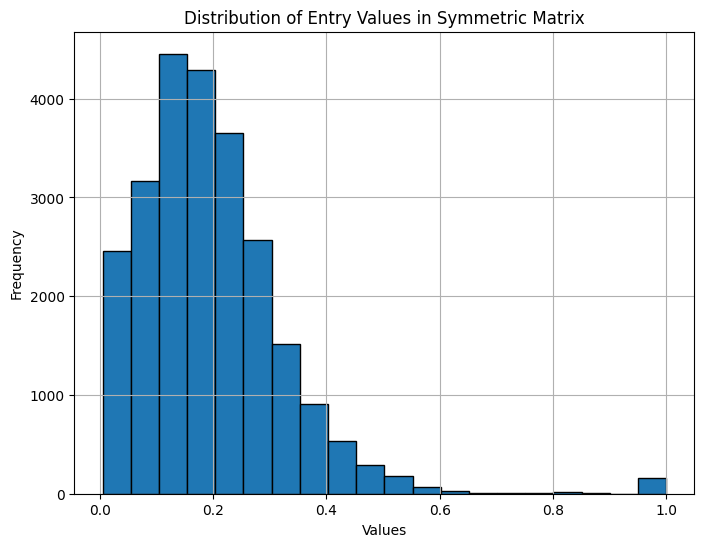

In [109]:

values = normalized_matrix.flatten()

plt.figure(figsize=(8, 6))
plt.hist(values, bins=20, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Entry Values in Symmetric Matrix')
plt.grid(True)
plt.show()


Proportion of values less than 0.2: 0.5796


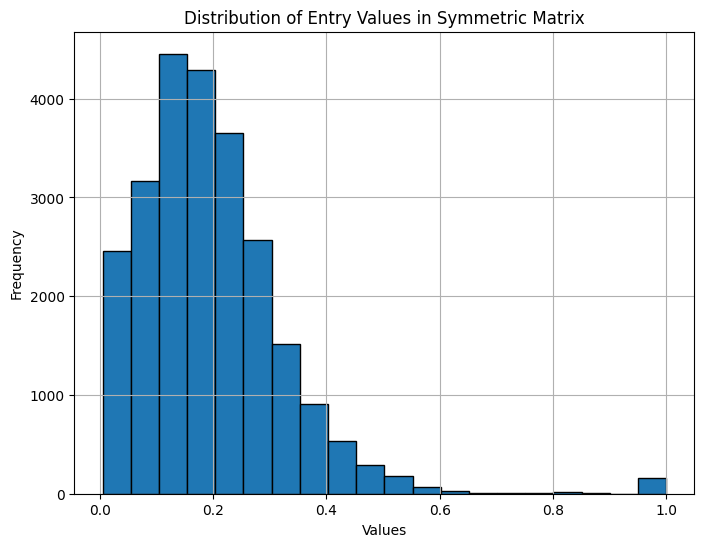

In [111]:

values = normalized_matrix.flatten()

proportion_less_than_0 = np.sum(values < 0.2) / values.size

print(f'Proportion of values less than 0.2: {proportion_less_than_0:.4f}')

plt.figure(figsize=(8, 6))
plt.hist(values, bins=20, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Entry Values in Symmetric Matrix')
plt.grid(True)
plt.show()

In [37]:

np.save(save_directory + '/normalized_symmetric_matrix.npy', symmetric_matrix)


In [38]:

np.save(save_directory + '/normalized_matrix.npy', normalized_matrix)


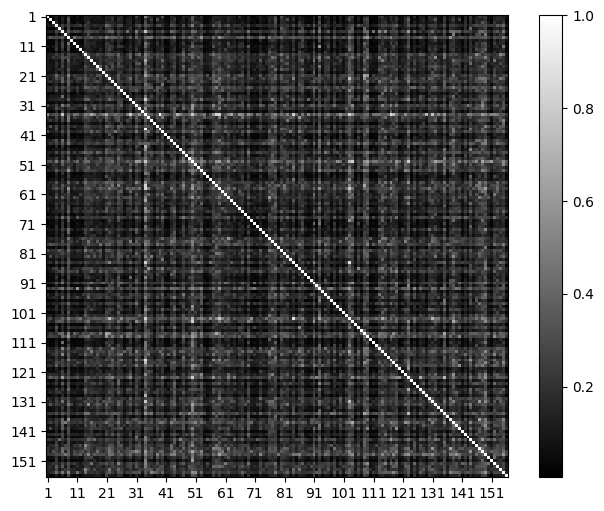

In [63]:


matrix = np.array(precision_matrix)
transpose_matrix = matrix.T 
symmetric_matrix = (transpose_matrix + matrix) / 2

max_value = np.max(np.abs(np.triu(symmetric_matrix, k=1)))

if max_value != 0:
    symmetric_matrix /= max_value


np.fill_diagonal(symmetric_matrix, 1)
tick_step = 10

plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(symmetric_matrix), tick_step), np.arange(1, len(symmetric_matrix) + 1, tick_step))
plt.yticks(np.arange(0, len(symmetric_matrix), tick_step), np.arange(1, len(symmetric_matrix) + 1, tick_step))
plt.imshow(symmetric_matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [61]:
symmetric_matrix

array([[1.        , 0.02628515, 0.06525845, ..., 0.15721246, 0.12657125,
        0.08010879],
       [0.02628515, 1.        , 0.02295842, ..., 0.15407033, 0.16876526,
        0.02560832],
       [0.06525845, 0.02295842, 1.        , ..., 0.13624133, 0.22821412,
        0.03997661],
       ...,
       [0.15721246, 0.15407033, 0.13624133, ..., 1.        , 0.25169072,
        0.10676856],
       [0.12657125, 0.16876526, 0.22821412, ..., 0.25169072, 1.        ,
        0.16328055],
       [0.08010879, 0.02560832, 0.03997661, ..., 0.10676856, 0.16328055,
        1.        ]])

# Example of thresholded adjacency matrix

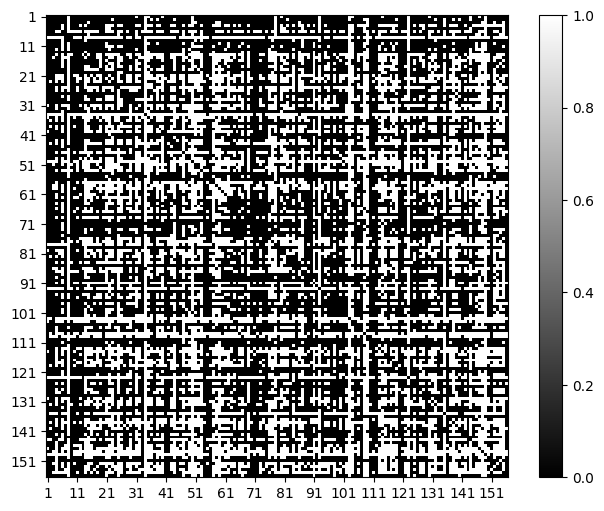

In [102]:

threshold = 0.2  
adjacency_matrix = np.where(symmetric_matrix >= threshold, 1, 0)
tick_step = 10

plt.figure(figsize=(8, 6))

np.fill_diagonal(adjacency_matrix, 0)
plt.xticks(np.arange(0, len(adjacency_matrix), tick_step), np.arange(1, len(adjacency_matrix) + 1, tick_step))
plt.yticks(np.arange(0, len(adjacency_matrix), tick_step), np.arange(1, len(adjacency_matrix) + 1, tick_step))

plt.imshow(adjacency_matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

# Getting degree ranking (as in numerical experiments, OC)

This is used to compare with existing methods from GLASSO. This part is from using localized SING.

In [103]:

def find_node_with_highest_degree(adjacency_matrix):
    degrees = np.sum(adjacency_matrix, axis=1)  
    print(degrees)
    
    max_degree_node = np.argmax(degrees)
    
    max_degree_value = degrees[max_degree_node]
    
    return max_degree_node, max_degree_value


node, degree = find_node_with_highest_degree(adjacency_matrix)
print(f"Node with the highest number of edges: {node}")
print(f"Number of edges connected to this node: {degree}") #0 indexed.

[ 17  21  17  76  19  97  19 138  13  26  33  26  22 103  83  62  43  59
  62  27  93  96  89  31 120  76  20  52  89  23 108  72  18 149  91  69
  20  91  59 102  20  22  78 114  26  39 118  40  80 137  92  75 111  19
  20  26 107  96 118  65  65  85  45  58  23  60  80  19 104  21  17  23
  62  26  23  92  93 118  20  95  81  81  29  89  19  85 102  33  30  24
 113  32 130  22  69  74  15  71  16  58  22  65 144 112  15  71  23 131
 127  14  22  21  95 112  95  38  96  83 109  19  24  64 138  24  75  17
  67  68  18  91  89  96  36  24 126  19  82 124  76  70  27  72  27 112
  38  86 104 123 139  57  18 100  83  82 108  22]
Node with the highest number of edges: 33
Number of edges connected to this node: 149


In [ ]:
import networkx as nx
from scipy.stats import rankdata
import pandas as pd

In [104]:

G = nx.from_numpy_array(adjacency_matrix)
closeness_centrality = nx.closeness_centrality(G)
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

print("Node Rankings by Closeness Centrality (from highest to lowest):")
for rank, (node, centrality) in enumerate(sorted_closeness, start=1):
    print(f"Rank {rank}: Node {node + 1} - Closeness Centrality = {centrality:.4f}")


Node Rankings by Closeness Centrality (from highest to lowest):
Rank 1: Node 34 - Closeness Centrality = 0.9627
Rank 2: Node 103 - Closeness Centrality = 0.9337
Rank 3: Node 149 - Closeness Centrality = 0.9064
Rank 4: Node 8 - Closeness Centrality = 0.9012
Rank 5: Node 123 - Closeness Centrality = 0.9012
Rank 6: Node 50 - Closeness Centrality = 0.8960
Rank 7: Node 108 - Closeness Centrality = 0.8659
Rank 8: Node 93 - Closeness Centrality = 0.8611
Rank 9: Node 109 - Closeness Centrality = 0.8470
Rank 10: Node 135 - Closeness Centrality = 0.8424
Rank 11: Node 138 - Closeness Centrality = 0.8333
Rank 12: Node 148 - Closeness Centrality = 0.8289
Rank 13: Node 25 - Closeness Centrality = 0.8158
Rank 14: Node 47 - Closeness Centrality = 0.8073
Rank 15: Node 59 - Closeness Centrality = 0.8073
Rank 16: Node 78 - Closeness Centrality = 0.8073
Rank 17: Node 44 - Closeness Centrality = 0.7908
Rank 18: Node 91 - Closeness Centrality = 0.7868
Rank 19: Node 104 - Closeness Centrality = 0.7828
Rank 2

# Replicating Shutta et al. (2022) using nonparanormal

Precision Matrix:
[[0.04755681 0.         0.         ... 0.         0.         0.8845421 ]
 [0.         0.         0.         ... 0.         1.07049635 0.        ]
 [0.         0.         0.         ... 0.88723526 0.         0.        ]
 ...
 [0.         0.         0.98853916 ... 0.         0.         0.        ]
 [0.         0.97262658 0.         ... 0.         0.         0.        ]
 [0.89547282 0.         0.         ... 0.         0.         0.04755677]]

Adjacency Matrix:
[[1 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]]


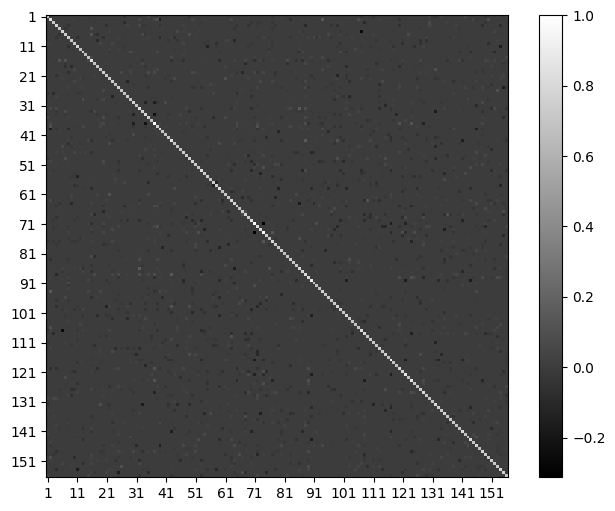

In [126]:

precision_matrix_npn = pd.read_csv("OC/samples/precision_matrix-npn.txt", sep="\t", header=None)

precision_matrix_npn = precision_matrix_npn.values

print("Precision Matrix:")
print(precision_matrix)

max_value = np.max(np.abs(precision_matrix_npn))
precision_matrix_normalized_npn = precision_matrix_npn / max_value

adjacency_matrix_npn = np.where(np.abs(precision_matrix_normalized_npn) > threshold, 1, 0)

precision_matrix_normalized_npn = np.fliplr(precision_matrix_normalized_npn)

print("\nAdjacency Matrix:")
print(adjacency_matrix_npn)


plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(precision_matrix_normalized_npn), tick_step), np.arange(1, len(precision_matrix_normalized_npn) + 1, tick_step))
plt.yticks(np.arange(0, len(precision_matrix_normalized_npn), tick_step), np.arange(1, len(precision_matrix_normalized_npn) + 1, tick_step))
plt.imshow(precision_matrix_normalized_npn, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [117]:


G = nx.from_numpy_array(adjacency_matrix_npn)

degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
hub_score = nx.hits(G)[0]  # HITS algorithm returns (hub_scores, authority_scores)

# Rank nodes by each centrality measure (higher values have lower ranks)
degree_rank = rankdata([-v for v in degree_centrality.values()], method='min')
closeness_rank = rankdata([-v for v in closeness_centrality.values()], method='min')
betweenness_rank = rankdata([-v for v in betweenness_centrality.values()], method='min')
hub_score_rank = rankdata([-v for v in hub_score.values()], method='min')

# Calculate the average rank for each node
average_rank = (degree_rank + closeness_rank + betweenness_rank + hub_score_rank) / 4

# Print the rankings and average rank
print("Node Rankings by Various Centrality Measures and Their Average Rank:")
print("Node\tDegreeRank\tClosenessRank\tBetweennessRank\tHubScoreRank\tAverageRank")
for node in range(len(G)):
    print(f"{node + 1}\t{int(degree_rank[node])}\t\t{int(closeness_rank[node])}\t\t{int(betweenness_rank[node])}\t\t{int(hub_score_rank[node])}\t\t{average_rank[node]:.2f}")

Node Rankings by Various Centrality Measures and Their Average Rank:
Node	DegreeRank	ClosenessRank	BetweennessRank	HubScoreRank	AverageRank
1	47		45		31		69		48.00
2	38		51		75		23		46.75
3	59		66		71		61		64.25
4	28		35		33		27		30.75
5	140		140		127		142		137.25
6	103		101		121		97		105.50
7	90		86		82		112		92.50
8	1		5		2		3		2.75
9	59		66		66		64		63.75
10	73		86		90		67		79.00
11	73		86		85		79		80.75
12	90		97		92		107		96.50
13	82		75		105		75		84.25
14	155		155		155		155		155.00
15	140		138		153		134		141.25
16	3		2		5		4		3.50
17	103		101		104		116		106.00
18	123		117		118		126		121.00
19	73		104		76		80		83.25
20	6		11		19		2		9.50
21	90		93		99		104		96.50
22	14		15		8		35		18.00
23	90		117		133		77		104.25
24	140		143		142		141		141.50
25	6		4		7		7		6.00
26	131		133		139		130		133.25
27	140		135		149		138		140.50
28	119		127		124		121		122.75
29	103		104		93		118		104.50
30	103		124		114		111		113.00
31	146		145		143		146		145.00
32	28		35		49		26		34.50
33	38		20		24		50

In [118]:

nodes_with_average_rank = sorted(
    [(node + 1, degree_rank[node], closeness_rank[node], betweenness_rank[node], hub_score_rank[node], average_rank[node]) 
     for node in range(len(G))],
    key=lambda x: x[5]
)

print("Node Rankings from Highest to Lowest Average Rank:")
print("Node\tDegreeRank\tClosenessRank\tBetweennessRank\tHubScoreRank\tAverageRank")
for node_info in nodes_with_average_rank:
    node, d_rank, c_rank, b_rank, h_rank, avg_rank = node_info
    print(f"{node}\t{int(d_rank)}\t\t{int(c_rank)}\t\t{int(b_rank)}\t\t{int(h_rank)}\t\t{avg_rank:.2f}")

Node Rankings from Highest to Lowest Average Rank:
Node	DegreeRank	ClosenessRank	BetweennessRank	HubScoreRank	AverageRank
8	1		5		2		3		2.75
127	1		1		1		10		3.25
16	3		2		5		4		3.50
63	4		2		4		9		4.75
37	4		5		12		1		5.50
25	6		4		7		7		6.00
89	6		8		3		8		6.25
77	6		10		10		6		8.00
20	6		11		19		2		9.50
150	10		8		13		12		10.75
154	10		11		11		14		11.50
87	10		11		6		21		12.00
72	10		15		14		11		12.50
39	14		11		32		5		15.50
35	16		7		26		16		16.25
22	14		15		8		35		18.00
108	16		20		15		22		18.25
152	16		15		18		24		18.25
138	16		20		21		19		19.00
146	16		25		17		20		19.50
122	16		20		16		33		21.25
43	23		15		22		28		22.00
68	23		15		25		25		22.00
148	16		25		39		13		23.25
149	23		24		41		15		25.75
70	28		29		28		34		29.75
50	23		45		34		18		30.00
4	28		35		33		27		30.75
71	28		25		54		17		31.00
90	23		29		44		31		31.75
117	28		40		29		32		32.25
128	28		31		40		30		32.25
73	28		40		27		36		32.75
107	28		31		35		37		32.75
33	38		20		24		50		33.00
32	28		35		49		26		34.50
55	38		25		

# Computing ranking from adjacency matrix from localized SING

This adjacency matrix is from localized SING.

In [105]:


G = nx.from_numpy_array(adjacency_matrix) # This is from localized SING.

degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
hub_score = nx.hits(G)[0]  

degree_rank = rankdata([-v for v in degree_centrality.values()], method='min')
closeness_rank = rankdata([-v for v in closeness_centrality.values()], method='min')
betweenness_rank = rankdata([-v for v in betweenness_centrality.values()], method='min')
hub_score_rank = rankdata([-v for v in hub_score.values()], method='min')

average_rank = (degree_rank + closeness_rank + betweenness_rank + hub_score_rank) / 4

print("Node Rankings by Various Centrality Measures and Their Average Rank:")
print("Node\tDegreeRank\tClosenessRank\tBetweennessRank\tHubScoreRank\tAverageRank")
for node in range(len(G)):
    print(f"{node + 1}\t{int(degree_rank[node])}\t\t{int(closeness_rank[node])}\t\t{int(betweenness_rank[node])}\t\t{int(hub_score_rank[node])}\t\t{average_rank[node]:.2f}")

Node Rankings by Various Centrality Measures and Their Average Rank:
Node	DegreeRank	ClosenessRank	BetweennessRank	HubScoreRank	AverageRank
1	148		148		152		148		149.00
2	130		130		128		131		129.75
3	148		148		142		149		146.75
4	65		65		70		66		66.50
5	138		138		124		144		136.00
6	33		33		30		39		33.75
7	138		138		136		140		138.00
8	4		4		5		3		4.00
9	156		156		154		156		155.50
10	110		110		127		111		114.50
11	101		101		100		102		101.00
12	110		110		105		114		109.75
13	124		124		115		130		123.25
14	29		29		31		27		29.00
15	55		55		56		56		55.50
16	84		84		86		86		85.00
17	95		95		95		95		95.00
18	88		88		89		87		88.00
19	84		84		88		84		85.00
20	107		107		118		108		110.00
21	41		41		43		45		42.50
22	34		34		34		37		34.75
23	48		48		49		46		47.75
24	104		104		99		105		103.00
25	13		13		15		13		13.50
26	65		65		69		67		66.50
27	133		133		144		133		135.75
28	93		93		93		93		93.00
29	48		48		52		43		47.75
30	119		119		109		122		117.25
31	24		24		25		23		24.00
32	71		71		77		72		72.75
33	14

In [106]:

# Combine the ranks with the node numbers and sort by average rank
nodes_with_average_rank = sorted(
    [(node + 1, degree_rank[node], closeness_rank[node], betweenness_rank[node], hub_score_rank[node], average_rank[node]) 
     for node in range(len(G))],
    key=lambda x: x[5]
)

# Print the rankings from highest to lowest average rank
print("Node Rankings from Highest to Lowest Average Rank:")
print("Node\tDegreeRank\tClosenessRank\tBetweennessRank\tHubScoreRank\tAverageRank")
for node_info in nodes_with_average_rank:
    node, d_rank, c_rank, b_rank, h_rank, avg_rank = node_info
    print(f"{node}\t{int(d_rank)}\t\t{int(c_rank)}\t\t{int(b_rank)}\t\t{int(h_rank)}\t\t{avg_rank:.2f}")

Node Rankings from Highest to Lowest Average Rank:
Node	DegreeRank	ClosenessRank	BetweennessRank	HubScoreRank	AverageRank
34	1		1		1		1		1.00
103	2		2		2		2		2.00
149	3		3		3		4		3.25
8	4		4		5		3		4.00
123	4		4		4		5		4.25
50	6		6		6		6		6.00
93	8		8		8		7		7.75
108	7		7		7		10		7.75
109	9		9		9		11		9.50
135	10		10		10		9		9.75
138	11		11		12		8		10.50
148	12		12		11		12		11.75
25	13		13		15		13		13.50
47	14		14		14		15		14.25
59	14		14		16		14		14.50
78	14		14		13		17		14.50
44	17		17		18		16		17.00
91	18		18		22		18		19.00
144	19		19		17		22		19.25
104	19		19		19		21		19.50
114	19		19		20		20		19.50
53	22		22		21		19		21.00
119	23		23		23		26		23.75
31	24		24		25		23		24.00
155	24		24		27		24		24.75
57	26		26		24		30		26.50
69	27		27		28		29		27.75
147	27		27		33		25		28.00
14	29		29		31		27		29.00
87	30		30		26		33		29.75
40	30		30		37		28		31.25
6	33		33		30		39		33.75
132	34		34		32		36		34.00
152	32		32		41		31		34.00
22	34		34		34		37		34.75
58	34		34		29		44		35.25
117	34		34

In [108]:

# Transform weights: 1 / abs(weight) to treat them as distances, based on explanation from Shutta et al. (2022). This is due to how rankings are computed vs the precision matrix values and what it means wrt edge weights.
for u, v, data in G.edges(data=True):
    data['weight'] = 1 / abs(data['weight'])

# Calculate different centrality measures using the transformed weights
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G, distance='weight')
betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
hub_score = nx.hits(G)[0]  # HITS algorithm returns (hub_scores, authority_scores)

# Rank nodes by each centrality measure (higher values have lower ranks)
degree_rank = rankdata([-v for v in degree_centrality.values()], method='min')
closeness_rank = rankdata([-v for v in closeness_centrality.values()], method='min')
betweenness_rank = rankdata([-v for v in betweenness_centrality.values()], method='min')
hub_score_rank = rankdata([-v for v in hub_score.values()], method='min')

# Calculate the average rank for each node
average_rank = (degree_rank + closeness_rank + betweenness_rank + hub_score_rank) / 4

# Combine the ranks with the node numbers and sort by average rank
nodes_with_average_rank = sorted(
    [(node, degree_rank[node], closeness_rank[node], betweenness_rank[node], hub_score_rank[node], average_rank[node]) 
     for node in range(len(G))],
    key=lambda x: x[5]
)

# Print the rankings from highest to lowest average rank (0-indexed nodes)
print("Node Rankings from Highest to Lowest Average Rank:")
print("Node\tDegreeRank\tClosenessRank\tBetweennessRank\tHubScoreRank\tAverageRank")
for node_info in nodes_with_average_rank:
    node, d_rank, c_rank, b_rank, h_rank, avg_rank = node_info
    print(f"{node+1}\t{int(d_rank)}\t\t{int(c_rank)}\t\t{int(b_rank)}\t\t{int(h_rank)}\t\t{avg_rank:.2f}")

Node Rankings from Highest to Lowest Average Rank:
Node	DegreeRank	ClosenessRank	BetweennessRank	HubScoreRank	AverageRank
34	1		1		1		1		1.00
103	2		2		2		2		2.00
149	3		3		3		4		3.25
8	4		4		5		3		4.00
123	4		4		4		5		4.25
50	6		6		6		6		6.00
93	8		8		8		7		7.75
108	7		7		7		10		7.75
109	9		9		9		11		9.50
135	10		10		10		9		9.75
138	11		11		12		8		10.50
148	12		12		11		12		11.75
25	13		13		15		13		13.50
47	14		14		14		15		14.25
59	14		14		16		14		14.50
78	14		14		13		17		14.50
44	17		17		18		16		17.00
91	18		18		22		18		19.00
144	19		19		17		22		19.25
104	19		19		19		21		19.50
114	19		19		20		20		19.50
53	22		22		21		19		21.00
119	23		23		23		26		23.75
31	24		24		25		23		24.00
155	24		24		27		24		24.75
57	26		26		24		30		26.50
69	27		27		28		29		27.75
147	27		27		33		25		28.00
14	29		29		31		27		29.00
87	30		30		26		33		29.75
40	30		30		37		28		31.25
6	33		33		30		39		33.75
132	34		34		32		36		34.00
152	32		32		41		31		34.00
22	34		34		34		37		34.75
58	34		34		29		44		35.25
117	34		34

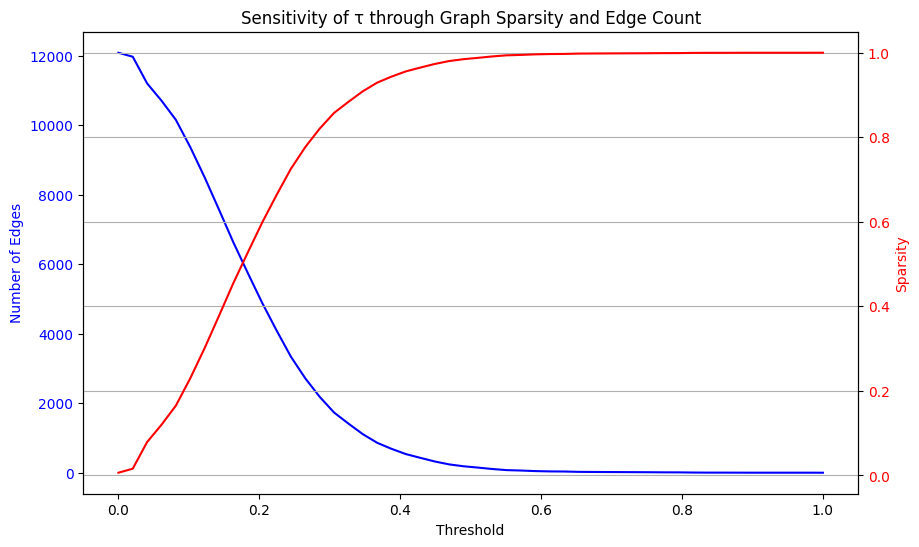

In [74]:

thresholds = np.linspace(0, 1, 50)  # 50 thresholds from 0 to 1
num_edges = []
sparsity = []

for threshold in thresholds:
    # Apply the threshold to the symmetric matrix to create the adjacency matrix
    adjacency_matrix = np.where(symmetric_matrix > threshold, 1, 0)
    
    # Remove self-loops by setting the diagonal to 0
    np.fill_diagonal(adjacency_matrix, 0)
    
    # Count the number of edges (number of 1's in the adjacency matrix)
    edge_count = np.sum(adjacency_matrix) // 2  # Dividing by 2 to account for symmetry
    num_edges.append(edge_count)
    
    # Calculate the sparsity (fraction of zero elements)
    sparsity_value = 1 - np.sum(adjacency_matrix) / (adjacency_matrix.size)
    sparsity.append(sparsity_value)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(thresholds, num_edges, 'b-', label='Number of Edges')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of Edges', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(thresholds, sparsity, 'r-', label='Sparsity')
ax2.set_ylabel('Sparsity', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.grid(True)
plt.title('Sensitivity of τ through Graph Sparsity and Edge Count')


plt.show()

51 51 51


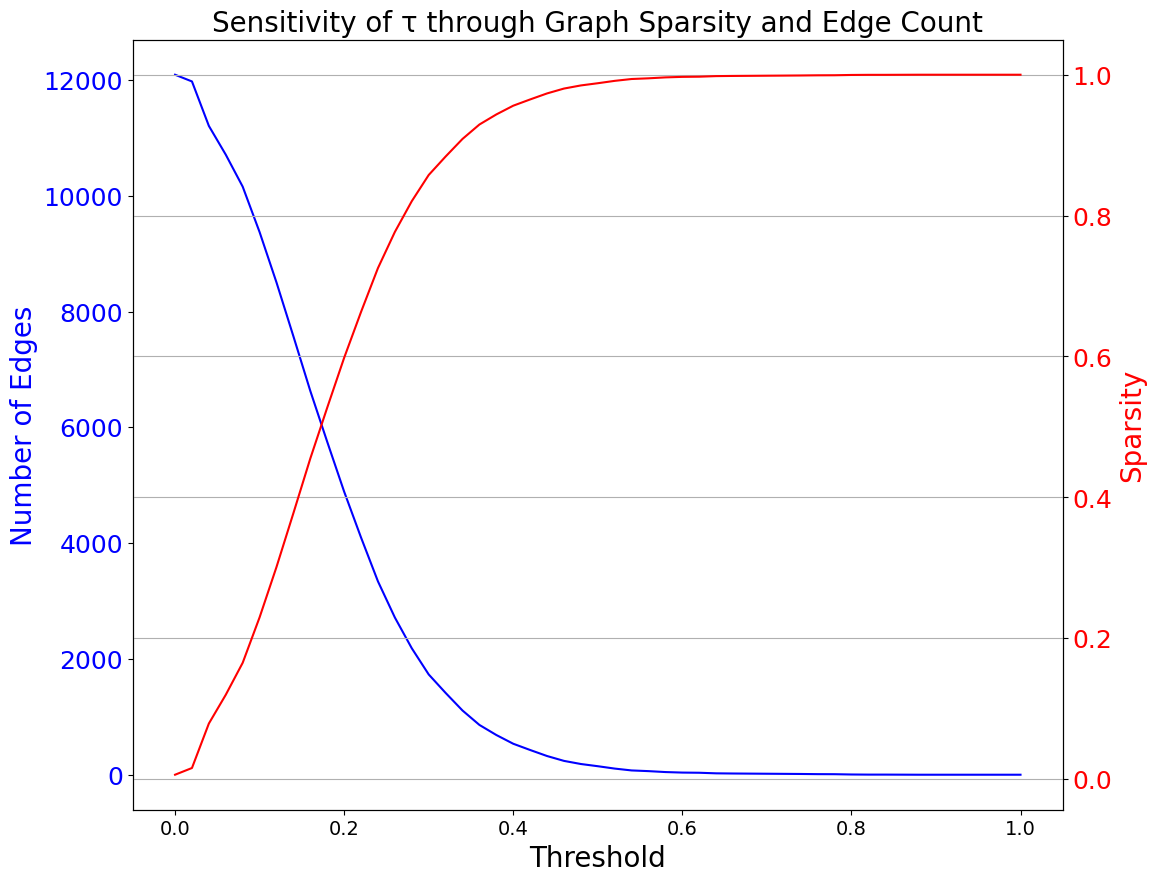

In [139]:

# Printed and saved from solutions before
thresholds = np.linspace(0, 1, 51)
num_edges = [
    12090, 11974, 11206, 10709, 10157, 9372, 8502, 7572, 6628, 5750, 4890, 
    4097, 3340, 2716, 2185, 1733, 1414, 1110, 861, 687, 536, 428, 324, 240, 
    186, 148, 107, 75, 63, 47, 38, 35, 25, 22, 20, 18, 16, 14, 11, 10, 5, 3, 
    3, 2, 1, 1, 1, 1, 1, 1, 1
]
sparsity = [
    0.0064102564102563875, 0.01594345825115051, 0.07905982905982911, 0.11990466798159105, 
    0.16526955950032873, 0.22978303747534512, 0.3012820512820513, 0.37771203155818545, 
    0.4552925706771861, 0.5274490466798158, 0.5981262327416174, 0.6632971729125575, 
    0.7255095332018409, 0.7767915844838922, 0.82043063773833, 0.857577251808021, 
    0.88379355687048, 0.9087771203155819, 0.929240631163708, 0.9435404339250493, 
    0.9559500328731098, 0.9648257725180802, 0.9733727810650887, 0.980276134122288, 
    0.9847140039447732, 0.9878369493754109, 0.99120644312952, 0.993836291913215, 
    0.9948224852071006, 0.996137409598948, 0.9968770545693623, 0.9971236028928336, 
    0.9979454306377383, 0.9981919789612097, 0.9983563445101906, 0.9985207100591716, 
    0.9986850756081526, 0.9988494411571335, 0.9990959894806049, 0.9991781722550953, 
    0.9995890861275477, 0.9997534516765286, 0.9997534516765286, 0.9998356344510191, 
    0.9999178172255095, 0.9999178172255095, 0.9999178172255095, 0.9999178172255095, 
    0.9999178172255095, 0.9999178172255095, 0.9999178172255095
]
print(len(sparsity), len(num_edges), len(thresholds))
fig, ax1 = plt.subplots(figsize=(12, 10))

ax1.plot(thresholds, num_edges, 'b-', label='Number of Edges')
ax1.set_xlabel('Threshold', fontsize=20)
ax1.set_ylabel('Number of Edges', fontsize=20, color='b')
ax1.tick_params(axis='y', labelcolor='b', labelsize=18)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()
ax2.plot(thresholds, sparsity, 'r-', label='Sparsity')
ax2.set_ylabel('Sparsity', fontsize=20, color='r')
ax2.tick_params(axis='y', labelcolor='r', labelsize=18)
ax2.grid(True)

plt.title('Sensitivity of τ through Graph Sparsity and Edge Count', fontsize=20)

plt.show()

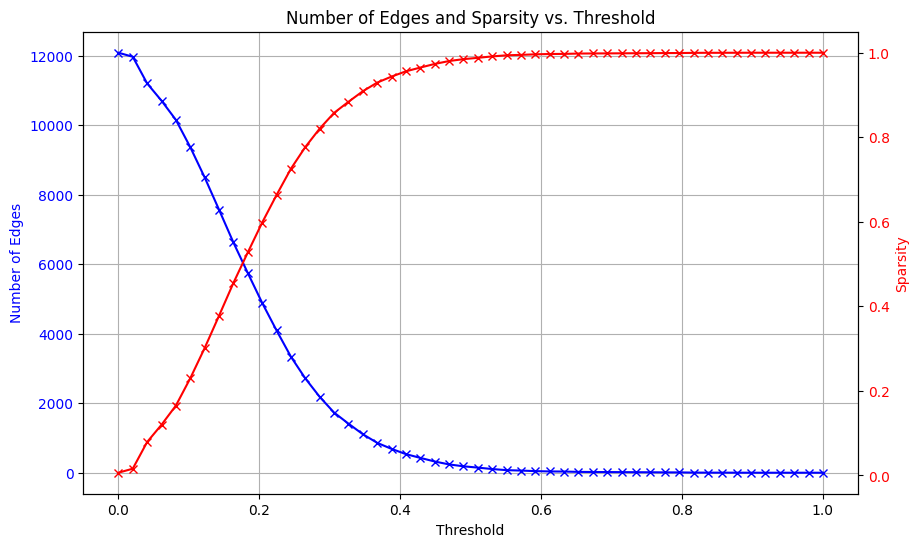

The largest threshold that produces a non-empty graph is: 1.0


In [58]:

thresholds = np.linspace(0, 1, 50) 
num_edges = []
sparsity = []

largest_non_empty_threshold = None  
for threshold in thresholds:
    adjacency_matrix = np.where(symmetric_matrix >= threshold, 1, 0)
    
    np.fill_diagonal(adjacency_matrix, 0)
    
    edge_count = np.sum(adjacency_matrix) // 2 
    num_edges.append(edge_count)
    
    sparsity_value = 1 - np.sum(adjacency_matrix) / (adjacency_matrix.size)
    sparsity.append(sparsity_value)
    
    if edge_count > 0:
        largest_non_empty_threshold = threshold

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(thresholds, num_edges, 'b-x', label='Number of Edges')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Number of Edges', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(thresholds, sparsity, 'r-x', label='Sparsity')
ax2.set_ylabel('Sparsity', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Number of Edges and Sparsity vs. Threshold')
ax1.grid(True)

plt.show()

print(f"The largest threshold that produces a non-empty graph is: {largest_non_empty_threshold}")


In [59]:
num_edges

[12090,
 11974,
 11206,
 10709,
 10157,
 9372,
 8502,
 7572,
 6628,
 5750,
 4890,
 4097,
 3340,
 2716,
 2185,
 1733,
 1414,
 1110,
 861,
 687,
 536,
 428,
 324,
 240,
 186,
 148,
 107,
 75,
 63,
 47,
 38,
 35,
 25,
 22,
 20,
 18,
 16,
 14,
 11,
 10,
 5,
 3,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 1]

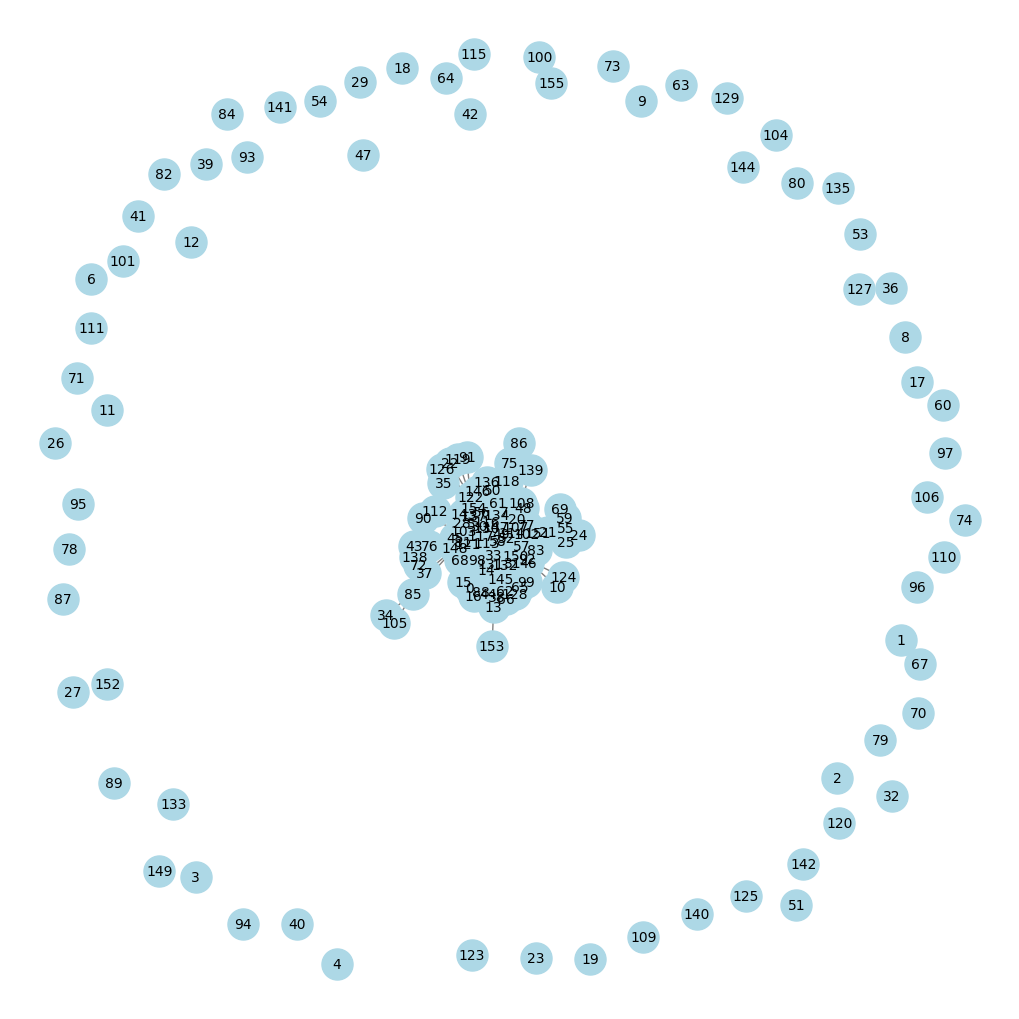

In [52]:
import networkx 
# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adjacency_matrix)

# Plotting the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
plt.show()

In [28]:
if np.isnan(symmetric_matrix).any():
    print("NaNs detected in symmetric_matrix!")
else:
    print("No NaNs in symmetric_matrix.")


No NaNs in symmetric_matrix.


In [29]:
max_value = np.max(np.abs(np.triu(symmetric_matrix, k=1)))
print(max_value)

1.0


# Testing GLASSO using sklearn
We test out GLASSO from sklearn on this data. 

NOTE: the GLASSO compared to in the submission is from the GitHub repo from Shutta et al. (2022) 'Gaussian graphical models with applications to omics analyses'

In [31]:
from sklearn.covariance import empirical_covariance, GraphicalLasso


In [ ]:
cov = GraphicalLasso().fit(test_samples)
print(cov.precision_)
precision = cov.precision_

In [42]:
adj_glasso = np.where(precision >= threshold, 1, 0)


In [77]:

max_value = np.max(precision)

A_normalized = precision / max_value

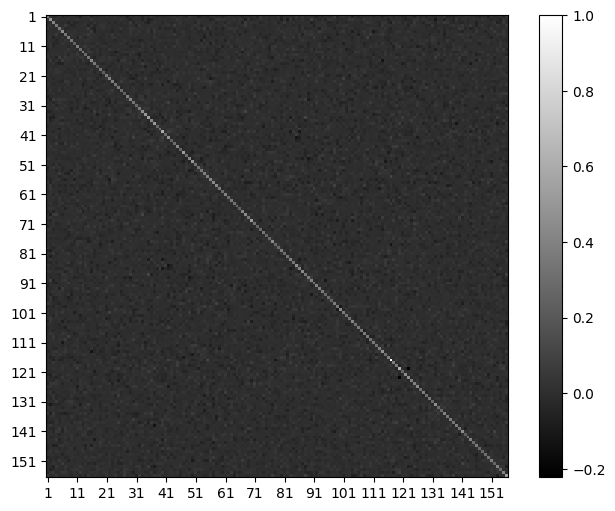

In [78]:
plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(A_normalized), tick_step), np.arange(1, len(A_normalized) + 1, tick_step))
plt.yticks(np.arange(0, len(A_normalized), tick_step), np.arange(1, len(A_normalized) + 1, tick_step))
plt.imshow(A_normalized, cmap='gray', interpolation='nearest')
plt.colorbar()

In [ ]:

glasso_matrix = A_normalized
localized_sing_matrix = symmetric_matrix

def calculate_sparsity(matrix):
    num_non_zero = np.count_nonzero(matrix)
    total_elements = matrix.size
    sparsity = num_non_zero / total_elements
    return sparsity

glasso_sparsity = calculate_sparsity(glasso_matrix)
localized_sing_sparsity = calculate_sparsity(localized_sing_matrix)

print("Sparsity of glasso_matrix:", glasso_sparsity)
print("Sparsity of localized_sing_matrix:", localized_sing_sparsity)

def calculate_jaccard_similarity(matrix1, matrix2):
    edge_set1 = matrix1.flatten()
    edge_set2 = matrix2.flatten()
    intersection = np.sum(np.logical_and(edge_set1, edge_set2))
    union = np.sum(np.logical_or(edge_set1, edge_set2))
    print(intersection, union)
    jaccard_similarity = intersection / union if union != 0 else 1.0
    return jaccard_similarity

edge_agreement = calculate_jaccard_similarity(glasso_matrix, localized_sing_matrix)

print("Jaccard Similarity (Edge Agreement):", edge_agreement)


In [89]:
def calculate_jaccard_similarity(matrix1, matrix2, threshold1, threshold2):
    binary_matrix1 = matrix1 > threshold1
    binary_matrix2 = matrix2 > threshold2
    
    edge_set1 = binary_matrix1.flatten()
    edge_set2 = binary_matrix2.flatten()
    
    intersection = np.sum(np.logical_and(edge_set1, edge_set2))
    union = np.sum(np.logical_or(edge_set1, edge_set2))
    
    jaccard_similarity = intersection / union if union != 0 else 1.0
    return jaccard_similarity

def find_best_threshold(matrix1, matrix2):
    best_similarity = 0
    best_threshold1 = 0
    best_threshold2 = 0
    thresholds = np.arange(0, 0.4, 0.1)  # [0, 0.1, 0.2, ..., 1]
    
    for tau1 in thresholds:
        for tau2 in thresholds:
            similarity = calculate_jaccard_similarity(matrix1, matrix2, tau1, tau2)
            if similarity > best_similarity:
                best_similarity = similarity
                best_threshold1 = tau1
                best_threshold2 = tau2
    
    print(f"Highest Jaccard Similarity: {best_similarity}")
    print(f"Best Threshold for Matrix1: {best_threshold1}")
    print(f"Best Threshold for Matrix2: {best_threshold2}")

find_best_threshold(glasso_matrix, localized_sing_matrix)


Highest Jaccard Similarity: 0.3497698882314267
Best Threshold for Matrix1: 0.0
Best Threshold for Matrix2: 0.0


In [82]:
nonzero_count = np.count_nonzero(glasso_matrix)
print("Number of nonzero entries:", nonzero_count)


Number of nonzero entries: 17650


In [128]:

# 1. Frobenius Norm
frobenius_norm = np.linalg.norm(precision_matrix_normalized - A_normalized, 'fro')
print("Frobenius Norm:", frobenius_norm)

# 2. L1 + L2 Norms
# L1 Norm (Manhattan distance)
l1_norm = np.sum(np.abs(precision_matrix_normalized - A_normalized))
print("L1 Norm:", l1_norm)

# L2 Norm (Euclidean distance)
l2_norm = np.linalg.norm(precision_matrix_normalized - A_normalized)
print("L2 Norm:", l2_norm)

combined_norm = l1_norm + l2_norm
print("Combined L1 + L2 Norm:", combined_norm)

# 3. Cosine Similarity
# Flatten the matrices
A_flat = precision_matrix_normalized.flatten()
B_flat = A_normalized.flatten()

cosine_similarity = np.dot(A_flat, B_flat) / (np.linalg.norm(A_flat) * np.linalg.norm(B_flat))
print("Cosine Similarity:", cosine_similarity)


Frobenius Norm: 6.4363481979507045
L1 Norm: 474.6521979800941
L2 Norm: 6.4363481979507045
Combined L1 + L2 Norm: 481.0885461780448
Cosine Similarity: 0.7616335263125947
